In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
os.environ['NVIDIA_VISIBLE_DEVICES'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ

environ{'PATH': '/opt/conda/bin:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin',
        'HOSTNAME': '78353253e378',
        'TERM': 'xterm-color',
        'NVIDIA_VISIBLE_DEVICES': '1',
        'CUDA_VERSION': '9.0.176',
        'CUDA_PKG_VERSION': '9-0=9.0.176-1',
        'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64',
        'NVIDIA_DRIVER_CAPABILITIES': 'compute,utility',
        'NVIDIA_REQUIRE_CUDA': 'cuda>=9.0',
        'NCCL_VERSION': '2.4.2',
        'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs',
        'CUDNN_VERSION': '7.4.2.24',
        'LANG': 'C.UTF-8',
        'HOME': '/root',
        'JPY_PARENT_PID': '6',
        'CLICOLOR': '1',
        'PAGER': 'cat',
        'GIT_PAGER': 'cat',
        'MPLBACKEND': 'module://ipykernel.pylab.backend_inline',
        'CUDA_VISIBLE_DEVICES': '1'}

In [3]:
from train import ModelLoader, load_and_save_params, MetricLoader
from datasets.cvpr2016_cub_loader import Cvpr2016CubLoader
from common.util import Namespace
import numpy as np
from tqdm import tqdm
from scipy.spatial import cKDTree, KDTree
import time
from common.metrics import ap_at_k_prototypes
import os, pwd
from common.pretrained_models import InceptionV3Loader, InceptionV2Loader
from common.pretrained_models import INCEPTION_V2_PATH
from PIL import Image
from datasets.dataset_list import get_dataset_splits
from common.metrics import get_prototypes, top1_gzsl
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Define validation and test functions

In [4]:
from collections import defaultdict

def get_multiplier_grid(metric_model, feature_model, dataset_splits):
    seen_adjustment_grid = np.arange(0.0, 0.05, 0.001)
    
    multiplier_grid = {}
    for seen_adjustment in seen_adjustment_grid:
        results_eval, _ = feature_model.eval_acc_gzsh(train_loader=dataset_splits[metric_model.flags.train_split],
                                                      test_loader_seen=dataset_splits[metric_model.flags.test_split+"_seen"],
                                                      test_loader_unseen=dataset_splits[metric_model.flags.test_split+"_unseen"],
                                                      batch_size=32, seen_adjustment=seen_adjustment)
        multiplier_grid[seen_adjustment] = results_eval['test_H_Top-1 Acc/#sentences1000']
        
    return multiplier_grid

def crossvalidate_metric_multiplier(logdir, filter):
    
    model_list = glob(logdir+f"/{filter}")
    print("Processing models:")
    print(model_list)
    
    
    metric_model = MetricLoader(model_path=model_list[0], 
                            batch_size_image=100, batch_size_text=200)
    
    dataset_splits = get_dataset_splits(dataset_name=metric_model.flags.dataset, data_dir=metric_model.flags.data_dir,
                                    splits=[metric_model.flags.train_split, 
                                            metric_model.flags.test_split+"_seen", 
                                            metric_model.flags.test_split+"_unseen"], 
                                    flags=metric_model.flags)
    df = []
    for i, model_path in enumerate(model_list):
        
        metric_model = MetricLoader(model_path=model_path, 
                            batch_size_image=100, batch_size_text=200)
        feature_model = ModelLoader(model_path=model_path, batch_size=None,
                                    num_images=metric_model.flags.num_images, num_texts=metric_model.flags.num_texts, 
                                    max_text_len=30)
        
        multiplier_grid = get_multiplier_grid(metric_model, feature_model, dataset_splits)
        
        df.append(pd.DataFrame(index=multiplier_grid.keys(), data=multiplier_grid.values(), columns=[str(i)]))
                
    return pd.concat(df, axis=1)

def dmean(dicts):
    ret = defaultdict(float)
    count = defaultdict(float)
    for d in dicts:
        for k, v in d.items():
            ret[k] += v
            count[k] += 1.0
    for k, v in ret.items():
        ret[k] = ret[k] / count[k]
    return dict(ret)


def evaluate_test_result(logdir, filter, metric_multiplier):
    
    model_list = glob(logdir+f"/{filter}")
    print("Processing models:")
    print(model_list)
    
    metric_model = MetricLoader(model_path=model_list[0], 
                            batch_size_image=100, batch_size_text=200)
    
    dataset_splits = get_dataset_splits(dataset_name=metric_model.flags.dataset, 
                                        data_dir=metric_model.flags.data_dir,
                                        splits=["trainval", "test_seen", "test_unseen"],
                                        flags=metric_model.flags)
    
    results = []
    for i, model_path in enumerate(model_list):
        metric_model = MetricLoader(model_path=model_path, 
                            batch_size_image=100, batch_size_text=200)
        feature_model = ModelLoader(model_path=model_path, batch_size=None,
                                    num_images=metric_model.flags.num_images, num_texts=metric_model.flags.num_texts, 
                                    max_text_len=30)
        
        results_repeat, _ = feature_model.eval_acc_gzsh(train_loader=dataset_splits["trainval"],
                                                      test_loader_seen=dataset_splits["test_seen"],
                                                      test_loader_unseen=dataset_splits["test_unseen"],
                                                      batch_size=32, seen_adjustment=metric_multiplier)
        results.append(results_repeat)
    
    return results

## CUB Dataset, crossvalidate multiplier factor

In [5]:
# log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190502_144517_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_mi_weight_test_split_train_split_GZSL_results_validation_split"
# filter = "*dataset=xian2017_cub*"

# log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190506_130656_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_mi_weight_test_split_train_split_GZSL_results_validation_split"
# filter = "*mi_weight=0.4*dataset=xian2017_cub*"

# log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split"
# filter = "*embedding_size=1024*dataset=xian2017_cub*repeat=*"

log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split"
filter = "*dataset=xian2017_cub*"



In [6]:

df = crossvalidate_metric_multiplier(logdir=log_dir, filter=filter)


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Processing models:
['/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_o

INFO:root:Loading split train
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_cub/split_train_xian2017.pkl


Loading model


INFO:root:Loaded cache in 4.671173 sec
INFO:root:Loading split val_seen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_cub/split_val_seen_xian2017.pkl
INFO:root:Loaded cache in 2.429778 sec
INFO:root:Loading split val_unseen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_cub/split_val_unseen_xian2017.pkl
INFO:root:Loaded cache in 3.820108 sec
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_v

Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:05, 26.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 34.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modali

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0278023294
STD unseen prototype:
64.1981298007


 50%|█████     | 3/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
63.096506416
STD unseen prototype:
62.8972690439
STD seen prototype:
62.871403671
STD unseen prototype:
62.7580769557


 83%|████████▎ | 5/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
62.8227520008
STD unseen prototype:
62.6685908017
STD seen prototype:
62.8242845781
STD unseen prototype:
62.6255054196


 33%|███▎      | 2/6 [00:00<00:00, 12.82it/s]

STD seen prototype:
62.8053805358
STD unseen prototype:
62.6115730496
****************
SEEN images test
****************
STD seen prototype:
63.612596134
STD unseen prototype:
65.5020324403
STD seen prototype:
61.8828256002
STD unseen prototype:
64.8790106187


 67%|██████▋   | 4/6 [00:00<00:00, 12.61it/s]

STD seen prototype:
61.8096287357
STD unseen prototype:
64.8187609838
STD seen prototype:
61.7139087867
STD unseen prototype:
64.7403931735
STD seen prototype:
61.6447708445
STD unseen prototype:
64.7484940984


100%|██████████| 6/6 [00:00<00:00, 12.42it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445903
STD unseen prototype:
64.7393549105
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 36.93it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 36.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9251013842
STD unseen prototype:
64.0785405016


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.9685491339
STD unseen prototype:
63.0045312166
STD seen prototype:
62.9278639017
STD unseen prototype:
62.6322050998


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
62.8458453932
STD unseen prototype:
62.6747240983
STD seen prototype:
62.822280268
STD unseen prototype:
62.6434708557


 33%|███▎      | 2/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
62.8053805362
STD unseen prototype:
62.6115730786
****************
SEEN images test
****************
STD seen prototype:
63.5809094188
STD unseen prototype:
65.6213782904
STD seen prototype:
62.0118363983
STD unseen prototype:
64.9112217185


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
61.7813424762
STD unseen prototype:
64.824725021
STD seen prototype:
61.6791250674
STD unseen prototype:
64.7474613106
STD seen prototype:
61.6500757052
STD unseen prototype:
64.7090626987


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445218
STD unseen prototype:
64.7393549342
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.21it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.18it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0727599475
STD unseen prototype:
63.9025997453


 50%|█████     | 3/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
62.9767998214
STD unseen prototype:
62.8957981731
STD seen prototype:
62.9466553923
STD unseen prototype:
62.6926817808


 83%|████████▎ | 5/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
62.8160190425
STD unseen prototype:
62.661703222
STD seen prototype:
62.8112538595
STD unseen prototype:
62.5923936313


 33%|███▎      | 2/6 [00:00<00:00, 12.97it/s]

STD seen prototype:
62.8053805731
STD unseen prototype:
62.611573029
****************
SEEN images test
****************
STD seen prototype:
63.842559878
STD unseen prototype:
65.3764069124
STD seen prototype:
61.9750940437
STD unseen prototype:
64.9902685022


 67%|██████▋   | 4/6 [00:00<00:00, 12.68it/s]

STD seen prototype:
61.7756666401
STD unseen prototype:
64.7317343957
STD seen prototype:
61.6738617222
STD unseen prototype:
64.8120231791
STD seen prototype:
61.6164441311
STD unseen prototype:
64.7527894675


100%|██████████| 6/6 [00:00<00:00, 12.28it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.610644538
STD unseen prototype:
64.7393549075
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.98it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7204172443
STD unseen prototype:
64.1699250278


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
63.0073397984
STD unseen prototype:
62.7851549496
STD seen prototype:
62.8925328016
STD unseen prototype:
62.7709765337


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.7970037965
STD unseen prototype:
62.6702968817
STD seen prototype:
62.8045212024
STD unseen prototype:
62.6029959403


 33%|███▎      | 2/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
62.8053805863
STD unseen prototype:
62.6115730192
****************
SEEN images test
****************
STD seen prototype:
63.3425312084
STD unseen prototype:
65.6737108124
STD seen prototype:
62.0065927628
STD unseen prototype:
64.8284443601


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
61.7697200351
STD unseen prototype:
64.7568728939
STD seen prototype:
61.6981213729
STD unseen prototype:
64.8128807843
STD seen prototype:
61.627674719
STD unseen prototype:
64.7094316955


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106444845
STD unseen prototype:
64.7393549547
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.79it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7979887962
STD unseen prototype:
63.876803888


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
63.0076729955
STD unseen prototype:
62.8624368173
STD seen prototype:
62.8706454271
STD unseen prototype:
62.7525252558


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.8622149974
STD unseen prototype:
62.6497694979
STD seen prototype:
62.8120743057
STD unseen prototype:
62.6120676866


 33%|███▎      | 2/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
62.8053805533
STD unseen prototype:
62.6115729962
****************
SEEN images test
****************
STD seen prototype:
63.5168545203
STD unseen prototype:
65.6024396911
STD seen prototype:
61.9344574047
STD unseen prototype:
64.7749205548


 67%|██████▋   | 4/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
61.7290170991
STD unseen prototype:
64.8695849132
STD seen prototype:
61.6461075617
STD unseen prototype:
64.6936465605
STD seen prototype:
61.6096182992
STD unseen prototype:
64.7537438625


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445793
STD unseen prototype:
64.7393549804
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.20it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1256473493
STD unseen prototype:
64.0013156653


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
62.9653149807
STD unseen prototype:
62.9062378614
STD seen prototype:
62.8817762168
STD unseen prototype:
62.7095001771


 83%|████████▎ | 5/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
62.8129135817
STD unseen prototype:
62.6695580305
STD seen prototype:
62.8124542611
STD unseen prototype:
62.6381373978


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
62.8053805619
STD unseen prototype:
62.6115730179
****************
SEEN images test
****************
STD seen prototype:
63.4102240582
STD unseen prototype:
65.7517833535
STD seen prototype:
61.9698158535
STD unseen prototype:
64.948170044


 67%|██████▋   | 4/6 [00:00<00:00, 12.82it/s]

STD seen prototype:
61.768311806
STD unseen prototype:
64.7225178781
STD seen prototype:
61.6563853861
STD unseen prototype:
64.7787366823
STD seen prototype:
61.6371264491
STD unseen prototype:
64.7569489997


100%|██████████| 6/6 [00:00<00:00, 12.59it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445987
STD unseen prototype:
64.7393549492
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.13it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0966727092
STD unseen prototype:
63.9984086578


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
63.0107460677
STD unseen prototype:
63.0315979773
STD seen prototype:
62.8539412634
STD unseen prototype:
62.7412312517


 83%|████████▎ | 5/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
62.8569771372
STD unseen prototype:
62.6856734135
STD seen prototype:
62.8122258996
STD unseen prototype:
62.6292351845


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
62.8053805456
STD unseen prototype:
62.6115730211
****************
SEEN images test
****************
STD seen prototype:
63.3489488696
STD unseen prototype:
65.7448992277
STD seen prototype:
62.0380677983
STD unseen prototype:
64.8548103493


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
61.7518005372
STD unseen prototype:
64.8347479776
STD seen prototype:
61.6766496539
STD unseen prototype:
64.7552543087
STD seen prototype:
61.6075063357
STD unseen prototype:
64.7610230935


100%|██████████| 6/6 [00:00<00:00, 12.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445063
STD unseen prototype:
64.7393549378
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8993214289
STD unseen prototype:
64.1704823163


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
63.101307148
STD unseen prototype:
62.876488697
STD seen prototype:
62.8787016953
STD unseen prototype:
62.7455929834


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.8219358268
STD unseen prototype:
62.6594161651
STD seen prototype:
62.817728198
STD unseen prototype:
62.6214636932


 33%|███▎      | 2/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
62.8053805443
STD unseen prototype:
62.6115730298
****************
SEEN images test
****************
STD seen prototype:
63.3385853317
STD unseen prototype:
65.9134175731
STD seen prototype:
61.9728838037
STD unseen prototype:
64.8533551173


 67%|██████▋   | 4/6 [00:00<00:00, 13.08it/s]

STD seen prototype:
61.753660515
STD unseen prototype:
64.9163490159
STD seen prototype:
61.6950306169
STD unseen prototype:
64.7102876627
STD seen prototype:
61.638206011
STD unseen prototype:
64.7597041174


100%|██████████| 6/6 [00:00<00:00, 12.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106444896
STD unseen prototype:
64.7393548462
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.35it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.24it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1280712052
STD unseen prototype:
64.0094040249


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.834566575
STD unseen prototype:
62.9411978488
STD seen prototype:
62.9261008711
STD unseen prototype:
62.687258812


 83%|████████▎ | 5/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
62.8193366153
STD unseen prototype:
62.6929231277
STD seen prototype:
62.7945061011
STD unseen prototype:
62.6292218085


 33%|███▎      | 2/6 [00:00<00:00, 13.80it/s]

STD seen prototype:
62.8053805571
STD unseen prototype:
62.6115730148
****************
SEEN images test
****************
STD seen prototype:
63.255250622
STD unseen prototype:
65.7571826858
STD seen prototype:
62.0092015297
STD unseen prototype:
64.8656186036


 67%|██████▋   | 4/6 [00:00<00:00, 13.70it/s]

STD seen prototype:
61.6596454851
STD unseen prototype:
64.7653137621
STD seen prototype:
61.6914801636
STD unseen prototype:
64.7078888116
STD seen prototype:
61.6086518206
STD unseen prototype:
64.7764782724


100%|██████████| 6/6 [00:00<00:00, 13.14it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445164
STD unseen prototype:
64.7393549444
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7860470761
STD unseen prototype:
64.192654299


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
63.1105292124
STD unseen prototype:
62.9682388017
STD seen prototype:
62.9000707607
STD unseen prototype:
62.7446692404


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
62.8534410469
STD unseen prototype:
62.6802222184
STD seen prototype:
62.816751536
STD unseen prototype:
62.6116267501


 33%|███▎      | 2/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
62.8053805795
STD unseen prototype:
62.6115730367
****************
SEEN images test
****************
STD seen prototype:
63.4900452696
STD unseen prototype:
65.623002922
STD seen prototype:
61.9549180024
STD unseen prototype:
64.8328282146


 67%|██████▋   | 4/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
61.7521379135
STD unseen prototype:
64.7982629049
STD seen prototype:
61.6738496623
STD unseen prototype:
64.7508936465
STD seen prototype:
61.652545714
STD unseen prototype:
64.7564122004


100%|██████████| 6/6 [00:00<00:00, 12.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106444876
STD unseen prototype:
64.7393549096
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.56it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1259985476
STD unseen prototype:
64.0343171507


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
63.164638199
STD unseen prototype:
62.8658602012
STD seen prototype:
62.875938103
STD unseen prototype:
62.710326957


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
62.8509054884
STD unseen prototype:
62.7092450124
STD seen prototype:
62.7979220066
STD unseen prototype:
62.6325380998


 33%|███▎      | 2/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
62.8053805292
STD unseen prototype:
62.6115729984
****************
SEEN images test
****************
STD seen prototype:
63.377294711
STD unseen prototype:
65.5951914913
STD seen prototype:
62.0051790389
STD unseen prototype:
64.8703119918


 67%|██████▋   | 4/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
61.7291233804
STD unseen prototype:
64.7863612836
STD seen prototype:
61.6642918271
STD unseen prototype:
64.7718604046
STD seen prototype:
61.649641137
STD unseen prototype:
64.7578136795


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106444937
STD unseen prototype:
64.7393549549
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.99it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0502714293
STD unseen prototype:
64.3581864977


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
62.9829732147
STD unseen prototype:
62.9609353708
STD seen prototype:
62.8732719293
STD unseen prototype:
62.6888435359


 83%|████████▎ | 5/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
62.8941686022
STD unseen prototype:
62.626945755
STD seen prototype:
62.8206501881
STD unseen prototype:
62.6202482582


 33%|███▎      | 2/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
62.8053806063
STD unseen prototype:
62.6115730006
****************
SEEN images test
****************
STD seen prototype:
63.2866737817
STD unseen prototype:
65.816572995
STD seen prototype:
62.0447804832
STD unseen prototype:
64.7829790804


 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
61.8070345446
STD unseen prototype:
64.891534855
STD seen prototype:
61.6834867369
STD unseen prototype:
64.7824869389
STD seen prototype:
61.6447703917
STD unseen prototype:
64.7330894172


100%|██████████| 6/6 [00:00<00:00, 12.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106444874
STD unseen prototype:
64.739354922
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.26it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9787314635
STD unseen prototype:
64.132552806


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
63.0256580883
STD unseen prototype:
62.9249103129
STD seen prototype:
62.8860640984
STD unseen prototype:
62.7828890454


 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.8356178455
STD unseen prototype:
62.6652955183
STD seen prototype:
62.8128160293
STD unseen prototype:
62.63030698


 33%|███▎      | 2/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
62.8053804998
STD unseen prototype:
62.6115730204
****************
SEEN images test
****************
STD seen prototype:
63.5321950043
STD unseen prototype:
65.4498439141
STD seen prototype:
61.9565648421
STD unseen prototype:
64.8915732175


 67%|██████▋   | 4/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
61.7438656589
STD unseen prototype:
64.7775647837
STD seen prototype:
61.6946128548
STD unseen prototype:
64.8170964949
STD seen prototype:
61.6231320082
STD unseen prototype:
64.7693594356


100%|██████████| 6/6 [00:00<00:00, 12.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445109
STD unseen prototype:
64.7393549022
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.27it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1784271821
STD unseen prototype:
63.9493563319


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
63.0090846189
STD unseen prototype:
62.832961107
STD seen prototype:
62.9129155026
STD unseen prototype:
62.699248816


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
62.8553743965
STD unseen prototype:
62.6711578445
STD seen prototype:
62.7959579146
STD unseen prototype:
62.6245234996


 33%|███▎      | 2/6 [00:00<00:00, 12.68it/s]

STD seen prototype:
62.8053805141
STD unseen prototype:
62.6115730349
****************
SEEN images test
****************
STD seen prototype:
63.2967159437
STD unseen prototype:
65.6979844232
STD seen prototype:
61.9609100234
STD unseen prototype:
64.8641377025


 67%|██████▋   | 4/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
61.784699789
STD unseen prototype:
64.7421374334
STD seen prototype:
61.6809109874
STD unseen prototype:
64.7770431562
STD seen prototype:
61.6101915684
STD unseen prototype:
64.7251683096


100%|██████████| 6/6 [00:00<00:00, 12.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445202
STD unseen prototype:
64.7393549034
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.82it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0197171366
STD unseen prototype:
64.0175309874


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
62.912616048
STD unseen prototype:
62.9311439848
STD seen prototype:
62.9353451061
STD unseen prototype:
62.6918518251


 83%|████████▎ | 5/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
62.8339446125
STD unseen prototype:
62.7101836971
STD seen prototype:
62.8036122517
STD unseen prototype:
62.6257918962


 33%|███▎      | 2/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
62.8053805358
STD unseen prototype:
62.6115730076
****************
SEEN images test
****************
STD seen prototype:
63.4114591245
STD unseen prototype:
65.8480628455
STD seen prototype:
61.9494718717
STD unseen prototype:
64.8674211194


 67%|██████▋   | 4/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
61.7567921936
STD unseen prototype:
64.7632895818
STD seen prototype:
61.6577406022
STD unseen prototype:
64.7453388632
STD seen prototype:
61.6234806678
STD unseen prototype:
64.7156744954


100%|██████████| 6/6 [00:00<00:00, 13.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445694
STD unseen prototype:
64.7393548828
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9994621085
STD unseen prototype:
64.1590506019


 50%|█████     | 3/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
62.9948448428
STD unseen prototype:
62.9131842089
STD seen prototype:
63.0379500896
STD unseen prototype:
62.8236684119


 83%|████████▎ | 5/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
62.7702088043
STD unseen prototype:
62.6491148953
STD seen prototype:
62.7884205994
STD unseen prototype:
62.6419446827


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
62.8053805238
STD unseen prototype:
62.6115730479
****************
SEEN images test
****************
STD seen prototype:
63.405298247
STD unseen prototype:
65.5469513395
STD seen prototype:
62.0327635566
STD unseen prototype:
64.8352850537


 67%|██████▋   | 4/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
61.8577623492
STD unseen prototype:
64.9066427145
STD seen prototype:
61.6766756184
STD unseen prototype:
64.7454229183
STD seen prototype:
61.631680882
STD unseen prototype:
64.7699548123


100%|██████████| 6/6 [00:00<00:00, 12.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445653
STD unseen prototype:
64.7393549539
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0637255678
STD unseen prototype:
64.0133210481


 50%|█████     | 3/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
62.9332641102
STD unseen prototype:
62.8989733454
STD seen prototype:
62.8513654561
STD unseen prototype:
62.8276940678


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
62.8391890197
STD unseen prototype:
62.6741652376
STD seen prototype:
62.8133189709
STD unseen prototype:
62.6397461486


 33%|███▎      | 2/6 [00:00<00:00, 12.95it/s]

STD seen prototype:
62.8053805185
STD unseen prototype:
62.6115729765
****************
SEEN images test
****************
STD seen prototype:
63.5016794865
STD unseen prototype:
65.9021257932
STD seen prototype:
61.8870844032
STD unseen prototype:
64.9309939155


 67%|██████▋   | 4/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
61.788420566
STD unseen prototype:
64.9075343961
STD seen prototype:
61.6698405664
STD unseen prototype:
64.7448482338
STD seen prototype:
61.6148261066
STD unseen prototype:
64.7452471787


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445609
STD unseen prototype:
64.7393549245
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.51it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8748613737
STD unseen prototype:
63.8909097714


 50%|█████     | 3/6 [00:00<00:00,  6.49it/s]

STD seen prototype:
62.963478626
STD unseen prototype:
62.8786867581
STD seen prototype:
62.9692497498
STD unseen prototype:
62.7538179113


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
62.8458890091
STD unseen prototype:
62.6758977631
STD seen prototype:
62.8178677721
STD unseen prototype:
62.6128594335


 33%|███▎      | 2/6 [00:00<00:00, 13.73it/s]

STD seen prototype:
62.8053805857
STD unseen prototype:
62.6115730279
****************
SEEN images test
****************
STD seen prototype:
63.4246510628
STD unseen prototype:
65.70348901
STD seen prototype:
62.0434226116
STD unseen prototype:
64.893629079


 67%|██████▋   | 4/6 [00:00<00:00, 13.65it/s]

STD seen prototype:
61.7769900341
STD unseen prototype:
64.7393165398
STD seen prototype:
61.7046590729
STD unseen prototype:
64.814971485
STD seen prototype:
61.6316516409
STD unseen prototype:
64.7603738099


100%|██████████| 6/6 [00:00<00:00, 13.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.610644469
STD unseen prototype:
64.7393549285
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8224235444
STD unseen prototype:
64.0115702749


 50%|█████     | 3/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
63.0039886201
STD unseen prototype:
62.7972207867
STD seen prototype:
62.8755646794
STD unseen prototype:
62.708532973


 83%|████████▎ | 5/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
62.8709422919
STD unseen prototype:
62.6525839928
STD seen prototype:
62.8154710934
STD unseen prototype:
62.6424993094


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
62.8053805867
STD unseen prototype:
62.6115730283
****************
SEEN images test
****************
STD seen prototype:
63.4321190253
STD unseen prototype:
65.7793926754
STD seen prototype:
61.9224227065
STD unseen prototype:
64.9322672108


 67%|██████▋   | 4/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
61.7698072766
STD unseen prototype:
64.8138201798
STD seen prototype:
61.6842786924
STD unseen prototype:
64.7829372712
STD seen prototype:
61.645777866
STD unseen prototype:
64.7414612959


100%|██████████| 6/6 [00:00<00:00, 12.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445211
STD unseen prototype:
64.7393549271
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.85it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0331170718
STD unseen prototype:
64.1642094653


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
63.0450246591
STD unseen prototype:
62.8976674619
STD seen prototype:
62.868517712
STD unseen prototype:
62.7228066043


 83%|████████▎ | 5/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
62.8452156293
STD unseen prototype:
62.6964688849
STD seen prototype:
62.838622454
STD unseen prototype:
62.6326972357


 33%|███▎      | 2/6 [00:00<00:00, 13.46it/s]

STD seen prototype:
62.805380534
STD unseen prototype:
62.6115730298
****************
SEEN images test
****************
STD seen prototype:
63.3604936318
STD unseen prototype:
65.818379116
STD seen prototype:
61.9149086841
STD unseen prototype:
64.8051720813


 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
61.776959488
STD unseen prototype:
64.8452142626
STD seen prototype:
61.6567147282
STD unseen prototype:
64.836187673
STD seen prototype:
61.6257974995
STD unseen prototype:
64.7381987005


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445264
STD unseen prototype:
64.7393549783
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.03it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9779443409
STD unseen prototype:
64.0800873382


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
63.0690103753
STD unseen prototype:
62.9026381316
STD seen prototype:
62.928752967
STD unseen prototype:
62.7896145668


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.8231077461
STD unseen prototype:
62.6124548016
STD seen prototype:
62.800319781
STD unseen prototype:
62.6109189701


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
62.8053805733
STD unseen prototype:
62.6115730143
****************
SEEN images test
****************
STD seen prototype:
63.5243325736
STD unseen prototype:
65.7879279777
STD seen prototype:
61.9330910804
STD unseen prototype:
64.8343878984


 67%|██████▋   | 4/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
61.8150648497
STD unseen prototype:
64.8517614901
STD seen prototype:
61.6948981303
STD unseen prototype:
64.7567135502
STD seen prototype:
61.6033255224
STD unseen prototype:
64.7293281505


100%|██████████| 6/6 [00:00<00:00, 12.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106444675
STD unseen prototype:
64.7393549848
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.37it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0118335789
STD unseen prototype:
64.1821756598


 50%|█████     | 3/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
62.9762380333
STD unseen prototype:
63.0050637088
STD seen prototype:
62.8491142388
STD unseen prototype:
62.7106894328


 83%|████████▎ | 5/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
62.8296867036
STD unseen prototype:
62.6640856677
STD seen prototype:
62.8128702402
STD unseen prototype:
62.6075340944


 33%|███▎      | 2/6 [00:00<00:00, 12.55it/s]

STD seen prototype:
62.805380533
STD unseen prototype:
62.6115730131
****************
SEEN images test
****************
STD seen prototype:
63.3469987475
STD unseen prototype:
65.7621384503
STD seen prototype:
62.0061787695
STD unseen prototype:
64.9379673588


 67%|██████▋   | 4/6 [00:00<00:00, 12.75it/s]

STD seen prototype:
61.7591944564
STD unseen prototype:
64.8035578648
STD seen prototype:
61.7208843324
STD unseen prototype:
64.7518474972
STD seen prototype:
61.6045722828
STD unseen prototype:
64.727071378


100%|██████████| 6/6 [00:00<00:00, 12.48it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445585
STD unseen prototype:
64.7393549977
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7397620689
STD unseen prototype:
64.1468474099


 50%|█████     | 3/6 [00:00<00:00,  6.60it/s]

STD seen prototype:
63.0140410098
STD unseen prototype:
62.8828257737
STD seen prototype:
62.8801494152
STD unseen prototype:
62.8041781765


 83%|████████▎ | 5/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
62.8805560746
STD unseen prototype:
62.6457068498
STD seen prototype:
62.815221981
STD unseen prototype:
62.620393964


 33%|███▎      | 2/6 [00:00<00:00, 13.88it/s]

STD seen prototype:
62.8053806082
STD unseen prototype:
62.611573039
****************
SEEN images test
****************
STD seen prototype:
63.2964478291
STD unseen prototype:
65.5050939945
STD seen prototype:
62.0439006467
STD unseen prototype:
64.9718488429


 67%|██████▋   | 4/6 [00:00<00:00, 13.71it/s]

STD seen prototype:
61.7515455022
STD unseen prototype:
64.7695536353
STD seen prototype:
61.6454118859
STD unseen prototype:
64.7994185479
STD seen prototype:
61.6447557127
STD unseen prototype:
64.7566973153


100%|██████████| 6/6 [00:00<00:00, 13.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445575
STD unseen prototype:
64.7393548629
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.11it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8577886248
STD unseen prototype:
64.0167936298


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
63.037609899
STD unseen prototype:
62.9985700036
STD seen prototype:
62.8901617757
STD unseen prototype:
62.7784136204


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.8366410723
STD unseen prototype:
62.6775598936
STD seen prototype:
62.7928205304
STD unseen prototype:
62.6315370217


 33%|███▎      | 2/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
62.805380534
STD unseen prototype:
62.6115730169
****************
SEEN images test
****************
STD seen prototype:
63.3458255581
STD unseen prototype:
65.8735340374
STD seen prototype:
61.900015496
STD unseen prototype:
64.9281715979


 67%|██████▋   | 4/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
61.7297919767
STD unseen prototype:
64.7368676004
STD seen prototype:
61.6748791286
STD unseen prototype:
64.7609860103
STD seen prototype:
61.6309976221
STD unseen prototype:
64.7533472797


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106444797
STD unseen prototype:
64.7393549147
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.35it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8134247864
STD unseen prototype:
64.1878026802


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
63.0903037674
STD unseen prototype:
62.9196006326
STD seen prototype:
62.9438379061
STD unseen prototype:
62.7192672277


 83%|████████▎ | 5/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
62.9107264993
STD unseen prototype:
62.7198801954
STD seen prototype:
62.8179446543
STD unseen prototype:
62.6254758365


 33%|███▎      | 2/6 [00:00<00:00, 13.77it/s]

STD seen prototype:
62.8053805839
STD unseen prototype:
62.6115730139
****************
SEEN images test
****************
STD seen prototype:
63.5258309425
STD unseen prototype:
65.6344954163
STD seen prototype:
61.9990655962
STD unseen prototype:
64.8897600167


 67%|██████▋   | 4/6 [00:00<00:00, 13.70it/s]

STD seen prototype:
61.7927302406
STD unseen prototype:
64.8727951833
STD seen prototype:
61.6961814618
STD unseen prototype:
64.7429924737
STD seen prototype:
61.6165017143
STD unseen prototype:
64.7377217181


100%|██████████| 6/6 [00:00<00:00, 13.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445052
STD unseen prototype:
64.7393549652
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.52it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8610823808
STD unseen prototype:
64.0023159322


 50%|█████     | 3/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
62.841592549
STD unseen prototype:
62.9734585628
STD seen prototype:
62.8605585597
STD unseen prototype:
62.7204181163


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.7892882948
STD unseen prototype:
62.6667874548
STD seen prototype:
62.7960503434
STD unseen prototype:
62.6201172905


 33%|███▎      | 2/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
62.8053805175
STD unseen prototype:
62.6115730027
****************
SEEN images test
****************
STD seen prototype:
63.612244131
STD unseen prototype:
65.6292496996
STD seen prototype:
62.0182845193
STD unseen prototype:
64.9137162326


 67%|██████▋   | 4/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
61.7470227663
STD unseen prototype:
64.8050318495
STD seen prototype:
61.6841880737
STD unseen prototype:
64.739553376
STD seen prototype:
61.6102682862
STD unseen prototype:
64.7626713975


100%|██████████| 6/6 [00:00<00:00, 12.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445869
STD unseen prototype:
64.7393549219
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1589252437
STD unseen prototype:
64.0068469905


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.9043258079
STD unseen prototype:
62.9777712039
STD seen prototype:
62.8708543235
STD unseen prototype:
62.8279872024


 83%|████████▎ | 5/6 [00:00<00:00,  6.62it/s]

STD seen prototype:
62.8495187108
STD unseen prototype:
62.684977302
STD seen prototype:
62.8310143808
STD unseen prototype:
62.6277111585


 33%|███▎      | 2/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
62.8053805843
STD unseen prototype:
62.6115730307
****************
SEEN images test
****************
STD seen prototype:
63.3854818132
STD unseen prototype:
65.420515103
STD seen prototype:
62.0672872422
STD unseen prototype:
64.9701357996


 67%|██████▋   | 4/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
61.7715581334
STD unseen prototype:
64.7208203181
STD seen prototype:
61.6391202045
STD unseen prototype:
64.7698560108
STD seen prototype:
61.6423851657
STD unseen prototype:
64.7407979734


100%|██████████| 6/6 [00:00<00:00, 12.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445795
STD unseen prototype:
64.7393550182
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.57it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9863230307
STD unseen prototype:
64.0312852428


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.9842413146
STD unseen prototype:
62.9044350139
STD seen prototype:
62.9090895164
STD unseen prototype:
62.7684704467


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.8242205889
STD unseen prototype:
62.6374303595
STD seen prototype:
62.8294403779
STD unseen prototype:
62.6345056192


 33%|███▎      | 2/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
62.8053805073
STD unseen prototype:
62.6115730449
****************
SEEN images test
****************
STD seen prototype:
63.337318946
STD unseen prototype:
65.6463717119
STD seen prototype:
61.9787865834
STD unseen prototype:
64.9076002568


 67%|██████▋   | 4/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
61.7806689093
STD unseen prototype:
64.7708465864
STD seen prototype:
61.6632045406
STD unseen prototype:
64.7302644597
STD seen prototype:
61.6362084668
STD unseen prototype:
64.7338262163


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445471
STD unseen prototype:
64.7393550207
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.43it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0044771218
STD unseen prototype:
64.0744189647


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
62.9590828539
STD unseen prototype:
62.9392956969
STD seen prototype:
62.9465555334
STD unseen prototype:
62.7237698321


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.8153952436
STD unseen prototype:
62.6242121677
STD seen prototype:
62.8142514504
STD unseen prototype:
62.6011756308


 33%|███▎      | 2/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
62.8053805802
STD unseen prototype:
62.6115730149
****************
SEEN images test
****************
STD seen prototype:
63.5373725799
STD unseen prototype:
65.5766619427
STD seen prototype:
61.9812782583
STD unseen prototype:
64.8679545162


 67%|██████▋   | 4/6 [00:00<00:00, 12.82it/s]

STD seen prototype:
61.6997901235
STD unseen prototype:
64.8088667504
STD seen prototype:
61.7009511912
STD unseen prototype:
64.7717014291
STD seen prototype:
61.634273078
STD unseen prototype:
64.7577567426


100%|██████████| 6/6 [00:00<00:00, 12.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445772
STD unseen prototype:
64.7393549287
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9576089043
STD unseen prototype:
64.1921136172


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
63.0873906755
STD unseen prototype:
62.912363832
STD seen prototype:
62.846102247
STD unseen prototype:
62.7317859911


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.8782325641
STD unseen prototype:
62.6694757194
STD seen prototype:
62.7968059224
STD unseen prototype:
62.6316748971


 33%|███▎      | 2/6 [00:00<00:00, 13.78it/s]

STD seen prototype:
62.8053805878
STD unseen prototype:
62.6115730156
****************
SEEN images test
****************
STD seen prototype:
63.3279769153
STD unseen prototype:
65.7488794809
STD seen prototype:
61.9699811219
STD unseen prototype:
64.7844477222


 67%|██████▋   | 4/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
61.8344774233
STD unseen prototype:
64.7525992046
STD seen prototype:
61.666459468
STD unseen prototype:
64.8103244482
STD seen prototype:
61.6432298463
STD unseen prototype:
64.742362918


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445954
STD unseen prototype:
64.7393549435
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8561581744
STD unseen prototype:
64.0778440587


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
63.0715553883
STD unseen prototype:
62.991624471
STD seen prototype:
62.9146472159
STD unseen prototype:
62.7583298479


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
62.84804807
STD unseen prototype:
62.6922206088
STD seen prototype:
62.8120990884
STD unseen prototype:
62.6147485368


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
62.805380587
STD unseen prototype:
62.6115730045
****************
SEEN images test
****************
STD seen prototype:
63.4429527987
STD unseen prototype:
65.8110740903
STD seen prototype:
61.8757812853
STD unseen prototype:
64.9768719349


 67%|██████▋   | 4/6 [00:00<00:00, 13.49it/s]

STD seen prototype:
61.7400134161
STD unseen prototype:
64.7811166526
STD seen prototype:
61.721678159
STD unseen prototype:
64.7872680365
STD seen prototype:
61.623783618
STD unseen prototype:
64.741805241


100%|██████████| 6/6 [00:00<00:00, 13.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445418
STD unseen prototype:
64.7393549229
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.76it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.87it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0735273612
STD unseen prototype:
63.8107117649


 50%|█████     | 3/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
62.9251329325
STD unseen prototype:
62.8320483502
STD seen prototype:
62.9270552058
STD unseen prototype:
62.745204402


 83%|████████▎ | 5/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
62.8553073012
STD unseen prototype:
62.6421289049
STD seen prototype:
62.7997741846
STD unseen prototype:
62.6241091124


 33%|███▎      | 2/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
62.8053805372
STD unseen prototype:
62.6115730011
****************
SEEN images test
****************
STD seen prototype:
63.3769392928
STD unseen prototype:
65.6852388832
STD seen prototype:
61.9513022931
STD unseen prototype:
64.8819990094


 67%|██████▋   | 4/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
61.8418433935
STD unseen prototype:
64.8718768878
STD seen prototype:
61.6910105241
STD unseen prototype:
64.8119907377
STD seen prototype:
61.6289881639
STD unseen prototype:
64.7312432219


100%|██████████| 6/6 [00:00<00:00, 12.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445751
STD unseen prototype:
64.7393549455
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.046394288
STD unseen prototype:
64.0175715611


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
63.0085944369
STD unseen prototype:
62.9257322206
STD seen prototype:
62.8683672243
STD unseen prototype:
62.7562371852


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.8346349938
STD unseen prototype:
62.6345876242
STD seen prototype:
62.810238312
STD unseen prototype:
62.6275288778


 33%|███▎      | 2/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
62.8053805962
STD unseen prototype:
62.6115729979
****************
SEEN images test
****************
STD seen prototype:
63.2434830097
STD unseen prototype:
65.4006547664
STD seen prototype:
62.0084093652
STD unseen prototype:
64.9262072722


 67%|██████▋   | 4/6 [00:00<00:00, 12.93it/s]

STD seen prototype:
61.7195025786
STD unseen prototype:
64.8305856971
STD seen prototype:
61.6761753733
STD unseen prototype:
64.7550236656
STD seen prototype:
61.6091734117
STD unseen prototype:
64.7567587414


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.610644556
STD unseen prototype:
64.7393549334
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.36it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.56it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9468948504
STD unseen prototype:
63.985557003


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
63.0943425095
STD unseen prototype:
63.0155711187
STD seen prototype:
62.8337964124
STD unseen prototype:
62.7532567308


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.8640067845
STD unseen prototype:
62.6965530415
STD seen prototype:
62.8072736062
STD unseen prototype:
62.6372292825


 33%|███▎      | 2/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
62.8053805682
STD unseen prototype:
62.6115730115
****************
SEEN images test
****************
STD seen prototype:
63.4138124544
STD unseen prototype:
65.5087373983
STD seen prototype:
61.9988923729
STD unseen prototype:
64.9171804268


 67%|██████▋   | 4/6 [00:00<00:00, 12.78it/s]

STD seen prototype:
61.7535478256
STD unseen prototype:
64.7001438473
STD seen prototype:
61.7107942446
STD unseen prototype:
64.7809208702
STD seen prototype:
61.6419040847
STD unseen prototype:
64.7809041348


100%|██████████| 6/6 [00:00<00:00, 12.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445341
STD unseen prototype:
64.7393549468
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.62it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.56it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9393255074
STD unseen prototype:
64.1523853327


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.8905036437
STD unseen prototype:
62.8341193018
STD seen prototype:
62.8810533445
STD unseen prototype:
62.7113348779


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.8348466972
STD unseen prototype:
62.6651342087
STD seen prototype:
62.797876125
STD unseen prototype:
62.6134190898


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
62.805380576
STD unseen prototype:
62.6115730289
****************
SEEN images test
****************
STD seen prototype:
63.511941686
STD unseen prototype:
65.6708397486
STD seen prototype:
61.9901057071
STD unseen prototype:
64.8433425286


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
61.7858641686
STD unseen prototype:
64.7895269076
STD seen prototype:
61.6555146416
STD unseen prototype:
64.7666090466
STD seen prototype:
61.6212474406
STD unseen prototype:
64.7213722398


100%|██████████| 6/6 [00:00<00:00, 12.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445016
STD unseen prototype:
64.7393548876
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.85it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.051360544
STD unseen prototype:
64.0373099398


 50%|█████     | 3/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
62.9504933413
STD unseen prototype:
62.8775102753
STD seen prototype:
62.9594771258
STD unseen prototype:
62.773304415


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.8406784393
STD unseen prototype:
62.6721587471
STD seen prototype:
62.8159199188
STD unseen prototype:
62.6212035421


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
62.8053805477
STD unseen prototype:
62.6115729943
****************
SEEN images test
****************
STD seen prototype:
63.2785501282
STD unseen prototype:
65.4596058103
STD seen prototype:
61.9278939793
STD unseen prototype:
64.9109191931


 67%|██████▋   | 4/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
61.734537077
STD unseen prototype:
64.7107224073
STD seen prototype:
61.7334867844
STD unseen prototype:
64.7680998599
STD seen prototype:
61.6245411515
STD unseen prototype:
64.7363955203


100%|██████████| 6/6 [00:00<00:00, 12.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445121
STD unseen prototype:
64.7393549716
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.73it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8961840901
STD unseen prototype:
64.0890131934


 50%|█████     | 3/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
63.0115291838
STD unseen prototype:
62.8975117111
STD seen prototype:
62.9044737109
STD unseen prototype:
62.7859386225


 83%|████████▎ | 5/6 [00:00<00:00,  7.40it/s]

STD seen prototype:
62.832111053
STD unseen prototype:
62.6632211305
STD seen prototype:
62.7869049874
STD unseen prototype:
62.6258308329


 33%|███▎      | 2/6 [00:00<00:00, 14.39it/s]

STD seen prototype:
62.8053805486
STD unseen prototype:
62.6115730729
****************
SEEN images test
****************
STD seen prototype:
63.5526494106
STD unseen prototype:
65.6119961269
STD seen prototype:
62.000771274
STD unseen prototype:
64.8693813201


 67%|██████▋   | 4/6 [00:00<00:00, 13.96it/s]

STD seen prototype:
61.7976839151
STD unseen prototype:
64.7453580477
STD seen prototype:
61.6765228169
STD unseen prototype:
64.7638875012
STD seen prototype:
61.6434538033
STD unseen prototype:
64.733040635


100%|██████████| 6/6 [00:00<00:00, 13.48it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106444939
STD unseen prototype:
64.7393549858
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.98it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9620154615
STD unseen prototype:
64.1659756055


 50%|█████     | 3/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
63.0741943242
STD unseen prototype:
62.8294954021
STD seen prototype:
62.9077886571
STD unseen prototype:
62.7437059227


 83%|████████▎ | 5/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
62.8551389782
STD unseen prototype:
62.6799871074
STD seen prototype:
62.8092102556
STD unseen prototype:
62.6304914438


 33%|███▎      | 2/6 [00:00<00:00, 13.79it/s]

STD seen prototype:
62.8053805692
STD unseen prototype:
62.6115729979
****************
SEEN images test
****************
STD seen prototype:
63.3640776547
STD unseen prototype:
65.6857226765
STD seen prototype:
62.0333361596
STD unseen prototype:
64.8732614512


 67%|██████▋   | 4/6 [00:00<00:00, 13.68it/s]

STD seen prototype:
61.784827101
STD unseen prototype:
64.7181199576
STD seen prototype:
61.677305439
STD unseen prototype:
64.7243538488
STD seen prototype:
61.6247433759
STD unseen prototype:
64.7307010217


100%|██████████| 6/6 [00:00<00:00, 13.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445332
STD unseen prototype:
64.7393549373
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.98it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.56it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9498615319
STD unseen prototype:
63.9762002057


 50%|█████     | 3/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
62.9402889457
STD unseen prototype:
62.9269486825
STD seen prototype:
62.8467425551
STD unseen prototype:
62.8283053895


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
62.8560001491
STD unseen prototype:
62.6651396439
STD seen prototype:
62.8268520937
STD unseen prototype:
62.6119509715


 33%|███▎      | 2/6 [00:00<00:00, 13.56it/s]

STD seen prototype:
62.8053805879
STD unseen prototype:
62.6115730537
****************
SEEN images test
****************
STD seen prototype:
63.2187158558
STD unseen prototype:
65.7268594268
STD seen prototype:
62.0183549358
STD unseen prototype:
64.8771490315


 67%|██████▋   | 4/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
61.7680061457
STD unseen prototype:
64.8463659898
STD seen prototype:
61.7063702426
STD unseen prototype:
64.7366649352
STD seen prototype:
61.6237691933
STD unseen prototype:
64.754642515


100%|██████████| 6/6 [00:00<00:00, 13.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106444857
STD unseen prototype:
64.7393549736
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.31it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 36.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2003808852
STD unseen prototype:
63.936481803


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
62.9134484502
STD unseen prototype:
62.9667151999
STD seen prototype:
62.835317309
STD unseen prototype:
62.7593977914


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
62.8172905989
STD unseen prototype:
62.6752411067
STD seen prototype:
62.8376954962
STD unseen prototype:
62.6610865963


 33%|███▎      | 2/6 [00:00<00:00, 13.49it/s]

STD seen prototype:
62.8053805206
STD unseen prototype:
62.6115730242
****************
SEEN images test
****************
STD seen prototype:
63.3951184039
STD unseen prototype:
65.6717961939
STD seen prototype:
61.9657599667
STD unseen prototype:
64.9369591946


 67%|██████▋   | 4/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
61.8421734833
STD unseen prototype:
64.8654858476
STD seen prototype:
61.6742099672
STD unseen prototype:
64.7733521364
STD seen prototype:
61.6084613977
STD unseen prototype:
64.7545488827


100%|██████████| 6/6 [00:00<00:00, 12.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.610644556
STD unseen prototype:
64.7393549708
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.40it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1533192912
STD unseen prototype:
64.1067768272


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
63.1157698005
STD unseen prototype:
62.9562437145
STD seen prototype:
62.9291466982
STD unseen prototype:
62.7576992811


 83%|████████▎ | 5/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
62.8611313002
STD unseen prototype:
62.651674537
STD seen prototype:
62.8185309404
STD unseen prototype:
62.6230711928


 33%|███▎      | 2/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
62.8053805532
STD unseen prototype:
62.6115729947
****************
SEEN images test
****************
STD seen prototype:
63.1771258323
STD unseen prototype:
65.4845170856
STD seen prototype:
61.9675315295
STD unseen prototype:
64.8843735572


 67%|██████▋   | 4/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
61.7634998808
STD unseen prototype:
64.7713533112
STD seen prototype:
61.7357439828
STD unseen prototype:
64.7090171549
STD seen prototype:
61.6242424703
STD unseen prototype:
64.755614841


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445453
STD unseen prototype:
64.7393548668
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.46it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9305283007
STD unseen prototype:
63.8691737859


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
62.9535380887
STD unseen prototype:
62.9624298439
STD seen prototype:
62.871058735
STD unseen prototype:
62.7686949827


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.7979164931
STD unseen prototype:
62.6677337957
STD seen prototype:
62.8221687111
STD unseen prototype:
62.622476994


 33%|███▎      | 2/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
62.8053805614
STD unseen prototype:
62.611573035
****************
SEEN images test
****************
STD seen prototype:
63.4365911094
STD unseen prototype:
65.5424782287
STD seen prototype:
62.0030973235
STD unseen prototype:
64.9185971449


 67%|██████▋   | 4/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
61.8026903079
STD unseen prototype:
64.8034176165
STD seen prototype:
61.6436565815
STD unseen prototype:
64.6892889343
STD seen prototype:
61.6284659713
STD unseen prototype:
64.7576897862


100%|██████████| 6/6 [00:00<00:00, 12.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445421
STD unseen prototype:
64.7393549824
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.45it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9490515409
STD unseen prototype:
64.0791429432


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.9779953221
STD unseen prototype:
63.0184064701
STD seen prototype:
62.9508231693
STD unseen prototype:
62.7003349184


 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.828987951
STD unseen prototype:
62.6805571607
STD seen prototype:
62.8187309044
STD unseen prototype:
62.618309802


 33%|███▎      | 2/6 [00:00<00:00, 13.85it/s]

STD seen prototype:
62.8053805476
STD unseen prototype:
62.6115730161
****************
SEEN images test
****************
STD seen prototype:
63.3898104869
STD unseen prototype:
65.4981259078
STD seen prototype:
61.9725779525
STD unseen prototype:
64.8868665411


 67%|██████▋   | 4/6 [00:00<00:00, 13.73it/s]

STD seen prototype:
61.8126908129
STD unseen prototype:
64.8158628653
STD seen prototype:
61.65183752
STD unseen prototype:
64.755665227
STD seen prototype:
61.6287356149
STD unseen prototype:
64.7340574412


100%|██████████| 6/6 [00:00<00:00, 13.22it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445406
STD unseen prototype:
64.7393549378
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.24it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.97it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2711489256
STD unseen prototype:
64.2957905276


 50%|█████     | 3/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
63.0883876015
STD unseen prototype:
62.9027645683
STD seen prototype:
62.8648814382
STD unseen prototype:
62.6509817267


 83%|████████▎ | 5/6 [00:00<00:00,  7.34it/s]

STD seen prototype:
62.8463466358
STD unseen prototype:
62.6358730221
STD seen prototype:
62.810251091
STD unseen prototype:
62.6192815624


 33%|███▎      | 2/6 [00:00<00:00, 13.60it/s]

STD seen prototype:
62.8053805508
STD unseen prototype:
62.6115730016
****************
SEEN images test
****************
STD seen prototype:
63.4929274907
STD unseen prototype:
65.6084959354
STD seen prototype:
61.9661982118
STD unseen prototype:
64.8352280444


 67%|██████▋   | 4/6 [00:00<00:00, 13.55it/s]

STD seen prototype:
61.8212813191
STD unseen prototype:
64.8311980466
STD seen prototype:
61.6808918269
STD unseen prototype:
64.7515416822
STD seen prototype:
61.6386071152
STD unseen prototype:
64.7311043928


100%|██████████| 6/6 [00:00<00:00, 13.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445128
STD unseen prototype:
64.7393549585
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.30it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.02it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9367130703
STD unseen prototype:
64.1440455851


 50%|█████     | 3/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
63.0877026799
STD unseen prototype:
63.0055400497
STD seen prototype:
62.8868297033
STD unseen prototype:
62.7340277752


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.8204133884
STD unseen prototype:
62.6330885438
STD seen prototype:
62.8185310388
STD unseen prototype:
62.5999559067


 33%|███▎      | 2/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
62.8053805474
STD unseen prototype:
62.611573027
****************
SEEN images test
****************
STD seen prototype:
63.3096726212
STD unseen prototype:
65.5630492274
STD seen prototype:
61.9692385527
STD unseen prototype:
64.9081947479


 67%|██████▋   | 4/6 [00:00<00:00, 12.97it/s]

STD seen prototype:
61.7954685593
STD unseen prototype:
64.7976262969
STD seen prototype:
61.66805931
STD unseen prototype:
64.753787219
STD seen prototype:
61.6330474176
STD unseen prototype:
64.7147975229


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445302
STD unseen prototype:
64.7393549271
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.61it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9441452922
STD unseen prototype:
63.9244541541


 50%|█████     | 3/6 [00:00<00:00,  7.34it/s]

STD seen prototype:
63.0357374293
STD unseen prototype:
62.8463270356
STD seen prototype:
62.8952091615
STD unseen prototype:
62.7970918521


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.8256877891
STD unseen prototype:
62.6577865067
STD seen prototype:
62.81095049
STD unseen prototype:
62.6223926991


 33%|███▎      | 2/6 [00:00<00:00, 14.25it/s]

STD seen prototype:
62.8053805813
STD unseen prototype:
62.6115729876
****************
SEEN images test
****************
STD seen prototype:
63.2992483411
STD unseen prototype:
65.7116689152
STD seen prototype:
61.8996829129
STD unseen prototype:
64.892954113


 67%|██████▋   | 4/6 [00:00<00:00, 13.96it/s]

STD seen prototype:
61.8433795314
STD unseen prototype:
64.8316286572
STD seen prototype:
61.6770031533
STD unseen prototype:
64.7766231471
STD seen prototype:
61.6068801401
STD unseen prototype:
64.7545711998


100%|██████████| 6/6 [00:00<00:00, 13.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445081
STD unseen prototype:
64.7393549228
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.03it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7735798066
STD unseen prototype:
63.9717162257


 50%|█████     | 3/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
62.8563407963
STD unseen prototype:
62.8983521241
STD seen prototype:
62.9154994517
STD unseen prototype:
62.7488949261


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
62.8422408278
STD unseen prototype:
62.7249547122
STD seen prototype:
62.8540551434
STD unseen prototype:
62.6215269539


 33%|███▎      | 2/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
62.8053805863
STD unseen prototype:
62.6115730105
****************
SEEN images test
****************
STD seen prototype:
63.3523815751
STD unseen prototype:
65.3521929464
STD seen prototype:
61.9625704358
STD unseen prototype:
64.8057344985


 67%|██████▋   | 4/6 [00:00<00:00, 12.77it/s]

STD seen prototype:
61.7607991362
STD unseen prototype:
64.8058623295
STD seen prototype:
61.6630456445
STD unseen prototype:
64.7865233182
STD seen prototype:
61.6344195894
STD unseen prototype:
64.7375421953


100%|██████████| 6/6 [00:00<00:00, 12.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445254
STD unseen prototype:
64.7393549203
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.01it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.78473939
STD unseen prototype:
64.0859816639


 50%|█████     | 3/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
62.9702661097
STD unseen prototype:
63.009624093
STD seen prototype:
62.9118420289
STD unseen prototype:
62.7186753291


 83%|████████▎ | 5/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
62.8328378811
STD unseen prototype:
62.6710314861
STD seen prototype:
62.8511019398
STD unseen prototype:
62.6179889422


 33%|███▎      | 2/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
62.8053805143
STD unseen prototype:
62.6115730262
****************
SEEN images test
****************
STD seen prototype:
63.4931741198
STD unseen prototype:
65.5761563234
STD seen prototype:
61.9474315695
STD unseen prototype:
64.8505397322


 67%|██████▋   | 4/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
61.7577357867
STD unseen prototype:
64.7726750021
STD seen prototype:
61.6834476378
STD unseen prototype:
64.7528192081
STD seen prototype:
61.6259660768
STD unseen prototype:
64.7494025212


100%|██████████| 6/6 [00:00<00:00, 13.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445463
STD unseen prototype:
64.7393548738
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.4070068542
STD unseen prototype:
63.9154966446


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
63.0534006226
STD unseen prototype:
62.8461648539
STD seen prototype:
62.8185448028
STD unseen prototype:
62.8005403886


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.8716145416
STD unseen prototype:
62.6669846881
STD seen prototype:
62.8246281988
STD unseen prototype:
62.6196431205


 33%|███▎      | 2/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
62.805380543
STD unseen prototype:
62.6115730415
****************
SEEN images test
****************
STD seen prototype:
63.5571889628
STD unseen prototype:
65.5036841935
STD seen prototype:
62.004823443
STD unseen prototype:
64.7479444371


 67%|██████▋   | 4/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
61.7989709994
STD unseen prototype:
64.8458365576
STD seen prototype:
61.6887945798
STD unseen prototype:
64.8101495086
STD seen prototype:
61.6453637432
STD unseen prototype:
64.7325744751


100%|██████████| 6/6 [00:00<00:00, 12.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445055
STD unseen prototype:
64.7393549368
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.41it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9097073023
STD unseen prototype:
64.2658707982


 50%|█████     | 3/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
63.0061321228
STD unseen prototype:
62.8617629281
STD seen prototype:
62.8597508105
STD unseen prototype:
62.7316439449


 83%|████████▎ | 5/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
62.8523099758
STD unseen prototype:
62.6480933735
STD seen prototype:
62.802322062
STD unseen prototype:
62.6380122949


 33%|███▎      | 2/6 [00:00<00:00, 14.15it/s]

STD seen prototype:
62.805380543
STD unseen prototype:
62.6115730225
****************
SEEN images test
****************
STD seen prototype:
63.3377639633
STD unseen prototype:
65.5371976959
STD seen prototype:
61.9015152615
STD unseen prototype:
64.9183643462


 67%|██████▋   | 4/6 [00:00<00:00, 13.95it/s]

STD seen prototype:
61.7425306209
STD unseen prototype:
64.8848666667
STD seen prototype:
61.7289063249
STD unseen prototype:
64.7419255667
STD seen prototype:
61.623104323
STD unseen prototype:
64.7683441016


100%|██████████| 6/6 [00:00<00:00, 13.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6106445488
STD unseen prototype:
64.739355004
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 36.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modali

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0746572295
STD unseen prototype:
64.2727269392


 50%|█████     | 3/6 [00:00<00:00,  6.55it/s]

STD seen prototype:
63.2559121771
STD unseen prototype:
63.1907002285
STD seen prototype:
63.1675452376
STD unseen prototype:
63.0479544782


 83%|████████▎ | 5/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
63.0819410671
STD unseen prototype:
63.0137153019
STD seen prototype:
63.0752556571
STD unseen prototype:
62.8936935774


 33%|███▎      | 2/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
63.0769879335
STD unseen prototype:
62.893681206
****************
SEEN images test
****************
STD seen prototype:
63.830909837
STD unseen prototype:
65.9967311486
STD seen prototype:
62.4149131586
STD unseen prototype:
65.2520872205


 67%|██████▋   | 4/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
62.1759039315
STD unseen prototype:
65.1255987488
STD seen prototype:
62.0380060565
STD unseen prototype:
65.1090639002
STD seen prototype:
61.944306042
STD unseen prototype:
65.1075466316


100%|██████████| 6/6 [00:00<00:00, 13.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327496
STD unseen prototype:
65.1281042457
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9870224761
STD unseen prototype:
64.2861713404


 50%|█████     | 3/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
63.216648824
STD unseen prototype:
63.178504349
STD seen prototype:
63.1293737238
STD unseen prototype:
62.9607885356


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
63.1406095419
STD unseen prototype:
62.9309345945
STD seen prototype:
63.0770742705
STD unseen prototype:
62.883185382


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
63.0769879098
STD unseen prototype:
62.8936812443
****************
SEEN images test
****************
STD seen prototype:
63.5278375555
STD unseen prototype:
65.9320485673
STD seen prototype:
62.21944445
STD unseen prototype:
65.3246601807


 67%|██████▋   | 4/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
62.1230208917
STD unseen prototype:
65.2184996128
STD seen prototype:
62.0436596259
STD unseen prototype:
65.1432259056
STD seen prototype:
61.9837622143
STD unseen prototype:
65.1310500886


100%|██████████| 6/6 [00:00<00:00, 12.30it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366328195
STD unseen prototype:
65.1281042864
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.25it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.285194838
STD unseen prototype:
64.227618908


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
63.2730075102
STD unseen prototype:
63.2969441271
STD seen prototype:
63.1804852774
STD unseen prototype:
63.054032711


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
63.1218645055
STD unseen prototype:
62.9357058595
STD seen prototype:
63.0921331563
STD unseen prototype:
62.9095867688


 33%|███▎      | 2/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
63.0769879362
STD unseen prototype:
62.8936811839
****************
SEEN images test
****************
STD seen prototype:
63.754701361
STD unseen prototype:
66.0653045809
STD seen prototype:
62.3579650912
STD unseen prototype:
65.2029460147


 67%|██████▋   | 4/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
62.1142068341
STD unseen prototype:
65.1186416517
STD seen prototype:
62.0261603036
STD unseen prototype:
65.1771049093
STD seen prototype:
61.957400573
STD unseen prototype:
65.1418315501


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327801
STD unseen prototype:
65.1281043337
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.37it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.00it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.3616006152
STD unseen prototype:
64.615509401


 50%|█████     | 3/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
63.2226325755
STD unseen prototype:
63.2535686549
STD seen prototype:
63.1607063195
STD unseen prototype:
62.9860155512


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
63.151079259
STD unseen prototype:
62.9813034548
STD seen prototype:
63.109381553
STD unseen prototype:
62.9076853532


 33%|███▎      | 2/6 [00:00<00:00, 13.49it/s]

STD seen prototype:
63.0769879823
STD unseen prototype:
62.8936811971
****************
SEEN images test
****************
STD seen prototype:
63.4897576911
STD unseen prototype:
65.8729968752
STD seen prototype:
62.2912515795
STD unseen prototype:
65.2518470822


 67%|██████▋   | 4/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
62.1278291092
STD unseen prototype:
65.1840824975
STD seen prototype:
62.0107257487
STD unseen prototype:
65.0856033375
STD seen prototype:
61.9486186517
STD unseen prototype:
65.1315754106


100%|██████████| 6/6 [00:00<00:00, 12.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327881
STD unseen prototype:
65.1281042369
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.51it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2943964043
STD unseen prototype:
64.4231608303


 50%|█████     | 3/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
63.3021997666
STD unseen prototype:
63.2983321931
STD seen prototype:
63.1764102569
STD unseen prototype:
63.0210370318


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
63.1591774988
STD unseen prototype:
62.9610767803
STD seen prototype:
63.0700764355
STD unseen prototype:
62.9161484044


 33%|███▎      | 2/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
63.0769879574
STD unseen prototype:
62.8936812374
****************
SEEN images test
****************
STD seen prototype:
63.7519715066
STD unseen prototype:
65.9283764006
STD seen prototype:
62.3691353057
STD unseen prototype:
65.0945033973


 67%|██████▋   | 4/6 [00:00<00:00, 12.96it/s]

STD seen prototype:
62.1406796487
STD unseen prototype:
65.2099844113
STD seen prototype:
61.9848365481
STD unseen prototype:
65.1723286973
STD seen prototype:
61.9399588174
STD unseen prototype:
65.1157092451


100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366328075
STD unseen prototype:
65.1281042692
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.4042835611
STD unseen prototype:
64.2288017187


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
63.3083693708
STD unseen prototype:
63.266746941
STD seen prototype:
63.189341898
STD unseen prototype:
62.9562972696


 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
63.0976961743
STD unseen prototype:
62.9403843241
STD seen prototype:
63.0734441472
STD unseen prototype:
62.9064073258


 33%|███▎      | 2/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
63.0769879558
STD unseen prototype:
62.8936812504
****************
SEEN images test
****************
STD seen prototype:
63.659589645
STD unseen prototype:
65.8402785443
STD seen prototype:
62.287698943
STD unseen prototype:
65.2661935149


 67%|██████▋   | 4/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
62.1210264334
STD unseen prototype:
65.1744043232
STD seen prototype:
61.9755077321
STD unseen prototype:
65.1419268637
STD seen prototype:
61.9564090984
STD unseen prototype:
65.1223481237


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327176
STD unseen prototype:
65.128104264
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.45it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.83it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1567341063
STD unseen prototype:
64.2895109367


 50%|█████     | 3/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
63.2755438843
STD unseen prototype:
63.158380813
STD seen prototype:
63.08311082
STD unseen prototype:
63.0092447926


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
63.1153464213
STD unseen prototype:
62.9790769881
STD seen prototype:
63.0929459749
STD unseen prototype:
62.9043517543


 33%|███▎      | 2/6 [00:00<00:00, 13.46it/s]

STD seen prototype:
63.0769879307
STD unseen prototype:
62.8936812094
****************
SEEN images test
****************
STD seen prototype:
63.5683527055
STD unseen prototype:
65.8198535058
STD seen prototype:
62.2662110219
STD unseen prototype:
65.372724208


 67%|██████▋   | 4/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
62.0325220883
STD unseen prototype:
65.1598583231
STD seen prototype:
62.0005018946
STD unseen prototype:
65.1506077457
STD seen prototype:
61.9632124812
STD unseen prototype:
65.138637843


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366328516
STD unseen prototype:
65.1281042401
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.72it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.181192456
STD unseen prototype:
64.3832759189


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
63.335978258
STD unseen prototype:
63.1891025538
STD seen prototype:
63.2233926606
STD unseen prototype:
62.961048986


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
63.1069917887
STD unseen prototype:
62.9306681072
STD seen prototype:
63.0885447645
STD unseen prototype:
62.887308106


 33%|███▎      | 2/6 [00:00<00:00, 13.99it/s]

STD seen prototype:
63.0769879179
STD unseen prototype:
62.8936812117
****************
SEEN images test
****************
STD seen prototype:
63.7369520672
STD unseen prototype:
65.9210068842
STD seen prototype:
62.2952799241
STD unseen prototype:
65.1598371609


 67%|██████▋   | 4/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
62.1242603754
STD unseen prototype:
65.1897082107
STD seen prototype:
61.992579445
STD unseen prototype:
65.0938205757
STD seen prototype:
61.9567512057
STD unseen prototype:
65.1229557542


100%|██████████| 6/6 [00:00<00:00, 13.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327971
STD unseen prototype:
65.1281043176
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1513044525
STD unseen prototype:
64.5327835042


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
63.2168223488
STD unseen prototype:
63.1583704094
STD seen prototype:
63.1558930294
STD unseen prototype:
62.9922897974


 83%|████████▎ | 5/6 [00:00<00:00,  6.47it/s]

STD seen prototype:
63.0734057536
STD unseen prototype:
62.9562239148
STD seen prototype:
63.0663674836
STD unseen prototype:
62.9019419038


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
63.0769879707
STD unseen prototype:
62.8936812365
****************
SEEN images test
****************
STD seen prototype:
63.618702586
STD unseen prototype:
65.8851985181
STD seen prototype:
62.298691868
STD unseen prototype:
65.3137331604


 67%|██████▋   | 4/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
62.0930341786
STD unseen prototype:
65.196945512
STD seen prototype:
62.0152214917
STD unseen prototype:
65.1537774884
STD seen prototype:
61.9460107416
STD unseen prototype:
65.126748832


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327786
STD unseen prototype:
65.1281042721
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.62it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0870877967
STD unseen prototype:
64.1729237645


 50%|█████     | 3/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
63.1844979325
STD unseen prototype:
63.2596101469
STD seen prototype:
63.1049294306
STD unseen prototype:
63.0540387611


 83%|████████▎ | 5/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
63.1035606223
STD unseen prototype:
62.9316141249
STD seen prototype:
63.1004781051
STD unseen prototype:
62.9036055227


 33%|███▎      | 2/6 [00:00<00:00, 14.42it/s]

STD seen prototype:
63.0769879306
STD unseen prototype:
62.8936812104
****************
SEEN images test
****************
STD seen prototype:
63.8081180258
STD unseen prototype:
65.8904956696
STD seen prototype:
62.4051145608
STD unseen prototype:
65.2879786901


 67%|██████▋   | 4/6 [00:00<00:00, 14.33it/s]

STD seen prototype:
62.0569252682
STD unseen prototype:
65.0815583076
STD seen prototype:
62.0443238443
STD unseen prototype:
65.0948687772
STD seen prototype:
61.9270782917
STD unseen prototype:
65.1595559956


100%|██████████| 6/6 [00:00<00:00, 13.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327773
STD unseen prototype:
65.1281042843
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.366929589
STD unseen prototype:
64.2725857802


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
63.3048379067
STD unseen prototype:
63.2298856191
STD seen prototype:
63.1854385759
STD unseen prototype:
63.0756741967


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
63.149324508
STD unseen prototype:
62.9272040769
STD seen prototype:
63.0842058475
STD unseen prototype:
62.8948195973


 33%|███▎      | 2/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
63.0769879163
STD unseen prototype:
62.8936812175
****************
SEEN images test
****************
STD seen prototype:
63.8395257239
STD unseen prototype:
66.1129444386
STD seen prototype:
62.3184794342
STD unseen prototype:
65.2449111134


 67%|██████▋   | 4/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
62.1074374047
STD unseen prototype:
65.2367142509
STD seen prototype:
62.0467011555
STD unseen prototype:
65.1181308023
STD seen prototype:
61.9585929851
STD unseen prototype:
65.1463149043


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.936632835
STD unseen prototype:
65.1281042549
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.44it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2183010157
STD unseen prototype:
64.2081076853


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
63.3012456101
STD unseen prototype:
63.2254626116
STD seen prototype:
63.2562504397
STD unseen prototype:
62.9986331539


 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
63.0759620694
STD unseen prototype:
62.9298226299
STD seen prototype:
63.0880037905
STD unseen prototype:
62.8971213703


 33%|███▎      | 2/6 [00:00<00:00, 13.41it/s]

STD seen prototype:
63.0769879726
STD unseen prototype:
62.893681196
****************
SEEN images test
****************
STD seen prototype:
63.5745036833
STD unseen prototype:
66.0943138289
STD seen prototype:
62.3097342637
STD unseen prototype:
65.1526648158


 67%|██████▋   | 4/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
62.1204023885
STD unseen prototype:
65.1310426639
STD seen prototype:
61.9754712137
STD unseen prototype:
65.142303501
STD seen prototype:
61.9625080152
STD unseen prototype:
65.1254191429


100%|██████████| 6/6 [00:00<00:00, 13.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366328384
STD unseen prototype:
65.1281043048
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.79it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2899915517
STD unseen prototype:
64.3976510844


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
63.2511524553
STD unseen prototype:
63.1725702549
STD seen prototype:
63.1164811657
STD unseen prototype:
63.0049678136


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
63.0844130913
STD unseen prototype:
62.9491684284
STD seen prototype:
63.1001566569
STD unseen prototype:
62.9203670462


 33%|███▎      | 2/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
63.0769879501
STD unseen prototype:
62.893681188
****************
SEEN images test
****************
STD seen prototype:
63.7013050547
STD unseen prototype:
65.9530487825
STD seen prototype:
62.2634061631
STD unseen prototype:
65.1354969017


 67%|██████▋   | 4/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
62.0526026121
STD unseen prototype:
65.1699642257
STD seen prototype:
62.0100753578
STD unseen prototype:
65.1171749867
STD seen prototype:
61.9551425443
STD unseen prototype:
65.1434890882


100%|██████████| 6/6 [00:00<00:00, 12.42it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327629
STD unseen prototype:
65.1281042869
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.3111446011
STD unseen prototype:
64.3939463351


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
63.2517137042
STD unseen prototype:
63.1502009361
STD seen prototype:
63.1819697237
STD unseen prototype:
62.9777562609


 83%|████████▎ | 5/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
63.0902370859
STD unseen prototype:
62.9271746511
STD seen prototype:
63.0791400639
STD unseen prototype:
62.9113060466


 33%|███▎      | 2/6 [00:00<00:00, 12.69it/s]

STD seen prototype:
63.0769879497
STD unseen prototype:
62.89368121
****************
SEEN images test
****************
STD seen prototype:
63.7262715445
STD unseen prototype:
65.9881843367
STD seen prototype:
62.3154297198
STD unseen prototype:
65.2205566408


 67%|██████▋   | 4/6 [00:00<00:00, 12.60it/s]

STD seen prototype:
62.0881170024
STD unseen prototype:
65.0842447258
STD seen prototype:
62.0302575507
STD unseen prototype:
65.1180549594
STD seen prototype:
61.9429580934
STD unseen prototype:
65.1574160503


100%|██████████| 6/6 [00:00<00:00, 12.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366328665
STD unseen prototype:
65.1281042834
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.69it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2435488198
STD unseen prototype:
64.3529016766


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
63.2730636818
STD unseen prototype:
63.1625113967
STD seen prototype:
63.212626517
STD unseen prototype:
62.9975213645


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
63.1022151768
STD unseen prototype:
62.8937439483
STD seen prototype:
63.0734789179
STD unseen prototype:
62.9111549994


 33%|███▎      | 2/6 [00:00<00:00, 12.31it/s]

STD seen prototype:
63.0769879585
STD unseen prototype:
62.8936812256
****************
SEEN images test
****************
STD seen prototype:
63.6593958035
STD unseen prototype:
65.8623199163
STD seen prototype:
62.2697576614
STD unseen prototype:
65.3235291406


 67%|██████▋   | 4/6 [00:00<00:00, 12.62it/s]

STD seen prototype:
62.0984270861
STD unseen prototype:
65.1659050171
STD seen prototype:
62.0274385893
STD unseen prototype:
65.1327722983
STD seen prototype:
61.9681000151
STD unseen prototype:
65.1042355802


100%|██████████| 6/6 [00:00<00:00, 12.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327444
STD unseen prototype:
65.1281042743
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.73it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.55it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2706329787
STD unseen prototype:
64.3340151168


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
63.2259063103
STD unseen prototype:
63.2162786795
STD seen prototype:
63.0908301668
STD unseen prototype:
62.9851280672


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
63.1250804507
STD unseen prototype:
62.9463015925
STD seen prototype:
63.0960547508
STD unseen prototype:
62.9061889578


 33%|███▎      | 2/6 [00:00<00:00, 14.25it/s]

STD seen prototype:
63.0769879669
STD unseen prototype:
62.8936812366
****************
SEEN images test
****************
STD seen prototype:
63.6421248111
STD unseen prototype:
66.1423469708
STD seen prototype:
62.3539142403
STD unseen prototype:
65.1995843436


 67%|██████▋   | 4/6 [00:00<00:00, 13.96it/s]

STD seen prototype:
62.1360331178
STD unseen prototype:
65.1817356013
STD seen prototype:
61.9888734675
STD unseen prototype:
65.145204295
STD seen prototype:
61.9682584185
STD unseen prototype:
65.1220582434


100%|██████████| 6/6 [00:00<00:00, 13.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366328071
STD unseen prototype:
65.1281043202
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.4133670427
STD unseen prototype:
64.4291343471


 50%|█████     | 3/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
63.2750407919
STD unseen prototype:
63.1523060121
STD seen prototype:
63.1530617216
STD unseen prototype:
63.0349969671


 83%|████████▎ | 5/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
63.1363526202
STD unseen prototype:
62.930015949
STD seen prototype:
63.0708440888
STD unseen prototype:
62.921733712


 33%|███▎      | 2/6 [00:00<00:00, 13.72it/s]

STD seen prototype:
63.0769879697
STD unseen prototype:
62.8936811657
****************
SEEN images test
****************
STD seen prototype:
63.801815623
STD unseen prototype:
66.0353635979
STD seen prototype:
62.2887908138
STD unseen prototype:
65.2683325356


 67%|██████▋   | 4/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
62.1301849388
STD unseen prototype:
65.1497479806
STD seen prototype:
61.9902485778
STD unseen prototype:
65.1375210766
STD seen prototype:
61.9525889298
STD unseen prototype:
65.1152376698


100%|██████████| 6/6 [00:00<00:00, 12.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.936632777
STD unseen prototype:
65.1281042791
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.15it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1360913337
STD unseen prototype:
64.1740887621


 50%|█████     | 3/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
63.3318008949
STD unseen prototype:
63.2035480153
STD seen prototype:
63.1252525039
STD unseen prototype:
63.0636039265


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
63.0856463506
STD unseen prototype:
62.9364475458
STD seen prototype:
63.0916641878
STD unseen prototype:
62.8977448968


 33%|███▎      | 2/6 [00:00<00:00, 13.77it/s]

STD seen prototype:
63.076987972
STD unseen prototype:
62.8936812062
****************
SEEN images test
****************
STD seen prototype:
63.801107549
STD unseen prototype:
66.1817975964
STD seen prototype:
62.3330379918
STD unseen prototype:
65.2689725645


 67%|██████▋   | 4/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
62.1609461173
STD unseen prototype:
65.1632685205
STD seen prototype:
62.0024662089
STD unseen prototype:
65.1183682614
STD seen prototype:
61.9552106412
STD unseen prototype:
65.1654542959


100%|██████████| 6/6 [00:00<00:00, 13.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327546
STD unseen prototype:
65.1281042988
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.40it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9802847847
STD unseen prototype:
64.4213631964


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
63.3412955219
STD unseen prototype:
63.3008545875
STD seen prototype:
63.1786129385
STD unseen prototype:
63.0196409671


 83%|████████▎ | 5/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
63.0973187806
STD unseen prototype:
62.924149236
STD seen prototype:
63.0827052323
STD unseen prototype:
62.9170192083


 33%|███▎      | 2/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
63.0769879372
STD unseen prototype:
62.8936812128
****************
SEEN images test
****************
STD seen prototype:
63.776825405
STD unseen prototype:
66.0534318036
STD seen prototype:
62.3365116345
STD unseen prototype:
65.2614668299


 67%|██████▋   | 4/6 [00:00<00:00, 13.45it/s]

STD seen prototype:
62.0649380935
STD unseen prototype:
65.227173108
STD seen prototype:
62.028441525
STD unseen prototype:
65.1478808532
STD seen prototype:
61.9532922553
STD unseen prototype:
65.1445264361


100%|██████████| 6/6 [00:00<00:00, 13.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327991
STD unseen prototype:
65.1281042983
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.4374344527
STD unseen prototype:
64.5501450767


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
63.2482348194
STD unseen prototype:
63.2189661963
STD seen prototype:
63.1951065945
STD unseen prototype:
63.0951011219


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
63.1141007656
STD unseen prototype:
62.8977595103
STD seen prototype:
63.0758761358
STD unseen prototype:
62.8986843711


 33%|███▎      | 2/6 [00:00<00:00, 13.45it/s]

STD seen prototype:
63.076987973
STD unseen prototype:
62.8936812402
****************
SEEN images test
****************
STD seen prototype:
63.708513901
STD unseen prototype:
65.9793492593
STD seen prototype:
62.3451522564
STD unseen prototype:
65.205156739


 67%|██████▋   | 4/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
62.0909319683
STD unseen prototype:
65.1686833505
STD seen prototype:
62.0086300118
STD unseen prototype:
65.1799279301
STD seen prototype:
61.9483002304
STD unseen prototype:
65.1114101546


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327632
STD unseen prototype:
65.1281043103
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.48it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.3956442366
STD unseen prototype:
64.3527626694


 50%|█████     | 3/6 [00:00<00:00,  6.64it/s]

STD seen prototype:
63.2135251521
STD unseen prototype:
63.0954169565
STD seen prototype:
63.1074235925
STD unseen prototype:
63.0383186052


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
63.0338179386
STD unseen prototype:
63.0188463287
STD seen prototype:
63.0850308366
STD unseen prototype:
62.8850709624


 33%|███▎      | 2/6 [00:00<00:00, 14.04it/s]

STD seen prototype:
63.0769879474
STD unseen prototype:
62.8936812078
****************
SEEN images test
****************
STD seen prototype:
63.8149902014
STD unseen prototype:
66.0335646233
STD seen prototype:
62.3460736041
STD unseen prototype:
65.182819801


 67%|██████▋   | 4/6 [00:00<00:00, 13.89it/s]

STD seen prototype:
62.143137679
STD unseen prototype:
65.1430670748
STD seen prototype:
62.0081372448
STD unseen prototype:
65.1457804041
STD seen prototype:
61.9481728928
STD unseen prototype:
65.1464868703


100%|██████████| 6/6 [00:00<00:00, 13.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327976
STD unseen prototype:
65.1281042347
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.90it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9933176836
STD unseen prototype:
64.4222279626


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
63.249564546
STD unseen prototype:
63.2377331699
STD seen prototype:
63.1134873435
STD unseen prototype:
63.0561202523


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
63.1199719567
STD unseen prototype:
62.9319725226
STD seen prototype:
63.1060093452
STD unseen prototype:
62.886909008


 33%|███▎      | 2/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
63.0769879607
STD unseen prototype:
62.8936812141
****************
SEEN images test
****************
STD seen prototype:
63.8497355836
STD unseen prototype:
65.880042157
STD seen prototype:
62.2712038275
STD unseen prototype:
65.4047762318


 67%|██████▋   | 4/6 [00:00<00:00, 13.41it/s]

STD seen prototype:
62.072666488
STD unseen prototype:
65.2236425837
STD seen prototype:
61.9962082342
STD unseen prototype:
65.1651690079
STD seen prototype:
61.9338948661
STD unseen prototype:
65.1065892856


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327278
STD unseen prototype:
65.1281043311
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0878027488
STD unseen prototype:
64.4193200719


 50%|█████     | 3/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
63.2493231966
STD unseen prototype:
63.1402179696
STD seen prototype:
63.110870269
STD unseen prototype:
62.9948865708


 83%|████████▎ | 5/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
63.1249289903
STD unseen prototype:
62.8819644976
STD seen prototype:
63.0404429951
STD unseen prototype:
62.9099583401


 33%|███▎      | 2/6 [00:00<00:00, 13.99it/s]

STD seen prototype:
63.0769879241
STD unseen prototype:
62.8936812422
****************
SEEN images test
****************
STD seen prototype:
63.8118598971
STD unseen prototype:
66.0216210937
STD seen prototype:
62.3730980928
STD unseen prototype:
65.20890164


 67%|██████▋   | 4/6 [00:00<00:00, 13.70it/s]

STD seen prototype:
62.1304563483
STD unseen prototype:
65.2073480693
STD seen prototype:
62.0135868053
STD unseen prototype:
65.144541255
STD seen prototype:
61.9447063344
STD unseen prototype:
65.1526315779


100%|██████████| 6/6 [00:00<00:00, 13.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327705
STD unseen prototype:
65.1281043151
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.64it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1123524935
STD unseen prototype:
64.3890934984


 50%|█████     | 3/6 [00:00<00:00,  7.39it/s]

STD seen prototype:
63.285141207
STD unseen prototype:
63.0905571894
STD seen prototype:
63.153484399
STD unseen prototype:
62.9723606993


 83%|████████▎ | 5/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
63.0675922711
STD unseen prototype:
62.9460878006
STD seen prototype:
63.0861752163
STD unseen prototype:
62.9059490123


 33%|███▎      | 2/6 [00:00<00:00, 13.61it/s]

STD seen prototype:
63.0769879822
STD unseen prototype:
62.8936812115
****************
SEEN images test
****************
STD seen prototype:
63.6125176892
STD unseen prototype:
65.9902873589
STD seen prototype:
62.2797873967
STD unseen prototype:
65.2503251295


 67%|██████▋   | 4/6 [00:00<00:00, 13.50it/s]

STD seen prototype:
62.1069924744
STD unseen prototype:
65.1088901111
STD seen prototype:
62.0058637493
STD unseen prototype:
65.1122376432
STD seen prototype:
61.9578328154
STD unseen prototype:
65.1341063887


100%|██████████| 6/6 [00:00<00:00, 12.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327689
STD unseen prototype:
65.1281042755
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.27it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.3516109026
STD unseen prototype:
64.3944274828


 50%|█████     | 3/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
63.2076618474
STD unseen prototype:
63.2154484211
STD seen prototype:
63.1441032486
STD unseen prototype:
63.0610845725


 83%|████████▎ | 5/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
63.1301527374
STD unseen prototype:
62.9301740817
STD seen prototype:
63.0851764273
STD unseen prototype:
62.9011573551


 33%|███▎      | 2/6 [00:00<00:00, 14.17it/s]

STD seen prototype:
63.0769879823
STD unseen prototype:
62.8936811987
****************
SEEN images test
****************
STD seen prototype:
63.7470285654
STD unseen prototype:
66.0501318324
STD seen prototype:
62.3146405776
STD unseen prototype:
65.2875068576


 67%|██████▋   | 4/6 [00:00<00:00, 14.00it/s]

STD seen prototype:
62.0607494048
STD unseen prototype:
65.151995266
STD seen prototype:
61.971622029
STD unseen prototype:
65.1600575918
STD seen prototype:
61.9548445596
STD unseen prototype:
65.1271746983


100%|██████████| 6/6 [00:00<00:00, 13.37it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327872
STD unseen prototype:
65.1281043383
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.62it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0765423341
STD unseen prototype:
64.1639714523


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
63.1655973507
STD unseen prototype:
63.2430714138
STD seen prototype:
63.2347809291
STD unseen prototype:
62.9572583572


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
63.1384271157
STD unseen prototype:
63.0315907358
STD seen prototype:
63.0804069418
STD unseen prototype:
62.9044159724


 33%|███▎      | 2/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
63.0769879391
STD unseen prototype:
62.8936811976
****************
SEEN images test
****************
STD seen prototype:
63.960007574
STD unseen prototype:
65.8508461473
STD seen prototype:
62.2497882757
STD unseen prototype:
65.3271146523


 67%|██████▋   | 4/6 [00:00<00:00, 13.60it/s]

STD seen prototype:
62.0834758744
STD unseen prototype:
65.1683236504
STD seen prototype:
61.9891115614
STD unseen prototype:
65.1641596362
STD seen prototype:
61.9547431703
STD unseen prototype:
65.1508824598


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327633
STD unseen prototype:
65.1281042861
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1717753183
STD unseen prototype:
64.4472118416


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
63.2203103066
STD unseen prototype:
63.2598837627
STD seen prototype:
63.1541359636
STD unseen prototype:
62.9868545225


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
63.0552177287
STD unseen prototype:
62.8959834792
STD seen prototype:
63.0917071348
STD unseen prototype:
62.8922867215


 33%|███▎      | 2/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
63.076987973
STD unseen prototype:
62.8936812012
****************
SEEN images test
****************
STD seen prototype:
63.7570267514
STD unseen prototype:
65.9440794876
STD seen prototype:
62.2843390572
STD unseen prototype:
65.0936844825


 67%|██████▋   | 4/6 [00:00<00:00, 12.70it/s]

STD seen prototype:
62.1864150131
STD unseen prototype:
65.1888974325
STD seen prototype:
61.9977025121
STD unseen prototype:
65.1926712506
STD seen prototype:
61.9664827978
STD unseen prototype:
65.127987953


100%|██████████| 6/6 [00:00<00:00, 12.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327744
STD unseen prototype:
65.128104226
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.04it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1838313815
STD unseen prototype:
64.4185464686


 50%|█████     | 3/6 [00:00<00:00,  7.37it/s]

STD seen prototype:
63.1774047333
STD unseen prototype:
63.1782349699
STD seen prototype:
63.1047472415
STD unseen prototype:
63.085100565


 83%|████████▎ | 5/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
63.1039759891
STD unseen prototype:
62.9723992106
STD seen prototype:
63.0822243179
STD unseen prototype:
62.8984262754


 33%|███▎      | 2/6 [00:00<00:00, 13.81it/s]

STD seen prototype:
63.0769879607
STD unseen prototype:
62.8936812049
****************
SEEN images test
****************
STD seen prototype:
63.7088266269
STD unseen prototype:
65.950380452
STD seen prototype:
62.300212188
STD unseen prototype:
65.2676355636


 67%|██████▋   | 4/6 [00:00<00:00, 13.69it/s]

STD seen prototype:
62.1489330636
STD unseen prototype:
65.229359833
STD seen prototype:
62.0103748298
STD unseen prototype:
65.140967697
STD seen prototype:
61.9476078166
STD unseen prototype:
65.1239373894


100%|██████████| 6/6 [00:00<00:00, 13.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366328007
STD unseen prototype:
65.1281042841
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.260097282
STD unseen prototype:
64.6129622687


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
63.2701272024
STD unseen prototype:
63.1700616086
STD seen prototype:
63.1898461434
STD unseen prototype:
62.9976737541


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
63.1347257898
STD unseen prototype:
62.9144621406
STD seen prototype:
63.0855305913
STD unseen prototype:
62.89276148


 33%|███▎      | 2/6 [00:00<00:00, 13.96it/s]

STD seen prototype:
63.076987934
STD unseen prototype:
62.8936812248
****************
SEEN images test
****************
STD seen prototype:
63.9995249643
STD unseen prototype:
65.8429509739
STD seen prototype:
62.3101152178
STD unseen prototype:
65.2573392391


 67%|██████▋   | 4/6 [00:00<00:00, 13.82it/s]

STD seen prototype:
62.0521692734
STD unseen prototype:
65.2198434644
STD seen prototype:
61.9788527317
STD unseen prototype:
65.112510474
STD seen prototype:
61.9493393577
STD unseen prototype:
65.1061159529


100%|██████████| 6/6 [00:00<00:00, 13.42it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327709
STD unseen prototype:
65.1281042702
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2101567785
STD unseen prototype:
64.1382819592


 50%|█████     | 3/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
63.2493660923
STD unseen prototype:
63.1586893189
STD seen prototype:
63.1467008355
STD unseen prototype:
63.08949418


 83%|████████▎ | 5/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
63.0963617193
STD unseen prototype:
62.9338454498
STD seen prototype:
63.0739069491
STD unseen prototype:
62.9068163495


 33%|███▎      | 2/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
63.0769879454
STD unseen prototype:
62.8936812357
****************
SEEN images test
****************
STD seen prototype:
63.7227432502
STD unseen prototype:
65.7587190522
STD seen prototype:
62.2722828102
STD unseen prototype:
65.2649796768


 67%|██████▋   | 4/6 [00:00<00:00, 12.97it/s]

STD seen prototype:
62.0992656249
STD unseen prototype:
65.1809589366
STD seen prototype:
62.0132978096
STD unseen prototype:
65.1388502259
STD seen prototype:
61.9626159039
STD unseen prototype:
65.146742677


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327666
STD unseen prototype:
65.1281042885
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.83it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2713485872
STD unseen prototype:
64.403394967


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
63.2964908967
STD unseen prototype:
63.0812313784
STD seen prototype:
63.1982623891
STD unseen prototype:
63.0151801198


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
63.1239341354
STD unseen prototype:
62.9352039912
STD seen prototype:
63.0885911984
STD unseen prototype:
62.8787502706


 33%|███▎      | 2/6 [00:00<00:00, 13.64it/s]

STD seen prototype:
63.0769879802
STD unseen prototype:
62.8936811677
****************
SEEN images test
****************
STD seen prototype:
63.8289657846
STD unseen prototype:
65.9913542766
STD seen prototype:
62.3421611883
STD unseen prototype:
65.2219171946


 67%|██████▋   | 4/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
62.0875182401
STD unseen prototype:
65.1597458435
STD seen prototype:
62.0167615225
STD unseen prototype:
65.2140534043
STD seen prototype:
61.9445920998
STD unseen prototype:
65.1117544655


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327639
STD unseen prototype:
65.1281042745
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.45it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.3337856947
STD unseen prototype:
64.1857799464


 50%|█████     | 3/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
63.2464885985
STD unseen prototype:
63.2679624299
STD seen prototype:
63.2253808473
STD unseen prototype:
62.971653893


 83%|████████▎ | 5/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
63.1063004875
STD unseen prototype:
62.941944659
STD seen prototype:
63.0953620903
STD unseen prototype:
62.9240540917


 33%|███▎      | 2/6 [00:00<00:00, 14.12it/s]

STD seen prototype:
63.07698795
STD unseen prototype:
62.8936812092
****************
SEEN images test
****************
STD seen prototype:
63.6514021544
STD unseen prototype:
65.7396890946
STD seen prototype:
62.2997115833
STD unseen prototype:
65.2573415008


 67%|██████▋   | 4/6 [00:00<00:00, 13.92it/s]

STD seen prototype:
62.0134373058
STD unseen prototype:
65.1997747963
STD seen prototype:
62.0053245091
STD unseen prototype:
65.1709984757
STD seen prototype:
61.9579736101
STD unseen prototype:
65.1322944125


100%|██████████| 6/6 [00:00<00:00, 13.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327569
STD unseen prototype:
65.128104253
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.60it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2007129567
STD unseen prototype:
64.2606713759


 50%|█████     | 3/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
63.2291644595
STD unseen prototype:
63.0802314507
STD seen prototype:
63.1785697177
STD unseen prototype:
62.9732911828


 83%|████████▎ | 5/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
63.0988658658
STD unseen prototype:
62.9035443835
STD seen prototype:
63.0983223471
STD unseen prototype:
62.9048299287


 33%|███▎      | 2/6 [00:00<00:00, 13.60it/s]

STD seen prototype:
63.0769879818
STD unseen prototype:
62.8936811998
****************
SEEN images test
****************
STD seen prototype:
63.8162543022
STD unseen prototype:
66.0195567505
STD seen prototype:
62.2885037458
STD unseen prototype:
65.2500470503


 67%|██████▋   | 4/6 [00:00<00:00, 13.49it/s]

STD seen prototype:
62.1544312934
STD unseen prototype:
65.2122440916
STD seen prototype:
61.9964624246
STD unseen prototype:
65.1309904798
STD seen prototype:
61.9511699278
STD unseen prototype:
65.1255535452


100%|██████████| 6/6 [00:00<00:00, 12.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327232
STD unseen prototype:
65.1281042884
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.48it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.4555376395
STD unseen prototype:
64.2947602603


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
63.3265496677
STD unseen prototype:
63.2366119801
STD seen prototype:
63.2019958286
STD unseen prototype:
63.1048920433


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
63.1367708679
STD unseen prototype:
62.9483151014
STD seen prototype:
63.0763041749
STD unseen prototype:
62.9185925739


 33%|███▎      | 2/6 [00:00<00:00, 12.59it/s]

STD seen prototype:
63.0769879062
STD unseen prototype:
62.893681253
****************
SEEN images test
****************
STD seen prototype:
63.7952344592
STD unseen prototype:
66.1353377796
STD seen prototype:
62.330275524
STD unseen prototype:
65.3285329101


 67%|██████▋   | 4/6 [00:00<00:00, 12.32it/s]

STD seen prototype:
62.1527923086
STD unseen prototype:
65.2764894369
STD seen prototype:
61.9839482965
STD unseen prototype:
65.1449692674
STD seen prototype:
61.9401521857
STD unseen prototype:
65.1430876502


100%|██████████| 6/6 [00:00<00:00, 11.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327786
STD unseen prototype:
65.1281042978
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.02it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1905259517
STD unseen prototype:
64.3909371464


 50%|█████     | 3/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
63.2109951579
STD unseen prototype:
63.1399192615
STD seen prototype:
63.1954994794
STD unseen prototype:
63.0707280972


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
63.1377148299
STD unseen prototype:
62.9049477488
STD seen prototype:
63.0868127365
STD unseen prototype:
62.9256954467


 33%|███▎      | 2/6 [00:00<00:00, 13.72it/s]

STD seen prototype:
63.0769879266
STD unseen prototype:
62.8936812122
****************
SEEN images test
****************
STD seen prototype:
63.7926484616
STD unseen prototype:
65.9623404153
STD seen prototype:
62.3112375732
STD unseen prototype:
65.1588579182


 67%|██████▋   | 4/6 [00:00<00:00, 13.67it/s]

STD seen prototype:
62.1167800626
STD unseen prototype:
65.1378871364
STD seen prototype:
61.9777348291
STD unseen prototype:
65.1362992448
STD seen prototype:
61.9590417744
STD unseen prototype:
65.1362367142


100%|██████████| 6/6 [00:00<00:00, 13.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327484
STD unseen prototype:
65.1281041778
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.46it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.3056781649
STD unseen prototype:
64.1064787282


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
63.3121413929
STD unseen prototype:
63.1458369027
STD seen prototype:
63.1587327964
STD unseen prototype:
62.9471982362


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
63.1128309163
STD unseen prototype:
62.9170437668
STD seen prototype:
63.069784256
STD unseen prototype:
62.9243891008


 33%|███▎      | 2/6 [00:00<00:00, 12.42it/s]

STD seen prototype:
63.076987973
STD unseen prototype:
62.8936811971
****************
SEEN images test
****************
STD seen prototype:
63.681917513
STD unseen prototype:
66.2854550295
STD seen prototype:
62.2629239772
STD unseen prototype:
65.1820743568


 67%|██████▋   | 4/6 [00:00<00:00, 12.53it/s]

STD seen prototype:
62.115858872
STD unseen prototype:
65.1543018386
STD seen prototype:
62.0323891673
STD unseen prototype:
65.1510381358
STD seen prototype:
61.9544023164
STD unseen prototype:
65.1498671438


100%|██████████| 6/6 [00:00<00:00, 12.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.936632724
STD unseen prototype:
65.1281042451
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.44it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.280729979
STD unseen prototype:
64.3406405245


 50%|█████     | 3/6 [00:00<00:00,  7.35it/s]

STD seen prototype:
63.2498439907
STD unseen prototype:
63.2280849573
STD seen prototype:
63.1169152908
STD unseen prototype:
62.9830236792


 83%|████████▎ | 5/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
63.1022018804
STD unseen prototype:
62.9307078017
STD seen prototype:
63.0890294639
STD unseen prototype:
62.9180725249


 33%|███▎      | 2/6 [00:00<00:00, 13.73it/s]

STD seen prototype:
63.0769879283
STD unseen prototype:
62.8936812091
****************
SEEN images test
****************
STD seen prototype:
63.7877929023
STD unseen prototype:
65.8437820901
STD seen prototype:
62.3335206566
STD unseen prototype:
65.1999705016


 67%|██████▋   | 4/6 [00:00<00:00, 13.56it/s]

STD seen prototype:
62.1461074393
STD unseen prototype:
65.1500923497
STD seen prototype:
61.9786572362
STD unseen prototype:
65.1469274607
STD seen prototype:
61.9442689197
STD unseen prototype:
65.1323276876


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327059
STD unseen prototype:
65.1281042339
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.80it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.30it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1661746895
STD unseen prototype:
64.3748216873


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
63.2063848658
STD unseen prototype:
63.1181516278
STD seen prototype:
63.1362378045
STD unseen prototype:
63.040350242


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
63.0911822084
STD unseen prototype:
62.9508927894
STD seen prototype:
63.0837250565
STD unseen prototype:
62.9197211588


 33%|███▎      | 2/6 [00:00<00:00, 13.80it/s]

STD seen prototype:
63.0769879469
STD unseen prototype:
62.8936812255
****************
SEEN images test
****************
STD seen prototype:
63.6886978974
STD unseen prototype:
65.9486544264
STD seen prototype:
62.3716888311
STD unseen prototype:
65.0971122977


 67%|██████▋   | 4/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
62.1483412817
STD unseen prototype:
65.2306370008
STD seen prototype:
61.9906530261
STD unseen prototype:
65.166950128
STD seen prototype:
61.9639056929
STD unseen prototype:
65.1372485333


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327695
STD unseen prototype:
65.1281043024
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.47it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2963162418
STD unseen prototype:
64.3954945108


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
63.2458140473
STD unseen prototype:
63.2600239513
STD seen prototype:
63.1667967913
STD unseen prototype:
63.0004870368


 83%|████████▎ | 5/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
63.0923272282
STD unseen prototype:
62.9287030858
STD seen prototype:
63.0970529668
STD unseen prototype:
62.9192826337


 33%|███▎      | 2/6 [00:00<00:00, 13.64it/s]

STD seen prototype:
63.0769880099
STD unseen prototype:
62.8936812366
****************
SEEN images test
****************
STD seen prototype:
63.7158680238
STD unseen prototype:
66.1098109268
STD seen prototype:
62.2697237751
STD unseen prototype:
65.2610545254


 67%|██████▋   | 4/6 [00:00<00:00, 13.53it/s]

STD seen prototype:
62.1076964742
STD unseen prototype:
65.2429192291
STD seen prototype:
61.9769511032
STD unseen prototype:
65.1597869452
STD seen prototype:
61.954828403
STD unseen prototype:
65.1373735677


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327434
STD unseen prototype:
65.1281042539
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.48it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1168309411
STD unseen prototype:
64.3765551695


 50%|█████     | 3/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
63.3121084308
STD unseen prototype:
63.1302612337
STD seen prototype:
63.1546411462
STD unseen prototype:
62.9571883402


 83%|████████▎ | 5/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
63.1281744312
STD unseen prototype:
62.989236132
STD seen prototype:
63.0775864723
STD unseen prototype:
62.9189026871


 33%|███▎      | 2/6 [00:00<00:00, 13.72it/s]

STD seen prototype:
63.0769879418
STD unseen prototype:
62.8936812381
****************
SEEN images test
****************
STD seen prototype:
63.7560854663
STD unseen prototype:
65.9919812395
STD seen prototype:
62.3234989932
STD unseen prototype:
65.2301479577


 67%|██████▋   | 4/6 [00:00<00:00, 13.45it/s]

STD seen prototype:
62.1223592772
STD unseen prototype:
65.1961229161
STD seen prototype:
61.9937668586
STD unseen prototype:
65.1464099363
STD seen prototype:
61.9618160617
STD unseen prototype:
65.1383274058


100%|██████████| 6/6 [00:00<00:00, 13.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366328302
STD unseen prototype:
65.1281042582
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.72it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.95it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.5563130668
STD unseen prototype:
64.4740365827


 50%|█████     | 3/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
63.1465498623
STD unseen prototype:
63.2513261194
STD seen prototype:
63.1184770445
STD unseen prototype:
63.0193772203


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
63.1302024047
STD unseen prototype:
62.9316259813
STD seen prototype:
63.1039524877
STD unseen prototype:
62.8976654523


 33%|███▎      | 2/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
63.0769879389
STD unseen prototype:
62.8936811863
****************
SEEN images test
****************
STD seen prototype:
63.784219565
STD unseen prototype:
65.8756931058
STD seen prototype:
62.3275892386
STD unseen prototype:
65.3423225319


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
62.1236864682
STD unseen prototype:
65.1291177013
STD seen prototype:
61.977794103
STD unseen prototype:
65.1158972802
STD seen prototype:
61.9354743879
STD unseen prototype:
65.1548897895


100%|██████████| 6/6 [00:00<00:00, 12.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327989
STD unseen prototype:
65.128104261
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.308658126
STD unseen prototype:
64.2993178123


 50%|█████     | 3/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
63.2823487168
STD unseen prototype:
63.2136927223
STD seen prototype:
63.1653628849
STD unseen prototype:
63.1074773155


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
63.0795751931
STD unseen prototype:
62.9304158506
STD seen prototype:
63.0712529667
STD unseen prototype:
62.8798511113


 33%|███▎      | 2/6 [00:00<00:00, 13.82it/s]

STD seen prototype:
63.0769879231
STD unseen prototype:
62.8936812508
****************
SEEN images test
****************
STD seen prototype:
63.7352492939
STD unseen prototype:
66.0434209424
STD seen prototype:
62.3891709208
STD unseen prototype:
65.2020815164


 67%|██████▋   | 4/6 [00:00<00:00, 13.82it/s]

STD seen prototype:
62.101597603
STD unseen prototype:
65.1544008975
STD seen prototype:
62.001717678
STD unseen prototype:
65.1757413582
STD seen prototype:
61.9559832998
STD unseen prototype:
65.1187426818


100%|██████████| 6/6 [00:00<00:00, 13.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366328302
STD unseen prototype:
65.1281042952
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1044828793
STD unseen prototype:
64.2982554025


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
63.2597323274
STD unseen prototype:
63.2242442329
STD seen prototype:
63.1658383347
STD unseen prototype:
63.0523882617


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
63.1614355563
STD unseen prototype:
62.882459278
STD seen prototype:
63.0797436775
STD unseen prototype:
62.9188213715


 33%|███▎      | 2/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
63.0769879883
STD unseen prototype:
62.8936812124
****************
SEEN images test
****************
STD seen prototype:
63.6721885079
STD unseen prototype:
65.8062734446
STD seen prototype:
62.2976206745
STD unseen prototype:
65.2249514872


 67%|██████▋   | 4/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
62.0037544311
STD unseen prototype:
65.1627397079
STD seen prototype:
62.0202386767
STD unseen prototype:
65.2071795328
STD seen prototype:
61.9338352601
STD unseen prototype:
65.1180876322


100%|██████████| 6/6 [00:00<00:00, 12.79it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366326707
STD unseen prototype:
65.1281042885
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.50it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0347065631
STD unseen prototype:
64.0701503868


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
63.3138227358
STD unseen prototype:
63.1719870628
STD seen prototype:
63.1287869646
STD unseen prototype:
63.1341029009


 83%|████████▎ | 5/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
63.1382866572
STD unseen prototype:
62.9500289196
STD seen prototype:
63.0643209434
STD unseen prototype:
62.9073814159


 33%|███▎      | 2/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
63.0769878942
STD unseen prototype:
62.8936812117
****************
SEEN images test
****************
STD seen prototype:
63.8310033637
STD unseen prototype:
66.0821126673
STD seen prototype:
62.2527415723
STD unseen prototype:
65.2879510256


 67%|██████▋   | 4/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
62.1131422156
STD unseen prototype:
65.1989508671
STD seen prototype:
62.0198372253
STD unseen prototype:
65.2034234928
STD seen prototype:
61.967109162
STD unseen prototype:
65.11989584


100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327708
STD unseen prototype:
65.1281042245
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.82it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.01it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1869468997
STD unseen prototype:
64.5635357994


 50%|█████     | 3/6 [00:00<00:00,  7.36it/s]

STD seen prototype:
63.2823136762
STD unseen prototype:
63.3050212104
STD seen prototype:
63.0969423594
STD unseen prototype:
63.0287437589


 83%|████████▎ | 5/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
63.1262343268
STD unseen prototype:
62.8764981293
STD seen prototype:
63.0929485074
STD unseen prototype:
62.929185153


 33%|███▎      | 2/6 [00:00<00:00, 12.19it/s]

STD seen prototype:
63.0769879408
STD unseen prototype:
62.8936812351
****************
SEEN images test
****************
STD seen prototype:
63.6434577831
STD unseen prototype:
66.1235190956
STD seen prototype:
62.3774930604
STD unseen prototype:
65.271493709


 67%|██████▋   | 4/6 [00:00<00:00, 12.45it/s]

STD seen prototype:
62.0736479743
STD unseen prototype:
65.1596202195
STD seen prototype:
61.9625712543
STD unseen prototype:
65.1592543756
STD seen prototype:
61.9507755589
STD unseen prototype:
65.1204129492


100%|██████████| 6/6 [00:00<00:00, 12.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327532
STD unseen prototype:
65.1281042913
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.3750956057
STD unseen prototype:
64.4140794729


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
63.3895731072
STD unseen prototype:
63.1093100006
STD seen prototype:
63.2361499941
STD unseen prototype:
63.0393199468


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
63.105702726
STD unseen prototype:
62.9405263627
STD seen prototype:
63.0867540059
STD unseen prototype:
62.9290152383


 33%|███▎      | 2/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
63.076987968
STD unseen prototype:
62.893681182
****************
SEEN images test
****************
STD seen prototype:
63.7934383274
STD unseen prototype:
66.158330451
STD seen prototype:
62.3344006566
STD unseen prototype:
65.2454600819


 67%|██████▋   | 4/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
62.1068162726
STD unseen prototype:
65.1622348475
STD seen prototype:
61.996202018
STD unseen prototype:
65.1443797024
STD seen prototype:
61.9369460622
STD unseen prototype:
65.141566722


100%|██████████| 6/6 [00:00<00:00, 12.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327608
STD unseen prototype:
65.1281043308
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.22it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1298445648
STD unseen prototype:
64.3613469385


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
63.2214769473
STD unseen prototype:
63.0930736
STD seen prototype:
63.1681745675
STD unseen prototype:
63.0374372781


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
63.0931993235
STD unseen prototype:
62.9438853418
STD seen prototype:
63.0570928194
STD unseen prototype:
62.8978744473


 33%|███▎      | 2/6 [00:00<00:00, 13.60it/s]

STD seen prototype:
63.0769879432
STD unseen prototype:
62.893681252
****************
SEEN images test
****************
STD seen prototype:
63.7508074747
STD unseen prototype:
66.0220941737
STD seen prototype:
62.3298487194
STD unseen prototype:
65.2454160927


 67%|██████▋   | 4/6 [00:00<00:00, 13.50it/s]

STD seen prototype:
62.1450558933
STD unseen prototype:
65.221192991
STD seen prototype:
61.9919229554
STD unseen prototype:
65.1496336388
STD seen prototype:
61.9541782598
STD unseen prototype:
65.1214396635


100%|██████████| 6/6 [00:00<00:00, 13.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327814
STD unseen prototype:
65.1281042374
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1422175995
STD unseen prototype:
64.5958191129


 50%|█████     | 3/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
63.2874236012
STD unseen prototype:
63.1501241433
STD seen prototype:
63.1383550711
STD unseen prototype:
63.0588268494


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
63.1345055342
STD unseen prototype:
62.9213633734
STD seen prototype:
63.0553570956
STD unseen prototype:
62.9150873409


 33%|███▎      | 2/6 [00:00<00:00, 12.68it/s]

STD seen prototype:
63.0769879452
STD unseen prototype:
62.8936812345
****************
SEEN images test
****************
STD seen prototype:
63.7555572222
STD unseen prototype:
65.8454352186
STD seen prototype:
62.1900814512
STD unseen prototype:
65.3629571019


 67%|██████▋   | 4/6 [00:00<00:00, 12.67it/s]

STD seen prototype:
62.0662120939
STD unseen prototype:
65.2086466318
STD seen prototype:
62.0304494254
STD unseen prototype:
65.1192995112
STD seen prototype:
61.9573650998
STD unseen prototype:
65.1314853423


100%|██████████| 6/6 [00:00<00:00, 12.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327656
STD unseen prototype:
65.1281043041
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.60it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.227649441
STD unseen prototype:
64.421691048


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
63.2541883763
STD unseen prototype:
63.2056506714
STD seen prototype:
63.1203502706
STD unseen prototype:
62.9204401496


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
63.0856636602
STD unseen prototype:
62.9247128735
STD seen prototype:
63.102516884
STD unseen prototype:
62.9041954007


 33%|███▎      | 2/6 [00:00<00:00, 13.86it/s]

STD seen prototype:
63.0769879493
STD unseen prototype:
62.8936812406
****************
SEEN images test
****************
STD seen prototype:
63.9497822277
STD unseen prototype:
65.8034987215
STD seen prototype:
62.3121269272
STD unseen prototype:
65.2132164676


 67%|██████▋   | 4/6 [00:00<00:00, 13.86it/s]

STD seen prototype:
62.0337564875
STD unseen prototype:
65.1701411748
STD seen prototype:
62.0031192682
STD unseen prototype:
65.1706708484
STD seen prototype:
61.9555751522
STD unseen prototype:
65.1230710777


100%|██████████| 6/6 [00:00<00:00, 13.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327882
STD unseen prototype:
65.1281042846
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.51it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2556312249
STD unseen prototype:
64.5445741827


 50%|█████     | 3/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
63.2758372986
STD unseen prototype:
63.1872937123
STD seen prototype:
63.1502722868
STD unseen prototype:
63.0597858798


 83%|████████▎ | 5/6 [00:00<00:00,  7.30it/s]

STD seen prototype:
63.117892449
STD unseen prototype:
62.9266373381
STD seen prototype:
63.0974103924
STD unseen prototype:
62.9043923733


 33%|███▎      | 2/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
63.0769879348
STD unseen prototype:
62.8936812144
****************
SEEN images test
****************
STD seen prototype:
63.8102188868
STD unseen prototype:
66.0296235891
STD seen prototype:
62.2527465437
STD unseen prototype:
65.2875550195


 67%|██████▋   | 4/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
62.1521223501
STD unseen prototype:
65.2319124154
STD seen prototype:
61.9769226074
STD unseen prototype:
65.1194186925
STD seen prototype:
61.9402743044
STD unseen prototype:
65.1147101333


100%|██████████| 6/6 [00:00<00:00, 12.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.9366327409
STD unseen prototype:
65.1281042844
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 37.03it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modali

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9221015332
STD unseen prototype:
64.2594390273


 50%|█████     | 3/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
63.0170257738
STD unseen prototype:
62.9384283116
STD seen prototype:
62.9602817415
STD unseen prototype:
62.8280851482


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.8266971108
STD unseen prototype:
62.6904407686
STD seen prototype:
62.813367365
STD unseen prototype:
62.6820300447


 33%|███▎      | 2/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
62.8014627818
STD unseen prototype:
62.6547803572
****************
SEEN images test
****************
STD seen prototype:
63.6037960358
STD unseen prototype:
65.5865933633
STD seen prototype:
62.138991236
STD unseen prototype:
64.9477032994


 67%|██████▋   | 4/6 [00:00<00:00, 12.77it/s]

STD seen prototype:
61.8769089792
STD unseen prototype:
64.925172901
STD seen prototype:
61.7387305544
STD unseen prototype:
64.9060522025
STD seen prototype:
61.7094070241
STD unseen prototype:
64.8671879486


100%|██████████| 6/6 [00:00<00:00, 12.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385827
STD unseen prototype:
64.872178217
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.91it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0797431666
STD unseen prototype:
64.207059319


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.9284848277
STD unseen prototype:
62.9608493379
STD seen prototype:
62.8671806805
STD unseen prototype:
62.7780887359


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.8093715068
STD unseen prototype:
62.7240984561
STD seen prototype:
62.8282816103
STD unseen prototype:
62.6710948144


 33%|███▎      | 2/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
62.8014628176
STD unseen prototype:
62.6547804191
****************
SEEN images test
****************
STD seen prototype:
63.3524548055
STD unseen prototype:
65.8881503813
STD seen prototype:
62.1067987311
STD unseen prototype:
64.945349436


 67%|██████▋   | 4/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
61.8107067147
STD unseen prototype:
64.940515339
STD seen prototype:
61.7280496978
STD unseen prototype:
64.9138437447
STD seen prototype:
61.7103303034
STD unseen prototype:
64.8648362111


100%|██████████| 6/6 [00:00<00:00, 12.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385044
STD unseen prototype:
64.872178138
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8911800047
STD unseen prototype:
64.1838360005


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
62.9147919392
STD unseen prototype:
62.9439827242
STD seen prototype:
62.8792300214
STD unseen prototype:
62.8216697827


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
62.8379387922
STD unseen prototype:
62.6977588942
STD seen prototype:
62.8108439265
STD unseen prototype:
62.6542105772


 33%|███▎      | 2/6 [00:00<00:00, 12.64it/s]

STD seen prototype:
62.8014627843
STD unseen prototype:
62.6547804118
****************
SEEN images test
****************
STD seen prototype:
63.5446473376
STD unseen prototype:
65.5960897204
STD seen prototype:
62.0771403791
STD unseen prototype:
65.0276019701


 67%|██████▋   | 4/6 [00:00<00:00, 12.77it/s]

STD seen prototype:
61.8988570757
STD unseen prototype:
64.9238172817
STD seen prototype:
61.7632232958
STD unseen prototype:
64.8923038796
STD seen prototype:
61.7077805289
STD unseen prototype:
64.8814237837


100%|██████████| 6/6 [00:00<00:00, 12.59it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385054
STD unseen prototype:
64.8721781052
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.41it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1894965531
STD unseen prototype:
64.0533560221


 50%|█████     | 3/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
62.9894544367
STD unseen prototype:
62.9982712712
STD seen prototype:
62.9374729834
STD unseen prototype:
62.7956306234


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.8325168581
STD unseen prototype:
62.7006036508
STD seen prototype:
62.8003565567
STD unseen prototype:
62.6702020358


 33%|███▎      | 2/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
62.8014628457
STD unseen prototype:
62.6547803585
****************
SEEN images test
****************
STD seen prototype:
63.518015305
STD unseen prototype:
65.6528896968
STD seen prototype:
62.1280329768
STD unseen prototype:
64.9691407646


 67%|██████▋   | 4/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
61.8720096879
STD unseen prototype:
64.9302341712
STD seen prototype:
61.7591071543
STD unseen prototype:
64.8906522788
STD seen prototype:
61.7029481329
STD unseen prototype:
64.8920499109


100%|██████████| 6/6 [00:00<00:00, 12.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.683738566
STD unseen prototype:
64.8721781119
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9255210387
STD unseen prototype:
64.2852073439


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.975980048
STD unseen prototype:
62.9930280118
STD seen prototype:
62.942425387
STD unseen prototype:
62.7548745033


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
62.8449321443
STD unseen prototype:
62.7125305891
STD seen prototype:
62.7993471152
STD unseen prototype:
62.6602816156


 33%|███▎      | 2/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
62.801462784
STD unseen prototype:
62.654780356
****************
SEEN images test
****************
STD seen prototype:
63.5634833122
STD unseen prototype:
65.7318773209
STD seen prototype:
62.2209766145
STD unseen prototype:
64.9519938962


 67%|██████▋   | 4/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
61.8589296513
STD unseen prototype:
64.9371300248
STD seen prototype:
61.7459174617
STD unseen prototype:
64.8986551627
STD seen prototype:
61.7040414406
STD unseen prototype:
64.8826726953


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385742
STD unseen prototype:
64.8721781656
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.37it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9061906929
STD unseen prototype:
64.1760188008


 50%|█████     | 3/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
62.9996369551
STD unseen prototype:
62.8700927252
STD seen prototype:
62.8644772134
STD unseen prototype:
62.827332381


 83%|████████▎ | 5/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
62.8134365187
STD unseen prototype:
62.6774467572
STD seen prototype:
62.7918866118
STD unseen prototype:
62.653580183


 33%|███▎      | 2/6 [00:00<00:00, 14.09it/s]

STD seen prototype:
62.8014628386
STD unseen prototype:
62.6547804229
****************
SEEN images test
****************
STD seen prototype:
63.4546634001
STD unseen prototype:
65.6592565641
STD seen prototype:
62.0842926599
STD unseen prototype:
65.0671991527


 67%|██████▋   | 4/6 [00:00<00:00, 13.99it/s]

STD seen prototype:
61.9127028806
STD unseen prototype:
64.9105674242
STD seen prototype:
61.7451177082
STD unseen prototype:
64.8855729773
STD seen prototype:
61.7052133358
STD unseen prototype:
64.8304566936


100%|██████████| 6/6 [00:00<00:00, 13.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385318
STD unseen prototype:
64.872178205
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.17it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7770785892
STD unseen prototype:
64.0768753501


 50%|█████     | 3/6 [00:00<00:00,  6.61it/s]

STD seen prototype:
62.9950803237
STD unseen prototype:
62.8619807203
STD seen prototype:
62.7989530765
STD unseen prototype:
62.78923018


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.8498550809
STD unseen prototype:
62.6746249935
STD seen prototype:
62.7988243723
STD unseen prototype:
62.6584637983


 33%|███▎      | 2/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
62.8014628261
STD unseen prototype:
62.6547803999
****************
SEEN images test
****************
STD seen prototype:
63.4900969523
STD unseen prototype:
65.7925468834
STD seen prototype:
62.0430684361
STD unseen prototype:
65.0032652587


 67%|██████▋   | 4/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
61.8381289316
STD unseen prototype:
64.9158859602
STD seen prototype:
61.7598416408
STD unseen prototype:
64.9226373562
STD seen prototype:
61.7249970579
STD unseen prototype:
64.9054804848


100%|██████████| 6/6 [00:00<00:00, 12.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385718
STD unseen prototype:
64.8721781809
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.87it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9067596803
STD unseen prototype:
64.1274157168


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
63.0850763469
STD unseen prototype:
62.9659258191
STD seen prototype:
62.8348678621
STD unseen prototype:
62.8145666239


 83%|████████▎ | 5/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
62.8580386602
STD unseen prototype:
62.7379683085
STD seen prototype:
62.7974294714
STD unseen prototype:
62.672007961


 33%|███▎      | 2/6 [00:00<00:00, 12.75it/s]

STD seen prototype:
62.8014628037
STD unseen prototype:
62.6547804108
****************
SEEN images test
****************
STD seen prototype:
63.6861168548
STD unseen prototype:
65.8673020584
STD seen prototype:
62.1104848661
STD unseen prototype:
65.1368552452


 67%|██████▋   | 4/6 [00:00<00:00, 12.64it/s]

STD seen prototype:
61.9157706088
STD unseen prototype:
64.8509041275
STD seen prototype:
61.7964601155
STD unseen prototype:
64.9232473312
STD seen prototype:
61.7115384109
STD unseen prototype:
64.8560328175


100%|██████████| 6/6 [00:00<00:00, 12.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385132
STD unseen prototype:
64.8721781871
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.02it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1064270722
STD unseen prototype:
63.973099765


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.9106486912
STD unseen prototype:
62.9152443171
STD seen prototype:
62.8746889742
STD unseen prototype:
62.765107025


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
62.81049736
STD unseen prototype:
62.6801330047
STD seen prototype:
62.8052523306
STD unseen prototype:
62.677116


 33%|███▎      | 2/6 [00:00<00:00, 13.55it/s]

STD seen prototype:
62.801462807
STD unseen prototype:
62.6547804232
****************
SEEN images test
****************
STD seen prototype:
63.4688244708
STD unseen prototype:
65.7267198066
STD seen prototype:
62.1110805348
STD unseen prototype:
65.0610253063


 67%|██████▋   | 4/6 [00:00<00:00, 13.50it/s]

STD seen prototype:
61.8658618795
STD unseen prototype:
64.9286109893
STD seen prototype:
61.7723119648
STD unseen prototype:
64.8753606554
STD seen prototype:
61.6829453152
STD unseen prototype:
64.8999671958


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837384319
STD unseen prototype:
64.8721780964
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.37it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9440095155
STD unseen prototype:
63.9279396457


 50%|█████     | 3/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
63.0957418057
STD unseen prototype:
62.9410650912
STD seen prototype:
62.8172601866
STD unseen prototype:
62.7565445519


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.8629949322
STD unseen prototype:
62.7268909201
STD seen prototype:
62.797706819
STD unseen prototype:
62.6766569878


 33%|███▎      | 2/6 [00:00<00:00, 12.29it/s]

STD seen prototype:
62.8014627766
STD unseen prototype:
62.6547804219
****************
SEEN images test
****************
STD seen prototype:
63.5496416708
STD unseen prototype:
65.7488895154
STD seen prototype:
62.014960822
STD unseen prototype:
64.9704044477


 67%|██████▋   | 4/6 [00:00<00:00, 12.35it/s]

STD seen prototype:
61.8492107426
STD unseen prototype:
64.9138761234
STD seen prototype:
61.7423503764
STD unseen prototype:
64.8949410699
STD seen prototype:
61.7107006905
STD unseen prototype:
64.860943424


100%|██████████| 6/6 [00:00<00:00, 12.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385257
STD unseen prototype:
64.8721781733
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0794701935
STD unseen prototype:
63.9291762425


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.8153920898
STD unseen prototype:
62.8131032498
STD seen prototype:
62.9260938796
STD unseen prototype:
62.7525417406


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.8543474237
STD unseen prototype:
62.7406670797
STD seen prototype:
62.7905526564
STD unseen prototype:
62.6744010395


 33%|███▎      | 2/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
62.801462837
STD unseen prototype:
62.6547804118
****************
SEEN images test
****************
STD seen prototype:
63.4316823218
STD unseen prototype:
65.7671697377
STD seen prototype:
61.9272081541
STD unseen prototype:
64.9227984134


 67%|██████▋   | 4/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
61.8484141644
STD unseen prototype:
64.9560824997
STD seen prototype:
61.7607631488
STD unseen prototype:
64.8750007841
STD seen prototype:
61.7010221898
STD unseen prototype:
64.8728635568


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385453
STD unseen prototype:
64.8721781628
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.45it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.18it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1425189177
STD unseen prototype:
63.9755277447


 50%|█████     | 3/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
62.8923044542
STD unseen prototype:
62.9293700509
STD seen prototype:
62.8559689398
STD unseen prototype:
62.8114721415


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
62.8261233709
STD unseen prototype:
62.6912563336
STD seen prototype:
62.8054100784
STD unseen prototype:
62.6471178936


 33%|███▎      | 2/6 [00:00<00:00, 12.97it/s]

STD seen prototype:
62.8014627902
STD unseen prototype:
62.6547803976
****************
SEEN images test
****************
STD seen prototype:
63.5190117696
STD unseen prototype:
65.9790298695
STD seen prototype:
62.0411362415
STD unseen prototype:
65.0316785359


 67%|██████▋   | 4/6 [00:00<00:00, 12.66it/s]

STD seen prototype:
61.8884121728
STD unseen prototype:
64.8984520772
STD seen prototype:
61.7273447142
STD unseen prototype:
64.8802879854
STD seen prototype:
61.7059975292
STD unseen prototype:
64.8848773185


100%|██████████| 6/6 [00:00<00:00, 12.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837384959
STD unseen prototype:
64.8721782095
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.78it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7840848602
STD unseen prototype:
64.3929474254


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
62.9159727833
STD unseen prototype:
62.9264837403
STD seen prototype:
62.8245647408
STD unseen prototype:
62.7908942239


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.8308736336
STD unseen prototype:
62.7335701491
STD seen prototype:
62.8371963806
STD unseen prototype:
62.642515042


 33%|███▎      | 2/6 [00:00<00:00, 13.41it/s]

STD seen prototype:
62.8014627927
STD unseen prototype:
62.6547803962
****************
SEEN images test
****************
STD seen prototype:
63.2785316529
STD unseen prototype:
65.8116977662
STD seen prototype:
62.0497725202
STD unseen prototype:
65.101089092


 67%|██████▋   | 4/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
61.9173680118
STD unseen prototype:
64.9064804053
STD seen prototype:
61.736554473
STD unseen prototype:
64.8359125148
STD seen prototype:
61.7110599697
STD unseen prototype:
64.8751186882


100%|██████████| 6/6 [00:00<00:00, 12.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837384925
STD unseen prototype:
64.8721781446
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1038175065
STD unseen prototype:
64.3034793116


 50%|█████     | 3/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
63.0074164741
STD unseen prototype:
62.8877177533
STD seen prototype:
62.9191306919
STD unseen prototype:
62.7671251038


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.8466396469
STD unseen prototype:
62.7155819827
STD seen prototype:
62.7872740644
STD unseen prototype:
62.6752859852


 33%|███▎      | 2/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
62.8014627975
STD unseen prototype:
62.6547804223
****************
SEEN images test
****************
STD seen prototype:
63.5748132154
STD unseen prototype:
65.297314121
STD seen prototype:
62.1120664883
STD unseen prototype:
65.0522466748


 67%|██████▋   | 4/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
61.8778870563
STD unseen prototype:
64.8761589917
STD seen prototype:
61.726548272
STD unseen prototype:
64.8759374987
STD seen prototype:
61.7214085969
STD unseen prototype:
64.8689178632


100%|██████████| 6/6 [00:00<00:00, 12.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385161
STD unseen prototype:
64.8721781237
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8223432027
STD unseen prototype:
64.1520633128


 50%|█████     | 3/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
62.99834391
STD unseen prototype:
62.8993183141
STD seen prototype:
62.8676206698
STD unseen prototype:
62.7614957273


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.8018101397
STD unseen prototype:
62.7516505761
STD seen prototype:
62.7900370632
STD unseen prototype:
62.639819929


 33%|███▎      | 2/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
62.8014628038
STD unseen prototype:
62.6547804084
****************
SEEN images test
****************
STD seen prototype:
63.440439944
STD unseen prototype:
65.6734800723
STD seen prototype:
62.1263096616
STD unseen prototype:
65.0771292116


 67%|██████▋   | 4/6 [00:00<00:00, 12.95it/s]

STD seen prototype:
61.8725970373
STD unseen prototype:
64.9309316201
STD seen prototype:
61.7729618537
STD unseen prototype:
64.9017209321
STD seen prototype:
61.6972773008
STD unseen prototype:
64.8889973768


100%|██████████| 6/6 [00:00<00:00, 12.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385562
STD unseen prototype:
64.872178074
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.18it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.45it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8282802057
STD unseen prototype:
64.0059649613


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
63.0511907265
STD unseen prototype:
62.8196934848
STD seen prototype:
62.8830424745
STD unseen prototype:
62.8337523144


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.8242943894
STD unseen prototype:
62.7154767094
STD seen prototype:
62.8047338509
STD unseen prototype:
62.6472804323


 33%|███▎      | 2/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
62.801462809
STD unseen prototype:
62.6547804371
****************
SEEN images test
****************
STD seen prototype:
63.2822727139
STD unseen prototype:
65.8084165248
STD seen prototype:
62.0499733474
STD unseen prototype:
64.9032271064


 67%|██████▋   | 4/6 [00:00<00:00, 12.78it/s]

STD seen prototype:
61.7781172768
STD unseen prototype:
64.8585087954
STD seen prototype:
61.7755428887
STD unseen prototype:
64.8504910518
STD seen prototype:
61.7075114797
STD unseen prototype:
64.8794232213


100%|██████████| 6/6 [00:00<00:00, 12.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385025
STD unseen prototype:
64.8721781421
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.18it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.56it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1228670441
STD unseen prototype:
64.0953482974


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
63.1129261962
STD unseen prototype:
62.9394898907
STD seen prototype:
62.8611749092
STD unseen prototype:
62.7906361476


 83%|████████▎ | 5/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
62.8584399713
STD unseen prototype:
62.7007191532
STD seen prototype:
62.8163667617
STD unseen prototype:
62.6573033349


 33%|███▎      | 2/6 [00:00<00:00, 11.93it/s]

STD seen prototype:
62.8014628254
STD unseen prototype:
62.654780382
****************
SEEN images test
****************
STD seen prototype:
63.6738972267
STD unseen prototype:
65.8961232455
STD seen prototype:
62.0209010793
STD unseen prototype:
64.9346904888


 67%|██████▋   | 4/6 [00:00<00:00, 12.01it/s]

STD seen prototype:
61.9221239544
STD unseen prototype:
65.0039689262
STD seen prototype:
61.7411172324
STD unseen prototype:
64.8481354069
STD seen prototype:
61.7074943579
STD unseen prototype:
64.8785172131


100%|██████████| 6/6 [00:00<00:00, 11.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385571
STD unseen prototype:
64.8721782105
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.50it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8208001558
STD unseen prototype:
64.2061888799


 50%|█████     | 3/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
63.04215638
STD unseen prototype:
63.0782105052
STD seen prototype:
62.921352002
STD unseen prototype:
62.7988576318


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.8071091653
STD unseen prototype:
62.7185532438
STD seen prototype:
62.8245606355
STD unseen prototype:
62.671298668


 33%|███▎      | 2/6 [00:00<00:00, 12.77it/s]

STD seen prototype:
62.8014627709
STD unseen prototype:
62.654780399
****************
SEEN images test
****************
STD seen prototype:
63.7258114867
STD unseen prototype:
65.6671226593
STD seen prototype:
62.1479114561
STD unseen prototype:
64.9735598334


 67%|██████▋   | 4/6 [00:00<00:00, 12.54it/s]

STD seen prototype:
61.9271533846
STD unseen prototype:
64.9545219761
STD seen prototype:
61.7309345181
STD unseen prototype:
64.8760171417
STD seen prototype:
61.6812751738
STD unseen prototype:
64.8746439738


100%|██████████| 6/6 [00:00<00:00, 12.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837386017
STD unseen prototype:
64.8721781145
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.19it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1499030717
STD unseen prototype:
64.1122664492


 50%|█████     | 3/6 [00:00<00:00,  7.30it/s]

STD seen prototype:
63.0445948969
STD unseen prototype:
62.9435211975
STD seen prototype:
62.9167144647
STD unseen prototype:
62.8463411565


 83%|████████▎ | 5/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
62.8174101887
STD unseen prototype:
62.6869429416
STD seen prototype:
62.8127094695
STD unseen prototype:
62.6517256398


 33%|███▎      | 2/6 [00:00<00:00, 13.65it/s]

STD seen prototype:
62.8014628055
STD unseen prototype:
62.6547803945
****************
SEEN images test
****************
STD seen prototype:
63.414601375
STD unseen prototype:
65.8625428715
STD seen prototype:
62.0690240522
STD unseen prototype:
64.9955934828


 67%|██████▋   | 4/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
61.8357185816
STD unseen prototype:
64.9481876512
STD seen prototype:
61.7348658243
STD unseen prototype:
64.9170372263
STD seen prototype:
61.708609664
STD unseen prototype:
64.8673118789


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385402
STD unseen prototype:
64.8721781491
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.05it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.855077622
STD unseen prototype:
64.3464792821


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.9802191531
STD unseen prototype:
62.8961973343
STD seen prototype:
62.8510785653
STD unseen prototype:
62.8167500534


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.8464142601
STD unseen prototype:
62.7145219935
STD seen prototype:
62.7980919921
STD unseen prototype:
62.6684167919


 33%|███▎      | 2/6 [00:00<00:00, 13.41it/s]

STD seen prototype:
62.8014627971
STD unseen prototype:
62.654780431
****************
SEEN images test
****************
STD seen prototype:
63.3940151372
STD unseen prototype:
65.8201744865
STD seen prototype:
62.1253485834
STD unseen prototype:
64.9237293105


 67%|██████▋   | 4/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
61.8664451688
STD unseen prototype:
64.9167233689
STD seen prototype:
61.7121435512
STD unseen prototype:
64.9768702215
STD seen prototype:
61.6808589939
STD unseen prototype:
64.8890606892


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385129
STD unseen prototype:
64.8721781122
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.31it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7743207186
STD unseen prototype:
64.2930978021


 50%|█████     | 3/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
62.9763063733
STD unseen prototype:
62.8783500092
STD seen prototype:
62.8406232113
STD unseen prototype:
62.7171143642


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
62.8410915686
STD unseen prototype:
62.6780735502
STD seen prototype:
62.8078034234
STD unseen prototype:
62.6774760213


 33%|███▎      | 2/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
62.8014628051
STD unseen prototype:
62.6547803697
****************
SEEN images test
****************
STD seen prototype:
63.3234578581
STD unseen prototype:
65.9353545156
STD seen prototype:
62.0705084592
STD unseen prototype:
65.0103005597


 67%|██████▋   | 4/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
61.832224748
STD unseen prototype:
64.9361522294
STD seen prototype:
61.7415986197
STD unseen prototype:
64.9024376133
STD seen prototype:
61.7289712793
STD unseen prototype:
64.8754590263


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385221
STD unseen prototype:
64.8721782414
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.25it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0476113161
STD unseen prototype:
63.9909608646


 50%|█████     | 3/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
63.0068041343
STD unseen prototype:
62.9744197995
STD seen prototype:
62.8222528792
STD unseen prototype:
62.7928219537


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.8356805608
STD unseen prototype:
62.6939572342
STD seen prototype:
62.8215162216
STD unseen prototype:
62.6574687779


 33%|███▎      | 2/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
62.8014628348
STD unseen prototype:
62.654780472
****************
SEEN images test
****************
STD seen prototype:
63.4445870276
STD unseen prototype:
65.6907154052
STD seen prototype:
62.0186958269
STD unseen prototype:
64.9449888372


 67%|██████▋   | 4/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
61.8673141367
STD unseen prototype:
64.9274206396
STD seen prototype:
61.7575242181
STD unseen prototype:
64.8535960757
STD seen prototype:
61.6986884836
STD unseen prototype:
64.9002381122


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385036
STD unseen prototype:
64.872178136
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.72it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.30it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9993827253
STD unseen prototype:
64.3826866869


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
63.0022083955
STD unseen prototype:
62.8724531458
STD seen prototype:
62.9314993243
STD unseen prototype:
62.7936663548


 83%|████████▎ | 5/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
62.895112556
STD unseen prototype:
62.7205549492
STD seen prototype:
62.8148211223
STD unseen prototype:
62.6663875249


 33%|███▎      | 2/6 [00:00<00:00, 13.69it/s]

STD seen prototype:
62.8014628131
STD unseen prototype:
62.6547804322
****************
SEEN images test
****************
STD seen prototype:
63.5476988216
STD unseen prototype:
65.6866345833
STD seen prototype:
62.1210635464
STD unseen prototype:
65.1086432331


 67%|██████▋   | 4/6 [00:00<00:00, 13.70it/s]

STD seen prototype:
61.8659424826
STD unseen prototype:
64.9483525114
STD seen prototype:
61.7400096058
STD unseen prototype:
64.9140933637
STD seen prototype:
61.7013680241
STD unseen prototype:
64.8855527002


100%|██████████| 6/6 [00:00<00:00, 13.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385594
STD unseen prototype:
64.8721781487
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.69it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2938468396
STD unseen prototype:
63.9200814901


 50%|█████     | 3/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
63.0024546901
STD unseen prototype:
63.0201831452
STD seen prototype:
62.8690098962
STD unseen prototype:
62.781332016


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.8474415735
STD unseen prototype:
62.7516847086
STD seen prototype:
62.835461244
STD unseen prototype:
62.6580545186


 33%|███▎      | 2/6 [00:00<00:00, 12.73it/s]

STD seen prototype:
62.8014628058
STD unseen prototype:
62.65478044
****************
SEEN images test
****************
STD seen prototype:
63.4325216916
STD unseen prototype:
65.7979403839
STD seen prototype:
62.0876260575
STD unseen prototype:
64.9885717276


 67%|██████▋   | 4/6 [00:00<00:00, 12.74it/s]

STD seen prototype:
61.8372769281
STD unseen prototype:
65.0115227458
STD seen prototype:
61.7617425117
STD unseen prototype:
64.9049198635
STD seen prototype:
61.7000234267
STD unseen prototype:
64.9075039174


100%|██████████| 6/6 [00:00<00:00, 12.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837384917
STD unseen prototype:
64.87217821
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.42it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0596681786
STD unseen prototype:
64.1954359804


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.9906580826
STD unseen prototype:
62.9783380328
STD seen prototype:
62.9545025015
STD unseen prototype:
62.8125668611


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
62.8445447702
STD unseen prototype:
62.6940997693
STD seen prototype:
62.8101369682
STD unseen prototype:
62.661623093


 33%|███▎      | 2/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
62.8014628271
STD unseen prototype:
62.6547804045
****************
SEEN images test
****************
STD seen prototype:
63.6759247239
STD unseen prototype:
65.8149334333
STD seen prototype:
62.0215308647
STD unseen prototype:
65.0586064546


 67%|██████▋   | 4/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
61.8546150389
STD unseen prototype:
64.8463151547
STD seen prototype:
61.7323525705
STD unseen prototype:
64.8790095469
STD seen prototype:
61.7089931047
STD unseen prototype:
64.884624583


100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.683738549
STD unseen prototype:
64.8721782672
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.98it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9935411888
STD unseen prototype:
64.1787629946


 50%|█████     | 3/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
63.1465543863
STD unseen prototype:
62.9267920596
STD seen prototype:
62.8468114161
STD unseen prototype:
62.8279335389


 83%|████████▎ | 5/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
62.8253162117
STD unseen prototype:
62.7024261591
STD seen prototype:
62.7927118914
STD unseen prototype:
62.6494185107


 33%|███▎      | 2/6 [00:00<00:00, 11.73it/s]

STD seen prototype:
62.8014628223
STD unseen prototype:
62.6547804624
****************
SEEN images test
****************
STD seen prototype:
63.438373132
STD unseen prototype:
65.8177240482
STD seen prototype:
62.1077993642
STD unseen prototype:
64.9335288948


 67%|██████▋   | 4/6 [00:00<00:00, 12.04it/s]

STD seen prototype:
61.7907397587
STD unseen prototype:
64.8697506949
STD seen prototype:
61.7369139282
STD unseen prototype:
64.9053044309
STD seen prototype:
61.691499048
STD unseen prototype:
64.865225996


100%|██████████| 6/6 [00:00<00:00, 11.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385315
STD unseen prototype:
64.8721781965
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.86it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.986842096
STD unseen prototype:
64.3104751678


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
62.9807174466
STD unseen prototype:
62.980129862
STD seen prototype:
62.9276113488
STD unseen prototype:
62.796151249


 83%|████████▎ | 5/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
62.8884967397
STD unseen prototype:
62.7591644628
STD seen prototype:
62.8266344747
STD unseen prototype:
62.6489501095


 33%|███▎      | 2/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
62.8014627996
STD unseen prototype:
62.6547803793
****************
SEEN images test
****************
STD seen prototype:
63.2574390018
STD unseen prototype:
65.7501674814
STD seen prototype:
62.0688237785
STD unseen prototype:
65.1035457044


 67%|██████▋   | 4/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
61.8737858777
STD unseen prototype:
64.9163665868
STD seen prototype:
61.7404522886
STD unseen prototype:
64.8488207304
STD seen prototype:
61.6937702526
STD unseen prototype:
64.9198597544


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385572
STD unseen prototype:
64.8721781801
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.61it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9516037407
STD unseen prototype:
64.2022559291


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
62.961814753
STD unseen prototype:
62.9785847685
STD seen prototype:
62.8686579102
STD unseen prototype:
62.7942070833


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.8228117343
STD unseen prototype:
62.7132366889
STD seen prototype:
62.8123066417
STD unseen prototype:
62.660659395


 33%|███▎      | 2/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
62.8014628063
STD unseen prototype:
62.6547804081
****************
SEEN images test
****************
STD seen prototype:
63.403919559
STD unseen prototype:
65.7071386311
STD seen prototype:
62.0357200495
STD unseen prototype:
65.0975701281


 67%|██████▋   | 4/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
61.8386460802
STD unseen prototype:
64.9118719728
STD seen prototype:
61.7797838753
STD unseen prototype:
64.8547077842
STD seen prototype:
61.6985839429
STD unseen prototype:
64.8783006986


100%|██████████| 6/6 [00:00<00:00, 12.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385102
STD unseen prototype:
64.8721780983
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.58it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8534188565
STD unseen prototype:
64.1378421859


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
63.1036697684
STD unseen prototype:
62.9317644972
STD seen prototype:
62.8933500621
STD unseen prototype:
62.8047080471


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.8895165074
STD unseen prototype:
62.6946792038
STD seen prototype:
62.8038473778
STD unseen prototype:
62.6673788933


 33%|███▎      | 2/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
62.8014628168
STD unseen prototype:
62.6547803439
****************
SEEN images test
****************
STD seen prototype:
63.3910360457
STD unseen prototype:
65.6802329865
STD seen prototype:
62.0278595919
STD unseen prototype:
64.9177657215


 67%|██████▋   | 4/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
61.841704524
STD unseen prototype:
64.9027375437
STD seen prototype:
61.7712309012
STD unseen prototype:
64.8695548681
STD seen prototype:
61.6919001631
STD unseen prototype:
64.8681259431


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385117
STD unseen prototype:
64.8721781924
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.84it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0366000818
STD unseen prototype:
64.0655625772


 50%|█████     | 3/6 [00:00<00:00,  7.44it/s]

STD seen prototype:
63.1189287822
STD unseen prototype:
63.0071776856
STD seen prototype:
62.9474136195
STD unseen prototype:
62.7959332687


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.8553990428
STD unseen prototype:
62.7139354306
STD seen prototype:
62.8010593752
STD unseen prototype:
62.6872110678


 33%|███▎      | 2/6 [00:00<00:00, 12.71it/s]

STD seen prototype:
62.8014628307
STD unseen prototype:
62.6547804414
****************
SEEN images test
****************
STD seen prototype:
63.5027134707
STD unseen prototype:
65.9004030009
STD seen prototype:
62.0716844668
STD unseen prototype:
64.9695654907


 67%|██████▋   | 4/6 [00:00<00:00, 12.71it/s]

STD seen prototype:
61.839586055
STD unseen prototype:
64.953915414
STD seen prototype:
61.7633340994
STD unseen prototype:
64.9608118855
STD seen prototype:
61.6829182185
STD unseen prototype:
64.8732427246


100%|██████████| 6/6 [00:00<00:00, 12.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385455
STD unseen prototype:
64.8721781559
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.26it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.31it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8981257661
STD unseen prototype:
63.9828843678


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
62.9939636735
STD unseen prototype:
62.9334984886
STD seen prototype:
62.8723119522
STD unseen prototype:
62.7546245858


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.855562216
STD unseen prototype:
62.6740587385
STD seen prototype:
62.7827058031
STD unseen prototype:
62.6487401475


 33%|███▎      | 2/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
62.8014628619
STD unseen prototype:
62.6547804006
****************
SEEN images test
****************
STD seen prototype:
63.4884119073
STD unseen prototype:
65.8293871951
STD seen prototype:
62.149942395
STD unseen prototype:
64.8743430013


 67%|██████▋   | 4/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
61.8304034763
STD unseen prototype:
64.8897203906
STD seen prototype:
61.7384269149
STD unseen prototype:
64.8634663839
STD seen prototype:
61.6789381855
STD unseen prototype:
64.8781642013


100%|██████████| 6/6 [00:00<00:00, 12.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385397
STD unseen prototype:
64.8721781753
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0167864577
STD unseen prototype:
64.2102067025


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
62.9003664682
STD unseen prototype:
62.8854774145
STD seen prototype:
62.9755634063
STD unseen prototype:
62.7456150138


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.8293197373
STD unseen prototype:
62.6868344777
STD seen prototype:
62.8053576921
STD unseen prototype:
62.6788503905


 33%|███▎      | 2/6 [00:00<00:00, 14.09it/s]

STD seen prototype:
62.8014628201
STD unseen prototype:
62.6547803817
****************
SEEN images test
****************
STD seen prototype:
63.5112301607
STD unseen prototype:
65.725109857
STD seen prototype:
62.1206349044
STD unseen prototype:
65.0093419757


 67%|██████▋   | 4/6 [00:00<00:00, 13.96it/s]

STD seen prototype:
61.771450527
STD unseen prototype:
65.0360101584
STD seen prototype:
61.749684171
STD unseen prototype:
64.873073636
STD seen prototype:
61.693691114
STD unseen prototype:
64.8434890878


100%|██████████| 6/6 [00:00<00:00, 13.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385816
STD unseen prototype:
64.8721781874
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.07it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0435777937
STD unseen prototype:
64.1154599527


 50%|█████     | 3/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
62.8767562643
STD unseen prototype:
62.9563400636
STD seen prototype:
62.8866946371
STD unseen prototype:
62.7692148437


 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.8675226348
STD unseen prototype:
62.7003992619
STD seen prototype:
62.7947490792
STD unseen prototype:
62.6614867043


 33%|███▎      | 2/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
62.8014627948
STD unseen prototype:
62.6547804018
****************
SEEN images test
****************
STD seen prototype:
63.5308531754
STD unseen prototype:
65.7993536898
STD seen prototype:
62.0328142417
STD unseen prototype:
64.9024554322


 67%|██████▋   | 4/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
61.8583795697
STD unseen prototype:
65.0064305851
STD seen prototype:
61.7397956409
STD unseen prototype:
64.8898138131
STD seen prototype:
61.7078238057
STD unseen prototype:
64.8874633872


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837386042
STD unseen prototype:
64.8721781557
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.88it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0136007589
STD unseen prototype:
64.1114541534


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
63.0311667511
STD unseen prototype:
63.0187252594
STD seen prototype:
62.821405212
STD unseen prototype:
62.8154352804


 83%|████████▎ | 5/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
62.8673365313
STD unseen prototype:
62.6931219228
STD seen prototype:
62.8065529619
STD unseen prototype:
62.6644795276


 33%|███▎      | 2/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
62.8014628494
STD unseen prototype:
62.6547803884
****************
SEEN images test
****************
STD seen prototype:
63.3359086876
STD unseen prototype:
65.7999345877
STD seen prototype:
62.1483014312
STD unseen prototype:
64.9679493274


 67%|██████▋   | 4/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
61.8539072177
STD unseen prototype:
64.896309449
STD seen prototype:
61.7540992396
STD unseen prototype:
64.9011091122
STD seen prototype:
61.7098240142
STD unseen prototype:
64.8767402093


100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385583
STD unseen prototype:
64.8721781373
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.63it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8400455104
STD unseen prototype:
64.1517429879


 50%|█████     | 3/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
62.9767021718
STD unseen prototype:
62.8839988425
STD seen prototype:
62.9429028629
STD unseen prototype:
62.7099913296


 83%|████████▎ | 5/6 [00:00<00:00,  6.61it/s]

STD seen prototype:
62.8108816605
STD unseen prototype:
62.706451862
STD seen prototype:
62.803192032
STD unseen prototype:
62.6613321621


 33%|███▎      | 2/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
62.8014628129
STD unseen prototype:
62.6547804349
****************
SEEN images test
****************
STD seen prototype:
63.4789669939
STD unseen prototype:
65.9119340944
STD seen prototype:
62.0455576449
STD unseen prototype:
64.9633806995


 67%|██████▋   | 4/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
61.8730538011
STD unseen prototype:
64.9464792786
STD seen prototype:
61.7577610652
STD unseen prototype:
64.8556895438
STD seen prototype:
61.7044857818
STD unseen prototype:
64.8716085144


100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.683738508
STD unseen prototype:
64.8721781344
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.64it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.30it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0830858896
STD unseen prototype:
64.2853211707


 50%|█████     | 3/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
63.0014862015
STD unseen prototype:
62.9643512986
STD seen prototype:
62.9457527405
STD unseen prototype:
62.7836985164


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.8455628423
STD unseen prototype:
62.6996514646
STD seen prototype:
62.7992065539
STD unseen prototype:
62.6746173303


 33%|███▎      | 2/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
62.8014628214
STD unseen prototype:
62.6547804066
****************
SEEN images test
****************
STD seen prototype:
63.4061249512
STD unseen prototype:
65.8227753955
STD seen prototype:
61.985645654
STD unseen prototype:
64.9642284867


 67%|██████▋   | 4/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
61.8196309769
STD unseen prototype:
64.9696522792
STD seen prototype:
61.7567161915
STD unseen prototype:
64.8907155238
STD seen prototype:
61.7171472807
STD unseen prototype:
64.8901038112


100%|██████████| 6/6 [00:00<00:00, 12.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385416
STD unseen prototype:
64.8721782755
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.67it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.83it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0320585782
STD unseen prototype:
64.2255660067


 50%|█████     | 3/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
63.0304135554
STD unseen prototype:
63.0400506479
STD seen prototype:
62.8331162813
STD unseen prototype:
62.7730137889


 83%|████████▎ | 5/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
62.8216576256
STD unseen prototype:
62.6799929848
STD seen prototype:
62.7923350915
STD unseen prototype:
62.6758981669


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
62.8014628015
STD unseen prototype:
62.6547804141
****************
SEEN images test
****************
STD seen prototype:
63.5770533764
STD unseen prototype:
65.5829421501
STD seen prototype:
62.0591985071
STD unseen prototype:
64.9292565367


 67%|██████▋   | 4/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
61.8510322819
STD unseen prototype:
64.9002398428
STD seen prototype:
61.7582238096
STD unseen prototype:
64.8732906311
STD seen prototype:
61.7263506068
STD unseen prototype:
64.8708140821


100%|██████████| 6/6 [00:00<00:00, 12.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385331
STD unseen prototype:
64.8721781327
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.14it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8984975028
STD unseen prototype:
64.4514921437


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
63.1663996318
STD unseen prototype:
62.7563323193
STD seen prototype:
62.869115317
STD unseen prototype:
62.7618647688


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.8031695548
STD unseen prototype:
62.6943053567
STD seen prototype:
62.8302715866
STD unseen prototype:
62.6712386442


 33%|███▎      | 2/6 [00:00<00:00, 12.93it/s]

STD seen prototype:
62.8014628428
STD unseen prototype:
62.6547803899
****************
SEEN images test
****************
STD seen prototype:
63.4939556618
STD unseen prototype:
65.7085953255
STD seen prototype:
62.0153840582
STD unseen prototype:
65.0076460251


 67%|██████▋   | 4/6 [00:00<00:00, 12.73it/s]

STD seen prototype:
61.8508007257
STD unseen prototype:
64.9727133451
STD seen prototype:
61.7221173461
STD unseen prototype:
64.9109133768
STD seen prototype:
61.6994775363
STD unseen prototype:
64.9019874583


100%|██████████| 6/6 [00:00<00:00, 12.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837384987
STD unseen prototype:
64.872178103
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.11it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9785848799
STD unseen prototype:
64.215163188


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
63.0163245489
STD unseen prototype:
62.8612800218
STD seen prototype:
62.888527384
STD unseen prototype:
62.7893096583


 83%|████████▎ | 5/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
62.8680423134
STD unseen prototype:
62.7202484159
STD seen prototype:
62.7922193969
STD unseen prototype:
62.6802783738


 33%|███▎      | 2/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
62.8014628446
STD unseen prototype:
62.6547804268
****************
SEEN images test
****************
STD seen prototype:
63.6836193092
STD unseen prototype:
65.6739332389
STD seen prototype:
62.1075219084
STD unseen prototype:
64.9555735331


 67%|██████▋   | 4/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
61.8538382519
STD unseen prototype:
64.9599251712
STD seen prototype:
61.7547905066
STD unseen prototype:
64.9323143784
STD seen prototype:
61.6904036109
STD unseen prototype:
64.8783270194


100%|██████████| 6/6 [00:00<00:00, 12.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385675
STD unseen prototype:
64.8721781047
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.76it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8837481103
STD unseen prototype:
64.1751385792


 50%|█████     | 3/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
63.0174225675
STD unseen prototype:
63.0385185432
STD seen prototype:
62.9734100573
STD unseen prototype:
62.7378576969


 83%|████████▎ | 5/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
62.8013099923
STD unseen prototype:
62.7792459879
STD seen prototype:
62.8112576954
STD unseen prototype:
62.6654374248


 33%|███▎      | 2/6 [00:00<00:00, 13.65it/s]

STD seen prototype:
62.8014628345
STD unseen prototype:
62.6547804099
****************
SEEN images test
****************
STD seen prototype:
63.4423975396
STD unseen prototype:
65.7119286682
STD seen prototype:
62.1007390765
STD unseen prototype:
65.0021134732


 67%|██████▋   | 4/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
61.8066923927
STD unseen prototype:
64.8967767024
STD seen prototype:
61.7797335122
STD unseen prototype:
64.8882389287
STD seen prototype:
61.6830681964
STD unseen prototype:
64.8883847392


100%|██████████| 6/6 [00:00<00:00, 13.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385507
STD unseen prototype:
64.8721781893
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.81it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0072801162
STD unseen prototype:
64.1135941254


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
62.9798581051
STD unseen prototype:
62.9530842669
STD seen prototype:
63.0232012069
STD unseen prototype:
62.8576248577


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.8514314549
STD unseen prototype:
62.7405405899
STD seen prototype:
62.8460015935
STD unseen prototype:
62.6615338579


 33%|███▎      | 2/6 [00:00<00:00, 13.64it/s]

STD seen prototype:
62.8014628403
STD unseen prototype:
62.6547804137
****************
SEEN images test
****************
STD seen prototype:
63.5526865175
STD unseen prototype:
65.7438354486
STD seen prototype:
62.0502089
STD unseen prototype:
65.041005012


 67%|██████▋   | 4/6 [00:00<00:00, 13.60it/s]

STD seen prototype:
61.8322304922
STD unseen prototype:
64.8854600935
STD seen prototype:
61.778522898
STD unseen prototype:
64.8712748633
STD seen prototype:
61.7148158627
STD unseen prototype:
64.8736218899


100%|██████████| 6/6 [00:00<00:00, 13.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.683738515
STD unseen prototype:
64.8721782051
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.32it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.55it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8782601174
STD unseen prototype:
63.8660964661


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
63.0923000512
STD unseen prototype:
62.967024654
STD seen prototype:
62.9054240158
STD unseen prototype:
62.773585658


 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
62.8329296486
STD unseen prototype:
62.7406454457
STD seen prototype:
62.8177183459
STD unseen prototype:
62.6546388299


 33%|███▎      | 2/6 [00:00<00:00, 13.71it/s]

STD seen prototype:
62.8014627832
STD unseen prototype:
62.6547804075
****************
SEEN images test
****************
STD seen prototype:
63.3004354595
STD unseen prototype:
65.7570166497
STD seen prototype:
62.0295819621
STD unseen prototype:
64.9635953541


 67%|██████▋   | 4/6 [00:00<00:00, 13.58it/s]

STD seen prototype:
61.862990798
STD unseen prototype:
64.9436678483
STD seen prototype:
61.7397052244
STD unseen prototype:
64.9111674397
STD seen prototype:
61.68693878
STD unseen prototype:
64.8911455417


100%|██████████| 6/6 [00:00<00:00, 13.14it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385254
STD unseen prototype:
64.8721781525
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.31it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8561260946
STD unseen prototype:
64.4158112675


 50%|█████     | 3/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
63.0676586433
STD unseen prototype:
62.8634052569
STD seen prototype:
62.8150819041
STD unseen prototype:
62.7820598499


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
62.8363244741
STD unseen prototype:
62.7085308777
STD seen prototype:
62.7971617254
STD unseen prototype:
62.6768103231


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
62.801462846
STD unseen prototype:
62.6547804363
****************
SEEN images test
****************
STD seen prototype:
63.572833983
STD unseen prototype:
66.0565358626
STD seen prototype:
62.0024711758
STD unseen prototype:
64.8616853456


 67%|██████▋   | 4/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
61.8547425567
STD unseen prototype:
64.9347217734
STD seen prototype:
61.7854739772
STD unseen prototype:
64.8689815119
STD seen prototype:
61.7010396183
STD unseen prototype:
64.8932163775


100%|██████████| 6/6 [00:00<00:00, 12.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385443
STD unseen prototype:
64.872178177
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.09it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2073116005
STD unseen prototype:
64.0994274145


 50%|█████     | 3/6 [00:00<00:00,  7.36it/s]

STD seen prototype:
63.0494158098
STD unseen prototype:
63.007871505
STD seen prototype:
62.834035738
STD unseen prototype:
62.8335261673


 83%|████████▎ | 5/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
62.8287351459
STD unseen prototype:
62.6532237601
STD seen prototype:
62.8165929978
STD unseen prototype:
62.6600298399


 33%|███▎      | 2/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
62.8014627434
STD unseen prototype:
62.6547803816
****************
SEEN images test
****************
STD seen prototype:
63.7247044536
STD unseen prototype:
65.9091958295
STD seen prototype:
62.0871232569
STD unseen prototype:
64.9565341476


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
61.8315675923
STD unseen prototype:
64.97123309
STD seen prototype:
61.7761023265
STD unseen prototype:
64.9854297643
STD seen prototype:
61.6931744424
STD unseen prototype:
64.8721164229


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837384824
STD unseen prototype:
64.8721782263
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9534372644
STD unseen prototype:
64.1977081134


 50%|█████     | 3/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
62.9742471896
STD unseen prototype:
63.0044199155
STD seen prototype:
62.9330328242
STD unseen prototype:
62.8123896597


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.8593134193
STD unseen prototype:
62.7324621979
STD seen prototype:
62.8108408395
STD unseen prototype:
62.6569561122


 33%|███▎      | 2/6 [00:00<00:00, 13.60it/s]

STD seen prototype:
62.8014627963
STD unseen prototype:
62.6547804059
****************
SEEN images test
****************
STD seen prototype:
63.4290582428
STD unseen prototype:
65.8565227501
STD seen prototype:
62.1227043118
STD unseen prototype:
65.0042922204


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
61.8496096367
STD unseen prototype:
64.9754765082
STD seen prototype:
61.7538543491
STD unseen prototype:
64.9390032021
STD seen prototype:
61.7086934734
STD unseen prototype:
64.8729551683


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.683738535
STD unseen prototype:
64.8721781339
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.02it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1380915899
STD unseen prototype:
64.1335111338


 50%|█████     | 3/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
62.9707660505
STD unseen prototype:
62.8218034828
STD seen prototype:
62.9233090334
STD unseen prototype:
62.8160070551


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.814840237
STD unseen prototype:
62.6937158489
STD seen prototype:
62.8122187473
STD unseen prototype:
62.6465988517


 33%|███▎      | 2/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
62.8014627784
STD unseen prototype:
62.654780381
****************
SEEN images test
****************
STD seen prototype:
63.3335877074
STD unseen prototype:
65.6691277794
STD seen prototype:
61.9746577058
STD unseen prototype:
64.948641528


 67%|██████▋   | 4/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
61.8708637483
STD unseen prototype:
64.8985292287
STD seen prototype:
61.7751455841
STD unseen prototype:
64.8644696751
STD seen prototype:
61.6998603627
STD unseen prototype:
64.8814780294


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385333
STD unseen prototype:
64.8721781601
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.02it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.09it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8827508584
STD unseen prototype:
64.2138543423


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
62.8872047315
STD unseen prototype:
62.9737851606
STD seen prototype:
62.8263005291
STD unseen prototype:
62.8258928436


 83%|████████▎ | 5/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
62.7956562623
STD unseen prototype:
62.743584666
STD seen prototype:
62.795949992
STD unseen prototype:
62.6622467066


 33%|███▎      | 2/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
62.8014627843
STD unseen prototype:
62.6547803848
****************
SEEN images test
****************
STD seen prototype:
63.3901852726
STD unseen prototype:
65.3455804544
STD seen prototype:
62.1242534932
STD unseen prototype:
64.9885157867


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
61.8961183558
STD unseen prototype:
64.9490218851
STD seen prototype:
61.8031530811
STD unseen prototype:
64.8940314635
STD seen prototype:
61.7046386212
STD unseen prototype:
64.8830217076


100%|██████████| 6/6 [00:00<00:00, 12.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837384803
STD unseen prototype:
64.8721781122
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9805056359
STD unseen prototype:
64.091455097


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
63.0041907707
STD unseen prototype:
63.0099487661
STD seen prototype:
62.8568680854
STD unseen prototype:
62.7653671621


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.8378653105
STD unseen prototype:
62.68338395
STD seen prototype:
62.8114179467
STD unseen prototype:
62.6622010362


 33%|███▎      | 2/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
62.8014628004
STD unseen prototype:
62.6547804068
****************
SEEN images test
****************
STD seen prototype:
63.3803448711
STD unseen prototype:
65.7566303081
STD seen prototype:
62.0363389206
STD unseen prototype:
65.0715366357


 67%|██████▋   | 4/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
61.8532934048
STD unseen prototype:
64.8907628745
STD seen prototype:
61.7507581554
STD unseen prototype:
64.918847205
STD seen prototype:
61.6978723896
STD unseen prototype:
64.8970591083


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385224
STD unseen prototype:
64.8721781892
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.21it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8723348573
STD unseen prototype:
64.3766947326


 50%|█████     | 3/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
63.006350837
STD unseen prototype:
63.0278423747
STD seen prototype:
62.917648908
STD unseen prototype:
62.8097745314


 83%|████████▎ | 5/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
62.8133972831
STD unseen prototype:
62.7198339303
STD seen prototype:
62.8164187466
STD unseen prototype:
62.6895780748


 33%|███▎      | 2/6 [00:00<00:00, 14.27it/s]

STD seen prototype:
62.8014627798
STD unseen prototype:
62.6547804346
****************
SEEN images test
****************
STD seen prototype:
63.4918767661
STD unseen prototype:
65.6809783958
STD seen prototype:
62.0787893517
STD unseen prototype:
64.9976164374


 67%|██████▋   | 4/6 [00:00<00:00, 13.96it/s]

STD seen prototype:
61.9044114027
STD unseen prototype:
64.9191748344
STD seen prototype:
61.7569879598
STD unseen prototype:
64.9745864303
STD seen prototype:
61.7133544266
STD unseen prototype:
64.8723231529


100%|██████████| 6/6 [00:00<00:00, 13.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.68373853
STD unseen prototype:
64.8721781552
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.22it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9409306104
STD unseen prototype:
64.0812947578


 50%|█████     | 3/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
62.9407554192
STD unseen prototype:
62.8712070099
STD seen prototype:
62.8915290423
STD unseen prototype:
62.858907085


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
62.7842732715
STD unseen prototype:
62.7149045165
STD seen prototype:
62.8267411669
STD unseen prototype:
62.6345827489


 33%|███▎      | 2/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
62.8014627872
STD unseen prototype:
62.6547803837
****************
SEEN images test
****************
STD seen prototype:
63.4437223804
STD unseen prototype:
65.7508251807
STD seen prototype:
62.0444974362
STD unseen prototype:
64.9921328869


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
61.8598727279
STD unseen prototype:
64.9400910566
STD seen prototype:
61.7513089629
STD unseen prototype:
64.9261214477
STD seen prototype:
61.689717767
STD unseen prototype:
64.8823736238


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6837385188
STD unseen prototype:
64.8721781685
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 37.81it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modali

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0287807416
STD unseen prototype:
63.9185808768


 50%|█████     | 3/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.9622439745
STD unseen prototype:
63.0044651079
STD seen prototype:
62.9479514345
STD unseen prototype:
62.8874625001


 83%|████████▎ | 5/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
62.8857343366
STD unseen prototype:
62.7990986877
STD seen prototype:
62.8662178157
STD unseen prototype:
62.7443540755


 33%|███▎      | 2/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
62.8557136351
STD unseen prototype:
62.7385665746
****************
SEEN images test
****************
STD seen prototype:
63.3839678487
STD unseen prototype:
65.7597402503
STD seen prototype:
62.0474410109
STD unseen prototype:
64.9668577036


 67%|██████▋   | 4/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
61.8439773849
STD unseen prototype:
64.9429595147
STD seen prototype:
61.7196084348
STD unseen prototype:
64.8708894121
STD seen prototype:
61.6926246512
STD unseen prototype:
64.8645720821


100%|██████████| 6/6 [00:00<00:00, 12.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957418
STD unseen prototype:
64.8600643765
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.27it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9652998673
STD unseen prototype:
64.007976917


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.9948199136
STD unseen prototype:
63.1593886929
STD seen prototype:
62.9676369576
STD unseen prototype:
62.8797591317


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.8911614369
STD unseen prototype:
62.8058414847
STD seen prototype:
62.8783371347
STD unseen prototype:
62.7485394775


 33%|███▎      | 2/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
62.8557136265
STD unseen prototype:
62.7385665968
****************
SEEN images test
****************
STD seen prototype:
63.4331263255
STD unseen prototype:
65.6690824501
STD seen prototype:
61.9954063322
STD unseen prototype:
64.9964573946


 67%|██████▋   | 4/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
61.8872565165
STD unseen prototype:
64.926983705
STD seen prototype:
61.7623297743
STD unseen prototype:
64.8736451263
STD seen prototype:
61.6897572448
STD unseen prototype:
64.8802272076


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.668295723
STD unseen prototype:
64.8600643279
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.228332528
STD unseen prototype:
64.3760438092


 50%|█████     | 3/6 [00:00<00:00,  7.38it/s]

STD seen prototype:
62.9542841718
STD unseen prototype:
62.8924849017
STD seen prototype:
63.0069946271
STD unseen prototype:
62.833608058


 83%|████████▎ | 5/6 [00:00<00:00,  7.35it/s]

STD seen prototype:
62.8722368187
STD unseen prototype:
62.7720733721
STD seen prototype:
62.8924067039
STD unseen prototype:
62.7307183523


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
62.8557136687
STD unseen prototype:
62.7385665668
****************
SEEN images test
****************
STD seen prototype:
63.5518217789
STD unseen prototype:
65.5441695083
STD seen prototype:
61.9832365052
STD unseen prototype:
64.9988612142


 67%|██████▋   | 4/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
61.881502316
STD unseen prototype:
64.9328702924
STD seen prototype:
61.7746917345
STD unseen prototype:
64.8943984221
STD seen prototype:
61.6762269731
STD unseen prototype:
64.878058151


100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957673
STD unseen prototype:
64.8600644238
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.13it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1909718667
STD unseen prototype:
64.3264751569


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
63.0804051268
STD unseen prototype:
62.9115231107
STD seen prototype:
62.862188856
STD unseen prototype:
62.8812558934


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.8886057123
STD unseen prototype:
62.844951704
STD seen prototype:
62.8510700648
STD unseen prototype:
62.7447156765


 33%|███▎      | 2/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
62.8557136177
STD unseen prototype:
62.7385665703
****************
SEEN images test
****************
STD seen prototype:
63.302929707
STD unseen prototype:
65.8497661353
STD seen prototype:
62.0377841616
STD unseen prototype:
64.9730242559


 67%|██████▋   | 4/6 [00:00<00:00, 13.41it/s]

STD seen prototype:
61.8951709735
STD unseen prototype:
65.0123170107
STD seen prototype:
61.7012109452
STD unseen prototype:
64.8733221124
STD seen prototype:
61.6856427906
STD unseen prototype:
64.8652062958


100%|██████████| 6/6 [00:00<00:00, 13.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956532
STD unseen prototype:
64.8600643735
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.56it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0316006507
STD unseen prototype:
63.8977217543


 50%|█████     | 3/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
63.0435916181
STD unseen prototype:
63.0903859147
STD seen prototype:
62.927587099
STD unseen prototype:
62.8969390042


 83%|████████▎ | 5/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
62.9038385658
STD unseen prototype:
62.8113351971
STD seen prototype:
62.8785341243
STD unseen prototype:
62.7608823704


 33%|███▎      | 2/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
62.8557136498
STD unseen prototype:
62.738566572
****************
SEEN images test
****************
STD seen prototype:
63.5344286616
STD unseen prototype:
65.7644299828
STD seen prototype:
62.0152941144
STD unseen prototype:
64.8869558348


 67%|██████▋   | 4/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
61.8648822623
STD unseen prototype:
64.9998331041
STD seen prototype:
61.7387865656
STD unseen prototype:
64.928013549
STD seen prototype:
61.7010192312
STD unseen prototype:
64.8656241416


100%|██████████| 6/6 [00:00<00:00, 12.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956558
STD unseen prototype:
64.8600643592
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.20it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.997059202
STD unseen prototype:
64.0147551341


 50%|█████     | 3/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
63.0195703874
STD unseen prototype:
62.9638168507
STD seen prototype:
62.897893266
STD unseen prototype:
62.9066129082


 83%|████████▎ | 5/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
62.8922159382
STD unseen prototype:
62.7860693335
STD seen prototype:
62.8597763166
STD unseen prototype:
62.7248017228


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
62.8557136585
STD unseen prototype:
62.7385665907
****************
SEEN images test
****************
STD seen prototype:
63.4031261108
STD unseen prototype:
65.6356697506
STD seen prototype:
61.9945272011
STD unseen prototype:
64.918134858


 67%|██████▋   | 4/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
61.8462592997
STD unseen prototype:
64.7677464575
STD seen prototype:
61.7541087485
STD unseen prototype:
64.8231691979
STD seen prototype:
61.693611322
STD unseen prototype:
64.8624710512


100%|██████████| 6/6 [00:00<00:00, 12.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957084
STD unseen prototype:
64.8600644095
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.04it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0511155083
STD unseen prototype:
64.0047285466


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
63.0150314458
STD unseen prototype:
63.0869786752
STD seen prototype:
62.9658478289
STD unseen prototype:
62.8697769649


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.8738316791
STD unseen prototype:
62.7519322789
STD seen prototype:
62.8298250113
STD unseen prototype:
62.759507939


 33%|███▎      | 2/6 [00:00<00:00, 14.06it/s]

STD seen prototype:
62.8557136365
STD unseen prototype:
62.7385665675
****************
SEEN images test
****************
STD seen prototype:
63.4905590346
STD unseen prototype:
65.5969358899
STD seen prototype:
61.9816261218
STD unseen prototype:
64.9293804599


 67%|██████▋   | 4/6 [00:00<00:00, 13.64it/s]

STD seen prototype:
61.9295530748
STD unseen prototype:
64.8855937361
STD seen prototype:
61.7211466851
STD unseen prototype:
64.8370698421
STD seen prototype:
61.6829561938
STD unseen prototype:
64.8634996795


100%|██████████| 6/6 [00:00<00:00, 13.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956978
STD unseen prototype:
64.8600643926
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.902979569
STD unseen prototype:
64.2751689911


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
63.0868977537
STD unseen prototype:
62.9197346136
STD seen prototype:
62.9254227352
STD unseen prototype:
62.8786232824


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.9156101156
STD unseen prototype:
62.808248912
STD seen prototype:
62.855021319
STD unseen prototype:
62.7357866704


 33%|███▎      | 2/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
62.8557136489
STD unseen prototype:
62.7385665746
****************
SEEN images test
****************
STD seen prototype:
63.2912352044
STD unseen prototype:
65.5162803621
STD seen prototype:
61.9628418839
STD unseen prototype:
64.8777676143


 67%|██████▋   | 4/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
61.8675402655
STD unseen prototype:
64.8989954481
STD seen prototype:
61.7600083733
STD unseen prototype:
64.8806115291
STD seen prototype:
61.6896370988
STD unseen prototype:
64.8616845631


100%|██████████| 6/6 [00:00<00:00, 12.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956718
STD unseen prototype:
64.8600642857
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.32it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1729205224
STD unseen prototype:
64.081665726


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
63.1174971437
STD unseen prototype:
63.0790680414
STD seen prototype:
62.982940101
STD unseen prototype:
62.8824118946


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.9073655694
STD unseen prototype:
62.763113413
STD seen prototype:
62.8607964611
STD unseen prototype:
62.7577118521


 33%|███▎      | 2/6 [00:00<00:00, 13.70it/s]

STD seen prototype:
62.855713668
STD unseen prototype:
62.7385665689
****************
SEEN images test
****************
STD seen prototype:
63.4366768985
STD unseen prototype:
65.6903295866
STD seen prototype:
62.0063444843
STD unseen prototype:
64.8866257829


 67%|██████▋   | 4/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
61.8168664322
STD unseen prototype:
64.9190522126
STD seen prototype:
61.7030652836
STD unseen prototype:
64.8593213341
STD seen prototype:
61.6754653553
STD unseen prototype:
64.8355155128


100%|██████████| 6/6 [00:00<00:00, 13.14it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956498
STD unseen prototype:
64.8600644807
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.30it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1813293278
STD unseen prototype:
63.9260229332


 50%|█████     | 3/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
63.1478985535
STD unseen prototype:
63.0029774446
STD seen prototype:
62.8414387942
STD unseen prototype:
62.8799748528


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.9276571142
STD unseen prototype:
62.7731795842
STD seen prototype:
62.8546158792
STD unseen prototype:
62.7558048735


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
62.8557136298
STD unseen prototype:
62.7385665875
****************
SEEN images test
****************
STD seen prototype:
63.4697658494
STD unseen prototype:
65.7521973288
STD seen prototype:
62.0485230034
STD unseen prototype:
64.9533381364


 67%|██████▋   | 4/6 [00:00<00:00, 12.88it/s]

STD seen prototype:
61.8492568673
STD unseen prototype:
64.8799424321
STD seen prototype:
61.7458253422
STD unseen prototype:
64.8968730663
STD seen prototype:
61.6957406202
STD unseen prototype:
64.8926851609


100%|██████████| 6/6 [00:00<00:00, 12.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956871
STD unseen prototype:
64.860064385
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.15it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8283706277
STD unseen prototype:
64.060284458


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
63.0484416292
STD unseen prototype:
63.0268444556
STD seen prototype:
62.9565089878
STD unseen prototype:
62.8691616811


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.8894715525
STD unseen prototype:
62.8422551096
STD seen prototype:
62.8896619802
STD unseen prototype:
62.7397908763


 33%|███▎      | 2/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
62.8557136693
STD unseen prototype:
62.7385665867
****************
SEEN images test
****************
STD seen prototype:
63.48269727
STD unseen prototype:
65.8114677432
STD seen prototype:
62.1059850682
STD unseen prototype:
64.8449044021


 67%|██████▋   | 4/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
61.89894484
STD unseen prototype:
64.9719551853
STD seen prototype:
61.7214055937
STD unseen prototype:
64.8708780861
STD seen prototype:
61.6715461824
STD unseen prototype:
64.8521053333


100%|██████████| 6/6 [00:00<00:00, 13.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956505
STD unseen prototype:
64.8600643612
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.70it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.31it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7554275636
STD unseen prototype:
64.1190306372


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
63.0139236347
STD unseen prototype:
62.9498368511
STD seen prototype:
62.8903581601
STD unseen prototype:
62.8238033736


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.8762275682
STD unseen prototype:
62.8442669981
STD seen prototype:
62.8782083908
STD unseen prototype:
62.7517943531


 33%|███▎      | 2/6 [00:00<00:00, 13.64it/s]

STD seen prototype:
62.8557136341
STD unseen prototype:
62.7385666096
****************
SEEN images test
****************
STD seen prototype:
63.3150072659
STD unseen prototype:
65.788298774
STD seen prototype:
62.0769104206
STD unseen prototype:
65.0020482895


 67%|██████▋   | 4/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
61.8759698431
STD unseen prototype:
65.0030203857
STD seen prototype:
61.7232697988
STD unseen prototype:
64.9171716973
STD seen prototype:
61.6858870461
STD unseen prototype:
64.8232710664


100%|██████████| 6/6 [00:00<00:00, 12.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956755
STD unseen prototype:
64.8600644178
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.11it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.61it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8593978064
STD unseen prototype:
64.2120572039


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
63.0523307608
STD unseen prototype:
62.9753982898
STD seen prototype:
62.9495699668
STD unseen prototype:
62.8653134242


 83%|████████▎ | 5/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
62.8313177994
STD unseen prototype:
62.777746682
STD seen prototype:
62.8421014456
STD unseen prototype:
62.7652628016


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
62.8557136507
STD unseen prototype:
62.7385665331
****************
SEEN images test
****************
STD seen prototype:
63.333233604
STD unseen prototype:
65.6230670815
STD seen prototype:
62.0291967154
STD unseen prototype:
64.9365747338


 67%|██████▋   | 4/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
61.8465971395
STD unseen prototype:
64.8215323985
STD seen prototype:
61.7344231978
STD unseen prototype:
64.8762567257
STD seen prototype:
61.6794427416
STD unseen prototype:
64.8612664819


100%|██████████| 6/6 [00:00<00:00, 12.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957441
STD unseen prototype:
64.8600643767
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.41it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1656914521
STD unseen prototype:
64.172757288


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
62.9774513873
STD unseen prototype:
63.0534148585
STD seen prototype:
62.9512577942
STD unseen prototype:
62.8629058955


 83%|████████▎ | 5/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
62.8678944843
STD unseen prototype:
62.7720204246
STD seen prototype:
62.844844772
STD unseen prototype:
62.7361449432


 33%|███▎      | 2/6 [00:00<00:00, 13.68it/s]

STD seen prototype:
62.8557136733
STD unseen prototype:
62.7385665956
****************
SEEN images test
****************
STD seen prototype:
63.4104702794
STD unseen prototype:
65.4979958614
STD seen prototype:
61.9698184199
STD unseen prototype:
65.0568501349


 67%|██████▋   | 4/6 [00:00<00:00, 13.53it/s]

STD seen prototype:
61.8732954364
STD unseen prototype:
64.9639228914
STD seen prototype:
61.7672247405
STD unseen prototype:
64.9131294411
STD seen prototype:
61.6882195462
STD unseen prototype:
64.8921879604


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957232
STD unseen prototype:
64.8600643809
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.48it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0328331631
STD unseen prototype:
64.1454713941


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
63.0764221196
STD unseen prototype:
63.0851884025
STD seen prototype:
62.9411105761
STD unseen prototype:
62.7873262662


 83%|████████▎ | 5/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
62.9201180811
STD unseen prototype:
62.7984478982
STD seen prototype:
62.8470369975
STD unseen prototype:
62.767713743


 33%|███▎      | 2/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
62.8557136213
STD unseen prototype:
62.738566588
****************
SEEN images test
****************
STD seen prototype:
63.2802282728
STD unseen prototype:
65.73682741
STD seen prototype:
61.9930603111
STD unseen prototype:
64.9688787509


 67%|██████▋   | 4/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
61.8759057434
STD unseen prototype:
64.9454328855
STD seen prototype:
61.7536754316
STD unseen prototype:
64.9170193016
STD seen prototype:
61.6859249391
STD unseen prototype:
64.8683643887


100%|██████████| 6/6 [00:00<00:00, 12.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957678
STD unseen prototype:
64.8600644592
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.85it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.81it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.68it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7542494812
STD unseen prototype:
64.1810087424


 50%|█████     | 3/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
63.0323219479
STD unseen prototype:
63.0601383155
STD seen prototype:
62.996027949
STD unseen prototype:
62.8035283578


 83%|████████▎ | 5/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
62.8896549178
STD unseen prototype:
62.8323019955
STD seen prototype:
62.8757719687
STD unseen prototype:
62.7664905161


 33%|███▎      | 2/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
62.8557135704
STD unseen prototype:
62.7385665759
****************
SEEN images test
****************
STD seen prototype:
63.6450697147
STD unseen prototype:
65.6122012512
STD seen prototype:
62.1368792435
STD unseen prototype:
65.0425744582


 67%|██████▋   | 4/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
61.8274280351
STD unseen prototype:
64.8898904487
STD seen prototype:
61.7689983836
STD unseen prototype:
64.8772960309
STD seen prototype:
61.6909868216
STD unseen prototype:
64.8552508845


100%|██████████| 6/6 [00:00<00:00, 12.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956934
STD unseen prototype:
64.8600644631
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9827066797
STD unseen prototype:
64.0657819605


 50%|█████     | 3/6 [00:00<00:00,  6.64it/s]

STD seen prototype:
63.0796258107
STD unseen prototype:
63.0480883929
STD seen prototype:
62.8981479226
STD unseen prototype:
62.8772441057


 83%|████████▎ | 5/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
62.848299579
STD unseen prototype:
62.8546078882
STD seen prototype:
62.8637413962
STD unseen prototype:
62.7455982429


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
62.8557136382
STD unseen prototype:
62.7385665972
****************
SEEN images test
****************
STD seen prototype:
63.5737153837
STD unseen prototype:
65.7204685096
STD seen prototype:
62.0699662166
STD unseen prototype:
65.0295266475


 67%|██████▋   | 4/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
61.8605370536
STD unseen prototype:
64.960738769
STD seen prototype:
61.7581266934
STD unseen prototype:
64.8523037046
STD seen prototype:
61.6791928947
STD unseen prototype:
64.8489719293


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956854
STD unseen prototype:
64.8600644187
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0801456581
STD unseen prototype:
64.2666587525


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.960607083
STD unseen prototype:
63.0829000238
STD seen prototype:
62.9418510048
STD unseen prototype:
62.8565020581


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.859002509
STD unseen prototype:
62.7455309548
STD seen prototype:
62.8565461473
STD unseen prototype:
62.7344564991


 33%|███▎      | 2/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
62.8557136551
STD unseen prototype:
62.7385665519
****************
SEEN images test
****************
STD seen prototype:
63.3725245134
STD unseen prototype:
65.7393486373
STD seen prototype:
62.0708780372
STD unseen prototype:
64.9554627985


 67%|██████▋   | 4/6 [00:00<00:00, 12.76it/s]

STD seen prototype:
61.7692146421
STD unseen prototype:
64.8948969903
STD seen prototype:
61.7348863413
STD unseen prototype:
64.8939860014
STD seen prototype:
61.6915926483
STD unseen prototype:
64.8533919274


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956731
STD unseen prototype:
64.8600644521
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.18it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0014015022
STD unseen prototype:
64.3256331959


 50%|█████     | 3/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
63.0943784639
STD unseen prototype:
63.0097986805
STD seen prototype:
63.0350155842
STD unseen prototype:
62.8696759416


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
62.8749581895
STD unseen prototype:
62.7415913573
STD seen prototype:
62.8622703456
STD unseen prototype:
62.7706904887


 33%|███▎      | 2/6 [00:00<00:00, 12.69it/s]

STD seen prototype:
62.8557136832
STD unseen prototype:
62.7385665347
****************
SEEN images test
****************
STD seen prototype:
63.3955255901
STD unseen prototype:
65.8872230106
STD seen prototype:
61.9991234836
STD unseen prototype:
64.9757351966


 67%|██████▋   | 4/6 [00:00<00:00, 12.57it/s]

STD seen prototype:
61.8195049971
STD unseen prototype:
64.924002191
STD seen prototype:
61.7356939486
STD unseen prototype:
64.8301030975
STD seen prototype:
61.6880305102
STD unseen prototype:
64.8458682114


100%|██████████| 6/6 [00:00<00:00, 12.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957572
STD unseen prototype:
64.8600644038
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.73it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0699221841
STD unseen prototype:
64.1725811618


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
63.057879366
STD unseen prototype:
63.0337081403
STD seen prototype:
62.9557466418
STD unseen prototype:
62.78462518


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
62.9246367765
STD unseen prototype:
62.7903441418
STD seen prototype:
62.8553971243
STD unseen prototype:
62.7593145013


 33%|███▎      | 2/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
62.8557136854
STD unseen prototype:
62.7385665563
****************
SEEN images test
****************
STD seen prototype:
63.6263352079
STD unseen prototype:
65.8567416456
STD seen prototype:
61.9908585928
STD unseen prototype:
64.8388967331


 67%|██████▋   | 4/6 [00:00<00:00, 13.08it/s]

STD seen prototype:
61.8528387289
STD unseen prototype:
64.8959657712
STD seen prototype:
61.7383556439
STD unseen prototype:
64.9275243469
STD seen prototype:
61.684243954
STD unseen prototype:
64.8400764877


100%|██████████| 6/6 [00:00<00:00, 12.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.668295699
STD unseen prototype:
64.8600644103
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.21it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1768551082
STD unseen prototype:
64.0920028228


 50%|█████     | 3/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
63.0952327863
STD unseen prototype:
63.1002203853
STD seen prototype:
62.9366239808
STD unseen prototype:
62.8440036515


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.8848841429
STD unseen prototype:
62.7770970973
STD seen prototype:
62.8789959962
STD unseen prototype:
62.7872796992


 33%|███▎      | 2/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
62.8557136429
STD unseen prototype:
62.73856656
****************
SEEN images test
****************
STD seen prototype:
63.4743631403
STD unseen prototype:
65.840633939
STD seen prototype:
62.0081355301
STD unseen prototype:
65.0186006653


 67%|██████▋   | 4/6 [00:00<00:00, 12.95it/s]

STD seen prototype:
61.8347229425
STD unseen prototype:
64.9184176699
STD seen prototype:
61.7773005755
STD unseen prototype:
64.8600822602
STD seen prototype:
61.7014920907
STD unseen prototype:
64.8706101124


100%|██████████| 6/6 [00:00<00:00, 12.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956377
STD unseen prototype:
64.8600643963
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.87it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0734318975
STD unseen prototype:
64.2057018668


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
62.94397611
STD unseen prototype:
63.0063292605
STD seen prototype:
62.8823575444
STD unseen prototype:
62.8842002587


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
62.8822862534
STD unseen prototype:
62.7815665223
STD seen prototype:
62.8713546738
STD unseen prototype:
62.7376124631


 33%|███▎      | 2/6 [00:00<00:00, 12.49it/s]

STD seen prototype:
62.8557136868
STD unseen prototype:
62.7385666231
****************
SEEN images test
****************
STD seen prototype:
63.3081210046
STD unseen prototype:
65.6290948341
STD seen prototype:
61.9494645783
STD unseen prototype:
64.9269371072


 67%|██████▋   | 4/6 [00:00<00:00, 12.33it/s]

STD seen prototype:
61.916086919
STD unseen prototype:
64.8779304727
STD seen prototype:
61.7468650496
STD unseen prototype:
64.8546082328
STD seen prototype:
61.6739283797
STD unseen prototype:
64.8786237426


100%|██████████| 6/6 [00:00<00:00, 12.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957597
STD unseen prototype:
64.8600644056
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.061572923
STD unseen prototype:
64.2274155803


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
63.1626337596
STD unseen prototype:
62.9780258812
STD seen prototype:
62.9554923918
STD unseen prototype:
62.9447031245


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.9126028195
STD unseen prototype:
62.767325195
STD seen prototype:
62.8679169189
STD unseen prototype:
62.7528105608


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
62.8557136103
STD unseen prototype:
62.7385665629
****************
SEEN images test
****************
STD seen prototype:
63.4800913942
STD unseen prototype:
65.6327520746
STD seen prototype:
62.1246958977
STD unseen prototype:
64.8971882732


 67%|██████▋   | 4/6 [00:00<00:00, 12.85it/s]

STD seen prototype:
61.8856689154
STD unseen prototype:
64.8374495457
STD seen prototype:
61.7751890499
STD unseen prototype:
64.9535821382
STD seen prototype:
61.6758567368
STD unseen prototype:
64.8599741325


100%|██████████| 6/6 [00:00<00:00, 12.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957004
STD unseen prototype:
64.8600644079
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.90it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9584957221
STD unseen prototype:
64.248843533


 50%|█████     | 3/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
62.9827705736
STD unseen prototype:
62.9749102673
STD seen prototype:
62.9251138833
STD unseen prototype:
62.8640479201


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
62.9235712049
STD unseen prototype:
62.7558907086
STD seen prototype:
62.8342531914
STD unseen prototype:
62.7461777463


 33%|███▎      | 2/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
62.8557136369
STD unseen prototype:
62.7385665845
****************
SEEN images test
****************
STD seen prototype:
63.6277355719
STD unseen prototype:
65.7417988489
STD seen prototype:
62.0085601133
STD unseen prototype:
64.8807534659


 67%|██████▋   | 4/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
61.8127588297
STD unseen prototype:
64.9238166893
STD seen prototype:
61.6949650315
STD unseen prototype:
64.9088631084
STD seen prototype:
61.6895160279
STD unseen prototype:
64.868690475


100%|██████████| 6/6 [00:00<00:00, 12.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957357
STD unseen prototype:
64.8600643784
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.40it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.83it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0340906943
STD unseen prototype:
64.4108051566


 50%|█████     | 3/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
62.9866294772
STD unseen prototype:
62.918884999
STD seen prototype:
62.9330532862
STD unseen prototype:
62.8399043807


 83%|████████▎ | 5/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
62.8687041534
STD unseen prototype:
62.7332540326
STD seen prototype:
62.8605755376
STD unseen prototype:
62.7569052873


 33%|███▎      | 2/6 [00:00<00:00, 13.50it/s]

STD seen prototype:
62.8557136838
STD unseen prototype:
62.7385665999
****************
SEEN images test
****************
STD seen prototype:
63.5781122396
STD unseen prototype:
65.7798773759
STD seen prototype:
62.0647770878
STD unseen prototype:
64.9270685117


 67%|██████▋   | 4/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
61.8252728196
STD unseen prototype:
64.9047863451
STD seen prototype:
61.7336334856
STD unseen prototype:
64.8587722155
STD seen prototype:
61.6721575633
STD unseen prototype:
64.8558097429


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956525
STD unseen prototype:
64.8600644521
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0776503173
STD unseen prototype:
64.0550293278


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.9631625545
STD unseen prototype:
62.9541774045
STD seen prototype:
62.9541856988
STD unseen prototype:
62.8927413303


 83%|████████▎ | 5/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
62.8753337932
STD unseen prototype:
62.7921757373
STD seen prototype:
62.8497479161
STD unseen prototype:
62.7772099308


 33%|███▎      | 2/6 [00:00<00:00, 13.92it/s]

STD seen prototype:
62.8557136033
STD unseen prototype:
62.7385666023
****************
SEEN images test
****************
STD seen prototype:
63.5733128663
STD unseen prototype:
65.5053714191
STD seen prototype:
62.1251596195
STD unseen prototype:
64.9337439681


 67%|██████▋   | 4/6 [00:00<00:00, 13.83it/s]

STD seen prototype:
61.806467541
STD unseen prototype:
64.8828298196
STD seen prototype:
61.7283103677
STD unseen prototype:
64.8774062149
STD seen prototype:
61.6813763046
STD unseen prototype:
64.8524638956


100%|██████████| 6/6 [00:00<00:00, 13.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957091
STD unseen prototype:
64.8600644749
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.31it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0001239832
STD unseen prototype:
64.18857493


 50%|█████     | 3/6 [00:00<00:00,  7.63it/s]

STD seen prototype:
63.0893254558
STD unseen prototype:
62.95026808
STD seen prototype:
62.9302752563
STD unseen prototype:
62.837751144


 83%|████████▎ | 5/6 [00:00<00:00,  7.35it/s]

STD seen prototype:
62.9055378763
STD unseen prototype:
62.7985872238
STD seen prototype:
62.8589803234
STD unseen prototype:
62.7459467762


 33%|███▎      | 2/6 [00:00<00:00, 13.08it/s]

STD seen prototype:
62.8557136359
STD unseen prototype:
62.73856655
****************
SEEN images test
****************
STD seen prototype:
63.3016343981
STD unseen prototype:
65.8264296289
STD seen prototype:
62.0798077255
STD unseen prototype:
65.0102730323


 67%|██████▋   | 4/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
61.8112097129
STD unseen prototype:
64.9275504198
STD seen prototype:
61.7461953101
STD unseen prototype:
64.9033869931
STD seen prototype:
61.6892290391
STD unseen prototype:
64.8302113653


100%|██████████| 6/6 [00:00<00:00, 12.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.668295707
STD unseen prototype:
64.8600643802
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.17it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9977807833
STD unseen prototype:
63.9477230003


 50%|█████     | 3/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
63.1717158719
STD unseen prototype:
63.1113547568
STD seen prototype:
62.9109659267
STD unseen prototype:
62.9154988643


 83%|████████▎ | 5/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
62.9195545497
STD unseen prototype:
62.8188591789
STD seen prototype:
62.8583477774
STD unseen prototype:
62.7698046508


 33%|███▎      | 2/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
62.8557136329
STD unseen prototype:
62.7385665545
****************
SEEN images test
****************
STD seen prototype:
63.4347735227
STD unseen prototype:
65.7138471019
STD seen prototype:
62.1106066301
STD unseen prototype:
64.8804536913


 67%|██████▋   | 4/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
61.8141055087
STD unseen prototype:
64.869706675
STD seen prototype:
61.7644784769
STD unseen prototype:
64.8992987801
STD seen prototype:
61.6896971971
STD unseen prototype:
64.834530062


100%|██████████| 6/6 [00:00<00:00, 12.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956189
STD unseen prototype:
64.8600644534
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.95it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.01it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8512248879
STD unseen prototype:
64.1592548193


 50%|█████     | 3/6 [00:00<00:00,  6.58it/s]

STD seen prototype:
62.9922295612
STD unseen prototype:
63.1164736669
STD seen prototype:
62.9088499311
STD unseen prototype:
62.8760316324


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.8827889575
STD unseen prototype:
62.8411166455
STD seen prototype:
62.8809183266
STD unseen prototype:
62.7404697611


 33%|███▎      | 2/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
62.8557136655
STD unseen prototype:
62.738566566
****************
SEEN images test
****************
STD seen prototype:
63.5739681965
STD unseen prototype:
65.7348532488
STD seen prototype:
61.9670760951
STD unseen prototype:
65.0410660269


 67%|██████▋   | 4/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
61.8616414235
STD unseen prototype:
64.9293275141
STD seen prototype:
61.7582530947
STD unseen prototype:
64.8313536289
STD seen prototype:
61.6787108704
STD unseen prototype:
64.8879557007


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956779
STD unseen prototype:
64.8600643922
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.07it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9810050384
STD unseen prototype:
64.0872756912


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
63.162932675
STD unseen prototype:
62.9873163762
STD seen prototype:
62.9280057916
STD unseen prototype:
62.9363616752


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
62.8084216832
STD unseen prototype:
62.8549361788
STD seen prototype:
62.8782063227
STD unseen prototype:
62.7397243514


 33%|███▎      | 2/6 [00:00<00:00, 13.45it/s]

STD seen prototype:
62.8557136455
STD unseen prototype:
62.7385665935
****************
SEEN images test
****************
STD seen prototype:
63.4066498062
STD unseen prototype:
65.6782433072
STD seen prototype:
62.0023422418
STD unseen prototype:
65.0315698352


 67%|██████▋   | 4/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
61.8056566201
STD unseen prototype:
64.9638904042
STD seen prototype:
61.7213171492
STD unseen prototype:
64.8628368611
STD seen prototype:
61.6613966997
STD unseen prototype:
64.8470319959


100%|██████████| 6/6 [00:00<00:00, 12.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957028
STD unseen prototype:
64.8600644017
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8666799657
STD unseen prototype:
64.0983783658


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
63.0389488723
STD unseen prototype:
63.0237375503
STD seen prototype:
62.8594668535
STD unseen prototype:
62.8598392522


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
62.9340374345
STD unseen prototype:
62.7843090697
STD seen prototype:
62.8526613131
STD unseen prototype:
62.7391480869


 33%|███▎      | 2/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
62.8557136635
STD unseen prototype:
62.7385665702
****************
SEEN images test
****************
STD seen prototype:
63.5313279184
STD unseen prototype:
65.5802272388
STD seen prototype:
62.0161987199
STD unseen prototype:
65.072106303


 67%|██████▋   | 4/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
61.882675882
STD unseen prototype:
64.8599994816
STD seen prototype:
61.7300602342
STD unseen prototype:
64.8335316443
STD seen prototype:
61.6924593749
STD unseen prototype:
64.845022182


100%|██████████| 6/6 [00:00<00:00, 12.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956948
STD unseen prototype:
64.8600644552
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.44it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9752022789
STD unseen prototype:
64.0495386973


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
62.9704791894
STD unseen prototype:
62.928115607
STD seen prototype:
62.9425276516
STD unseen prototype:
62.8442572366


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.8325374948
STD unseen prototype:
62.7665766584
STD seen prototype:
62.8604698795
STD unseen prototype:
62.76095095


 33%|███▎      | 2/6 [00:00<00:00, 12.67it/s]

STD seen prototype:
62.8557136747
STD unseen prototype:
62.7385665653
****************
SEEN images test
****************
STD seen prototype:
63.2249512763
STD unseen prototype:
65.8204882619
STD seen prototype:
62.0297381883
STD unseen prototype:
64.8691903846


 67%|██████▋   | 4/6 [00:00<00:00, 12.70it/s]

STD seen prototype:
61.7953504943
STD unseen prototype:
64.8004017724
STD seen prototype:
61.776092252
STD unseen prototype:
64.9527652063
STD seen prototype:
61.6939885943
STD unseen prototype:
64.8900147307


100%|██████████| 6/6 [00:00<00:00, 12.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957311
STD unseen prototype:
64.8600643657
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.98it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1465167802
STD unseen prototype:
63.9984076823


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
63.0477546554
STD unseen prototype:
62.9866916531
STD seen prototype:
62.9493120914
STD unseen prototype:
62.8614100493


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.9097275719
STD unseen prototype:
62.7774353714
STD seen prototype:
62.8627735828
STD unseen prototype:
62.751237736


 33%|███▎      | 2/6 [00:00<00:00, 13.61it/s]

STD seen prototype:
62.8557136268
STD unseen prototype:
62.7385665114
****************
SEEN images test
****************
STD seen prototype:
63.6490171527
STD unseen prototype:
65.4849187904
STD seen prototype:
62.0925555411
STD unseen prototype:
64.9028290714


 67%|██████▋   | 4/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
61.8967108888
STD unseen prototype:
64.9564785799
STD seen prototype:
61.7446274277
STD unseen prototype:
64.8442033414
STD seen prototype:
61.6649401333
STD unseen prototype:
64.8553213237


100%|██████████| 6/6 [00:00<00:00, 12.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956689
STD unseen prototype:
64.8600644325
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.84it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0810139295
STD unseen prototype:
64.0876441377


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
63.0397655224
STD unseen prototype:
63.109024863
STD seen prototype:
62.9082386789
STD unseen prototype:
62.7807221091


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.9045706999
STD unseen prototype:
62.7659691477
STD seen prototype:
62.8706304126
STD unseen prototype:
62.7796542685


 33%|███▎      | 2/6 [00:00<00:00, 12.76it/s]

STD seen prototype:
62.8557136531
STD unseen prototype:
62.7385665887
****************
SEEN images test
****************
STD seen prototype:
63.6680020354
STD unseen prototype:
65.7776852511
STD seen prototype:
61.9871608423
STD unseen prototype:
65.0680618729


 67%|██████▋   | 4/6 [00:00<00:00, 12.69it/s]

STD seen prototype:
61.8903681486
STD unseen prototype:
64.9525648112
STD seen prototype:
61.7385200989
STD unseen prototype:
64.8338874483
STD seen prototype:
61.6857440387
STD unseen prototype:
64.8622676316


100%|██████████| 6/6 [00:00<00:00, 12.42it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956761
STD unseen prototype:
64.8600644596
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.54it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8087459072
STD unseen prototype:
64.2536935146


 50%|█████     | 3/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
63.0609278913
STD unseen prototype:
63.1148796973
STD seen prototype:
62.9575820133
STD unseen prototype:
62.8550990432


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.8649763101
STD unseen prototype:
62.7914618416
STD seen prototype:
62.8691776082
STD unseen prototype:
62.7771138889


 33%|███▎      | 2/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
62.8557136619
STD unseen prototype:
62.7385665574
****************
SEEN images test
****************
STD seen prototype:
63.4780209212
STD unseen prototype:
65.5904794692
STD seen prototype:
61.9796483933
STD unseen prototype:
64.991990123


 67%|██████▋   | 4/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
61.8137262913
STD unseen prototype:
64.8144399762
STD seen prototype:
61.7203814046
STD unseen prototype:
64.8475047383
STD seen prototype:
61.6920564317
STD unseen prototype:
64.8573487188


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.668295686
STD unseen prototype:
64.8600643743
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.16it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.99it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2077591491
STD unseen prototype:
64.2762880121


 50%|█████     | 3/6 [00:00<00:00,  6.59it/s]

STD seen prototype:
63.0397386985
STD unseen prototype:
63.0106657521
STD seen prototype:
62.9181423172
STD unseen prototype:
62.8751859254


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.9208016307
STD unseen prototype:
62.7744942434
STD seen prototype:
62.8723362934
STD unseen prototype:
62.7622218983


 33%|███▎      | 2/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
62.8557136125
STD unseen prototype:
62.7385666045
****************
SEEN images test
****************
STD seen prototype:
63.3624204309
STD unseen prototype:
65.6456131374
STD seen prototype:
62.0348671327
STD unseen prototype:
65.0548020827


 67%|██████▋   | 4/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
61.8847639011
STD unseen prototype:
64.8704351134
STD seen prototype:
61.7136163784
STD unseen prototype:
64.8801307379
STD seen prototype:
61.6691205849
STD unseen prototype:
64.8639574332


100%|██████████| 6/6 [00:00<00:00, 12.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957118
STD unseen prototype:
64.8600644027
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8450728328
STD unseen prototype:
64.266738465


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
63.0603608766
STD unseen prototype:
63.0330420248
STD seen prototype:
62.9876638244
STD unseen prototype:
62.9269951465


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
62.9656743698
STD unseen prototype:
62.7540096217
STD seen prototype:
62.8473278398
STD unseen prototype:
62.7275180746


 33%|███▎      | 2/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
62.8557136721
STD unseen prototype:
62.7385665367
****************
SEEN images test
****************
STD seen prototype:
63.3347869932
STD unseen prototype:
65.7226308115
STD seen prototype:
61.9298988263
STD unseen prototype:
64.9131220221


 67%|██████▋   | 4/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
61.8469268666
STD unseen prototype:
64.9258048763
STD seen prototype:
61.7299322117
STD unseen prototype:
64.8719009026
STD seen prototype:
61.6613436146
STD unseen prototype:
64.8742336386


100%|██████████| 6/6 [00:00<00:00, 12.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956905
STD unseen prototype:
64.8600644449
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0866739451
STD unseen prototype:
64.3057945965


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.9391221952
STD unseen prototype:
63.0146361526
STD seen prototype:
62.9165875896
STD unseen prototype:
62.8408244879


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.8762017723
STD unseen prototype:
62.7807638715
STD seen prototype:
62.8802467386
STD unseen prototype:
62.7565887286


 33%|███▎      | 2/6 [00:00<00:00, 13.08it/s]

STD seen prototype:
62.8557136395
STD unseen prototype:
62.7385665965
****************
SEEN images test
****************
STD seen prototype:
63.5630654546
STD unseen prototype:
65.7127892744
STD seen prototype:
62.003732356
STD unseen prototype:
64.9399184094


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
61.8004459307
STD unseen prototype:
64.8390348818
STD seen prototype:
61.7379574022
STD unseen prototype:
64.8355423736
STD seen prototype:
61.6903147431
STD unseen prototype:
64.8570215787


100%|██████████| 6/6 [00:00<00:00, 12.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.668295746
STD unseen prototype:
64.8600643296
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.12it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.15it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0546224957
STD unseen prototype:
64.3246378747


 50%|█████     | 3/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
63.093939506
STD unseen prototype:
62.9664373858
STD seen prototype:
63.0076130788
STD unseen prototype:
62.8662927072


 83%|████████▎ | 5/6 [00:00<00:00,  6.65it/s]

STD seen prototype:
62.9674129931
STD unseen prototype:
62.7648392751
STD seen prototype:
62.8749098846
STD unseen prototype:
62.7310959723


 33%|███▎      | 2/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
62.8557136577
STD unseen prototype:
62.7385666309
****************
SEEN images test
****************
STD seen prototype:
63.3479039288
STD unseen prototype:
65.7582581502
STD seen prototype:
61.9437229457
STD unseen prototype:
64.9161874204


 67%|██████▋   | 4/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
61.8530302955
STD unseen prototype:
64.9031643044
STD seen prototype:
61.7120487563
STD unseen prototype:
64.8941588693
STD seen prototype:
61.6781508233
STD unseen prototype:
64.8719534894


100%|██████████| 6/6 [00:00<00:00, 12.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957397
STD unseen prototype:
64.8600643714
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.50it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0433762241
STD unseen prototype:
64.0812822673


 50%|█████     | 3/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
63.0116504493
STD unseen prototype:
62.985123908
STD seen prototype:
62.9240611619
STD unseen prototype:
62.7964552702


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.8859339212
STD unseen prototype:
62.8054455329
STD seen prototype:
62.8845758704
STD unseen prototype:
62.7471392562


 33%|███▎      | 2/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
62.8557136779
STD unseen prototype:
62.7385666025
****************
SEEN images test
****************
STD seen prototype:
63.5474833167
STD unseen prototype:
65.8196096661
STD seen prototype:
61.9584487787
STD unseen prototype:
64.8992853191


 67%|██████▋   | 4/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
61.867949503
STD unseen prototype:
64.94766141
STD seen prototype:
61.6887138237
STD unseen prototype:
64.8803196353
STD seen prototype:
61.6780774879
STD unseen prototype:
64.8478161206


100%|██████████| 6/6 [00:00<00:00, 12.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956963
STD unseen prototype:
64.8600642743
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.53it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.18it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1476607855
STD unseen prototype:
64.1597447897


 50%|█████     | 3/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
63.067198963
STD unseen prototype:
63.0194013139
STD seen prototype:
62.913300255
STD unseen prototype:
62.8689455645


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.8946490802
STD unseen prototype:
62.7870427607
STD seen prototype:
62.8495560549
STD unseen prototype:
62.7531616409


 33%|███▎      | 2/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
62.8557136128
STD unseen prototype:
62.7385665549
****************
SEEN images test
****************
STD seen prototype:
63.3013896572
STD unseen prototype:
65.7997893593
STD seen prototype:
62.0820736488
STD unseen prototype:
65.0764140049


 67%|██████▋   | 4/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
61.8627499468
STD unseen prototype:
64.8259349059
STD seen prototype:
61.7480597265
STD unseen prototype:
64.8561012825
STD seen prototype:
61.708342363
STD unseen prototype:
64.8597465201


100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957081
STD unseen prototype:
64.860064325
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.24it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.101339966
STD unseen prototype:
64.220518668


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
63.0494835068
STD unseen prototype:
62.8941409544
STD seen prototype:
62.9852871754
STD unseen prototype:
62.8371278969


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
62.9141863184
STD unseen prototype:
62.7963690356
STD seen prototype:
62.8475081703
STD unseen prototype:
62.7534216453


 33%|███▎      | 2/6 [00:00<00:00, 12.86it/s]

STD seen prototype:
62.8557136676
STD unseen prototype:
62.7385665325
****************
SEEN images test
****************
STD seen prototype:
63.2891805413
STD unseen prototype:
65.7080560612
STD seen prototype:
62.1010672763
STD unseen prototype:
64.9366999275


 67%|██████▋   | 4/6 [00:00<00:00, 12.96it/s]

STD seen prototype:
61.8203324636
STD unseen prototype:
64.9433688172
STD seen prototype:
61.7457757892
STD unseen prototype:
64.8662444667
STD seen prototype:
61.6930444489
STD unseen prototype:
64.8838933146


100%|██████████| 6/6 [00:00<00:00, 12.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956901
STD unseen prototype:
64.8600643336
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.3141081908
STD unseen prototype:
63.9204411628


 50%|█████     | 3/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
63.0267100155
STD unseen prototype:
63.047365516
STD seen prototype:
62.9608017828
STD unseen prototype:
62.8229805574


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
62.8686102993
STD unseen prototype:
62.7458906145
STD seen prototype:
62.869106045
STD unseen prototype:
62.7502538233


 33%|███▎      | 2/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
62.8557136057
STD unseen prototype:
62.7385665919
****************
SEEN images test
****************
STD seen prototype:
63.3996267643
STD unseen prototype:
65.697416677
STD seen prototype:
62.0576686366
STD unseen prototype:
65.047695188


 67%|██████▋   | 4/6 [00:00<00:00, 12.62it/s]

STD seen prototype:
61.8157146008
STD unseen prototype:
64.875650396
STD seen prototype:
61.725977734
STD unseen prototype:
64.9210407729
STD seen prototype:
61.6834802964
STD unseen prototype:
64.8693540681


100%|██████████| 6/6 [00:00<00:00, 12.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957276
STD unseen prototype:
64.8600643534
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.51it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9530643929
STD unseen prototype:
64.1543213919


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.9675061421
STD unseen prototype:
62.9790489346
STD seen prototype:
62.9208998503
STD unseen prototype:
62.9476953036


 83%|████████▎ | 5/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
62.8265008606
STD unseen prototype:
62.7371276281
STD seen prototype:
62.8724561282
STD unseen prototype:
62.7129431474


 33%|███▎      | 2/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
62.8557136368
STD unseen prototype:
62.7385665868
****************
SEEN images test
****************
STD seen prototype:
63.6899442828
STD unseen prototype:
65.8381073725
STD seen prototype:
62.0720576312
STD unseen prototype:
64.951942982


 67%|██████▋   | 4/6 [00:00<00:00, 12.68it/s]

STD seen prototype:
61.7935609618
STD unseen prototype:
64.8512205019
STD seen prototype:
61.7515747256
STD unseen prototype:
64.8572623347
STD seen prototype:
61.6730453434
STD unseen prototype:
64.8611797541


100%|██████████| 6/6 [00:00<00:00, 12.37it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956472
STD unseen prototype:
64.8600644088
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.01it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.815728065
STD unseen prototype:
64.0353722186


 50%|█████     | 3/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
63.0034306674
STD unseen prototype:
62.8940023619
STD seen prototype:
62.931924309
STD unseen prototype:
62.8052881797


 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.8828435415
STD unseen prototype:
62.7728281775
STD seen prototype:
62.8749455391
STD unseen prototype:
62.7420195907


 33%|███▎      | 2/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
62.8557136291
STD unseen prototype:
62.73856656
****************
SEEN images test
****************
STD seen prototype:
63.4795206189
STD unseen prototype:
65.7231613833
STD seen prototype:
62.028443217
STD unseen prototype:
64.9907585417


 67%|██████▋   | 4/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
61.8487380618
STD unseen prototype:
64.9083523419
STD seen prototype:
61.7080474641
STD unseen prototype:
64.860572537
STD seen prototype:
61.6737201833
STD unseen prototype:
64.8521238032


100%|██████████| 6/6 [00:00<00:00, 12.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957004
STD unseen prototype:
64.860064453
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7969120972
STD unseen prototype:
64.1399857341


 50%|█████     | 3/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
63.0455755343
STD unseen prototype:
63.0085452105
STD seen prototype:
62.9642495408
STD unseen prototype:
62.8880454436


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.8804276256
STD unseen prototype:
62.7875757127
STD seen prototype:
62.8781134742
STD unseen prototype:
62.7678727228


 33%|███▎      | 2/6 [00:00<00:00, 13.72it/s]

STD seen prototype:
62.8557136116
STD unseen prototype:
62.7385665869
****************
SEEN images test
****************
STD seen prototype:
63.3599732448
STD unseen prototype:
65.4395693711
STD seen prototype:
62.0397292023
STD unseen prototype:
64.9180861414


 67%|██████▋   | 4/6 [00:00<00:00, 13.68it/s]

STD seen prototype:
61.7930941611
STD unseen prototype:
64.9609796528
STD seen prototype:
61.7542293684
STD unseen prototype:
64.8629735404
STD seen prototype:
61.6867693016
STD unseen prototype:
64.8706510718


100%|██████████| 6/6 [00:00<00:00, 13.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957666
STD unseen prototype:
64.8600644206
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.61it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0653784335
STD unseen prototype:
64.0826535066


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.924436751
STD unseen prototype:
63.0313507704
STD seen prototype:
62.9387068209
STD unseen prototype:
62.8509811374


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.8398192067
STD unseen prototype:
62.7645965161
STD seen prototype:
62.8910249686
STD unseen prototype:
62.7438566128


 33%|███▎      | 2/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
62.855713663
STD unseen prototype:
62.7385665543
****************
SEEN images test
****************
STD seen prototype:
63.2277869446
STD unseen prototype:
65.7513803742
STD seen prototype:
62.0129100287
STD unseen prototype:
64.9607771192


 67%|██████▋   | 4/6 [00:00<00:00, 12.18it/s]

STD seen prototype:
61.8967975015
STD unseen prototype:
64.9018720824
STD seen prototype:
61.7092733316
STD unseen prototype:
64.8565016211
STD seen prototype:
61.6941196027
STD unseen prototype:
64.8361857496


100%|██████████| 6/6 [00:00<00:00, 11.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957159
STD unseen prototype:
64.8600644437
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.91it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8391729075
STD unseen prototype:
64.3052415295


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
63.0822176618
STD unseen prototype:
62.9545500069
STD seen prototype:
62.9196642853
STD unseen prototype:
62.8986604151


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
62.8726854119
STD unseen prototype:
62.7757465755
STD seen prototype:
62.8686425175
STD unseen prototype:
62.7682721272


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
62.855713654
STD unseen prototype:
62.7385666203
****************
SEEN images test
****************
STD seen prototype:
63.3769437116
STD unseen prototype:
65.785585836
STD seen prototype:
62.0054633146
STD unseen prototype:
64.9906196877


 67%|██████▋   | 4/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
61.8504590695
STD unseen prototype:
64.993099038
STD seen prototype:
61.7342146404
STD unseen prototype:
64.8440274036
STD seen prototype:
61.6829478044
STD unseen prototype:
64.8579042389


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682956328
STD unseen prototype:
64.8600644092
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.63it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0271474723
STD unseen prototype:
64.3345141933


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
62.9801204114
STD unseen prototype:
63.0260573099
STD seen prototype:
62.8936305768
STD unseen prototype:
62.8867710328


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.8469124377
STD unseen prototype:
62.7721460997
STD seen prototype:
62.8517698555
STD unseen prototype:
62.7414270454


 33%|███▎      | 2/6 [00:00<00:00, 13.80it/s]

STD seen prototype:
62.8557136707
STD unseen prototype:
62.7385665493
****************
SEEN images test
****************
STD seen prototype:
63.6358687346
STD unseen prototype:
65.8054965253
STD seen prototype:
62.0586819277
STD unseen prototype:
64.9636353602


 67%|██████▋   | 4/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
61.848086426
STD unseen prototype:
64.8706409629
STD seen prototype:
61.7453427246
STD unseen prototype:
64.8580590235
STD seen prototype:
61.6705665471
STD unseen prototype:
64.8618391918


100%|██████████| 6/6 [00:00<00:00, 13.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6682957292
STD unseen prototype:
64.8600643926
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0900687668
STD unseen prototype:
64.481199701


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
62.9950974832
STD unseen prototype:
63.1385154104
STD seen prototype:
62.9077499563
STD unseen prototype:
62.9077058529


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.8979081056
STD unseen prototype:
62.7888056854
STD seen prototype:
62.8543984695
STD unseen prototype:
62.754930024


 33%|███▎      | 2/6 [00:00<00:00, 13.98it/s]

STD seen prototype:
62.8557136597
STD unseen prototype:
62.7385665492
****************
SEEN images test
****************
STD seen prototype:
63.3795870801
STD unseen prototype:
65.6274957145
STD seen prototype:
62.0754697523
STD unseen prototype:
65.011497784


 67%|██████▋   | 4/6 [00:00<00:00, 13.89it/s]

STD seen prototype:
61.7809279204
STD unseen prototype:
64.992133733
STD seen prototype:
61.7256679399
STD unseen prototype:
64.8904166721
STD seen prototype:
61.6985358572
STD unseen prototype:
64.905564579


100%|██████████| 6/6 [00:00<00:00, 13.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.66829574
STD unseen prototype:
64.8600644307
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 36.94it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modali

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8095868146
STD unseen prototype:
63.9536503122


 50%|█████     | 3/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
62.9683133859
STD unseen prototype:
62.8854083762
STD seen prototype:
62.8158641595
STD unseen prototype:
62.7124440913


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.7118497396
STD unseen prototype:
62.6702143816
STD seen prototype:
62.7253804226
STD unseen prototype:
62.6120365891


 33%|███▎      | 2/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
62.7334843937
STD unseen prototype:
62.5906890487
****************
SEEN images test
****************
STD seen prototype:
63.1644144341
STD unseen prototype:
65.3832808738
STD seen prototype:
61.8274774448
STD unseen prototype:
64.7945216965


 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
61.6351646629
STD unseen prototype:
64.665417717
STD seen prototype:
61.5503732957
STD unseen prototype:
64.6978899405
STD seen prototype:
61.4941353869
STD unseen prototype:
64.6606697913


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622751
STD unseen prototype:
64.6420388633
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.52it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8052276977
STD unseen prototype:
63.9686508344


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
62.935754001
STD unseen prototype:
62.83772523
STD seen prototype:
62.8327855198
STD unseen prototype:
62.6476072452


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
62.7353613802
STD unseen prototype:
62.6577530478
STD seen prototype:
62.7602295994
STD unseen prototype:
62.5979770474


 33%|███▎      | 2/6 [00:00<00:00, 13.74it/s]

STD seen prototype:
62.7334844023
STD unseen prototype:
62.5906890251
****************
SEEN images test
****************
STD seen prototype:
63.2610058946
STD unseen prototype:
65.3494138603
STD seen prototype:
61.8335268647
STD unseen prototype:
64.7469447486


 67%|██████▋   | 4/6 [00:00<00:00, 13.65it/s]

STD seen prototype:
61.6352409041
STD unseen prototype:
64.660458961
STD seen prototype:
61.5180247931
STD unseen prototype:
64.6607136267
STD seen prototype:
61.4982313952
STD unseen prototype:
64.6448040295


100%|██████████| 6/6 [00:00<00:00, 13.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622479
STD unseen prototype:
64.6420388929
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9768044113
STD unseen prototype:
63.9900007267


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.9543522955
STD unseen prototype:
62.8315028987
STD seen prototype:
62.8058359732
STD unseen prototype:
62.7206628245


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.7316009093
STD unseen prototype:
62.6522200713
STD seen prototype:
62.7535185882
STD unseen prototype:
62.5949063434


 33%|███▎      | 2/6 [00:00<00:00, 13.84it/s]

STD seen prototype:
62.7334843999
STD unseen prototype:
62.5906890161
****************
SEEN images test
****************
STD seen prototype:
63.1221783332
STD unseen prototype:
65.4153112686
STD seen prototype:
61.9098206884
STD unseen prototype:
64.8663143226


 67%|██████▋   | 4/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
61.7027140961
STD unseen prototype:
64.6961992909
STD seen prototype:
61.5581686561
STD unseen prototype:
64.6656173829
STD seen prototype:
61.5018401736
STD unseen prototype:
64.6375647715


100%|██████████| 6/6 [00:00<00:00, 12.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622474
STD unseen prototype:
64.6420389412
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.17it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.15it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7367670177
STD unseen prototype:
64.2060545073


 50%|█████     | 3/6 [00:00<00:00,  6.62it/s]

STD seen prototype:
62.9698143446
STD unseen prototype:
62.8929926413
STD seen prototype:
62.8710078221
STD unseen prototype:
62.7039521476


 83%|████████▎ | 5/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
62.8178061908
STD unseen prototype:
62.5874820986
STD seen prototype:
62.7261556738
STD unseen prototype:
62.6139736881


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
62.7334844261
STD unseen prototype:
62.5906890086
****************
SEEN images test
****************
STD seen prototype:
63.155147701
STD unseen prototype:
65.5779438571
STD seen prototype:
61.8003375733
STD unseen prototype:
64.7941222096


 67%|██████▋   | 4/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
61.6377044851
STD unseen prototype:
64.6275166604
STD seen prototype:
61.5535719152
STD unseen prototype:
64.6765369276
STD seen prototype:
61.4952454991
STD unseen prototype:
64.640526376


100%|██████████| 6/6 [00:00<00:00, 12.59it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623653
STD unseen prototype:
64.6420389261
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.45it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6896339344
STD unseen prototype:
64.0277110183


 50%|█████     | 3/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
62.9961290407
STD unseen prototype:
62.922517026
STD seen prototype:
62.754149314
STD unseen prototype:
62.7176327717


 83%|████████▎ | 5/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
62.7810732325
STD unseen prototype:
62.6365933691
STD seen prototype:
62.7437300408
STD unseen prototype:
62.584339417


 33%|███▎      | 2/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
62.7334843302
STD unseen prototype:
62.5906890376
****************
SEEN images test
****************
STD seen prototype:
63.5045381856
STD unseen prototype:
65.4800507461
STD seen prototype:
61.8389005875
STD unseen prototype:
64.7513248165


 67%|██████▋   | 4/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
61.6327819466
STD unseen prototype:
64.6479092113
STD seen prototype:
61.507062334
STD unseen prototype:
64.7115325181
STD seen prototype:
61.5026562455
STD unseen prototype:
64.6437919651


100%|██████████| 6/6 [00:00<00:00, 13.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623066
STD unseen prototype:
64.6420389169
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9925437007
STD unseen prototype:
64.2076967105


 50%|█████     | 3/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
62.9230485233
STD unseen prototype:
62.8417780838
STD seen prototype:
62.8345003182
STD unseen prototype:
62.7082074295


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.7611446131
STD unseen prototype:
62.6500308265
STD seen prototype:
62.7599307744
STD unseen prototype:
62.6007783866


 33%|███▎      | 2/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
62.7334843654
STD unseen prototype:
62.5906890647
****************
SEEN images test
****************
STD seen prototype:
63.3527344803
STD unseen prototype:
65.4723236047
STD seen prototype:
61.9049002252
STD unseen prototype:
64.7154768149


 67%|██████▋   | 4/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
61.6032909126
STD unseen prototype:
64.7167262181
STD seen prototype:
61.553056433
STD unseen prototype:
64.6278160615
STD seen prototype:
61.4908293545
STD unseen prototype:
64.6499369939


100%|██████████| 6/6 [00:00<00:00, 12.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623524
STD unseen prototype:
64.6420389295
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.797432608
STD unseen prototype:
64.2188287442


 50%|█████     | 3/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
62.9338639439
STD unseen prototype:
62.8695354537
STD seen prototype:
62.8491059943
STD unseen prototype:
62.7671538318


 83%|████████▎ | 5/6 [00:00<00:00,  7.40it/s]

STD seen prototype:
62.7460915576
STD unseen prototype:
62.5870248478
STD seen prototype:
62.7367317233
STD unseen prototype:
62.5967740894


 33%|███▎      | 2/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
62.7334844175
STD unseen prototype:
62.5906890536
****************
SEEN images test
****************
STD seen prototype:
63.2535726012
STD unseen prototype:
65.4629781035
STD seen prototype:
61.8100394278
STD unseen prototype:
64.8346806718


 67%|██████▋   | 4/6 [00:00<00:00, 12.72it/s]

STD seen prototype:
61.6351040861
STD unseen prototype:
64.6513714883
STD seen prototype:
61.5534807965
STD unseen prototype:
64.7077603087
STD seen prototype:
61.4789012156
STD unseen prototype:
64.6589387855


100%|██████████| 6/6 [00:00<00:00, 12.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622785
STD unseen prototype:
64.6420389343
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9583806646
STD unseen prototype:
63.8826895184


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.9264095247
STD unseen prototype:
62.8463427398
STD seen prototype:
62.8159171984
STD unseen prototype:
62.742214982


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
62.7288059972
STD unseen prototype:
62.5716277181
STD seen prototype:
62.7629712124
STD unseen prototype:
62.6075303328


 33%|███▎      | 2/6 [00:00<00:00, 13.65it/s]

STD seen prototype:
62.7334843928
STD unseen prototype:
62.5906889783
****************
SEEN images test
****************
STD seen prototype:
63.3795539273
STD unseen prototype:
65.3796054988
STD seen prototype:
61.8573475635
STD unseen prototype:
64.7790419394


 67%|██████▋   | 4/6 [00:00<00:00, 13.66it/s]

STD seen prototype:
61.6318857471
STD unseen prototype:
64.6573974452
STD seen prototype:
61.5618105601
STD unseen prototype:
64.6336545693
STD seen prototype:
61.4792548797
STD unseen prototype:
64.6765919202


100%|██████████| 6/6 [00:00<00:00, 13.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623051
STD unseen prototype:
64.6420389729
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.53it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9079278385
STD unseen prototype:
64.0807695671


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.9520497399
STD unseen prototype:
62.8639846037
STD seen prototype:
62.8213774153
STD unseen prototype:
62.7529867946


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.773949829
STD unseen prototype:
62.6435063033
STD seen prototype:
62.7266492538
STD unseen prototype:
62.6018737847


 33%|███▎      | 2/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
62.7334843505
STD unseen prototype:
62.5906890183
****************
SEEN images test
****************
STD seen prototype:
63.2495446298
STD unseen prototype:
65.3263152372
STD seen prototype:
61.9076550823
STD unseen prototype:
64.8179017052


 67%|██████▋   | 4/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
61.6568843469
STD unseen prototype:
64.6374295113
STD seen prototype:
61.5204073832
STD unseen prototype:
64.6700305305
STD seen prototype:
61.5065105978
STD unseen prototype:
64.6416326249


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623113
STD unseen prototype:
64.6420389244
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.84it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.692313794
STD unseen prototype:
64.1253770955


 50%|█████     | 3/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
63.0552835815
STD unseen prototype:
62.7567191904
STD seen prototype:
62.8201077376
STD unseen prototype:
62.7401229094


 83%|████████▎ | 5/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
62.7388469458
STD unseen prototype:
62.6408112076
STD seen prototype:
62.7332656558
STD unseen prototype:
62.598861668


 33%|███▎      | 2/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
62.7334843667
STD unseen prototype:
62.5906890402
****************
SEEN images test
****************
STD seen prototype:
63.2881770399
STD unseen prototype:
65.5233299005
STD seen prototype:
61.7699135852
STD unseen prototype:
64.7568008258


 67%|██████▋   | 4/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
61.6019073325
STD unseen prototype:
64.7265300703
STD seen prototype:
61.5428727084
STD unseen prototype:
64.6110838365
STD seen prototype:
61.4938415422
STD unseen prototype:
64.615357529


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.474762332
STD unseen prototype:
64.6420389611
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.82it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.45it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9907251359
STD unseen prototype:
64.1031929667


 50%|█████     | 3/6 [00:00<00:00,  7.31it/s]

STD seen prototype:
62.9014685511
STD unseen prototype:
62.77806042
STD seen prototype:
62.7454994632
STD unseen prototype:
62.7054017724


 83%|████████▎ | 5/6 [00:00<00:00,  7.25it/s]

STD seen prototype:
62.8290113106
STD unseen prototype:
62.7042182618
STD seen prototype:
62.7561958784
STD unseen prototype:
62.595588755


 33%|███▎      | 2/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
62.7334844065
STD unseen prototype:
62.5906890274
****************
SEEN images test
****************
STD seen prototype:
63.2427284776
STD unseen prototype:
65.5680497595
STD seen prototype:
61.8344884732
STD unseen prototype:
64.7668651646


 67%|██████▋   | 4/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
61.6331867718
STD unseen prototype:
64.7195456098
STD seen prototype:
61.513344373
STD unseen prototype:
64.5983201743
STD seen prototype:
61.4736820822
STD unseen prototype:
64.6475419993


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623314
STD unseen prototype:
64.6420388778
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.46it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9062470384
STD unseen prototype:
64.1030320974


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.9916463337
STD unseen prototype:
62.9848039997
STD seen prototype:
62.8325659765
STD unseen prototype:
62.8080201084


 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
62.7701330264
STD unseen prototype:
62.639663939
STD seen prototype:
62.7440357626
STD unseen prototype:
62.584003187


 33%|███▎      | 2/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
62.7334843616
STD unseen prototype:
62.5906890514
****************
SEEN images test
****************
STD seen prototype:
63.4151511197
STD unseen prototype:
65.4899925627
STD seen prototype:
61.7733118192
STD unseen prototype:
64.6926499111


 67%|██████▋   | 4/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
61.5950639556
STD unseen prototype:
64.7219583892
STD seen prototype:
61.5276317251
STD unseen prototype:
64.6622650821
STD seen prototype:
61.5104048317
STD unseen prototype:
64.6157984651


100%|██████████| 6/6 [00:00<00:00, 12.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622593
STD unseen prototype:
64.642038972
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.88it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9003716597
STD unseen prototype:
64.2603601268


 50%|█████     | 3/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
62.8053945847
STD unseen prototype:
62.855269213
STD seen prototype:
62.8139097052
STD unseen prototype:
62.6954127161


 83%|████████▎ | 5/6 [00:00<00:00,  7.31it/s]

STD seen prototype:
62.7792630888
STD unseen prototype:
62.6576750084
STD seen prototype:
62.7303921459
STD unseen prototype:
62.5708509741


 33%|███▎      | 2/6 [00:00<00:00, 13.80it/s]

STD seen prototype:
62.7334843739
STD unseen prototype:
62.5906890267
****************
SEEN images test
****************
STD seen prototype:
63.181165697
STD unseen prototype:
65.4647364251
STD seen prototype:
61.883233584
STD unseen prototype:
64.8640053529


 67%|██████▋   | 4/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
61.6731374365
STD unseen prototype:
64.7161784503
STD seen prototype:
61.5288426446
STD unseen prototype:
64.6688250757
STD seen prototype:
61.4678993336
STD unseen prototype:
64.6311087244


100%|██████████| 6/6 [00:00<00:00, 13.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623448
STD unseen prototype:
64.6420389478
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.18it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.40it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6504771388
STD unseen prototype:
64.0813305145


 50%|█████     | 3/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
62.900149143
STD unseen prototype:
62.8533044013
STD seen prototype:
62.8737724569
STD unseen prototype:
62.7823197669


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
62.7623858767
STD unseen prototype:
62.6829297817
STD seen prototype:
62.7618836726
STD unseen prototype:
62.5925529683


 33%|███▎      | 2/6 [00:00<00:00, 12.82it/s]

STD seen prototype:
62.7334843672
STD unseen prototype:
62.590689043
****************
SEEN images test
****************
STD seen prototype:
63.3473644205
STD unseen prototype:
65.3697614316
STD seen prototype:
61.8181775617
STD unseen prototype:
64.8125121306


 67%|██████▋   | 4/6 [00:00<00:00, 12.74it/s]

STD seen prototype:
61.6521770503
STD unseen prototype:
64.769024196
STD seen prototype:
61.5137564557
STD unseen prototype:
64.6478819371
STD seen prototype:
61.4882353685
STD unseen prototype:
64.6548798213


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622712
STD unseen prototype:
64.6420389094
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.45it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.821550999
STD unseen prototype:
64.0848417587


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
63.1136085054
STD unseen prototype:
62.7963214681
STD seen prototype:
62.8218462023
STD unseen prototype:
62.7853045131


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.765398004
STD unseen prototype:
62.6802303434
STD seen prototype:
62.7342680544
STD unseen prototype:
62.616080288


 33%|███▎      | 2/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
62.7334843885
STD unseen prototype:
62.5906889984
****************
SEEN images test
****************
STD seen prototype:
63.2062762771
STD unseen prototype:
65.5872110888
STD seen prototype:
61.9130737522
STD unseen prototype:
64.7300313512


 67%|██████▋   | 4/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
61.6906407613
STD unseen prototype:
64.6052901099
STD seen prototype:
61.5336591907
STD unseen prototype:
64.6794789101
STD seen prototype:
61.4766188956
STD unseen prototype:
64.6574373611


100%|██████████| 6/6 [00:00<00:00, 13.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622985
STD unseen prototype:
64.6420389675
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7093031174
STD unseen prototype:
63.8678215842


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
62.8877726029
STD unseen prototype:
63.0149188223
STD seen prototype:
62.8317486561
STD unseen prototype:
62.6949601292


 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.759182836
STD unseen prototype:
62.6264776355
STD seen prototype:
62.7381668614
STD unseen prototype:
62.6232312973


 33%|███▎      | 2/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
62.7334844348
STD unseen prototype:
62.5906890423
****************
SEEN images test
****************
STD seen prototype:
63.2131971657
STD unseen prototype:
65.4984604296
STD seen prototype:
61.763782401
STD unseen prototype:
64.713534626


 67%|██████▋   | 4/6 [00:00<00:00, 12.96it/s]

STD seen prototype:
61.6283466033
STD unseen prototype:
64.6664779589
STD seen prototype:
61.5290352878
STD unseen prototype:
64.6210005551
STD seen prototype:
61.4993421169
STD unseen prototype:
64.6629619445


100%|██████████| 6/6 [00:00<00:00, 12.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622823
STD unseen prototype:
64.6420389822
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.66it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9835236277
STD unseen prototype:
64.1014393529


 50%|█████     | 3/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
63.0309644107
STD unseen prototype:
62.7555955375
STD seen prototype:
62.8656037551
STD unseen prototype:
62.7216989052


 83%|████████▎ | 5/6 [00:00<00:00,  7.25it/s]

STD seen prototype:
62.7899411992
STD unseen prototype:
62.603806496
STD seen prototype:
62.757096784
STD unseen prototype:
62.5986333288


 33%|███▎      | 2/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
62.733484377
STD unseen prototype:
62.5906890255
****************
SEEN images test
****************
STD seen prototype:
63.1913734712
STD unseen prototype:
65.3547157798
STD seen prototype:
61.8588378556
STD unseen prototype:
64.7891031351


 67%|██████▋   | 4/6 [00:00<00:00, 13.53it/s]

STD seen prototype:
61.6495946801
STD unseen prototype:
64.6827070993
STD seen prototype:
61.5397914364
STD unseen prototype:
64.6493468904
STD seen prototype:
61.480666854
STD unseen prototype:
64.6475344131


100%|██████████| 6/6 [00:00<00:00, 12.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623221
STD unseen prototype:
64.6420390138
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.62it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.695822626
STD unseen prototype:
64.1350677925


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
62.9445067547
STD unseen prototype:
62.8782972863
STD seen prototype:
62.7325439129
STD unseen prototype:
62.6715861105


 83%|████████▎ | 5/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
62.8140854857
STD unseen prototype:
62.6679945937
STD seen prototype:
62.7255592415
STD unseen prototype:
62.607416749


 33%|███▎      | 2/6 [00:00<00:00, 13.41it/s]

STD seen prototype:
62.7334843707
STD unseen prototype:
62.5906890257
****************
SEEN images test
****************
STD seen prototype:
63.1086314938
STD unseen prototype:
65.5303848148
STD seen prototype:
61.8990564866
STD unseen prototype:
64.6730803771


 67%|██████▋   | 4/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
61.7009306753
STD unseen prototype:
64.636767742
STD seen prototype:
61.576931494
STD unseen prototype:
64.6533464909
STD seen prototype:
61.4930266266
STD unseen prototype:
64.633798695


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622537
STD unseen prototype:
64.6420389781
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.06it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.95it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8385412991
STD unseen prototype:
63.8747585925


 50%|█████     | 3/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
62.9020427699
STD unseen prototype:
62.9002352938
STD seen prototype:
62.7549810738
STD unseen prototype:
62.7528412215


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.7948829287
STD unseen prototype:
62.6449489683
STD seen prototype:
62.746537866
STD unseen prototype:
62.6131856818


 33%|███▎      | 2/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
62.7334843952
STD unseen prototype:
62.5906890403
****************
SEEN images test
****************
STD seen prototype:
63.3564790126
STD unseen prototype:
65.5790750387
STD seen prototype:
61.868901334
STD unseen prototype:
64.7125283772


 67%|██████▋   | 4/6 [00:00<00:00, 13.08it/s]

STD seen prototype:
61.6334638257
STD unseen prototype:
64.7404611105
STD seen prototype:
61.4847083292
STD unseen prototype:
64.6296112532
STD seen prototype:
61.4785196005
STD unseen prototype:
64.6390554273


100%|██████████| 6/6 [00:00<00:00, 12.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623343
STD unseen prototype:
64.6420389235
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8306469093
STD unseen prototype:
64.0835662307


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
62.9286238002
STD unseen prototype:
62.9812310961
STD seen prototype:
62.8043164112
STD unseen prototype:
62.7630918567


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.7928323518
STD unseen prototype:
62.5806426315
STD seen prototype:
62.7262858833
STD unseen prototype:
62.5863626266


 33%|███▎      | 2/6 [00:00<00:00, 12.97it/s]

STD seen prototype:
62.7334843835
STD unseen prototype:
62.5906890705
****************
SEEN images test
****************
STD seen prototype:
63.2460326508
STD unseen prototype:
65.4872250233
STD seen prototype:
61.7879705222
STD unseen prototype:
64.7912012047


 67%|██████▋   | 4/6 [00:00<00:00, 12.79it/s]

STD seen prototype:
61.612301842
STD unseen prototype:
64.6500706831
STD seen prototype:
61.5053883424
STD unseen prototype:
64.6511602615
STD seen prototype:
61.4832545597
STD unseen prototype:
64.6459224111


100%|██████████| 6/6 [00:00<00:00, 12.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622534
STD unseen prototype:
64.6420388688
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.76it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9961360463
STD unseen prototype:
63.9000395819


 50%|█████     | 3/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
62.8906457144
STD unseen prototype:
62.9632466702
STD seen prototype:
62.8161464143
STD unseen prototype:
62.7561199748


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
62.7829332612
STD unseen prototype:
62.619442028
STD seen prototype:
62.7528860912
STD unseen prototype:
62.5891110495


 33%|███▎      | 2/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
62.7334844153
STD unseen prototype:
62.5906890489
****************
SEEN images test
****************
STD seen prototype:
63.0602039287
STD unseen prototype:
65.3439540336
STD seen prototype:
61.8230659259
STD unseen prototype:
64.8218752637


 67%|██████▋   | 4/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
61.6677478272
STD unseen prototype:
64.738319221
STD seen prototype:
61.5461656779
STD unseen prototype:
64.6660325302
STD seen prototype:
61.5029628059
STD unseen prototype:
64.675603832


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623022
STD unseen prototype:
64.6420390041
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.88it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.94it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.909943451
STD unseen prototype:
64.3162940661


 50%|█████     | 3/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
62.9045834603
STD unseen prototype:
62.8340034958
STD seen prototype:
62.8176709129
STD unseen prototype:
62.7771705573


 83%|████████▎ | 5/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
62.7885427699
STD unseen prototype:
62.6352602741
STD seen prototype:
62.7496197591
STD unseen prototype:
62.5900804139


 33%|███▎      | 2/6 [00:00<00:00, 13.61it/s]

STD seen prototype:
62.7334843762
STD unseen prototype:
62.5906890355
****************
SEEN images test
****************
STD seen prototype:
63.0504547482
STD unseen prototype:
65.6484192269
STD seen prototype:
61.8326265625
STD unseen prototype:
64.7172115051


 67%|██████▋   | 4/6 [00:00<00:00, 13.50it/s]

STD seen prototype:
61.5948145226
STD unseen prototype:
64.6624478281
STD seen prototype:
61.5570610497
STD unseen prototype:
64.6885076351
STD seen prototype:
61.5029642238
STD unseen prototype:
64.6423412877


100%|██████████| 6/6 [00:00<00:00, 13.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623494
STD unseen prototype:
64.6420389504
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.44it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.09it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9617273808
STD unseen prototype:
63.9098893298


 50%|█████     | 3/6 [00:00<00:00,  7.37it/s]

STD seen prototype:
62.7753979109
STD unseen prototype:
62.9516256938
STD seen prototype:
62.837870266
STD unseen prototype:
62.7069374868


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
62.7532038425
STD unseen prototype:
62.6705966302
STD seen prototype:
62.7379244567
STD unseen prototype:
62.5929498146


 33%|███▎      | 2/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
62.7334843732
STD unseen prototype:
62.5906890492
****************
SEEN images test
****************
STD seen prototype:
63.1578984913
STD unseen prototype:
65.3821735546
STD seen prototype:
61.90648668
STD unseen prototype:
64.6883156401


 67%|██████▋   | 4/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
61.6574889972
STD unseen prototype:
64.7410214169
STD seen prototype:
61.5492255581
STD unseen prototype:
64.6988841642
STD seen prototype:
61.4953100243
STD unseen prototype:
64.639941795


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.474762326
STD unseen prototype:
64.6420389314
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.38it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9131778187
STD unseen prototype:
64.0120735252


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.8429677179
STD unseen prototype:
62.9082041067
STD seen prototype:
62.7943640353
STD unseen prototype:
62.7273937004


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.758201546
STD unseen prototype:
62.649817125
STD seen prototype:
62.7331411287
STD unseen prototype:
62.6183367237


 33%|███▎      | 2/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
62.7334844326
STD unseen prototype:
62.5906890516
****************
SEEN images test
****************
STD seen prototype:
63.1088558779
STD unseen prototype:
65.4715280139
STD seen prototype:
61.8235445422
STD unseen prototype:
64.7105670136


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
61.6676339774
STD unseen prototype:
64.7067548159
STD seen prototype:
61.5443498343
STD unseen prototype:
64.6847500534
STD seen prototype:
61.5080728245
STD unseen prototype:
64.6697102492


100%|██████████| 6/6 [00:00<00:00, 12.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.474762324
STD unseen prototype:
64.6420388727
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.89it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.88it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0235211273
STD unseen prototype:
64.0507948399


 50%|█████     | 3/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
62.9831847475
STD unseen prototype:
62.8034545889
STD seen prototype:
62.8383394174
STD unseen prototype:
62.7036684601


 83%|████████▎ | 5/6 [00:00<00:00,  7.45it/s]

STD seen prototype:
62.7651681681
STD unseen prototype:
62.637912092
STD seen prototype:
62.7196272998
STD unseen prototype:
62.6028491341


 33%|███▎      | 2/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
62.733484406
STD unseen prototype:
62.5906890589
****************
SEEN images test
****************
STD seen prototype:
63.3897622182
STD unseen prototype:
65.5379313967
STD seen prototype:
61.8649766428
STD unseen prototype:
64.7582084987


 67%|██████▋   | 4/6 [00:00<00:00, 13.45it/s]

STD seen prototype:
61.639114809
STD unseen prototype:
64.6750177931
STD seen prototype:
61.5531145124
STD unseen prototype:
64.6039210111
STD seen prototype:
61.4900114498
STD unseen prototype:
64.6423497595


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623088
STD unseen prototype:
64.6420388728
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.50it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6939277978
STD unseen prototype:
63.9046054073


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.866355193
STD unseen prototype:
62.8508430435
STD seen prototype:
62.7457817697
STD unseen prototype:
62.7296088296


 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
62.7685516749
STD unseen prototype:
62.6315253058
STD seen prototype:
62.7303453853
STD unseen prototype:
62.6185599423


 33%|███▎      | 2/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
62.7334843594
STD unseen prototype:
62.5906890391
****************
SEEN images test
****************
STD seen prototype:
63.1672836558
STD unseen prototype:
65.5783452189
STD seen prototype:
61.8431479893
STD unseen prototype:
64.8065393596


 67%|██████▋   | 4/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
61.6199792022
STD unseen prototype:
64.6071310118
STD seen prototype:
61.5575921432
STD unseen prototype:
64.6493984209
STD seen prototype:
61.498812074
STD unseen prototype:
64.6468297204


100%|██████████| 6/6 [00:00<00:00, 12.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622752
STD unseen prototype:
64.6420389127
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.73it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6509354367
STD unseen prototype:
64.1025983372


 50%|█████     | 3/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.9088566501
STD unseen prototype:
62.9002613776
STD seen prototype:
62.8039178173
STD unseen prototype:
62.7539269432


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.7635409898
STD unseen prototype:
62.7005521149
STD seen prototype:
62.7347987056
STD unseen prototype:
62.598606974


 33%|███▎      | 2/6 [00:00<00:00, 13.46it/s]

STD seen prototype:
62.7334843912
STD unseen prototype:
62.5906890637
****************
SEEN images test
****************
STD seen prototype:
63.4658889937
STD unseen prototype:
65.4784394812
STD seen prototype:
61.8901540948
STD unseen prototype:
64.7981829125


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
61.684148307
STD unseen prototype:
64.6425318293
STD seen prototype:
61.5525328507
STD unseen prototype:
64.6643511978
STD seen prototype:
61.4994453015
STD unseen prototype:
64.6377368859


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622585
STD unseen prototype:
64.6420389893
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.88it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8876448906
STD unseen prototype:
64.0509031696


 50%|█████     | 3/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
62.9253280978
STD unseen prototype:
62.903038588
STD seen prototype:
62.886153743
STD unseen prototype:
62.7064105855


 83%|████████▎ | 5/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
62.7585195095
STD unseen prototype:
62.6796191464
STD seen prototype:
62.7425219552
STD unseen prototype:
62.5959019702


 33%|███▎      | 2/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
62.7334843657
STD unseen prototype:
62.5906890082
****************
SEEN images test
****************
STD seen prototype:
63.2749804942
STD unseen prototype:
65.4777882652
STD seen prototype:
61.862974075
STD unseen prototype:
64.8591872083


 67%|██████▋   | 4/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
61.6614111026
STD unseen prototype:
64.7553749273
STD seen prototype:
61.5191408401
STD unseen prototype:
64.6615675643
STD seen prototype:
61.4717252827
STD unseen prototype:
64.642800857


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623055
STD unseen prototype:
64.6420389064
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.25it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7300745565
STD unseen prototype:
64.0946413967


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.8047069615
STD unseen prototype:
62.8125246782
STD seen prototype:
62.8280089976
STD unseen prototype:
62.711249823


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.7749705923
STD unseen prototype:
62.5796810071
STD seen prototype:
62.7325593811
STD unseen prototype:
62.5898952022


 33%|███▎      | 2/6 [00:00<00:00, 12.30it/s]

STD seen prototype:
62.7334843386
STD unseen prototype:
62.5906890473
****************
SEEN images test
****************
STD seen prototype:
63.2654493086
STD unseen prototype:
65.5682078378
STD seen prototype:
61.7741231886
STD unseen prototype:
64.788333328


 67%|██████▋   | 4/6 [00:00<00:00, 12.35it/s]

STD seen prototype:
61.604378544
STD unseen prototype:
64.6844930627
STD seen prototype:
61.547914179
STD unseen prototype:
64.6976128898
STD seen prototype:
61.4849075759
STD unseen prototype:
64.6473594692


100%|██████████| 6/6 [00:00<00:00, 12.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623479
STD unseen prototype:
64.6420389156
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.865926134
STD unseen prototype:
63.8382108057


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.843744369
STD unseen prototype:
62.7356272644
STD seen prototype:
62.8775975077
STD unseen prototype:
62.7053303413


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
62.7655180904
STD unseen prototype:
62.6539137277
STD seen prototype:
62.7418438965
STD unseen prototype:
62.6205526291


 33%|███▎      | 2/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
62.7334843771
STD unseen prototype:
62.5906890673
****************
SEEN images test
****************
STD seen prototype:
63.3480184744
STD unseen prototype:
65.5559903805
STD seen prototype:
61.8318350012
STD unseen prototype:
64.7556261903


 67%|██████▋   | 4/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
61.7048550203
STD unseen prototype:
64.7029687106
STD seen prototype:
61.5603766684
STD unseen prototype:
64.6359684429
STD seen prototype:
61.4801509715
STD unseen prototype:
64.6081494577


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623154
STD unseen prototype:
64.6420389302
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.59it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.09it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6640438227
STD unseen prototype:
64.3174938159


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.924490048
STD unseen prototype:
62.7384586632
STD seen prototype:
62.8680925011
STD unseen prototype:
62.6896905251


 83%|████████▎ | 5/6 [00:00<00:00,  7.38it/s]

STD seen prototype:
62.7462118025
STD unseen prototype:
62.5793478424
STD seen prototype:
62.7481588769
STD unseen prototype:
62.6120900778


 33%|███▎      | 2/6 [00:00<00:00, 14.02it/s]

STD seen prototype:
62.733484419
STD unseen prototype:
62.5906890285
****************
SEEN images test
****************
STD seen prototype:
63.1968772441
STD unseen prototype:
65.7572541959
STD seen prototype:
61.9063786013
STD unseen prototype:
64.8549474497


 67%|██████▋   | 4/6 [00:00<00:00, 13.80it/s]

STD seen prototype:
61.6617487049
STD unseen prototype:
64.7288213815
STD seen prototype:
61.5477363916
STD unseen prototype:
64.6670827033
STD seen prototype:
61.4803336176
STD unseen prototype:
64.6523235735


100%|██████████| 6/6 [00:00<00:00, 13.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.474762231
STD unseen prototype:
64.6420389255
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.18it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.83it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8675206007
STD unseen prototype:
64.145784634


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
62.9263860273
STD unseen prototype:
62.8718269607
STD seen prototype:
62.8052744674
STD unseen prototype:
62.733334588


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.8044246836
STD unseen prototype:
62.6446947616
STD seen prototype:
62.7570170378
STD unseen prototype:
62.6413531016


 33%|███▎      | 2/6 [00:00<00:00, 11.98it/s]

STD seen prototype:
62.7334843981
STD unseen prototype:
62.5906889979
****************
SEEN images test
****************
STD seen prototype:
63.3638637665
STD unseen prototype:
65.3080177416
STD seen prototype:
61.8574408313
STD unseen prototype:
64.7923801143


 67%|██████▋   | 4/6 [00:00<00:00, 11.94it/s]

STD seen prototype:
61.6473741827
STD unseen prototype:
64.6769751297
STD seen prototype:
61.4939040796
STD unseen prototype:
64.6557405426
STD seen prototype:
61.5034911047
STD unseen prototype:
64.6259007113


100%|██████████| 6/6 [00:00<00:00, 11.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623286
STD unseen prototype:
64.642038859
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.03it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.95it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.603327374
STD unseen prototype:
64.0865829497


 50%|█████     | 3/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
62.9881118972
STD unseen prototype:
62.7867344214
STD seen prototype:
62.8710887261
STD unseen prototype:
62.6787988984


 83%|████████▎ | 5/6 [00:00<00:00,  7.39it/s]

STD seen prototype:
62.7661262762
STD unseen prototype:
62.6435400683
STD seen prototype:
62.7441757422
STD unseen prototype:
62.6149279725


 33%|███▎      | 2/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
62.7334843412
STD unseen prototype:
62.5906890104
****************
SEEN images test
****************
STD seen prototype:
63.2039506591
STD unseen prototype:
65.4238574944
STD seen prototype:
61.7713713215
STD unseen prototype:
64.7657821822


 67%|██████▋   | 4/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
61.642548338
STD unseen prototype:
64.6631936437
STD seen prototype:
61.5382442904
STD unseen prototype:
64.6348080387
STD seen prototype:
61.4994274767
STD unseen prototype:
64.6522018042


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622709
STD unseen prototype:
64.6420389975
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.30it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.830310363
STD unseen prototype:
64.0035937363


 50%|█████     | 3/6 [00:00<00:00,  7.25it/s]

STD seen prototype:
62.9384552954
STD unseen prototype:
63.0145623328
STD seen prototype:
62.8924376814
STD unseen prototype:
62.6523757909


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.7250392385
STD unseen prototype:
62.6258221134
STD seen prototype:
62.7471163513
STD unseen prototype:
62.5929814454


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
62.7334843815
STD unseen prototype:
62.590689039
****************
SEEN images test
****************
STD seen prototype:
63.5333971414
STD unseen prototype:
65.4315799737
STD seen prototype:
61.8785775167
STD unseen prototype:
64.8238074099


 67%|██████▋   | 4/6 [00:00<00:00, 13.08it/s]

STD seen prototype:
61.5795122219
STD unseen prototype:
64.6567346795
STD seen prototype:
61.5373119054
STD unseen prototype:
64.6987696662
STD seen prototype:
61.4905900291
STD unseen prototype:
64.6453318484


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623765
STD unseen prototype:
64.642038896
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.37it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9001645635
STD unseen prototype:
64.2348459237


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
62.9178186777
STD unseen prototype:
62.7958586473
STD seen prototype:
62.7946990472
STD unseen prototype:
62.7543745404


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.7656766713
STD unseen prototype:
62.5918697404
STD seen prototype:
62.7367214493
STD unseen prototype:
62.6098579579


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
62.7334843701
STD unseen prototype:
62.5906890452
****************
SEEN images test
****************
STD seen prototype:
63.1350117439
STD unseen prototype:
65.4079096012
STD seen prototype:
61.8428535948
STD unseen prototype:
64.6703607069


 67%|██████▋   | 4/6 [00:00<00:00, 13.00it/s]

STD seen prototype:
61.6375909476
STD unseen prototype:
64.6273430202
STD seen prototype:
61.5791866627
STD unseen prototype:
64.626905007
STD seen prototype:
61.5001007942
STD unseen prototype:
64.639399106


100%|██████████| 6/6 [00:00<00:00, 12.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623023
STD unseen prototype:
64.6420389583
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.26it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.831683473
STD unseen prototype:
63.8942269804


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
62.8986606258
STD unseen prototype:
62.8542656317
STD seen prototype:
62.7772881678
STD unseen prototype:
62.7480179895


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
62.7381004407
STD unseen prototype:
62.6260354725
STD seen prototype:
62.7459144265
STD unseen prototype:
62.5895005264


 33%|███▎      | 2/6 [00:00<00:00, 13.86it/s]

STD seen prototype:
62.7334843305
STD unseen prototype:
62.5906890205
****************
SEEN images test
****************
STD seen prototype:
63.3749793775
STD unseen prototype:
65.3072031687
STD seen prototype:
61.7543207456
STD unseen prototype:
64.6803538243


 67%|██████▋   | 4/6 [00:00<00:00, 13.64it/s]

STD seen prototype:
61.6413245689
STD unseen prototype:
64.7742338898
STD seen prototype:
61.5649088617
STD unseen prototype:
64.6471610507
STD seen prototype:
61.5032224625
STD unseen prototype:
64.6450925554


100%|██████████| 6/6 [00:00<00:00, 13.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622843
STD unseen prototype:
64.6420389439
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.43it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6720621558
STD unseen prototype:
64.1275919833


 50%|█████     | 3/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
62.8795495838
STD unseen prototype:
62.7860420375
STD seen prototype:
62.7731702944
STD unseen prototype:
62.7664954173


 83%|████████▎ | 5/6 [00:00<00:00,  7.42it/s]

STD seen prototype:
62.74687832
STD unseen prototype:
62.6078356808
STD seen prototype:
62.7329346919
STD unseen prototype:
62.606550972


 33%|███▎      | 2/6 [00:00<00:00, 13.79it/s]

STD seen prototype:
62.7334843761
STD unseen prototype:
62.5906890239
****************
SEEN images test
****************
STD seen prototype:
63.3889842279
STD unseen prototype:
65.4925979303
STD seen prototype:
61.7829953696
STD unseen prototype:
64.6979517286


 67%|██████▋   | 4/6 [00:00<00:00, 13.67it/s]

STD seen prototype:
61.6509658754
STD unseen prototype:
64.6857973758
STD seen prototype:
61.536356135
STD unseen prototype:
64.6938801101
STD seen prototype:
61.4803428747
STD unseen prototype:
64.6679944057


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622576
STD unseen prototype:
64.6420389668
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.46it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0050319618
STD unseen prototype:
63.8449251234


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
62.9327009144
STD unseen prototype:
62.906626517
STD seen prototype:
62.8908037546
STD unseen prototype:
62.8399862195


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.7161693848
STD unseen prototype:
62.6638704928
STD seen prototype:
62.744607232
STD unseen prototype:
62.597714892


 33%|███▎      | 2/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
62.7334844247
STD unseen prototype:
62.590689
****************
SEEN images test
****************
STD seen prototype:
63.4303925178
STD unseen prototype:
65.3634277068
STD seen prototype:
61.8133156555
STD unseen prototype:
64.6914301883


 67%|██████▋   | 4/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
61.6498391599
STD unseen prototype:
64.6968391019
STD seen prototype:
61.5397340546
STD unseen prototype:
64.707205102
STD seen prototype:
61.4919484875
STD unseen prototype:
64.6605299179


100%|██████████| 6/6 [00:00<00:00, 12.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622952
STD unseen prototype:
64.6420388922
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.26it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0853487122
STD unseen prototype:
63.9783644655


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.9096328603
STD unseen prototype:
62.9221040425
STD seen prototype:
62.8721554841
STD unseen prototype:
62.7427858218


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.7546923414
STD unseen prototype:
62.5889188457
STD seen prototype:
62.7394740322
STD unseen prototype:
62.6248678251


 33%|███▎      | 2/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
62.7334843596
STD unseen prototype:
62.5906890101
****************
SEEN images test
****************
STD seen prototype:
63.2556790232
STD unseen prototype:
65.4698340263
STD seen prototype:
61.85341967
STD unseen prototype:
64.7205781118


 67%|██████▋   | 4/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
61.6555938628
STD unseen prototype:
64.7352138986
STD seen prototype:
61.5220490969
STD unseen prototype:
64.6886096114
STD seen prototype:
61.4876364947
STD unseen prototype:
64.6519947501


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623295
STD unseen prototype:
64.6420388786
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.17it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9131993388
STD unseen prototype:
63.9026133159


 50%|█████     | 3/6 [00:00<00:00,  7.46it/s]

STD seen prototype:
62.8602265524
STD unseen prototype:
62.9410692118
STD seen prototype:
62.7911239797
STD unseen prototype:
62.7283721201


 83%|████████▎ | 5/6 [00:00<00:00,  7.44it/s]

STD seen prototype:
62.8132674982
STD unseen prototype:
62.6337723591
STD seen prototype:
62.7508055654
STD unseen prototype:
62.5966104153


 33%|███▎      | 2/6 [00:00<00:00, 13.68it/s]

STD seen prototype:
62.7334844181
STD unseen prototype:
62.5906890677
****************
SEEN images test
****************
STD seen prototype:
63.3810064988
STD unseen prototype:
65.7671745576
STD seen prototype:
61.8696018122
STD unseen prototype:
64.7658702068


 67%|██████▋   | 4/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
61.5964914381
STD unseen prototype:
64.6397434087
STD seen prototype:
61.5338193368
STD unseen prototype:
64.6544865959
STD seen prototype:
61.482955183
STD unseen prototype:
64.6213779689


100%|██████████| 6/6 [00:00<00:00, 13.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623771
STD unseen prototype:
64.6420389354
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.02it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8581409409
STD unseen prototype:
64.1379295313


 50%|█████     | 3/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.8795460967
STD unseen prototype:
62.8855450962
STD seen prototype:
62.8423786792
STD unseen prototype:
62.6874181048


 83%|████████▎ | 5/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
62.7795028259
STD unseen prototype:
62.6416570515
STD seen prototype:
62.738078528
STD unseen prototype:
62.6175176823


 33%|███▎      | 2/6 [00:00<00:00, 13.83it/s]

STD seen prototype:
62.7334843754
STD unseen prototype:
62.5906890217
****************
SEEN images test
****************
STD seen prototype:
63.1399837209
STD unseen prototype:
65.5704568599
STD seen prototype:
61.8174572003
STD unseen prototype:
64.7885190235


 67%|██████▋   | 4/6 [00:00<00:00, 13.60it/s]

STD seen prototype:
61.6584668769
STD unseen prototype:
64.6519505518
STD seen prototype:
61.5443318341
STD unseen prototype:
64.6509847777
STD seen prototype:
61.4784921743
STD unseen prototype:
64.6607234528


100%|██████████| 6/6 [00:00<00:00, 13.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623068
STD unseen prototype:
64.6420389686
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9636657778
STD unseen prototype:
63.8066938339


 50%|█████     | 3/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.9836164054
STD unseen prototype:
62.9277992277
STD seen prototype:
62.7453621704
STD unseen prototype:
62.727832347


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
62.7871194447
STD unseen prototype:
62.6048753042
STD seen prototype:
62.7390181889
STD unseen prototype:
62.6137049829


 33%|███▎      | 2/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
62.7334844021
STD unseen prototype:
62.5906890204
****************
SEEN images test
****************
STD seen prototype:
63.236557923
STD unseen prototype:
65.5013856198
STD seen prototype:
61.8150685429
STD unseen prototype:
64.7376742949


 67%|██████▋   | 4/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
61.6577923204
STD unseen prototype:
64.575541448
STD seen prototype:
61.53708338
STD unseen prototype:
64.6318068112
STD seen prototype:
61.5116856837
STD unseen prototype:
64.6512122186


100%|██████████| 6/6 [00:00<00:00, 12.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623161
STD unseen prototype:
64.6420388596
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7847271402
STD unseen prototype:
64.0021344676


 50%|█████     | 3/6 [00:00<00:00,  6.34it/s]

STD seen prototype:
62.9710795049
STD unseen prototype:
62.8929287981
STD seen prototype:
62.8182937337
STD unseen prototype:
62.6701637427


 83%|████████▎ | 5/6 [00:00<00:00,  6.32it/s]

STD seen prototype:
62.8078122588
STD unseen prototype:
62.6316277498
STD seen prototype:
62.7340687927
STD unseen prototype:
62.6010728294


 33%|███▎      | 2/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
62.7334844059
STD unseen prototype:
62.5906890157
****************
SEEN images test
****************
STD seen prototype:
63.2204869324
STD unseen prototype:
65.5476271218
STD seen prototype:
61.798261969
STD unseen prototype:
64.7604821524


 67%|██████▋   | 4/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
61.7046784256
STD unseen prototype:
64.8225165157
STD seen prototype:
61.59866201
STD unseen prototype:
64.5983483741
STD seen prototype:
61.5059391505
STD unseen prototype:
64.6247126055


100%|██████████| 6/6 [00:00<00:00, 12.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622921
STD unseen prototype:
64.6420389798
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8656498179
STD unseen prototype:
63.9903041054


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.9494585643
STD unseen prototype:
62.8067048091
STD seen prototype:
62.833152832
STD unseen prototype:
62.697974247


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.7342143229
STD unseen prototype:
62.6104068083
STD seen prototype:
62.7207132432
STD unseen prototype:
62.6092873558


 33%|███▎      | 2/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
62.7334843897
STD unseen prototype:
62.5906890648
****************
SEEN images test
****************
STD seen prototype:
63.1645910881
STD unseen prototype:
65.3566149186
STD seen prototype:
61.8731042938
STD unseen prototype:
64.7547900696


 67%|██████▋   | 4/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
61.6365480751
STD unseen prototype:
64.6602885733
STD seen prototype:
61.5348298781
STD unseen prototype:
64.6690816789
STD seen prototype:
61.4955249255
STD unseen prototype:
64.622803432


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623273
STD unseen prototype:
64.6420389529
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.16it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.04it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9527468215
STD unseen prototype:
64.3453587787


 50%|█████     | 3/6 [00:00<00:00,  7.40it/s]

STD seen prototype:
62.9260676756
STD unseen prototype:
62.9354297448
STD seen prototype:
62.8065168377
STD unseen prototype:
62.6577303219


 83%|████████▎ | 5/6 [00:00<00:00,  7.42it/s]

STD seen prototype:
62.8341709363
STD unseen prototype:
62.6430200544
STD seen prototype:
62.7434850601
STD unseen prototype:
62.6371924067


 33%|███▎      | 2/6 [00:00<00:00, 13.61it/s]

STD seen prototype:
62.7334844106
STD unseen prototype:
62.5906890436
****************
SEEN images test
****************
STD seen prototype:
63.0133148022
STD unseen prototype:
65.6739546065
STD seen prototype:
61.7949547457
STD unseen prototype:
64.7435388052


 67%|██████▋   | 4/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
61.6139741802
STD unseen prototype:
64.660418106
STD seen prototype:
61.5529541707
STD unseen prototype:
64.660967762
STD seen prototype:
61.4671263804
STD unseen prototype:
64.6439749544


100%|██████████| 6/6 [00:00<00:00, 12.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623673
STD unseen prototype:
64.6420389325
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.47it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7840015949
STD unseen prototype:
63.9581281292


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.8462924494
STD unseen prototype:
62.9270973779
STD seen prototype:
62.7823730603
STD unseen prototype:
62.7677736625


 83%|████████▎ | 5/6 [00:00<00:00,  7.44it/s]

STD seen prototype:
62.7885273285
STD unseen prototype:
62.680730573
STD seen prototype:
62.7536673402
STD unseen prototype:
62.6041803187


 33%|███▎      | 2/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
62.7334843495
STD unseen prototype:
62.5906890574
****************
SEEN images test
****************
STD seen prototype:
63.2857753715
STD unseen prototype:
65.4153077518
STD seen prototype:
61.8156169972
STD unseen prototype:
64.7454757005


 67%|██████▋   | 4/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
61.6356624974
STD unseen prototype:
64.672624722
STD seen prototype:
61.5784272479
STD unseen prototype:
64.590433391
STD seen prototype:
61.4986126976
STD unseen prototype:
64.6253593958


100%|██████████| 6/6 [00:00<00:00, 13.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622855
STD unseen prototype:
64.6420389091
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 36.93it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7680112917
STD unseen prototype:
64.0532696356


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
62.9226166956
STD unseen prototype:
62.9120548436
STD seen prototype:
62.7592838387
STD unseen prototype:
62.7133440393


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.7396913818
STD unseen prototype:
62.6262538393
STD seen prototype:
62.7501059936
STD unseen prototype:
62.612700741


 33%|███▎      | 2/6 [00:00<00:00, 12.62it/s]

STD seen prototype:
62.733484352
STD unseen prototype:
62.5906890275
****************
SEEN images test
****************
STD seen prototype:
63.4942905111
STD unseen prototype:
65.5904878609
STD seen prototype:
61.8953075852
STD unseen prototype:
64.7934040498


 67%|██████▋   | 4/6 [00:00<00:00, 12.60it/s]

STD seen prototype:
61.665134764
STD unseen prototype:
64.6929532683
STD seen prototype:
61.5169082696
STD unseen prototype:
64.6660856532
STD seen prototype:
61.4885686582
STD unseen prototype:
64.6300579896


100%|██████████| 6/6 [00:00<00:00, 12.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623688
STD unseen prototype:
64.6420388937
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8075838786
STD unseen prototype:
63.9450860795


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
62.9014210589
STD unseen prototype:
62.7503119318
STD seen prototype:
62.7846943056
STD unseen prototype:
62.6874342633


 83%|████████▎ | 5/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
62.7120095583
STD unseen prototype:
62.6211196583
STD seen prototype:
62.7399925183
STD unseen prototype:
62.586460639


 33%|███▎      | 2/6 [00:00<00:00, 13.55it/s]

STD seen prototype:
62.7334843693
STD unseen prototype:
62.5906890363
****************
SEEN images test
****************
STD seen prototype:
63.0787898153
STD unseen prototype:
65.4957236001
STD seen prototype:
61.7842298016
STD unseen prototype:
64.8292745072


 67%|██████▋   | 4/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
61.679635993
STD unseen prototype:
64.7165547026
STD seen prototype:
61.5182424745
STD unseen prototype:
64.6273901579
STD seen prototype:
61.507335287
STD unseen prototype:
64.6778918538


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623425
STD unseen prototype:
64.6420388978
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.56it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.61it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8126662012
STD unseen prototype:
64.0831113243


 50%|█████     | 3/6 [00:00<00:00,  7.39it/s]

STD seen prototype:
63.0339074179
STD unseen prototype:
62.9674190376
STD seen prototype:
62.8248875775
STD unseen prototype:
62.8221343552


 83%|████████▎ | 5/6 [00:00<00:00,  7.37it/s]

STD seen prototype:
62.7411674432
STD unseen prototype:
62.638257819
STD seen prototype:
62.7333640379
STD unseen prototype:
62.6151446498


 33%|███▎      | 2/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
62.7334843907
STD unseen prototype:
62.5906890467
****************
SEEN images test
****************
STD seen prototype:
63.1679470548
STD unseen prototype:
65.5795646566
STD seen prototype:
61.8091736571
STD unseen prototype:
64.7150048352


 67%|██████▋   | 4/6 [00:00<00:00, 12.73it/s]

STD seen prototype:
61.6870318305
STD unseen prototype:
64.6423705636
STD seen prototype:
61.5651752214
STD unseen prototype:
64.6377834104
STD seen prototype:
61.5008913225
STD unseen prototype:
64.674585301


100%|██████████| 6/6 [00:00<00:00, 12.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747623129
STD unseen prototype:
64.6420390335
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.22it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8087346731
STD unseen prototype:
64.0311648926


 50%|█████     | 3/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.9511201164
STD unseen prototype:
62.8447609412
STD seen prototype:
62.8501165692
STD unseen prototype:
62.67584708


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.7992902548
STD unseen prototype:
62.61466513
STD seen prototype:
62.7576110548
STD unseen prototype:
62.5954823504


 33%|███▎      | 2/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
62.7334844156
STD unseen prototype:
62.5906890447
****************
SEEN images test
****************
STD seen prototype:
63.1302901719
STD unseen prototype:
65.2852863955
STD seen prototype:
61.8417581238
STD unseen prototype:
64.6331655203


 67%|██████▋   | 4/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
61.7003420968
STD unseen prototype:
64.6848608864
STD seen prototype:
61.5842728027
STD unseen prototype:
64.5907738373
STD seen prototype:
61.507068383
STD unseen prototype:
64.6783399017


100%|██████████| 6/6 [00:00<00:00, 12.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4747622529
STD unseen prototype:
64.6420389253
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 39.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modali

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0643878922
STD unseen prototype:
63.8917084971


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
62.9682221721
STD unseen prototype:
62.9073653919
STD seen prototype:
62.73420738
STD unseen prototype:
62.6175501964


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
62.7285092363
STD unseen prototype:
62.5678570014
STD seen prototype:
62.7172981265
STD unseen prototype:
62.5137922127


 33%|███▎      | 2/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
62.7097869701
STD unseen prototype:
62.5158200866
****************
SEEN images test
****************
STD seen prototype:
63.1475897706
STD unseen prototype:
65.3662425144
STD seen prototype:
61.9048565537
STD unseen prototype:
64.7734984157


 67%|██████▋   | 4/6 [00:00<00:00, 12.82it/s]

STD seen prototype:
61.7179071169
STD unseen prototype:
64.5663972958
STD seen prototype:
61.5311449268
STD unseen prototype:
64.6015126838
STD seen prototype:
61.4752124601
STD unseen prototype:
64.5903998146


100%|██████████| 6/6 [00:00<00:00, 12.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881505515
STD unseen prototype:
64.5815238113
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.83it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0662795747
STD unseen prototype:
63.666453917


 50%|█████     | 3/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
62.8805922501
STD unseen prototype:
62.8229653595
STD seen prototype:
62.8032322606
STD unseen prototype:
62.6027474125


 83%|████████▎ | 5/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
62.7285538449
STD unseen prototype:
62.532728098
STD seen prototype:
62.7079019245
STD unseen prototype:
62.5155718581


 33%|███▎      | 2/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
62.7097868839
STD unseen prototype:
62.5158201169
****************
SEEN images test
****************
STD seen prototype:
63.0386000879
STD unseen prototype:
65.441238851
STD seen prototype:
61.8088817242
STD unseen prototype:
64.788221914


 67%|██████▋   | 4/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
61.6778429818
STD unseen prototype:
64.6294207502
STD seen prototype:
61.5597572681
STD unseen prototype:
64.6216424514
STD seen prototype:
61.5093171372
STD unseen prototype:
64.5785721975


100%|██████████| 6/6 [00:00<00:00, 12.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881507126
STD unseen prototype:
64.5815239285
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.31it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8748642782
STD unseen prototype:
64.0094798924


 50%|█████     | 3/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
62.9354811586
STD unseen prototype:
62.815264048
STD seen prototype:
62.8009351864
STD unseen prototype:
62.679785807


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
62.775936986
STD unseen prototype:
62.5931494522
STD seen prototype:
62.739042568
STD unseen prototype:
62.5426404725


 33%|███▎      | 2/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
62.7097869398
STD unseen prototype:
62.5158201294
****************
SEEN images test
****************
STD seen prototype:
63.161134838
STD unseen prototype:
65.6224794163
STD seen prototype:
61.7992224111
STD unseen prototype:
64.7223248345


 67%|██████▋   | 4/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
61.6316124813
STD unseen prototype:
64.6447073914
STD seen prototype:
61.5581886169
STD unseen prototype:
64.6099343559
STD seen prototype:
61.5029599011
STD unseen prototype:
64.5680577117


100%|██████████| 6/6 [00:00<00:00, 12.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506695
STD unseen prototype:
64.581523862
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.72it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7731553616
STD unseen prototype:
64.1470594477


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
62.7875171254
STD unseen prototype:
62.8167343503
STD seen prototype:
62.7383352468
STD unseen prototype:
62.7119877363


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.7467496396
STD unseen prototype:
62.5438327143
STD seen prototype:
62.7100028608
STD unseen prototype:
62.5111097713


 33%|███▎      | 2/6 [00:00<00:00, 14.19it/s]

STD seen prototype:
62.7097869363
STD unseen prototype:
62.5158200929
****************
SEEN images test
****************
STD seen prototype:
63.167685551
STD unseen prototype:
65.5662971161
STD seen prototype:
61.8408504633
STD unseen prototype:
64.7533807923


 67%|██████▋   | 4/6 [00:00<00:00, 13.97it/s]

STD seen prototype:
61.6466856577
STD unseen prototype:
64.6880887059
STD seen prototype:
61.5721221248
STD unseen prototype:
64.5298783326
STD seen prototype:
61.4980048636
STD unseen prototype:
64.5823671947


100%|██████████| 6/6 [00:00<00:00, 13.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881505882
STD unseen prototype:
64.5815238322
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.26it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8874024714
STD unseen prototype:
64.0790384327


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.8344102639
STD unseen prototype:
62.7114121512
STD seen prototype:
62.732158577
STD unseen prototype:
62.6390187693


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.6965596622
STD unseen prototype:
62.5372037771
STD seen prototype:
62.7356019422
STD unseen prototype:
62.5277603733


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
62.7097869528
STD unseen prototype:
62.5158201242
****************
SEEN images test
****************
STD seen prototype:
63.1837585344
STD unseen prototype:
65.403699924
STD seen prototype:
61.9374820394
STD unseen prototype:
64.6758846755


 67%|██████▋   | 4/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
61.6576727213
STD unseen prototype:
64.6005930191
STD seen prototype:
61.5466549577
STD unseen prototype:
64.6385463845
STD seen prototype:
61.5053536071
STD unseen prototype:
64.6132508774


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881507064
STD unseen prototype:
64.5815238505
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.26it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7994726534
STD unseen prototype:
64.014057234


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.8389902509
STD unseen prototype:
62.8483400725
STD seen prototype:
62.8970349227
STD unseen prototype:
62.6349752812


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.7126343448
STD unseen prototype:
62.5334278386
STD seen prototype:
62.7324174071
STD unseen prototype:
62.5217019753


 33%|███▎      | 2/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
62.7097869547
STD unseen prototype:
62.5158200588
****************
SEEN images test
****************
STD seen prototype:
63.3432287315
STD unseen prototype:
65.5360462626
STD seen prototype:
61.9044427035
STD unseen prototype:
64.7841215252


 67%|██████▋   | 4/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
61.6192875103
STD unseen prototype:
64.6187629185
STD seen prototype:
61.5477268176
STD unseen prototype:
64.6393875435
STD seen prototype:
61.4834319567
STD unseen prototype:
64.5598405805


100%|██████████| 6/6 [00:00<00:00, 12.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506639
STD unseen prototype:
64.5815238393
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.66it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.010120865
STD unseen prototype:
64.0312039638


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
62.8808280959
STD unseen prototype:
62.8117513785
STD seen prototype:
62.7814188792
STD unseen prototype:
62.6013434757


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.747855418
STD unseen prototype:
62.5536755096
STD seen prototype:
62.719430886
STD unseen prototype:
62.5288964149


 33%|███▎      | 2/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
62.7097869282
STD unseen prototype:
62.5158201055
****************
SEEN images test
****************
STD seen prototype:
63.3040627746
STD unseen prototype:
65.4961770237
STD seen prototype:
61.859372505
STD unseen prototype:
64.7568555819


 67%|██████▋   | 4/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
61.6118509861
STD unseen prototype:
64.6557410885
STD seen prototype:
61.5936526278
STD unseen prototype:
64.6291487159
STD seen prototype:
61.5094315304
STD unseen prototype:
64.5704024177


100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506323
STD unseen prototype:
64.58152385
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.06it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8801346063
STD unseen prototype:
63.9154959656


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.8808616323
STD unseen prototype:
62.8776161868
STD seen prototype:
62.8581771281
STD unseen prototype:
62.6514836125


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.7441455881
STD unseen prototype:
62.5845107242
STD seen prototype:
62.735206155
STD unseen prototype:
62.5451655835


 33%|███▎      | 2/6 [00:00<00:00, 13.78it/s]

STD seen prototype:
62.7097869471
STD unseen prototype:
62.5158201174
****************
SEEN images test
****************
STD seen prototype:
63.1537413803
STD unseen prototype:
65.5380932146
STD seen prototype:
61.8997906874
STD unseen prototype:
64.7108055087


 67%|██████▋   | 4/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
61.680634958
STD unseen prototype:
64.6399065486
STD seen prototype:
61.5676239007
STD unseen prototype:
64.5914963431
STD seen prototype:
61.5136247952
STD unseen prototype:
64.5859795542


100%|██████████| 6/6 [00:00<00:00, 12.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506257
STD unseen prototype:
64.5815239162
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.90it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.11it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8934263987
STD unseen prototype:
64.1879572831


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.8911847004
STD unseen prototype:
62.9005082516
STD seen prototype:
62.7833301926
STD unseen prototype:
62.6894307552


 83%|████████▎ | 5/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
62.7274859221
STD unseen prototype:
62.5510183908
STD seen prototype:
62.729667655
STD unseen prototype:
62.5442775443


 33%|███▎      | 2/6 [00:00<00:00, 13.49it/s]

STD seen prototype:
62.7097869935
STD unseen prototype:
62.5158200706
****************
SEEN images test
****************
STD seen prototype:
63.4191123819
STD unseen prototype:
65.3797468095
STD seen prototype:
61.8538880118
STD unseen prototype:
64.7089632588


 67%|██████▋   | 4/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
61.6285933978
STD unseen prototype:
64.6376594617
STD seen prototype:
61.5558088797
STD unseen prototype:
64.6007200739
STD seen prototype:
61.4859104613
STD unseen prototype:
64.591467168


100%|██████████| 6/6 [00:00<00:00, 12.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506919
STD unseen prototype:
64.5815238696
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.31it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0913302015
STD unseen prototype:
64.0520346825


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.9973249238
STD unseen prototype:
62.735140704
STD seen prototype:
62.7419054313
STD unseen prototype:
62.6507510789


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.7188578937
STD unseen prototype:
62.4807584629
STD seen prototype:
62.7168094684
STD unseen prototype:
62.5521439707


 33%|███▎      | 2/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
62.7097869663
STD unseen prototype:
62.5158201298
****************
SEEN images test
****************
STD seen prototype:
63.3356502878
STD unseen prototype:
65.4590602259
STD seen prototype:
61.8623048193
STD unseen prototype:
64.765859776


 67%|██████▋   | 4/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
61.6204616449
STD unseen prototype:
64.6086451103
STD seen prototype:
61.5530718348
STD unseen prototype:
64.5981390796
STD seen prototype:
61.5097756398
STD unseen prototype:
64.6036086811


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881505964
STD unseen prototype:
64.5815238689
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.90it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0310483613
STD unseen prototype:
63.8991357853


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
62.9018532832
STD unseen prototype:
62.7830301696
STD seen prototype:
62.7808714201
STD unseen prototype:
62.6757023562


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.7750404323
STD unseen prototype:
62.5750511454
STD seen prototype:
62.7263355375
STD unseen prototype:
62.5039182189


 33%|███▎      | 2/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
62.7097869361
STD unseen prototype:
62.5158201404
****************
SEEN images test
****************
STD seen prototype:
63.2494870711
STD unseen prototype:
65.5485869514
STD seen prototype:
61.9066655692
STD unseen prototype:
64.7461675389


 67%|██████▋   | 4/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
61.6258157774
STD unseen prototype:
64.7044764892
STD seen prototype:
61.5555761523
STD unseen prototype:
64.6271076642
STD seen prototype:
61.5074915801
STD unseen prototype:
64.5766502776


100%|██████████| 6/6 [00:00<00:00, 13.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506448
STD unseen prototype:
64.5815238742
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.58it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7717721805
STD unseen prototype:
64.0389530343


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
62.9990304097
STD unseen prototype:
62.8637011792
STD seen prototype:
62.761537019
STD unseen prototype:
62.6291476968


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.7423089939
STD unseen prototype:
62.5385051577
STD seen prototype:
62.712755485
STD unseen prototype:
62.5195194817


 33%|███▎      | 2/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
62.709786959
STD unseen prototype:
62.5158201419
****************
SEEN images test
****************
STD seen prototype:
63.3591521416
STD unseen prototype:
65.464775667
STD seen prototype:
61.8881154971
STD unseen prototype:
64.7323378597


 67%|██████▋   | 4/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
61.6467068639
STD unseen prototype:
64.5868649025
STD seen prototype:
61.5310266104
STD unseen prototype:
64.6501431046
STD seen prototype:
61.511947221
STD unseen prototype:
64.5852878634


100%|██████████| 6/6 [00:00<00:00, 12.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.48815066
STD unseen prototype:
64.581523851
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.02it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0534346261
STD unseen prototype:
63.9486292388


 50%|█████     | 3/6 [00:00<00:00,  6.58it/s]

STD seen prototype:
62.8789499608
STD unseen prototype:
62.7923411207
STD seen prototype:
62.7625154073
STD unseen prototype:
62.6551722761


 83%|████████▎ | 5/6 [00:00<00:00,  6.54it/s]

STD seen prototype:
62.7125055827
STD unseen prototype:
62.570466016
STD seen prototype:
62.7551891253
STD unseen prototype:
62.5306282018


 33%|███▎      | 2/6 [00:00<00:00, 12.61it/s]

STD seen prototype:
62.7097869521
STD unseen prototype:
62.5158200884
****************
SEEN images test
****************
STD seen prototype:
63.4275397636
STD unseen prototype:
65.6594623387
STD seen prototype:
61.8322865982
STD unseen prototype:
64.7700602885


 67%|██████▋   | 4/6 [00:00<00:00, 12.58it/s]

STD seen prototype:
61.6441521851
STD unseen prototype:
64.6647588095
STD seen prototype:
61.5454982109
STD unseen prototype:
64.5240289987
STD seen prototype:
61.5000850112
STD unseen prototype:
64.5840989346


100%|██████████| 6/6 [00:00<00:00, 12.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506641
STD unseen prototype:
64.5815238551
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.64it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8980387141
STD unseen prototype:
64.1919111888


 50%|█████     | 3/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
62.8338433339
STD unseen prototype:
62.7306664086
STD seen prototype:
62.7733931639
STD unseen prototype:
62.5772565305


 83%|████████▎ | 5/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
62.7586608158
STD unseen prototype:
62.5909984535
STD seen prototype:
62.709665372
STD unseen prototype:
62.5367541363


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
62.7097869742
STD unseen prototype:
62.5158200399
****************
SEEN images test
****************
STD seen prototype:
63.3045413492
STD unseen prototype:
65.7295280963
STD seen prototype:
61.8684197065
STD unseen prototype:
64.6748483321


 67%|██████▋   | 4/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
61.6315473851
STD unseen prototype:
64.6478635722
STD seen prototype:
61.5753152253
STD unseen prototype:
64.5758252587
STD seen prototype:
61.5001337785
STD unseen prototype:
64.6199715635


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881507217
STD unseen prototype:
64.5815237946
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8648125189
STD unseen prototype:
63.7107143892


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.9462095232
STD unseen prototype:
62.8801566511
STD seen prototype:
62.8153656741
STD unseen prototype:
62.6530346778


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.7121595788
STD unseen prototype:
62.563062325
STD seen prototype:
62.727756175
STD unseen prototype:
62.5187005483


 33%|███▎      | 2/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
62.7097869715
STD unseen prototype:
62.5158201064
****************
SEEN images test
****************
STD seen prototype:
63.3320646688
STD unseen prototype:
65.3232918751
STD seen prototype:
61.8425457642
STD unseen prototype:
64.7814932873


 67%|██████▋   | 4/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
61.6367589199
STD unseen prototype:
64.6111810945
STD seen prototype:
61.5893699525
STD unseen prototype:
64.6299570343
STD seen prototype:
61.521677762
STD unseen prototype:
64.6068670223


100%|██████████| 6/6 [00:00<00:00, 12.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506169
STD unseen prototype:
64.5815238354
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.10it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.088832213
STD unseen prototype:
63.8406758363


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
62.8944139269
STD unseen prototype:
62.7950096554
STD seen prototype:
62.8467364003
STD unseen prototype:
62.6946262694


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.7264824154
STD unseen prototype:
62.594524978
STD seen prototype:
62.721858513
STD unseen prototype:
62.5335657017


 33%|███▎      | 2/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
62.7097869805
STD unseen prototype:
62.5158201128
****************
SEEN images test
****************
STD seen prototype:
63.412730922
STD unseen prototype:
65.4379792532
STD seen prototype:
61.8744369314
STD unseen prototype:
64.7347766841


 67%|██████▋   | 4/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
61.6433649223
STD unseen prototype:
64.6430745185
STD seen prototype:
61.524331836
STD unseen prototype:
64.6137782681
STD seen prototype:
61.5137225966
STD unseen prototype:
64.5817275915


100%|██████████| 6/6 [00:00<00:00, 12.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506325
STD unseen prototype:
64.5815238785
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.91it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8297971809
STD unseen prototype:
63.986600474


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.8936645872
STD unseen prototype:
62.7864092535
STD seen prototype:
62.6832209678
STD unseen prototype:
62.6934343706


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.7739906772
STD unseen prototype:
62.5627701831
STD seen prototype:
62.7100987547
STD unseen prototype:
62.5146747893


 33%|███▎      | 2/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
62.7097869499
STD unseen prototype:
62.5158200835
****************
SEEN images test
****************
STD seen prototype:
63.1513597946
STD unseen prototype:
65.5513648292
STD seen prototype:
61.9207204072
STD unseen prototype:
64.763865784


 67%|██████▋   | 4/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
61.6385876736
STD unseen prototype:
64.6130214129
STD seen prototype:
61.5482280284
STD unseen prototype:
64.6229226045
STD seen prototype:
61.5099774498
STD unseen prototype:
64.591364496


100%|██████████| 6/6 [00:00<00:00, 12.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881505967
STD unseen prototype:
64.581523789
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.72it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8808097103
STD unseen prototype:
64.1850256094


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
62.9383708319
STD unseen prototype:
62.7863883184
STD seen prototype:
62.8251068693
STD unseen prototype:
62.6211942096


 83%|████████▎ | 5/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
62.770071393
STD unseen prototype:
62.5600840727
STD seen prototype:
62.7208940009
STD unseen prototype:
62.5356482376


 33%|███▎      | 2/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
62.7097869756
STD unseen prototype:
62.5158201071
****************
SEEN images test
****************
STD seen prototype:
63.2925028076
STD unseen prototype:
65.5429457731
STD seen prototype:
61.8910031162
STD unseen prototype:
64.6968308744


 67%|██████▋   | 4/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
61.7289628591
STD unseen prototype:
64.598479368
STD seen prototype:
61.5675186351
STD unseen prototype:
64.6144062305
STD seen prototype:
61.5067212371
STD unseen prototype:
64.5822712141


100%|██████████| 6/6 [00:00<00:00, 12.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881505816
STD unseen prototype:
64.5815238803
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.62it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.762888828
STD unseen prototype:
64.0505855748


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.8538957823
STD unseen prototype:
62.8343024029
STD seen prototype:
62.8167938784
STD unseen prototype:
62.5916826066


 83%|████████▎ | 5/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
62.7838982743
STD unseen prototype:
62.5217254676
STD seen prototype:
62.7075610202
STD unseen prototype:
62.5253022188


 33%|███▎      | 2/6 [00:00<00:00, 13.74it/s]

STD seen prototype:
62.7097869735
STD unseen prototype:
62.5158200979
****************
SEEN images test
****************
STD seen prototype:
63.1643765275
STD unseen prototype:
65.6335563025
STD seen prototype:
61.8658553419
STD unseen prototype:
64.7563817675


 67%|██████▋   | 4/6 [00:00<00:00, 13.64it/s]

STD seen prototype:
61.7062370338
STD unseen prototype:
64.6054982856
STD seen prototype:
61.543994884
STD unseen prototype:
64.5774945833
STD seen prototype:
61.5140350134
STD unseen prototype:
64.5925401312


100%|██████████| 6/6 [00:00<00:00, 13.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506114
STD unseen prototype:
64.581523796
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.24it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8945811606
STD unseen prototype:
64.0558482377


 50%|█████     | 3/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
62.9260565472
STD unseen prototype:
62.8577451512
STD seen prototype:
62.7667064751
STD unseen prototype:
62.6788685434


 83%|████████▎ | 5/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
62.7331817333
STD unseen prototype:
62.5583385435
STD seen prototype:
62.7082669397
STD unseen prototype:
62.5483941169


 33%|███▎      | 2/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
62.7097869593
STD unseen prototype:
62.5158200942
****************
SEEN images test
****************
STD seen prototype:
63.3718166539
STD unseen prototype:
65.5277414734
STD seen prototype:
61.8521035493
STD unseen prototype:
64.6610490903


 67%|██████▋   | 4/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
61.6843884397
STD unseen prototype:
64.6322712289
STD seen prototype:
61.543918796
STD unseen prototype:
64.5704677806
STD seen prototype:
61.5006107576
STD unseen prototype:
64.6008733162


100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506603
STD unseen prototype:
64.581523859
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.01it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6414736511
STD unseen prototype:
63.8167782808


 50%|█████     | 3/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
62.8712761942
STD unseen prototype:
62.8208987839
STD seen prototype:
62.7055431745
STD unseen prototype:
62.6798097308


 83%|████████▎ | 5/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
62.7283930716
STD unseen prototype:
62.5826048066
STD seen prototype:
62.7037313697
STD unseen prototype:
62.541498042


 33%|███▎      | 2/6 [00:00<00:00, 12.69it/s]

STD seen prototype:
62.7097869403
STD unseen prototype:
62.515820101
****************
SEEN images test
****************
STD seen prototype:
63.2546691774
STD unseen prototype:
65.4964310188
STD seen prototype:
61.9408694797
STD unseen prototype:
64.7516958616


 67%|██████▋   | 4/6 [00:00<00:00, 12.69it/s]

STD seen prototype:
61.6662735736
STD unseen prototype:
64.6147445061
STD seen prototype:
61.5613299744
STD unseen prototype:
64.565548183
STD seen prototype:
61.5180711857
STD unseen prototype:
64.6119937005


100%|██████████| 6/6 [00:00<00:00, 12.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506371
STD unseen prototype:
64.5815237973
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7670076521
STD unseen prototype:
64.1093644627


 50%|█████     | 3/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
62.9721487685
STD unseen prototype:
62.766101108
STD seen prototype:
62.7796002966
STD unseen prototype:
62.6645097771


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.7384937146
STD unseen prototype:
62.5955614712
STD seen prototype:
62.7149249654
STD unseen prototype:
62.5086516058


 33%|███▎      | 2/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
62.7097869324
STD unseen prototype:
62.5158200906
****************
SEEN images test
****************
STD seen prototype:
63.4378137953
STD unseen prototype:
65.440728422
STD seen prototype:
61.8697403861
STD unseen prototype:
64.6510225275


 67%|██████▋   | 4/6 [00:00<00:00, 12.57it/s]

STD seen prototype:
61.6743737062
STD unseen prototype:
64.6634539073
STD seen prototype:
61.548213095
STD unseen prototype:
64.5958603559
STD seen prototype:
61.5008216691
STD unseen prototype:
64.5583623209


100%|██████████| 6/6 [00:00<00:00, 12.14it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506503
STD unseen prototype:
64.5815238773
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.58it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9246524271
STD unseen prototype:
63.8552347451


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.8302851848
STD unseen prototype:
62.8227632855
STD seen prototype:
62.7690946249
STD unseen prototype:
62.626856277


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
62.7175486666
STD unseen prototype:
62.5356577495
STD seen prototype:
62.7255671277
STD unseen prototype:
62.5165274385


 33%|███▎      | 2/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
62.7097869645
STD unseen prototype:
62.5158201196
****************
SEEN images test
****************
STD seen prototype:
63.2825436945
STD unseen prototype:
65.407642421
STD seen prototype:
61.8550507593
STD unseen prototype:
64.7685490025


 67%|██████▋   | 4/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
61.6930179138
STD unseen prototype:
64.6968196097
STD seen prototype:
61.4895644651
STD unseen prototype:
64.6086688256
STD seen prototype:
61.5009301244
STD unseen prototype:
64.5851959858


100%|██████████| 6/6 [00:00<00:00, 12.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506729
STD unseen prototype:
64.5815238917
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.67it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9033809105
STD unseen prototype:
64.0064689267


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
62.9111401735
STD unseen prototype:
62.8765377906
STD seen prototype:
62.8910719297
STD unseen prototype:
62.6737914591


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.7134229898
STD unseen prototype:
62.55538837
STD seen prototype:
62.7212054714
STD unseen prototype:
62.5305859878


 33%|███▎      | 2/6 [00:00<00:00, 13.50it/s]

STD seen prototype:
62.7097869652
STD unseen prototype:
62.5158201306
****************
SEEN images test
****************
STD seen prototype:
63.508242644
STD unseen prototype:
65.3491721613
STD seen prototype:
61.8976235388
STD unseen prototype:
64.6993615281


 67%|██████▋   | 4/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
61.6458547468
STD unseen prototype:
64.5857334726
STD seen prototype:
61.5574347178
STD unseen prototype:
64.6113098845
STD seen prototype:
61.4961821265
STD unseen prototype:
64.6300636678


100%|██████████| 6/6 [00:00<00:00, 12.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506553
STD unseen prototype:
64.5815238427
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.58it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7579718032
STD unseen prototype:
64.0457758257


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.8627530471
STD unseen prototype:
62.7068605094
STD seen prototype:
62.7381099806
STD unseen prototype:
62.6571727978


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.7680372396
STD unseen prototype:
62.5853253272
STD seen prototype:
62.7233277958
STD unseen prototype:
62.5101986995


 33%|███▎      | 2/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
62.7097869163
STD unseen prototype:
62.5158201016
****************
SEEN images test
****************
STD seen prototype:
63.410901951
STD unseen prototype:
65.5603421194
STD seen prototype:
61.8370380869
STD unseen prototype:
64.7476280213


 67%|██████▋   | 4/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
61.5986663569
STD unseen prototype:
64.6890432928
STD seen prototype:
61.5711476064
STD unseen prototype:
64.6515279993
STD seen prototype:
61.516946837
STD unseen prototype:
64.6022607211


100%|██████████| 6/6 [00:00<00:00, 12.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506158
STD unseen prototype:
64.5815238424
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.44it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8962931989
STD unseen prototype:
64.2098187958


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.9082160845
STD unseen prototype:
62.8011980525
STD seen prototype:
62.7928168106
STD unseen prototype:
62.6830880028


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.7307600971
STD unseen prototype:
62.5739846001
STD seen prototype:
62.7316595049
STD unseen prototype:
62.4937268897


 33%|███▎      | 2/6 [00:00<00:00, 13.58it/s]

STD seen prototype:
62.7097869221
STD unseen prototype:
62.515820066
****************
SEEN images test
****************
STD seen prototype:
63.3457184071
STD unseen prototype:
65.5687657904
STD seen prototype:
61.7947948549
STD unseen prototype:
64.6999785606


 67%|██████▋   | 4/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
61.7501337917
STD unseen prototype:
64.5985125172
STD seen prototype:
61.5279227981
STD unseen prototype:
64.6189423946
STD seen prototype:
61.536291747
STD unseen prototype:
64.5939302978


100%|██████████| 6/6 [00:00<00:00, 13.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506267
STD unseen prototype:
64.5815238492
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.91it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9864240023
STD unseen prototype:
64.1563459598


 50%|█████     | 3/6 [00:00<00:00,  6.63it/s]

STD seen prototype:
62.9505755398
STD unseen prototype:
62.8840785162
STD seen prototype:
62.8067928056
STD unseen prototype:
62.6561172412


 83%|████████▎ | 5/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
62.7541514962
STD unseen prototype:
62.5324694168
STD seen prototype:
62.7199010178
STD unseen prototype:
62.5239926291


 33%|███▎      | 2/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
62.7097869614
STD unseen prototype:
62.5158201082
****************
SEEN images test
****************
STD seen prototype:
63.2982350976
STD unseen prototype:
65.5236346752
STD seen prototype:
61.8427105759
STD unseen prototype:
64.6796683895


 67%|██████▋   | 4/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
61.6066462714
STD unseen prototype:
64.7204306726
STD seen prototype:
61.5713429095
STD unseen prototype:
64.6085043141
STD seen prototype:
61.5077183236
STD unseen prototype:
64.5865086449


100%|██████████| 6/6 [00:00<00:00, 12.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506355
STD unseen prototype:
64.5815237771
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.06it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.36it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7166055657
STD unseen prototype:
63.9737522486


 50%|█████     | 3/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
62.9627513426
STD unseen prototype:
62.6796587584
STD seen prototype:
62.722246376
STD unseen prototype:
62.6490670316


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.7760672564
STD unseen prototype:
62.5289323141
STD seen prototype:
62.7290847625
STD unseen prototype:
62.5157333251


 33%|███▎      | 2/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
62.7097869401
STD unseen prototype:
62.5158200958
****************
SEEN images test
****************
STD seen prototype:
63.3577137705
STD unseen prototype:
65.4009301888
STD seen prototype:
61.8050420872
STD unseen prototype:
64.7452132734


 67%|██████▋   | 4/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
61.5759859375
STD unseen prototype:
64.6677019917
STD seen prototype:
61.5216181109
STD unseen prototype:
64.6012557063
STD seen prototype:
61.5022500872
STD unseen prototype:
64.5975053373


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506586
STD unseen prototype:
64.5815238764
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.36it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0576619203
STD unseen prototype:
63.8780076942


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
62.9136212005
STD unseen prototype:
62.894123015
STD seen prototype:
62.7512506993
STD unseen prototype:
62.6933360098


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
62.7384014088
STD unseen prototype:
62.5930714871
STD seen prototype:
62.7366115074
STD unseen prototype:
62.5168368435


 33%|███▎      | 2/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
62.7097869837
STD unseen prototype:
62.5158200928
****************
SEEN images test
****************
STD seen prototype:
63.2385072139
STD unseen prototype:
65.394412829
STD seen prototype:
61.830771502
STD unseen prototype:
64.7145567268


 67%|██████▋   | 4/6 [00:00<00:00, 12.65it/s]

STD seen prototype:
61.6828800992
STD unseen prototype:
64.6417061369
STD seen prototype:
61.5834690885
STD unseen prototype:
64.6785193962
STD seen prototype:
61.5046030906
STD unseen prototype:
64.6035309042


100%|██████████| 6/6 [00:00<00:00, 12.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506439
STD unseen prototype:
64.5815239013
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.53it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0887825539
STD unseen prototype:
63.7249004538


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.8438931814
STD unseen prototype:
62.8855706189
STD seen prototype:
62.7875930354
STD unseen prototype:
62.7084473301


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
62.7106406062
STD unseen prototype:
62.600960414
STD seen prototype:
62.705834644
STD unseen prototype:
62.5274910969


 33%|███▎      | 2/6 [00:00<00:00, 12.70it/s]

STD seen prototype:
62.7097869446
STD unseen prototype:
62.5158201147
****************
SEEN images test
****************
STD seen prototype:
63.3502843104
STD unseen prototype:
65.3604373957
STD seen prototype:
61.8580387202
STD unseen prototype:
64.7203402634


 67%|██████▋   | 4/6 [00:00<00:00, 12.68it/s]

STD seen prototype:
61.6978584977
STD unseen prototype:
64.6511556909
STD seen prototype:
61.5696521734
STD unseen prototype:
64.6232382969
STD seen prototype:
61.4919812216
STD unseen prototype:
64.5912864327


100%|██████████| 6/6 [00:00<00:00, 12.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506637
STD unseen prototype:
64.5815238071
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.18it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0804401552
STD unseen prototype:
63.9817514155


 50%|█████     | 3/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
62.8123725953
STD unseen prototype:
62.7782907625
STD seen prototype:
62.800120323
STD unseen prototype:
62.6790740312


 83%|████████▎ | 5/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
62.6849933068
STD unseen prototype:
62.5802176925
STD seen prototype:
62.6792901276
STD unseen prototype:
62.5213186346


 33%|███▎      | 2/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
62.7097869453
STD unseen prototype:
62.515820129
****************
SEEN images test
****************
STD seen prototype:
63.2831786574
STD unseen prototype:
65.7205126289
STD seen prototype:
61.948964532
STD unseen prototype:
64.734344862


 67%|██████▋   | 4/6 [00:00<00:00, 13.08it/s]

STD seen prototype:
61.6337697836
STD unseen prototype:
64.5768130444
STD seen prototype:
61.5587517357
STD unseen prototype:
64.5989716877
STD seen prototype:
61.5184341611
STD unseen prototype:
64.5866628459


100%|██████████| 6/6 [00:00<00:00, 12.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506138
STD unseen prototype:
64.5815237804
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.59it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.665982037
STD unseen prototype:
64.0897920924


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.899652192
STD unseen prototype:
62.7221444564
STD seen prototype:
62.8199293157
STD unseen prototype:
62.6643467234


 83%|████████▎ | 5/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
62.7786816019
STD unseen prototype:
62.5704230436
STD seen prototype:
62.7074331796
STD unseen prototype:
62.5325221112


 33%|███▎      | 2/6 [00:00<00:00, 13.53it/s]

STD seen prototype:
62.7097869596
STD unseen prototype:
62.5158201083
****************
SEEN images test
****************
STD seen prototype:
63.2739845613
STD unseen prototype:
65.6399919559
STD seen prototype:
61.8156241862
STD unseen prototype:
64.6786945758


 67%|██████▋   | 4/6 [00:00<00:00, 13.41it/s]

STD seen prototype:
61.6237761203
STD unseen prototype:
64.6377561817
STD seen prototype:
61.532975237
STD unseen prototype:
64.5508326951
STD seen prototype:
61.502263138
STD unseen prototype:
64.5793107252


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881505969
STD unseen prototype:
64.581523867
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.91it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1166208335
STD unseen prototype:
63.9630967907


 50%|█████     | 3/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
62.935178941
STD unseen prototype:
62.8004042345
STD seen prototype:
62.8227603362
STD unseen prototype:
62.6468253255


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
62.7258456964
STD unseen prototype:
62.5706688111
STD seen prototype:
62.7407305314
STD unseen prototype:
62.5599422307


 33%|███▎      | 2/6 [00:00<00:00, 13.70it/s]

STD seen prototype:
62.709786963
STD unseen prototype:
62.5158201254
****************
SEEN images test
****************
STD seen prototype:
63.1467307569
STD unseen prototype:
65.4250330582
STD seen prototype:
61.8618244931
STD unseen prototype:
64.6584282906


 67%|██████▋   | 4/6 [00:00<00:00, 13.46it/s]

STD seen prototype:
61.6504634197
STD unseen prototype:
64.6117623587
STD seen prototype:
61.5371942719
STD unseen prototype:
64.5674659537
STD seen prototype:
61.5137795309
STD unseen prototype:
64.5822361094


100%|██████████| 6/6 [00:00<00:00, 12.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506759
STD unseen prototype:
64.5815238187
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.821197691
STD unseen prototype:
63.7947661096


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
62.8215168368
STD unseen prototype:
62.8492474635
STD seen prototype:
62.7668881712
STD unseen prototype:
62.6160708427


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.7696946993
STD unseen prototype:
62.5760254611
STD seen prototype:
62.705392031
STD unseen prototype:
62.5127307147


 33%|███▎      | 2/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
62.7097869437
STD unseen prototype:
62.5158200767
****************
SEEN images test
****************
STD seen prototype:
63.2422543736
STD unseen prototype:
65.470359771
STD seen prototype:
61.8470671836
STD unseen prototype:
64.7910621272


 67%|██████▋   | 4/6 [00:00<00:00, 12.78it/s]

STD seen prototype:
61.6727221446
STD unseen prototype:
64.5969685972
STD seen prototype:
61.5514098937
STD unseen prototype:
64.6458628512
STD seen prototype:
61.5116078788
STD unseen prototype:
64.5892782921


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.488150654
STD unseen prototype:
64.5815238578
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.07it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6833302311
STD unseen prototype:
64.1164728949


 50%|█████     | 3/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
62.9702473617
STD unseen prototype:
62.8658621073
STD seen prototype:
62.786825912
STD unseen prototype:
62.6359829479


 83%|████████▎ | 5/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
62.7503004158
STD unseen prototype:
62.5548198599
STD seen prototype:
62.7131074566
STD unseen prototype:
62.538463946


 33%|███▎      | 2/6 [00:00<00:00, 13.89it/s]

STD seen prototype:
62.7097869624
STD unseen prototype:
62.5158201405
****************
SEEN images test
****************
STD seen prototype:
63.2812094077
STD unseen prototype:
65.5271501302
STD seen prototype:
61.9288907277
STD unseen prototype:
64.6738244731


 67%|██████▋   | 4/6 [00:00<00:00, 13.69it/s]

STD seen prototype:
61.7117824108
STD unseen prototype:
64.7195590429
STD seen prototype:
61.5259731696
STD unseen prototype:
64.5942895038
STD seen prototype:
61.5038266797
STD unseen prototype:
64.5733129125


100%|██████████| 6/6 [00:00<00:00, 12.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506205
STD unseen prototype:
64.5815238421
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9312646259
STD unseen prototype:
64.1824360879


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.9729343552
STD unseen prototype:
62.812965475
STD seen prototype:
62.8174325499
STD unseen prototype:
62.5871662867


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
62.7261111467
STD unseen prototype:
62.5498188321
STD seen prototype:
62.705123964
STD unseen prototype:
62.5307871676


 33%|███▎      | 2/6 [00:00<00:00, 13.87it/s]

STD seen prototype:
62.7097869652
STD unseen prototype:
62.5158201161
****************
SEEN images test
****************
STD seen prototype:
63.3496135769
STD unseen prototype:
65.5662209799
STD seen prototype:
61.8567011447
STD unseen prototype:
64.6118154182


 67%|██████▋   | 4/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
61.6040173081
STD unseen prototype:
64.7232033223
STD seen prototype:
61.5799932906
STD unseen prototype:
64.5233561839
STD seen prototype:
61.5197830686
STD unseen prototype:
64.5896844946


100%|██████████| 6/6 [00:00<00:00, 12.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881505789
STD unseen prototype:
64.5815238348
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8890638434
STD unseen prototype:
63.9939389282


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
62.8856759348
STD unseen prototype:
62.8625891728
STD seen prototype:
62.7787432887
STD unseen prototype:
62.6892690005


 83%|████████▎ | 5/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
62.7526212739
STD unseen prototype:
62.5179293118
STD seen prototype:
62.7280999706
STD unseen prototype:
62.4970290487


 33%|███▎      | 2/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
62.7097869589
STD unseen prototype:
62.5158200721
****************
SEEN images test
****************
STD seen prototype:
63.3704423405
STD unseen prototype:
65.496468253
STD seen prototype:
61.9062155603
STD unseen prototype:
64.7289521004


 67%|██████▋   | 4/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
61.6669471036
STD unseen prototype:
64.6515008333
STD seen prototype:
61.522181107
STD unseen prototype:
64.6203741756
STD seen prototype:
61.5180692296
STD unseen prototype:
64.5746297789


100%|██████████| 6/6 [00:00<00:00, 12.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506599
STD unseen prototype:
64.5815238167
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.36it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0161608269
STD unseen prototype:
64.0577549552


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
62.9060886455
STD unseen prototype:
62.8548942147
STD seen prototype:
62.7463775324
STD unseen prototype:
62.5886336064


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.7327399711
STD unseen prototype:
62.5358920285
STD seen prototype:
62.7334859585
STD unseen prototype:
62.5363484481


 33%|███▎      | 2/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
62.7097869767
STD unseen prototype:
62.5158201348
****************
SEEN images test
****************
STD seen prototype:
63.4151724165
STD unseen prototype:
65.5989321501
STD seen prototype:
61.7943072421
STD unseen prototype:
64.7943482245


 67%|██████▋   | 4/6 [00:00<00:00, 12.61it/s]

STD seen prototype:
61.6164163567
STD unseen prototype:
64.640447911
STD seen prototype:
61.5464853207
STD unseen prototype:
64.5554761068
STD seen prototype:
61.4951345691
STD unseen prototype:
64.5679159922


100%|██████████| 6/6 [00:00<00:00, 12.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506326
STD unseen prototype:
64.5815238595
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.11it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8745188274
STD unseen prototype:
64.0482534644


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.8935567059
STD unseen prototype:
62.8331001499
STD seen prototype:
62.7934594635
STD unseen prototype:
62.6392700659


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.7538272652
STD unseen prototype:
62.5950437214
STD seen prototype:
62.682248254
STD unseen prototype:
62.503188114


 33%|███▎      | 2/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
62.7097869674
STD unseen prototype:
62.5158201007
****************
SEEN images test
****************
STD seen prototype:
63.2503530065
STD unseen prototype:
65.4941948309
STD seen prototype:
61.8563215535
STD unseen prototype:
64.6814721066


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
61.6734279106
STD unseen prototype:
64.6472686662
STD seen prototype:
61.5962387857
STD unseen prototype:
64.5451020785
STD seen prototype:
61.5017395909
STD unseen prototype:
64.5698809482


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506382
STD unseen prototype:
64.5815238541
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.37it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.813560997
STD unseen prototype:
63.9274767175


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.8136206574
STD unseen prototype:
62.8377431735
STD seen prototype:
62.8463070974
STD unseen prototype:
62.6577182673


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.7532431031
STD unseen prototype:
62.5612873453
STD seen prototype:
62.7056883674
STD unseen prototype:
62.5284614793


 33%|███▎      | 2/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
62.7097869731
STD unseen prototype:
62.5158201252
****************
SEEN images test
****************
STD seen prototype:
63.0760396215
STD unseen prototype:
65.5857215947
STD seen prototype:
61.8994920258
STD unseen prototype:
64.764093695


 67%|██████▋   | 4/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
61.642794665
STD unseen prototype:
64.556721942
STD seen prototype:
61.5132415321
STD unseen prototype:
64.5770475229
STD seen prototype:
61.4998624134
STD unseen prototype:
64.5882688442


100%|██████████| 6/6 [00:00<00:00, 12.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506168
STD unseen prototype:
64.5815238639
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.28it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.61it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.052793204
STD unseen prototype:
64.0213568854


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
63.096785009
STD unseen prototype:
62.8018046109
STD seen prototype:
62.8383661831
STD unseen prototype:
62.6692163793


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.7400512261
STD unseen prototype:
62.5875813429
STD seen prototype:
62.7182757532
STD unseen prototype:
62.5491251855


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
62.7097869441
STD unseen prototype:
62.5158201
****************
SEEN images test
****************
STD seen prototype:
63.073057396
STD unseen prototype:
65.6364426539
STD seen prototype:
61.8291645238
STD unseen prototype:
64.6748217006


 67%|██████▋   | 4/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
61.7106175024
STD unseen prototype:
64.6810618055
STD seen prototype:
61.5611487992
STD unseen prototype:
64.6399185072
STD seen prototype:
61.5201602561
STD unseen prototype:
64.5882326536


100%|██████████| 6/6 [00:00<00:00, 12.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506674
STD unseen prototype:
64.5815238166
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9264408531
STD unseen prototype:
64.0624547219


 50%|█████     | 3/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
62.910884332
STD unseen prototype:
62.7601907847
STD seen prototype:
62.825420616
STD unseen prototype:
62.651842614


 83%|████████▎ | 5/6 [00:00<00:00,  7.46it/s]

STD seen prototype:
62.7594915225
STD unseen prototype:
62.553897491
STD seen prototype:
62.7238919568
STD unseen prototype:
62.5126559633


 33%|███▎      | 2/6 [00:00<00:00, 13.99it/s]

STD seen prototype:
62.7097869606
STD unseen prototype:
62.5158200971
****************
SEEN images test
****************
STD seen prototype:
63.2627086312
STD unseen prototype:
65.4750272253
STD seen prototype:
61.8222536669
STD unseen prototype:
64.65372902


 67%|██████▋   | 4/6 [00:00<00:00, 13.85it/s]

STD seen prototype:
61.6765977884
STD unseen prototype:
64.6104749722
STD seen prototype:
61.5632933356
STD unseen prototype:
64.6105891117
STD seen prototype:
61.5055781487
STD unseen prototype:
64.5922267091


100%|██████████| 6/6 [00:00<00:00, 13.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881505712
STD unseen prototype:
64.5815238855
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.02it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8004095059
STD unseen prototype:
63.9177718901


 50%|█████     | 3/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.8899988724
STD unseen prototype:
62.859083744
STD seen prototype:
62.8329285419
STD unseen prototype:
62.6702593295


 83%|████████▎ | 5/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
62.700579611
STD unseen prototype:
62.5929276675
STD seen prototype:
62.708826542
STD unseen prototype:
62.5431171515


 33%|███▎      | 2/6 [00:00<00:00, 13.68it/s]

STD seen prototype:
62.7097869848
STD unseen prototype:
62.5158201138
****************
SEEN images test
****************
STD seen prototype:
63.1830806471
STD unseen prototype:
65.3641171983
STD seen prototype:
61.8769488232
STD unseen prototype:
64.6493086725


 67%|██████▋   | 4/6 [00:00<00:00, 13.65it/s]

STD seen prototype:
61.7449486154
STD unseen prototype:
64.5936552919
STD seen prototype:
61.5597002749
STD unseen prototype:
64.6222528393
STD seen prototype:
61.513534693
STD unseen prototype:
64.6183398309


100%|██████████| 6/6 [00:00<00:00, 13.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881506005
STD unseen prototype:
64.5815238448
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.53it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8074349951
STD unseen prototype:
63.8151419104


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
62.917308953
STD unseen prototype:
62.702170844
STD seen prototype:
62.7052112868
STD unseen prototype:
62.6127903493


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.6891447458
STD unseen prototype:
62.5264216543
STD seen prototype:
62.7238743764
STD unseen prototype:
62.5312257581


 33%|███▎      | 2/6 [00:00<00:00, 12.55it/s]

STD seen prototype:
62.7097869528
STD unseen prototype:
62.5158201211
****************
SEEN images test
****************
STD seen prototype:
63.4501328349
STD unseen prototype:
65.3303549223
STD seen prototype:
61.9219164385
STD unseen prototype:
64.7667026846


 67%|██████▋   | 4/6 [00:00<00:00, 12.56it/s]

STD seen prototype:
61.5826629376
STD unseen prototype:
64.5173498741
STD seen prototype:
61.5865779846
STD unseen prototype:
64.631772292
STD seen prototype:
61.5014304904
STD unseen prototype:
64.5886281121


100%|██████████| 6/6 [00:00<00:00, 12.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881505638
STD unseen prototype:
64.5815238179
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.26it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9105438373
STD unseen prototype:
64.0183944493


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
62.8487921374
STD unseen prototype:
62.8157838343
STD seen prototype:
62.8545721258
STD unseen prototype:
62.6945143792


 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
62.7287155305
STD unseen prototype:
62.5176110773
STD seen prototype:
62.7232224311
STD unseen prototype:
62.5219176179


 33%|███▎      | 2/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
62.7097869653
STD unseen prototype:
62.5158200657
****************
SEEN images test
****************
STD seen prototype:
63.2957730655
STD unseen prototype:
65.3392472029
STD seen prototype:
61.9184878172
STD unseen prototype:
64.7069394548


 67%|██████▋   | 4/6 [00:00<00:00, 12.67it/s]

STD seen prototype:
61.6824416318
STD unseen prototype:
64.6705800234
STD seen prototype:
61.540095808
STD unseen prototype:
64.5560466377
STD seen prototype:
61.5202821298
STD unseen prototype:
64.576256893


100%|██████████| 6/6 [00:00<00:00, 12.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881505792
STD unseen prototype:
64.5815238011
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.42it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6770426075
STD unseen prototype:
64.0612202166


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.869170603
STD unseen prototype:
62.7920735931
STD seen prototype:
62.8436593704
STD unseen prototype:
62.686540849


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.7712800698
STD unseen prototype:
62.6129034108
STD seen prototype:
62.6909003374
STD unseen prototype:
62.499457965


 33%|███▎      | 2/6 [00:00<00:00, 12.34it/s]

STD seen prototype:
62.7097870003
STD unseen prototype:
62.5158201242
****************
SEEN images test
****************
STD seen prototype:
63.4949305221
STD unseen prototype:
65.6992845599
STD seen prototype:
61.9627684942
STD unseen prototype:
64.6986590692


 67%|██████▋   | 4/6 [00:00<00:00, 12.34it/s]

STD seen prototype:
61.7080479171
STD unseen prototype:
64.6168974997
STD seen prototype:
61.5563179802
STD unseen prototype:
64.6057915675
STD seen prototype:
61.5192129667
STD unseen prototype:
64.5790297123


100%|██████████| 6/6 [00:00<00:00, 11.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881505554
STD unseen prototype:
64.58152378
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.40it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6503997593
STD unseen prototype:
63.8282212721


 50%|█████     | 3/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
63.0121322892
STD unseen prototype:
62.7776161175
STD seen prototype:
62.8247063949
STD unseen prototype:
62.6826883868


 83%|████████▎ | 5/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
62.7876342826
STD unseen prototype:
62.611580683
STD seen prototype:
62.7090582298
STD unseen prototype:
62.5252398364


 33%|███▎      | 2/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
62.7097869617
STD unseen prototype:
62.5158201111
****************
SEEN images test
****************
STD seen prototype:
63.4691448852
STD unseen prototype:
65.4223138134
STD seen prototype:
61.905337428
STD unseen prototype:
64.7380897253


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
61.6902470091
STD unseen prototype:
64.7558236624
STD seen prototype:
61.5783025023
STD unseen prototype:
64.6241936805
STD seen prototype:
61.5032482082
STD unseen prototype:
64.5895841006


100%|██████████| 6/6 [00:00<00:00, 12.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.488150624
STD unseen prototype:
64.5815238187
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.82it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7393712905
STD unseen prototype:
63.9782564504


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.8726371893
STD unseen prototype:
62.7062231226
STD seen prototype:
62.8235312284
STD unseen prototype:
62.6545490402


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.7349126171
STD unseen prototype:
62.5658063711
STD seen prototype:
62.6887915078
STD unseen prototype:
62.5413810975


 33%|███▎      | 2/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
62.709786961
STD unseen prototype:
62.5158201294
****************
SEEN images test
****************
STD seen prototype:
63.2434041064
STD unseen prototype:
65.2802168915
STD seen prototype:
61.8374463349
STD unseen prototype:
64.8471023466


 67%|██████▋   | 4/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
61.6723470511
STD unseen prototype:
64.6477557701
STD seen prototype:
61.5749245426
STD unseen prototype:
64.6645621152
STD seen prototype:
61.5137949422
STD unseen prototype:
64.6215748084


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4881505745
STD unseen prototype:
64.5815237467
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.90it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0288405002
STD unseen prototype:
63.8234323463


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
62.8792557963
STD unseen prototype:
62.6944506288
STD seen prototype:
62.8066957489
STD unseen prototype:
62.6520572884


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
62.7792665686
STD unseen prototype:
62.5628719511
STD seen prototype:
62.7346008201
STD unseen prototype:
62.5036360192


 33%|███▎      | 2/6 [00:00<00:00, 14.75it/s]

STD seen prototype:
62.7097869702
STD unseen prototype:
62.5158201428
****************
SEEN images test
****************
STD seen prototype:
63.11011163
STD unseen prototype:
65.2447243897
STD seen prototype:
61.9237680223
STD unseen prototype:
64.8404769899


 67%|██████▋   | 4/6 [00:00<00:00, 14.32it/s]

STD seen prototype:
61.7257127418
STD unseen prototype:
64.5650232302
STD seen prototype:
61.5659011507
STD unseen prototype:
64.6084040713
STD seen prototype:
61.5130475012
STD unseen prototype:
64.5665650106


100%|██████████| 6/6 [00:00<00:00, 13.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.488150611
STD unseen prototype:
64.5815238818
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.78it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.19it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8894464996
STD unseen prototype:
64.1539229059


 50%|█████     | 3/6 [00:00<00:00,  6.55it/s]

STD seen prototype:
62.8677173829
STD unseen prototype:
62.7545305331
STD seen prototype:
62.9094392836
STD unseen prototype:
62.7045052227


 83%|████████▎ | 5/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
62.7384685012
STD unseen prototype:
62.5819115166
STD seen prototype:
62.7504013067
STD unseen prototype:
62.494182982


 33%|███▎      | 2/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
62.7097869688
STD unseen prototype:
62.5158200919
****************
SEEN images test
****************
STD seen prototype:
63.2570979327
STD unseen prototype:
65.3951050261
STD seen prototype:
61.7585963208
STD unseen prototype:
64.6705728776


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
61.6341899089
STD unseen prototype:
64.6283165898
STD seen prototype:
61.5556321839
STD unseen prototype:
64.6302764957
STD seen prototype:
61.4969800307
STD unseen prototype:
64.581435871


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.488150679
STD unseen prototype:
64.5815237945
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 37.31it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modali

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7376730209
STD unseen prototype:
63.9700568537


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
62.873962739
STD unseen prototype:
62.852135535
STD seen prototype:
62.8461759169
STD unseen prototype:
62.6765676855


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.7084635665
STD unseen prototype:
62.5920341638
STD seen prototype:
62.7172670889
STD unseen prototype:
62.5364497165


 33%|███▎      | 2/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
62.734212898
STD unseen prototype:
62.5430130949
****************
SEEN images test
****************
STD seen prototype:
63.3550874311
STD unseen prototype:
65.5468596233
STD seen prototype:
61.9114349107
STD unseen prototype:
64.8254190008


 67%|██████▋   | 4/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
61.6549921283
STD unseen prototype:
64.7428197756
STD seen prototype:
61.521814515
STD unseen prototype:
64.6288090096
STD seen prototype:
61.5182108624
STD unseen prototype:
64.6584070793


100%|██████████| 6/6 [00:00<00:00, 12.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180621
STD unseen prototype:
64.6704869453
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.54it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0705817722
STD unseen prototype:
64.2790153534


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.9563516956
STD unseen prototype:
62.7614911218
STD seen prototype:
62.7525472369
STD unseen prototype:
62.713110741


 83%|████████▎ | 5/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
62.8185630858
STD unseen prototype:
62.5679771182
STD seen prototype:
62.745265528
STD unseen prototype:
62.5505549014


 33%|███▎      | 2/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
62.7342129106
STD unseen prototype:
62.5430130573
****************
SEEN images test
****************
STD seen prototype:
63.3775455173
STD unseen prototype:
65.3133185232
STD seen prototype:
61.7932831373
STD unseen prototype:
64.6701878493


 67%|██████▋   | 4/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
61.680149852
STD unseen prototype:
64.6942669407
STD seen prototype:
61.555210802
STD unseen prototype:
64.7019798445
STD seen prototype:
61.4885959311
STD unseen prototype:
64.6591067698


100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180745
STD unseen prototype:
64.6704869328
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.01it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.17it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.771611777
STD unseen prototype:
64.0265791664


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.9367091516
STD unseen prototype:
62.8413444925
STD seen prototype:
62.7706266379
STD unseen prototype:
62.7082650909


 83%|████████▎ | 5/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
62.7597314513
STD unseen prototype:
62.611367889
STD seen prototype:
62.7308542212
STD unseen prototype:
62.5484109406


 33%|███▎      | 2/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
62.7342129416
STD unseen prototype:
62.5430130933
****************
SEEN images test
****************
STD seen prototype:
63.4630356313
STD unseen prototype:
65.3448165122
STD seen prototype:
61.8583288761
STD unseen prototype:
64.9026119925


 67%|██████▋   | 4/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
61.6625625017
STD unseen prototype:
64.7065647318
STD seen prototype:
61.5962008874
STD unseen prototype:
64.7132691622
STD seen prototype:
61.5065830371
STD unseen prototype:
64.6721954205


100%|██████████| 6/6 [00:00<00:00, 12.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891179842
STD unseen prototype:
64.6704869195
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.53it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.94it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9312595162
STD unseen prototype:
63.8451847458


 50%|█████     | 3/6 [00:00<00:00,  7.30it/s]

STD seen prototype:
62.9746657192
STD unseen prototype:
62.8718258766
STD seen prototype:
62.8400926105
STD unseen prototype:
62.6834448639


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.7184042291
STD unseen prototype:
62.6416882375
STD seen prototype:
62.7319003149
STD unseen prototype:
62.5732020301


 33%|███▎      | 2/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
62.7342128282
STD unseen prototype:
62.5430130677
****************
SEEN images test
****************
STD seen prototype:
62.9748010237
STD unseen prototype:
65.6302900696
STD seen prototype:
61.8454266299
STD unseen prototype:
64.7582110635


 67%|██████▋   | 4/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
61.6521012016
STD unseen prototype:
64.7083128657
STD seen prototype:
61.5539067336
STD unseen prototype:
64.7343843173
STD seen prototype:
61.5070053657
STD unseen prototype:
64.6681271137


100%|██████████| 6/6 [00:00<00:00, 12.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180023
STD unseen prototype:
64.6704869529
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.05it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.31it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6330444362
STD unseen prototype:
64.0566821034


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.8284466057
STD unseen prototype:
62.9007996403
STD seen prototype:
62.8325605985
STD unseen prototype:
62.6302412211


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.7531923702
STD unseen prototype:
62.6092475271
STD seen prototype:
62.7577091708
STD unseen prototype:
62.5916495549


 33%|███▎      | 2/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
62.7342129617
STD unseen prototype:
62.5430131014
****************
SEEN images test
****************
STD seen prototype:
63.2613131486
STD unseen prototype:
65.4155267163
STD seen prototype:
61.8499987714
STD unseen prototype:
64.8555555973


 67%|██████▋   | 4/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
61.629708184
STD unseen prototype:
64.7297148973
STD seen prototype:
61.529480863
STD unseen prototype:
64.6828271675
STD seen prototype:
61.4964815105
STD unseen prototype:
64.6650105433


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891179897
STD unseen prototype:
64.6704868872
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.27it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7972829492
STD unseen prototype:
64.1208093485


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.8080242045
STD unseen prototype:
62.8611560743
STD seen prototype:
62.8159118715
STD unseen prototype:
62.6398636132


 83%|████████▎ | 5/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
62.7211848703
STD unseen prototype:
62.5906395797
STD seen prototype:
62.738347011
STD unseen prototype:
62.5554563571


 33%|███▎      | 2/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
62.7342129335
STD unseen prototype:
62.5430130619
****************
SEEN images test
****************
STD seen prototype:
63.3931309884
STD unseen prototype:
65.6845259
STD seen prototype:
61.905404761
STD unseen prototype:
64.8904566434


 67%|██████▋   | 4/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
61.6107232582
STD unseen prototype:
64.7722562857
STD seen prototype:
61.5220815246
STD unseen prototype:
64.646240055
STD seen prototype:
61.5006456787
STD unseen prototype:
64.6839195495


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891179722
STD unseen prototype:
64.6704869204
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.848060911
STD unseen prototype:
64.0582555774


 50%|█████     | 3/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
62.9240300402
STD unseen prototype:
62.8146588846
STD seen prototype:
62.7866282561
STD unseen prototype:
62.7260644274


 83%|████████▎ | 5/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
62.7581956976
STD unseen prototype:
62.6208227384
STD seen prototype:
62.7081502666
STD unseen prototype:
62.5577670158


 33%|███▎      | 2/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
62.7342129401
STD unseen prototype:
62.5430130573
****************
SEEN images test
****************
STD seen prototype:
63.3667981148
STD unseen prototype:
65.5765018417
STD seen prototype:
61.803521696
STD unseen prototype:
64.8710620219


 67%|██████▋   | 4/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
61.7291903434
STD unseen prototype:
64.7055804307
STD seen prototype:
61.5662107908
STD unseen prototype:
64.6892127242
STD seen prototype:
61.4984146029
STD unseen prototype:
64.687041433


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180868
STD unseen prototype:
64.6704868707
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.42it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7244125838
STD unseen prototype:
63.9121988957


 50%|█████     | 3/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
62.9553828912
STD unseen prototype:
62.8409599401
STD seen prototype:
62.8697299345
STD unseen prototype:
62.7521581503


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.7879431091
STD unseen prototype:
62.624453641
STD seen prototype:
62.7520152761
STD unseen prototype:
62.5646514512


 33%|███▎      | 2/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
62.734212936
STD unseen prototype:
62.5430130761
****************
SEEN images test
****************
STD seen prototype:
63.2669471252
STD unseen prototype:
65.4543377164
STD seen prototype:
61.8450111503
STD unseen prototype:
64.8419229767


 67%|██████▋   | 4/6 [00:00<00:00, 13.46it/s]

STD seen prototype:
61.6434172523
STD unseen prototype:
64.7345260814
STD seen prototype:
61.5479162062
STD unseen prototype:
64.764902008
STD seen prototype:
61.5228276256
STD unseen prototype:
64.6755024365


100%|██████████| 6/6 [00:00<00:00, 13.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180614
STD unseen prototype:
64.6704868759
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.60it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1129490343
STD unseen prototype:
64.1182763097


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
62.9122685107
STD unseen prototype:
62.7857756474
STD seen prototype:
62.8463708775
STD unseen prototype:
62.6830219478


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.7382479151
STD unseen prototype:
62.6247046511
STD seen prototype:
62.7695740906
STD unseen prototype:
62.5355523544


 33%|███▎      | 2/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
62.7342129225
STD unseen prototype:
62.543013055
****************
SEEN images test
****************
STD seen prototype:
63.1898916663
STD unseen prototype:
65.5380362959
STD seen prototype:
61.8804170467
STD unseen prototype:
64.8610252749


 67%|██████▋   | 4/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
61.6228486554
STD unseen prototype:
64.7079367514
STD seen prototype:
61.5411978972
STD unseen prototype:
64.6347857404
STD seen prototype:
61.5113414723
STD unseen prototype:
64.6812287529


100%|██████████| 6/6 [00:00<00:00, 12.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180103
STD unseen prototype:
64.6704869395
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.88it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7470731879
STD unseen prototype:
63.8863425234


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.8596127399
STD unseen prototype:
62.8261188798
STD seen prototype:
62.8365838609
STD unseen prototype:
62.6924078099


 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.8009014423
STD unseen prototype:
62.5898471781
STD seen prototype:
62.7613848863
STD unseen prototype:
62.5434948307


 33%|███▎      | 2/6 [00:00<00:00, 14.36it/s]

STD seen prototype:
62.7342129057
STD unseen prototype:
62.5430130826
****************
SEEN images test
****************
STD seen prototype:
63.115462384
STD unseen prototype:
65.5413239819
STD seen prototype:
61.8108120317
STD unseen prototype:
64.6816890901


 67%|██████▋   | 4/6 [00:00<00:00, 14.00it/s]

STD seen prototype:
61.6397644208
STD unseen prototype:
64.7229569629
STD seen prototype:
61.5169731552
STD unseen prototype:
64.7520229218
STD seen prototype:
61.502755747
STD unseen prototype:
64.682991825


100%|██████████| 6/6 [00:00<00:00, 13.37it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180337
STD unseen prototype:
64.6704869185
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9447246838
STD unseen prototype:
64.0172762959


 50%|█████     | 3/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
62.8891893768
STD unseen prototype:
62.8389647688
STD seen prototype:
62.8138351343
STD unseen prototype:
62.5825618542


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.7377603565
STD unseen prototype:
62.5895175044
STD seen prototype:
62.7330453234
STD unseen prototype:
62.5412743468


 33%|███▎      | 2/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
62.7342129244
STD unseen prototype:
62.543013073
****************
SEEN images test
****************
STD seen prototype:
63.1648687098
STD unseen prototype:
65.5892707495
STD seen prototype:
61.8318858449
STD unseen prototype:
64.842291436


 67%|██████▋   | 4/6 [00:00<00:00, 13.45it/s]

STD seen prototype:
61.6289179953
STD unseen prototype:
64.7245412041
STD seen prototype:
61.5282573271
STD unseen prototype:
64.6593483539
STD seen prototype:
61.4751251722
STD unseen prototype:
64.6855930129


100%|██████████| 6/6 [00:00<00:00, 13.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180285
STD unseen prototype:
64.6704868392
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.12it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8748114102
STD unseen prototype:
63.8662051969


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.8816861004
STD unseen prototype:
62.9573989806
STD seen prototype:
62.8116964405
STD unseen prototype:
62.6249704287


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.7424619793
STD unseen prototype:
62.6356690849
STD seen prototype:
62.7358235508
STD unseen prototype:
62.5779640022


 33%|███▎      | 2/6 [00:00<00:00, 12.28it/s]

STD seen prototype:
62.7342129385
STD unseen prototype:
62.5430130525
****************
SEEN images test
****************
STD seen prototype:
63.2502908558
STD unseen prototype:
65.5126196286
STD seen prototype:
61.9459664038
STD unseen prototype:
64.8286595378


 67%|██████▋   | 4/6 [00:00<00:00, 12.44it/s]

STD seen prototype:
61.6426688924
STD unseen prototype:
64.6305137743
STD seen prototype:
61.5634673124
STD unseen prototype:
64.6752939391
STD seen prototype:
61.5215231215
STD unseen prototype:
64.6608062275


100%|██████████| 6/6 [00:00<00:00, 12.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180177
STD unseen prototype:
64.670486983
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.12it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8413701237
STD unseen prototype:
64.0215359305


 50%|█████     | 3/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
62.814413061
STD unseen prototype:
62.9552606286
STD seen prototype:
62.8310785209
STD unseen prototype:
62.6269083745


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.7663393913
STD unseen prototype:
62.6124396228
STD seen prototype:
62.7249246924
STD unseen prototype:
62.5570263444


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
62.734212893
STD unseen prototype:
62.5430130562
****************
SEEN images test
****************
STD seen prototype:
63.3629671352
STD unseen prototype:
65.3271563803
STD seen prototype:
61.894557469
STD unseen prototype:
64.8201450875


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
61.6834560455
STD unseen prototype:
64.7503357511
STD seen prototype:
61.5864525223
STD unseen prototype:
64.7056043511
STD seen prototype:
61.5065811864
STD unseen prototype:
64.688937582


100%|██████████| 6/6 [00:00<00:00, 12.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891179929
STD unseen prototype:
64.670486866
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.04it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7623620808
STD unseen prototype:
64.0331481679


 50%|█████     | 3/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
62.963462515
STD unseen prototype:
62.8451434964
STD seen prototype:
62.8089346672
STD unseen prototype:
62.6422760281


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.8236906371
STD unseen prototype:
62.5938992472
STD seen prototype:
62.756299845
STD unseen prototype:
62.5590427828


 33%|███▎      | 2/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
62.7342129268
STD unseen prototype:
62.5430130607
****************
SEEN images test
****************
STD seen prototype:
63.2581766024
STD unseen prototype:
65.4290459365
STD seen prototype:
61.7281848277
STD unseen prototype:
64.7565617625


 67%|██████▋   | 4/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
61.6611694358
STD unseen prototype:
64.7376653138
STD seen prototype:
61.5988788847
STD unseen prototype:
64.7077130214
STD seen prototype:
61.4960781506
STD unseen prototype:
64.6695911941


100%|██████████| 6/6 [00:00<00:00, 12.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180109
STD unseen prototype:
64.6704869246
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9750958099
STD unseen prototype:
63.9556560047


 50%|█████     | 3/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
62.8744437366
STD unseen prototype:
62.8128916786
STD seen prototype:
62.8392404213
STD unseen prototype:
62.7012112651


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.7732443548
STD unseen prototype:
62.5955159856
STD seen prototype:
62.7712257499
STD unseen prototype:
62.5553857999


 33%|███▎      | 2/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
62.7342129077
STD unseen prototype:
62.5430130526
****************
SEEN images test
****************
STD seen prototype:
63.344448065
STD unseen prototype:
65.663357413
STD seen prototype:
61.8580954957
STD unseen prototype:
64.923833419


 67%|██████▋   | 4/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
61.629606894
STD unseen prototype:
64.7687903851
STD seen prototype:
61.5649904966
STD unseen prototype:
64.6635196547
STD seen prototype:
61.4977164381
STD unseen prototype:
64.7048474055


100%|██████████| 6/6 [00:00<00:00, 13.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180214
STD unseen prototype:
64.6704869165
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.55it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6812997126
STD unseen prototype:
63.9072213677


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
62.8166172095
STD unseen prototype:
62.8645664292
STD seen prototype:
62.8284769172
STD unseen prototype:
62.6923505938


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.7245461544
STD unseen prototype:
62.6059498133
STD seen prototype:
62.7146001567
STD unseen prototype:
62.5808682326


 33%|███▎      | 2/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
62.7342128931
STD unseen prototype:
62.5430130737
****************
SEEN images test
****************
STD seen prototype:
63.1730071388
STD unseen prototype:
65.6910896416
STD seen prototype:
61.8634839975
STD unseen prototype:
64.9034296136


 67%|██████▋   | 4/6 [00:00<00:00, 12.86it/s]

STD seen prototype:
61.7061531278
STD unseen prototype:
64.6305661004
STD seen prototype:
61.5728029423
STD unseen prototype:
64.7054535738
STD seen prototype:
61.5029839714
STD unseen prototype:
64.7254268517


100%|██████████| 6/6 [00:00<00:00, 12.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.489118071
STD unseen prototype:
64.6704869153
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.38it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.02it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9212464314
STD unseen prototype:
64.0032459746


 50%|█████     | 3/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
62.8117263802
STD unseen prototype:
62.8200325397
STD seen prototype:
62.7577291223
STD unseen prototype:
62.7425510002


 83%|████████▎ | 5/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
62.793798727
STD unseen prototype:
62.646101526
STD seen prototype:
62.7640655494
STD unseen prototype:
62.5644769873


 33%|███▎      | 2/6 [00:00<00:00, 13.50it/s]

STD seen prototype:
62.7342129289
STD unseen prototype:
62.5430130719
****************
SEEN images test
****************
STD seen prototype:
63.3032634564
STD unseen prototype:
65.5360980293
STD seen prototype:
61.8645264202
STD unseen prototype:
64.779152106


 67%|██████▋   | 4/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
61.6847226274
STD unseen prototype:
64.7785981375
STD seen prototype:
61.5581766011
STD unseen prototype:
64.7175857132
STD seen prototype:
61.5196576553
STD unseen prototype:
64.6934362179


100%|██████████| 6/6 [00:00<00:00, 12.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180459
STD unseen prototype:
64.6704869645
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8741750357
STD unseen prototype:
63.9827938639


 50%|█████     | 3/6 [00:00<00:00,  7.39it/s]

STD seen prototype:
62.9598882233
STD unseen prototype:
62.8991113866
STD seen prototype:
62.9032827539
STD unseen prototype:
62.6182987257


 83%|████████▎ | 5/6 [00:00<00:00,  7.33it/s]

STD seen prototype:
62.7228963377
STD unseen prototype:
62.60552135
STD seen prototype:
62.7539784187
STD unseen prototype:
62.5424952637


 33%|███▎      | 2/6 [00:00<00:00, 13.96it/s]

STD seen prototype:
62.7342128668
STD unseen prototype:
62.5430131105
****************
SEEN images test
****************
STD seen prototype:
63.2705351855
STD unseen prototype:
65.529216203
STD seen prototype:
61.9003542427
STD unseen prototype:
64.7299628065


 67%|██████▋   | 4/6 [00:00<00:00, 13.77it/s]

STD seen prototype:
61.6579568114
STD unseen prototype:
64.6934651571
STD seen prototype:
61.517041287
STD unseen prototype:
64.6584779175
STD seen prototype:
61.4971726073
STD unseen prototype:
64.6594483332


100%|██████████| 6/6 [00:00<00:00, 13.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180799
STD unseen prototype:
64.670486898
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.01it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.15it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9275492113
STD unseen prototype:
64.2195552584


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
63.0527230141
STD unseen prototype:
62.8949427893
STD seen prototype:
62.8019728548
STD unseen prototype:
62.6832526712


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.745529454
STD unseen prototype:
62.6265205726
STD seen prototype:
62.7611713533
STD unseen prototype:
62.559270486


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
62.7342129351
STD unseen prototype:
62.5430130715
****************
SEEN images test
****************
STD seen prototype:
63.2672230707
STD unseen prototype:
65.4615366806
STD seen prototype:
61.8227502393
STD unseen prototype:
64.65313369


 67%|██████▋   | 4/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
61.6743516348
STD unseen prototype:
64.7153495417
STD seen prototype:
61.5900281871
STD unseen prototype:
64.7229962951
STD seen prototype:
61.5079955259
STD unseen prototype:
64.6705546511


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180424
STD unseen prototype:
64.6704869368
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.19it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8552361216
STD unseen prototype:
64.0287744485


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
62.8397684479
STD unseen prototype:
62.9734485734
STD seen prototype:
62.8553323425
STD unseen prototype:
62.7604149489


 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
62.7663556966
STD unseen prototype:
62.6228655477
STD seen prototype:
62.7469303885
STD unseen prototype:
62.5461653594


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
62.7342129092
STD unseen prototype:
62.5430130571
****************
SEEN images test
****************
STD seen prototype:
63.1074826965
STD unseen prototype:
65.543162746
STD seen prototype:
61.8652438799
STD unseen prototype:
64.7631662336


 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
61.7175921299
STD unseen prototype:
64.7322351116
STD seen prototype:
61.5635154079
STD unseen prototype:
64.7652380111
STD seen prototype:
61.5045680934
STD unseen prototype:
64.6744411352


100%|██████████| 6/6 [00:00<00:00, 12.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180275
STD unseen prototype:
64.6704869012
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.68it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9201209866
STD unseen prototype:
64.0088530813


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.8512409346
STD unseen prototype:
62.8403494414
STD seen prototype:
62.7845119142
STD unseen prototype:
62.5935066319


 83%|████████▎ | 5/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
62.8017492067
STD unseen prototype:
62.5773932186
STD seen prototype:
62.756732228
STD unseen prototype:
62.5689815256


 33%|███▎      | 2/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
62.7342128676
STD unseen prototype:
62.5430131189
****************
SEEN images test
****************
STD seen prototype:
63.4413886321
STD unseen prototype:
65.5119235196
STD seen prototype:
61.8101693532
STD unseen prototype:
64.9456413692


 67%|██████▋   | 4/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
61.6293107072
STD unseen prototype:
64.7611213714
STD seen prototype:
61.5527399116
STD unseen prototype:
64.673316948
STD seen prototype:
61.5191408679
STD unseen prototype:
64.6740079611


100%|██████████| 6/6 [00:00<00:00, 12.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180265
STD unseen prototype:
64.6704869179
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7608749257
STD unseen prototype:
63.8717698779


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.9572032799
STD unseen prototype:
62.9024501765
STD seen prototype:
62.853940938
STD unseen prototype:
62.6930698184


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.8302862058
STD unseen prototype:
62.6399241991
STD seen prototype:
62.720647411
STD unseen prototype:
62.5514778787


 33%|███▎      | 2/6 [00:00<00:00, 13.18it/s]

STD seen prototype:
62.7342129224
STD unseen prototype:
62.543013098
****************
SEEN images test
****************
STD seen prototype:
63.1539756205
STD unseen prototype:
65.4900191805
STD seen prototype:
61.9086307923
STD unseen prototype:
64.8067581243


 67%|██████▋   | 4/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
61.6821385205
STD unseen prototype:
64.7852700406
STD seen prototype:
61.5670104025
STD unseen prototype:
64.7101211278
STD seen prototype:
61.5105657879
STD unseen prototype:
64.6830719229


100%|██████████| 6/6 [00:00<00:00, 12.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180576
STD unseen prototype:
64.670486901
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.73it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.01it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9980933135
STD unseen prototype:
63.8882415541


 50%|█████     | 3/6 [00:00<00:00,  7.43it/s]

STD seen prototype:
63.0302121953
STD unseen prototype:
62.7973121849
STD seen prototype:
62.8802433305
STD unseen prototype:
62.7223642809


 83%|████████▎ | 5/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
62.7968795451
STD unseen prototype:
62.5140087797
STD seen prototype:
62.7214121459
STD unseen prototype:
62.5279898531


 33%|███▎      | 2/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
62.7342129485
STD unseen prototype:
62.5430131221
****************
SEEN images test
****************
STD seen prototype:
63.2040539375
STD unseen prototype:
65.4772170411
STD seen prototype:
61.7756670649
STD unseen prototype:
64.7332464372


 67%|██████▋   | 4/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
61.6659374058
STD unseen prototype:
64.6938219725
STD seen prototype:
61.574845463
STD unseen prototype:
64.680721171
STD seen prototype:
61.4908377026
STD unseen prototype:
64.703806352


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180354
STD unseen prototype:
64.6704869351
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.54it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8910152231
STD unseen prototype:
64.1934200857


 50%|█████     | 3/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
62.9726031008
STD unseen prototype:
62.8665730386
STD seen prototype:
62.8018845579
STD unseen prototype:
62.6590905769


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
62.7424614404
STD unseen prototype:
62.5893726752
STD seen prototype:
62.7414353392
STD unseen prototype:
62.568798532


 33%|███▎      | 2/6 [00:00<00:00, 13.73it/s]

STD seen prototype:
62.7342128854
STD unseen prototype:
62.5430130763
****************
SEEN images test
****************
STD seen prototype:
63.1773359336
STD unseen prototype:
65.2867465655
STD seen prototype:
61.914125969
STD unseen prototype:
64.8264666068


 67%|██████▋   | 4/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
61.6502968742
STD unseen prototype:
64.7628519543
STD seen prototype:
61.5299214004
STD unseen prototype:
64.6610939213
STD seen prototype:
61.5209698257
STD unseen prototype:
64.6800845657


100%|██████████| 6/6 [00:00<00:00, 13.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180678
STD unseen prototype:
64.6704868829
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.87it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8733411021
STD unseen prototype:
64.1474838436


 50%|█████     | 3/6 [00:00<00:00,  6.77it/s]

STD seen prototype:
62.8628422144
STD unseen prototype:
62.7815315347
STD seen prototype:
62.8228619798
STD unseen prototype:
62.659690505


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.7928556679
STD unseen prototype:
62.5975529982
STD seen prototype:
62.7403255655
STD unseen prototype:
62.5450722179


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
62.7342129478
STD unseen prototype:
62.5430130704
****************
SEEN images test
****************
STD seen prototype:
63.3187972703
STD unseen prototype:
65.6233292997
STD seen prototype:
61.7783940377
STD unseen prototype:
64.7152459691


 67%|██████▋   | 4/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
61.6383808579
STD unseen prototype:
64.7606075112
STD seen prototype:
61.5536262771
STD unseen prototype:
64.7424502978
STD seen prototype:
61.5120109084
STD unseen prototype:
64.7012117986


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891181035
STD unseen prototype:
64.6704869261
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7913213982
STD unseen prototype:
64.0119869078


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.9412105014
STD unseen prototype:
62.9348837761
STD seen prototype:
62.896505834
STD unseen prototype:
62.7271778575


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.7625534791
STD unseen prototype:
62.6457267532
STD seen prototype:
62.741772616
STD unseen prototype:
62.5504794894


 33%|███▎      | 2/6 [00:00<00:00, 14.24it/s]

STD seen prototype:
62.7342129296
STD unseen prototype:
62.5430130709
****************
SEEN images test
****************
STD seen prototype:
63.3404968185
STD unseen prototype:
65.4284005259
STD seen prototype:
61.8659707872
STD unseen prototype:
64.7203745178


 67%|██████▋   | 4/6 [00:00<00:00, 14.10it/s]

STD seen prototype:
61.6323045357
STD unseen prototype:
64.7257630597
STD seen prototype:
61.5558862128
STD unseen prototype:
64.7090315827
STD seen prototype:
61.4999003198
STD unseen prototype:
64.6875496765


100%|██████████| 6/6 [00:00<00:00, 13.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180253
STD unseen prototype:
64.6704868604
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.51it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  5.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8752449155
STD unseen prototype:
63.8620678499


 50%|█████     | 3/6 [00:00<00:00,  6.59it/s]

STD seen prototype:
62.9843117185
STD unseen prototype:
62.8492024544
STD seen prototype:
62.7441408307
STD unseen prototype:
62.6863360262


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.7934465446
STD unseen prototype:
62.6072357549
STD seen prototype:
62.737632259
STD unseen prototype:
62.5472387866


 33%|███▎      | 2/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
62.7342129245
STD unseen prototype:
62.5430130546
****************
SEEN images test
****************
STD seen prototype:
63.4860811742
STD unseen prototype:
65.428318856
STD seen prototype:
61.8450374302
STD unseen prototype:
64.8210640571


 67%|██████▋   | 4/6 [00:00<00:00, 13.41it/s]

STD seen prototype:
61.6875172512
STD unseen prototype:
64.7089409055
STD seen prototype:
61.5267030863
STD unseen prototype:
64.6908616411


100%|██████████| 6/6 [00:00<00:00, 11.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4868414636
STD unseen prototype:
64.6802857243
STD seen prototype:
61.4891180403
STD unseen prototype:
64.6704869101
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.57it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7551243268
STD unseen prototype:
64.2365588002


 50%|█████     | 3/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
62.8731174893
STD unseen prototype:
62.8917767433
STD seen prototype:
62.7988029405
STD unseen prototype:
62.6722853479


 83%|████████▎ | 5/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
62.7784447037
STD unseen prototype:
62.6188493441
STD seen prototype:
62.7517562007
STD unseen prototype:
62.5578144001


 33%|███▎      | 2/6 [00:00<00:00, 14.04it/s]

STD seen prototype:
62.7342129455
STD unseen prototype:
62.543013035
****************
SEEN images test
****************
STD seen prototype:
63.349023369
STD unseen prototype:
65.628827077
STD seen prototype:
61.8571507377
STD unseen prototype:
64.8241203961


 67%|██████▋   | 4/6 [00:00<00:00, 13.94it/s]

STD seen prototype:
61.6492252431
STD unseen prototype:
64.7650100645
STD seen prototype:
61.587033408
STD unseen prototype:
64.7515026137
STD seen prototype:
61.5029058428
STD unseen prototype:
64.6900497302


100%|██████████| 6/6 [00:00<00:00, 13.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.489118064
STD unseen prototype:
64.6704869516
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8947189949
STD unseen prototype:
64.1623202566


 50%|█████     | 3/6 [00:00<00:00,  7.38it/s]

STD seen prototype:
62.8999345786
STD unseen prototype:
62.8906890197
STD seen prototype:
62.7460261913
STD unseen prototype:
62.5993669699


 83%|████████▎ | 5/6 [00:00<00:00,  7.33it/s]

STD seen prototype:
62.7261914556
STD unseen prototype:
62.5502458654
STD seen prototype:
62.74155958
STD unseen prototype:
62.5277883191


 33%|███▎      | 2/6 [00:00<00:00, 13.10it/s]

STD seen prototype:
62.7342128899
STD unseen prototype:
62.543013079
****************
SEEN images test
****************
STD seen prototype:
63.3695392814
STD unseen prototype:
65.5565757189
STD seen prototype:
61.8381286409
STD unseen prototype:
64.7990007012


 67%|██████▋   | 4/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
61.6858067789
STD unseen prototype:
64.7645208049
STD seen prototype:
61.594269186
STD unseen prototype:
64.7011314013
STD seen prototype:
61.5086050456
STD unseen prototype:
64.672927338


100%|██████████| 6/6 [00:00<00:00, 12.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180318
STD unseen prototype:
64.6704868924
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.43it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.94it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6552654457
STD unseen prototype:
64.0290216292


 50%|█████     | 3/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
62.8302347096
STD unseen prototype:
62.8831719996
STD seen prototype:
62.7277977166
STD unseen prototype:
62.6319481065


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
62.7544103914
STD unseen prototype:
62.5600478807
STD seen prototype:
62.723602558
STD unseen prototype:
62.5348118404


 33%|███▎      | 2/6 [00:00<00:00, 14.03it/s]

STD seen prototype:
62.7342129367
STD unseen prototype:
62.5430130696
****************
SEEN images test
****************
STD seen prototype:
63.1154313622
STD unseen prototype:
65.5719035987
STD seen prototype:
61.8883102661
STD unseen prototype:
64.7772050573


 67%|██████▋   | 4/6 [00:00<00:00, 13.85it/s]

STD seen prototype:
61.6878193193
STD unseen prototype:
64.7546819974
STD seen prototype:
61.5569752927
STD unseen prototype:
64.7122055105
STD seen prototype:
61.5027543062
STD unseen prototype:
64.676772301


100%|██████████| 6/6 [00:00<00:00, 13.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891181516
STD unseen prototype:
64.6704869062
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.98it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9745606327
STD unseen prototype:
63.8019144179


 50%|█████     | 3/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
62.8276703955
STD unseen prototype:
62.8404023027
STD seen prototype:
62.8070279994
STD unseen prototype:
62.6752060714


 83%|████████▎ | 5/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
62.7664271225
STD unseen prototype:
62.5834780565
STD seen prototype:
62.7461494918
STD unseen prototype:
62.5611396002


 33%|███▎      | 2/6 [00:00<00:00, 14.67it/s]

STD seen prototype:
62.7342129443
STD unseen prototype:
62.5430131239
****************
SEEN images test
****************
STD seen prototype:
63.3219507609
STD unseen prototype:
65.3832308838
STD seen prototype:
61.8553386774
STD unseen prototype:
64.7894565092


 67%|██████▋   | 4/6 [00:00<00:00, 14.30it/s]

STD seen prototype:
61.6215023927
STD unseen prototype:
64.7673479718
STD seen prototype:
61.5456919511
STD unseen prototype:
64.7174357776
STD seen prototype:
61.4772864101
STD unseen prototype:
64.679726754


100%|██████████| 6/6 [00:00<00:00, 13.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.48911803
STD unseen prototype:
64.6704869679
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.76it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9884969851
STD unseen prototype:
64.0249065722


 50%|█████     | 3/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
62.8867433033
STD unseen prototype:
62.806177548
STD seen prototype:
62.8068108713
STD unseen prototype:
62.6930495463


 83%|████████▎ | 5/6 [00:00<00:00,  7.25it/s]

STD seen prototype:
62.7641692904
STD unseen prototype:
62.6253044929
STD seen prototype:
62.7453827012
STD unseen prototype:
62.5252505628


 33%|███▎      | 2/6 [00:00<00:00, 13.49it/s]

STD seen prototype:
62.734212962
STD unseen prototype:
62.5430130686
****************
SEEN images test
****************
STD seen prototype:
63.4333356781
STD unseen prototype:
65.5297474346
STD seen prototype:
61.9785776538
STD unseen prototype:
64.7602038227


 67%|██████▋   | 4/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
61.6538162688
STD unseen prototype:
64.8000470893
STD seen prototype:
61.5912368587
STD unseen prototype:
64.6469903774
STD seen prototype:
61.5170204718
STD unseen prototype:
64.6865501618


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180341
STD unseen prototype:
64.6704869782
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.11it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8555326564
STD unseen prototype:
64.0300434217


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.9991446282
STD unseen prototype:
62.8224716826
STD seen prototype:
62.8414828441
STD unseen prototype:
62.6329875847


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
62.7744532745
STD unseen prototype:
62.6035032799
STD seen prototype:
62.7368059954
STD unseen prototype:
62.5903977729


 33%|███▎      | 2/6 [00:00<00:00, 12.53it/s]

STD seen prototype:
62.7342129227
STD unseen prototype:
62.5430131077
****************
SEEN images test
****************
STD seen prototype:
63.4101488422
STD unseen prototype:
65.4935406268
STD seen prototype:
61.8043759568
STD unseen prototype:
64.7569842158


 67%|██████▋   | 4/6 [00:00<00:00, 12.57it/s]

STD seen prototype:
61.6563610223
STD unseen prototype:
64.7519101863
STD seen prototype:
61.551742417
STD unseen prototype:
64.7124676296
STD seen prototype:
61.5119067387
STD unseen prototype:
64.6674350495


100%|██████████| 6/6 [00:00<00:00, 12.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180199
STD unseen prototype:
64.6704869049
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.02it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8768317835
STD unseen prototype:
63.9273947775


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.929416571
STD unseen prototype:
62.8546773448
STD seen prototype:
62.8160958462
STD unseen prototype:
62.6761617366


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.7396774672
STD unseen prototype:
62.6479944426
STD seen prototype:
62.7562252487
STD unseen prototype:
62.5361820206


 33%|███▎      | 2/6 [00:00<00:00, 13.79it/s]

STD seen prototype:
62.734212917
STD unseen prototype:
62.5430130835
****************
SEEN images test
****************
STD seen prototype:
63.2633168354
STD unseen prototype:
65.5599619609
STD seen prototype:
61.8173485344
STD unseen prototype:
64.8414272162


 67%|██████▋   | 4/6 [00:00<00:00, 13.68it/s]

STD seen prototype:
61.6889427242
STD unseen prototype:
64.6818652477
STD seen prototype:
61.5234414211
STD unseen prototype:
64.6476932963
STD seen prototype:
61.524483378
STD unseen prototype:
64.7104283862


100%|██████████| 6/6 [00:00<00:00, 13.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180016
STD unseen prototype:
64.6704869358
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.41it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7544386052
STD unseen prototype:
63.9214063273


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
62.9410821848
STD unseen prototype:
62.8375853541
STD seen prototype:
62.8117442986
STD unseen prototype:
62.6003915053


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.7606174487
STD unseen prototype:
62.6240744134
STD seen prototype:
62.7349282687
STD unseen prototype:
62.5647982229


 33%|███▎      | 2/6 [00:00<00:00, 12.67it/s]

STD seen prototype:
62.7342129142
STD unseen prototype:
62.5430130796
****************
SEEN images test
****************
STD seen prototype:
63.0767121478
STD unseen prototype:
65.3331281342
STD seen prototype:
61.8699494541
STD unseen prototype:
64.6796054044


 67%|██████▋   | 4/6 [00:00<00:00, 11.85it/s]

STD seen prototype:
61.6476606105
STD unseen prototype:
64.6757620614
STD seen prototype:
61.6049688532
STD unseen prototype:
64.716176807
STD seen prototype:
61.4973383429
STD unseen prototype:
64.6549122633


100%|██████████| 6/6 [00:00<00:00, 11.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180625
STD unseen prototype:
64.6704869176
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.64it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0783434337
STD unseen prototype:
63.9602510951


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.9442122699
STD unseen prototype:
62.9187085104
STD seen prototype:
62.7806101174
STD unseen prototype:
62.7249199004


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.7213510496
STD unseen prototype:
62.6126098697
STD seen prototype:
62.7456245068
STD unseen prototype:
62.5575844462


 33%|███▎      | 2/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
62.7342128982
STD unseen prototype:
62.543013037
****************
SEEN images test
****************
STD seen prototype:
63.268726465
STD unseen prototype:
65.267590965
STD seen prototype:
61.8589863398
STD unseen prototype:
64.83183749


 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
61.7076924807
STD unseen prototype:
64.685898362
STD seen prototype:
61.5658710303
STD unseen prototype:
64.6328508829
STD seen prototype:
61.4670933605
STD unseen prototype:
64.6526935652


100%|██████████| 6/6 [00:00<00:00, 12.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180661
STD unseen prototype:
64.6704868481
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.29it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9223209501
STD unseen prototype:
63.8148788636


 50%|█████     | 3/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
62.8522702426
STD unseen prototype:
62.8279822904
STD seen prototype:
62.8557144216
STD unseen prototype:
62.6427561279


 83%|████████▎ | 5/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
62.7361519769
STD unseen prototype:
62.590113712
STD seen prototype:
62.7447664105
STD unseen prototype:
62.5432042226


 33%|███▎      | 2/6 [00:00<00:00, 13.75it/s]

STD seen prototype:
62.7342129167
STD unseen prototype:
62.5430130613
****************
SEEN images test
****************
STD seen prototype:
63.063954987
STD unseen prototype:
65.7899907592
STD seen prototype:
61.9218022192
STD unseen prototype:
64.7834410486


 67%|██████▋   | 4/6 [00:00<00:00, 13.56it/s]

STD seen prototype:
61.660196352
STD unseen prototype:
64.6644327277
STD seen prototype:
61.5659046307
STD unseen prototype:
64.6355502363
STD seen prototype:
61.5048958318
STD unseen prototype:
64.673558989


100%|██████████| 6/6 [00:00<00:00, 12.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180129
STD unseen prototype:
64.6704868676
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.10it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.5997774618
STD unseen prototype:
63.8396303465


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
62.8635537703
STD unseen prototype:
62.8779252748
STD seen prototype:
62.7693766285
STD unseen prototype:
62.6749789545


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
62.7338055471
STD unseen prototype:
62.5549870765
STD seen prototype:
62.7202574554
STD unseen prototype:
62.5572102186


 33%|███▎      | 2/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
62.734212901
STD unseen prototype:
62.5430130429
****************
SEEN images test
****************
STD seen prototype:
63.1901341567
STD unseen prototype:
65.5839353365
STD seen prototype:
61.9101312543
STD unseen prototype:
64.8715694576


 67%|██████▋   | 4/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
61.6149265858
STD unseen prototype:
64.7160041902
STD seen prototype:
61.5528565221
STD unseen prototype:
64.7207122788
STD seen prototype:
61.4865296554
STD unseen prototype:
64.6413255908


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180213
STD unseen prototype:
64.6704868319
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.41it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0903575543
STD unseen prototype:
64.018053551


 50%|█████     | 3/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
62.8445855345
STD unseen prototype:
62.7958102591
STD seen prototype:
62.8386528592
STD unseen prototype:
62.6752175321


 83%|████████▎ | 5/6 [00:00<00:00,  7.41it/s]

STD seen prototype:
62.7900419046
STD unseen prototype:
62.5870419116
STD seen prototype:
62.738417014
STD unseen prototype:
62.5436788347


 33%|███▎      | 2/6 [00:00<00:00, 14.17it/s]

STD seen prototype:
62.7342129185
STD unseen prototype:
62.5430130728
****************
SEEN images test
****************
STD seen prototype:
63.1288195624
STD unseen prototype:
65.6941197397
STD seen prototype:
61.8877421413
STD unseen prototype:
64.8747191638


 67%|██████▋   | 4/6 [00:00<00:00, 14.05it/s]

STD seen prototype:
61.654073304
STD unseen prototype:
64.7055340762
STD seen prototype:
61.5072144346
STD unseen prototype:
64.6945553882
STD seen prototype:
61.4994536898
STD unseen prototype:
64.6990324325


100%|██████████| 6/6 [00:00<00:00, 13.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180711
STD unseen prototype:
64.6704869922
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.35it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6960099882
STD unseen prototype:
63.9185504192


 50%|█████     | 3/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
62.9789781572
STD unseen prototype:
62.8376810614
STD seen prototype:
62.7731803742
STD unseen prototype:
62.6926436388


 83%|████████▎ | 5/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
62.7668993344
STD unseen prototype:
62.5788147163
STD seen prototype:
62.7207387443
STD unseen prototype:
62.5237159381


 33%|███▎      | 2/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
62.7342129114
STD unseen prototype:
62.5430130855
****************
SEEN images test
****************
STD seen prototype:
63.2467872328
STD unseen prototype:
65.3997728264
STD seen prototype:
61.8666928518
STD unseen prototype:
64.7905451984


 67%|██████▋   | 4/6 [00:00<00:00, 13.56it/s]

STD seen prototype:
61.6630208091
STD unseen prototype:
64.7125297776
STD seen prototype:
61.5304172779
STD unseen prototype:
64.7652679787
STD seen prototype:
61.5091488996
STD unseen prototype:
64.6564476669


100%|██████████| 6/6 [00:00<00:00, 13.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180191
STD unseen prototype:
64.6704868609
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0319463965
STD unseen prototype:
63.9092928829


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.9818878659
STD unseen prototype:
62.8022223719
STD seen prototype:
62.7415919514
STD unseen prototype:
62.6787457636


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.7493175795
STD unseen prototype:
62.6214540688
STD seen prototype:
62.7297207374
STD unseen prototype:
62.5671969826


 33%|███▎      | 2/6 [00:00<00:00, 13.79it/s]

STD seen prototype:
62.7342129682
STD unseen prototype:
62.5430130514
****************
SEEN images test
****************
STD seen prototype:
63.0549815943
STD unseen prototype:
65.3765594831
STD seen prototype:
61.9340572734
STD unseen prototype:
64.7869850143


 67%|██████▋   | 4/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
61.6984172265
STD unseen prototype:
64.7168285411
STD seen prototype:
61.5310635179
STD unseen prototype:
64.7094861608
STD seen prototype:
61.5088586424
STD unseen prototype:
64.6865097253


100%|██████████| 6/6 [00:00<00:00, 12.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180541
STD unseen prototype:
64.6704869596
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.27it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 36.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8483678518
STD unseen prototype:
63.9393390986


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.9241432017
STD unseen prototype:
62.7764860448
STD seen prototype:
62.8058133506
STD unseen prototype:
62.67339707


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
62.7623010698
STD unseen prototype:
62.5786280336
STD seen prototype:
62.7405739589
STD unseen prototype:
62.5527358416


 33%|███▎      | 2/6 [00:00<00:00, 13.77it/s]

STD seen prototype:
62.7342129375
STD unseen prototype:
62.5430131031
****************
SEEN images test
****************
STD seen prototype:
63.3255560207
STD unseen prototype:
65.4773909932
STD seen prototype:
61.8461212856
STD unseen prototype:
64.7399248442


 67%|██████▋   | 4/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
61.6827695189
STD unseen prototype:
64.707058703
STD seen prototype:
61.5798535549
STD unseen prototype:
64.7419579252
STD seen prototype:
61.5236126651
STD unseen prototype:
64.6882328351


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.489118086
STD unseen prototype:
64.6704869192
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.04it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0192673956
STD unseen prototype:
64.1742972429


 50%|█████     | 3/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
62.9486074067
STD unseen prototype:
62.8536675532
STD seen prototype:
62.8098100382
STD unseen prototype:
62.762321769


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.7740512535
STD unseen prototype:
62.5710680935
STD seen prototype:
62.7497148606
STD unseen prototype:
62.5675108082


 33%|███▎      | 2/6 [00:00<00:00, 12.54it/s]

STD seen prototype:
62.7342129199
STD unseen prototype:
62.5430130881
****************
SEEN images test
****************
STD seen prototype:
63.2471338852
STD unseen prototype:
65.4846818273
STD seen prototype:
61.9265734507
STD unseen prototype:
64.8449697585


 67%|██████▋   | 4/6 [00:00<00:00, 12.43it/s]

STD seen prototype:
61.6503880922
STD unseen prototype:
64.5744400817
STD seen prototype:
61.5392756891
STD unseen prototype:
64.6901211042
STD seen prototype:
61.5303838048
STD unseen prototype:
64.6723481881


100%|██████████| 6/6 [00:00<00:00, 12.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180615
STD unseen prototype:
64.6704868882
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.19it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.61it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7392823633
STD unseen prototype:
64.0794911206


 50%|█████     | 3/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
63.0123955403
STD unseen prototype:
62.8187676087
STD seen prototype:
62.7871274913
STD unseen prototype:
62.7506332377


 83%|████████▎ | 5/6 [00:00<00:00,  7.43it/s]

STD seen prototype:
62.7582277004
STD unseen prototype:
62.612304811
STD seen prototype:
62.7174168315
STD unseen prototype:
62.5583885505


 33%|███▎      | 2/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
62.7342129422
STD unseen prototype:
62.5430130918
****************
SEEN images test
****************
STD seen prototype:
63.3366145966
STD unseen prototype:
65.6100771937
STD seen prototype:
61.9377232285
STD unseen prototype:
64.9309812321


 67%|██████▋   | 4/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
61.7161577172
STD unseen prototype:
64.6968576672
STD seen prototype:
61.5380128492
STD unseen prototype:
64.6690562135
STD seen prototype:
61.4960981836
STD unseen prototype:
64.6658052246


100%|██████████| 6/6 [00:00<00:00, 11.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180118
STD unseen prototype:
64.6704868428
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.18it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8399426101
STD unseen prototype:
64.0607229535


 50%|█████     | 3/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
62.9210936431
STD unseen prototype:
62.9230766099
STD seen prototype:
62.8710575355
STD unseen prototype:
62.6620094164


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
62.7477144693
STD unseen prototype:
62.5885726425
STD seen prototype:
62.7418485654
STD unseen prototype:
62.5580737775


 33%|███▎      | 2/6 [00:00<00:00, 13.50it/s]

STD seen prototype:
62.7342129362
STD unseen prototype:
62.5430130982
****************
SEEN images test
****************
STD seen prototype:
63.3158579829
STD unseen prototype:
65.6037332976
STD seen prototype:
61.8979362638
STD unseen prototype:
64.8418437591


 67%|██████▋   | 4/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
61.6859043874
STD unseen prototype:
64.7967993678
STD seen prototype:
61.5546997406
STD unseen prototype:
64.7055112078
STD seen prototype:
61.5158648551
STD unseen prototype:
64.6657943486


100%|██████████| 6/6 [00:00<00:00, 12.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180345
STD unseen prototype:
64.670486937
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9033964822
STD unseen prototype:
64.1365245876


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.9952359194
STD unseen prototype:
62.8103566659
STD seen prototype:
62.7901881891
STD unseen prototype:
62.6703036831


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
62.7690949886
STD unseen prototype:
62.5684208998
STD seen prototype:
62.7147441957
STD unseen prototype:
62.5689730174


 33%|███▎      | 2/6 [00:00<00:00, 13.49it/s]

STD seen prototype:
62.7342129516
STD unseen prototype:
62.5430130355
****************
SEEN images test
****************
STD seen prototype:
63.2166779932
STD unseen prototype:
65.3331437254
STD seen prototype:
61.8614229859
STD unseen prototype:
64.7198324433


 67%|██████▋   | 4/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
61.6595445908
STD unseen prototype:
64.7012014245
STD seen prototype:
61.5633045175
STD unseen prototype:
64.6884461381
STD seen prototype:
61.5145741062
STD unseen prototype:
64.6882959974


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180532
STD unseen prototype:
64.6704869572
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.24it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7973442677
STD unseen prototype:
64.06138786


 50%|█████     | 3/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
62.8968348118
STD unseen prototype:
62.8229360241
STD seen prototype:
62.7678883876
STD unseen prototype:
62.7029398173


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.7696821781
STD unseen prototype:
62.6151244164
STD seen prototype:
62.7482483199
STD unseen prototype:
62.5611944802


 33%|███▎      | 2/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
62.7342129348
STD unseen prototype:
62.5430130991
****************
SEEN images test
****************
STD seen prototype:
63.1760861551
STD unseen prototype:
65.49653354
STD seen prototype:
61.8315697044
STD unseen prototype:
64.8314193985


 67%|██████▋   | 4/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
61.6636897515
STD unseen prototype:
64.7802604917
STD seen prototype:
61.5771446121
STD unseen prototype:
64.6804752115
STD seen prototype:
61.4979192791
STD unseen prototype:
64.7001357074


100%|██████████| 6/6 [00:00<00:00, 12.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180151
STD unseen prototype:
64.6704869251
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.41it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0064363928
STD unseen prototype:
64.1277330907


 50%|█████     | 3/6 [00:00<00:00,  7.22it/s]

STD seen prototype:
62.9054318769
STD unseen prototype:
62.859209757
STD seen prototype:
62.8440493225
STD unseen prototype:
62.6539391743


 83%|████████▎ | 5/6 [00:00<00:00,  7.28it/s]

STD seen prototype:
62.7872702087
STD unseen prototype:
62.6202903903
STD seen prototype:
62.7332084472
STD unseen prototype:
62.5696225253


 33%|███▎      | 2/6 [00:00<00:00, 13.75it/s]

STD seen prototype:
62.7342129324
STD unseen prototype:
62.5430130672
****************
SEEN images test
****************
STD seen prototype:
63.0882620739
STD unseen prototype:
65.5412118867
STD seen prototype:
61.7646809741
STD unseen prototype:
64.831144424


 67%|██████▋   | 4/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
61.6585536212
STD unseen prototype:
64.6970737458
STD seen prototype:
61.5266851693
STD unseen prototype:
64.6557675445
STD seen prototype:
61.4971627545
STD unseen prototype:
64.7026962352


100%|██████████| 6/6 [00:00<00:00, 12.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180185
STD unseen prototype:
64.6704869009
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.48it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8753547466
STD unseen prototype:
64.0692341748


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
62.9278572439
STD unseen prototype:
62.820617282
STD seen prototype:
62.81232973
STD unseen prototype:
62.7020714073


 83%|████████▎ | 5/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
62.7554966144
STD unseen prototype:
62.5614798054
STD seen prototype:
62.7507603135
STD unseen prototype:
62.5602163125


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
62.7342129408
STD unseen prototype:
62.5430130781
****************
SEEN images test
****************
STD seen prototype:
63.3314967015
STD unseen prototype:
65.3342152505
STD seen prototype:
61.8635823818
STD unseen prototype:
64.7783723458


 67%|██████▋   | 4/6 [00:00<00:00, 13.41it/s]

STD seen prototype:
61.6970740736
STD unseen prototype:
64.7254819433
STD seen prototype:
61.5344648381
STD unseen prototype:
64.62327726
STD seen prototype:
61.5029003091
STD unseen prototype:
64.6600359948


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180068
STD unseen prototype:
64.6704868747
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.76it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9722904817
STD unseen prototype:
64.0858738502


 50%|█████     | 3/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
62.9634522566
STD unseen prototype:
62.8650634477
STD seen prototype:
62.7993424935
STD unseen prototype:
62.6624448656


 83%|████████▎ | 5/6 [00:00<00:00,  7.30it/s]

STD seen prototype:
62.731761964
STD unseen prototype:
62.6365300504
STD seen prototype:
62.7353421172
STD unseen prototype:
62.5540267356


 33%|███▎      | 2/6 [00:00<00:00, 13.65it/s]

STD seen prototype:
62.7342129042
STD unseen prototype:
62.5430130617
****************
SEEN images test
****************
STD seen prototype:
63.2043042763
STD unseen prototype:
65.5503146038
STD seen prototype:
61.9022507522
STD unseen prototype:
64.7459167387


 67%|██████▋   | 4/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
61.6112864527
STD unseen prototype:
64.7249096547
STD seen prototype:
61.5739697439
STD unseen prototype:
64.6821593802
STD seen prototype:
61.507276506
STD unseen prototype:
64.6680318094


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4891180573
STD unseen prototype:
64.6704869684
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 36.80it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modali

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0248578367
STD unseen prototype:
64.3370620947


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.9747836079
STD unseen prototype:
62.9640988433
STD seen prototype:
62.9208847106
STD unseen prototype:
62.8428514104


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.8291601294
STD unseen prototype:
62.724920498
STD seen prototype:
62.8137848247
STD unseen prototype:
62.6794990422


 33%|███▎      | 2/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
62.8091239691
STD unseen prototype:
62.6717276111
****************
SEEN images test
****************
STD seen prototype:
63.4276873895
STD unseen prototype:
65.3433147447
STD seen prototype:
62.0024766418
STD unseen prototype:
64.9459541689


 67%|██████▋   | 4/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
61.8611913743
STD unseen prototype:
64.8564941977
STD seen prototype:
61.733744332
STD unseen prototype:
64.8174968532
STD seen prototype:
61.6570259995
STD unseen prototype:
64.8297688636


100%|██████████| 6/6 [00:00<00:00, 12.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221967
STD unseen prototype:
64.7735262183
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.21it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7145337819
STD unseen prototype:
64.0855020196


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
63.0119680235
STD unseen prototype:
63.0238123302
STD seen prototype:
62.8972040336
STD unseen prototype:
62.8044559499


 83%|████████▎ | 5/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
62.8915812108
STD unseen prototype:
62.7293035999
STD seen prototype:
62.7976212378
STD unseen prototype:
62.655734995


 33%|███▎      | 2/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
62.8091240065
STD unseen prototype:
62.6717275613
****************
SEEN images test
****************
STD seen prototype:
63.2766654045
STD unseen prototype:
65.6135470323
STD seen prototype:
62.0525630476
STD unseen prototype:
64.9825932251


 67%|██████▋   | 4/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
61.7386513988
STD unseen prototype:
64.9310934882
STD seen prototype:
61.7104720076
STD unseen prototype:
64.7452109461
STD seen prototype:
61.6444694721
STD unseen prototype:
64.7550272026


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221919
STD unseen prototype:
64.7735262555
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.76it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.31it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9931432171
STD unseen prototype:
64.1069239417


 50%|█████     | 3/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
62.9756589966
STD unseen prototype:
62.9787304858
STD seen prototype:
62.9125956453
STD unseen prototype:
62.7860437856


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
62.8373336817
STD unseen prototype:
62.7560209819
STD seen prototype:
62.8369477777
STD unseen prototype:
62.6477775967


 33%|███▎      | 2/6 [00:00<00:00, 12.30it/s]

STD seen prototype:
62.8091240125
STD unseen prototype:
62.6717275811
****************
SEEN images test
****************
STD seen prototype:
63.4293483117
STD unseen prototype:
65.5067320351
STD seen prototype:
62.0656685467
STD unseen prototype:
64.9299525064


 67%|██████▋   | 4/6 [00:00<00:00, 12.16it/s]

STD seen prototype:
61.8745952293
STD unseen prototype:
64.793448027
STD seen prototype:
61.7366393456
STD unseen prototype:
64.7815695447
STD seen prototype:
61.6440096958
STD unseen prototype:
64.785871907


100%|██████████| 6/6 [00:00<00:00, 11.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221494
STD unseen prototype:
64.773526272
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.54it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.715406967
STD unseen prototype:
64.0009599736


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
63.0750696777
STD unseen prototype:
62.9182139404
STD seen prototype:
62.9147585297
STD unseen prototype:
62.6984918801


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.8350850544
STD unseen prototype:
62.7201233651
STD seen prototype:
62.8160732009
STD unseen prototype:
62.6966766231


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
62.8091240154
STD unseen prototype:
62.6717276014
****************
SEEN images test
****************
STD seen prototype:
63.4299692937
STD unseen prototype:
65.534690929
STD seen prototype:
62.0012045463
STD unseen prototype:
64.9523891532


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
61.7735843023
STD unseen prototype:
64.8178690436
STD seen prototype:
61.6754920422
STD unseen prototype:
64.7753766708
STD seen prototype:
61.6533106084
STD unseen prototype:
64.7616796054


100%|██████████| 6/6 [00:00<00:00, 12.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221512
STD unseen prototype:
64.7735262399
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.36it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.54it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0165844975
STD unseen prototype:
64.0119214363


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
63.0463898599
STD unseen prototype:
62.936349766
STD seen prototype:
62.9017970544
STD unseen prototype:
62.8145093194


 83%|████████▎ | 5/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
62.8464124113
STD unseen prototype:
62.7380158629
STD seen prototype:
62.807018983
STD unseen prototype:
62.6838593427


 33%|███▎      | 2/6 [00:00<00:00, 13.89it/s]

STD seen prototype:
62.8091240116
STD unseen prototype:
62.6717275878
****************
SEEN images test
****************
STD seen prototype:
63.2852678731
STD unseen prototype:
65.5963964087
STD seen prototype:
62.0306314293
STD unseen prototype:
64.8275535515


 67%|██████▋   | 4/6 [00:00<00:00, 13.63it/s]

STD seen prototype:
61.857190059
STD unseen prototype:
64.8113241215
STD seen prototype:
61.7388317956
STD unseen prototype:
64.8002995409
STD seen prototype:
61.6574480828
STD unseen prototype:
64.7982749169


100%|██████████| 6/6 [00:00<00:00, 13.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221921
STD unseen prototype:
64.7735262513
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9807989288
STD unseen prototype:
64.0231552288


 50%|█████     | 3/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
62.9135513511
STD unseen prototype:
63.0021692496
STD seen prototype:
62.8985205014
STD unseen prototype:
62.8753046104


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
62.8543525327
STD unseen prototype:
62.7278964518
STD seen prototype:
62.8082911928
STD unseen prototype:
62.7188973361


 33%|███▎      | 2/6 [00:00<00:00, 14.62it/s]

STD seen prototype:
62.8091240213
STD unseen prototype:
62.6717276303
****************
SEEN images test
****************
STD seen prototype:
63.5699519992
STD unseen prototype:
65.4539291013
STD seen prototype:
61.9907514964
STD unseen prototype:
64.8249819333


 67%|██████▋   | 4/6 [00:00<00:00, 14.27it/s]

STD seen prototype:
61.7861001178
STD unseen prototype:
64.7988761941
STD seen prototype:
61.6484581585
STD unseen prototype:
64.7614500008
STD seen prototype:
61.6445443796
STD unseen prototype:
64.7661679733


100%|██████████| 6/6 [00:00<00:00, 13.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222673
STD unseen prototype:
64.7735262258
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8263856562
STD unseen prototype:
63.9013687247


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
63.0191851039
STD unseen prototype:
62.9461501727
STD seen prototype:
62.8910275813
STD unseen prototype:
62.8289449125


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.7988526207
STD unseen prototype:
62.7195914626
STD seen prototype:
62.8216614104
STD unseen prototype:
62.6888242553


 33%|███▎      | 2/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
62.809123987
STD unseen prototype:
62.671727579
****************
SEEN images test
****************
STD seen prototype:
63.5185533268
STD unseen prototype:
65.5402255089
STD seen prototype:
62.0644271453
STD unseen prototype:
64.8787960482


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
61.8656360559
STD unseen prototype:
64.7959232963
STD seen prototype:
61.7238467417
STD unseen prototype:
64.7519586155
STD seen prototype:
61.6610918057
STD unseen prototype:
64.7839598635


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222556
STD unseen prototype:
64.7735261913
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2220652578
STD unseen prototype:
64.0407058899


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.9983955852
STD unseen prototype:
62.9740680696
STD seen prototype:
62.9612582785
STD unseen prototype:
62.8669109866


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
62.8528596418
STD unseen prototype:
62.7063064261
STD seen prototype:
62.8045034935
STD unseen prototype:
62.6999388307


 33%|███▎      | 2/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
62.8091240451
STD unseen prototype:
62.6717275796
****************
SEEN images test
****************
STD seen prototype:
63.5047593434
STD unseen prototype:
65.8027566995
STD seen prototype:
61.9411490625
STD unseen prototype:
64.8586264366


 67%|██████▋   | 4/6 [00:00<00:00, 13.50it/s]

STD seen prototype:
61.8486797755
STD unseen prototype:
64.7781516843
STD seen prototype:
61.7057343696
STD unseen prototype:
64.7729892148
STD seen prototype:
61.657046447
STD unseen prototype:
64.7759047396


100%|██████████| 6/6 [00:00<00:00, 13.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221969
STD unseen prototype:
64.7735262682
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.68it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9486515101
STD unseen prototype:
63.9751700298


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.9834746685
STD unseen prototype:
63.0277114439
STD seen prototype:
62.9381438426
STD unseen prototype:
62.7444088601


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.7958759791
STD unseen prototype:
62.7207653403
STD seen prototype:
62.8311581796
STD unseen prototype:
62.6864667296


 33%|███▎      | 2/6 [00:00<00:00, 13.64it/s]

STD seen prototype:
62.8091239771
STD unseen prototype:
62.6717276082
****************
SEEN images test
****************
STD seen prototype:
63.3022254979
STD unseen prototype:
65.4061665981
STD seen prototype:
62.0119301803
STD unseen prototype:
64.845778926


 67%|██████▋   | 4/6 [00:00<00:00, 13.67it/s]

STD seen prototype:
61.784469597
STD unseen prototype:
64.8653173458
STD seen prototype:
61.7064366487
STD unseen prototype:
64.7920470119
STD seen prototype:
61.6653127004
STD unseen prototype:
64.7686330133


100%|██████████| 6/6 [00:00<00:00, 13.30it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221643
STD unseen prototype:
64.7735262633
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.61it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9957202421
STD unseen prototype:
64.2137799211


 50%|█████     | 3/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
62.9977744624
STD unseen prototype:
62.908651217
STD seen prototype:
62.9144676677
STD unseen prototype:
62.809974978


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.8492941335
STD unseen prototype:
62.7494810609
STD seen prototype:
62.8225620745
STD unseen prototype:
62.6575226594


 33%|███▎      | 2/6 [00:00<00:00, 12.56it/s]

STD seen prototype:
62.8091240393
STD unseen prototype:
62.6717276134
****************
SEEN images test
****************
STD seen prototype:
63.2140417986
STD unseen prototype:
65.6437246255
STD seen prototype:
61.9592183529
STD unseen prototype:
64.9199448894


 67%|██████▋   | 4/6 [00:00<00:00, 12.57it/s]

STD seen prototype:
61.8743698687
STD unseen prototype:
64.8618613449
STD seen prototype:
61.6873653373
STD unseen prototype:
64.7686349623
STD seen prototype:
61.6666041383
STD unseen prototype:
64.7562887537


100%|██████████| 6/6 [00:00<00:00, 12.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221936
STD unseen prototype:
64.7735262439
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.26it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.88it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9748929178
STD unseen prototype:
64.0829314761


 50%|█████     | 3/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
62.9136182488
STD unseen prototype:
63.0313547001
STD seen prototype:
62.9954277335
STD unseen prototype:
62.8041498574


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.8515240802
STD unseen prototype:
62.7034263153
STD seen prototype:
62.82608603
STD unseen prototype:
62.6887613959


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
62.8091239905
STD unseen prototype:
62.671727609
****************
SEEN images test
****************
STD seen prototype:
63.4026021812
STD unseen prototype:
65.6552113242
STD seen prototype:
61.9659388614
STD unseen prototype:
64.8873491114


 67%|██████▋   | 4/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
61.8188897711
STD unseen prototype:
64.8107160048
STD seen prototype:
61.7065880949
STD unseen prototype:
64.8177602042
STD seen prototype:
61.6517933213
STD unseen prototype:
64.797799832


100%|██████████| 6/6 [00:00<00:00, 12.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221986
STD unseen prototype:
64.7735262975
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.067775931
STD unseen prototype:
64.1776378254


 50%|█████     | 3/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
62.9328072505
STD unseen prototype:
63.0321277927
STD seen prototype:
62.8681691176
STD unseen prototype:
62.7311469695


 83%|████████▎ | 5/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
62.8213476116
STD unseen prototype:
62.7308859134
STD seen prototype:
62.8124209354
STD unseen prototype:
62.6773072659


 33%|███▎      | 2/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
62.8091239932
STD unseen prototype:
62.6717275574
****************
SEEN images test
****************
STD seen prototype:
63.2979818504
STD unseen prototype:
65.4027438631
STD seen prototype:
62.0126498229
STD unseen prototype:
64.8318688507


 67%|██████▋   | 4/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
61.7495952392
STD unseen prototype:
64.8412164161
STD seen prototype:
61.7325902846
STD unseen prototype:
64.7848632713
STD seen prototype:
61.6568366297
STD unseen prototype:
64.7922352107


100%|██████████| 6/6 [00:00<00:00, 13.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.634122266
STD unseen prototype:
64.7735261848
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.69it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0572310274
STD unseen prototype:
64.0614919068


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
63.0086273109
STD unseen prototype:
62.9822486137
STD seen prototype:
62.8863849859
STD unseen prototype:
62.7825663462


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
62.8205394564
STD unseen prototype:
62.6964386708
STD seen prototype:
62.8201258101
STD unseen prototype:
62.6833952434


 33%|███▎      | 2/6 [00:00<00:00, 12.60it/s]

STD seen prototype:
62.8091240044
STD unseen prototype:
62.6717275743
****************
SEEN images test
****************
STD seen prototype:
63.4512687965
STD unseen prototype:
65.6040195662
STD seen prototype:
61.9055159744
STD unseen prototype:
64.8539382513


 67%|██████▋   | 4/6 [00:00<00:00, 12.58it/s]

STD seen prototype:
61.7326408384
STD unseen prototype:
64.7989281269
STD seen prototype:
61.6897552168
STD unseen prototype:
64.8081522884
STD seen prototype:
61.659162152
STD unseen prototype:
64.7813518835


100%|██████████| 6/6 [00:00<00:00, 12.30it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221659
STD unseen prototype:
64.7735263205
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.66it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9993028954
STD unseen prototype:
64.0664024673


 50%|█████     | 3/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
62.9415418747
STD unseen prototype:
62.9612269253
STD seen prototype:
62.8897603284
STD unseen prototype:
62.7987987212


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.8188139214
STD unseen prototype:
62.7490628548
STD seen prototype:
62.7988380855
STD unseen prototype:
62.7024060403


 33%|███▎      | 2/6 [00:00<00:00, 13.73it/s]

STD seen prototype:
62.8091239849
STD unseen prototype:
62.6717275699
****************
SEEN images test
****************
STD seen prototype:
63.4306920465
STD unseen prototype:
65.4901481215
STD seen prototype:
62.0655401497
STD unseen prototype:
64.8780646926


 67%|██████▋   | 4/6 [00:00<00:00, 13.53it/s]

STD seen prototype:
61.7841681721
STD unseen prototype:
64.832427012
STD seen prototype:
61.7119740918
STD unseen prototype:
64.8230798304
STD seen prototype:
61.6688749827
STD unseen prototype:
64.7918266174


100%|██████████| 6/6 [00:00<00:00, 13.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222064
STD unseen prototype:
64.7735261875
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.90it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.68it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.707143455
STD unseen prototype:
64.1064843277


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
62.895193697
STD unseen prototype:
62.8073627503
STD seen prototype:
62.9295795578
STD unseen prototype:
62.7667270599


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.8787876067
STD unseen prototype:
62.7168588603
STD seen prototype:
62.8107874605
STD unseen prototype:
62.6816544563


 33%|███▎      | 2/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
62.8091239699
STD unseen prototype:
62.6717275593
****************
SEEN images test
****************
STD seen prototype:
63.3990305942
STD unseen prototype:
65.4823435537
STD seen prototype:
61.9434208295
STD unseen prototype:
64.9544325769


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
61.773748013
STD unseen prototype:
64.7689689347
STD seen prototype:
61.6678173141
STD unseen prototype:
64.798336187
STD seen prototype:
61.6503530315
STD unseen prototype:
64.7876802481


100%|██████████| 6/6 [00:00<00:00, 13.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.634122181
STD unseen prototype:
64.7735262803
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.94it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.004713937
STD unseen prototype:
64.073550817


 50%|█████     | 3/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
62.9212306869
STD unseen prototype:
62.9805186503
STD seen prototype:
62.9685563946
STD unseen prototype:
62.8235565465


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.8482911591
STD unseen prototype:
62.7389059307
STD seen prototype:
62.8343373009
STD unseen prototype:
62.6954853865


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
62.8091239616
STD unseen prototype:
62.6717275925
****************
SEEN images test
****************
STD seen prototype:
63.263259347
STD unseen prototype:
65.7938485614
STD seen prototype:
61.9853050635
STD unseen prototype:
64.9213221629


 67%|██████▋   | 4/6 [00:00<00:00, 12.49it/s]

STD seen prototype:
61.755008997
STD unseen prototype:
64.8428974791
STD seen prototype:
61.7115577487
STD unseen prototype:
64.7613063957


100%|██████████| 6/6 [00:00<00:00, 11.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6538041658
STD unseen prototype:
64.7868477092
STD seen prototype:
61.6341221787
STD unseen prototype:
64.7735262768
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.27it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.01it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8690284062
STD unseen prototype:
64.145802758


 50%|█████     | 3/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
62.9059128772
STD unseen prototype:
62.9201244183
STD seen prototype:
62.8763408777
STD unseen prototype:
62.712654236


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.8133452643
STD unseen prototype:
62.7123228977
STD seen prototype:
62.8025130645
STD unseen prototype:
62.6652481611


 33%|███▎      | 2/6 [00:00<00:00, 12.71it/s]

STD seen prototype:
62.8091240014
STD unseen prototype:
62.6717275611
****************
SEEN images test
****************
STD seen prototype:
63.5633664039
STD unseen prototype:
65.5140372225
STD seen prototype:
61.8919726904
STD unseen prototype:
64.8817921147


 67%|██████▋   | 4/6 [00:00<00:00, 12.86it/s]

STD seen prototype:
61.7712416338
STD unseen prototype:
64.8320259488
STD seen prototype:
61.7265183327
STD unseen prototype:
64.7955701371
STD seen prototype:
61.6463462978
STD unseen prototype:
64.7769961447


100%|██████████| 6/6 [00:00<00:00, 12.48it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221742
STD unseen prototype:
64.7735262305
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9678565527
STD unseen prototype:
64.3349919794


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
63.1216413614
STD unseen prototype:
62.903882153
STD seen prototype:
62.9058513817
STD unseen prototype:
62.8786959358


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.8932890827
STD unseen prototype:
62.71801681
STD seen prototype:
62.8200868504
STD unseen prototype:
62.6638809


 33%|███▎      | 2/6 [00:00<00:00, 13.14it/s]

STD seen prototype:
62.8091239902
STD unseen prototype:
62.6717275948
****************
SEEN images test
****************
STD seen prototype:
63.3360933692
STD unseen prototype:
65.6121825838
STD seen prototype:
62.0763458067
STD unseen prototype:
64.8995667285


 67%|██████▋   | 4/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
61.7614061638
STD unseen prototype:
64.8375105487
STD seen prototype:
61.7531862553
STD unseen prototype:
64.8100044797
STD seen prototype:
61.6364384161
STD unseen prototype:
64.8036664646


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222129
STD unseen prototype:
64.7735261873
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9807906156
STD unseen prototype:
64.0911934333


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
63.0128478526
STD unseen prototype:
62.9168098861
STD seen prototype:
62.9277393961
STD unseen prototype:
62.7803089999


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
62.769233911
STD unseen prototype:
62.7287002936
STD seen prototype:
62.8373295474
STD unseen prototype:
62.6789365896


 33%|███▎      | 2/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
62.8091239874
STD unseen prototype:
62.6717275708
****************
SEEN images test
****************
STD seen prototype:
63.4443389927
STD unseen prototype:
65.6245627281
STD seen prototype:
61.9980532219
STD unseen prototype:
64.882093829


 67%|██████▋   | 4/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
61.8125798672
STD unseen prototype:
64.8006706393
STD seen prototype:
61.7082035696
STD unseen prototype:
64.7777460237
STD seen prototype:
61.6525038712
STD unseen prototype:
64.7744189123


100%|██████████| 6/6 [00:00<00:00, 12.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221893
STD unseen prototype:
64.7735262616
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.43it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8840042388
STD unseen prototype:
64.0828130037


 50%|█████     | 3/6 [00:00<00:00,  7.27it/s]

STD seen prototype:
62.9945256805
STD unseen prototype:
62.9268726993
STD seen prototype:
62.8841188191
STD unseen prototype:
62.828767896


 83%|████████▎ | 5/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
62.8296477107
STD unseen prototype:
62.7359428329
STD seen prototype:
62.8298260121
STD unseen prototype:
62.6846336252


 33%|███▎      | 2/6 [00:00<00:00, 13.89it/s]

STD seen prototype:
62.8091239762
STD unseen prototype:
62.6717275458
****************
SEEN images test
****************
STD seen prototype:
63.3158466873
STD unseen prototype:
65.5893444331
STD seen prototype:
61.9377197359
STD unseen prototype:
64.8113252107


 67%|██████▋   | 4/6 [00:00<00:00, 13.60it/s]

STD seen prototype:
61.7471677414
STD unseen prototype:
64.8285010465
STD seen prototype:
61.7076018084
STD unseen prototype:
64.8126666024
STD seen prototype:
61.6630687813
STD unseen prototype:
64.7964425658


100%|██████████| 6/6 [00:00<00:00, 12.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221671
STD unseen prototype:
64.7735262688
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.47it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.45it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9727694657
STD unseen prototype:
64.0868487373


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.9493254896
STD unseen prototype:
62.9359903621
STD seen prototype:
62.883305144
STD unseen prototype:
62.8467084208


 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
62.8025845613
STD unseen prototype:
62.7167654956
STD seen prototype:
62.8115019918
STD unseen prototype:
62.6776781414


 33%|███▎      | 2/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
62.8091240001
STD unseen prototype:
62.6717276259
****************
SEEN images test
****************
STD seen prototype:
63.2652706527
STD unseen prototype:
65.6575229376
STD seen prototype:
61.9548359403
STD unseen prototype:
64.7628615572


 67%|██████▋   | 4/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
61.8589162233
STD unseen prototype:
64.8957366898
STD seen prototype:
61.6936242208
STD unseen prototype:
64.7702518616
STD seen prototype:
61.6402638914
STD unseen prototype:
64.7729248763


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222023
STD unseen prototype:
64.7735262719
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.78it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.61it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.36it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9554739935
STD unseen prototype:
63.8843605911


 50%|█████     | 3/6 [00:00<00:00,  6.65it/s]

STD seen prototype:
63.0915894077
STD unseen prototype:
62.8617386403
STD seen prototype:
62.871369332
STD unseen prototype:
62.8189298914


 83%|████████▎ | 5/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
62.7937448737
STD unseen prototype:
62.7527299961
STD seen prototype:
62.8040619143
STD unseen prototype:
62.696713689


 33%|███▎      | 2/6 [00:00<00:00, 12.64it/s]

STD seen prototype:
62.80912399
STD unseen prototype:
62.6717275937
****************
SEEN images test
****************
STD seen prototype:
63.4807947879
STD unseen prototype:
65.5284660792
STD seen prototype:
62.0492096943
STD unseen prototype:
64.9535229663


 67%|██████▋   | 4/6 [00:00<00:00, 12.62it/s]

STD seen prototype:
61.8502440065
STD unseen prototype:
64.8278364342
STD seen prototype:
61.7207559815
STD unseen prototype:
64.7911790591
STD seen prototype:
61.6536160096
STD unseen prototype:
64.7816425941


100%|██████████| 6/6 [00:00<00:00, 12.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222272
STD unseen prototype:
64.773526247
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.17it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1497058179
STD unseen prototype:
64.0705006168


 50%|█████     | 3/6 [00:00<00:00,  7.32it/s]

STD seen prototype:
63.0549509871
STD unseen prototype:
63.0169704593
STD seen prototype:
62.8710832121
STD unseen prototype:
62.8075545526


 83%|████████▎ | 5/6 [00:00<00:00,  7.20it/s]

STD seen prototype:
62.8225401172
STD unseen prototype:
62.7554454545
STD seen prototype:
62.8347811025
STD unseen prototype:
62.6851213456


 33%|███▎      | 2/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
62.8091239953
STD unseen prototype:
62.6717275878
****************
SEEN images test
****************
STD seen prototype:
63.2968896307
STD unseen prototype:
65.7733928329
STD seen prototype:
62.0446471573
STD unseen prototype:
64.8067536891


 67%|██████▋   | 4/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
61.7990965222
STD unseen prototype:
64.8540247628
STD seen prototype:
61.68062328
STD unseen prototype:
64.8236318824
STD seen prototype:
61.6309793931
STD unseen prototype:
64.7833110713


100%|██████████| 6/6 [00:00<00:00, 12.79it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222613
STD unseen prototype:
64.7735262932
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.88it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.55it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9847094924
STD unseen prototype:
64.094604914


 50%|█████     | 3/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
62.9393234112
STD unseen prototype:
63.0274994854
STD seen prototype:
62.8998880685
STD unseen prototype:
62.7565049736


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
62.8408535791
STD unseen prototype:
62.7681654664
STD seen prototype:
62.8255786164
STD unseen prototype:
62.6801498688


 33%|███▎      | 2/6 [00:00<00:00, 12.79it/s]

STD seen prototype:
62.8091240158
STD unseen prototype:
62.6717276043
****************
SEEN images test
****************
STD seen prototype:
63.3082886413
STD unseen prototype:
65.6232876783
STD seen prototype:
61.9871221355
STD unseen prototype:
64.9520112783


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
61.828998532
STD unseen prototype:
64.7254210119
STD seen prototype:
61.6999825505
STD unseen prototype:
64.7923106778
STD seen prototype:
61.6467964541
STD unseen prototype:
64.7712256509


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222202
STD unseen prototype:
64.7735262893
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.32it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0581324375
STD unseen prototype:
64.0643795611


 50%|█████     | 3/6 [00:00<00:00,  6.55it/s]

STD seen prototype:
62.9557398348
STD unseen prototype:
62.9353185718
STD seen prototype:
62.9267460564
STD unseen prototype:
62.7793207926


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
62.8408901585
STD unseen prototype:
62.7584058651
STD seen prototype:
62.8306480014
STD unseen prototype:
62.6842406309


 33%|███▎      | 2/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
62.8091240038
STD unseen prototype:
62.6717275751
****************
SEEN images test
****************
STD seen prototype:
63.351059922
STD unseen prototype:
65.5449569444
STD seen prototype:
61.9801778304
STD unseen prototype:
64.8308913748


 67%|██████▋   | 4/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
61.8386617007
STD unseen prototype:
64.8300058944
STD seen prototype:
61.7180373859
STD unseen prototype:
64.7520361922
STD seen prototype:
61.6444950649
STD unseen prototype:
64.7841984564


100%|██████████| 6/6 [00:00<00:00, 12.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221902
STD unseen prototype:
64.773526242
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.44it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.893832659
STD unseen prototype:
64.0715780863


 50%|█████     | 3/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
62.8891856475
STD unseen prototype:
63.0017288972
STD seen prototype:
62.9551775481
STD unseen prototype:
62.7663318256


 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.8137986155
STD unseen prototype:
62.7701737424
STD seen prototype:
62.8171627668
STD unseen prototype:
62.6534869657


 33%|███▎      | 2/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
62.8091239872
STD unseen prototype:
62.6717276141
****************
SEEN images test
****************
STD seen prototype:
63.3146986131
STD unseen prototype:
65.6243582908
STD seen prototype:
61.9919115564
STD unseen prototype:
64.9184359032


 67%|██████▋   | 4/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
61.8361196756
STD unseen prototype:
64.8365790873
STD seen prototype:
61.6915645343
STD unseen prototype:
64.7265475873
STD seen prototype:
61.6509678862
STD unseen prototype:
64.7954051366


100%|██████████| 6/6 [00:00<00:00, 12.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222384
STD unseen prototype:
64.7735262175
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.73it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.94it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9490339442
STD unseen prototype:
64.2008602936


 50%|█████     | 3/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
62.9959489832
STD unseen prototype:
62.98675782
STD seen prototype:
62.926898979
STD unseen prototype:
62.8189205938


 83%|████████▎ | 5/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.8788438143
STD unseen prototype:
62.7039617501
STD seen prototype:
62.8358557455
STD unseen prototype:
62.6910484681


 33%|███▎      | 2/6 [00:00<00:00, 13.77it/s]

STD seen prototype:
62.8091239675
STD unseen prototype:
62.6717276063
****************
SEEN images test
****************
STD seen prototype:
63.5028075784
STD unseen prototype:
65.6190682867
STD seen prototype:
62.0791393324
STD unseen prototype:
64.8204488169


 67%|██████▋   | 4/6 [00:00<00:00, 13.66it/s]

STD seen prototype:
61.7788513117
STD unseen prototype:
64.8296580391
STD seen prototype:
61.7293736656
STD unseen prototype:
64.7444097319
STD seen prototype:
61.6375804297
STD unseen prototype:
64.7647321515


100%|██████████| 6/6 [00:00<00:00, 12.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222448
STD unseen prototype:
64.7735262335
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.902322651
STD unseen prototype:
64.0518305857


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.9387260092
STD unseen prototype:
62.9757721336
STD seen prototype:
62.8683195154
STD unseen prototype:
62.8969601516


 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.8156997642
STD unseen prototype:
62.6505801752
STD seen prototype:
62.7899673187
STD unseen prototype:
62.670380955


 33%|███▎      | 2/6 [00:00<00:00, 14.18it/s]

STD seen prototype:
62.8091240006
STD unseen prototype:
62.671727568
****************
SEEN images test
****************
STD seen prototype:
63.4190666558
STD unseen prototype:
65.6859553486
STD seen prototype:
62.1039433127
STD unseen prototype:
64.9104174553


 67%|██████▋   | 4/6 [00:00<00:00, 14.02it/s]

STD seen prototype:
61.7675842532
STD unseen prototype:
64.8118340877
STD seen prototype:
61.695560713
STD unseen prototype:
64.8295079268
STD seen prototype:
61.6524778223
STD unseen prototype:
64.7786714483


100%|██████████| 6/6 [00:00<00:00, 13.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221895
STD unseen prototype:
64.7735262687
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1535916399
STD unseen prototype:
63.961603933


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
63.0489512404
STD unseen prototype:
62.9211837786
STD seen prototype:
62.954809152
STD unseen prototype:
62.8173661468


 83%|████████▎ | 5/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
62.865561484
STD unseen prototype:
62.7406311339
STD seen prototype:
62.8039834506
STD unseen prototype:
62.6807358143


 33%|███▎      | 2/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
62.8091239806
STD unseen prototype:
62.6717275598
****************
SEEN images test
****************
STD seen prototype:
63.455091755
STD unseen prototype:
65.5912143413
STD seen prototype:
62.1381380982
STD unseen prototype:
65.0380591956


 67%|██████▋   | 4/6 [00:00<00:00, 13.55it/s]

STD seen prototype:
61.8401614488
STD unseen prototype:
64.8378351664
STD seen prototype:
61.7059091999
STD unseen prototype:
64.7704088068
STD seen prototype:
61.6501283769
STD unseen prototype:
64.7872610825


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222223
STD unseen prototype:
64.7735262712
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.14it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9202908035
STD unseen prototype:
63.9070445667


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
63.0048554246
STD unseen prototype:
63.0209325098
STD seen prototype:
62.8174777246
STD unseen prototype:
62.7637611418


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
62.883147938
STD unseen prototype:
62.7029727398
STD seen prototype:
62.8236648301
STD unseen prototype:
62.6909749815


 33%|███▎      | 2/6 [00:00<00:00, 13.35it/s]

STD seen prototype:
62.8091240028
STD unseen prototype:
62.6717276008
****************
SEEN images test
****************
STD seen prototype:
63.2208100443
STD unseen prototype:
65.7143227902
STD seen prototype:
62.0232570651
STD unseen prototype:
64.866850683


 67%|██████▋   | 4/6 [00:00<00:00, 13.25it/s]

STD seen prototype:
61.7818294995
STD unseen prototype:
64.9443088159
STD seen prototype:
61.7110727889
STD unseen prototype:
64.818907553
STD seen prototype:
61.6672779274
STD unseen prototype:
64.7646919007


100%|██████████| 6/6 [00:00<00:00, 12.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222323
STD unseen prototype:
64.7735262815
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.16it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.83it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0430331434
STD unseen prototype:
64.0516399083


 50%|█████     | 3/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
62.9572821564
STD unseen prototype:
63.0844031823
STD seen prototype:
62.9547638313
STD unseen prototype:
62.8722701466


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
62.839350335
STD unseen prototype:
62.7108714152
STD seen prototype:
62.8238235149
STD unseen prototype:
62.6751088576


 33%|███▎      | 2/6 [00:00<00:00, 12.79it/s]

STD seen prototype:
62.8091240289
STD unseen prototype:
62.6717275916
****************
SEEN images test
****************
STD seen prototype:
63.3214571279
STD unseen prototype:
65.5735450502
STD seen prototype:
61.9817615733
STD unseen prototype:
64.8758072676


 67%|██████▋   | 4/6 [00:00<00:00, 12.82it/s]

STD seen prototype:
61.7756080753
STD unseen prototype:
64.7646629698
STD seen prototype:
61.7012627913
STD unseen prototype:
64.7599517829
STD seen prototype:
61.6341646215
STD unseen prototype:
64.7805209339


100%|██████████| 6/6 [00:00<00:00, 12.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222143
STD unseen prototype:
64.7735262769
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8739518485
STD unseen prototype:
64.077119034


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
63.0081909986
STD unseen prototype:
63.0741731892
STD seen prototype:
62.8312869244
STD unseen prototype:
62.7813357653


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.882415872
STD unseen prototype:
62.7331621908
STD seen prototype:
62.8214916737
STD unseen prototype:
62.6683487409


 33%|███▎      | 2/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
62.8091240148
STD unseen prototype:
62.6717275996
****************
SEEN images test
****************
STD seen prototype:
63.21838686
STD unseen prototype:
65.6328286038
STD seen prototype:
61.8970335411
STD unseen prototype:
64.9035073003


 67%|██████▋   | 4/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
61.8472743395
STD unseen prototype:
64.8193005985
STD seen prototype:
61.6665906253
STD unseen prototype:
64.7800860095
STD seen prototype:
61.6656683098
STD unseen prototype:
64.7766881636


100%|██████████| 6/6 [00:00<00:00, 13.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.634122184
STD unseen prototype:
64.7735262913
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.58it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.861886735
STD unseen prototype:
64.239337195


 50%|█████     | 3/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
63.0224031647
STD unseen prototype:
62.9643495511
STD seen prototype:
62.9050602795
STD unseen prototype:
62.9038527504


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.8263700719
STD unseen prototype:
62.7120313053
STD seen prototype:
62.8114787828
STD unseen prototype:
62.6782409863


 33%|███▎      | 2/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
62.8091239882
STD unseen prototype:
62.6717275422
****************
SEEN images test
****************
STD seen prototype:
63.2846629369
STD unseen prototype:
65.660557984
STD seen prototype:
62.0942649762
STD unseen prototype:
65.0584179162


 67%|██████▋   | 4/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
61.8202995775
STD unseen prototype:
64.8679767975
STD seen prototype:
61.6843249697
STD unseen prototype:
64.7581930384
STD seen prototype:
61.6504233619
STD unseen prototype:
64.7628380002


100%|██████████| 6/6 [00:00<00:00, 12.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222468
STD unseen prototype:
64.7735262815
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.25it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9207977135
STD unseen prototype:
64.0051758925


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
63.0781744866
STD unseen prototype:
62.8863747106
STD seen prototype:
62.8629444721
STD unseen prototype:
62.7665697756


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
62.8581019882
STD unseen prototype:
62.7311221523
STD seen prototype:
62.8017234989
STD unseen prototype:
62.6964111466


 33%|███▎      | 2/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
62.809124011
STD unseen prototype:
62.6717276273
****************
SEEN images test
****************
STD seen prototype:
63.2355543606
STD unseen prototype:
65.4493506397
STD seen prototype:
61.9852427765
STD unseen prototype:
64.9497328193


 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
61.800201689
STD unseen prototype:
64.8641322355
STD seen prototype:
61.7285733826
STD unseen prototype:
64.84598899
STD seen prototype:
61.6457158249
STD unseen prototype:
64.7705392524


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222202
STD unseen prototype:
64.7735262464
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.75it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0484945716
STD unseen prototype:
64.0359652258


 50%|█████     | 3/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
62.9481502603
STD unseen prototype:
63.0301748159
STD seen prototype:
62.905062302
STD unseen prototype:
62.7936836352


 83%|████████▎ | 5/6 [00:00<00:00,  7.25it/s]

STD seen prototype:
62.8621963739
STD unseen prototype:
62.7106374133
STD seen prototype:
62.8100432306
STD unseen prototype:
62.6665506261


 33%|███▎      | 2/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
62.8091240127
STD unseen prototype:
62.6717275392
****************
SEEN images test
****************
STD seen prototype:
63.6075345103
STD unseen prototype:
65.8331233771
STD seen prototype:
61.9633920132
STD unseen prototype:
64.8579881457


 67%|██████▋   | 4/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
61.8306786216
STD unseen prototype:
64.8564924001
STD seen prototype:
61.7220766709
STD unseen prototype:
64.8138396269
STD seen prototype:
61.6381830939
STD unseen prototype:
64.7597862415


100%|██████████| 6/6 [00:00<00:00, 12.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.634122197
STD unseen prototype:
64.7735262888
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.80it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9558050211
STD unseen prototype:
64.0387700709


 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
63.0849754669
STD unseen prototype:
62.8726275591
STD seen prototype:
62.9211939445
STD unseen prototype:
62.7982381793


 83%|████████▎ | 5/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.873436615
STD unseen prototype:
62.7363455521
STD seen prototype:
62.8134108341
STD unseen prototype:
62.7171893668


 33%|███▎      | 2/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
62.8091240388
STD unseen prototype:
62.6717275782
****************
SEEN images test
****************
STD seen prototype:
63.2628331694
STD unseen prototype:
65.5685069561
STD seen prototype:
61.9797099601
STD unseen prototype:
64.9197305636


 67%|██████▋   | 4/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
61.8147614012
STD unseen prototype:
64.8597965007
STD seen prototype:
61.7119850684
STD unseen prototype:
64.8074631406
STD seen prototype:
61.6724128248
STD unseen prototype:
64.7799981398


100%|██████████| 6/6 [00:00<00:00, 13.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222567
STD unseen prototype:
64.7735262285
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.27it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0132115854
STD unseen prototype:
64.2415341067


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
63.0428706891
STD unseen prototype:
62.94505816
STD seen prototype:
62.8998884158
STD unseen prototype:
62.7742872291


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.8004337979
STD unseen prototype:
62.7312656744
STD seen prototype:
62.8081998671
STD unseen prototype:
62.6849244535


 33%|███▎      | 2/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
62.8091240168
STD unseen prototype:
62.6717275975
****************
SEEN images test
****************
STD seen prototype:
63.6168815758
STD unseen prototype:
65.6712199013
STD seen prototype:
61.9869330682
STD unseen prototype:
64.9658522692


 67%|██████▋   | 4/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
61.838761541
STD unseen prototype:
64.732248434
STD seen prototype:
61.695531664
STD unseen prototype:
64.8355308342
STD seen prototype:
61.6453816464
STD unseen prototype:
64.7915868144


100%|██████████| 6/6 [00:00<00:00, 12.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222205
STD unseen prototype:
64.7735262131
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.42it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1467849977
STD unseen prototype:
63.7935229777


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
63.0262487163
STD unseen prototype:
63.0213429188
STD seen prototype:
62.8566505362
STD unseen prototype:
62.8267413858


 83%|████████▎ | 5/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
62.7945597975
STD unseen prototype:
62.7427523756
STD seen prototype:
62.813993779
STD unseen prototype:
62.6613525128


 33%|███▎      | 2/6 [00:00<00:00, 12.86it/s]

STD seen prototype:
62.8091239972
STD unseen prototype:
62.6717276036
****************
SEEN images test
****************
STD seen prototype:
63.2925885997
STD unseen prototype:
65.4917957302
STD seen prototype:
61.985797961
STD unseen prototype:
64.9575169122


 67%|██████▋   | 4/6 [00:00<00:00, 12.85it/s]

STD seen prototype:
61.7942146615
STD unseen prototype:
64.8995920325
STD seen prototype:
61.7258608951
STD unseen prototype:
64.8069988625
STD seen prototype:
61.661742331
STD unseen prototype:
64.7355929867


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221684
STD unseen prototype:
64.7735261778
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.15it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1037034603
STD unseen prototype:
64.0710725271


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.9477375311
STD unseen prototype:
62.895721087
STD seen prototype:
62.9194167042
STD unseen prototype:
62.7688227845


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.8400625566
STD unseen prototype:
62.7604894122
STD seen prototype:
62.8190360609
STD unseen prototype:
62.6701198797


 33%|███▎      | 2/6 [00:00<00:00, 12.89it/s]

STD seen prototype:
62.8091239902
STD unseen prototype:
62.6717275773
****************
SEEN images test
****************
STD seen prototype:
63.1221618237
STD unseen prototype:
65.6611796218
STD seen prototype:
62.0278850207
STD unseen prototype:
64.8443003394


 67%|██████▋   | 4/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
61.7833593364
STD unseen prototype:
64.8057322897
STD seen prototype:
61.724130536
STD unseen prototype:
64.8089705978
STD seen prototype:
61.6505338426
STD unseen prototype:
64.7887585248


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221297
STD unseen prototype:
64.7735261511
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.01it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8698660968
STD unseen prototype:
64.3690121946


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
63.0200067952
STD unseen prototype:
63.0535962911
STD seen prototype:
62.9052039393
STD unseen prototype:
62.843287648


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.7932822211
STD unseen prototype:
62.7529502335
STD seen prototype:
62.8070641543
STD unseen prototype:
62.682737014


 33%|███▎      | 2/6 [00:00<00:00, 12.88it/s]

STD seen prototype:
62.8091240015
STD unseen prototype:
62.6717275774
****************
SEEN images test
****************
STD seen prototype:
63.1720098967
STD unseen prototype:
65.5566282977
STD seen prototype:
62.0922604417
STD unseen prototype:
64.9298938576


 67%|██████▋   | 4/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
61.7663932161
STD unseen prototype:
64.9094679463
STD seen prototype:
61.7266259775
STD unseen prototype:
64.7926539884
STD seen prototype:
61.6561323628
STD unseen prototype:
64.7822986149


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222074
STD unseen prototype:
64.7735262706
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.40it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9994217794
STD unseen prototype:
64.0011451644


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
63.0607667411
STD unseen prototype:
62.9920519226
STD seen prototype:
62.939841253
STD unseen prototype:
62.8272900961


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.8440034159
STD unseen prototype:
62.7152909858
STD seen prototype:
62.8180048793
STD unseen prototype:
62.6953408189


 33%|███▎      | 2/6 [00:00<00:00, 12.95it/s]

STD seen prototype:
62.8091239972
STD unseen prototype:
62.6717275672
****************
SEEN images test
****************
STD seen prototype:
63.3573010761
STD unseen prototype:
65.5959449608
STD seen prototype:
61.9932902086
STD unseen prototype:
64.8002604263


 67%|██████▋   | 4/6 [00:00<00:00, 12.86it/s]

STD seen prototype:
61.7556966055
STD unseen prototype:
64.8688556768
STD seen prototype:
61.7480691569
STD unseen prototype:
64.80419297
STD seen prototype:
61.6292363405
STD unseen prototype:
64.7794767152


100%|██████████| 6/6 [00:00<00:00, 12.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222528
STD unseen prototype:
64.7735262582
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7818557557
STD unseen prototype:
64.3954221069


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.9633420257
STD unseen prototype:
62.856067336
STD seen prototype:
62.9027833836
STD unseen prototype:
62.7939467979


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
62.9108555461
STD unseen prototype:
62.7290627577
STD seen prototype:
62.8134465973
STD unseen prototype:
62.6767854205


 33%|███▎      | 2/6 [00:00<00:00, 12.74it/s]

STD seen prototype:
62.8091239994
STD unseen prototype:
62.6717275673
****************
SEEN images test
****************
STD seen prototype:
63.3692074701
STD unseen prototype:
65.5962424507
STD seen prototype:
62.0308011516
STD unseen prototype:
64.8477797764


 67%|██████▋   | 4/6 [00:00<00:00, 12.69it/s]

STD seen prototype:
61.8074385319
STD unseen prototype:
64.748868494
STD seen prototype:
61.6914083211
STD unseen prototype:
64.7891195357
STD seen prototype:
61.6493109543
STD unseen prototype:
64.7750320478


100%|██████████| 6/6 [00:00<00:00, 12.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221495
STD unseen prototype:
64.7735262342
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.55it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0347391295
STD unseen prototype:
64.2538923869


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.978654027
STD unseen prototype:
62.9962191369
STD seen prototype:
62.9091093783
STD unseen prototype:
62.7803161424


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.8546965305
STD unseen prototype:
62.6899942974
STD seen prototype:
62.7969006346
STD unseen prototype:
62.6789024243


 33%|███▎      | 2/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
62.8091240103
STD unseen prototype:
62.6717275663
****************
SEEN images test
****************
STD seen prototype:
63.1701670367
STD unseen prototype:
65.5243004146
STD seen prototype:
62.0316528727
STD unseen prototype:
65.0744750257


 67%|██████▋   | 4/6 [00:00<00:00, 12.37it/s]

STD seen prototype:
61.7843515589
STD unseen prototype:
64.8487864942
STD seen prototype:
61.7241449875
STD unseen prototype:
64.8067080861


100%|██████████| 6/6 [00:00<00:00, 11.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6471350505
STD unseen prototype:
64.7904913419
STD seen prototype:
61.6341221651
STD unseen prototype:
64.7735262308
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.22it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.00it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0858493072
STD unseen prototype:
63.924517638


 50%|█████     | 3/6 [00:00<00:00,  6.48it/s]

STD seen prototype:
62.9066003837
STD unseen prototype:
63.0546079751
STD seen prototype:
62.9250325216
STD unseen prototype:
62.8044369231


 83%|████████▎ | 5/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
62.8216465565
STD unseen prototype:
62.7220049194
STD seen prototype:
62.8217044829
STD unseen prototype:
62.6850008045


 33%|███▎      | 2/6 [00:00<00:00, 13.08it/s]

STD seen prototype:
62.8091239999
STD unseen prototype:
62.6717275971
****************
SEEN images test
****************
STD seen prototype:
63.4805988287
STD unseen prototype:
65.5415273821
STD seen prototype:
61.961046864
STD unseen prototype:
64.9989927868


 67%|██████▋   | 4/6 [00:00<00:00, 12.28it/s]

STD seen prototype:
61.79319202
STD unseen prototype:
64.7165242515
STD seen prototype:
61.7161702684
STD unseen prototype:
64.7736373666


100%|██████████| 6/6 [00:00<00:00, 11.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6697978335
STD unseen prototype:
64.7660280416
STD seen prototype:
61.6341221803
STD unseen prototype:
64.7735262937
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.99it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8433305917
STD unseen prototype:
64.3471103223


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.9723312371
STD unseen prototype:
62.9103056995
STD seen prototype:
62.8967066671
STD unseen prototype:
62.7162328457


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.8284564016
STD unseen prototype:
62.6897676012
STD seen prototype:
62.8110863977
STD unseen prototype:
62.6790164286


 33%|███▎      | 2/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
62.8091240207
STD unseen prototype:
62.6717275963
****************
SEEN images test
****************
STD seen prototype:
63.3099978752
STD unseen prototype:
65.6513141234
STD seen prototype:
62.0298133841
STD unseen prototype:
64.9241472569


 67%|██████▋   | 4/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
61.7575068265
STD unseen prototype:
64.8370924542
STD seen prototype:
61.7045160192
STD unseen prototype:
64.7898687145
STD seen prototype:
61.6316922638
STD unseen prototype:
64.7585537273


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222663
STD unseen prototype:
64.7735261695
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.03it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.865761664
STD unseen prototype:
63.9762274902


 50%|█████     | 3/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
63.0074971095
STD unseen prototype:
63.0274512881
STD seen prototype:
62.8704151744
STD unseen prototype:
62.7643238219


 83%|████████▎ | 5/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
62.8109212079
STD unseen prototype:
62.7628924554
STD seen prototype:
62.8311020018
STD unseen prototype:
62.6861124259


 33%|███▎      | 2/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
62.8091240509
STD unseen prototype:
62.6717276101
****************
SEEN images test
****************
STD seen prototype:
63.2864695923
STD unseen prototype:
65.566348656
STD seen prototype:
61.9867826307
STD unseen prototype:
64.9543565062


 67%|██████▋   | 4/6 [00:00<00:00, 13.03it/s]

STD seen prototype:
61.7534766384
STD unseen prototype:
64.882944064
STD seen prototype:
61.714638777
STD unseen prototype:
64.7750400018
STD seen prototype:
61.6546114303
STD unseen prototype:
64.7858491506


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222737
STD unseen prototype:
64.7735262319
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.06it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9005088876
STD unseen prototype:
64.2844782118


 50%|█████     | 3/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
62.9257047092
STD unseen prototype:
63.0575722898
STD seen prototype:
62.9613664781
STD unseen prototype:
62.7929481213


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
62.8545429167
STD unseen prototype:
62.7584046496
STD seen prototype:
62.8343742623
STD unseen prototype:
62.6862343019


 33%|███▎      | 2/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
62.80912395
STD unseen prototype:
62.6717276163
****************
SEEN images test
****************
STD seen prototype:
63.2945610644
STD unseen prototype:
65.7790726602
STD seen prototype:
62.031359344
STD unseen prototype:
64.8599018411


 67%|██████▋   | 4/6 [00:00<00:00, 13.45it/s]

STD seen prototype:
61.8348193773
STD unseen prototype:
64.8079463736
STD seen prototype:
61.6709048113
STD unseen prototype:
64.8008743977
STD seen prototype:
61.6533951712
STD unseen prototype:
64.7587593357


100%|██████████| 6/6 [00:00<00:00, 12.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222296
STD unseen prototype:
64.7735263284
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.54it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9330513887
STD unseen prototype:
63.9603044045


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
63.0274454983
STD unseen prototype:
62.9407600419
STD seen prototype:
62.8625096444
STD unseen prototype:
62.7561740168


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.8650117439
STD unseen prototype:
62.745453734
STD seen prototype:
62.8077594329
STD unseen prototype:
62.7059498312


 33%|███▎      | 2/6 [00:00<00:00, 13.13it/s]

STD seen prototype:
62.8091240231
STD unseen prototype:
62.6717275906
****************
SEEN images test
****************
STD seen prototype:
63.5359086622
STD unseen prototype:
65.8401399491
STD seen prototype:
61.9725271164
STD unseen prototype:
64.8537227173


 67%|██████▋   | 4/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
61.8151707161
STD unseen prototype:
64.7366187846
STD seen prototype:
61.6403217316
STD unseen prototype:
64.7634047
STD seen prototype:
61.6582290447
STD unseen prototype:
64.7922549899


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341222771
STD unseen prototype:
64.7735262055
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.12it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9422872972
STD unseen prototype:
64.1056904999


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.8997268957
STD unseen prototype:
62.9830734286
STD seen prototype:
62.8809599931
STD unseen prototype:
62.8300113273


 83%|████████▎ | 5/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
62.8261333819
STD unseen prototype:
62.7165578351
STD seen prototype:
62.8094581198
STD unseen prototype:
62.6825682758


 33%|███▎      | 2/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
62.8091240266
STD unseen prototype:
62.6717275888
****************
SEEN images test
****************
STD seen prototype:
63.3118309718
STD unseen prototype:
65.5531237291
STD seen prototype:
61.9460198557
STD unseen prototype:
64.9748241456


 67%|██████▋   | 4/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
61.8352667015
STD unseen prototype:
64.8635791643
STD seen prototype:
61.6947107156
STD unseen prototype:
64.8085001164
STD seen prototype:
61.6613139456
STD unseen prototype:
64.7749997774


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221348
STD unseen prototype:
64.7735262213
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.26it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8825604539
STD unseen prototype:
64.2665845079


 50%|█████     | 3/6 [00:00<00:00,  7.35it/s]

STD seen prototype:
62.9516028976
STD unseen prototype:
62.8818785079
STD seen prototype:
62.8471098343
STD unseen prototype:
62.7830183546


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
62.8213258033
STD unseen prototype:
62.7178175523
STD seen prototype:
62.8353040151
STD unseen prototype:
62.6716206407


 33%|███▎      | 2/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
62.8091239637
STD unseen prototype:
62.6717276077
****************
SEEN images test
****************
STD seen prototype:
63.4059484574
STD unseen prototype:
65.6697641051
STD seen prototype:
62.0115737584
STD unseen prototype:
64.9135846539


 67%|██████▋   | 4/6 [00:00<00:00, 12.72it/s]

STD seen prototype:
61.7913545306
STD unseen prototype:
64.7911032015
STD seen prototype:
61.6657046875
STD unseen prototype:
64.7202932177
STD seen prototype:
61.6761207153
STD unseen prototype:
64.7962841113


100%|██████████| 6/6 [00:00<00:00, 12.28it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.6341221731
STD unseen prototype:
64.773526231
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 37.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modali

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9949511991
STD unseen prototype:
64.1875429801


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
62.8899392265
STD unseen prototype:
62.8676945209
STD seen prototype:
62.7477949719
STD unseen prototype:
62.4961978578


 83%|████████▎ | 5/6 [00:00<00:00,  7.33it/s]

STD seen prototype:
62.7166839584
STD unseen prototype:
62.5505578869
STD seen prototype:
62.6750566121
STD unseen prototype:
62.5222431369


 33%|███▎      | 2/6 [00:00<00:00, 14.72it/s]

STD seen prototype:
62.6884108418
STD unseen prototype:
62.4875667145
****************
SEEN images test
****************
STD seen prototype:
63.26915069
STD unseen prototype:
65.4110170086
STD seen prototype:
61.8020032356
STD unseen prototype:
64.7292474832


 67%|██████▋   | 4/6 [00:00<00:00, 14.28it/s]

STD seen prototype:
61.5773722483
STD unseen prototype:
64.6276275923
STD seen prototype:
61.5227439087
STD unseen prototype:
64.6267676779
STD seen prototype:
61.4661347465
STD unseen prototype:
64.6179736005


100%|██████████| 6/6 [00:00<00:00, 13.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618192394
STD unseen prototype:
64.6077646414
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.66it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.40it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7577108018
STD unseen prototype:
63.9051681662


 50%|█████     | 3/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
62.8222409686
STD unseen prototype:
62.7550397167
STD seen prototype:
62.7848537396
STD unseen prototype:
62.6869101527


 83%|████████▎ | 5/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
62.7486356907
STD unseen prototype:
62.5037568633
STD seen prototype:
62.7007795871
STD unseen prototype:
62.4914226479


 33%|███▎      | 2/6 [00:00<00:00, 13.80it/s]

STD seen prototype:
62.6884108459
STD unseen prototype:
62.4875666782
****************
SEEN images test
****************
STD seen prototype:
63.1496823056
STD unseen prototype:
65.5190809697
STD seen prototype:
61.7648825115
STD unseen prototype:
64.6320751512


 67%|██████▋   | 4/6 [00:00<00:00, 13.54it/s]

STD seen prototype:
61.577585514
STD unseen prototype:
64.6134578578
STD seen prototype:
61.571485534
STD unseen prototype:
64.6516376253
STD seen prototype:
61.480623424
STD unseen prototype:
64.593645477


100%|██████████| 6/6 [00:00<00:00, 13.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191434
STD unseen prototype:
64.6077646044
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.70it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9937742494
STD unseen prototype:
63.8261455787


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.9331630006
STD unseen prototype:
62.7051565936
STD seen prototype:
62.7802950355
STD unseen prototype:
62.6107298006


 83%|████████▎ | 5/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
62.7379048058
STD unseen prototype:
62.4979370975
STD seen prototype:
62.702369941
STD unseen prototype:
62.5027464314


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
62.688410892
STD unseen prototype:
62.48756671
****************
SEEN images test
****************
STD seen prototype:
63.2976745243
STD unseen prototype:
65.381313899
STD seen prototype:
61.8689731348
STD unseen prototype:
64.7810551003


 67%|██████▋   | 4/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
61.613200536
STD unseen prototype:
64.7215920185
STD seen prototype:
61.5092815509
STD unseen prototype:
64.6354363632
STD seen prototype:
61.4632646194
STD unseen prototype:
64.5935224937


100%|██████████| 6/6 [00:00<00:00, 12.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191268
STD unseen prototype:
64.6077646172
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.02it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.71274376
STD unseen prototype:
64.3786113572


 50%|█████     | 3/6 [00:00<00:00,  6.62it/s]

STD seen prototype:
62.8461028428
STD unseen prototype:
62.885773161
STD seen prototype:
62.7680490137
STD unseen prototype:
62.5950471425


 83%|████████▎ | 5/6 [00:00<00:00,  6.53it/s]

STD seen prototype:
62.7006764282
STD unseen prototype:
62.5629260329
STD seen prototype:
62.6828134354
STD unseen prototype:
62.505102993


 33%|███▎      | 2/6 [00:00<00:00, 12.70it/s]

STD seen prototype:
62.688410862
STD unseen prototype:
62.4875667066
****************
SEEN images test
****************
STD seen prototype:
63.4666727673
STD unseen prototype:
65.4956973107
STD seen prototype:
61.829529839
STD unseen prototype:
64.6396135194


 67%|██████▋   | 4/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
61.6588696579
STD unseen prototype:
64.6412649978
STD seen prototype:
61.5026681914
STD unseen prototype:
64.6204416193
STD seen prototype:
61.4692120965
STD unseen prototype:
64.6134683301


100%|██████████| 6/6 [00:00<00:00, 12.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191728
STD unseen prototype:
64.6077645831
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.66it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8314205875
STD unseen prototype:
64.0542513056


 50%|█████     | 3/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.7936666886
STD unseen prototype:
62.8679909667
STD seen prototype:
62.7904585739
STD unseen prototype:
62.6074682276


 83%|████████▎ | 5/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
62.7198557425
STD unseen prototype:
62.5569387168
STD seen prototype:
62.714786923
STD unseen prototype:
62.4779849675


 33%|███▎      | 2/6 [00:00<00:00, 14.01it/s]

STD seen prototype:
62.6884108244
STD unseen prototype:
62.4875667053
****************
SEEN images test
****************
STD seen prototype:
63.3330719083
STD unseen prototype:
65.4428076563
STD seen prototype:
61.7885307008
STD unseen prototype:
64.7217872967


 67%|██████▋   | 4/6 [00:00<00:00, 13.80it/s]

STD seen prototype:
61.6564121699
STD unseen prototype:
64.6277392643
STD seen prototype:
61.5307713902
STD unseen prototype:
64.5869807277
STD seen prototype:
61.4904002868
STD unseen prototype:
64.6240615073


100%|██████████| 6/6 [00:00<00:00, 13.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191534
STD unseen prototype:
64.6077646737
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.94it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.18it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7553251731
STD unseen prototype:
63.7981512659


 50%|█████     | 3/6 [00:00<00:00,  7.11it/s]

STD seen prototype:
62.8724781803
STD unseen prototype:
62.7724975573
STD seen prototype:
62.7806767912
STD unseen prototype:
62.6460172162


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
62.7168491992
STD unseen prototype:
62.5182112874
STD seen prototype:
62.6843665884
STD unseen prototype:
62.4922991477


 33%|███▎      | 2/6 [00:00<00:00, 12.36it/s]

STD seen prototype:
62.6884108291
STD unseen prototype:
62.4875666665
****************
SEEN images test
****************
STD seen prototype:
63.2176676739
STD unseen prototype:
65.3989192182
STD seen prototype:
61.8366644991
STD unseen prototype:
64.7474554825


 67%|██████▋   | 4/6 [00:00<00:00, 12.36it/s]

STD seen prototype:
61.6513461296
STD unseen prototype:
64.6881473488
STD seen prototype:
61.5056242242
STD unseen prototype:
64.6470625769
STD seen prototype:
61.4820050395
STD unseen prototype:
64.6049231827


100%|██████████| 6/6 [00:00<00:00, 12.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618192186
STD unseen prototype:
64.6077646267
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6451320786
STD unseen prototype:
64.2928216106


 50%|█████     | 3/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.845123609
STD unseen prototype:
62.7897963992
STD seen prototype:
62.7415188144
STD unseen prototype:
62.6772976872


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.7155689561
STD unseen prototype:
62.5916613924
STD seen prototype:
62.6968055492
STD unseen prototype:
62.5017754543


 33%|███▎      | 2/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
62.6884108837
STD unseen prototype:
62.4875667256
****************
SEEN images test
****************
STD seen prototype:
63.3719927201
STD unseen prototype:
65.6049439495
STD seen prototype:
61.8778197933
STD unseen prototype:
64.6877053262


 67%|██████▋   | 4/6 [00:00<00:00, 12.79it/s]

STD seen prototype:
61.6012336834
STD unseen prototype:
64.5882348559
STD seen prototype:
61.5026181329
STD unseen prototype:
64.6223695316
STD seen prototype:
61.487095763
STD unseen prototype:
64.594345624


100%|██████████| 6/6 [00:00<00:00, 12.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191845
STD unseen prototype:
64.6077646607
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.45it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.07it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7837116519
STD unseen prototype:
63.8321516967


 50%|█████     | 3/6 [00:00<00:00,  6.57it/s]

STD seen prototype:
62.9607465232
STD unseen prototype:
62.7244752033
STD seen prototype:
62.7902370985
STD unseen prototype:
62.6399387561


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.6785360547
STD unseen prototype:
62.5322837105
STD seen prototype:
62.6901877666
STD unseen prototype:
62.5152128166


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
62.6884108591
STD unseen prototype:
62.4875667277
****************
SEEN images test
****************
STD seen prototype:
63.4258590557
STD unseen prototype:
65.5133817549
STD seen prototype:
61.8242026534
STD unseen prototype:
64.6748651439


 67%|██████▋   | 4/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
61.6144188052
STD unseen prototype:
64.6932371017
STD seen prototype:
61.5532775496
STD unseen prototype:
64.6413899473
STD seen prototype:
61.4733043251
STD unseen prototype:
64.6122463258


100%|██████████| 6/6 [00:00<00:00, 12.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191736
STD unseen prototype:
64.6077646125
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.46it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.97it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8700031699
STD unseen prototype:
63.760286727


 50%|█████     | 3/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.8869790598
STD unseen prototype:
62.7218363758
STD seen prototype:
62.7804983761
STD unseen prototype:
62.5777891027


 83%|████████▎ | 5/6 [00:00<00:00,  7.14it/s]

STD seen prototype:
62.6918479501
STD unseen prototype:
62.558612716
STD seen prototype:
62.692830644
STD unseen prototype:
62.5086716678


 33%|███▎      | 2/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
62.6884108698
STD unseen prototype:
62.4875667075
****************
SEEN images test
****************
STD seen prototype:
63.4814975688
STD unseen prototype:
65.513603839
STD seen prototype:
61.8084117794
STD unseen prototype:
64.7323366209


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
61.6172104655
STD unseen prototype:
64.6851722618
STD seen prototype:
61.5149516376
STD unseen prototype:
64.6164447451
STD seen prototype:
61.4678639313
STD unseen prototype:
64.6340967518


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191836
STD unseen prototype:
64.6077647233
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.40it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8095455552
STD unseen prototype:
63.9402255301


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.8694984805
STD unseen prototype:
62.6577675775
STD seen prototype:
62.7913903376
STD unseen prototype:
62.6009236366


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.7093458317
STD unseen prototype:
62.5547914144
STD seen prototype:
62.7076149212
STD unseen prototype:
62.5188710239


 33%|███▎      | 2/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
62.6884108345
STD unseen prototype:
62.4875667077
****************
SEEN images test
****************
STD seen prototype:
63.2398650883
STD unseen prototype:
65.8966375458
STD seen prototype:
61.8603351702
STD unseen prototype:
64.6798434116


 67%|██████▋   | 4/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
61.5630193062
STD unseen prototype:
64.6884783934
STD seen prototype:
61.5464084765
STD unseen prototype:
64.6191150544
STD seen prototype:
61.4709941255
STD unseen prototype:
64.6170301538


100%|██████████| 6/6 [00:00<00:00, 12.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191899
STD unseen prototype:
64.6077646839
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.51it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7718464814
STD unseen prototype:
63.8082894851


 50%|█████     | 3/6 [00:00<00:00,  7.18it/s]

STD seen prototype:
62.8505773227
STD unseen prototype:
62.7452329281
STD seen prototype:
62.7536668315
STD unseen prototype:
62.5100083681


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.7023773687
STD unseen prototype:
62.5618635857
STD seen prototype:
62.7106161666
STD unseen prototype:
62.4942471787


 33%|███▎      | 2/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
62.6884108282
STD unseen prototype:
62.4875666257
****************
SEEN images test
****************
STD seen prototype:
63.199941381
STD unseen prototype:
65.4824009046
STD seen prototype:
61.9123105293
STD unseen prototype:
64.6048458229


 67%|██████▋   | 4/6 [00:00<00:00, 12.92it/s]

STD seen prototype:
61.6576256527
STD unseen prototype:
64.6454044336
STD seen prototype:
61.5527172186
STD unseen prototype:
64.6337963468
STD seen prototype:
61.4794845876
STD unseen prototype:
64.5965278192


100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191844
STD unseen prototype:
64.6077646895
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.70it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9618156053
STD unseen prototype:
63.9627365876


 50%|█████     | 3/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.7745529284
STD unseen prototype:
62.788122088
STD seen prototype:
62.8016391739
STD unseen prototype:
62.6227951386


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.7197410287
STD unseen prototype:
62.5642575444
STD seen prototype:
62.697354106
STD unseen prototype:
62.4987063546


 33%|███▎      | 2/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
62.6884108307
STD unseen prototype:
62.4875667027
****************
SEEN images test
****************
STD seen prototype:
63.2961270768
STD unseen prototype:
65.5731819039
STD seen prototype:
61.8755133476
STD unseen prototype:
64.8399447992


 67%|██████▋   | 4/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
61.6372978594
STD unseen prototype:
64.6624603343
STD seen prototype:
61.5450813488
STD unseen prototype:
64.6517322498
STD seen prototype:
61.4755043197
STD unseen prototype:
64.6176979097


100%|██████████| 6/6 [00:00<00:00, 12.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618192317
STD unseen prototype:
64.6077646494
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.47it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7463642897
STD unseen prototype:
64.0142114239


 50%|█████     | 3/6 [00:00<00:00,  6.61it/s]

STD seen prototype:
62.8434335954
STD unseen prototype:
62.9379054382
STD seen prototype:
62.6953389754
STD unseen prototype:
62.6820872674


 83%|████████▎ | 5/6 [00:00<00:00,  6.69it/s]

STD seen prototype:
62.7514324112
STD unseen prototype:
62.5632427797
STD seen prototype:
62.6902246707
STD unseen prototype:
62.5089121125


 33%|███▎      | 2/6 [00:00<00:00, 12.67it/s]

STD seen prototype:
62.6884108534
STD unseen prototype:
62.4875666944
****************
SEEN images test
****************
STD seen prototype:
63.2833843121
STD unseen prototype:
65.0437836283
STD seen prototype:
61.8517203634
STD unseen prototype:
64.7992962038


 67%|██████▋   | 4/6 [00:00<00:00, 12.51it/s]

STD seen prototype:
61.6369792526
STD unseen prototype:
64.6177139242
STD seen prototype:
61.51390197
STD unseen prototype:
64.6237209582
STD seen prototype:
61.4796790214
STD unseen prototype:
64.5998100913


100%|██████████| 6/6 [00:00<00:00, 12.30it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191462
STD unseen prototype:
64.6077646821
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.66it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0085759623
STD unseen prototype:
63.9346152227


 50%|█████     | 3/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
62.8801114017
STD unseen prototype:
62.750703332
STD seen prototype:
62.7374796198
STD unseen prototype:
62.6364282914


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
62.6839320667
STD unseen prototype:
62.5218088608
STD seen prototype:
62.6877485155
STD unseen prototype:
62.4912704918


 33%|███▎      | 2/6 [00:00<00:00, 13.71it/s]

STD seen prototype:
62.6884108716
STD unseen prototype:
62.4875667494
****************
SEEN images test
****************
STD seen prototype:
63.2738395083
STD unseen prototype:
65.3600257361
STD seen prototype:
61.8131411317
STD unseen prototype:
64.6568308234


 67%|██████▋   | 4/6 [00:00<00:00, 13.50it/s]

STD seen prototype:
61.6997005054
STD unseen prototype:
64.7160957607
STD seen prototype:
61.5255057088
STD unseen prototype:
64.6318723028
STD seen prototype:
61.4769263743
STD unseen prototype:
64.6185330354


100%|██████████| 6/6 [00:00<00:00, 12.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191431
STD unseen prototype:
64.607764608
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.22it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7171550302
STD unseen prototype:
64.0133776965


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
62.9276358005
STD unseen prototype:
62.7650852607
STD seen prototype:
62.684978031
STD unseen prototype:
62.646397996


 83%|████████▎ | 5/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
62.7566256971
STD unseen prototype:
62.5787621778
STD seen prototype:
62.7028157788
STD unseen prototype:
62.5161058122


 33%|███▎      | 2/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
62.6884108801
STD unseen prototype:
62.4875666843
****************
SEEN images test
****************
STD seen prototype:
63.272251046
STD unseen prototype:
65.3499203349
STD seen prototype:
61.8276060929
STD unseen prototype:
64.7663721982


 67%|██████▋   | 4/6 [00:00<00:00, 13.12it/s]

STD seen prototype:
61.6949502157
STD unseen prototype:
64.7002526472
STD seen prototype:
61.5359508536
STD unseen prototype:
64.6585838302
STD seen prototype:
61.4846389247
STD unseen prototype:
64.6000274837


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.461819175
STD unseen prototype:
64.6077646682
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.73it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0533239479
STD unseen prototype:
63.9292510343


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
62.852305616
STD unseen prototype:
62.740060266
STD seen prototype:
62.7502728835
STD unseen prototype:
62.6242299236


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
62.7310047166
STD unseen prototype:
62.5748764272
STD seen prototype:
62.7025159301
STD unseen prototype:
62.5078991933


 33%|███▎      | 2/6 [00:00<00:00, 12.59it/s]

STD seen prototype:
62.6884108687
STD unseen prototype:
62.487566727
****************
SEEN images test
****************
STD seen prototype:
63.1616907243
STD unseen prototype:
65.2974409671
STD seen prototype:
61.7942078355
STD unseen prototype:
64.7066718661


 67%|██████▋   | 4/6 [00:00<00:00, 12.49it/s]

STD seen prototype:
61.6027104408
STD unseen prototype:
64.7933032957
STD seen prototype:
61.5237177319
STD unseen prototype:
64.6667582927
STD seen prototype:
61.4937052106
STD unseen prototype:
64.62220404


100%|██████████| 6/6 [00:00<00:00, 12.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.461819222
STD unseen prototype:
64.6077647062
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.54it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.81it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.40it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8748193738
STD unseen prototype:
63.8001189456


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.7915739522
STD unseen prototype:
62.7164728071
STD seen prototype:
62.7531720383
STD unseen prototype:
62.6181988728


 83%|████████▎ | 5/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.72833351
STD unseen prototype:
62.5277180375
STD seen prototype:
62.7141678069
STD unseen prototype:
62.4978545285


 33%|███▎      | 2/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
62.6884108485
STD unseen prototype:
62.4875667381
****************
SEEN images test
****************
STD seen prototype:
63.2269426042
STD unseen prototype:
65.2600584884
STD seen prototype:
61.8752143098
STD unseen prototype:
64.762838723


 67%|██████▋   | 4/6 [00:00<00:00, 13.01it/s]

STD seen prototype:
61.6371795921
STD unseen prototype:
64.641542827
STD seen prototype:
61.5566217556
STD unseen prototype:
64.6355740531
STD seen prototype:
61.4911771918
STD unseen prototype:
64.6233954905


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.461819084
STD unseen prototype:
64.6077645987
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.05it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9143976912
STD unseen prototype:
64.03434589


 50%|█████     | 3/6 [00:00<00:00,  6.84it/s]

STD seen prototype:
62.9412529772
STD unseen prototype:
62.6532418584
STD seen prototype:
62.7544275819
STD unseen prototype:
62.5996817135


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.6913677006
STD unseen prototype:
62.5258695461
STD seen prototype:
62.7026615346
STD unseen prototype:
62.4821315223


 33%|███▎      | 2/6 [00:00<00:00, 13.64it/s]

STD seen prototype:
62.6884108363
STD unseen prototype:
62.4875666795
****************
SEEN images test
****************
STD seen prototype:
63.405200877
STD unseen prototype:
65.5712953644
STD seen prototype:
61.80347304
STD unseen prototype:
64.7168285002


 67%|██████▋   | 4/6 [00:00<00:00, 13.79it/s]

STD seen prototype:
61.6674616707
STD unseen prototype:
64.6583874204
STD seen prototype:
61.5559830394
STD unseen prototype:
64.6394501384
STD seen prototype:
61.4978452631
STD unseen prototype:
64.6162639481


100%|██████████| 6/6 [00:00<00:00, 13.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191863
STD unseen prototype:
64.6077646775
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1007875508
STD unseen prototype:
63.985965041


 50%|█████     | 3/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.828276943
STD unseen prototype:
62.746723559
STD seen prototype:
62.8075347585
STD unseen prototype:
62.6043192286


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.675272707
STD unseen prototype:
62.4927461634
STD seen prototype:
62.6768673896
STD unseen prototype:
62.48668788


 33%|███▎      | 2/6 [00:00<00:00, 13.40it/s]

STD seen prototype:
62.6884108604
STD unseen prototype:
62.4875666854
****************
SEEN images test
****************
STD seen prototype:
63.1874045133
STD unseen prototype:
65.2114506802
STD seen prototype:
61.8467249064
STD unseen prototype:
64.7305839192


 67%|██████▋   | 4/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
61.6820298001
STD unseen prototype:
64.7390690914
STD seen prototype:
61.5166210489
STD unseen prototype:
64.636017694
STD seen prototype:
61.4720332931
STD unseen prototype:
64.5804844861


100%|██████████| 6/6 [00:00<00:00, 12.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191106
STD unseen prototype:
64.6077646193
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.25it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.31it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8266846278
STD unseen prototype:
63.8705540689


 50%|█████     | 3/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
62.9177546914
STD unseen prototype:
62.7131904234
STD seen prototype:
62.7601979222
STD unseen prototype:
62.5705495106


 83%|████████▎ | 5/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
62.6949839175
STD unseen prototype:
62.5815082067
STD seen prototype:
62.695945745
STD unseen prototype:
62.5234040049


 33%|███▎      | 2/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
62.6884108483
STD unseen prototype:
62.4875666767
****************
SEEN images test
****************
STD seen prototype:
63.308020316
STD unseen prototype:
65.4321814596
STD seen prototype:
61.7660392332
STD unseen prototype:
64.7084929341


 67%|██████▋   | 4/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
61.537783727
STD unseen prototype:
64.6557383668
STD seen prototype:
61.5245106069
STD unseen prototype:
64.653098172
STD seen prototype:
61.4914026739
STD unseen prototype:
64.5969853115


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191564
STD unseen prototype:
64.6077646667
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.61it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9026431071
STD unseen prototype:
63.8577003874


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.9188146844
STD unseen prototype:
62.6633831608
STD seen prototype:
62.7948629231
STD unseen prototype:
62.6548253429


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.7150110882
STD unseen prototype:
62.5032191235
STD seen prototype:
62.7055903032
STD unseen prototype:
62.5110842067


 33%|███▎      | 2/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
62.6884108472
STD unseen prototype:
62.4875666891
****************
SEEN images test
****************
STD seen prototype:
63.5085793262
STD unseen prototype:
65.3174753932
STD seen prototype:
61.7437919721
STD unseen prototype:
64.7120972416


 67%|██████▋   | 4/6 [00:00<00:00, 13.39it/s]

STD seen prototype:
61.6094347417
STD unseen prototype:
64.6565981027
STD seen prototype:
61.5792565034
STD unseen prototype:
64.6691737011
STD seen prototype:
61.4578143328
STD unseen prototype:
64.6426932554


100%|██████████| 6/6 [00:00<00:00, 12.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191737
STD unseen prototype:
64.6077646501
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.29it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7164388259
STD unseen prototype:
64.174137698


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.8008869269
STD unseen prototype:
62.7555287915
STD seen prototype:
62.7208320567
STD unseen prototype:
62.6507719292


 83%|████████▎ | 5/6 [00:00<00:00,  6.89it/s]

STD seen prototype:
62.7304000673
STD unseen prototype:
62.5318823802
STD seen prototype:
62.6804811329
STD unseen prototype:
62.4924331188


 33%|███▎      | 2/6 [00:00<00:00, 13.53it/s]

STD seen prototype:
62.6884108555
STD unseen prototype:
62.48756669
****************
SEEN images test
****************
STD seen prototype:
63.4559813702
STD unseen prototype:
65.4551905109
STD seen prototype:
61.8154421709
STD unseen prototype:
64.6252859975


 67%|██████▋   | 4/6 [00:00<00:00, 13.46it/s]

STD seen prototype:
61.6816339275
STD unseen prototype:
64.7271019178
STD seen prototype:
61.5331502072
STD unseen prototype:
64.5848340051
STD seen prototype:
61.4830199322
STD unseen prototype:
64.6053760847


100%|██████████| 6/6 [00:00<00:00, 12.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191793
STD unseen prototype:
64.6077646534
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.51it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8073825128
STD unseen prototype:
63.9579977889


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
62.734068354
STD unseen prototype:
62.8216445161
STD seen prototype:
62.706957951
STD unseen prototype:
62.6467005548


 83%|████████▎ | 5/6 [00:00<00:00,  6.59it/s]

STD seen prototype:
62.7308737377
STD unseen prototype:
62.5207819163
STD seen prototype:
62.701855997
STD unseen prototype:
62.4971114845


 33%|███▎      | 2/6 [00:00<00:00, 13.37it/s]

STD seen prototype:
62.6884108768
STD unseen prototype:
62.4875666937
****************
SEEN images test
****************
STD seen prototype:
63.2325229001
STD unseen prototype:
65.6365426702
STD seen prototype:
61.7404852444
STD unseen prototype:
64.6895489757


 67%|██████▋   | 4/6 [00:00<00:00, 13.38it/s]

STD seen prototype:
61.6329223052
STD unseen prototype:
64.5791723815
STD seen prototype:
61.5016155627
STD unseen prototype:
64.6522528287
STD seen prototype:
61.5044346013
STD unseen prototype:
64.6044689852


100%|██████████| 6/6 [00:00<00:00, 13.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191735
STD unseen prototype:
64.6077647058
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.727145224
STD unseen prototype:
64.073873155


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
62.7695390041
STD unseen prototype:
62.7708087117
STD seen prototype:
62.791379631
STD unseen prototype:
62.6225775156


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
62.675712571
STD unseen prototype:
62.5853952211
STD seen prototype:
62.7026434778
STD unseen prototype:
62.5094400826


 33%|███▎      | 2/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
62.6884108886
STD unseen prototype:
62.487566772
****************
SEEN images test
****************
STD seen prototype:
63.2455826432
STD unseen prototype:
65.2901949749
STD seen prototype:
61.7993540175
STD unseen prototype:
64.7756709559


 67%|██████▋   | 4/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
61.6796784433
STD unseen prototype:
64.6754191011
STD seen prototype:
61.5240402281
STD unseen prototype:
64.6553475391
STD seen prototype:
61.4651307227
STD unseen prototype:
64.6242974121


100%|██████████| 6/6 [00:00<00:00, 12.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618192004
STD unseen prototype:
64.6077645867
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.60it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9380085456
STD unseen prototype:
64.0541248652


 50%|█████     | 3/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.9262093841
STD unseen prototype:
62.7679604454
STD seen prototype:
62.7936544041
STD unseen prototype:
62.6699578329


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
62.6987578799
STD unseen prototype:
62.5797545827
STD seen prototype:
62.7039680718
STD unseen prototype:
62.5013872622


 33%|███▎      | 2/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
62.6884108219
STD unseen prototype:
62.4875667173
****************
SEEN images test
****************
STD seen prototype:
63.3424296814
STD unseen prototype:
65.7202799918
STD seen prototype:
61.8058745126
STD unseen prototype:
64.6795178385


 67%|██████▋   | 4/6 [00:00<00:00, 13.44it/s]

STD seen prototype:
61.6199964563
STD unseen prototype:
64.6370538177
STD seen prototype:
61.5134643051
STD unseen prototype:
64.6322988651
STD seen prototype:
61.4777130507
STD unseen prototype:
64.6245322554


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191899
STD unseen prototype:
64.6077646075
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.54it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8225000533
STD unseen prototype:
63.7016946154


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
62.8597791598
STD unseen prototype:
62.7545550038
STD seen prototype:
62.7491578107
STD unseen prototype:
62.5694280499


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.6935046665
STD unseen prototype:
62.5270698232
STD seen prototype:
62.7134832829
STD unseen prototype:
62.4906684577


 33%|███▎      | 2/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
62.6884108783
STD unseen prototype:
62.4875666748
****************
SEEN images test
****************
STD seen prototype:
63.3762674579
STD unseen prototype:
65.6848789664
STD seen prototype:
61.7960586362
STD unseen prototype:
64.6965664339


 67%|██████▋   | 4/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
61.6874153525
STD unseen prototype:
64.6377107722
STD seen prototype:
61.528885165
STD unseen prototype:
64.6193426863
STD seen prototype:
61.483086226
STD unseen prototype:
64.6145015623


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191343
STD unseen prototype:
64.6077646741
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.94it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.88it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0599141778
STD unseen prototype:
63.9810078311


 50%|█████     | 3/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.8702781837
STD unseen prototype:
62.7528482855
STD seen prototype:
62.7381663165
STD unseen prototype:
62.5645686385


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.7571650389
STD unseen prototype:
62.5604702702
STD seen prototype:
62.7146432623
STD unseen prototype:
62.5050229788


 33%|███▎      | 2/6 [00:00<00:00, 12.93it/s]

STD seen prototype:
62.6884108649
STD unseen prototype:
62.4875666864
****************
SEEN images test
****************
STD seen prototype:
63.2115799314
STD unseen prototype:
65.541553621
STD seen prototype:
61.7465888055
STD unseen prototype:
64.8109315913


 67%|██████▋   | 4/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
61.6039698064
STD unseen prototype:
64.7172366074
STD seen prototype:
61.4973732586
STD unseen prototype:
64.6458752724
STD seen prototype:
61.4901025125
STD unseen prototype:
64.6307862674


100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191745
STD unseen prototype:
64.6077646297
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.35it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7991568817
STD unseen prototype:
63.9739605394


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.9217848826
STD unseen prototype:
62.754938007
STD seen prototype:
62.7852180949
STD unseen prototype:
62.6134763692


 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
62.7301963063
STD unseen prototype:
62.5343405191
STD seen prototype:
62.7201002486
STD unseen prototype:
62.4926153366


 33%|███▎      | 2/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
62.6884108393
STD unseen prototype:
62.4875667031
****************
SEEN images test
****************
STD seen prototype:
63.187632579
STD unseen prototype:
65.3293479471
STD seen prototype:
61.8436512229
STD unseen prototype:
64.7623613947


 67%|██████▋   | 4/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
61.5456270242
STD unseen prototype:
64.6917541734
STD seen prototype:
61.5423554256
STD unseen prototype:
64.6128494296
STD seen prototype:
61.4708717392
STD unseen prototype:
64.6179314911


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618192153
STD unseen prototype:
64.6077646507
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.72it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.97it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8248307499
STD unseen prototype:
63.9548463324


 50%|█████     | 3/6 [00:00<00:00,  7.26it/s]

STD seen prototype:
62.8389644908
STD unseen prototype:
62.89718724
STD seen prototype:
62.7355983889
STD unseen prototype:
62.6563496479


 83%|████████▎ | 5/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
62.7490313342
STD unseen prototype:
62.529567446
STD seen prototype:
62.668986737
STD unseen prototype:
62.4834865456


 33%|███▎      | 2/6 [00:00<00:00, 12.29it/s]

STD seen prototype:
62.6884108459
STD unseen prototype:
62.4875666849
****************
SEEN images test
****************
STD seen prototype:
63.3491115721
STD unseen prototype:
65.327535982
STD seen prototype:
61.7837517546
STD unseen prototype:
64.8568121867


 67%|██████▋   | 4/6 [00:00<00:00, 12.44it/s]

STD seen prototype:
61.6125278633
STD unseen prototype:
64.6147294675
STD seen prototype:
61.5319067436
STD unseen prototype:
64.5230585871
STD seen prototype:
61.4757135715
STD unseen prototype:
64.6130503811


100%|██████████| 6/6 [00:00<00:00, 12.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191603
STD unseen prototype:
64.6077646237
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.84it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7769830485
STD unseen prototype:
64.1877249361


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.7870291614
STD unseen prototype:
62.8385334773
STD seen prototype:
62.8982712283
STD unseen prototype:
62.6638142256


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.7001928589
STD unseen prototype:
62.5616933195
STD seen prototype:
62.7229272605
STD unseen prototype:
62.4966248732


 33%|███▎      | 2/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
62.6884108256
STD unseen prototype:
62.4875666931
****************
SEEN images test
****************
STD seen prototype:
63.4291105181
STD unseen prototype:
65.3045048235
STD seen prototype:
61.8604018843
STD unseen prototype:
64.691558352


 67%|██████▋   | 4/6 [00:00<00:00, 13.09it/s]

STD seen prototype:
61.6792465851
STD unseen prototype:
64.6875011723
STD seen prototype:
61.5743806024
STD unseen prototype:
64.6712694009
STD seen prototype:
61.4613481121
STD unseen prototype:
64.6132173175


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191911
STD unseen prototype:
64.6077645611
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.77it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8585173607
STD unseen prototype:
63.9082524794


 50%|█████     | 3/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
62.8541503987
STD unseen prototype:
62.9094955079
STD seen prototype:
62.7632201395
STD unseen prototype:
62.6178192919


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
62.7101805718
STD unseen prototype:
62.5614533464
STD seen prototype:
62.714687284
STD unseen prototype:
62.5003497655


 33%|███▎      | 2/6 [00:00<00:00, 13.45it/s]

STD seen prototype:
62.6884108669
STD unseen prototype:
62.4875666993
****************
SEEN images test
****************
STD seen prototype:
63.4747789083
STD unseen prototype:
65.474385204
STD seen prototype:
61.8260230635
STD unseen prototype:
64.5857525341


 67%|██████▋   | 4/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
61.611220658
STD unseen prototype:
64.6135159067
STD seen prototype:
61.583146179
STD unseen prototype:
64.5838236999
STD seen prototype:
61.4741983985
STD unseen prototype:
64.6116507978


100%|██████████| 6/6 [00:00<00:00, 12.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191564
STD unseen prototype:
64.607764606
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7118652477
STD unseen prototype:
63.8094843249


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
63.0254114
STD unseen prototype:
62.8259842639
STD seen prototype:
62.7283094509
STD unseen prototype:
62.6455917939


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.68116279
STD unseen prototype:
62.6201541525
STD seen prototype:
62.6872109455
STD unseen prototype:
62.4985679144


 33%|███▎      | 2/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
62.6884108186
STD unseen prototype:
62.4875667217
****************
SEEN images test
****************
STD seen prototype:
63.2068185132
STD unseen prototype:
65.2771931056
STD seen prototype:
61.8987931092
STD unseen prototype:
64.7190067566


 67%|██████▋   | 4/6 [00:00<00:00, 13.59it/s]

STD seen prototype:
61.6234406737
STD unseen prototype:
64.6440598775
STD seen prototype:
61.5337269617
STD unseen prototype:
64.6180723219
STD seen prototype:
61.4802215736
STD unseen prototype:
64.6275980333


100%|██████████| 6/6 [00:00<00:00, 13.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618190642
STD unseen prototype:
64.6077646052
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.84it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9481641415
STD unseen prototype:
63.9549972526


 50%|█████     | 3/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
62.96822109
STD unseen prototype:
62.8076482748
STD seen prototype:
62.7929396039
STD unseen prototype:
62.6228225971


 83%|████████▎ | 5/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
62.6584417065
STD unseen prototype:
62.5342154012
STD seen prototype:
62.6917924456
STD unseen prototype:
62.4773483346


 33%|███▎      | 2/6 [00:00<00:00, 12.87it/s]

STD seen prototype:
62.688410853
STD unseen prototype:
62.4875667035
****************
SEEN images test
****************
STD seen prototype:
62.9657663079
STD unseen prototype:
65.4529918396
STD seen prototype:
61.8586814242
STD unseen prototype:
64.6400000548


 67%|██████▋   | 4/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
61.607180834
STD unseen prototype:
64.7226932121
STD seen prototype:
61.536855937
STD unseen prototype:
64.5788884715
STD seen prototype:
61.4881409891
STD unseen prototype:
64.616976751


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191624
STD unseen prototype:
64.6077646492
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.77it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9631575544
STD unseen prototype:
63.871436731


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.8550630492
STD unseen prototype:
62.8104979365
STD seen prototype:
62.6972265793
STD unseen prototype:
62.551200187


 83%|████████▎ | 5/6 [00:00<00:00,  7.34it/s]

STD seen prototype:
62.6838347242
STD unseen prototype:
62.5703770867
STD seen prototype:
62.69418076
STD unseen prototype:
62.5302880234


 33%|███▎      | 2/6 [00:00<00:00, 14.51it/s]

STD seen prototype:
62.6884108148
STD unseen prototype:
62.4875666841
****************
SEEN images test
****************
STD seen prototype:
63.3628599331
STD unseen prototype:
65.546561737
STD seen prototype:
61.8035824464
STD unseen prototype:
64.7770107643


 67%|██████▋   | 4/6 [00:00<00:00, 14.47it/s]

STD seen prototype:
61.6284007265
STD unseen prototype:
64.7348213661
STD seen prototype:
61.5515086208
STD unseen prototype:
64.6802213749
STD seen prototype:
61.4849271333
STD unseen prototype:
64.6039562149


100%|██████████| 6/6 [00:00<00:00, 14.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191849
STD unseen prototype:
64.6077645909
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.38it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6682903972
STD unseen prototype:
64.0811096333


 50%|█████     | 3/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
62.8187197463
STD unseen prototype:
62.8310379763
STD seen prototype:
62.7883118888
STD unseen prototype:
62.5758777924


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.746307343
STD unseen prototype:
62.5150132937
STD seen prototype:
62.7066406097
STD unseen prototype:
62.496846505


 33%|███▎      | 2/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
62.6884108102
STD unseen prototype:
62.4875667284
****************
SEEN images test
****************
STD seen prototype:
63.1000962839
STD unseen prototype:
65.7377624321
STD seen prototype:
61.8435126222
STD unseen prototype:
64.7752982963


 67%|██████▋   | 4/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
61.5970881713
STD unseen prototype:
64.6807055517
STD seen prototype:
61.5492063628
STD unseen prototype:
64.6379917651
STD seen prototype:
61.4538427055
STD unseen prototype:
64.6041529512


100%|██████████| 6/6 [00:00<00:00, 12.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191506
STD unseen prototype:
64.6077646485
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.34it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 36.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0823048483
STD unseen prototype:
64.1505084182


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.9749245134
STD unseen prototype:
62.9084451284
STD seen prototype:
62.8315404287
STD unseen prototype:
62.6656725509


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.6880861956
STD unseen prototype:
62.5296331599
STD seen prototype:
62.6957168016
STD unseen prototype:
62.5084490314


 33%|███▎      | 2/6 [00:00<00:00, 13.08it/s]

STD seen prototype:
62.6884108375
STD unseen prototype:
62.4875666906
****************
SEEN images test
****************
STD seen prototype:
63.2165620995
STD unseen prototype:
65.4172527387
STD seen prototype:
61.8621192292
STD unseen prototype:
64.7377512311


 67%|██████▋   | 4/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
61.5760086273
STD unseen prototype:
64.7058998401
STD seen prototype:
61.543999901
STD unseen prototype:
64.5991718975
STD seen prototype:
61.4701850637
STD unseen prototype:
64.6117914947


100%|██████████| 6/6 [00:00<00:00, 12.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191243
STD unseen prototype:
64.6077645949
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.08it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8714425031
STD unseen prototype:
64.022639753


 50%|█████     | 3/6 [00:00<00:00,  6.62it/s]

STD seen prototype:
62.9773407783
STD unseen prototype:
62.6747588633
STD seen prototype:
62.6963986026
STD unseen prototype:
62.6163644117


 83%|████████▎ | 5/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
62.7146717305
STD unseen prototype:
62.5584451712
STD seen prototype:
62.6882507655
STD unseen prototype:
62.4953823491


 33%|███▎      | 2/6 [00:00<00:00, 12.68it/s]

STD seen prototype:
62.688410853
STD unseen prototype:
62.487566697
****************
SEEN images test
****************
STD seen prototype:
63.2428634214
STD unseen prototype:
65.5920548685
STD seen prototype:
61.8887129653
STD unseen prototype:
64.7796653093


 67%|██████▋   | 4/6 [00:00<00:00, 12.62it/s]

STD seen prototype:
61.6275726656
STD unseen prototype:
64.6401112029
STD seen prototype:
61.5810594986
STD unseen prototype:
64.644884301
STD seen prototype:
61.51270581
STD unseen prototype:
64.6202186946


100%|██████████| 6/6 [00:00<00:00, 12.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191881
STD unseen prototype:
64.6077646907
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.58it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6571203892
STD unseen prototype:
63.9745465043


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
63.0305432806
STD unseen prototype:
62.7462657995
STD seen prototype:
62.8265139498
STD unseen prototype:
62.6053885169


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.724792767
STD unseen prototype:
62.5110599305
STD seen prototype:
62.6909837188
STD unseen prototype:
62.4860914952


 33%|███▎      | 2/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
62.6884108403
STD unseen prototype:
62.4875667108
****************
SEEN images test
****************
STD seen prototype:
63.2486716148
STD unseen prototype:
65.4067973569
STD seen prototype:
61.8016412868
STD unseen prototype:
64.8940432684


 67%|██████▋   | 4/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
61.6805378664
STD unseen prototype:
64.6763106025
STD seen prototype:
61.5420913503
STD unseen prototype:
64.6189464654
STD seen prototype:
61.4622191132
STD unseen prototype:
64.5990669832


100%|██████████| 6/6 [00:00<00:00, 12.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618190914
STD unseen prototype:
64.6077646072
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.20it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8305763264
STD unseen prototype:
63.9552953903


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.7897661018
STD unseen prototype:
62.7807019241
STD seen prototype:
62.8504111714
STD unseen prototype:
62.6245594024


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.7107589243
STD unseen prototype:
62.5427400824
STD seen prototype:
62.6567817527
STD unseen prototype:
62.4675846631


 33%|███▎      | 2/6 [00:00<00:00, 12.99it/s]

STD seen prototype:
62.6884108656
STD unseen prototype:
62.4875667229
****************
SEEN images test
****************
STD seen prototype:
63.3292912045
STD unseen prototype:
65.4977269184
STD seen prototype:
61.8270763952
STD unseen prototype:
64.70991448


 67%|██████▋   | 4/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
61.627780536
STD unseen prototype:
64.6054479273
STD seen prototype:
61.5067152014
STD unseen prototype:
64.5243627227
STD seen prototype:
61.4742439488
STD unseen prototype:
64.6316397554


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191255
STD unseen prototype:
64.6077646729
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.67it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0126845213
STD unseen prototype:
63.991880615


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.8081250482
STD unseen prototype:
62.7830037424
STD seen prototype:
62.7542509817
STD unseen prototype:
62.6049996249


 83%|████████▎ | 5/6 [00:00<00:00,  7.17it/s]

STD seen prototype:
62.7287435721
STD unseen prototype:
62.554571928
STD seen prototype:
62.689627395
STD unseen prototype:
62.4964024249


 33%|███▎      | 2/6 [00:00<00:00, 13.22it/s]

STD seen prototype:
62.6884108396
STD unseen prototype:
62.4875666891
****************
SEEN images test
****************
STD seen prototype:
63.4278127151
STD unseen prototype:
65.242034931
STD seen prototype:
61.8506913894
STD unseen prototype:
64.6715137747


 67%|██████▋   | 4/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
61.6597084
STD unseen prototype:
64.6202539225
STD seen prototype:
61.5555748723
STD unseen prototype:
64.6048457012
STD seen prototype:
61.4685953517
STD unseen prototype:
64.6052049763


100%|██████████| 6/6 [00:00<00:00, 12.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.461819205
STD unseen prototype:
64.6077646692
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.19it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7058508913
STD unseen prototype:
64.2260284557


 50%|█████     | 3/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
62.8974676688
STD unseen prototype:
62.6752406156
STD seen prototype:
62.7052716847
STD unseen prototype:
62.6580281111


 83%|████████▎ | 5/6 [00:00<00:00,  6.73it/s]

STD seen prototype:
62.7823861943
STD unseen prototype:
62.5255091424
STD seen prototype:
62.6979157899
STD unseen prototype:
62.5179177689


 33%|███▎      | 2/6 [00:00<00:00, 12.48it/s]

STD seen prototype:
62.6884108844
STD unseen prototype:
62.4875666749
****************
SEEN images test
****************
STD seen prototype:
63.3533500205
STD unseen prototype:
65.5865204615
STD seen prototype:
61.8282722118
STD unseen prototype:
64.6217850689


 67%|██████▋   | 4/6 [00:00<00:00, 12.40it/s]

STD seen prototype:
61.6516837697
STD unseen prototype:
64.6570665025
STD seen prototype:
61.5704068982
STD unseen prototype:
64.6485530207
STD seen prototype:
61.4949136876
STD unseen prototype:
64.6169724254


100%|██████████| 6/6 [00:00<00:00, 12.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191667
STD unseen prototype:
64.6077647098
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.46it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7039162555
STD unseen prototype:
63.9215555057


 50%|█████     | 3/6 [00:00<00:00,  6.60it/s]

STD seen prototype:
62.8462096848
STD unseen prototype:
62.7861582014
STD seen prototype:
62.7247001494
STD unseen prototype:
62.6951430064


 83%|████████▎ | 5/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
62.758758524
STD unseen prototype:
62.5465228495
STD seen prototype:
62.7003812027
STD unseen prototype:
62.5163854602


 33%|███▎      | 2/6 [00:00<00:00, 12.69it/s]

STD seen prototype:
62.6884108287
STD unseen prototype:
62.4875667017
****************
SEEN images test
****************
STD seen prototype:
63.2671901482
STD unseen prototype:
65.3855769602
STD seen prototype:
61.8313793413
STD unseen prototype:
64.776514132


 67%|██████▋   | 4/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
61.6562065842
STD unseen prototype:
64.6733932242
STD seen prototype:
61.5603256185
STD unseen prototype:
64.5880806687
STD seen prototype:
61.4704014778
STD unseen prototype:
64.5994379832


100%|██████████| 6/6 [00:00<00:00, 12.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191417
STD unseen prototype:
64.6077646612
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.62it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6556644061
STD unseen prototype:
64.0878595849


 50%|█████     | 3/6 [00:00<00:00,  7.13it/s]

STD seen prototype:
62.9595333601
STD unseen prototype:
62.7851410347
STD seen prototype:
62.7767910136
STD unseen prototype:
62.5602647201


 83%|████████▎ | 5/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
62.7568804738
STD unseen prototype:
62.5048674617
STD seen prototype:
62.7074745077
STD unseen prototype:
62.5052617437


 33%|███▎      | 2/6 [00:00<00:00, 14.06it/s]

STD seen prototype:
62.688410852
STD unseen prototype:
62.4875666934
****************
SEEN images test
****************
STD seen prototype:
63.4557875229
STD unseen prototype:
65.3963322036
STD seen prototype:
61.9197499887
STD unseen prototype:
64.7057694578


 67%|██████▋   | 4/6 [00:00<00:00, 13.81it/s]

STD seen prototype:
61.5816232636
STD unseen prototype:
64.6392361222
STD seen prototype:
61.5008785987
STD unseen prototype:
64.68471355
STD seen prototype:
61.4595881072
STD unseen prototype:
64.6137451754


100%|██████████| 6/6 [00:00<00:00, 13.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191956
STD unseen prototype:
64.6077645768
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.818657103
STD unseen prototype:
64.1622471543


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
62.8522991153
STD unseen prototype:
62.7246118043
STD seen prototype:
62.714934391
STD unseen prototype:
62.5717876137


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.7208988288
STD unseen prototype:
62.5348726974
STD seen prototype:
62.6925755326
STD unseen prototype:
62.5095385146


 33%|███▎      | 2/6 [00:00<00:00, 13.02it/s]

STD seen prototype:
62.6884108769
STD unseen prototype:
62.4875666764
****************
SEEN images test
****************
STD seen prototype:
63.0722356394
STD unseen prototype:
65.6468886763
STD seen prototype:
61.8499968817
STD unseen prototype:
64.6691776973


 67%|██████▋   | 4/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
61.6381219928
STD unseen prototype:
64.65952493
STD seen prototype:
61.51350005
STD unseen prototype:
64.618787461
STD seen prototype:
61.4861412719
STD unseen prototype:
64.5902094101


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191954
STD unseen prototype:
64.6077646392
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.80it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.40it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8071110539
STD unseen prototype:
64.0374468234


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.9242620065
STD unseen prototype:
62.7862861638
STD seen prototype:
62.7742724902
STD unseen prototype:
62.7150911788


 83%|████████▎ | 5/6 [00:00<00:00,  6.88it/s]

STD seen prototype:
62.7145416581
STD unseen prototype:
62.534647923
STD seen prototype:
62.7059910252
STD unseen prototype:
62.4503043722


 33%|███▎      | 2/6 [00:00<00:00, 12.83it/s]

STD seen prototype:
62.6884108165
STD unseen prototype:
62.4875667097
****************
SEEN images test
****************
STD seen prototype:
63.2152406973
STD unseen prototype:
65.5537193949
STD seen prototype:
61.847248105
STD unseen prototype:
64.6590669045


 67%|██████▋   | 4/6 [00:00<00:00, 12.81it/s]

STD seen prototype:
61.6543411211
STD unseen prototype:
64.672368732
STD seen prototype:
61.491006605
STD unseen prototype:
64.5946195702
STD seen prototype:
61.4542988171
STD unseen prototype:
64.6133027734


100%|██████████| 6/6 [00:00<00:00, 12.48it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191929
STD unseen prototype:
64.6077645569
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.56it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8772237362
STD unseen prototype:
64.076931187


 50%|█████     | 3/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.8761483986
STD unseen prototype:
62.8074690085
STD seen prototype:
62.8314000849
STD unseen prototype:
62.6008709759


 83%|████████▎ | 5/6 [00:00<00:00,  7.24it/s]

STD seen prototype:
62.71754836
STD unseen prototype:
62.5313988363
STD seen prototype:
62.7108332355
STD unseen prototype:
62.4940481918


 33%|███▎      | 2/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
62.6884108735
STD unseen prototype:
62.4875667157
****************
SEEN images test
****************
STD seen prototype:
63.3247518684
STD unseen prototype:
65.5616913337
STD seen prototype:
61.8493593602
STD unseen prototype:
64.672128999


 67%|██████▋   | 4/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
61.6831308996
STD unseen prototype:
64.631598894
STD seen prototype:
61.565937112
STD unseen prototype:
64.6131174473
STD seen prototype:
61.4745090424
STD unseen prototype:
64.6075007379


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191877
STD unseen prototype:
64.6077646819
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.33it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7958594396
STD unseen prototype:
64.0540674786


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
62.9500209481
STD unseen prototype:
62.7327532443
STD seen prototype:
62.7679408966
STD unseen prototype:
62.6262991954


 83%|████████▎ | 5/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
62.7235376521
STD unseen prototype:
62.5218278764
STD seen prototype:
62.7040723541
STD unseen prototype:
62.490705096


 33%|███▎      | 2/6 [00:00<00:00, 12.61it/s]

STD seen prototype:
62.6884108624
STD unseen prototype:
62.4875667083
****************
SEEN images test
****************
STD seen prototype:
63.261618997
STD unseen prototype:
65.4316784716
STD seen prototype:
61.891664281
STD unseen prototype:
64.7660734877


 67%|██████▋   | 4/6 [00:00<00:00, 12.73it/s]

STD seen prototype:
61.6304962308
STD unseen prototype:
64.6665965166
STD seen prototype:
61.5561314658
STD unseen prototype:
64.6066151989
STD seen prototype:
61.4779323542
STD unseen prototype:
64.62041143


100%|██████████| 6/6 [00:00<00:00, 12.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191928
STD unseen prototype:
64.6077646464
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.29it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0978839136
STD unseen prototype:
64.1142027775


 50%|█████     | 3/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
62.9241940273
STD unseen prototype:
62.7815142313
STD seen prototype:
62.7908807058
STD unseen prototype:
62.6060395775


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
62.7100626157
STD unseen prototype:
62.5713517597
STD seen prototype:
62.6987591984
STD unseen prototype:
62.480447866


 33%|███▎      | 2/6 [00:00<00:00, 12.74it/s]

STD seen prototype:
62.6884108788
STD unseen prototype:
62.4875667095
****************
SEEN images test
****************
STD seen prototype:
63.0802667144
STD unseen prototype:
65.4394145052
STD seen prototype:
61.8650769445
STD unseen prototype:
64.7387909158


 67%|██████▋   | 4/6 [00:00<00:00, 12.84it/s]

STD seen prototype:
61.5931158902
STD unseen prototype:
64.6891150902
STD seen prototype:
61.5354349062
STD unseen prototype:
64.6316828279
STD seen prototype:
61.4868361599
STD unseen prototype:
64.6165438635


100%|██████████| 6/6 [00:00<00:00, 12.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191895
STD unseen prototype:
64.6077646423
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.03it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.2594581719
STD unseen prototype:
63.9241616885


 50%|█████     | 3/6 [00:00<00:00,  7.00it/s]

STD seen prototype:
62.9508898978
STD unseen prototype:
62.8231338036
STD seen prototype:
62.7771261131
STD unseen prototype:
62.593649601


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.7144040151
STD unseen prototype:
62.4955324926
STD seen prototype:
62.7029049722
STD unseen prototype:
62.4975928726


 33%|███▎      | 2/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
62.6884108544
STD unseen prototype:
62.4875667138
****************
SEEN images test
****************
STD seen prototype:
63.0824008363
STD unseen prototype:
65.4773941743
STD seen prototype:
61.8793622824
STD unseen prototype:
64.7770217513


 67%|██████▋   | 4/6 [00:00<00:00, 12.74it/s]

STD seen prototype:
61.6290473191
STD unseen prototype:
64.6915692379
STD seen prototype:
61.5393656878
STD unseen prototype:
64.6128842274
STD seen prototype:
61.4533458939
STD unseen prototype:
64.5891365311


100%|██████████| 6/6 [00:00<00:00, 12.30it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191454
STD unseen prototype:
64.6077646695
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.66it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7038760583
STD unseen prototype:
64.0626264574


 50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

STD seen prototype:
62.8805850404
STD unseen prototype:
62.7406060667
STD seen prototype:
62.7766872048
STD unseen prototype:
62.6400626631


 83%|████████▎ | 5/6 [00:00<00:00,  6.94it/s]

STD seen prototype:
62.72680255
STD unseen prototype:
62.5187077197
STD seen prototype:
62.7066013426
STD unseen prototype:
62.4874952109


 33%|███▎      | 2/6 [00:00<00:00, 14.10it/s]

STD seen prototype:
62.6884108311
STD unseen prototype:
62.4875667445
****************
SEEN images test
****************
STD seen prototype:
63.2148090032
STD unseen prototype:
65.6688694569
STD seen prototype:
61.858586569
STD unseen prototype:
64.7134131284


 67%|██████▋   | 4/6 [00:00<00:00, 13.71it/s]

STD seen prototype:
61.6380299221
STD unseen prototype:
64.7026639728
STD seen prototype:
61.5593452775
STD unseen prototype:
64.5992541307
STD seen prototype:
61.4959052277
STD unseen prototype:
64.5857696465


100%|██████████| 6/6 [00:00<00:00, 13.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4618191096
STD unseen prototype:
64.6077646517
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 36.80it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modali

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8867207637
STD unseen prototype:
64.1278314491


 50%|█████     | 3/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
62.8755037261
STD unseen prototype:
62.9004123248
STD seen prototype:
62.8267671717
STD unseen prototype:
62.6544901639


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.7275589417
STD unseen prototype:
62.5819153333
STD seen prototype:
62.6935252903
STD unseen prototype:
62.5599705046


 33%|███▎      | 2/6 [00:00<00:00, 14.02it/s]

STD seen prototype:
62.6938922508
STD unseen prototype:
62.5419492768
****************
SEEN images test
****************
STD seen prototype:
63.3218136938
STD unseen prototype:
65.4735662036
STD seen prototype:
61.7840189552
STD unseen prototype:
64.7940466636


 67%|██████▋   | 4/6 [00:00<00:00, 13.96it/s]

STD seen prototype:
61.6566136912
STD unseen prototype:
64.7348547999
STD seen prototype:
61.5117440333
STD unseen prototype:
64.6234649495
STD seen prototype:
61.4828873743
STD unseen prototype:
64.6366396962


100%|██████████| 6/6 [00:00<00:00, 13.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125651
STD unseen prototype:
64.6182084454
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.85it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0011934556
STD unseen prototype:
64.0045795708


 50%|█████     | 3/6 [00:00<00:00,  6.74it/s]

STD seen prototype:
62.8170172031
STD unseen prototype:
62.7955221375
STD seen prototype:
62.7857251863
STD unseen prototype:
62.6560229726


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.7502732591
STD unseen prototype:
62.5710085493
STD seen prototype:
62.6896618493
STD unseen prototype:
62.5539310511


 33%|███▎      | 2/6 [00:00<00:00, 13.90it/s]

STD seen prototype:
62.6938922414
STD unseen prototype:
62.5419492762
****************
SEEN images test
****************
STD seen prototype:
63.3051136744
STD unseen prototype:
65.6544670865
STD seen prototype:
61.848668246
STD unseen prototype:
64.707674353


 67%|██████▋   | 4/6 [00:00<00:00, 13.77it/s]

STD seen prototype:
61.6264734024
STD unseen prototype:
64.6510427187
STD seen prototype:
61.5431715934
STD unseen prototype:
64.6402041001
STD seen prototype:
61.4634757568
STD unseen prototype:
64.6176639821


100%|██████████| 6/6 [00:00<00:00, 13.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501124834
STD unseen prototype:
64.618208507
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7389508914
STD unseen prototype:
63.932510896


 50%|█████     | 3/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
62.9308197378
STD unseen prototype:
62.8218593942
STD seen prototype:
62.7523673069
STD unseen prototype:
62.7021120912


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.7466659801
STD unseen prototype:
62.6400725654
STD seen prototype:
62.7003557489
STD unseen prototype:
62.5661961605


 33%|███▎      | 2/6 [00:00<00:00, 14.19it/s]

STD seen prototype:
62.6938922452
STD unseen prototype:
62.5419493243
****************
SEEN images test
****************
STD seen prototype:
63.1618046993
STD unseen prototype:
65.5127651822
STD seen prototype:
61.8469058004
STD unseen prototype:
64.7366931181


 67%|██████▋   | 4/6 [00:00<00:00, 13.96it/s]

STD seen prototype:
61.5579069466
STD unseen prototype:
64.6547317973
STD seen prototype:
61.5094290017
STD unseen prototype:
64.5926492377
STD seen prototype:
61.4652788431
STD unseen prototype:
64.6378124617


100%|██████████| 6/6 [00:00<00:00, 13.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125329
STD unseen prototype:
64.6182085449
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.21it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7715686807
STD unseen prototype:
64.0643836084


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.7969569181
STD unseen prototype:
62.9252086061
STD seen prototype:
62.8304189171
STD unseen prototype:
62.6355982216


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.7067207646
STD unseen prototype:
62.6005277199
STD seen prototype:
62.7169393849
STD unseen prototype:
62.5554077261


 33%|███▎      | 2/6 [00:00<00:00, 13.56it/s]

STD seen prototype:
62.6938922718
STD unseen prototype:
62.5419492797
****************
SEEN images test
****************
STD seen prototype:
63.284529288
STD unseen prototype:
65.3950876796
STD seen prototype:
61.8662643321
STD unseen prototype:
64.7274008584


 67%|██████▋   | 4/6 [00:00<00:00, 13.62it/s]

STD seen prototype:
61.5603546835
STD unseen prototype:
64.6286624674
STD seen prototype:
61.5185764891
STD unseen prototype:
64.7025610566
STD seen prototype:
61.4481447354
STD unseen prototype:
64.6670109625


100%|██████████| 6/6 [00:00<00:00, 13.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125699
STD unseen prototype:
64.6182085217
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.99it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.61it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1024116314
STD unseen prototype:
64.0545034283


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
62.8622081759
STD unseen prototype:
62.8106992471
STD seen prototype:
62.782008702
STD unseen prototype:
62.6753729946


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.716159274
STD unseen prototype:
62.5672909888
STD seen prototype:
62.699356194
STD unseen prototype:
62.5415483388


 33%|███▎      | 2/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
62.6938922952
STD unseen prototype:
62.5419492836
****************
SEEN images test
****************
STD seen prototype:
63.4152654704
STD unseen prototype:
65.5478423302
STD seen prototype:
61.8689294144
STD unseen prototype:
64.6350995197


 67%|██████▋   | 4/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
61.5892440399
STD unseen prototype:
64.6310854496
STD seen prototype:
61.4850257985
STD unseen prototype:
64.6280185681
STD seen prototype:
61.460154108
STD unseen prototype:
64.6426209447


100%|██████████| 6/6 [00:00<00:00, 13.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501124867
STD unseen prototype:
64.618208457
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.60it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0430033576
STD unseen prototype:
64.1825759097


 50%|█████     | 3/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
62.9360966502
STD unseen prototype:
62.7608115273
STD seen prototype:
62.8032244068
STD unseen prototype:
62.7287729854


 83%|████████▎ | 5/6 [00:00<00:00,  7.35it/s]

STD seen prototype:
62.7198134882
STD unseen prototype:
62.6261809725
STD seen prototype:
62.7035130245
STD unseen prototype:
62.5528907674


 33%|███▎      | 2/6 [00:00<00:00, 13.27it/s]

STD seen prototype:
62.6938922583
STD unseen prototype:
62.5419492943
****************
SEEN images test
****************
STD seen prototype:
63.175613248
STD unseen prototype:
65.4320905266
STD seen prototype:
61.767388611
STD unseen prototype:
64.7082636231


 67%|██████▋   | 4/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
61.6102558974
STD unseen prototype:
64.7123856587
STD seen prototype:
61.4800074598
STD unseen prototype:
64.6331955004
STD seen prototype:
61.4747236601
STD unseen prototype:
64.6296152883


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125534
STD unseen prototype:
64.6182084338
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.36it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7164866328
STD unseen prototype:
64.107566608


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
62.9274637693
STD unseen prototype:
62.8414283079
STD seen prototype:
62.8385082616
STD unseen prototype:
62.6742087681


 83%|████████▎ | 5/6 [00:00<00:00,  6.99it/s]

STD seen prototype:
62.7437860692
STD unseen prototype:
62.6458738863
STD seen prototype:
62.712909624
STD unseen prototype:
62.5545826009


 33%|███▎      | 2/6 [00:00<00:00, 13.07it/s]

STD seen prototype:
62.6938922653
STD unseen prototype:
62.5419492633
****************
SEEN images test
****************
STD seen prototype:
63.125334155
STD unseen prototype:
65.6433077706
STD seen prototype:
61.8031420036
STD unseen prototype:
64.6827183521


 67%|██████▋   | 4/6 [00:00<00:00, 13.06it/s]

STD seen prototype:
61.6412692502
STD unseen prototype:
64.6624324687
STD seen prototype:
61.497921135
STD unseen prototype:
64.6330247993
STD seen prototype:
61.4667701456
STD unseen prototype:
64.6135693997


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125287
STD unseen prototype:
64.6182085468
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7995360871
STD unseen prototype:
64.1592187433


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.8762474897
STD unseen prototype:
62.8737428115
STD seen prototype:
62.8343975012
STD unseen prototype:
62.6502647889


 83%|████████▎ | 5/6 [00:00<00:00,  7.10it/s]

STD seen prototype:
62.6949772233
STD unseen prototype:
62.6003298487
STD seen prototype:
62.692172179
STD unseen prototype:
62.554164467


 33%|███▎      | 2/6 [00:00<00:00, 13.29it/s]

STD seen prototype:
62.69389228
STD unseen prototype:
62.5419492821
****************
SEEN images test
****************
STD seen prototype:
63.38369078
STD unseen prototype:
65.3193683436
STD seen prototype:
61.9243126811
STD unseen prototype:
64.8168788542


 67%|██████▋   | 4/6 [00:00<00:00, 13.30it/s]

STD seen prototype:
61.6421105546
STD unseen prototype:
64.6693203296
STD seen prototype:
61.5092058635
STD unseen prototype:
64.6646388956
STD seen prototype:
61.4753731191
STD unseen prototype:
64.6202030817


100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.450112441
STD unseen prototype:
64.6182085267
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.70it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.61it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9880457941
STD unseen prototype:
63.8177820919


 50%|█████     | 3/6 [00:00<00:00,  7.05it/s]

STD seen prototype:
62.8980514231
STD unseen prototype:
62.6688697328
STD seen prototype:
62.7596573285
STD unseen prototype:
62.6831144082


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.7621740136
STD unseen prototype:
62.5720579606
STD seen prototype:
62.7432477496
STD unseen prototype:
62.5376058006


 33%|███▎      | 2/6 [00:00<00:00, 13.90it/s]

STD seen prototype:
62.6938922517
STD unseen prototype:
62.5419492401
****************
SEEN images test
****************
STD seen prototype:
63.4433037851
STD unseen prototype:
65.4002247603
STD seen prototype:
61.7778505392
STD unseen prototype:
64.7754424145


 67%|██████▋   | 4/6 [00:00<00:00, 13.81it/s]

STD seen prototype:
61.6277565755
STD unseen prototype:
64.6273632619
STD seen prototype:
61.4762544514
STD unseen prototype:
64.6311143468
STD seen prototype:
61.4665330196
STD unseen prototype:
64.6495522793


100%|██████████| 6/6 [00:00<00:00, 13.24it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125197
STD unseen prototype:
64.6182085194
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.60it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.000996089
STD unseen prototype:
64.0079296409


 50%|█████     | 3/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.9609997439
STD unseen prototype:
62.8653422684
STD seen prototype:
62.765211859
STD unseen prototype:
62.7114985609


 83%|████████▎ | 5/6 [00:00<00:00,  7.04it/s]

STD seen prototype:
62.7151921672
STD unseen prototype:
62.6069454446
STD seen prototype:
62.6932150819
STD unseen prototype:
62.5767553261


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
62.6938922663
STD unseen prototype:
62.5419492151
****************
SEEN images test
****************
STD seen prototype:
63.2978002174
STD unseen prototype:
65.5311172535
STD seen prototype:
61.896658999
STD unseen prototype:
64.7768366967


 67%|██████▋   | 4/6 [00:00<00:00, 13.51it/s]

STD seen prototype:
61.5987492752
STD unseen prototype:
64.6916158599
STD seen prototype:
61.5070313394
STD unseen prototype:
64.6452808261
STD seen prototype:
61.4764112495
STD unseen prototype:
64.6137049536


100%|██████████| 6/6 [00:00<00:00, 13.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.450112566
STD unseen prototype:
64.6182084239
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.47it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8841001034
STD unseen prototype:
63.9428675969


 50%|█████     | 3/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.8352799728
STD unseen prototype:
62.8625490024
STD seen prototype:
62.7237611453
STD unseen prototype:
62.6778340153


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.7056423111
STD unseen prototype:
62.5827864884
STD seen prototype:
62.7166831887
STD unseen prototype:
62.5362190493


 33%|███▎      | 2/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
62.6938922561
STD unseen prototype:
62.541949255
****************
SEEN images test
****************
STD seen prototype:
63.1538836503
STD unseen prototype:
65.1736364148
STD seen prototype:
61.7979339803
STD unseen prototype:
64.8022319396


 67%|██████▋   | 4/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
61.6013621317
STD unseen prototype:
64.6333558883
STD seen prototype:
61.5278748911
STD unseen prototype:
64.603467154
STD seen prototype:
61.4744835043
STD unseen prototype:
64.6435853283


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.450112491
STD unseen prototype:
64.618208532
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.25it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.756301086
STD unseen prototype:
64.2105228664


 50%|█████     | 3/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
62.8751206563
STD unseen prototype:
62.8264953888
STD seen prototype:
62.7931387261
STD unseen prototype:
62.7083543246


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.6997959887
STD unseen prototype:
62.5930545142
STD seen prototype:
62.718770172
STD unseen prototype:
62.5529843257


 33%|███▎      | 2/6 [00:00<00:00, 13.46it/s]

STD seen prototype:
62.6938922945
STD unseen prototype:
62.5419492019
****************
SEEN images test
****************
STD seen prototype:
63.1582307346
STD unseen prototype:
65.6083600508
STD seen prototype:
61.8380586238
STD unseen prototype:
64.8108131521


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
61.6807444093
STD unseen prototype:
64.6712699735
STD seen prototype:
61.54483106
STD unseen prototype:
64.6102252017
STD seen prototype:
61.4642919116
STD unseen prototype:
64.6048721095


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125323
STD unseen prototype:
64.6182085873
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.12it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8481043555
STD unseen prototype:
64.3479330707


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.9472958189
STD unseen prototype:
62.7374086024
STD seen prototype:
62.7612410617
STD unseen prototype:
62.650452385


 83%|████████▎ | 5/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.7079815766
STD unseen prototype:
62.6506840976
STD seen prototype:
62.7004375475
STD unseen prototype:
62.5554208024


 33%|███▎      | 2/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
62.6938922532
STD unseen prototype:
62.5419492611
****************
SEEN images test
****************
STD seen prototype:
63.2411388235
STD unseen prototype:
65.5883473111
STD seen prototype:
61.8843298453
STD unseen prototype:
64.6830591989


 67%|██████▋   | 4/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
61.6434422832
STD unseen prototype:
64.5671782908
STD seen prototype:
61.5235211648
STD unseen prototype:
64.6566736101
STD seen prototype:
61.4764990675
STD unseen prototype:
64.6286245078


100%|██████████| 6/6 [00:00<00:00, 12.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125397
STD unseen prototype:
64.6182085658
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.66it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7623495161
STD unseen prototype:
64.2540506648


 50%|█████     | 3/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.960305763
STD unseen prototype:
62.8312756001
STD seen prototype:
62.7180796337
STD unseen prototype:
62.6414828495


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.699891447
STD unseen prototype:
62.5772195187
STD seen prototype:
62.7079706149
STD unseen prototype:
62.5368666014


 33%|███▎      | 2/6 [00:00<00:00, 13.03it/s]

STD seen prototype:
62.6938922984
STD unseen prototype:
62.541949245
****************
SEEN images test
****************
STD seen prototype:
63.2278381487
STD unseen prototype:
65.3084151656
STD seen prototype:
61.7118746203
STD unseen prototype:
64.6929128712


 67%|██████▋   | 4/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
61.5911669471
STD unseen prototype:
64.6831237767
STD seen prototype:
61.5367823341
STD unseen prototype:
64.6041791559
STD seen prototype:
61.4431317131
STD unseen prototype:
64.5883992909


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.450112507
STD unseen prototype:
64.6182084567
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.09it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7377676171
STD unseen prototype:
63.9964925657


 50%|█████     | 3/6 [00:00<00:00,  6.49it/s]

STD seen prototype:
62.944758924
STD unseen prototype:
62.8268785209
STD seen prototype:
62.7510454153
STD unseen prototype:
62.684180986


 83%|████████▎ | 5/6 [00:00<00:00,  6.43it/s]

STD seen prototype:
62.7285519742
STD unseen prototype:
62.5705010738
STD seen prototype:
62.6988200108
STD unseen prototype:
62.5410033745


 33%|███▎      | 2/6 [00:00<00:00, 12.51it/s]

STD seen prototype:
62.6938922731
STD unseen prototype:
62.5419491833
****************
SEEN images test
****************
STD seen prototype:
63.2036031822
STD unseen prototype:
65.7262314787
STD seen prototype:
61.8234699478
STD unseen prototype:
64.7157294193


 67%|██████▋   | 4/6 [00:00<00:00, 11.96it/s]

STD seen prototype:
61.647330793
STD unseen prototype:
64.6564266425
STD seen prototype:
61.5310523636
STD unseen prototype:
64.6586964494


100%|██████████| 6/6 [00:00<00:00, 11.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4674189173
STD unseen prototype:
64.5977154152
STD seen prototype:
61.4501124868
STD unseen prototype:
64.6182085024
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.36it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.26it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.776551301
STD unseen prototype:
64.1355309536


 50%|█████     | 3/6 [00:00<00:00,  6.55it/s]

STD seen prototype:
62.9946090639
STD unseen prototype:
62.9330478731
STD seen prototype:
62.7524229401
STD unseen prototype:
62.6882069311


 83%|████████▎ | 5/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
62.7343797746
STD unseen prototype:
62.5858906687
STD seen prototype:
62.7179990186
STD unseen prototype:
62.5514277556


 33%|███▎      | 2/6 [00:00<00:00, 12.56it/s]

STD seen prototype:
62.6938922353
STD unseen prototype:
62.5419492768
****************
SEEN images test
****************
STD seen prototype:
63.3336247499
STD unseen prototype:
65.4950207583
STD seen prototype:
61.7924408009
STD unseen prototype:
64.7183065166


 67%|██████▋   | 4/6 [00:00<00:00, 12.63it/s]

STD seen prototype:
61.5470578021
STD unseen prototype:
64.7358775019
STD seen prototype:
61.5075361057
STD unseen prototype:
64.6003877263
STD seen prototype:
61.4670756052
STD unseen prototype:
64.6261194641


100%|██████████| 6/6 [00:00<00:00, 12.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125542
STD unseen prototype:
64.6182085242
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.97it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.24it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7474321587
STD unseen prototype:
64.0201633349


 50%|█████     | 3/6 [00:00<00:00,  6.66it/s]

STD seen prototype:
62.8907694346
STD unseen prototype:
62.793601434
STD seen prototype:
62.8791934854
STD unseen prototype:
62.6643815006


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
62.7432229836
STD unseen prototype:
62.5860670692
STD seen prototype:
62.7015745797
STD unseen prototype:
62.572348042


 33%|███▎      | 2/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
62.6938922887
STD unseen prototype:
62.5419492947
****************
SEEN images test
****************
STD seen prototype:
63.3154325135
STD unseen prototype:
65.566958263
STD seen prototype:
61.7692960912
STD unseen prototype:
64.7210195583


 67%|██████▋   | 4/6 [00:00<00:00, 13.08it/s]

STD seen prototype:
61.5572360207
STD unseen prototype:
64.6975066489
STD seen prototype:
61.5070457218
STD unseen prototype:
64.6891555529
STD seen prototype:
61.4532315355
STD unseen prototype:
64.616026411


100%|██████████| 6/6 [00:00<00:00, 12.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.450112545
STD unseen prototype:
64.6182085304
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.72it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7510334235
STD unseen prototype:
63.9329230981


 50%|█████     | 3/6 [00:00<00:00,  6.41it/s]

STD seen prototype:
62.9355738954
STD unseen prototype:
62.8210294067
STD seen prototype:
62.7960544514
STD unseen prototype:
62.7092550496


 83%|████████▎ | 5/6 [00:00<00:00,  6.65it/s]

STD seen prototype:
62.751158707
STD unseen prototype:
62.6015682169
STD seen prototype:
62.684240667
STD unseen prototype:
62.5689712066


 33%|███▎      | 2/6 [00:00<00:00, 12.97it/s]

STD seen prototype:
62.6938922472
STD unseen prototype:
62.5419492842
****************
SEEN images test
****************
STD seen prototype:
63.204198946
STD unseen prototype:
65.3533157246
STD seen prototype:
61.7700908194
STD unseen prototype:
64.6426738592


 67%|██████▋   | 4/6 [00:00<00:00, 12.91it/s]

STD seen prototype:
61.6473350982
STD unseen prototype:
64.5559879244
STD seen prototype:
61.5432856531
STD unseen prototype:
64.6151210429
STD seen prototype:
61.4699589719
STD unseen prototype:
64.6087666597


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125235
STD unseen prototype:
64.6182084054
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.15it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7812178338
STD unseen prototype:
64.1781166042


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
62.9524617383
STD unseen prototype:
62.7297630208
STD seen prototype:
62.7919266782
STD unseen prototype:
62.6279325673


 83%|████████▎ | 5/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
62.7615361057
STD unseen prototype:
62.5562029071
STD seen prototype:
62.6846135849
STD unseen prototype:
62.5632847009


 33%|███▎      | 2/6 [00:00<00:00, 13.45it/s]

STD seen prototype:
62.6938922944
STD unseen prototype:
62.5419492835
****************
SEEN images test
****************
STD seen prototype:
63.4060628228
STD unseen prototype:
65.5476036288
STD seen prototype:
61.8507267424
STD unseen prototype:
64.7583891418


 67%|██████▋   | 4/6 [00:00<00:00, 13.24it/s]

STD seen prototype:
61.7006939291
STD unseen prototype:
64.6231874165
STD seen prototype:
61.5151705585
STD unseen prototype:
64.6064664871
STD seen prototype:
61.4782837053
STD unseen prototype:
64.6175176667


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125136
STD unseen prototype:
64.6182084363
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.62it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 34.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9158613301
STD unseen prototype:
64.0131570882


 50%|█████     | 3/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
62.8532529915
STD unseen prototype:
62.7570671671
STD seen prototype:
62.7586632944
STD unseen prototype:
62.7216085708


 83%|████████▎ | 5/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
62.6999098509
STD unseen prototype:
62.5689229219
STD seen prototype:
62.7176843141
STD unseen prototype:
62.5442972766


 33%|███▎      | 2/6 [00:00<00:00, 13.32it/s]

STD seen prototype:
62.6938922967
STD unseen prototype:
62.5419492498
****************
SEEN images test
****************
STD seen prototype:
63.2643597187
STD unseen prototype:
65.4091201187
STD seen prototype:
61.814581107
STD unseen prototype:
64.6695016233


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
61.6987445167
STD unseen prototype:
64.7181969714
STD seen prototype:
61.4637964961
STD unseen prototype:
64.6132952524
STD seen prototype:
61.4719034891
STD unseen prototype:
64.6016842552


100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.450112483
STD unseen prototype:
64.618208484
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.52it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0978483951
STD unseen prototype:
63.8016124967


 50%|█████     | 3/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
62.8849996554
STD unseen prototype:
62.8371655043
STD seen prototype:
62.787395693
STD unseen prototype:
62.6633554876


 83%|████████▎ | 5/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
62.7536468678
STD unseen prototype:
62.5832292344
STD seen prototype:
62.6777083043
STD unseen prototype:
62.5611117787


 33%|███▎      | 2/6 [00:00<00:00, 12.72it/s]

STD seen prototype:
62.6938922375
STD unseen prototype:
62.5419492686
****************
SEEN images test
****************
STD seen prototype:
63.3724127854
STD unseen prototype:
65.4634191683
STD seen prototype:
61.7705589649
STD unseen prototype:
64.7660105172


 67%|██████▋   | 4/6 [00:00<00:00, 12.80it/s]

STD seen prototype:
61.6516433205
STD unseen prototype:
64.6302304837
STD seen prototype:
61.4991032424
STD unseen prototype:
64.6162647802
STD seen prototype:
61.4616414725
STD unseen prototype:
64.6218959182


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125487
STD unseen prototype:
64.618208543
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.96it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7137295
STD unseen prototype:
63.9660125233


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.8034918039
STD unseen prototype:
62.8636583263
STD seen prototype:
62.7064440038
STD unseen prototype:
62.6017414531


 83%|████████▎ | 5/6 [00:00<00:00,  6.96it/s]

STD seen prototype:
62.7225029369
STD unseen prototype:
62.662826928
STD seen prototype:
62.6634881964
STD unseen prototype:
62.5533846913


 33%|███▎      | 2/6 [00:00<00:00, 13.28it/s]

STD seen prototype:
62.6938922513
STD unseen prototype:
62.5419492547
****************
SEEN images test
****************
STD seen prototype:
63.3300337798
STD unseen prototype:
65.5940276808
STD seen prototype:
61.9133771734
STD unseen prototype:
64.7318734382


 67%|██████▋   | 4/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
61.5967122611
STD unseen prototype:
64.6912276931
STD seen prototype:
61.5501620528
STD unseen prototype:
64.593673863
STD seen prototype:
61.4622509736
STD unseen prototype:
64.6237908118


100%|██████████| 6/6 [00:00<00:00, 12.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125125
STD unseen prototype:
64.6182085371
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.14it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.031040852
STD unseen prototype:
64.0295142269


 50%|█████     | 3/6 [00:00<00:00,  6.80it/s]

STD seen prototype:
62.9973350338
STD unseen prototype:
62.8210558303
STD seen prototype:
62.7082647361
STD unseen prototype:
62.6288187981


 83%|████████▎ | 5/6 [00:00<00:00,  6.83it/s]

STD seen prototype:
62.7085119673
STD unseen prototype:
62.6084054326
STD seen prototype:
62.6798652508
STD unseen prototype:
62.5059085654


 33%|███▎      | 2/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
62.693892304
STD unseen prototype:
62.541949255
****************
SEEN images test
****************
STD seen prototype:
63.2724432246
STD unseen prototype:
65.5886674545
STD seen prototype:
61.8412005962
STD unseen prototype:
64.790704996


 67%|██████▋   | 4/6 [00:00<00:00, 13.11it/s]

STD seen prototype:
61.679138307
STD unseen prototype:
64.6823964006
STD seen prototype:
61.5073923037
STD unseen prototype:
64.6534567437
STD seen prototype:
61.4743404977
STD unseen prototype:
64.6079214707


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125069
STD unseen prototype:
64.6182084525
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.13it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8155025414
STD unseen prototype:
63.8470141885


 50%|█████     | 3/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
62.8286382623
STD unseen prototype:
62.8429177249
STD seen prototype:
62.7872256236
STD unseen prototype:
62.6054902776


 83%|████████▎ | 5/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
62.7339047047
STD unseen prototype:
62.6240498754
STD seen prototype:
62.6957854356
STD unseen prototype:
62.5399669497


 33%|███▎      | 2/6 [00:00<00:00, 12.23it/s]

STD seen prototype:
62.6938922478
STD unseen prototype:
62.5419493069
****************
SEEN images test
****************
STD seen prototype:
63.2667765751
STD unseen prototype:
65.4672184516
STD seen prototype:
61.7665916091
STD unseen prototype:
64.7469350215


 67%|██████▋   | 4/6 [00:00<00:00, 12.33it/s]

STD seen prototype:
61.6082883409
STD unseen prototype:
64.6494322782
STD seen prototype:
61.5063087876
STD unseen prototype:
64.6527577673
STD seen prototype:
61.477407595
STD unseen prototype:
64.6319102604


100%|██████████| 6/6 [00:00<00:00, 12.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501124994
STD unseen prototype:
64.6182085452
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.99it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1029083712
STD unseen prototype:
63.9644616806


 50%|█████     | 3/6 [00:00<00:00,  6.78it/s]

STD seen prototype:
62.8592715361
STD unseen prototype:
62.818744774
STD seen prototype:
62.7849475578
STD unseen prototype:
62.6430813557


 83%|████████▎ | 5/6 [00:00<00:00,  7.03it/s]

STD seen prototype:
62.7514468237
STD unseen prototype:
62.5507473718
STD seen prototype:
62.681977365
STD unseen prototype:
62.5543393057


 33%|███▎      | 2/6 [00:00<00:00, 13.70it/s]

STD seen prototype:
62.6938922659
STD unseen prototype:
62.5419492576
****************
SEEN images test
****************
STD seen prototype:
63.1975376458
STD unseen prototype:
65.4936605898
STD seen prototype:
61.876141075
STD unseen prototype:
64.8612610874


 67%|██████▋   | 4/6 [00:00<00:00, 13.52it/s]

STD seen prototype:
61.6269536626
STD unseen prototype:
64.6838487756
STD seen prototype:
61.4973626397
STD unseen prototype:
64.6509976433
STD seen prototype:
61.4602957087
STD unseen prototype:
64.6443199779


100%|██████████| 6/6 [00:00<00:00, 13.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.450112506
STD unseen prototype:
64.6182084715
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.23it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7310695993
STD unseen prototype:
63.9510415871


 50%|█████     | 3/6 [00:00<00:00,  6.86it/s]

STD seen prototype:
62.8712187263
STD unseen prototype:
62.9420497151
STD seen prototype:
62.813653166
STD unseen prototype:
62.6391894066


 83%|████████▎ | 5/6 [00:00<00:00,  6.97it/s]

STD seen prototype:
62.6968900641
STD unseen prototype:
62.564310814
STD seen prototype:
62.7013812895
STD unseen prototype:
62.5475781326


 33%|███▎      | 2/6 [00:00<00:00, 13.00it/s]

STD seen prototype:
62.6938922415
STD unseen prototype:
62.5419492676
****************
SEEN images test
****************
STD seen prototype:
63.1913254718
STD unseen prototype:
65.4890626441
STD seen prototype:
61.8764335334
STD unseen prototype:
64.8676752913


 67%|██████▋   | 4/6 [00:00<00:00, 12.96it/s]

STD seen prototype:
61.56550298
STD unseen prototype:
64.6713008072
STD seen prototype:
61.5088319343
STD unseen prototype:
64.5813960416
STD seen prototype:
61.4680859934
STD unseen prototype:
64.6297334856


100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501124481
STD unseen prototype:
64.6182084264
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.36it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0797862952
STD unseen prototype:
63.6805497664


 50%|█████     | 3/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
62.8178412314
STD unseen prototype:
62.8315431344
STD seen prototype:
62.7346832087
STD unseen prototype:
62.6527817225


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.7133807335
STD unseen prototype:
62.5639883416
STD seen prototype:
62.7043393964
STD unseen prototype:
62.549166319


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
62.6938922275
STD unseen prototype:
62.5419492549
****************
SEEN images test
****************
STD seen prototype:
63.3919676502
STD unseen prototype:
65.5891758006
STD seen prototype:
61.8492679672
STD unseen prototype:
64.8810911452


 67%|██████▋   | 4/6 [00:00<00:00, 13.26it/s]

STD seen prototype:
61.5624135199
STD unseen prototype:
64.6679970583
STD seen prototype:
61.5431800134
STD unseen prototype:
64.5380004867
STD seen prototype:
61.4704680205
STD unseen prototype:
64.6295090991


100%|██████████| 6/6 [00:00<00:00, 12.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125263
STD unseen prototype:
64.6182084671
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.49it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.81it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.68it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9594304137
STD unseen prototype:
63.7165996363


 50%|█████     | 3/6 [00:00<00:00,  6.93it/s]

STD seen prototype:
62.9627422986
STD unseen prototype:
62.8365809507
STD seen prototype:
62.7291967678
STD unseen prototype:
62.7069126227


 83%|████████▎ | 5/6 [00:00<00:00,  7.09it/s]

STD seen prototype:
62.7319416334
STD unseen prototype:
62.5949609854
STD seen prototype:
62.6990530543
STD unseen prototype:
62.5285833199


 33%|███▎      | 2/6 [00:00<00:00, 11.48it/s]

STD seen prototype:
62.6938922552
STD unseen prototype:
62.5419492902
****************
SEEN images test
****************
STD seen prototype:
63.5030753827
STD unseen prototype:
65.5036514922
STD seen prototype:
61.8818355067
STD unseen prototype:
64.8220958735


 67%|██████▋   | 4/6 [00:00<00:00, 11.95it/s]

STD seen prototype:
61.6433224565
STD unseen prototype:
64.6575625626
STD seen prototype:
61.5647587051
STD unseen prototype:
64.6581970321
STD seen prototype:
61.4747047119
STD unseen prototype:
64.6234739049


100%|██████████| 6/6 [00:00<00:00, 12.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125028
STD unseen prototype:
64.6182085135
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.42it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 41.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.6621209095
STD unseen prototype:
63.9088641099


 50%|█████     | 3/6 [00:00<00:00,  7.15it/s]

STD seen prototype:
62.9356017144
STD unseen prototype:
62.914586129
STD seen prototype:
62.7722943526
STD unseen prototype:
62.7037173799


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
62.6807400154
STD unseen prototype:
62.5773721351
STD seen prototype:
62.662794797
STD unseen prototype:
62.5656938411


 33%|███▎      | 2/6 [00:00<00:00, 13.55it/s]

STD seen prototype:
62.6938922395
STD unseen prototype:
62.541949273
****************
SEEN images test
****************
STD seen prototype:
63.1834852599
STD unseen prototype:
65.5678504547
STD seen prototype:
61.8145693529
STD unseen prototype:
64.8806726932


 67%|██████▋   | 4/6 [00:00<00:00, 13.36it/s]

STD seen prototype:
61.6139875991
STD unseen prototype:
64.6014502041
STD seen prototype:
61.5206890548
STD unseen prototype:
64.646416732
STD seen prototype:
61.4602818676
STD unseen prototype:
64.6444932594


100%|██████████| 6/6 [00:00<00:00, 12.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501124889
STD unseen prototype:
64.6182084791
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.90it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 36.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7430787684
STD unseen prototype:
64.0865899119


 50%|█████     | 3/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.8207158924
STD unseen prototype:
62.8445161098
STD seen prototype:
62.831506279
STD unseen prototype:
62.6656513761


 83%|████████▎ | 5/6 [00:00<00:00,  6.95it/s]

STD seen prototype:
62.7047497426
STD unseen prototype:
62.5958630784
STD seen prototype:
62.7142582222
STD unseen prototype:
62.5573590277


 33%|███▎      | 2/6 [00:00<00:00, 12.90it/s]

STD seen prototype:
62.6938922766
STD unseen prototype:
62.5419493148
****************
SEEN images test
****************
STD seen prototype:
63.1818363064
STD unseen prototype:
65.3661817902
STD seen prototype:
61.8244436926
STD unseen prototype:
64.7045015595


 67%|██████▋   | 4/6 [00:00<00:00, 12.64it/s]

STD seen prototype:
61.6063104783
STD unseen prototype:
64.7163231448
STD seen prototype:
61.5138379029
STD unseen prototype:
64.6370737176
STD seen prototype:
61.4792382434
STD unseen prototype:
64.6069580669


100%|██████████| 6/6 [00:00<00:00, 12.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125119
STD unseen prototype:
64.6182084812
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.69it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8095650582
STD unseen prototype:
64.1224873047


 50%|█████     | 3/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.9042065367
STD unseen prototype:
62.8744199794
STD seen prototype:
62.8065436013
STD unseen prototype:
62.6949013094


 83%|████████▎ | 5/6 [00:00<00:00,  7.16it/s]

STD seen prototype:
62.700516218
STD unseen prototype:
62.5857086085
STD seen prototype:
62.7156890854
STD unseen prototype:
62.524420481


 33%|███▎      | 2/6 [00:00<00:00, 12.61it/s]

STD seen prototype:
62.6938922526
STD unseen prototype:
62.5419492991
****************
SEEN images test
****************
STD seen prototype:
63.4883827521
STD unseen prototype:
65.5833806143
STD seen prototype:
61.7702960302
STD unseen prototype:
64.6942808611


 67%|██████▋   | 4/6 [00:00<00:00, 12.55it/s]

STD seen prototype:
61.6326664211
STD unseen prototype:
64.7076439151
STD seen prototype:
61.5222937436
STD unseen prototype:
64.6099337548
STD seen prototype:
61.4671791337
STD unseen prototype:
64.6249722299


100%|██████████| 6/6 [00:00<00:00, 12.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125193
STD unseen prototype:
64.6182084871
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.82it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.01it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.1606713939
STD unseen prototype:
63.9306497359


 50%|█████     | 3/6 [00:00<00:00,  6.49it/s]

STD seen prototype:
62.7994498055
STD unseen prototype:
62.8750613351
STD seen prototype:
62.7441561653
STD unseen prototype:
62.5927715602


 83%|████████▎ | 5/6 [00:00<00:00,  6.75it/s]

STD seen prototype:
62.7533723091
STD unseen prototype:
62.5735802001
STD seen prototype:
62.6927569591
STD unseen prototype:
62.5394429835


 33%|███▎      | 2/6 [00:00<00:00, 11.73it/s]

STD seen prototype:
62.693892256
STD unseen prototype:
62.5419492627
****************
SEEN images test
****************
STD seen prototype:
63.3620302779
STD unseen prototype:
65.4343849213
STD seen prototype:
61.7890690144
STD unseen prototype:
64.6951500558


 67%|██████▋   | 4/6 [00:00<00:00, 11.77it/s]

STD seen prototype:
61.6813563114
STD unseen prototype:
64.7135051423
STD seen prototype:
61.5388777221
STD unseen prototype:
64.6251277857
STD seen prototype:
61.4557601873
STD unseen prototype:
64.6071848068


100%|██████████| 6/6 [00:00<00:00, 11.37it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125317
STD unseen prototype:
64.6182085002
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.47it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8218317145
STD unseen prototype:
64.1452144871


 50%|█████     | 3/6 [00:00<00:00,  6.38it/s]

STD seen prototype:
62.8578066704
STD unseen prototype:
62.8173895983
STD seen prototype:
62.7708621473
STD unseen prototype:
62.7449638532


 83%|████████▎ | 5/6 [00:00<00:00,  6.39it/s]

STD seen prototype:
62.7377901411
STD unseen prototype:
62.5600539994
STD seen prototype:
62.7206178216
STD unseen prototype:
62.5522796052


 33%|███▎      | 2/6 [00:00<00:00, 12.35it/s]

STD seen prototype:
62.6938922803
STD unseen prototype:
62.541949281
****************
SEEN images test
****************
STD seen prototype:
63.2745598123
STD unseen prototype:
65.614881917
STD seen prototype:
61.8517557428
STD unseen prototype:
64.7938876619


 67%|██████▋   | 4/6 [00:00<00:00, 12.19it/s]

STD seen prototype:
61.6032386472
STD unseen prototype:
64.6033821679
STD seen prototype:
61.4773014364
STD unseen prototype:
64.6156941459
STD seen prototype:
61.4749410935
STD unseen prototype:
64.6278803324


100%|██████████| 6/6 [00:00<00:00, 11.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125025
STD unseen prototype:
64.6182085329
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.79it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.88it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8964223969
STD unseen prototype:
63.8293074893


 50%|█████     | 3/6 [00:00<00:00,  7.29it/s]

STD seen prototype:
62.8479325004
STD unseen prototype:
62.8162535196
STD seen prototype:
62.7945342719
STD unseen prototype:
62.7213759732


 83%|████████▎ | 5/6 [00:00<00:00,  7.35it/s]

STD seen prototype:
62.7535528712
STD unseen prototype:
62.5894770653
STD seen prototype:
62.7118780575
STD unseen prototype:
62.5566049726


 33%|███▎      | 2/6 [00:00<00:00, 13.19it/s]

STD seen prototype:
62.6938922166
STD unseen prototype:
62.5419492749
****************
SEEN images test
****************
STD seen prototype:
63.0377998718
STD unseen prototype:
65.4676531017
STD seen prototype:
61.7929593549
STD unseen prototype:
64.7686700719


 67%|██████▋   | 4/6 [00:00<00:00, 13.15it/s]

STD seen prototype:
61.6236793543
STD unseen prototype:
64.5725037715
STD seen prototype:
61.4870599268
STD unseen prototype:
64.6240252063
STD seen prototype:
61.4651492389
STD unseen prototype:
64.6338115716


100%|██████████| 6/6 [00:00<00:00, 12.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501124409
STD unseen prototype:
64.6182085163
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.11it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.99398035
STD unseen prototype:
64.2072990254


 50%|█████     | 3/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.9448280784
STD unseen prototype:
62.7369836666
STD seen prototype:
62.841751687
STD unseen prototype:
62.6764123296


 83%|████████▎ | 5/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
62.7273812126
STD unseen prototype:
62.6029055324
STD seen prototype:
62.6938293484
STD unseen prototype:
62.5539043033


 33%|███▎      | 2/6 [00:00<00:00, 13.34it/s]

STD seen prototype:
62.6938922586
STD unseen prototype:
62.5419492518
****************
SEEN images test
****************
STD seen prototype:
63.1473134702
STD unseen prototype:
65.5184234592
STD seen prototype:
61.7972980301
STD unseen prototype:
64.5924343739


 67%|██████▋   | 4/6 [00:00<00:00, 13.17it/s]

STD seen prototype:
61.6307580348
STD unseen prototype:
64.6627589725
STD seen prototype:
61.488629
STD unseen prototype:
64.649421014
STD seen prototype:
61.4688953892
STD unseen prototype:
64.6145486217


100%|██████████| 6/6 [00:00<00:00, 12.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125345
STD unseen prototype:
64.6182085262
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.29it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.885340613
STD unseen prototype:
64.1053647092


 50%|█████     | 3/6 [00:00<00:00,  6.81it/s]

STD seen prototype:
62.9733859752
STD unseen prototype:
62.8322583209
STD seen prototype:
62.7407081915
STD unseen prototype:
62.7068991612


 83%|████████▎ | 5/6 [00:00<00:00,  6.92it/s]

STD seen prototype:
62.6579733597
STD unseen prototype:
62.5696484594
STD seen prototype:
62.7119914961
STD unseen prototype:
62.5497810003


 33%|███▎      | 2/6 [00:00<00:00, 13.58it/s]

STD seen prototype:
62.6938923109
STD unseen prototype:
62.5419492932
****************
SEEN images test
****************
STD seen prototype:
63.1924918075
STD unseen prototype:
65.5147578645
STD seen prototype:
61.8005086722
STD unseen prototype:
64.7661408677


 67%|██████▋   | 4/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
61.6493063394
STD unseen prototype:
64.6363053013
STD seen prototype:
61.4957958354
STD unseen prototype:
64.6319097586
STD seen prototype:
61.4862616146
STD unseen prototype:
64.6442675048


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.450112491
STD unseen prototype:
64.6182085004
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.82it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.751670931
STD unseen prototype:
63.9313789167


 50%|█████     | 3/6 [00:00<00:00,  7.06it/s]

STD seen prototype:
62.9237326786
STD unseen prototype:
62.7821788795
STD seen prototype:
62.7984780192
STD unseen prototype:
62.6327501634


 83%|████████▎ | 5/6 [00:00<00:00,  7.12it/s]

STD seen prototype:
62.6940323969
STD unseen prototype:
62.6149532677
STD seen prototype:
62.7108062744
STD unseen prototype:
62.5858584932


 33%|███▎      | 2/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
62.693892234
STD unseen prototype:
62.5419492883
****************
SEEN images test
****************
STD seen prototype:
63.4233657115
STD unseen prototype:
65.5148600335
STD seen prototype:
61.7945274208
STD unseen prototype:
64.6591596752


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
61.6412086468
STD unseen prototype:
64.6980742327
STD seen prototype:
61.533362417
STD unseen prototype:
64.6540599061
STD seen prototype:
61.470163062
STD unseen prototype:
64.6029550234


100%|██████████| 6/6 [00:00<00:00, 12.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501124842
STD unseen prototype:
64.6182084791
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.27it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.16it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9237188147
STD unseen prototype:
64.3532317005


 50%|█████     | 3/6 [00:00<00:00,  6.47it/s]

STD seen prototype:
62.9487483388
STD unseen prototype:
62.8094150317
STD seen prototype:
62.6006698029
STD unseen prototype:
62.6951238366


 83%|████████▎ | 5/6 [00:00<00:00,  6.61it/s]

STD seen prototype:
62.7684749867
STD unseen prototype:
62.5698858751
STD seen prototype:
62.7114345012
STD unseen prototype:
62.5511690521


 33%|███▎      | 2/6 [00:00<00:00, 11.95it/s]

STD seen prototype:
62.6938922822
STD unseen prototype:
62.5419492827
****************
SEEN images test
****************
STD seen prototype:
63.3535263562
STD unseen prototype:
65.417850918
STD seen prototype:
61.8662438617
STD unseen prototype:
64.7351457718


 67%|██████▋   | 4/6 [00:00<00:00, 12.17it/s]

STD seen prototype:
61.6230602921
STD unseen prototype:
64.6779670437
STD seen prototype:
61.5394887084
STD unseen prototype:
64.6785601606
STD seen prototype:
61.4691015307
STD unseen prototype:
64.6265050793


100%|██████████| 6/6 [00:00<00:00, 12.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125249
STD unseen prototype:
64.6182085482
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.82it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7546274538
STD unseen prototype:
63.8419675189


 50%|█████     | 3/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
62.8777042616
STD unseen prototype:
62.8781504824
STD seen prototype:
62.7581797329
STD unseen prototype:
62.6962434938


 83%|████████▎ | 5/6 [00:00<00:00,  6.76it/s]

STD seen prototype:
62.7168387862
STD unseen prototype:
62.6293249946
STD seen prototype:
62.7042564805
STD unseen prototype:
62.5241602855


 33%|███▎      | 2/6 [00:00<00:00, 13.33it/s]

STD seen prototype:
62.6938922467
STD unseen prototype:
62.5419493299
****************
SEEN images test
****************
STD seen prototype:
63.4579301287
STD unseen prototype:
65.5309728249
STD seen prototype:
61.8155675624
STD unseen prototype:
64.695165804


 67%|██████▋   | 4/6 [00:00<00:00, 13.21it/s]

STD seen prototype:
61.6284869215
STD unseen prototype:
64.62171083
STD seen prototype:
61.5205824473
STD unseen prototype:
64.6137985565
STD seen prototype:
61.4476169755
STD unseen prototype:
64.62646882


100%|██████████| 6/6 [00:00<00:00, 12.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125102
STD unseen prototype:
64.618208441
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.31it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7545319746
STD unseen prototype:
64.0305179447


 50%|█████     | 3/6 [00:00<00:00,  7.02it/s]

STD seen prototype:
62.893173255
STD unseen prototype:
62.8193106998
STD seen prototype:
62.8534912765
STD unseen prototype:
62.6724598389


 83%|████████▎ | 5/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.7026554617
STD unseen prototype:
62.6120380637
STD seen prototype:
62.6978210783
STD unseen prototype:
62.5400414211


 33%|███▎      | 2/6 [00:00<00:00, 13.57it/s]

STD seen prototype:
62.6938922924
STD unseen prototype:
62.5419492289
****************
SEEN images test
****************
STD seen prototype:
63.320123841
STD unseen prototype:
65.5607726399
STD seen prototype:
61.7748121512
STD unseen prototype:
64.7485446065


 67%|██████▋   | 4/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
61.5887738131
STD unseen prototype:
64.6523158254
STD seen prototype:
61.4932771154
STD unseen prototype:
64.5830531927
STD seen prototype:
61.4679220158
STD unseen prototype:
64.6519928211


100%|██████████| 6/6 [00:00<00:00, 12.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125465
STD unseen prototype:
64.6182084766
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.804659359
STD unseen prototype:
64.3034889473


 50%|█████     | 3/6 [00:00<00:00,  6.91it/s]

STD seen prototype:
62.8471386538
STD unseen prototype:
62.8040643379
STD seen prototype:
62.7467895729
STD unseen prototype:
62.6900328472


 83%|████████▎ | 5/6 [00:00<00:00,  6.98it/s]

STD seen prototype:
62.7570319761
STD unseen prototype:
62.595975015
STD seen prototype:
62.7448359551
STD unseen prototype:
62.5665045219


 33%|███▎      | 2/6 [00:00<00:00, 13.47it/s]

STD seen prototype:
62.6938922452
STD unseen prototype:
62.5419492363
****************
SEEN images test
****************
STD seen prototype:
63.2001824721
STD unseen prototype:
65.3147566381
STD seen prototype:
61.7840228979
STD unseen prototype:
64.8470610495


 67%|██████▋   | 4/6 [00:00<00:00, 13.48it/s]

STD seen prototype:
61.6403137494
STD unseen prototype:
64.6592437387
STD seen prototype:
61.5516148657
STD unseen prototype:
64.6141904193
STD seen prototype:
61.4815649308
STD unseen prototype:
64.6244949717


100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125404
STD unseen prototype:
64.6182085228
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.85it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7240498659
STD unseen prototype:
63.7538590273


 50%|█████     | 3/6 [00:00<00:00,  6.68it/s]

STD seen prototype:
62.7824578467
STD unseen prototype:
62.9326017765
STD seen prototype:
62.7154110308
STD unseen prototype:
62.5801156488


 83%|████████▎ | 5/6 [00:00<00:00,  6.72it/s]

STD seen prototype:
62.6954616837
STD unseen prototype:
62.5945587312
STD seen prototype:
62.7043532222
STD unseen prototype:
62.5616063238


 33%|███▎      | 2/6 [00:00<00:00, 12.66it/s]

STD seen prototype:
62.6938922567
STD unseen prototype:
62.5419492848
****************
SEEN images test
****************
STD seen prototype:
63.3018101456
STD unseen prototype:
65.5631323456
STD seen prototype:
61.7768396931
STD unseen prototype:
64.6731960176


 67%|██████▋   | 4/6 [00:00<00:00, 12.51it/s]

STD seen prototype:
61.5989353956
STD unseen prototype:
64.7159403451
STD seen prototype:
61.48573641
STD unseen prototype:
64.6570752799
STD seen prototype:
61.4633092424
STD unseen prototype:
64.6184775869


100%|██████████| 6/6 [00:00<00:00, 12.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125206
STD unseen prototype:
64.6182084107
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.80it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9421543723
STD unseen prototype:
64.1393807907


 50%|█████     | 3/6 [00:00<00:00,  6.79it/s]

STD seen prototype:
62.9835789595
STD unseen prototype:
62.7445775429
STD seen prototype:
62.71738155
STD unseen prototype:
62.7003584329


 83%|████████▎ | 5/6 [00:00<00:00,  6.85it/s]

STD seen prototype:
62.749096851
STD unseen prototype:
62.5874467235
STD seen prototype:
62.6897708118
STD unseen prototype:
62.5407348421


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
62.6938922397
STD unseen prototype:
62.5419493215
****************
SEEN images test
****************
STD seen prototype:
63.2757269358
STD unseen prototype:
65.4039757578
STD seen prototype:
61.7026160734
STD unseen prototype:
64.8049069936


 67%|██████▋   | 4/6 [00:00<00:00, 13.16it/s]

STD seen prototype:
61.5447982396
STD unseen prototype:
64.7197470525
STD seen prototype:
61.5413259092
STD unseen prototype:
64.6571611978
STD seen prototype:
61.4500136336
STD unseen prototype:
64.630183146


100%|██████████| 6/6 [00:00<00:00, 12.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125096
STD unseen prototype:
64.6182084841
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.61it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9559002935
STD unseen prototype:
63.9919542715


 50%|█████     | 3/6 [00:00<00:00,  6.67it/s]

STD seen prototype:
62.9293240528
STD unseen prototype:
62.7776734195
STD seen prototype:
62.7678959177
STD unseen prototype:
62.563919521


 83%|████████▎ | 5/6 [00:00<00:00,  6.90it/s]

STD seen prototype:
62.7380822691
STD unseen prototype:
62.5998546272
STD seen prototype:
62.6856022246
STD unseen prototype:
62.5459391216


 33%|███▎      | 2/6 [00:00<00:00, 13.20it/s]

STD seen prototype:
62.6938922518
STD unseen prototype:
62.5419492817
****************
SEEN images test
****************
STD seen prototype:
63.1666177297
STD unseen prototype:
65.4738556411
STD seen prototype:
61.8479243104
STD unseen prototype:
64.8169758655


 67%|██████▋   | 4/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
61.6216090684
STD unseen prototype:
64.6544825372
STD seen prototype:
61.5087611881
STD unseen prototype:
64.6518477957
STD seen prototype:
61.4627984088
STD unseen prototype:
64.6264833429


100%|██████████| 6/6 [00:00<00:00, 12.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501124865
STD unseen prototype:
64.6182084809
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.98it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.61it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0225138496
STD unseen prototype:
63.9124463368


 50%|█████     | 3/6 [00:00<00:00,  6.82it/s]

STD seen prototype:
62.7935617055
STD unseen prototype:
62.808894741
STD seen prototype:
62.7247992852
STD unseen prototype:
62.6731543324


 83%|████████▎ | 5/6 [00:00<00:00,  6.87it/s]

STD seen prototype:
62.7611778621
STD unseen prototype:
62.6007636418
STD seen prototype:
62.7059714066
STD unseen prototype:
62.5576729179


 33%|███▎      | 2/6 [00:00<00:00, 13.05it/s]

STD seen prototype:
62.6938922275
STD unseen prototype:
62.541949285
****************
SEEN images test
****************
STD seen prototype:
63.3453767891
STD unseen prototype:
65.6582531914
STD seen prototype:
61.831816838
STD unseen prototype:
64.8184267565


 67%|██████▋   | 4/6 [00:00<00:00, 12.98it/s]

STD seen prototype:
61.5767357004
STD unseen prototype:
64.7515285449
STD seen prototype:
61.507929739
STD unseen prototype:
64.6839518157
STD seen prototype:
61.4715323237
STD unseen prototype:
64.6242106356


100%|██████████| 6/6 [00:00<00:00, 12.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501124611
STD unseen prototype:
64.6182085452
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.22it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.9218129276
STD unseen prototype:
64.1610154862


 50%|█████     | 3/6 [00:00<00:00,  7.07it/s]

STD seen prototype:
62.9259691114
STD unseen prototype:
62.8410151215
STD seen prototype:
62.7837139338
STD unseen prototype:
62.7338096031


 83%|████████▎ | 5/6 [00:00<00:00,  7.08it/s]

STD seen prototype:
62.7181017959
STD unseen prototype:
62.5861703172
STD seen prototype:
62.686648258
STD unseen prototype:
62.5256994292


 33%|███▎      | 2/6 [00:00<00:00, 13.70it/s]

STD seen prototype:
62.6938922639
STD unseen prototype:
62.5419492626
****************
SEEN images test
****************
STD seen prototype:
63.074398652
STD unseen prototype:
65.6429973953
STD seen prototype:
61.8765963963
STD unseen prototype:
64.7262902399


 67%|██████▋   | 4/6 [00:00<00:00, 13.66it/s]

STD seen prototype:
61.6021671734
STD unseen prototype:
64.6348874971
STD seen prototype:
61.4863822117
STD unseen prototype:
64.6457712275
STD seen prototype:
61.4632747805
STD unseen prototype:
64.6298865522


100%|██████████| 6/6 [00:00<00:00, 13.28it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125315
STD unseen prototype:
64.6182084679
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.95it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
64.0804933789
STD unseen prototype:
64.0709084022


 50%|█████     | 3/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
62.8192482576
STD unseen prototype:
62.9134502954
STD seen prototype:
62.7626150895
STD unseen prototype:
62.6980778342


 83%|████████▎ | 5/6 [00:00<00:00,  6.70it/s]

STD seen prototype:
62.6774075804
STD unseen prototype:
62.6153045316
STD seen prototype:
62.700721888
STD unseen prototype:
62.5471603735


 33%|███▎      | 2/6 [00:00<00:00, 13.42it/s]

STD seen prototype:
62.6938922227
STD unseen prototype:
62.5419492938
****************
SEEN images test
****************
STD seen prototype:
63.4851532942
STD unseen prototype:
65.3803487117
STD seen prototype:
61.7779048376
STD unseen prototype:
64.8380640523


 67%|██████▋   | 4/6 [00:00<00:00, 13.31it/s]

STD seen prototype:
61.5677986235
STD unseen prototype:
64.6817241834
STD seen prototype:
61.5259032109
STD unseen prototype:
64.6416877196
STD seen prototype:
61.4513156414
STD unseen prototype:
64.6255791674


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125011
STD unseen prototype:
64.6182084774
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.19it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.7101271003
STD unseen prototype:
63.859535683


 50%|█████     | 3/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
62.7593810905
STD unseen prototype:
62.9478319993
STD seen prototype:
62.8419107292
STD unseen prototype:
62.744554959


 83%|████████▎ | 5/6 [00:00<00:00,  7.23it/s]

STD seen prototype:
62.7248514892
STD unseen prototype:
62.6047283178
STD seen prototype:
62.7064312283
STD unseen prototype:
62.5268195843


 33%|███▎      | 2/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
62.6938922658
STD unseen prototype:
62.541949289
****************
SEEN images test
****************
STD seen prototype:
63.1875163838
STD unseen prototype:
65.4342867668
STD seen prototype:
61.8479847309
STD unseen prototype:
64.7819084534


 67%|██████▋   | 4/6 [00:00<00:00, 13.50it/s]

STD seen prototype:
61.6446776306
STD unseen prototype:
64.6229102206
STD seen prototype:
61.5413961047
STD unseen prototype:
64.5877631983
STD seen prototype:
61.4838826077
STD unseen prototype:
64.6362362457


100%|██████████| 6/6 [00:00<00:00, 13.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501124622
STD unseen prototype:
64.6182084852
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.15it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  7.10it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8586756956
STD unseen prototype:
63.9910359885


 50%|█████     | 3/6 [00:00<00:00,  7.19it/s]

STD seen prototype:
62.8552916379
STD unseen prototype:
62.8095040521
STD seen prototype:
62.7926337643
STD unseen prototype:
62.7718278586


 83%|████████▎ | 5/6 [00:00<00:00,  7.21it/s]

STD seen prototype:
62.7486364536
STD unseen prototype:
62.6079037693
STD seen prototype:
62.6910726262
STD unseen prototype:
62.5392348215


 33%|███▎      | 2/6 [00:00<00:00, 12.94it/s]

STD seen prototype:
62.6938922713
STD unseen prototype:
62.5419492978
****************
SEEN images test
****************
STD seen prototype:
63.3853061395
STD unseen prototype:
65.380107098
STD seen prototype:
61.9169151391
STD unseen prototype:
64.6868955935


 67%|██████▋   | 4/6 [00:00<00:00, 13.04it/s]

STD seen prototype:
61.6748685444
STD unseen prototype:
64.7100578139
STD seen prototype:
61.5240993954
STD unseen prototype:
64.6052755042
STD seen prototype:
61.4758139115
STD unseen prototype:
64.6097272479


100%|██████████| 6/6 [00:00<00:00, 12.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.4501125446
STD unseen prototype:
64.6182084183
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.10it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 40.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  6.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
63.8116419791
STD unseen prototype:
63.856475764


 50%|█████     | 3/6 [00:00<00:00,  6.65it/s]

STD seen prototype:
62.8000251512
STD unseen prototype:
62.9121805813
STD seen prototype:
62.7152412427
STD unseen prototype:
62.7370188792


 83%|████████▎ | 5/6 [00:00<00:00,  6.71it/s]

STD seen prototype:
62.7554153915
STD unseen prototype:
62.6026429714
STD seen prototype:
62.6992737198
STD unseen prototype:
62.5734294881


 33%|███▎      | 2/6 [00:00<00:00, 13.43it/s]

STD seen prototype:
62.6938922672
STD unseen prototype:
62.541949337
****************
SEEN images test
****************
STD seen prototype:
63.1658194868
STD unseen prototype:
65.5907045375
STD seen prototype:
61.7487555982
STD unseen prototype:
64.611490636


 67%|██████▋   | 4/6 [00:00<00:00, 13.23it/s]

STD seen prototype:
61.6590805024
STD unseen prototype:
64.7269325875
STD seen prototype:
61.5107207238
STD unseen prototype:
64.6053027269
STD seen prototype:
61.4767557032
STD unseen prototype:
64.6312519387


100%|██████████| 6/6 [00:00<00:00, 12.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
61.450112508
STD unseen prototype:
64.6182085084
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


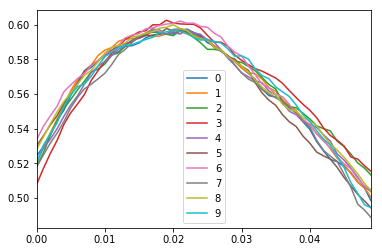

In [7]:
df.plot()
plt.show()

In [8]:
metric_multiplier_cub = df.idxmax().mean()
print("CUB, metric multiplier:", metric_multiplier_cub)

CUB, metric multiplier: 0.0205


## CUB dataset compute performance on test

In [9]:
# logdir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190502_144337_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_mi_weight_test_split_train_split_GZSL_results_test_split"
# filter = "*dataset=xian2017_cub*"

# logdir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190506_124706_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_mi_weight_test_split_train_split_GZSL_results_test_split"
# filter = "*mi_weight=0.4*dataset=xian2017_cub*"

log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split"
filter = "*embedding_size=256*dataset=xian2017_cub*"

log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split"
filter = "*repeat=*dataset=xian2017_cub*"

results_cub = evaluate_test_result(logdir=log_dir, 
                               filter=filter, metric_multiplier=metric_multiplier_cub)


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Loading split trainval
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_cub/split_trainval_xian2017.pkl


Processing models:
['/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_step

INFO:root:Loaded cache in 8.314332 sec
INFO:root:Loading split test_seen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_cub/split_test_seen_xian2017.pkl
INFO:root:Loaded cache in 2.852234 sec
INFO:root:Loading split test_unseen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_cub/split_test_unseen_xian2017.pkl
INFO:root:Loaded cache in 3.537649 sec
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results

Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
221it [00:06, 36.43it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 36.68it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 33.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_i

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
72.9467397082
STD unseen prototype:
73.6523581916


 50%|█████     | 3/6 [00:00<00:00,  5.68it/s]

STD seen prototype:
72.0816929334
STD unseen prototype:
72.1933630854
STD seen prototype:
71.9148848853
STD unseen prototype:
72.006494326


 83%|████████▎ | 5/6 [00:00<00:00,  5.57it/s]

STD seen prototype:
71.9014582812
STD unseen prototype:
71.9475115139
STD seen prototype:
71.8548673014
STD unseen prototype:
71.8948687009


 17%|█▋        | 1/6 [00:00<00:00,  7.52it/s]

STD seen prototype:
71.8564660361
STD unseen prototype:
71.8775973223
****************
SEEN images test
****************
STD seen prototype:
72.2874972609
STD unseen prototype:
75.0187364569


 50%|█████     | 3/6 [00:00<00:00,  7.79it/s]

STD seen prototype:
71.0209358923
STD unseen prototype:
73.9819878994
STD seen prototype:
70.8256789177
STD unseen prototype:
73.9932544238


 83%|████████▎ | 5/6 [00:00<00:00,  7.72it/s]

STD seen prototype:
70.7788105534
STD unseen prototype:
73.9455249037
STD seen prototype:
70.7152502854
STD unseen prototype:
73.8837116653


100%|██████████| 6/6 [00:00<00:00,  7.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
70.7005465546
STD unseen prototype:
73.8920336184
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
221it [00:05, 37.37it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.16it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 38.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_i

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
72.6434347287
STD unseen prototype:
73.0625475931


 50%|█████     | 3/6 [00:00<00:00,  5.70it/s]

STD seen prototype:
71.8191843156
STD unseen prototype:
71.9101084142
STD seen prototype:
71.7287622312
STD unseen prototype:
71.6447108097


 83%|████████▎ | 5/6 [00:00<00:00,  5.68it/s]

STD seen prototype:
71.6448124001
STD unseen prototype:
71.656959976
STD seen prototype:
71.6263214716
STD unseen prototype:
71.600037441


 17%|█▋        | 1/6 [00:00<00:00,  8.38it/s]

STD seen prototype:
71.6006053802
STD unseen prototype:
71.5812361025
****************
SEEN images test
****************
STD seen prototype:
71.9909271489
STD unseen prototype:
74.5523667384


 50%|█████     | 3/6 [00:00<00:00,  8.22it/s]

STD seen prototype:
70.8151622285
STD unseen prototype:
73.8897209019
STD seen prototype:
70.5810634693
STD unseen prototype:
73.6306455773


 83%|████████▎ | 5/6 [00:00<00:00,  8.16it/s]

STD seen prototype:
70.5095678506
STD unseen prototype:
73.6283729866
STD seen prototype:
70.4432931528
STD unseen prototype:
73.6011707856


100%|██████████| 6/6 [00:00<00:00,  7.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
70.4253511256
STD unseen prototype:
73.5873415037
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
221it [00:06, 36.65it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.52it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 37.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_i

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
72.3151154218
STD unseen prototype:
72.6372901285


 50%|█████     | 3/6 [00:00<00:00,  5.46it/s]

STD seen prototype:
71.5771494971
STD unseen prototype:
71.5500119294
STD seen prototype:
71.368928384
STD unseen prototype:
71.3640987985


 67%|██████▋   | 4/6 [00:00<00:00,  5.49it/s]

STD seen prototype:
71.3611973142
STD unseen prototype:
71.3718462598


 83%|████████▎ | 5/6 [00:00<00:00,  5.29it/s]

STD seen prototype:
71.3291379277
STD unseen prototype:
71.3154752857
STD seen prototype:
71.313657884
STD unseen prototype:
71.2873726121


 17%|█▋        | 1/6 [00:00<00:00,  8.53it/s]

****************
SEEN images test
****************
STD seen prototype:
71.9306932896
STD unseen prototype:
74.2548004208


 50%|█████     | 3/6 [00:00<00:00,  8.22it/s]

STD seen prototype:
70.4814620216
STD unseen prototype:
73.4908506827
STD seen prototype:
70.2718852967
STD unseen prototype:
73.3270344608


 83%|████████▎ | 5/6 [00:00<00:00,  7.94it/s]

STD seen prototype:
70.2042631838
STD unseen prototype:
73.281680008
STD seen prototype:
70.1517167506
STD unseen prototype:
73.3051664435


100%|██████████| 6/6 [00:00<00:00,  7.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
70.132819621
STD unseen prototype:
73.298477584
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
221it [00:05, 37.39it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.14it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 37.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_i

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
72.5290540783
STD unseen prototype:
73.0649975063


 50%|█████     | 3/6 [00:00<00:00,  5.70it/s]

STD seen prototype:
71.6873105148
STD unseen prototype:
71.7892170261
STD seen prototype:
71.607497551
STD unseen prototype:
71.6484641419


 83%|████████▎ | 5/6 [00:00<00:00,  5.98it/s]

STD seen prototype:
71.569570023
STD unseen prototype:
71.5266288372
STD seen prototype:
71.5416155207
STD unseen prototype:
71.4934514209


 17%|█▋        | 1/6 [00:00<00:00,  8.48it/s]

STD seen prototype:
71.5380722229
STD unseen prototype:
71.4819896722
****************
SEEN images test
****************
STD seen prototype:
71.9239322688
STD unseen prototype:
74.4690316256


 50%|█████     | 3/6 [00:00<00:00,  8.34it/s]

STD seen prototype:
70.6652462045
STD unseen prototype:
73.6093989464
STD seen prototype:
70.4779442481
STD unseen prototype:
73.5264693633


 83%|████████▎ | 5/6 [00:00<00:00,  7.98it/s]

STD seen prototype:
70.3954605162
STD unseen prototype:
73.5168164141
STD seen prototype:
70.3344605994
STD unseen prototype:
73.4517684433


100%|██████████| 6/6 [00:00<00:00,  7.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
70.3229942377
STD unseen prototype:
73.4566890584
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
221it [00:05, 37.22it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 36.97it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 37.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_i

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
72.4923854817
STD unseen prototype:
72.8407332075


 50%|█████     | 3/6 [00:00<00:00,  5.43it/s]

STD seen prototype:
71.627782701
STD unseen prototype:
71.5787165578
STD seen prototype:
71.4354066062
STD unseen prototype:
71.4383412802


 83%|████████▎ | 5/6 [00:00<00:00,  5.43it/s]

STD seen prototype:
71.4289309647
STD unseen prototype:
71.4071803598
STD seen prototype:
71.3541246659
STD unseen prototype:
71.327063355


 17%|█▋        | 1/6 [00:00<00:00,  8.29it/s]

STD seen prototype:
71.3578786259
STD unseen prototype:
71.3170457684
****************
SEEN images test
****************
STD seen prototype:
71.7690348725
STD unseen prototype:
74.403739248


 50%|█████     | 3/6 [00:00<00:00,  8.30it/s]

STD seen prototype:
70.4472984945
STD unseen prototype:
73.5705610041
STD seen prototype:
70.3377263518
STD unseen prototype:
73.420023334


 83%|████████▎ | 5/6 [00:00<00:00,  8.23it/s]

STD seen prototype:
70.2288150909
STD unseen prototype:
73.3763074469
STD seen prototype:
70.1881378348
STD unseen prototype:
73.3447352101


100%|██████████| 6/6 [00:00<00:00,  7.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
70.1757308393
STD unseen prototype:
73.3401172843
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
221it [00:05, 36.92it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.48it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 38.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_i

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
73.1129040823
STD unseen prototype:
73.7422111164


 50%|█████     | 3/6 [00:00<00:00,  5.91it/s]

STD seen prototype:
72.1328174613
STD unseen prototype:
72.223403712
STD seen prototype:
72.0508285198
STD unseen prototype:
72.0764801153


 83%|████████▎ | 5/6 [00:00<00:00,  5.78it/s]

STD seen prototype:
71.9474961685
STD unseen prototype:
71.9957801053
STD seen prototype:
71.9283859338
STD unseen prototype:
71.9458774014


 17%|█▋        | 1/6 [00:00<00:00,  8.44it/s]

STD seen prototype:
71.9278905238
STD unseen prototype:
71.9192146157
****************
SEEN images test
****************
STD seen prototype:
72.1939024542
STD unseen prototype:
74.8045654802


 50%|█████     | 3/6 [00:00<00:00,  8.25it/s]

STD seen prototype:
71.0747357178
STD unseen prototype:
74.0845821436
STD seen prototype:
70.8346977694
STD unseen prototype:
74.0212284648


 83%|████████▎ | 5/6 [00:00<00:00,  8.08it/s]

STD seen prototype:
70.8131268953
STD unseen prototype:
73.8945456995
STD seen prototype:
70.7610468394
STD unseen prototype:
73.9038564135


100%|██████████| 6/6 [00:00<00:00,  7.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
70.7403722219
STD unseen prototype:
73.8894367873
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
221it [00:05, 38.13it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 37.90it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 39.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_i

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
73.2295336843
STD unseen prototype:
73.4695015727


 50%|█████     | 3/6 [00:00<00:00,  5.78it/s]

STD seen prototype:
72.3318312102
STD unseen prototype:
72.3232577693
STD seen prototype:
72.0985475875
STD unseen prototype:
72.1886258877


 83%|████████▎ | 5/6 [00:00<00:00,  5.67it/s]

STD seen prototype:
72.0842596637
STD unseen prototype:
72.0331473354
STD seen prototype:
72.0537594297
STD unseen prototype:
72.0007986759


 17%|█▋        | 1/6 [00:00<00:00,  8.39it/s]

STD seen prototype:
72.0505449263
STD unseen prototype:
72.009909988
****************
SEEN images test
****************
STD seen prototype:
72.3064055763
STD unseen prototype:
75.3994369523


 50%|█████     | 3/6 [00:00<00:00,  8.25it/s]

STD seen prototype:
71.192941422
STD unseen prototype:
74.1801611838
STD seen prototype:
70.9800806422
STD unseen prototype:
74.0280923746


 83%|████████▎ | 5/6 [00:00<00:00,  8.07it/s]

STD seen prototype:
70.9055654199
STD unseen prototype:
74.0563764752
STD seen prototype:
70.8843354765
STD unseen prototype:
74.0493515702


100%|██████████| 6/6 [00:00<00:00,  7.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
70.8575555094
STD unseen prototype:
74.029451773
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
221it [00:05, 37.46it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.61it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 36.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_i

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
72.6296863982
STD unseen prototype:
73.0374055873


 50%|█████     | 3/6 [00:00<00:00,  5.54it/s]

STD seen prototype:
71.7913519177
STD unseen prototype:
71.8835995733
STD seen prototype:
71.6855493544
STD unseen prototype:
71.6776057301


 83%|████████▎ | 5/6 [00:00<00:00,  5.66it/s]

STD seen prototype:
71.5649804483
STD unseen prototype:
71.5695591396
STD seen prototype:
71.5622859786
STD unseen prototype:
71.5458481322


 17%|█▋        | 1/6 [00:00<00:00,  8.27it/s]

STD seen prototype:
71.5450289719
STD unseen prototype:
71.5148303118
****************
SEEN images test
****************
STD seen prototype:
72.1417460734
STD unseen prototype:
74.6237127494


 50%|█████     | 3/6 [00:00<00:00,  8.25it/s]

STD seen prototype:
70.6452445177
STD unseen prototype:
73.7452857679
STD seen prototype:
70.4944312033
STD unseen prototype:
73.5829745358


 83%|████████▎ | 5/6 [00:00<00:00,  8.12it/s]

STD seen prototype:
70.3794877262
STD unseen prototype:
73.5433163025
STD seen prototype:
70.3432103112
STD unseen prototype:
73.5200353167


100%|██████████| 6/6 [00:00<00:00,  7.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
70.3368036952
STD unseen prototype:
73.5168682567
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
221it [00:05, 36.90it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 38.81it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 37.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_i

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
72.1292452433
STD unseen prototype:
72.4771813077


 50%|█████     | 3/6 [00:00<00:00,  5.52it/s]

STD seen prototype:
71.191497761
STD unseen prototype:
71.2495389871
STD seen prototype:
71.0913034789
STD unseen prototype:
71.1076237942


 83%|████████▎ | 5/6 [00:00<00:00,  5.54it/s]

STD seen prototype:
71.0849622286
STD unseen prototype:
70.9816279153
STD seen prototype:
71.052977406
STD unseen prototype:
71.008239147


 17%|█▋        | 1/6 [00:00<00:00,  8.47it/s]

STD seen prototype:
71.037402535
STD unseen prototype:
70.9843192521
****************
SEEN images test
****************
STD seen prototype:
71.4677641145
STD unseen prototype:
74.0827900744


 50%|█████     | 3/6 [00:00<00:00,  8.30it/s]

STD seen prototype:
70.1889618314
STD unseen prototype:
73.1613429305
STD seen prototype:
69.9938951399
STD unseen prototype:
72.9317228533


 83%|████████▎ | 5/6 [00:00<00:00,  7.88it/s]

STD seen prototype:
69.8872767201
STD unseen prototype:
72.9694682825
STD seen prototype:
69.8573675377
STD unseen prototype:
72.9722741762


100%|██████████| 6/6 [00:00<00:00,  7.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
69.8369298947
STD unseen prototype:
72.9647768905
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
221it [00:05, 37.77it/s]
INFO:root:Computing test embeddings, unseen
93it [00:02, 39.20it/s]
INFO:root:Computing test embeddings, seen
56it [00:01, 39.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_i

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
72.7405020865
STD unseen prototype:
73.259047019


 50%|█████     | 3/6 [00:00<00:00,  5.62it/s]

STD seen prototype:
71.9339572644
STD unseen prototype:
72.0645810574
STD seen prototype:
71.7903943138
STD unseen prototype:
71.7454989536


 83%|████████▎ | 5/6 [00:00<00:00,  5.51it/s]

STD seen prototype:
71.7155919409
STD unseen prototype:
71.7405973457
STD seen prototype:
71.7002360962
STD unseen prototype:
71.6972071509


 17%|█▋        | 1/6 [00:00<00:00,  8.26it/s]

STD seen prototype:
71.6861320692
STD unseen prototype:
71.6551820536
****************
SEEN images test
****************
STD seen prototype:
72.1487505244
STD unseen prototype:
74.8472347144


 50%|█████     | 3/6 [00:00<00:00,  8.23it/s]

STD seen prototype:
70.8354271369
STD unseen prototype:
73.7866579604
STD seen prototype:
70.655148648
STD unseen prototype:
73.6762769837


 83%|████████▎ | 5/6 [00:00<00:00,  8.10it/s]

STD seen prototype:
70.5702679628
STD unseen prototype:
73.6801468255
STD seen prototype:
70.5315294896
STD unseen prototype:
73.6650133959


100%|██████████| 6/6 [00:00<00:00,  7.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
70.5158321401
STD unseen prototype:
73.6631760054
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2017_cub;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


In [10]:
dmean(results_cub)

{'train_AP@50/#sentences10': 0.30836000000000002,
 'train_Top-1 Acc/#sentences10': 0.48826381394947183,
 'train_AP@50/#sentences50': 0.38714666666666664,
 'train_Top-1 Acc/#sentences50': 0.72938277011011254,
 'train_AP@50/#sentences100': 0.39933333333333326,
 'train_Top-1 Acc/#sentences100': 0.7746734534961226,
 'train_AP@50/#sentences200': 0.40505333333333332,
 'train_Top-1 Acc/#sentences200': 0.80095480596025292,
 'train_AP@50/#sentences400': 0.4093066666666666,
 'train_Top-1 Acc/#sentences400': 0.81603590693339945,
 'train_AP@50/#sentences1000': 0.40932000000000002,
 'train_Top-1 Acc/#sentences1000': 0.817886553955115,
 'test_AP@50/#sentences10': 0.33320000000000005,
 'test_Top-1 Acc/#sentences10': 0.42392164088087075,
 'test_AP@50/#sentences50': 0.37728,
 'test_Top-1 Acc/#sentences50': 0.59734013432979249,
 'test_AP@50/#sentences100': 0.38739999999999997,
 'test_Top-1 Acc/#sentences100': 0.62977987690767878,
 'test_AP@50/#sentences200': 0.39188000000000006,
 'test_Top-1 Acc/#senten

## FLOWERS

In [15]:
log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190502_144517_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_mi_weight_test_split_train_split_GZSL_results_validation_split"

log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_222932_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split"
filter = "*embedding_size=1024*dataset=xian2018_flowers*repeat=*"

log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split"
filter = "*repeat=*dataset=xian2018_flowers*"

df_flowers = crossvalidate_metric_multiplier(logdir=log_dir, filter=filter)


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Loading split train
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_flowers/split_train_xian2018.pkl


Processing models:
['/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_l

INFO:root:Loaded cache in 3.971839 sec
INFO:root:Loading split val_seen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_flowers/split_val_seen_xian2018.pkl
INFO:root:Loaded cache in 1.817602 sec
INFO:root:Loading split val_unseen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_flowers/split_val_unseen_xian2018.pkl
INFO:root:Loaded cache in 1.771900 sec
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZ

Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:04, 36.00it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 33.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=15000

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.719514409
STD unseen prototype:
100.79058603
STD seen prototype:
100.859699092
STD unseen prototype:
98.9120323767
STD seen prototype:
100.360240648
STD unseen prototype:
98.6597493612


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.451332448
STD unseen prototype:
98.5197643306
STD seen prototype:
100.166897457
STD unseen prototype:
98.5382967361
STD seen prototype:
100.206788723
STD unseen prototype:
98.5054325884
****************
SEEN images test
****************
STD seen prototype:
98.2211400068
STD unseen prototype:
104.104747024


 83%|████████▎ | 5/6 [00:00<00:00, 19.87it/s]

STD seen prototype:
95.8869395205
STD unseen prototype:
102.140147937
STD seen prototype:
95.4934637491
STD unseen prototype:
101.975606697
STD seen prototype:
95.2955759322
STD unseen prototype:
101.941022379
STD seen prototype:
95.212785184
STD unseen prototype:
102.025375244


100%|██████████| 6/6 [00:00<00:00, 19.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
95.1838408026
STD unseen prototype:
102.014305575
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.25it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.448685916
STD unseen prototype:
101.043555778
STD seen prototype:
100.741208808
STD unseen prototype:
99.2095819023
STD seen prototype:
100.710513771
STD unseen prototype:
98.8894239523


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.150213844
STD unseen prototype:
98.6555940903
STD seen prototype:
100.295391302
STD unseen prototype:
98.5471112666
STD seen prototype:
100.247309777
STD unseen prototype:
98.5072559085
****************
SEEN images test
****************
STD seen prototype:
98.2364277911
STD unseen prototype:
103.085142419


 83%|████████▎ | 5/6 [00:00<00:00, 20.40it/s]

STD seen prototype:
95.8182749657
STD unseen prototype:
101.857025205
STD seen prototype:
95.4499566825
STD unseen prototype:
101.967682292
STD seen prototype:
95.3505030547
STD unseen prototype:
101.939883194
STD seen prototype:
95.2133891185
STD unseen prototype:
101.959832803


100%|██████████| 6/6 [00:00<00:00, 19.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1657895003
STD unseen prototype:
102.014984999
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.33it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.11it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.31it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.05993442
STD unseen prototype:
101.490098404
STD seen prototype:
100.319445813
STD unseen prototype:
98.700786361
STD seen prototype:
100.575195408
STD unseen prototype:
98.8540249327


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.421787592
STD unseen prototype:
98.5485776254
STD seen prototype:
100.304892069
STD unseen prototype:
98.5036263204
STD seen prototype:
100.230174814
STD unseen prototype:
98.5090495321
****************
SEEN images test
****************
STD seen prototype:
98.1940389848
STD unseen prototype:
103.569854013


 83%|████████▎ | 5/6 [00:00<00:00, 19.83it/s]

STD seen prototype:
95.7332888185
STD unseen prototype:
102.637288873
STD seen prototype:
95.4922694632
STD unseen prototype:
102.26112691
STD seen prototype:
95.2993249012
STD unseen prototype:
101.985335349
STD seen prototype:
95.2035551355
STD unseen prototype:
102.046026158


100%|██████████| 6/6 [00:00<00:00, 19.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1641856081
STD unseen prototype:
102.014757183
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.45it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.83it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.762572798
STD unseen prototype:
101.461008275
STD seen prototype:
100.828942229
STD unseen prototype:
98.7507629122
STD seen prototype:
100.254742081
STD unseen prototype:
98.6921375919


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.225975647
STD unseen prototype:
98.6620640015
STD seen prototype:
100.262584106
STD unseen prototype:
98.4436088635
STD seen prototype:
100.213119151
STD unseen prototype:
98.5090031456
****************
SEEN images test
****************
STD seen prototype:
98.117835859
STD unseen prototype:
103.675833994


 67%|██████▋   | 4/6 [00:00<00:00, 19.11it/s]

STD seen prototype:
95.9390607417
STD unseen prototype:
102.497377863
STD seen prototype:
95.4239019392
STD unseen prototype:
102.17788227
STD seen prototype:
95.2951342976
STD unseen prototype:
101.919798557
STD seen prototype:
95.2275326774
STD unseen prototype:
102.014448458


100%|██████████| 6/6 [00:00<00:00, 18.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1715272616
STD unseen prototype:
102.014337742
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.47it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.371826062
STD unseen prototype:
101.243016744
STD seen prototype:
100.864827423
STD unseen prototype:
98.8975560472
STD seen prototype:
100.15092568
STD unseen prototype:
98.7446901017


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.145016584
STD unseen prototype:
98.6925017087
STD seen prototype:
100.24592382
STD unseen prototype:
98.5005526305
STD seen prototype:
100.185217786
STD unseen prototype:
98.50396331
****************
SEEN images test
****************
STD seen prototype:
98.0704883848
STD unseen prototype:
103.567168143


 83%|████████▎ | 5/6 [00:00<00:00, 19.68it/s]

STD seen prototype:
95.9275280276
STD unseen prototype:
102.108353459
STD seen prototype:
95.469937225
STD unseen prototype:
102.117978838
STD seen prototype:
95.3297898489
STD unseen prototype:
101.991190064
STD seen prototype:
95.2260655824
STD unseen prototype:
102.121417634


100%|██████████| 6/6 [00:00<00:00, 19.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1839328433
STD unseen prototype:
102.014731923
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.33it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.930265998
STD unseen prototype:
101.058882835
STD seen prototype:
100.313332636
STD unseen prototype:
98.9028494517
STD seen prototype:
100.486854413
STD unseen prototype:
98.7170658279


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.178088203
STD unseen prototype:
98.5377285973
STD seen prototype:
100.352576124
STD unseen prototype:
98.501154584
STD seen prototype:
100.232697987
STD unseen prototype:
98.5001356414
****************
SEEN images test
****************
STD seen prototype:
98.1718743285
STD unseen prototype:
103.467629606


 67%|██████▋   | 4/6 [00:00<00:00, 19.42it/s]

STD seen prototype:
96.0237296968
STD unseen prototype:
101.914111632
STD seen prototype:
95.5860641641
STD unseen prototype:
102.177530624
STD seen prototype:
95.3656931872
STD unseen prototype:
102.202385502
STD seen prototype:
95.2236938208
STD unseen prototype:
101.991505219


100%|██████████| 6/6 [00:00<00:00, 18.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1897364786
STD unseen prototype:
102.014579234
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.37it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.772861758
STD unseen prototype:
100.754156333
STD seen prototype:
100.584523431
STD unseen prototype:
98.9579608297
STD seen prototype:
100.271451312
STD unseen prototype:
98.5945283824


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.442698411
STD unseen prototype:
98.6759201193
STD seen prototype:
100.2679333
STD unseen prototype:
98.5725780467
STD seen prototype:
100.216288218
STD unseen prototype:
98.5023352933
****************
SEEN images test
****************
STD seen prototype:
98.3386798273
STD unseen prototype:
104.386171059


 83%|████████▎ | 5/6 [00:00<00:00, 20.17it/s]

STD seen prototype:
95.8613915679
STD unseen prototype:
101.548118942
STD seen prototype:
95.5432937596
STD unseen prototype:
102.302097934
STD seen prototype:
95.3983074303
STD unseen prototype:
102.171572582
STD seen prototype:
95.2088053634
STD unseen prototype:
102.027401247


100%|██████████| 6/6 [00:00<00:00, 19.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1790228665
STD unseen prototype:
102.014896006
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.92it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.29089019
STD unseen prototype:
100.980892224
STD seen prototype:
100.522110362
STD unseen prototype:
99.3011179267
STD seen prototype:
100.270194356
STD unseen prototype:
98.6308282547


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.240787877
STD unseen prototype:
98.6350515254
STD seen prototype:
100.20111718
STD unseen prototype:
98.5605700378
STD seen prototype:
100.210599411
STD unseen prototype:
98.5014393913
****************
SEEN images test
****************
STD seen prototype:
98.2366286954
STD unseen prototype:
104.635228345


 83%|████████▎ | 5/6 [00:00<00:00, 20.09it/s]

STD seen prototype:
95.808505404
STD unseen prototype:
102.283391935
STD seen prototype:
95.5154706009
STD unseen prototype:
101.66847754
STD seen prototype:
95.315584291
STD unseen prototype:
102.245961205
STD seen prototype:
95.2511842336
STD unseen prototype:
102.07723061


100%|██████████| 6/6 [00:00<00:00, 19.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1741884119
STD unseen prototype:
102.014175172
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.42it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.752367671
STD unseen prototype:
100.643680372
STD seen prototype:
100.357524093
STD unseen prototype:
98.9803823969
STD seen prototype:
100.416316423
STD unseen prototype:
99.0901829684


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.45484745
STD unseen prototype:
98.6425625787
STD seen prototype:
100.143014901
STD unseen prototype:
98.5072529576
STD seen prototype:
100.199528491
STD unseen prototype:
98.5018364127
****************
SEEN images test
****************
STD seen prototype:
98.2704859516
STD unseen prototype:
103.879229461


 83%|████████▎ | 5/6 [00:00<00:00, 20.17it/s]

STD seen prototype:
95.8329566421
STD unseen prototype:
101.833026289
STD seen prototype:
95.4335796346
STD unseen prototype:
102.189966069
STD seen prototype:
95.2971487104
STD unseen prototype:
102.089056629
STD seen prototype:
95.2380605868
STD unseen prototype:
102.054389394


100%|██████████| 6/6 [00:00<00:00, 19.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1691711953
STD unseen prototype:
102.01539651
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.77it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.20it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.911591984
STD unseen prototype:
101.098444508
STD seen prototype:
100.322731682
STD unseen prototype:
98.9834116504
STD seen prototype:
100.394267609
STD unseen prototype:
98.6294888075


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.259498834
STD unseen prototype:
98.5927451505
STD seen prototype:
100.349636404
STD unseen prototype:
98.5232231325
STD seen prototype:
100.211177506
STD unseen prototype:
98.5020720619
****************
SEEN images test
****************
STD seen prototype:
98.6226863461
STD unseen prototype:
103.338289339


 67%|██████▋   | 4/6 [00:00<00:00, 18.86it/s]

STD seen prototype:
95.912047044
STD unseen prototype:
102.278035451
STD seen prototype:
95.5120941519
STD unseen prototype:
102.156951545
STD seen prototype:
95.285538399
STD unseen prototype:
102.168526234
STD seen prototype:
95.2303973525
STD unseen prototype:
101.976766646


100%|██████████| 6/6 [00:00<00:00, 18.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1702997752
STD unseen prototype:
102.0140232
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.65it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 13.02it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.083048767
STD unseen prototype:
101.277962786
STD seen prototype:
100.325425504
STD unseen prototype:
99.025337317


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.348396599
STD unseen prototype:
98.8801786307
STD seen prototype:
100.183460542
STD unseen prototype:
98.4828685438
STD seen prototype:
100.281724133
STD unseen prototype:
98.4874493871
STD seen prototype:
100.191444189
STD unseen prototype:
98.5015717088
****************
SEEN images test
****************


 67%|██████▋   | 4/6 [00:00<00:00, 19.72it/s]

STD seen prototype:
98.433710345
STD unseen prototype:
104.349971564
STD seen prototype:
95.9061958628
STD unseen prototype:
102.477501149
STD seen prototype:
95.5685272131
STD unseen prototype:
101.889835259
STD seen prototype:
95.3030682707
STD unseen prototype:
101.907244821


100%|██████████| 6/6 [00:00<00:00, 19.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.2525979367
STD unseen prototype:
101.999361592
STD seen prototype:
95.1811648747
STD unseen prototype:
102.014655266
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.18it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.869387836
STD unseen prototype:
101.110208919
STD seen prototype:
100.247998517
STD unseen prototype:
98.9004302394
STD seen prototype:
100.578922512
STD unseen prototype:
98.8181426024


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.205338083
STD unseen prototype:
98.5529161637
STD seen prototype:
100.194576718
STD unseen prototype:
98.5520633588
STD seen prototype:
100.206932307
STD unseen prototype:
98.5068353196
****************
SEEN images test
****************
STD seen prototype:
98.5718413868
STD unseen prototype:
103.460068018


 83%|████████▎ | 5/6 [00:00<00:00, 20.26it/s]

STD seen prototype:
95.7689564232
STD unseen prototype:
102.347787825
STD seen prototype:
95.4584689169
STD unseen prototype:
101.911304189
STD seen prototype:
95.3202487587
STD unseen prototype:
102.218946407
STD seen prototype:
95.2219126076
STD unseen prototype:
102.010124815


100%|██████████| 6/6 [00:00<00:00, 19.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1850102222
STD unseen prototype:
102.014766077
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.48it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.04it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.239749372
STD unseen prototype:
101.639601634
STD seen prototype:
100.171606678
STD unseen prototype:
98.9467123225
STD seen prototype:
100.385555762
STD unseen prototype:
98.9256507201


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.157441033
STD unseen prototype:
98.6588946675
STD seen prototype:
100.277838245
STD unseen prototype:
98.5280709177
STD seen prototype:
100.181024148
STD unseen prototype:
98.5036853423
****************
SEEN images test
****************
STD seen prototype:
98.5204746818
STD unseen prototype:
104.459162067


 67%|██████▋   | 4/6 [00:00<00:00, 18.44it/s]

STD seen prototype:
95.8930500571
STD unseen prototype:
102.265861876
STD seen prototype:
95.4600968019
STD unseen prototype:
102.377946
STD seen prototype:
95.2939496037
STD unseen prototype:
101.933628106
STD seen prototype:
95.2391018269
STD unseen prototype:
102.073037009


100%|██████████| 6/6 [00:00<00:00, 18.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1857161539
STD unseen prototype:
102.015072513
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.44it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.55it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.779228789
STD unseen prototype:
100.904700662
STD seen prototype:
100.478962341
STD unseen prototype:
98.9443503083
STD seen prototype:
100.363299388
STD unseen prototype:
98.7404442315


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.316753619
STD unseen prototype:
98.694400061
STD seen prototype:
100.234682411
STD unseen prototype:
98.5400660955
STD seen prototype:
100.23369714
STD unseen prototype:
98.5040391699
****************
SEEN images test
****************
STD seen prototype:
98.6257118107
STD unseen prototype:
103.931937524


 67%|██████▋   | 4/6 [00:00<00:00, 18.54it/s]

STD seen prototype:
95.8999088139
STD unseen prototype:
102.120596493
STD seen prototype:
95.5368104542
STD unseen prototype:
101.762366758
STD seen prototype:
95.3164024114
STD unseen prototype:
102.163244617
STD seen prototype:
95.2029742438
STD unseen prototype:
102.041280334


100%|██████████| 6/6 [00:00<00:00, 18.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1751263991
STD unseen prototype:
102.01440666
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.933038324
STD unseen prototype:
100.913933122
STD seen prototype:
100.608303137
STD unseen prototype:
98.8475995058
STD seen prototype:
100.462122684
STD unseen prototype:
98.8457890236


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.345765052
STD unseen prototype:
98.6775224512
STD seen prototype:
100.154686478
STD unseen prototype:
98.5555285443
STD seen prototype:
100.224971287
STD unseen prototype:
98.5031578056
****************
SEEN images test
****************
STD seen prototype:
98.3850515469
STD unseen prototype:
104.193980414


 67%|██████▋   | 4/6 [00:00<00:00, 19.57it/s]

STD seen prototype:
95.8951322865
STD unseen prototype:
102.329379899
STD seen prototype:
95.4798626291
STD unseen prototype:
101.980254933
STD seen prototype:
95.3544039953
STD unseen prototype:
102.149877394
STD seen prototype:
95.2198661981
STD unseen prototype:
102.019682446


100%|██████████| 6/6 [00:00<00:00, 18.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1766330994
STD unseen prototype:
102.01380284
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.96it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.879659177
STD unseen prototype:
100.643595183
STD seen prototype:
100.627071644
STD unseen prototype:
99.1063900361
STD seen prototype:
100.115823091
STD unseen prototype:
98.766806942


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.212670077
STD unseen prototype:
98.627496473
STD seen prototype:
100.140767945
STD unseen prototype:
98.5218620814
STD seen prototype:
100.223322084
STD unseen prototype:
98.5092631328
****************
SEEN images test
****************
STD seen prototype:
98.0981838829
STD unseen prototype:
103.377729588


 50%|█████     | 3/6 [00:00<00:00, 20.78it/s]

STD seen prototype:
95.9914894153
STD unseen prototype:
102.210891161
STD seen prototype:
95.5696934814
STD unseen prototype:
101.798468841
STD seen prototype:
95.318944589
STD unseen prototype:
101.882320897
STD seen prototype:
95.2284984155
STD unseen prototype:
101.958850998
STD seen prototype:
95.1789828243
STD unseen prototype:
102.015113966


100%|██████████| 6/6 [00:00<00:00, 20.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.84it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.68321444
STD unseen prototype:
100.406578861
STD seen prototype:
100.779587337
STD unseen prototype:
98.8411512458
STD seen prototype:
100.33609806
STD unseen prototype:
98.5627506363


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.297484206
STD unseen prototype:
98.5931598338
STD seen prototype:
100.279666716
STD unseen prototype:
98.4741314131
STD seen prototype:
100.225624438
STD unseen prototype:
98.5060133626
****************
SEEN images test
****************
STD seen prototype:
98.6732934278
STD unseen prototype:
104.022522336


 83%|████████▎ | 5/6 [00:00<00:00, 20.40it/s]

STD seen prototype:
95.7466796514
STD unseen prototype:
102.13368742
STD seen prototype:
95.5987044076
STD unseen prototype:
101.994513652
STD seen prototype:
95.3491597308
STD unseen prototype:
102.078322962
STD seen prototype:
95.2039110876
STD unseen prototype:
101.957577161


100%|██████████| 6/6 [00:00<00:00, 19.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1674389722
STD unseen prototype:
102.01502706
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.19it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.828369321
STD unseen prototype:
101.237461514
STD seen prototype:
100.168277484
STD unseen prototype:
98.6869662379
STD seen prototype:
100.303066383
STD unseen prototype:
98.718060636


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.296739766
STD unseen prototype:
98.583668932
STD seen prototype:
100.171090878
STD unseen prototype:
98.503756517
STD seen prototype:
100.240900474
STD unseen prototype:
98.5088716347
****************
SEEN images test
****************
STD seen prototype:
98.5553510345
STD unseen prototype:
103.264703965


 67%|██████▋   | 4/6 [00:00<00:00, 18.92it/s]

STD seen prototype:
95.7911998518
STD unseen prototype:
102.114824343
STD seen prototype:
95.5630147465
STD unseen prototype:
102.101525598
STD seen prototype:
95.3791914013
STD unseen prototype:
102.017616423
STD seen prototype:
95.2068196812
STD unseen prototype:
102.046473692


100%|██████████| 6/6 [00:00<00:00, 18.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1736906996
STD unseen prototype:
102.013946339
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.17it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.38666281
STD unseen prototype:
101.292575035
STD seen prototype:
100.651908415
STD unseen prototype:
99.0150994519
STD seen prototype:
100.514207069
STD unseen prototype:
98.5800492353


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.336574915
STD unseen prototype:
98.5732808715
STD seen prototype:
100.247155469
STD unseen prototype:
98.4774016266
STD seen prototype:
100.201406744
STD unseen prototype:
98.5042926403
****************
SEEN images test
****************
STD seen prototype:
98.326079288
STD unseen prototype:
103.636853819


 67%|██████▋   | 4/6 [00:00<00:00, 19.59it/s]

STD seen prototype:
95.8746996592
STD unseen prototype:
102.121213883
STD seen prototype:
95.4494209732
STD unseen prototype:
102.238539304
STD seen prototype:
95.3092287859
STD unseen prototype:
101.956475056
STD seen prototype:
95.2383414276
STD unseen prototype:
102.012674667


100%|██████████| 6/6 [00:00<00:00, 19.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1862988273
STD unseen prototype:
102.015395205
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.566885313
STD unseen prototype:
100.90150117
STD seen prototype:
100.430752288
STD unseen prototype:
99.1137422466
STD seen prototype:
100.095048722
STD unseen prototype:
98.6255715782


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.459902157
STD unseen prototype:
98.5500600703
STD seen prototype:
100.185387878
STD unseen prototype:
98.4511372175
STD seen prototype:
100.185735058
STD unseen prototype:
98.5078630014
****************
SEEN images test
****************
STD seen prototype:
98.4938607387
STD unseen prototype:
104.94410188


 67%|██████▋   | 4/6 [00:00<00:00, 18.57it/s]

STD seen prototype:
95.7422915787
STD unseen prototype:
102.057088115
STD seen prototype:
95.4918312811
STD unseen prototype:
102.065836636
STD seen prototype:
95.3034909247
STD unseen prototype:
102.11755697
STD seen prototype:
95.2525772168
STD unseen prototype:
102.009713845


100%|██████████| 6/6 [00:00<00:00, 17.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1775360565
STD unseen prototype:
102.014509287
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.96it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.95300901
STD unseen prototype:
100.486768688
STD seen prototype:
100.093027591
STD unseen prototype:
99.0118863391
STD seen prototype:
100.253893519
STD unseen prototype:
98.7445641362


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.253209948
STD unseen prototype:
98.6274295428
STD seen prototype:
100.31743034
STD unseen prototype:
98.5011323576
STD seen prototype:
100.226207242
STD unseen prototype:
98.5079387183
****************
SEEN images test
****************
STD seen prototype:
98.3899138888
STD unseen prototype:
103.281698659


 83%|████████▎ | 5/6 [00:00<00:00, 20.01it/s]

STD seen prototype:
95.8487356507
STD unseen prototype:
102.247514336
STD seen prototype:
95.5076269863
STD unseen prototype:
102.001574804
STD seen prototype:
95.2986226445
STD unseen prototype:
101.81942898
STD seen prototype:
95.3021514329
STD unseen prototype:
102.067296366


100%|██████████| 6/6 [00:00<00:00, 19.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1649247406
STD unseen prototype:
102.015251443
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.69it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.357279095
STD unseen prototype:
100.950786697
STD seen prototype:
100.457896936
STD unseen prototype:
99.1303503332
STD seen prototype:
100.051938723
STD unseen prototype:
98.657727429


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.207040858
STD unseen prototype:
98.6678189993
STD seen prototype:
100.279016612
STD unseen prototype:
98.5208232755
STD seen prototype:
100.224897254
STD unseen prototype:
98.5047882031
****************
SEEN images test
****************
STD seen prototype:
98.2714914862
STD unseen prototype:
104.445309114


 67%|██████▋   | 4/6 [00:00<00:00, 19.63it/s]

STD seen prototype:
95.725665524
STD unseen prototype:
102.38346315
STD seen prototype:
95.4734356552
STD unseen prototype:
102.064217354
STD seen prototype:
95.3223384594
STD unseen prototype:
101.684126463
STD seen prototype:
95.2061114712
STD unseen prototype:
101.958652425


100%|██████████| 6/6 [00:00<00:00, 19.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1994041993
STD unseen prototype:
102.015330914
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.08it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.18it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.18it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.00425241
STD unseen prototype:
100.446236324
STD seen prototype:
100.734463812
STD unseen prototype:
99.2153132666
STD seen prototype:
100.299179654
STD unseen prototype:
98.6202870422


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.127364163
STD unseen prototype:
98.5833660229
STD seen prototype:
100.340695394
STD unseen prototype:
98.5744031159
STD seen prototype:
100.210058104
STD unseen prototype:
98.5086014122
****************
SEEN images test
****************
STD seen prototype:
98.2306597466
STD unseen prototype:
103.691481412
STD seen prototype:
95.8241121732
STD unseen prototype:
102.685430628


100%|██████████| 6/6 [00:00<00:00, 20.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.5144371118
STD unseen prototype:
102.240804846
STD seen prototype:
95.2973358054
STD unseen prototype:
101.910014091
STD seen prototype:
95.2539624377
STD unseen prototype:
102.03571533
STD seen prototype:
95.1773807789
STD unseen prototype:
102.014062342
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.67it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.97356319
STD unseen prototype:
100.690637799
STD seen prototype:
100.36904292
STD unseen prototype:
98.9091429859
STD seen prototype:
100.306530429
STD unseen prototype:
98.7174002421


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.391289381
STD unseen prototype:
98.5922674527
STD seen prototype:
100.251437367
STD unseen prototype:
98.5305233646
STD seen prototype:
100.192503735
STD unseen prototype:
98.5070465102
****************
SEEN images test
****************
STD seen prototype:
98.9690678965
STD unseen prototype:
104.015030191


 67%|██████▋   | 4/6 [00:00<00:00, 19.81it/s]

STD seen prototype:
95.9074477716
STD unseen prototype:
101.714452859
STD seen prototype:
95.4516383699
STD unseen prototype:
102.048715032
STD seen prototype:
95.3084559242
STD unseen prototype:
102.025726954
STD seen prototype:
95.2241330594
STD unseen prototype:
102.005492619


100%|██████████| 6/6 [00:00<00:00, 19.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
95.1786364925
STD unseen prototype:
102.014345108
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.91it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.71it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.243740306
STD unseen prototype:
101.467904973
STD seen prototype:
100.48975209
STD unseen prototype:
99.0192196507
STD seen prototype:
100.500130111
STD unseen prototype:
98.8154203242


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.260391666
STD unseen prototype:
98.618167278
STD seen prototype:
100.166979009
STD unseen prototype:
98.5320885111
STD seen prototype:
100.215788879
STD unseen prototype:
98.5096489964
****************
SEEN images test
****************
STD seen prototype:
98.4628485543
STD unseen prototype:
104.044856268


 67%|██████▋   | 4/6 [00:00<00:00, 18.36it/s]

STD seen prototype:
95.8622864951
STD unseen prototype:
102.018596063
STD seen prototype:
95.5103756682
STD unseen prototype:
102.306068093
STD seen prototype:
95.319275796
STD unseen prototype:
102.078203747
STD seen prototype:
95.2214821177
STD unseen prototype:
102.059822619


100%|██████████| 6/6 [00:00<00:00, 17.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1922994744
STD unseen prototype:
102.015522482
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.24it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.752325414
STD unseen prototype:
101.0069404
STD seen prototype:
100.617135862
STD unseen prototype:
98.8267797244
STD seen prototype:
100.14199818
STD unseen prototype:
98.9239183761


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.215899527
STD unseen prototype:
98.5571500917
STD seen prototype:
100.183554198
STD unseen prototype:
98.5553438928
STD seen prototype:
100.219563435
STD unseen prototype:
98.5015631192
****************
SEEN images test
****************
STD seen prototype:
98.4523709623
STD unseen prototype:
103.057411005


 67%|██████▋   | 4/6 [00:00<00:00, 18.76it/s]

STD seen prototype:
95.7950896388
STD unseen prototype:
102.816880992
STD seen prototype:
95.4541106503
STD unseen prototype:
102.319613729
STD seen prototype:
95.302630688
STD unseen prototype:
101.985846788
STD seen prototype:
95.2343313841
STD unseen prototype:
102.008775726


100%|██████████| 6/6 [00:00<00:00, 18.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.174136861
STD unseen prototype:
102.014914205
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.07it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.247006012
STD unseen prototype:
101.921616757
STD seen prototype:
100.322291548
STD unseen prototype:
98.9376146597
STD seen prototype:
100.394548795
STD unseen prototype:
98.8950135548


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.418118154
STD unseen prototype:
98.4996991791
STD seen prototype:
100.219580807
STD unseen prototype:
98.5710122468
STD seen prototype:
100.199744347
STD unseen prototype:
98.4996820605
****************
SEEN images test
****************
STD seen prototype:
98.6581593183
STD unseen prototype:
104.030743956


 83%|████████▎ | 5/6 [00:00<00:00, 19.96it/s]

STD seen prototype:
95.9257112855
STD unseen prototype:
102.283839289
STD seen prototype:
95.4999886522
STD unseen prototype:
102.141861452
STD seen prototype:
95.3195387118
STD unseen prototype:
102.285491114
STD seen prototype:
95.1959562134
STD unseen prototype:
102.043737676


100%|██████████| 6/6 [00:00<00:00, 19.38it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1871515102
STD unseen prototype:
102.014659831
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.62it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.763385331
STD unseen prototype:
100.622232024
STD seen prototype:
100.653093122
STD unseen prototype:
98.9190398744
STD seen prototype:
100.245645192
STD unseen prototype:
98.5458560979


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.268894663
STD unseen prototype:
98.679426093
STD seen prototype:
100.363392239
STD unseen prototype:
98.4972703695
STD seen prototype:
100.205476023
STD unseen prototype:
98.5087904987
****************
SEEN images test
****************
STD seen prototype:
98.4352408659
STD unseen prototype:
103.558074989


 67%|██████▋   | 4/6 [00:00<00:00, 19.15it/s]

STD seen prototype:
95.788989792
STD unseen prototype:
102.81555397
STD seen prototype:
95.6384319748
STD unseen prototype:
102.173752636
STD seen prototype:
95.396121285
STD unseen prototype:
101.700961399
STD seen prototype:
95.2132285544
STD unseen prototype:
102.003774842


100%|██████████| 6/6 [00:00<00:00, 18.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.172604133
STD unseen prototype:
102.014359079
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.27it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.12it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.540876455
STD unseen prototype:
101.475243422
STD seen prototype:
100.787513978
STD unseen prototype:
98.9814424203
STD seen prototype:
100.281803778
STD unseen prototype:
98.5947091259


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.159667922
STD unseen prototype:
98.572135818
STD seen prototype:
100.080823434
STD unseen prototype:
98.5775819957
STD seen prototype:
100.209646801
STD unseen prototype:
98.5010446013
****************
SEEN images test
****************
STD seen prototype:
98.3096506631
STD unseen prototype:
103.431506571


 67%|██████▋   | 4/6 [00:00<00:00, 19.72it/s]

STD seen prototype:
95.7915517834
STD unseen prototype:
102.597705808
STD seen prototype:
95.5145885533
STD unseen prototype:
102.115786126
STD seen prototype:
95.3739259238
STD unseen prototype:
101.858961271
STD seen prototype:
95.215548534
STD unseen prototype:
102.077761096


100%|██████████| 6/6 [00:00<00:00, 19.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.176587848
STD unseen prototype:
102.014394881
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.62it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.108861877
STD unseen prototype:
101.356043851
STD seen prototype:
100.455589388
STD unseen prototype:
98.9532033267
STD seen prototype:
100.414869957
STD unseen prototype:
98.6738801911


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.263661329
STD unseen prototype:
98.6685895247
STD seen prototype:
100.211765542
STD unseen prototype:
98.459525888
STD seen prototype:
100.196784506
STD unseen prototype:
98.4971018355
****************
SEEN images test
****************
STD seen prototype:
98.0574475425
STD unseen prototype:
103.419255725


 67%|██████▋   | 4/6 [00:00<00:00, 18.07it/s]

STD seen prototype:
95.8120905087
STD unseen prototype:
102.335841635
STD seen prototype:
95.467148688
STD unseen prototype:
102.276294471
STD seen prototype:
95.3463385918
STD unseen prototype:
102.100135123
STD seen prototype:
95.2166637938
STD unseen prototype:
101.81895598


100%|██████████| 6/6 [00:00<00:00, 17.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.185383183
STD unseen prototype:
102.014801253
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.28it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 36.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.043914971
STD unseen prototype:
101.353658287
STD seen prototype:
100.60189069
STD unseen prototype:
99.0154764764
STD seen prototype:
100.337614989
STD unseen prototype:
98.6117614082


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.274380884
STD unseen prototype:
98.6172710455
STD seen prototype:
100.358907265
STD unseen prototype:
98.479756284
STD seen prototype:
100.210134982
STD unseen prototype:
98.5112989017
****************
SEEN images test
****************
STD seen prototype:
98.032940535
STD unseen prototype:
102.833691912


 67%|██████▋   | 4/6 [00:00<00:00, 19.09it/s]

STD seen prototype:
95.83485393
STD unseen prototype:
102.809818032
STD seen prototype:
95.550898647
STD unseen prototype:
101.961857723
STD seen prototype:
95.3076764952
STD unseen prototype:
101.951753703
STD seen prototype:
95.2344410232
STD unseen prototype:
102.019831459


100%|██████████| 6/6 [00:00<00:00, 18.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.166142873
STD unseen prototype:
102.015357225
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.59it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.00it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.050108376
STD unseen prototype:
101.231631077
STD seen prototype:
100.5286586
STD unseen prototype:
99.0291943231
STD seen prototype:
100.103301429
STD unseen prototype:
98.7170134791


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.236506806
STD unseen prototype:
98.6278741437
STD seen prototype:
100.337732648
STD unseen prototype:
98.5056079885
STD seen prototype:
100.217971336
STD unseen prototype:
98.5023592549
****************
SEEN images test
****************
STD seen prototype:
98.3714759444
STD unseen prototype:
104.046386218


 67%|██████▋   | 4/6 [00:00<00:00, 19.59it/s]

STD seen prototype:
95.8442667025
STD unseen prototype:
101.816513804
STD seen prototype:
95.4672317433
STD unseen prototype:
102.120628933
STD seen prototype:
95.3582798009
STD unseen prototype:
102.025021433
STD seen prototype:
95.2288784548
STD unseen prototype:
102.060010214


100%|██████████| 6/6 [00:00<00:00, 19.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.173054263
STD unseen prototype:
102.014465354
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.20it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.213441573
STD unseen prototype:
100.585526119
STD seen prototype:
100.218732995
STD unseen prototype:
99.2688113242
STD seen prototype:
100.604608709
STD unseen prototype:
98.9611656359


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.326937799
STD unseen prototype:
98.6263708031
STD seen prototype:
100.224763307
STD unseen prototype:
98.5829489005
STD seen prototype:
100.194185754
STD unseen prototype:
98.5039384061
****************
SEEN images test
****************
STD seen prototype:
98.0230291702
STD unseen prototype:
103.52943548


 83%|████████▎ | 5/6 [00:00<00:00, 19.73it/s]

STD seen prototype:
95.694635955
STD unseen prototype:
101.906658192
STD seen prototype:
95.6039197134
STD unseen prototype:
102.279564145
STD seen prototype:
95.3442363094
STD unseen prototype:
102.213417345
STD seen prototype:
95.2123575601
STD unseen prototype:
102.088757681


100%|██████████| 6/6 [00:00<00:00, 19.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1775077897
STD unseen prototype:
102.015045039
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.63it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.836232849
STD unseen prototype:
101.042767145
STD seen prototype:
100.522047356
STD unseen prototype:
99.0171153624
STD seen prototype:
100.254982495
STD unseen prototype:
98.6739742295


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.16273885
STD unseen prototype:
98.6760775495
STD seen prototype:
100.109981284
STD unseen prototype:
98.4777857913
STD seen prototype:
100.209167572
STD unseen prototype:
98.5051072976
****************
SEEN images test
****************
STD seen prototype:
98.5138052986
STD unseen prototype:
103.891231878


 67%|██████▋   | 4/6 [00:00<00:00, 19.51it/s]

STD seen prototype:
95.9659721711
STD unseen prototype:
102.152479549
STD seen prototype:
95.4198069139
STD unseen prototype:
102.266166067
STD seen prototype:
95.3219175001
STD unseen prototype:
102.030762462
STD seen prototype:
95.2029635205
STD unseen prototype:
101.971968866


100%|██████████| 6/6 [00:00<00:00, 18.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1894813383
STD unseen prototype:
102.01468282
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.84it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.25it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.080537282
STD unseen prototype:
100.740292168
STD seen prototype:
100.574311898
STD unseen prototype:
98.8544606534
STD seen prototype:
100.154913333
STD unseen prototype:
98.7526581928


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.368313032
STD unseen prototype:
98.5791515322
STD seen prototype:
100.123043191
STD unseen prototype:
98.5127849347
STD seen prototype:
100.205546924
STD unseen prototype:
98.5065304958
****************
SEEN images test
****************
STD seen prototype:
98.4100367367
STD unseen prototype:
103.027521268


 83%|████████▎ | 5/6 [00:00<00:00, 20.38it/s]

STD seen prototype:
95.8631745874
STD unseen prototype:
102.566245448
STD seen prototype:
95.4956320344
STD unseen prototype:
102.125559645
STD seen prototype:
95.2930980569
STD unseen prototype:
101.956914172
STD seen prototype:
95.203074359
STD unseen prototype:
102.003834418


100%|██████████| 6/6 [00:00<00:00, 19.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1869221929
STD unseen prototype:
102.014421376
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.68it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.169994176
STD unseen prototype:
101.273093112
STD seen prototype:
100.897180075
STD unseen prototype:
99.0297694203
STD seen prototype:
100.211889651
STD unseen prototype:
98.7261829808


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.074451431
STD unseen prototype:
98.5480993077
STD seen prototype:
100.361240186
STD unseen prototype:
98.4932810852
STD seen prototype:
100.173353142
STD unseen prototype:
98.5047095114
****************
SEEN images test
****************
STD seen prototype:
98.2832607332
STD unseen prototype:
103.459428399


 67%|██████▋   | 4/6 [00:00<00:00, 19.53it/s]

STD seen prototype:
95.8343367763
STD unseen prototype:
101.995410637
STD seen prototype:
95.4953386987
STD unseen prototype:
102.308176618
STD seen prototype:
95.3406604421
STD unseen prototype:
102.017725841
STD seen prototype:
95.2066619554
STD unseen prototype:
102.070034373


100%|██████████| 6/6 [00:00<00:00, 19.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1833302378
STD unseen prototype:
102.01512463
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.64it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.55it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.844806418
STD unseen prototype:
101.659327222
STD seen prototype:
100.429260589
STD unseen prototype:
98.9361610944
STD seen prototype:
100.175430537
STD unseen prototype:
98.7600866053


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.287137308
STD unseen prototype:
98.5716527437
STD seen prototype:
100.19669527
STD unseen prototype:
98.4673868871
STD seen prototype:
100.1742361
STD unseen prototype:
98.505483449
****************
SEEN images test
****************
STD seen prototype:
98.5507797758
STD unseen prototype:
103.63706287


 83%|████████▎ | 5/6 [00:00<00:00, 20.17it/s]

STD seen prototype:
95.8620565567
STD unseen prototype:
102.16442447
STD seen prototype:
95.4522433037
STD unseen prototype:
102.14527064
STD seen prototype:
95.3413276393
STD unseen prototype:
102.068870555
STD seen prototype:
95.2537629841
STD unseen prototype:
102.073817848


100%|██████████| 6/6 [00:00<00:00, 19.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1713672471
STD unseen prototype:
102.014823279
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.25it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.422327677
STD unseen prototype:
101.026412731
STD seen prototype:
100.778590981
STD unseen prototype:
98.9661634385
STD seen prototype:
100.420951614
STD unseen prototype:
98.6839091183


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.170620223
STD unseen prototype:
98.5847242406
STD seen prototype:
100.241052613
STD unseen prototype:
98.5453604634
STD seen prototype:
100.21034155
STD unseen prototype:
98.5030735755
****************
SEEN images test
****************
STD seen prototype:
98.3022011701
STD unseen prototype:
103.819434339


 67%|██████▋   | 4/6 [00:00<00:00, 19.93it/s]

STD seen prototype:
95.792843145
STD unseen prototype:
102.324026414
STD seen prototype:
95.496668373
STD unseen prototype:
102.356884115
STD seen prototype:
95.3082990602
STD unseen prototype:
101.760515959
STD seen prototype:
95.2169322611
STD unseen prototype:
102.003791705


100%|██████████| 6/6 [00:00<00:00, 18.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1775213995
STD unseen prototype:
102.014420073
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.92it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.397972094
STD unseen prototype:
101.379117118
STD seen prototype:
100.766309094
STD unseen prototype:
99.0077043409
STD seen prototype:
100.074929088
STD unseen prototype:
98.6791449438


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.510816605
STD unseen prototype:
98.6000107501
STD seen prototype:
100.363508217
STD unseen prototype:
98.5318723123
STD seen prototype:
100.193119096
STD unseen prototype:
98.5065435722
****************
SEEN images test
****************
STD seen prototype:
98.1338193724
STD unseen prototype:
104.253015381


 83%|████████▎ | 5/6 [00:00<00:00, 19.47it/s]

STD seen prototype:
95.9371482112
STD unseen prototype:
101.994083716
STD seen prototype:
95.5610249265
STD unseen prototype:
101.828639498
STD seen prototype:
95.3964396931
STD unseen prototype:
102.027136225
STD seen prototype:
95.2288984592
STD unseen prototype:
102.042644888


100%|██████████| 6/6 [00:00<00:00, 18.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1821043987
STD unseen prototype:
102.015494471
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.99it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.607085649
STD unseen prototype:
100.537546187
STD seen prototype:
100.86900435
STD unseen prototype:
99.1490877637
STD seen prototype:
100.273219512
STD unseen prototype:
98.8940517244


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.246492966
STD unseen prototype:
98.6398256344
STD seen prototype:
100.204335985
STD unseen prototype:
98.5668538712
STD seen prototype:
100.222948532
STD unseen prototype:
98.5093259847
****************
SEEN images test
****************
STD seen prototype:
98.5527930805
STD unseen prototype:
103.648428174


 67%|██████▋   | 4/6 [00:00<00:00, 18.78it/s]

STD seen prototype:
95.7954335541
STD unseen prototype:
101.91159308
STD seen prototype:
95.5309158819
STD unseen prototype:
101.916778549
STD seen prototype:
95.3066526298
STD unseen prototype:
102.011806571
STD seen prototype:
95.2054514835
STD unseen prototype:
102.090454606


100%|██████████| 6/6 [00:00<00:00, 18.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1829471695
STD unseen prototype:
102.015669445
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.61it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.490663242
STD unseen prototype:
101.087324257
STD seen prototype:
100.249547812
STD unseen prototype:
99.033701996
STD seen prototype:
100.315832534
STD unseen prototype:
98.7464756945


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.317619756
STD unseen prototype:
98.60101093
STD seen prototype:
100.245037099
STD unseen prototype:
98.5198263325
STD seen prototype:
100.202479162
STD unseen prototype:
98.5095407251
****************
SEEN images test
****************
STD seen prototype:
98.0704633361
STD unseen prototype:
104.554072879


 67%|██████▋   | 4/6 [00:00<00:00, 18.48it/s]

STD seen prototype:
96.0307571968
STD unseen prototype:
102.120346589
STD seen prototype:
95.4468563342
STD unseen prototype:
102.522202506
STD seen prototype:
95.3125514034
STD unseen prototype:
102.025121854
STD seen prototype:
95.2292809978
STD unseen prototype:
101.921340389


100%|██████████| 6/6 [00:00<00:00, 18.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1827165616
STD unseen prototype:
102.014775328
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.30it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.82it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.33678524
STD unseen prototype:
100.797988494
STD seen prototype:
100.846546103
STD unseen prototype:
99.0621733584
STD seen prototype:
100.330321832
STD unseen prototype:
98.6537080955


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.320296623
STD unseen prototype:
98.4316520237
STD seen prototype:
100.149113364
STD unseen prototype:
98.5004546596
STD seen prototype:
100.21296398
STD unseen prototype:
98.5058603751
****************
SEEN images test
****************
STD seen prototype:
98.413129479
STD unseen prototype:
103.120540828


 67%|██████▋   | 4/6 [00:00<00:00, 19.17it/s]

STD seen prototype:
95.9178049731
STD unseen prototype:
101.921059291
STD seen prototype:
95.592120265
STD unseen prototype:
101.878984619
STD seen prototype:
95.3300511098
STD unseen prototype:
101.84745082
STD seen prototype:
95.2281013668
STD unseen prototype:
102.002360253


100%|██████████| 6/6 [00:00<00:00, 18.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1784293163
STD unseen prototype:
102.014826235
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.76it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.253030238
STD unseen prototype:
100.764608865
STD seen prototype:
100.198409039
STD unseen prototype:
99.2029186607
STD seen prototype:
100.689569857
STD unseen prototype:
98.6823477742


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.470445362
STD unseen prototype:
98.5737480195
STD seen prototype:
100.313473554
STD unseen prototype:
98.5055044613
STD seen prototype:
100.213300862
STD unseen prototype:
98.5051645808
****************
SEEN images test
****************
STD seen prototype:
98.24984056
STD unseen prototype:
104.337228616


 83%|████████▎ | 5/6 [00:00<00:00, 19.95it/s]

STD seen prototype:
95.8830157737
STD unseen prototype:
102.028282699
STD seen prototype:
95.4127965981
STD unseen prototype:
101.987676233
STD seen prototype:
95.3142279087
STD unseen prototype:
101.814357713
STD seen prototype:
95.2294513161
STD unseen prototype:
101.969422307


100%|██████████| 6/6 [00:00<00:00, 19.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1934343354
STD unseen prototype:
102.014137088
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.15it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.323339313
STD unseen prototype:
100.718195321
STD seen prototype:
100.617966342
STD unseen prototype:
98.942950055
STD seen prototype:
100.270593138
STD unseen prototype:
98.9745917194


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.282526549
STD unseen prototype:
98.4981237492
STD seen prototype:
100.257620162
STD unseen prototype:
98.5265797392
STD seen prototype:
100.203632965
STD unseen prototype:
98.5024637823
****************
SEEN images test
****************
STD seen prototype:
98.3395251736
STD unseen prototype:
104.785318705


 67%|██████▋   | 4/6 [00:00<00:00, 19.30it/s]

STD seen prototype:
95.8947595231
STD unseen prototype:
102.149905205
STD seen prototype:
95.4677304084
STD unseen prototype:
102.336067942
STD seen prototype:
95.3493221829
STD unseen prototype:
101.833714583
STD seen prototype:
95.230270926
STD unseen prototype:
102.069289559


100%|██████████| 6/6 [00:00<00:00, 18.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
95.1658800465
STD unseen prototype:
102.014876806
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.01it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.063048862
STD unseen prototype:
101.44942169
STD seen prototype:
100.501479511
STD unseen prototype:
99.0994982537
STD seen prototype:
100.118272723
STD unseen prototype:
98.7281147706


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.328839458
STD unseen prototype:
98.6924842949
STD seen prototype:
100.318284572
STD unseen prototype:
98.5332893231
STD seen prototype:
100.22613573
STD unseen prototype:
98.5062192174
****************
SEEN images test
****************
STD seen prototype:
98.3690244459
STD unseen prototype:
104.77362628


 83%|████████▎ | 5/6 [00:00<00:00, 19.83it/s]

STD seen prototype:
95.7993725046
STD unseen prototype:
102.485714613
STD seen prototype:
95.6056614836
STD unseen prototype:
101.890633325
STD seen prototype:
95.3351939958
STD unseen prototype:
102.258877653
STD seen prototype:
95.2217833505
STD unseen prototype:
102.007257024


100%|██████████| 6/6 [00:00<00:00, 19.28it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1887463859
STD unseen prototype:
102.014494703
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.70it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.709798468
STD unseen prototype:
100.961760352
STD seen prototype:
100.54116639
STD unseen prototype:
99.1209405302
STD seen prototype:
100.504181323
STD unseen prototype:
98.9100746464


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.103584131
STD unseen prototype:
98.6554344415
STD seen prototype:
100.368465048
STD unseen prototype:
98.5370198684
STD seen prototype:
100.216134225
STD unseen prototype:
98.5076820896
****************
SEEN images test
****************
STD seen prototype:
98.1410831362
STD unseen prototype:
103.838164609


 67%|██████▋   | 4/6 [00:00<00:00, 18.03it/s]

STD seen prototype:
95.9347812991
STD unseen prototype:
101.877441094
STD seen prototype:
95.504172944
STD unseen prototype:
102.207139615
STD seen prototype:
95.336604967
STD unseen prototype:
102.133172555
STD seen prototype:
95.2709980354
STD unseen prototype:
101.990110061


100%|██████████| 6/6 [00:00<00:00, 17.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1660816816
STD unseen prototype:
102.016067245
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.26it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.26it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.422632678
STD unseen prototype:
100.576333627
STD seen prototype:
100.675936489
STD unseen prototype:
99.1857684727
STD seen prototype:
100.357045062
STD unseen prototype:
98.8422329455


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.222357953
STD unseen prototype:
98.6017008351
STD seen prototype:
100.279967469
STD unseen prototype:
98.5463032557
STD seen prototype:
100.220080666
STD unseen prototype:
98.504281406
****************
SEEN images test
****************
STD seen prototype:
98.3319938249
STD unseen prototype:
104.115752821


 67%|██████▋   | 4/6 [00:00<00:00, 19.44it/s]

STD seen prototype:
95.8280545028
STD unseen prototype:
102.461789016
STD seen prototype:
95.5530765378
STD unseen prototype:
102.432949756
STD seen prototype:
95.3276150461
STD unseen prototype:
102.078939142
STD seen prototype:
95.223575853
STD unseen prototype:
102.063659007


100%|██████████| 6/6 [00:00<00:00, 18.91it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.17987974
STD unseen prototype:
102.015177484
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.27it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.902311708
STD unseen prototype:
101.588908439
STD seen prototype:
100.208378997
STD unseen prototype:
99.2496106997
STD seen prototype:
99.9876127935
STD unseen prototype:
98.704361422


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.297503542
STD unseen prototype:
98.7534835036
STD seen prototype:
100.34331996
STD unseen prototype:
98.5596823752
STD seen prototype:
100.203431099
STD unseen prototype:
98.5098431032
****************
SEEN images test
****************
STD seen prototype:
98.4829992243
STD unseen prototype:
104.165751749


 67%|██████▋   | 4/6 [00:00<00:00, 18.11it/s]

STD seen prototype:
95.8303883251
STD unseen prototype:
102.338951817
STD seen prototype:
95.5705451004
STD unseen prototype:
102.42906813
STD seen prototype:
95.2705181906
STD unseen prototype:
101.831590556
STD seen prototype:
95.2505295775
STD unseen prototype:
101.98093835


100%|██████████| 6/6 [00:00<00:00, 18.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1770702573
STD unseen prototype:
102.015166775
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.80it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.69it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.685672859
STD unseen prototype:
101.222901581
STD seen prototype:
100.90123511
STD unseen prototype:
99.255306091
STD seen prototype:
100.541543669
STD unseen prototype:
98.6637035035


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.092349093
STD unseen prototype:
98.6978277488
STD seen prototype:
100.256800863
STD unseen prototype:
98.4975265663
STD seen prototype:
100.209165167
STD unseen prototype:
98.5101750079
****************
SEEN images test
****************
STD seen prototype:
98.1244296946
STD unseen prototype:
103.722169918


 50%|█████     | 3/6 [00:00<00:00, 20.37it/s]

STD seen prototype:
95.8174260373
STD unseen prototype:
102.820499522
STD seen prototype:
95.4369273926
STD unseen prototype:
102.182199299
STD seen prototype:
95.3578543913
STD unseen prototype:
102.082273112
STD seen prototype:
95.2105830576
STD unseen prototype:
101.969704945


100%|██████████| 6/6 [00:00<00:00, 20.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1910880641
STD unseen prototype:
102.01504122
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.92it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.20it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.066344419
STD unseen prototype:
101.019187611
STD seen prototype:
100.481934996
STD unseen prototype:
99.0560529611
STD seen prototype:
100.468604019
STD unseen prototype:
98.6740211844


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.246063986
STD unseen prototype:
98.551335779
STD seen prototype:
100.093180996
STD unseen prototype:
98.593115481
STD seen prototype:
100.229441983
STD unseen prototype:
98.5039212668
****************
SEEN images test
****************
STD seen prototype:
98.3878042118
STD unseen prototype:
104.655832414


 67%|██████▋   | 4/6 [00:00<00:00, 19.62it/s]

STD seen prototype:
96.0029025108
STD unseen prototype:
102.030206774
STD seen prototype:
95.4621964784
STD unseen prototype:
102.133759873
STD seen prototype:
95.3409659567
STD unseen prototype:
102.046065073
STD seen prototype:
95.1991030143
STD unseen prototype:
101.993798943


100%|██████████| 6/6 [00:00<00:00, 19.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1874874091
STD unseen prototype:
102.015312912
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=0;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 36.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=15000

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.377608439
STD unseen prototype:
98.8811997204
STD seen prototype:
98.9409962219
STD unseen prototype:
97.0973593498
STD seen prototype:
98.0885569615
STD unseen prototype:
96.8459615404


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.3866294394
STD unseen prototype:
96.5893169699
STD seen prototype:
98.3026736775
STD unseen prototype:
96.5724757378
STD seen prototype:
98.3571653231
STD unseen prototype:
96.5183957336
****************
SEEN images test
****************
STD seen prototype:
96.463019078
STD unseen prototype:
102.244913187


 83%|████████▎ | 5/6 [00:00<00:00, 19.94it/s]

STD seen prototype:
93.8772734453
STD unseen prototype:
99.7950711741
STD seen prototype:
93.4826016423
STD unseen prototype:
100.205140279
STD seen prototype:
93.346452408
STD unseen prototype:
99.8933393606
STD seen prototype:
93.2146839857
STD unseen prototype:
99.9155053256
STD seen prototype:
93.1420618467
STD unseen prototype:
99.919534747


100%|██████████| 6/6 [00:00<00:00, 19.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.78it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.181970914
STD unseen prototype:
99.1265140655
STD seen prototype:
98.8523679518
STD unseen prototype:
96.8489412791
STD seen prototype:
98.1361102757
STD unseen prototype:
96.7101178912


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.5476002588
STD unseen prototype:
96.5520341034
STD seen prototype:
98.4090249849
STD unseen prototype:
96.5764430939
STD seen prototype:
98.3733953342
STD unseen prototype:
96.5145626955
****************
SEEN images test
****************
STD seen prototype:
96.1058366411
STD unseen prototype:
101.625728924


 83%|████████▎ | 5/6 [00:00<00:00, 20.08it/s]

STD seen prototype:
94.0368771824
STD unseen prototype:
100.263794366
STD seen prototype:
93.4668522943
STD unseen prototype:
99.9166537009
STD seen prototype:
93.2867017408
STD unseen prototype:
100.110057637
STD seen prototype:
93.1966731179
STD unseen prototype:
100.004709954


100%|██████████| 6/6 [00:00<00:00, 19.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1445659059
STD unseen prototype:
99.9191160844
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.60it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.570061029
STD unseen prototype:
99.1482774525
STD seen prototype:
98.7130952161
STD unseen prototype:
97.1175806546
STD seen prototype:
98.540163435
STD unseen prototype:
96.8355337016


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.6049126908
STD unseen prototype:
96.5240382942
STD seen prototype:
98.1365843363
STD unseen prototype:
96.5834267104
STD seen prototype:
98.3372064373
STD unseen prototype:
96.5168388706
****************
SEEN images test
****************
STD seen prototype:
96.816159554
STD unseen prototype:
100.89935026


 67%|██████▋   | 4/6 [00:00<00:00, 19.26it/s]

STD seen prototype:
93.8313354397
STD unseen prototype:
100.150642297
STD seen prototype:
93.4962856923
STD unseen prototype:
99.733652227
STD seen prototype:
93.2412772547
STD unseen prototype:
99.9888216603
STD seen prototype:
93.2517969266
STD unseen prototype:
99.9098557887


100%|██████████| 6/6 [00:00<00:00, 18.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1490774702
STD unseen prototype:
99.9197084683
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.18it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.684752598
STD unseen prototype:
99.7276986858
STD seen prototype:
98.5852716274
STD unseen prototype:
96.878127038
STD seen prototype:
98.1362374624
STD unseen prototype:
96.8804436105


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.6045853321
STD unseen prototype:
96.5870416645
STD seen prototype:
98.3414300925
STD unseen prototype:
96.5060482273
STD seen prototype:
98.3672288291
STD unseen prototype:
96.5173236654
****************
SEEN images test
****************
STD seen prototype:
96.5174984096
STD unseen prototype:
101.74995771


 67%|██████▋   | 4/6 [00:00<00:00, 18.46it/s]

STD seen prototype:
93.8410279765
STD unseen prototype:
100.862218145
STD seen prototype:
93.5006860161
STD unseen prototype:
100.221029156
STD seen prototype:
93.3065762996
STD unseen prototype:
99.8688148409
STD seen prototype:
93.1911391195
STD unseen prototype:
99.9600509307


100%|██████████| 6/6 [00:00<00:00, 18.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1477819312
STD unseen prototype:
99.9189304951
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.66it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.413292364
STD unseen prototype:
99.2765583058
STD seen prototype:
99.146263208
STD unseen prototype:
96.7812645537
STD seen prototype:
98.3997933215
STD unseen prototype:
96.7069832909


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.2786593612
STD unseen prototype:
96.6131858305
STD seen prototype:
98.4961628618
STD unseen prototype:
96.5629328915
STD seen prototype:
98.35154049
STD unseen prototype:
96.5110023289
****************
SEEN images test
****************
STD seen prototype:
96.4972957355
STD unseen prototype:
101.22086675


 83%|████████▎ | 5/6 [00:00<00:00, 19.92it/s]

STD seen prototype:
93.7523022899
STD unseen prototype:
100.170094419
STD seen prototype:
93.4162603069
STD unseen prototype:
99.6330420589
STD seen prototype:
93.2813280917
STD unseen prototype:
99.9533383824
STD seen prototype:
93.1868428555
STD unseen prototype:
99.9306970215


100%|██████████| 6/6 [00:00<00:00, 19.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
93.1497088386
STD unseen prototype:
99.9195170733
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.058857995
STD unseen prototype:
98.5251970861
STD seen prototype:
98.6360788036
STD unseen prototype:
97.3418541183
STD seen prototype:
98.501493555
STD unseen prototype:
96.7259714706


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4221783462
STD unseen prototype:
96.7600377302
STD seen prototype:
98.3295697618
STD unseen prototype:
96.5320948798
STD seen prototype:
98.3626033816
STD unseen prototype:
96.5084035766
****************
SEEN images test
****************
STD seen prototype:
96.2593164956
STD unseen prototype:
101.896594441


 67%|██████▋   | 4/6 [00:00<00:00, 18.96it/s]

STD seen prototype:
93.7652651226
STD unseen prototype:
100.503814342
STD seen prototype:
93.4919727762
STD unseen prototype:
99.7744966852
STD seen prototype:
93.345719893
STD unseen prototype:
100.037474907
STD seen prototype:
93.184543514
STD unseen prototype:
99.917559491


100%|██████████| 6/6 [00:00<00:00, 18.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1618437116
STD unseen prototype:
99.9193334094
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.67it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.11095886
STD unseen prototype:
99.0621208363
STD seen prototype:
98.7560382942
STD unseen prototype:
97.011515347
STD seen prototype:
98.3573980293
STD unseen prototype:
96.7675055554


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4598692933
STD unseen prototype:
96.4873154581
STD seen prototype:
98.2579438293
STD unseen prototype:
96.4833236638
STD seen prototype:
98.3559027038
STD unseen prototype:
96.5153108386
****************
SEEN images test
****************
STD seen prototype:
96.3085637701
STD unseen prototype:
102.72310152


 83%|████████▎ | 5/6 [00:00<00:00, 19.76it/s]

STD seen prototype:
93.9000130235
STD unseen prototype:
100.282123387
STD seen prototype:
93.4524352546
STD unseen prototype:
99.9519668488
STD seen prototype:
93.2638861591
STD unseen prototype:
100.044246496
STD seen prototype:
93.1854219024
STD unseen prototype:
99.950736834


100%|██████████| 6/6 [00:00<00:00, 19.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1387546625
STD unseen prototype:
99.9191603466
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.13it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.64739047
STD unseen prototype:
99.0711021804
STD seen prototype:
98.2324099622
STD unseen prototype:
96.767253028
STD seen prototype:
98.7018197108
STD unseen prototype:
96.641257617


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4478223079
STD unseen prototype:
96.5026405512
STD seen prototype:
98.2335538079
STD unseen prototype:
96.5328935847
STD seen prototype:
98.3391219733
STD unseen prototype:
96.5184534749
****************
SEEN images test
****************
STD seen prototype:
96.71613125
STD unseen prototype:
101.55289173


 67%|██████▋   | 4/6 [00:00<00:00, 19.82it/s]

STD seen prototype:
93.9162775866
STD unseen prototype:
100.615302376
STD seen prototype:
93.4758289263
STD unseen prototype:
100.115546286
STD seen prototype:
93.3346775317
STD unseen prototype:
100.091719038
STD seen prototype:
93.237760722
STD unseen prototype:
99.9360728485


100%|██████████| 6/6 [00:00<00:00, 19.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1493134173
STD unseen prototype:
99.9189118888
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.91it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.54it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.48it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.6133255371
STD unseen prototype:
99.0328645915
STD seen prototype:
98.7007510662
STD unseen prototype:
97.0228868957
STD seen prototype:
98.2340337387
STD unseen prototype:
96.5743597733


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.3267105975
STD unseen prototype:
96.4377761434
STD seen prototype:
98.2635883113
STD unseen prototype:
96.515902742
STD seen prototype:
98.3683741307
STD unseen prototype:
96.5158381567
****************
SEEN images test
****************
STD seen prototype:
96.2586627922
STD unseen prototype:
100.814479664


 83%|████████▎ | 5/6 [00:00<00:00, 20.20it/s]

STD seen prototype:
93.8289722202
STD unseen prototype:
99.8681820054
STD seen prototype:
93.4946318641
STD unseen prototype:
99.8751234827
STD seen prototype:
93.2642317488
STD unseen prototype:
99.9805066627
STD seen prototype:
93.201669858
STD unseen prototype:
99.8218463811


100%|██████████| 6/6 [00:00<00:00, 19.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1651298693
STD unseen prototype:
99.9192236762
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.44it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.31it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.7686895442
STD unseen prototype:
99.1201879184
STD seen prototype:
98.471684822
STD unseen prototype:
96.93969788
STD seen prototype:
98.2943048597
STD unseen prototype:
96.7342559404


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.5604418431
STD unseen prototype:
96.7004302572
STD seen prototype:
98.3029348245
STD unseen prototype:
96.5820628364
STD seen prototype:
98.3471175433
STD unseen prototype:
96.514902722
****************
SEEN images test
****************
STD seen prototype:
96.4916211025
STD unseen prototype:
102.471945715


 83%|████████▎ | 5/6 [00:00<00:00, 20.03it/s]

STD seen prototype:
93.7354931475
STD unseen prototype:
99.8621250632
STD seen prototype:
93.5536073134
STD unseen prototype:
99.6235166948
STD seen prototype:
93.3048102755
STD unseen prototype:
99.9820910702
STD seen prototype:
93.2028775818
STD unseen prototype:
99.8942101017


100%|██████████| 6/6 [00:00<00:00, 19.46it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1474853652
STD unseen prototype:
99.9183582536
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.71it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.259684384
STD unseen prototype:
98.4766438197
STD seen prototype:
99.099401067
STD unseen prototype:
97.1693209549
STD seen prototype:
98.2554637852
STD unseen prototype:
96.6472324294


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.481283293
STD unseen prototype:
96.6144506427
STD seen prototype:
98.3423981846
STD unseen prototype:
96.5680914115
STD seen prototype:
98.3553270342
STD unseen prototype:
96.5135039242
****************
SEEN images test
****************
STD seen prototype:
95.8818782208
STD unseen prototype:
101.302964434


 67%|██████▋   | 4/6 [00:00<00:00, 19.56it/s]

STD seen prototype:
94.0499564482
STD unseen prototype:
100.641523387
STD seen prototype:
93.5446933565
STD unseen prototype:
99.8092808856
STD seen prototype:
93.318108274
STD unseen prototype:
99.8242045473
STD seen prototype:
93.2321146251
STD unseen prototype:
99.8946206334


100%|██████████| 6/6 [00:00<00:00, 18.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1409735382
STD unseen prototype:
99.9195018331
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.13it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.679097681
STD unseen prototype:
99.0890285995
STD seen prototype:
98.5982317056
STD unseen prototype:
97.3196501708
STD seen prototype:
98.8067715609
STD unseen prototype:
96.6103184731


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.3501830365
STD unseen prototype:
96.5803377239
STD seen prototype:
98.437733731
STD unseen prototype:
96.5358191128
STD seen prototype:
98.3434652407
STD unseen prototype:
96.5162431322
****************
SEEN images test
****************
STD seen prototype:
96.1806876851
STD unseen prototype:
101.031243085


 67%|██████▋   | 4/6 [00:00<00:00, 18.81it/s]

STD seen prototype:
93.8776628739
STD unseen prototype:
100.12836679
STD seen prototype:
93.5337084452
STD unseen prototype:
100.158791578
STD seen prototype:
93.265174275
STD unseen prototype:
100.205103092
STD seen prototype:
93.2095229825
STD unseen prototype:
99.9425273283


100%|██████████| 6/6 [00:00<00:00, 18.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1483257868
STD unseen prototype:
99.9188636788
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.16it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.888147038
STD unseen prototype:
98.5076676829
STD seen prototype:
98.8585564153
STD unseen prototype:
97.1195291361
STD seen prototype:
98.5617162913
STD unseen prototype:
96.7743396313


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.5797757552
STD unseen prototype:
96.6480183957
STD seen prototype:
98.4845937778
STD unseen prototype:
96.5232592762
STD seen prototype:
98.3541404447
STD unseen prototype:
96.5208203232
****************
SEEN images test
****************
STD seen prototype:
96.5709484337
STD unseen prototype:
102.544252129


 67%|██████▋   | 4/6 [00:00<00:00, 19.06it/s]

STD seen prototype:
93.8794710866
STD unseen prototype:
99.9898553279
STD seen prototype:
93.4430541156
STD unseen prototype:
100.046626767
STD seen prototype:
93.3285305595
STD unseen prototype:
100.14099602
STD seen prototype:
93.1831554126
STD unseen prototype:
99.9153179746


100%|██████████| 6/6 [00:00<00:00, 18.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
93.1517085377
STD unseen prototype:
99.9196061036
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.94it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.986010641
STD unseen prototype:
99.2154913021
STD seen prototype:
98.6147055775
STD unseen prototype:
97.2091160596
STD seen prototype:
98.2952408274
STD unseen prototype:
96.7630481782


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4436317817
STD unseen prototype:
96.5070822027
STD seen prototype:
98.4269639224
STD unseen prototype:
96.4780114424
STD seen prototype:
98.3366409317
STD unseen prototype:
96.5173125762
****************
SEEN images test
****************
STD seen prototype:
96.2358792523
STD unseen prototype:
102.063759927


 83%|████████▎ | 5/6 [00:00<00:00, 19.96it/s]

STD seen prototype:
93.9482642089
STD unseen prototype:
99.7764251206
STD seen prototype:
93.4560204085
STD unseen prototype:
100.011750327
STD seen prototype:
93.3189314932
STD unseen prototype:
99.9945421074
STD seen prototype:
93.1892209276
STD unseen prototype:
99.8704655492


100%|██████████| 6/6 [00:00<00:00, 19.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
93.1393349449
STD unseen prototype:
99.9188714435
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.82it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.383851006
STD unseen prototype:
98.7275791768
STD seen prototype:
98.5273236551
STD unseen prototype:
96.8112806659
STD seen prototype:
98.6249518878
STD unseen prototype:
96.8646535217


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.5173440278
STD unseen prototype:
96.6064948232
STD seen prototype:
98.4724237073
STD unseen prototype:
96.5031068407
STD seen prototype:
98.3608688563
STD unseen prototype:
96.5133861048
****************
SEEN images test
****************
STD seen prototype:
96.27684812
STD unseen prototype:
101.902567076


 83%|████████▎ | 5/6 [00:00<00:00, 20.14it/s]

STD seen prototype:
93.8704966019
STD unseen prototype:
100.353907471
STD seen prototype:
93.4469489709
STD unseen prototype:
99.628592962
STD seen prototype:
93.2574002759
STD unseen prototype:
100.079096175
STD seen prototype:
93.230202607
STD unseen prototype:
99.8758788959


100%|██████████| 6/6 [00:00<00:00, 19.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
93.1511402259
STD unseen prototype:
99.9197640474
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.96it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.9861038738
STD unseen prototype:
99.3523731598
STD seen prototype:
98.5169933979
STD unseen prototype:
96.8934219991
STD seen prototype:
98.7466780894
STD unseen prototype:
96.819033695


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4808777243
STD unseen prototype:
96.4942732026
STD seen prototype:
98.4958695335
STD unseen prototype:
96.5763237032
STD seen prototype:
98.3408208391
STD unseen prototype:
96.5188494869
****************
SEEN images test
****************
STD seen prototype:
95.9980418214
STD unseen prototype:
101.739754474


 67%|██████▋   | 4/6 [00:00<00:00, 17.02it/s]

STD seen prototype:
93.8585997697
STD unseen prototype:
100.710813337
STD seen prototype:
93.5525444006
STD unseen prototype:
99.9544913518
STD seen prototype:
93.2798793398
STD unseen prototype:
99.8700230551
STD seen prototype:
93.2227417954
STD unseen prototype:
99.9694580314


100%|██████████| 6/6 [00:00<00:00, 17.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1524846058
STD unseen prototype:
99.9192071255
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.61it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.31it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.00038795
STD unseen prototype:
99.8813493334
STD seen prototype:
98.5016899739
STD unseen prototype:
96.875458007
STD seen prototype:
98.2335605297
STD unseen prototype:
96.6806455731


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.6839424645
STD unseen prototype:
96.6203355626
STD seen prototype:
98.4742103764
STD unseen prototype:
96.5004725563
STD seen prototype:
98.3212331935
STD unseen prototype:
96.5228621828
****************
SEEN images test
****************
STD seen prototype:
96.5875211813
STD unseen prototype:
100.773086857


 83%|████████▎ | 5/6 [00:00<00:00, 20.40it/s]

STD seen prototype:
93.9587554302
STD unseen prototype:
100.309484984
STD seen prototype:
93.5438730902
STD unseen prototype:
100.298513912
STD seen prototype:
93.2742659811
STD unseen prototype:
100.209450943
STD seen prototype:
93.2004614577
STD unseen prototype:
99.9275010876


100%|██████████| 6/6 [00:00<00:00, 19.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1475063823
STD unseen prototype:
99.9200243412
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.13it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.8164284869
STD unseen prototype:
98.7918731756
STD seen prototype:
98.1499884147
STD unseen prototype:
96.8996989673
STD seen prototype:
98.1809760028
STD unseen prototype:
96.6106226957


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.7995491809
STD unseen prototype:
96.533207013
STD seen prototype:
98.3355122158
STD unseen prototype:
96.5277717617
STD seen prototype:
98.3346154765
STD unseen prototype:
96.5178095178
****************
SEEN images test
****************
STD seen prototype:
96.4575262531
STD unseen prototype:
101.198667538


 67%|██████▋   | 4/6 [00:00<00:00, 18.96it/s]

STD seen prototype:
93.741960818
STD unseen prototype:
100.425044716
STD seen prototype:
93.5025546833
STD unseen prototype:
100.045435948
STD seen prototype:
93.3276697586
STD unseen prototype:
99.9281310603
STD seen prototype:
93.1564908643
STD unseen prototype:
99.7999035884


100%|██████████| 6/6 [00:00<00:00, 18.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1392636636
STD unseen prototype:
99.9191234859
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.55it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.18it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.9319206067
STD unseen prototype:
99.3101559971
STD seen prototype:
99.0032150576
STD unseen prototype:
97.1214559772
STD seen prototype:
98.6988443548
STD unseen prototype:
96.6176371486


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4368934499
STD unseen prototype:
96.5481633242
STD seen prototype:
98.3832890333
STD unseen prototype:
96.562395017
STD seen prototype:
98.3735363068
STD unseen prototype:
96.5263019
****************
SEEN images test
****************
STD seen prototype:
96.3687777205
STD unseen prototype:
101.878800502


 83%|████████▎ | 5/6 [00:00<00:00, 19.83it/s]

STD seen prototype:
93.8762763354
STD unseen prototype:
100.541287532
STD seen prototype:
93.5692240661
STD unseen prototype:
99.6013203028
STD seen prototype:
93.3185741369
STD unseen prototype:
100.01150358
STD seen prototype:
93.1571362438
STD unseen prototype:
99.9197090436


100%|██████████| 6/6 [00:00<00:00, 18.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1576150423
STD unseen prototype:
99.9187745135
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.14it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.27it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.131256598
STD unseen prototype:
99.0014112162
STD seen prototype:
98.6718864407
STD unseen prototype:
96.8522144478
STD seen prototype:
98.4726980722
STD unseen prototype:
96.669026706


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4102836868
STD unseen prototype:
96.6154622379
STD seen prototype:
98.3006100051
STD unseen prototype:
96.5352552531
STD seen prototype:
98.3756714788
STD unseen prototype:
96.5146561844
****************
SEEN images test
****************
STD seen prototype:
96.290763622
STD unseen prototype:
101.55213255


 67%|██████▋   | 4/6 [00:00<00:00, 19.73it/s]

STD seen prototype:
93.9743255439
STD unseen prototype:
100.472346072
STD seen prototype:
93.5060493151
STD unseen prototype:
99.8459073902
STD seen prototype:
93.2717768121
STD unseen prototype:
99.7672552678
STD seen prototype:
93.1908000924
STD unseen prototype:
99.9633381197


100%|██████████| 6/6 [00:00<00:00, 19.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1403826416
STD unseen prototype:
99.9194736426
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.150169023
STD unseen prototype:
99.8395695628
STD seen prototype:
98.9547285727
STD unseen prototype:
96.9111006078
STD seen prototype:
98.5998274594
STD unseen prototype:
96.7883692702


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.3822763999
STD unseen prototype:
96.6598919239
STD seen prototype:
98.3104880255
STD unseen prototype:
96.5877367598
STD seen prototype:
98.3686440364
STD unseen prototype:
96.517489333
****************
SEEN images test
****************
STD seen prototype:
96.0705639386
STD unseen prototype:
102.673388819


 67%|██████▋   | 4/6 [00:00<00:00, 19.81it/s]

STD seen prototype:
93.9299687625
STD unseen prototype:
100.364288797
STD seen prototype:
93.4182086686
STD unseen prototype:
99.809465385
STD seen prototype:
93.2496362522
STD unseen prototype:
99.8234854031
STD seen prototype:
93.1952035421
STD unseen prototype:
99.9575559346


100%|██████████| 6/6 [00:00<00:00, 19.14it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
93.1459032986
STD unseen prototype:
99.9185189044
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.17it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.493743259
STD unseen prototype:
99.1087763393
STD seen prototype:
98.6827406006
STD unseen prototype:
96.8084661804
STD seen prototype:
98.4773438734
STD unseen prototype:
96.8760800277


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.1341571053
STD unseen prototype:
96.67479918
STD seen prototype:
98.503642935
STD unseen prototype:
96.544564232
STD seen prototype:
98.3786153011
STD unseen prototype:
96.5208615819
****************
SEEN images test
****************
STD seen prototype:
96.4077413547
STD unseen prototype:
101.670340695


 67%|██████▋   | 4/6 [00:00<00:00, 19.70it/s]

STD seen prototype:
93.8417715346
STD unseen prototype:
100.059834731
STD seen prototype:
93.5339912969
STD unseen prototype:
99.9582977367
STD seen prototype:
93.280755719
STD unseen prototype:
99.8591945272
STD seen prototype:
93.1874118644
STD unseen prototype:
99.8684934733


100%|██████████| 6/6 [00:00<00:00, 19.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1417606107
STD unseen prototype:
99.9190592178
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.16it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.7759161659
STD unseen prototype:
99.2572456641
STD seen prototype:
98.6433885349
STD unseen prototype:
97.2928996773
STD seen prototype:
98.5015865786
STD unseen prototype:
96.7480140017


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.3035570959
STD unseen prototype:
96.5745061294
STD seen prototype:
98.436853719
STD unseen prototype:
96.5377820964
STD seen prototype:
98.3527509745
STD unseen prototype:
96.5117084031
****************
SEEN images test
****************
STD seen prototype:
96.1561414243
STD unseen prototype:
101.929816865


 67%|██████▋   | 4/6 [00:00<00:00, 18.70it/s]

STD seen prototype:
93.8246069275
STD unseen prototype:
100.879269007
STD seen prototype:
93.3585398257
STD unseen prototype:
100.254972575
STD seen prototype:
93.3086941197
STD unseen prototype:
99.9184728817
STD seen prototype:
93.1735780601
STD unseen prototype:
100.016988784


100%|██████████| 6/6 [00:00<00:00, 18.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1379814942
STD unseen prototype:
99.9206170947
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.65it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.181811523
STD unseen prototype:
99.2988059545
STD seen prototype:
98.163470052
STD unseen prototype:
97.1064706424
STD seen prototype:
98.5892075085
STD unseen prototype:
96.7143427785


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4282979944
STD unseen prototype:
96.6283391124
STD seen prototype:
98.3865301564
STD unseen prototype:
96.5742280786
STD seen prototype:
98.3671843017
STD unseen prototype:
96.5180503107
****************
SEEN images test
****************
STD seen prototype:
96.1582859357
STD unseen prototype:
100.841158525


 67%|██████▋   | 4/6 [00:00<00:00, 19.22it/s]

STD seen prototype:
93.7928865888
STD unseen prototype:
99.8579931081
STD seen prototype:
93.6008456569
STD unseen prototype:
100.025033626
STD seen prototype:
93.3363538798
STD unseen prototype:
100.101057663
STD seen prototype:
93.1950878374
STD unseen prototype:
99.9694789112


100%|██████████| 6/6 [00:00<00:00, 19.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1464321139
STD unseen prototype:
99.9196066279
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.19it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.809411832
STD unseen prototype:
98.818829183
STD seen prototype:
98.4195764947
STD unseen prototype:
97.097087937
STD seen prototype:
98.6501640775
STD unseen prototype:
96.6553350862


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.265517525
STD unseen prototype:
96.5609190959
STD seen prototype:
98.3795501673
STD unseen prototype:
96.5236171583
STD seen prototype:
98.3748458736
STD unseen prototype:
96.5165690875
****************
SEEN images test
****************
STD seen prototype:
96.2037935791
STD unseen prototype:
101.643474571


 67%|██████▋   | 4/6 [00:00<00:00, 17.70it/s]

STD seen prototype:
93.8699222645
STD unseen prototype:
99.7861865475
STD seen prototype:
93.4986697494
STD unseen prototype:
100.334982882
STD seen prototype:
93.3266709575
STD unseen prototype:
99.9547773795
STD seen prototype:
93.1829556339
STD unseen prototype:
99.8900141149


100%|██████████| 6/6 [00:00<00:00, 17.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1439002518
STD unseen prototype:
99.9193288698
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.41it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.00it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.503765632
STD unseen prototype:
99.0977294705
STD seen prototype:
98.8738421156
STD unseen prototype:
97.2468041043
STD seen prototype:
98.2050619746
STD unseen prototype:
96.5294126626


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.5098331078
STD unseen prototype:
96.6786967876
STD seen prototype:
98.3889383055
STD unseen prototype:
96.5330020814
STD seen prototype:
98.3606079907
STD unseen prototype:
96.51276087
****************
SEEN images test
****************
STD seen prototype:
96.2409433715
STD unseen prototype:
102.029907871


 83%|████████▎ | 5/6 [00:00<00:00, 20.50it/s]

STD seen prototype:
93.7924318996
STD unseen prototype:
99.422271595
STD seen prototype:
93.5088049969
STD unseen prototype:
100.257992058
STD seen prototype:
93.2988995591
STD unseen prototype:
99.9534288619
STD seen prototype:
93.1939600645
STD unseen prototype:
99.9335224115


100%|██████████| 6/6 [00:00<00:00, 19.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
93.1579580935
STD unseen prototype:
99.9195002415
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.24it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.9938292358
STD unseen prototype:
98.6444895666
STD seen prototype:
98.6442976673
STD unseen prototype:
96.8673512196
STD seen prototype:
98.5110612457
STD unseen prototype:
96.6839287717


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.5550463011
STD unseen prototype:
96.6728329525
STD seen prototype:
98.353220395
STD unseen prototype:
96.5182780443
STD seen prototype:
98.3642904162
STD unseen prototype:
96.5169372005
****************
SEEN images test
****************
STD seen prototype:
96.3448337845
STD unseen prototype:
100.997320284


 83%|████████▎ | 5/6 [00:00<00:00, 17.89it/s]

STD seen prototype:
93.8092609007
STD unseen prototype:
100.30868188
STD seen prototype:
93.4593365946
STD unseen prototype:
99.9737239607
STD seen prototype:
93.3232318613
STD unseen prototype:
100.03662855
STD seen prototype:
93.2102972873
STD unseen prototype:
99.9337777267
STD seen prototype:
93.157324441
STD unseen prototype:
99.9195828273


100%|██████████| 6/6 [00:00<00:00, 18.81it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.8032671861
STD unseen prototype:
99.0628301494
STD seen prototype:
98.5520224997
STD unseen prototype:
96.7980915308
STD seen prototype:
98.5457417573
STD unseen prototype:
96.8681302151


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4533362521
STD unseen prototype:
96.7451573359
STD seen prototype:
98.3886102332
STD unseen prototype:
96.5254555548
STD seen prototype:
98.3391885379
STD unseen prototype:
96.5128216744
****************
SEEN images test
****************
STD seen prototype:
96.3070365117
STD unseen prototype:
101.813912885


 83%|████████▎ | 5/6 [00:00<00:00, 19.13it/s]

STD seen prototype:
93.8619223029
STD unseen prototype:
99.811221088
STD seen prototype:
93.4444454036
STD unseen prototype:
100.047740255
STD seen prototype:
93.2760909294
STD unseen prototype:
99.8423974173
STD seen prototype:
93.1767136913
STD unseen prototype:
99.8864236245


100%|██████████| 6/6 [00:00<00:00, 17.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
93.1490131667
STD unseen prototype:
99.9188321833
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.82it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.15it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.24it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.504091358
STD unseen prototype:
99.0454121288
STD seen prototype:
98.509806881
STD unseen prototype:
96.9124954543
STD seen prototype:
98.6715792545
STD unseen prototype:
96.7992898512


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.3175078236
STD unseen prototype:
96.6076539029
STD seen prototype:
98.5016925234
STD unseen prototype:
96.5742941273
STD seen prototype:
98.3407165471
STD unseen prototype:
96.5117985515
****************
SEEN images test
****************
STD seen prototype:
96.3982248691
STD unseen prototype:
101.883634722


 83%|████████▎ | 5/6 [00:00<00:00, 20.11it/s]

STD seen prototype:
93.8600113382
STD unseen prototype:
100.599912572
STD seen prototype:
93.6354361161
STD unseen prototype:
99.8600274476
STD seen prototype:
93.2827641106
STD unseen prototype:
99.9022856266
STD seen prototype:
93.1670651113
STD unseen prototype:
99.996876915


100%|██████████| 6/6 [00:00<00:00, 19.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1401803122
STD unseen prototype:
99.9189710612
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.83it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.012141613
STD unseen prototype:
98.9594386015
STD seen prototype:
98.9461013784
STD unseen prototype:
96.8033280386
STD seen prototype:
98.2975971408
STD unseen prototype:
96.7145163785


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.2806251581
STD unseen prototype:
96.6266232053
STD seen prototype:
98.4256790068
STD unseen prototype:
96.534588307
STD seen prototype:
98.3689540357
STD unseen prototype:
96.5146682796
****************
SEEN images test
****************
STD seen prototype:
96.3597797482
STD unseen prototype:
101.663755519


 67%|██████▋   | 4/6 [00:00<00:00, 19.21it/s]

STD seen prototype:
93.7511838879
STD unseen prototype:
100.307099082
STD seen prototype:
93.4687136975
STD unseen prototype:
99.9590617699
STD seen prototype:
93.2551864257
STD unseen prototype:
99.9506737431
STD seen prototype:
93.1959019227
STD unseen prototype:
99.9312812624


100%|██████████| 6/6 [00:00<00:00, 18.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1373039149
STD unseen prototype:
99.9190231629
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.02it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.07it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.8940412319
STD unseen prototype:
98.8002162931
STD seen prototype:
98.9260880142
STD unseen prototype:
97.1668607741
STD seen prototype:
98.5910852929
STD unseen prototype:
96.743782213


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4087564107
STD unseen prototype:
96.6627085814
STD seen prototype:
98.3288004778
STD unseen prototype:
96.536234109
STD seen prototype:
98.3688719539
STD unseen prototype:
96.5215188678
****************
SEEN images test
****************
STD seen prototype:
96.1850778679
STD unseen prototype:
100.806970261


 83%|████████▎ | 5/6 [00:00<00:00, 20.16it/s]

STD seen prototype:
93.8873167118
STD unseen prototype:
100.531373983
STD seen prototype:
93.5577378324
STD unseen prototype:
100.345667915
STD seen prototype:
93.2952713699
STD unseen prototype:
99.8130495951
STD seen prototype:
93.1956145129
STD unseen prototype:
99.8464393818


100%|██████████| 6/6 [00:00<00:00, 19.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1566451739
STD unseen prototype:
99.9193702071
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.04it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.482984147
STD unseen prototype:
98.5236701201
STD seen prototype:
98.4276350251
STD unseen prototype:
97.2701253026
STD seen prototype:
98.5712822325
STD unseen prototype:
96.7773944854


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4893394188
STD unseen prototype:
96.4729965539
STD seen prototype:
98.4116417509
STD unseen prototype:
96.5880838234
STD seen prototype:
98.3580724043
STD unseen prototype:
96.5175406247
****************
SEEN images test
****************
STD seen prototype:
96.3640414803
STD unseen prototype:
101.631964707


 67%|██████▋   | 4/6 [00:00<00:00, 18.87it/s]

STD seen prototype:
93.9036250233
STD unseen prototype:
100.341911257
STD seen prototype:
93.5311988093
STD unseen prototype:
99.7698889367
STD seen prototype:
93.3383513383
STD unseen prototype:
100.021639291
STD seen prototype:
93.2145514603
STD unseen prototype:
99.9213075823


100%|██████████| 6/6 [00:00<00:00, 18.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.140469767
STD unseen prototype:
99.9195587257
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.02it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.6730608122
STD unseen prototype:
98.4931614916
STD seen prototype:
98.6161891161
STD unseen prototype:
97.2368523487
STD seen prototype:
98.6845159492
STD unseen prototype:
96.6952247688


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.415324151
STD unseen prototype:
96.5951773345
STD seen prototype:
98.4624116511
STD unseen prototype:
96.5092348772
STD seen prototype:
98.3305058897
STD unseen prototype:
96.5142249864
****************
SEEN images test
****************
STD seen prototype:
96.1586496872
STD unseen prototype:
100.879083953


 67%|██████▋   | 4/6 [00:00<00:00, 19.59it/s]

STD seen prototype:
93.7624139252
STD unseen prototype:
100.11948298
STD seen prototype:
93.5003700128
STD unseen prototype:
99.6846616339
STD seen prototype:
93.3231492215
STD unseen prototype:
99.8729578963
STD seen prototype:
93.1842874932
STD unseen prototype:
99.8885725829


100%|██████████| 6/6 [00:00<00:00, 19.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
93.1547829478
STD unseen prototype:
99.9195979089
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.37it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.52it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.557498011
STD unseen prototype:
98.9130135114
STD seen prototype:
98.6087527793
STD unseen prototype:
97.1447511883
STD seen prototype:
98.4032455758
STD unseen prototype:
96.7068710497


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.3344978441
STD unseen prototype:
96.6363890342
STD seen prototype:
98.5184161471
STD unseen prototype:
96.5158895033
STD seen prototype:
98.3505968313
STD unseen prototype:
96.5126753926
****************
SEEN images test
****************
STD seen prototype:
96.3432473333
STD unseen prototype:
101.873185288


 67%|██████▋   | 4/6 [00:00<00:00, 19.45it/s]

STD seen prototype:
93.762892399
STD unseen prototype:
99.523010151
STD seen prototype:
93.4594427436
STD unseen prototype:
99.5396286963
STD seen prototype:
93.2999522758
STD unseen prototype:
99.8188958667
STD seen prototype:
93.1931061055
STD unseen prototype:
99.8626355114


100%|██████████| 6/6 [00:00<00:00, 18.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1374342262
STD unseen prototype:
99.9186404858
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.64it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.15it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.355787117
STD unseen prototype:
98.3896466203
STD seen prototype:
99.0428940399
STD unseen prototype:
96.8616756591
STD seen prototype:
98.364299072
STD unseen prototype:
96.7366368685


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.5656453489
STD unseen prototype:
96.5625524238
STD seen prototype:
98.5002709114
STD unseen prototype:
96.5312179243
STD seen prototype:
98.3649976288
STD unseen prototype:
96.5173858546
****************
SEEN images test
****************
STD seen prototype:
96.2137509392
STD unseen prototype:
103.62166418


 83%|████████▎ | 5/6 [00:00<00:00, 19.58it/s]

STD seen prototype:
93.8923165475
STD unseen prototype:
100.523103926
STD seen prototype:
93.5517101559
STD unseen prototype:
99.9155334906
STD seen prototype:
93.2821675003
STD unseen prototype:
99.957808548
STD seen prototype:
93.2324927631
STD unseen prototype:
99.9049479885


100%|██████████| 6/6 [00:00<00:00, 18.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1358730637
STD unseen prototype:
99.9189296073
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.82it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.196520842
STD unseen prototype:
99.7059030044
STD seen prototype:
99.0235436152
STD unseen prototype:
96.9474325874
STD seen prototype:
97.9587663901
STD unseen prototype:
96.825259847


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4432444194
STD unseen prototype:
96.5452821857
STD seen prototype:
98.2638992465
STD unseen prototype:
96.5382473183
STD seen prototype:
98.3579282475
STD unseen prototype:
96.5153050199
****************
SEEN images test
****************
STD seen prototype:
96.161851534
STD unseen prototype:
101.32792216


 50%|█████     | 3/6 [00:00<00:00, 20.85it/s]

STD seen prototype:
93.9892471276
STD unseen prototype:
100.210115204
STD seen prototype:
93.4090922019
STD unseen prototype:
100.147009464
STD seen prototype:
93.3337771375
STD unseen prototype:
100.052746983
STD seen prototype:
93.2298199377
STD unseen prototype:
99.9740366607
STD seen prototype:
93.144963493
STD unseen prototype:
99.9188851947


100%|██████████| 6/6 [00:00<00:00, 20.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.21it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.31it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.24it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.1764342752
STD unseen prototype:
98.3549621884
STD seen prototype:
98.320485589
STD unseen prototype:
96.9477687942
STD seen prototype:
98.3696720099
STD unseen prototype:
96.8404743483


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.224748141
STD unseen prototype:
96.6421720448
STD seen prototype:
98.3154465689
STD unseen prototype:
96.485455916
STD seen prototype:
98.3411393877
STD unseen prototype:
96.5208356742
****************
SEEN images test
****************
STD seen prototype:
96.2843690342
STD unseen prototype:
102.1668979


 67%|██████▋   | 4/6 [00:00<00:00, 19.67it/s]

STD seen prototype:
93.6794027358
STD unseen prototype:
100.133837092
STD seen prototype:
93.4059539844
STD unseen prototype:
99.6094597219
STD seen prototype:
93.3830785942
STD unseen prototype:
100.134268795
STD seen prototype:
93.199450877
STD unseen prototype:
99.9499675532


100%|██████████| 6/6 [00:00<00:00, 19.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1465327728
STD unseen prototype:
99.9188683631
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.44it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.7967430482
STD unseen prototype:
98.8101546601
STD seen prototype:
98.7152556636
STD unseen prototype:
96.9763833357
STD seen prototype:
98.6475295982
STD unseen prototype:
96.779294343


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4911837208
STD unseen prototype:
96.4687774471
STD seen prototype:
98.4297761208
STD unseen prototype:
96.5580495924
STD seen prototype:
98.3273954367
STD unseen prototype:
96.518109634
****************
SEEN images test
****************
STD seen prototype:
96.2771870003
STD unseen prototype:
101.716184202


 83%|████████▎ | 5/6 [00:00<00:00, 19.88it/s]

STD seen prototype:
93.7722399091
STD unseen prototype:
100.355720145
STD seen prototype:
93.4632444065
STD unseen prototype:
100.149483668
STD seen prototype:
93.259895829
STD unseen prototype:
99.7365735382
STD seen prototype:
93.23895833
STD unseen prototype:
99.8241801713


100%|██████████| 6/6 [00:00<00:00, 19.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
93.1538765998
STD unseen prototype:
99.9189112043
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.69it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.061614578
STD unseen prototype:
99.199230694
STD seen prototype:
98.3081220406
STD unseen prototype:
97.1592807829
STD seen prototype:
98.4783486688
STD unseen prototype:
96.9609482539


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.2877285303
STD unseen prototype:
96.7466315524
STD seen prototype:
98.2761088142
STD unseen prototype:
96.5270765337
STD seen prototype:
98.3166537363
STD unseen prototype:
96.5141315384
****************
SEEN images test
****************
STD seen prototype:
96.228843969
STD unseen prototype:
101.844620095


 83%|████████▎ | 5/6 [00:00<00:00, 19.77it/s]

STD seen prototype:
93.7962586654
STD unseen prototype:
99.9575097493
STD seen prototype:
93.5451466356
STD unseen prototype:
99.8472478251
STD seen prototype:
93.3129767485
STD unseen prototype:
99.8233556719
STD seen prototype:
93.2347493232
STD unseen prototype:
99.900050062


100%|██████████| 6/6 [00:00<00:00, 18.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1637884758
STD unseen prototype:
99.9190448525
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.27it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.54it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.79680605
STD unseen prototype:
99.3213158271
STD seen prototype:
98.5628469626
STD unseen prototype:
97.0930580736
STD seen prototype:
98.5931331217
STD unseen prototype:
96.8070312399


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.2197101496
STD unseen prototype:
96.6510400459
STD seen prototype:
98.461003667
STD unseen prototype:
96.5372028494
STD seen prototype:
98.3665832037
STD unseen prototype:
96.5170655352
****************
SEEN images test
****************
STD seen prototype:
96.3474090337
STD unseen prototype:
101.310246453


 67%|██████▋   | 4/6 [00:00<00:00, 17.90it/s]

STD seen prototype:
93.8816729813
STD unseen prototype:
100.108482447
STD seen prototype:
93.4182156875
STD unseen prototype:
100.004765207
STD seen prototype:
93.3307228619
STD unseen prototype:
99.9573218027
STD seen prototype:
93.1793581633
STD unseen prototype:
99.9365119475


100%|██████████| 6/6 [00:00<00:00, 17.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1458533567
STD unseen prototype:
99.9188849208
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.76it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.369018198
STD unseen prototype:
99.0990344559
STD seen prototype:
98.3092969109
STD unseen prototype:
97.1477463096
STD seen prototype:
98.6072047183
STD unseen prototype:
96.790417259


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.2154326665
STD unseen prototype:
96.5861648349
STD seen prototype:
98.4560792773
STD unseen prototype:
96.5700209436
STD seen prototype:
98.3413624485
STD unseen prototype:
96.5166121392
****************
SEEN images test
****************
STD seen prototype:
96.5059370011
STD unseen prototype:
101.400543748


 67%|██████▋   | 4/6 [00:00<00:00, 19.73it/s]

STD seen prototype:
93.8660638448
STD unseen prototype:
100.159430845
STD seen prototype:
93.4555950678
STD unseen prototype:
99.8856222905
STD seen prototype:
93.3333302663
STD unseen prototype:
99.8928322349
STD seen prototype:
93.1882789149
STD unseen prototype:
99.9522393389


100%|██████████| 6/6 [00:00<00:00, 19.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
93.1396946597
STD unseen prototype:
99.9191856266
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.71it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.25it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.8940299821
STD unseen prototype:
99.3603751752
STD seen prototype:
98.6561047764
STD unseen prototype:
96.9291325639
STD seen prototype:
98.3396276151
STD unseen prototype:
96.7413278911


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4416640705
STD unseen prototype:
96.6663850341
STD seen prototype:
98.3405139415
STD unseen prototype:
96.5196847899
STD seen prototype:
98.3706262055
STD unseen prototype:
96.5075722049
****************
SEEN images test
****************
STD seen prototype:
96.186683481
STD unseen prototype:
101.987982057


 67%|██████▋   | 4/6 [00:00<00:00, 19.73it/s]

STD seen prototype:
93.9088795327
STD unseen prototype:
99.9811800425
STD seen prototype:
93.5395398262
STD unseen prototype:
100.194469908
STD seen prototype:
93.3021362615
STD unseen prototype:
99.9027477281
STD seen prototype:
93.2218968515
STD unseen prototype:
99.9382533905


100%|██████████| 6/6 [00:00<00:00, 19.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1634491063
STD unseen prototype:
99.9196880513
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.61it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.8370847459
STD unseen prototype:
99.1189393254
STD seen prototype:
98.979413395
STD unseen prototype:
97.098807563
STD seen prototype:
98.408433476
STD unseen prototype:
96.7124844903


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.5222295056
STD unseen prototype:
96.6404560703
STD seen prototype:
98.2320644042
STD unseen prototype:
96.5806994922
STD seen prototype:
98.3638458617
STD unseen prototype:
96.5162599651
****************
SEEN images test
****************
STD seen prototype:
96.6040015367
STD unseen prototype:
101.735698152


 83%|████████▎ | 5/6 [00:00<00:00, 20.08it/s]

STD seen prototype:
93.8456026641
STD unseen prototype:
100.27349388
STD seen prototype:
93.4889983592
STD unseen prototype:
99.7893688276
STD seen prototype:
93.2685530392
STD unseen prototype:
99.7616941473
STD seen prototype:
93.187462849
STD unseen prototype:
99.8912685413


100%|██████████| 6/6 [00:00<00:00, 19.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1288141653
STD unseen prototype:
99.9193049845
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.32it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.68it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.9866700772
STD unseen prototype:
99.4115387756
STD seen prototype:
98.4213401057
STD unseen prototype:
96.9159532249
STD seen prototype:
98.5709064672
STD unseen prototype:
96.6479039233


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.5170667953
STD unseen prototype:
96.5911424744
STD seen prototype:
98.363856059
STD unseen prototype:
96.5260105698
STD seen prototype:
98.3278393908
STD unseen prototype:
96.5189905173
****************
SEEN images test
****************
STD seen prototype:
96.0780826626
STD unseen prototype:
101.719435575


 83%|████████▎ | 5/6 [00:00<00:00, 20.66it/s]

STD seen prototype:
93.8236629867
STD unseen prototype:
100.253967929
STD seen prototype:
93.5063810251
STD unseen prototype:
99.7645015862
STD seen prototype:
93.2061008014
STD unseen prototype:
99.8830136967
STD seen prototype:
93.2579829647
STD unseen prototype:
99.9864350773


100%|██████████| 6/6 [00:00<00:00, 19.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1598508744
STD unseen prototype:
99.9184191324
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.80it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.820787849
STD unseen prototype:
99.1808138686
STD seen prototype:
98.473901712
STD unseen prototype:
97.1060698417
STD seen prototype:
98.6289659344
STD unseen prototype:
96.5936908946


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.3176888835
STD unseen prototype:
96.6186092736
STD seen prototype:
98.5237595162
STD unseen prototype:
96.5399906008
STD seen prototype:
98.371247094
STD unseen prototype:
96.5134730662
****************
SEEN images test
****************
STD seen prototype:
96.2642097437
STD unseen prototype:
101.646672835


 83%|████████▎ | 5/6 [00:00<00:00, 19.52it/s]

STD seen prototype:
93.6773782263
STD unseen prototype:
100.302433203
STD seen prototype:
93.4518190232
STD unseen prototype:
100.14884403
STD seen prototype:
93.3370306496
STD unseen prototype:
100.033312621
STD seen prototype:
93.2029888352
STD unseen prototype:
99.9504322119


100%|██████████| 6/6 [00:00<00:00, 18.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
93.1465056816
STD unseen prototype:
99.9196653204
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.04it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.967755303
STD unseen prototype:
98.9536398293
STD seen prototype:
98.5100589477
STD unseen prototype:
96.9188257881
STD seen prototype:
98.4398612553
STD unseen prototype:
96.7589419605


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.5637338764
STD unseen prototype:
96.6294572821
STD seen prototype:
98.5004307429
STD unseen prototype:
96.5849640453
STD seen prototype:
98.3829735135
STD unseen prototype:
96.5126623578
****************
SEEN images test
****************
STD seen prototype:
96.2307471945
STD unseen prototype:
101.564185448


 67%|██████▋   | 4/6 [00:00<00:00, 19.23it/s]

STD seen prototype:
93.7985059332
STD unseen prototype:
100.164691133
STD seen prototype:
93.4292594358
STD unseen prototype:
100.074311277
STD seen prototype:
93.2533072007
STD unseen prototype:
100.212361764
STD seen prototype:
93.2021981703
STD unseen prototype:
99.8640570914


100%|██████████| 6/6 [00:00<00:00, 18.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1468561335
STD unseen prototype:
99.9192516934
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.53it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.110503936
STD unseen prototype:
98.8011500556
STD seen prototype:
98.3118356371
STD unseen prototype:
96.9143985642
STD seen prototype:
98.3572873827
STD unseen prototype:
96.648276304


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.4699488378
STD unseen prototype:
96.6892619977
STD seen prototype:
98.4199858588
STD unseen prototype:
96.506443365
STD seen prototype:
98.3393011752
STD unseen prototype:
96.5152499505
****************
SEEN images test
****************
STD seen prototype:
96.0991057763
STD unseen prototype:
102.675589179


 67%|██████▋   | 4/6 [00:00<00:00, 18.85it/s]

STD seen prototype:
93.9080803857
STD unseen prototype:
99.8527405623
STD seen prototype:
93.472634161
STD unseen prototype:
99.9520174223
STD seen prototype:
93.3223365836
STD unseen prototype:
99.5986014854
STD seen prototype:
93.2068353688
STD unseen prototype:
99.9988890816


100%|██████████| 6/6 [00:00<00:00, 18.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1554529972
STD unseen prototype:
99.919478626
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.33it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
98.9090123648
STD unseen prototype:
98.9348923836
STD seen prototype:
98.4550324277
STD unseen prototype:
96.9350842266
STD seen prototype:
98.3629559997
STD unseen prototype:
96.6527612395


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.3870176885
STD unseen prototype:
96.5700488593
STD seen prototype:
98.3986011921
STD unseen prototype:
96.5742730131
STD seen prototype:
98.3602618055
STD unseen prototype:
96.514147323
****************
SEEN images test
****************
STD seen prototype:
96.1730169466
STD unseen prototype:
101.951588267


 83%|████████▎ | 5/6 [00:00<00:00, 19.93it/s]

STD seen prototype:
93.8985921092
STD unseen prototype:
100.242414333
STD seen prototype:
93.5310279276
STD unseen prototype:
99.6490168803
STD seen prototype:
93.2977859095
STD unseen prototype:
100.044103245
STD seen prototype:
93.1840825702
STD unseen prototype:
99.9772437283


100%|██████████| 6/6 [00:00<00:00, 19.31it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
93.1619539813
STD unseen prototype:
99.9195709013
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.70it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.30349119
STD unseen prototype:
99.1827833881
STD seen prototype:
98.7511590474
STD unseen prototype:
96.9945378824
STD seen prototype:
98.6365233504
STD unseen prototype:
96.8209384404


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.5398633304
STD unseen prototype:
96.5868107001
STD seen prototype:
98.4287013738
STD unseen prototype:
96.5615592083
STD seen prototype:
98.3325715586
STD unseen prototype:
96.5147094295
****************
SEEN images test
****************
STD seen prototype:
96.421602193
STD unseen prototype:
102.026057235


 67%|██████▋   | 4/6 [00:00<00:00, 18.61it/s]

STD seen prototype:
93.8053704651
STD unseen prototype:
100.374472119
STD seen prototype:
93.439280192
STD unseen prototype:
99.7557241189
STD seen prototype:
93.3059590708
STD unseen prototype:
99.7143612733
STD seen prototype:
93.2038031849
STD unseen prototype:
99.9312346647


100%|██████████| 6/6 [00:00<00:00, 18.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.1351039701
STD unseen prototype:
99.9186827699
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.07it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
99.6533948169
STD unseen prototype:
99.1690041785
STD seen prototype:
98.4013390281
STD unseen prototype:
96.8184787431
STD seen prototype:
98.4355546458
STD unseen prototype:
96.8669714889


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
98.2430266857
STD unseen prototype:
96.5722747981
STD seen prototype:
98.4310749747
STD unseen prototype:
96.5998900215
STD seen prototype:
98.3526708079
STD unseen prototype:
96.5154936826
****************
SEEN images test
****************
STD seen prototype:
96.4904513438
STD unseen prototype:
101.115924376


 67%|██████▋   | 4/6 [00:00<00:00, 19.02it/s]

STD seen prototype:
93.8208562594
STD unseen prototype:
100.114110845
STD seen prototype:
93.4657134842
STD unseen prototype:
100.214133141
STD seen prototype:
93.3075433048
STD unseen prototype:
99.9927736142
STD seen prototype:
93.2046966724
STD unseen prototype:
99.8779108547


100%|██████████| 6/6 [00:00<00:00, 18.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
93.151392332
STD unseen prototype:
99.9196631488
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=1;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 37.03it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=15000

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.20984021
STD unseen prototype:
100.662374361
STD seen prototype:
100.353013929
STD unseen prototype:
98.7099683105
STD seen prototype:
100.025057579
STD unseen prototype:
98.7656418419


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.223630288
STD unseen prototype:
98.3574367361
STD seen prototype:
100.088456838
STD unseen prototype:
98.3572612088
STD seen prototype:
100.090793942
STD unseen prototype:
98.3413217392
****************
SEEN images test
****************
STD seen prototype:
98.408057581
STD unseen prototype:
104.754421238


 50%|█████     | 3/6 [00:00<00:00, 21.28it/s]

STD seen prototype:
95.663410949
STD unseen prototype:
102.293735051
STD seen prototype:
95.3736181177
STD unseen prototype:
102.030717517
STD seen prototype:
95.1599204757
STD unseen prototype:
102.085715578
STD seen prototype:
95.0746404992
STD unseen prototype:
101.99266544
STD seen prototype:
94.9946360581
STD unseen prototype:
101.99595105


100%|██████████| 6/6 [00:00<00:00, 20.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.61it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.99it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.970973482
STD unseen prototype:
101.11900528
STD seen prototype:
100.193884716
STD unseen prototype:
98.6338342591
STD seen prototype:
100.44476072
STD unseen prototype:
98.7875114703


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.207291589
STD unseen prototype:
98.4171291765
STD seen prototype:
100.124855567
STD unseen prototype:
98.3774550863
STD seen prototype:
100.07626428
STD unseen prototype:
98.3465757537
****************
SEEN images test
****************
STD seen prototype:
98.4871823681
STD unseen prototype:
104.563689545


 83%|████████▎ | 5/6 [00:00<00:00, 20.59it/s]

STD seen prototype:
95.7337690298
STD unseen prototype:
102.802386818
STD seen prototype:
95.3986547358
STD unseen prototype:
101.873705065
STD seen prototype:
95.2293606182
STD unseen prototype:
102.152645025
STD seen prototype:
95.0732378636
STD unseen prototype:
102.054167776


100%|██████████| 6/6 [00:00<00:00, 19.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0070986476
STD unseen prototype:
101.99657449
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.83it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.41717481
STD unseen prototype:
101.414887925
STD seen prototype:
100.892579905
STD unseen prototype:
98.7612757073
STD seen prototype:
100.103155825
STD unseen prototype:
98.6917439085


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.169245777
STD unseen prototype:
98.2927483081
STD seen prototype:
100.087288056
STD unseen prototype:
98.3734526967
STD seen prototype:
100.068030798
STD unseen prototype:
98.3409226994
****************
SEEN images test
****************
STD seen prototype:
98.2246530303
STD unseen prototype:
104.632155457


 67%|██████▋   | 4/6 [00:00<00:00, 19.03it/s]

STD seen prototype:
95.7466188443
STD unseen prototype:
102.953295891
STD seen prototype:
95.3569833269
STD unseen prototype:
102.405818636
STD seen prototype:
95.1546537256
STD unseen prototype:
102.266501594
STD seen prototype:
95.0459945636
STD unseen prototype:
101.955917002


100%|██████████| 6/6 [00:00<00:00, 18.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.013869991
STD unseen prototype:
101.996070823
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.61it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.681404223
STD unseen prototype:
100.176291241
STD seen prototype:
100.939549986
STD unseen prototype:
98.9053040856
STD seen prototype:
100.29715852
STD unseen prototype:
98.5061183348


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.433851791
STD unseen prototype:
98.4736868077
STD seen prototype:
100.035451355
STD unseen prototype:
98.3937944441
STD seen prototype:
100.099385336
STD unseen prototype:
98.3433819313
****************
SEEN images test
****************
STD seen prototype:
97.9241979526
STD unseen prototype:
104.122979403


 67%|██████▋   | 4/6 [00:00<00:00, 19.53it/s]

STD seen prototype:
95.8232703591
STD unseen prototype:
102.230974915
STD seen prototype:
95.3352990987
STD unseen prototype:
101.89913489
STD seen prototype:
95.1553159653
STD unseen prototype:
102.021210708
STD seen prototype:
95.0482217814
STD unseen prototype:
102.007641444


100%|██████████| 6/6 [00:00<00:00, 19.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.021122612
STD unseen prototype:
101.996803695
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.37it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.696482045
STD unseen prototype:
101.294983972
STD seen prototype:
100.524582703
STD unseen prototype:
98.8113930706
STD seen prototype:
100.078941931
STD unseen prototype:
98.6636929466


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.071645842
STD unseen prototype:
98.4636470671
STD seen prototype:
99.9542071017
STD unseen prototype:
98.3608291771
STD seen prototype:
100.096589539
STD unseen prototype:
98.3413473319
****************
SEEN images test
****************
STD seen prototype:
98.649138392
STD unseen prototype:
105.029939698


 83%|████████▎ | 5/6 [00:00<00:00, 19.90it/s]

STD seen prototype:
95.732891714
STD unseen prototype:
102.210912332
STD seen prototype:
95.3270429986
STD unseen prototype:
102.159213474
STD seen prototype:
95.1689224777
STD unseen prototype:
102.246244295
STD seen prototype:
95.0402210792
STD unseen prototype:
101.986099483


100%|██████████| 6/6 [00:00<00:00, 19.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.9790505848
STD unseen prototype:
101.997011008
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.54it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.615489105
STD unseen prototype:
100.806794296
STD seen prototype:
100.361613518
STD unseen prototype:
98.8759541065
STD seen prototype:
100.21377833
STD unseen prototype:
98.5373152199


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.173949053
STD unseen prototype:
98.3699163605
STD seen prototype:
99.9673968513
STD unseen prototype:
98.3483949531
STD seen prototype:
100.091339911
STD unseen prototype:
98.3431232546
****************
SEEN images test
****************
STD seen prototype:
98.0784216296
STD unseen prototype:
104.304672394


 67%|██████▋   | 4/6 [00:00<00:00, 18.81it/s]

STD seen prototype:
95.7237845661
STD unseen prototype:
102.112798352
STD seen prototype:
95.3604546045
STD unseen prototype:
102.017371734
STD seen prototype:
95.138627647
STD unseen prototype:
102.105426087
STD seen prototype:
95.0844267403
STD unseen prototype:
102.078240921


100%|██████████| 6/6 [00:00<00:00, 18.30it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0169413992
STD unseen prototype:
101.99661655
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.05it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.257973469
STD unseen prototype:
100.934427384
STD seen prototype:
100.417372041
STD unseen prototype:
99.039499055
STD seen prototype:
99.8892384731
STD unseen prototype:
98.6052588661


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9452758164
STD unseen prototype:
98.4223218509
STD seen prototype:
100.153755509
STD unseen prototype:
98.3745970213
STD seen prototype:
100.086947902
STD unseen prototype:
98.3402047573
****************
SEEN images test
****************
STD seen prototype:
98.484576085
STD unseen prototype:
103.587599519


 67%|██████▋   | 4/6 [00:00<00:00, 19.57it/s]

STD seen prototype:
95.7419919748
STD unseen prototype:
102.391143177
STD seen prototype:
95.4860182138
STD unseen prototype:
102.039415725
STD seen prototype:
95.1242710078
STD unseen prototype:
102.011421287
STD seen prototype:
95.0529508272
STD unseen prototype:
101.937173857


100%|██████████| 6/6 [00:00<00:00, 18.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0033097848
STD unseen prototype:
101.995828411
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.47it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.086049249
STD unseen prototype:
101.42650805
STD seen prototype:
100.648410277
STD unseen prototype:
98.9668011593
STD seen prototype:
100.268191185
STD unseen prototype:
98.654409482


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.199959204
STD unseen prototype:
98.5027716629
STD seen prototype:
100.149043874
STD unseen prototype:
98.343884858
STD seen prototype:
100.106087653
STD unseen prototype:
98.3433206444
****************
SEEN images test
****************
STD seen prototype:
98.548222052
STD unseen prototype:
103.979194761


 67%|██████▋   | 4/6 [00:00<00:00, 18.67it/s]

STD seen prototype:
95.7363915061
STD unseen prototype:
101.706465709
STD seen prototype:
95.3241571844
STD unseen prototype:
101.919580512
STD seen prototype:
95.1700289237
STD unseen prototype:
101.745023478
STD seen prototype:
95.0694173917
STD unseen prototype:
101.958109303


100%|██████████| 6/6 [00:00<00:00, 18.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0078826321
STD unseen prototype:
101.996772588
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.36it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.78it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.804651583
STD unseen prototype:
100.800704102
STD seen prototype:
100.682861003
STD unseen prototype:
98.9113578179
STD seen prototype:
100.041224554
STD unseen prototype:
98.7287473883


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.297616762
STD unseen prototype:
98.3840034435
STD seen prototype:
100.007756125
STD unseen prototype:
98.3541360815
STD seen prototype:
100.098892341
STD unseen prototype:
98.3466191763
****************
SEEN images test
****************
STD seen prototype:
98.2097645276
STD unseen prototype:
103.339954834


 50%|█████     | 3/6 [00:00<00:00, 20.97it/s]

STD seen prototype:
95.655692382
STD unseen prototype:
101.812608084
STD seen prototype:
95.31907014
STD unseen prototype:
101.968814013
STD seen prototype:
95.1492786909
STD unseen prototype:
102.179764919
STD seen prototype:
95.0822045177
STD unseen prototype:
102.057136299
STD seen prototype:
95.015002606
STD unseen prototype:
101.996116572


100%|██████████| 6/6 [00:00<00:00, 20.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.14it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.079197013
STD unseen prototype:
101.140224276
STD seen prototype:
100.479721543
STD unseen prototype:
98.933412348
STD seen prototype:
100.182735388
STD unseen prototype:
98.5422855953


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.057066513
STD unseen prototype:
98.422013532
STD seen prototype:
100.169028991
STD unseen prototype:
98.3320550685
STD seen prototype:
100.095597749
STD unseen prototype:
98.3422644736
****************
SEEN images test
****************
STD seen prototype:
98.2797096798
STD unseen prototype:
104.18052547


 83%|████████▎ | 5/6 [00:00<00:00, 20.17it/s]

STD seen prototype:
95.7966189255
STD unseen prototype:
102.285630817
STD seen prototype:
95.369345603
STD unseen prototype:
101.744249772
STD seen prototype:
95.1697503725
STD unseen prototype:
102.216373581
STD seen prototype:
95.0434493492
STD unseen prototype:
101.974498236


100%|██████████| 6/6 [00:00<00:00, 19.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0060059239
STD unseen prototype:
101.996729964
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.02it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.795655833
STD unseen prototype:
100.36376397
STD seen prototype:
100.48364568
STD unseen prototype:
98.925376746
STD seen prototype:
100.066022429
STD unseen prototype:
98.6564291069


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.029140012
STD unseen prototype:
98.4278831482
STD seen prototype:
99.8767799307
STD unseen prototype:
98.3607365568
STD seen prototype:
100.09168194
STD unseen prototype:
98.3396108417
****************
SEEN images test
****************
STD seen prototype:
98.3409183117
STD unseen prototype:
103.972590093


 67%|██████▋   | 4/6 [00:00<00:00, 19.04it/s]

STD seen prototype:
95.7933822901
STD unseen prototype:
102.039367339
STD seen prototype:
95.4088051857
STD unseen prototype:
101.967357636
STD seen prototype:
95.128905468
STD unseen prototype:
101.865209304
STD seen prototype:
95.0419791412
STD unseen prototype:
102.090334591


100%|██████████| 6/6 [00:00<00:00, 18.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.007873347
STD unseen prototype:
101.996963402
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.00it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.35it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.700157501
STD unseen prototype:
101.161484564
STD seen prototype:
100.457326324
STD unseen prototype:
99.0684374799
STD seen prototype:
100.210945441
STD unseen prototype:
98.5744241338


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.098331138
STD unseen prototype:
98.5214092911
STD seen prototype:
100.226713833
STD unseen prototype:
98.3352416333
STD seen prototype:
100.049150221
STD unseen prototype:
98.3422837241
****************
SEEN images test
****************
STD seen prototype:
98.1868436222
STD unseen prototype:
104.096543676


 67%|██████▋   | 4/6 [00:00<00:00, 19.10it/s]

STD seen prototype:
95.6693509754
STD unseen prototype:
102.409843837
STD seen prototype:
95.3965376674
STD unseen prototype:
102.153436602
STD seen prototype:
95.1315082182
STD unseen prototype:
101.980862373
STD seen prototype:
95.0650951217
STD unseen prototype:
101.999741908


100%|██████████| 6/6 [00:00<00:00, 18.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0116391877
STD unseen prototype:
101.99617573
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.16it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.797259518
STD unseen prototype:
100.651870634
STD seen prototype:
100.121656333
STD unseen prototype:
98.9243855165
STD seen prototype:
100.158467801
STD unseen prototype:
98.6320938213


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9217839128
STD unseen prototype:
98.4147958198
STD seen prototype:
100.013289833
STD unseen prototype:
98.3656257715
STD seen prototype:
100.060791228
STD unseen prototype:
98.335325465
****************
SEEN images test
****************
STD seen prototype:
98.1374030385
STD unseen prototype:
103.743256269


 83%|████████▎ | 5/6 [00:00<00:00, 20.50it/s]

STD seen prototype:
95.7420819803
STD unseen prototype:
102.407289909
STD seen prototype:
95.3978226539
STD unseen prototype:
101.567116122
STD seen prototype:
95.1081017968
STD unseen prototype:
101.977990198
STD seen prototype:
95.0314946058
STD unseen prototype:
102.020660985


100%|██████████| 6/6 [00:00<00:00, 20.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0018328938
STD unseen prototype:
101.996255121
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.76it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.18it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.598583971
STD unseen prototype:
101.221975321
STD seen prototype:
100.223493768
STD unseen prototype:
98.9259469336
STD seen prototype:
100.072270407
STD unseen prototype:
98.7567949272


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.241936032
STD unseen prototype:
98.372893903
STD seen prototype:
100.188384741
STD unseen prototype:
98.4025031834
STD seen prototype:
100.096814937
STD unseen prototype:
98.341937012
****************
SEEN images test
****************
STD seen prototype:
97.8488954378
STD unseen prototype:
103.075025944


 83%|████████▎ | 5/6 [00:00<00:00, 19.90it/s]

STD seen prototype:
95.6991379185
STD unseen prototype:
102.092592416
STD seen prototype:
95.3849632455
STD unseen prototype:
101.991363571
STD seen prototype:
95.1841059561
STD unseen prototype:
101.708336769
STD seen prototype:
95.0771277489
STD unseen prototype:
101.944369584


100%|██████████| 6/6 [00:00<00:00, 19.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0189345156
STD unseen prototype:
101.997364538
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.76it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.78824475
STD unseen prototype:
101.063924891
STD seen prototype:
100.082371179
STD unseen prototype:
98.7916224594
STD seen prototype:
100.13218769
STD unseen prototype:
98.7008221146


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8162416625
STD unseen prototype:
98.3463643814
STD seen prototype:
100.19222256
STD unseen prototype:
98.3702392514
STD seen prototype:
100.053192501
STD unseen prototype:
98.3432693908
****************
SEEN images test
****************
STD seen prototype:
98.4131956748
STD unseen prototype:
103.94543334


 67%|██████▋   | 4/6 [00:00<00:00, 18.97it/s]

STD seen prototype:
95.6675645192
STD unseen prototype:
102.176139973
STD seen prototype:
95.3763224675
STD unseen prototype:
101.959997887
STD seen prototype:
95.1713718488
STD unseen prototype:
102.122134359
STD seen prototype:
95.0751979815
STD unseen prototype:
102.006903755


100%|██████████| 6/6 [00:00<00:00, 18.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.9762840039
STD unseen prototype:
101.996443838
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.54it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.35it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.283716145
STD unseen prototype:
100.59160062
STD seen prototype:
100.058643368
STD unseen prototype:
99.1794287141
STD seen prototype:
100.227626596
STD unseen prototype:
98.7204768183


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9537586157
STD unseen prototype:
98.5093405946
STD seen prototype:
100.146198272
STD unseen prototype:
98.3844210471
STD seen prototype:
100.07703636
STD unseen prototype:
98.3402213738
****************
SEEN images test
****************
STD seen prototype:
98.1000025655
STD unseen prototype:
104.079735826


 83%|████████▎ | 5/6 [00:00<00:00, 20.04it/s]

STD seen prototype:
95.7216458918
STD unseen prototype:
102.122894052
STD seen prototype:
95.3296911021
STD unseen prototype:
102.052307455
STD seen prototype:
95.1057665219
STD unseen prototype:
102.086527191
STD seen prototype:
95.0732131317
STD unseen prototype:
101.965278907


100%|██████████| 6/6 [00:00<00:00, 19.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.9941351518
STD unseen prototype:
101.995898508
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.784823245
STD unseen prototype:
101.082957794
STD seen prototype:
100.276399172
STD unseen prototype:
98.8424200716
STD seen prototype:
100.19023999
STD unseen prototype:
98.4837249164


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.054804399
STD unseen prototype:
98.4515400028
STD seen prototype:
100.081615233
STD unseen prototype:
98.3692938467
STD seen prototype:
100.077131709
STD unseen prototype:
98.34479664
****************
SEEN images test
****************
STD seen prototype:
98.248309286
STD unseen prototype:
103.601105144


 83%|████████▎ | 5/6 [00:00<00:00, 19.51it/s]

STD seen prototype:
95.7263819765
STD unseen prototype:
102.573960392
STD seen prototype:
95.3943096539
STD unseen prototype:
102.049423973
STD seen prototype:
95.1696687611
STD unseen prototype:
102.088515686
STD seen prototype:
95.071490328
STD unseen prototype:
101.964523564


100%|██████████| 6/6 [00:00<00:00, 18.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0154515365
STD unseen prototype:
101.996537731
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 42.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.845880146
STD unseen prototype:
101.075407734
STD seen prototype:
100.641505182
STD unseen prototype:
98.6851811807
STD seen prototype:
100.460602745
STD unseen prototype:
98.7889624487


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.3321341
STD unseen prototype:
98.4884653482
STD seen prototype:
99.9880477978
STD unseen prototype:
98.3541623077
STD seen prototype:
100.09871865
STD unseen prototype:
98.3376422833
****************
SEEN images test
****************
STD seen prototype:
98.2801891442
STD unseen prototype:
103.673987585


 83%|████████▎ | 5/6 [00:00<00:00, 20.08it/s]

STD seen prototype:
95.6853557414
STD unseen prototype:
102.392816475
STD seen prototype:
95.3451433589
STD unseen prototype:
102.400656278
STD seen prototype:
95.1109585258
STD unseen prototype:
102.09485925
STD seen prototype:
95.0456988434
STD unseen prototype:
101.951940834


100%|██████████| 6/6 [00:00<00:00, 19.59it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0071717889
STD unseen prototype:
101.995884484
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.75it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.855056413
STD unseen prototype:
101.008511091
STD seen prototype:
99.8300709922
STD unseen prototype:
98.8433711377
STD seen prototype:
100.124615127
STD unseen prototype:
98.7117835904


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.14640093
STD unseen prototype:
98.4368349685
STD seen prototype:
100.207113075
STD unseen prototype:
98.4184443002
STD seen prototype:
100.057296591
STD unseen prototype:
98.3389973923
****************
SEEN images test
****************
STD seen prototype:
98.1388689182
STD unseen prototype:
103.626559022


 67%|██████▋   | 4/6 [00:00<00:00, 19.25it/s]

STD seen prototype:
95.6938983345
STD unseen prototype:
102.280521052
STD seen prototype:
95.3522984553
STD unseen prototype:
102.01443718
STD seen prototype:
95.1698667193
STD unseen prototype:
102.064047561
STD seen prototype:
95.0205639003
STD unseen prototype:
102.017127748


100%|██████████| 6/6 [00:00<00:00, 18.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0275473746
STD unseen prototype:
101.996582294
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.99it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.315130592
STD unseen prototype:
100.950339452
STD seen prototype:
100.49784537
STD unseen prototype:
99.0872980813
STD seen prototype:
100.278434773
STD unseen prototype:
98.4953531807


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.253514888
STD unseen prototype:
98.4374797281
STD seen prototype:
100.008753432
STD unseen prototype:
98.4144896596
STD seen prototype:
100.080997804
STD unseen prototype:
98.3392714067
****************
SEEN images test
****************
STD seen prototype:
98.5500488906
STD unseen prototype:
104.757237727


 67%|██████▋   | 4/6 [00:00<00:00, 18.47it/s]

STD seen prototype:
95.6592371819
STD unseen prototype:
101.879936464
STD seen prototype:
95.2951635194
STD unseen prototype:
101.924471547
STD seen prototype:
95.1401802622
STD unseen prototype:
102.082547561
STD seen prototype:
95.0856896276
STD unseen prototype:
102.036505218


100%|██████████| 6/6 [00:00<00:00, 17.92it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.9964756669
STD unseen prototype:
101.99647595
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.91it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 42.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.272924598
STD unseen prototype:
100.931770059
STD seen prototype:
100.671467593
STD unseen prototype:
99.0547470062
STD seen prototype:
100.35020447
STD unseen prototype:
98.5622355341


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.207398774
STD unseen prototype:
98.3522806792
STD seen prototype:
100.093726568
STD unseen prototype:
98.3574240642
STD seen prototype:
100.074988895
STD unseen prototype:
98.3380010819
****************
SEEN images test
****************
STD seen prototype:
97.9637127435
STD unseen prototype:
104.462323439


 67%|██████▋   | 4/6 [00:00<00:00, 18.77it/s]

STD seen prototype:
95.674521317
STD unseen prototype:
102.277854954
STD seen prototype:
95.2901880286
STD unseen prototype:
101.987284312
STD seen prototype:
95.0923605174
STD unseen prototype:
102.059568337
STD seen prototype:
95.0525001591
STD unseen prototype:
101.966537993


100%|██████████| 6/6 [00:00<00:00, 18.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0127292517
STD unseen prototype:
101.996723186
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.03it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.428494299
STD unseen prototype:
100.839208858
STD seen prototype:
100.317775022
STD unseen prototype:
98.7534323294
STD seen prototype:
100.270646301
STD unseen prototype:
98.511076427


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.151444102
STD unseen prototype:
98.4369949212
STD seen prototype:
99.8996820174
STD unseen prototype:
98.3708838016
STD seen prototype:
100.102102569
STD unseen prototype:
98.3447492579
****************
SEEN images test
****************
STD seen prototype:
98.3321732352
STD unseen prototype:
104.02194266


 67%|██████▋   | 4/6 [00:00<00:00, 19.23it/s]

STD seen prototype:
95.5987303358
STD unseen prototype:
102.189344724
STD seen prototype:
95.376385852
STD unseen prototype:
102.080766011
STD seen prototype:
95.152165679
STD unseen prototype:
101.897907363
STD seen prototype:
95.0548350362
STD unseen prototype:
101.970259594


100%|██████████| 6/6 [00:00<00:00, 18.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0112702971
STD unseen prototype:
101.996318319
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.66it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.19it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.39358067
STD unseen prototype:
100.871713494
STD seen prototype:
100.387012664
STD unseen prototype:
98.7509105012
STD seen prototype:
100.427056813
STD unseen prototype:
98.6197074335


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.118317265
STD unseen prototype:
98.4464266582
STD seen prototype:
100.156077143
STD unseen prototype:
98.3569869022
STD seen prototype:
100.102246088
STD unseen prototype:
98.3406518347
****************
SEEN images test
****************
STD seen prototype:
98.1169685074
STD unseen prototype:
104.05758403
STD seen prototype:
95.7322214302
STD unseen prototype:
101.833316304


100%|██████████| 6/6 [00:00<00:00, 21.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.3619205983
STD unseen prototype:
102.053086183
STD seen prototype:
95.1708765177
STD unseen prototype:
102.086743216
STD seen prototype:
95.0717903169
STD unseen prototype:
102.052085797
STD seen prototype:
95.0032104307
STD unseen prototype:
101.996177196
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.44it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.825276915
STD unseen prototype:
101.135255808
STD seen prototype:
100.615975921
STD unseen prototype:
98.7596840884
STD seen prototype:
100.376965242
STD unseen prototype:
98.5034052571


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.388104565
STD unseen prototype:
98.5143518619
STD seen prototype:
100.089714383
STD unseen prototype:
98.3897176373
STD seen prototype:
100.077486853
STD unseen prototype:
98.343603773
****************
SEEN images test
****************
STD seen prototype:
98.2370727507
STD unseen prototype:
104.297157788


 67%|██████▋   | 4/6 [00:00<00:00, 17.14it/s]

STD seen prototype:
95.8433574705
STD unseen prototype:
102.047247829
STD seen prototype:
95.3170837221
STD unseen prototype:
102.048720405
STD seen prototype:
95.1712673656
STD unseen prototype:
102.055653348
STD seen prototype:
95.0819757359
STD unseen prototype:
102.026580186


100%|██████████| 6/6 [00:00<00:00, 16.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.9970684002
STD unseen prototype:
101.996719979
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.17it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.767863535
STD unseen prototype:
100.796770118
STD seen prototype:
100.78882399
STD unseen prototype:
98.8819139467
STD seen prototype:
100.125554196
STD unseen prototype:
98.6212538775


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.315020758
STD unseen prototype:
98.3302977089
STD seen prototype:
100.141784779
STD unseen prototype:
98.3896884995
STD seen prototype:
100.097539434
STD unseen prototype:
98.3383284104
****************
SEEN images test
****************
STD seen prototype:
98.4003263841
STD unseen prototype:
102.963887883


 83%|████████▎ | 5/6 [00:00<00:00, 19.88it/s]

STD seen prototype:
95.6864043566
STD unseen prototype:
102.327944588
STD seen prototype:
95.3880294527
STD unseen prototype:
102.12782128
STD seen prototype:
95.2193288559
STD unseen prototype:
101.965097773
STD seen prototype:
95.0663961444
STD unseen prototype:
101.993366871


100%|██████████| 6/6 [00:00<00:00, 19.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.9916692747
STD unseen prototype:
101.996995123
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.60it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.61it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.26it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.559845422
STD unseen prototype:
101.659227379
STD seen prototype:
100.588330041
STD unseen prototype:
98.6623508319
STD seen prototype:
99.9801452756
STD unseen prototype:
98.6651353963


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.254061376
STD unseen prototype:
98.4941537126
STD seen prototype:
100.113663852
STD unseen prototype:
98.4186675248
STD seen prototype:
100.069582172
STD unseen prototype:
98.3408984561
****************
SEEN images test
****************
STD seen prototype:
98.4462963008
STD unseen prototype:
103.758348347


 50%|█████     | 3/6 [00:00<00:00, 20.79it/s]

STD seen prototype:
95.7363564744
STD unseen prototype:
101.612702345
STD seen prototype:
95.3716035368
STD unseen prototype:
102.10609229
STD seen prototype:
95.1893497799
STD unseen prototype:
101.962373119
STD seen prototype:
95.0766725746
STD unseen prototype:
102.045579141


100%|██████████| 6/6 [00:00<00:00, 20.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0129920648
STD unseen prototype:
101.996161032
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.75it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.720572765
STD unseen prototype:
101.357373643
STD seen prototype:
100.530648435
STD unseen prototype:
98.8215272227
STD seen prototype:
99.9829093015
STD unseen prototype:
98.6240304967


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.256504741
STD unseen prototype:
98.3584460895
STD seen prototype:
100.112348584
STD unseen prototype:
98.3607430229
STD seen prototype:
100.072509211
STD unseen prototype:
98.3441675225
****************
SEEN images test
****************
STD seen prototype:
98.9503032087
STD unseen prototype:
104.522289649


 67%|██████▋   | 4/6 [00:00<00:00, 19.10it/s]

STD seen prototype:
95.6436267314
STD unseen prototype:
102.296550368
STD seen prototype:
95.2742259744
STD unseen prototype:
101.91020562
STD seen prototype:
95.1966741512
STD unseen prototype:
101.704483907
STD seen prototype:
95.0225571975
STD unseen prototype:
102.015529639


100%|██████████| 6/6 [00:00<00:00, 18.70it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0252552589
STD unseen prototype:
101.995981104
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.33it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.375157584
STD unseen prototype:
101.137796381
STD seen prototype:
100.529826922
STD unseen prototype:
98.7971977132
STD seen prototype:
100.22294274
STD unseen prototype:
98.7511141243


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.248826915
STD unseen prototype:
98.3963271012
STD seen prototype:
100.13257047
STD unseen prototype:
98.3689142176
STD seen prototype:
100.099700165
STD unseen prototype:
98.3381461458
****************
SEEN images test
****************
STD seen prototype:
98.3152271046
STD unseen prototype:
103.896488914


 83%|████████▎ | 5/6 [00:00<00:00, 20.03it/s]

STD seen prototype:
95.8447621228
STD unseen prototype:
102.290597319
STD seen prototype:
95.3397411206
STD unseen prototype:
102.627244566
STD seen prototype:
95.1111748889
STD unseen prototype:
102.267777721
STD seen prototype:
95.0760309652
STD unseen prototype:
101.98184536


100%|██████████| 6/6 [00:00<00:00, 19.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0115898987
STD unseen prototype:
101.996598182
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.81it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.84it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.743434666
STD unseen prototype:
100.698493041
STD seen prototype:
100.197213484
STD unseen prototype:
98.8846843553
STD seen prototype:
100.546135374
STD unseen prototype:
98.5308131474


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.202853476
STD unseen prototype:
98.4580015948
STD seen prototype:
100.147358573
STD unseen prototype:
98.3580475968
STD seen prototype:
100.087139299
STD unseen prototype:
98.3454121198
****************
SEEN images test
****************
STD seen prototype:
98.3437016167
STD unseen prototype:
104.550098837


 83%|████████▎ | 5/6 [00:00<00:00, 20.11it/s]

STD seen prototype:
95.622231767
STD unseen prototype:
102.150144056
STD seen prototype:
95.5080037687
STD unseen prototype:
102.047112131
STD seen prototype:
95.142883095
STD unseen prototype:
102.019190709
STD seen prototype:
95.0503390962
STD unseen prototype:
102.055932202


100%|██████████| 6/6 [00:00<00:00, 19.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0238188605
STD unseen prototype:
101.996516126
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.05it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.15it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.157817762
STD unseen prototype:
101.027936127
STD seen prototype:
100.445979266
STD unseen prototype:
98.8758149996
STD seen prototype:
100.323648484
STD unseen prototype:
98.5380880499


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.219758761
STD unseen prototype:
98.4075474475
STD seen prototype:
100.091821736
STD unseen prototype:
98.4127975458
STD seen prototype:
100.118070851
STD unseen prototype:
98.3413853138
****************
SEEN images test
****************
STD seen prototype:
98.2503703444
STD unseen prototype:
104.357876361


 67%|██████▋   | 4/6 [00:00<00:00, 18.65it/s]

STD seen prototype:
95.8876930456
STD unseen prototype:
101.770082145
STD seen prototype:
95.3382640482
STD unseen prototype:
101.665339869
STD seen prototype:
95.0874576292
STD unseen prototype:
101.945773626
STD seen prototype:
95.0716950525
STD unseen prototype:
101.946158519


100%|██████████| 6/6 [00:00<00:00, 18.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.9922605251
STD unseen prototype:
101.996117782
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.63it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.24it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.888948354
STD unseen prototype:
100.871005842
STD seen prototype:
100.31844636
STD unseen prototype:
98.8713304907
STD seen prototype:
100.261946683
STD unseen prototype:
98.6772560414


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.111273957
STD unseen prototype:
98.5771199813
STD seen prototype:
100.233158391
STD unseen prototype:
98.3774185718
STD seen prototype:
100.100824039
STD unseen prototype:
98.3345666741
****************
SEEN images test
****************
STD seen prototype:
98.3233564334
STD unseen prototype:
104.035208139


 67%|██████▋   | 4/6 [00:00<00:00, 19.29it/s]

STD seen prototype:
95.7932799281
STD unseen prototype:
102.730649897
STD seen prototype:
95.3529684434
STD unseen prototype:
101.996961527
STD seen prototype:
95.1411407605
STD unseen prototype:
102.067995762
STD seen prototype:
95.049122638
STD unseen prototype:
101.939681634


100%|██████████| 6/6 [00:00<00:00, 18.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0233760603
STD unseen prototype:
101.995950322
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.90it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.21it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.444388843
STD unseen prototype:
100.340210723
STD seen prototype:
100.1197363
STD unseen prototype:
98.8934249082
STD seen prototype:
100.189493017
STD unseen prototype:
98.7013296733


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.10730975
STD unseen prototype:
98.4079737414
STD seen prototype:
100.004511867
STD unseen prototype:
98.3121462953
STD seen prototype:
100.072110902
STD unseen prototype:
98.335618514
****************
SEEN images test
****************
STD seen prototype:
98.4405778539
STD unseen prototype:
103.176041518


 67%|██████▋   | 4/6 [00:00<00:00, 18.21it/s]

STD seen prototype:
95.7271450299
STD unseen prototype:
102.438715366
STD seen prototype:
95.3942338366
STD unseen prototype:
102.304523943
STD seen prototype:
95.1023144585
STD unseen prototype:
101.847437553
STD seen prototype:
95.0415871342
STD unseen prototype:
102.021597253


100%|██████████| 6/6 [00:00<00:00, 17.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0026002394
STD unseen prototype:
101.99611111
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.64it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.080500867
STD unseen prototype:
100.861257859
STD seen prototype:
100.267925271
STD unseen prototype:
99.0965044538
STD seen prototype:
100.060149083
STD unseen prototype:
98.4682908055


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.150932725
STD unseen prototype:
98.4674840336
STD seen prototype:
99.9679500157
STD unseen prototype:
98.4339583284
STD seen prototype:
100.066334759
STD unseen prototype:
98.3388706526
****************
SEEN images test
****************
STD seen prototype:
98.0257399931
STD unseen prototype:
104.186995519


 83%|████████▎ | 5/6 [00:00<00:00, 19.77it/s]

STD seen prototype:
95.7947502815
STD unseen prototype:
102.546495286
STD seen prototype:
95.4862663848
STD unseen prototype:
102.03582152
STD seen prototype:
95.1785473218
STD unseen prototype:
101.838349498
STD seen prototype:
95.0464627644
STD unseen prototype:
102.01323745


100%|██████████| 6/6 [00:00<00:00, 19.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0119033275
STD unseen prototype:
101.996427888
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.33it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.94it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.985422363
STD unseen prototype:
100.657958363
STD seen prototype:
100.517952127
STD unseen prototype:
98.65533236
STD seen prototype:
100.27012976
STD unseen prototype:
98.5401617229


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.447500823
STD unseen prototype:
98.4777321594
STD seen prototype:
100.084927336
STD unseen prototype:
98.4207951929
STD seen prototype:
100.05565713
STD unseen prototype:
98.3412278627
****************
SEEN images test
****************
STD seen prototype:
98.2780209134
STD unseen prototype:
104.270489475


 67%|██████▋   | 4/6 [00:00<00:00, 19.70it/s]

STD seen prototype:
95.6448042006
STD unseen prototype:
102.092184711
STD seen prototype:
95.3934416989
STD unseen prototype:
102.046554913
STD seen prototype:
95.2106786834
STD unseen prototype:
101.947894507
STD seen prototype:
95.049911398
STD unseen prototype:
102.006610983


100%|██████████| 6/6 [00:00<00:00, 19.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0067332868
STD unseen prototype:
101.99591979
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.53it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 43.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.013182581
STD unseen prototype:
100.966522585
STD seen prototype:
100.077098489
STD unseen prototype:
98.9030059982
STD seen prototype:
100.367256894
STD unseen prototype:
98.6146630811


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.144961563
STD unseen prototype:
98.5313125693
STD seen prototype:
100.101987248
STD unseen prototype:
98.2988347854
STD seen prototype:
100.079860189
STD unseen prototype:
98.3460163274
****************
SEEN images test
****************
STD seen prototype:
97.8165082502
STD unseen prototype:
103.318542654


 83%|████████▎ | 5/6 [00:00<00:00, 20.46it/s]

STD seen prototype:
95.731116704
STD unseen prototype:
102.215399614
STD seen prototype:
95.401605813
STD unseen prototype:
102.021640252
STD seen prototype:
95.1566527156
STD unseen prototype:
101.963142468
STD seen prototype:
95.0635851439
STD unseen prototype:
101.935542617


100%|██████████| 6/6 [00:00<00:00, 19.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.9943669927
STD unseen prototype:
101.996765342
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.73it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.77868563
STD unseen prototype:
100.995950657
STD seen prototype:
100.225699518
STD unseen prototype:
98.8140569496
STD seen prototype:
100.364125443
STD unseen prototype:
98.5296966813


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.042821957
STD unseen prototype:
98.5028984407
STD seen prototype:
100.143958909
STD unseen prototype:
98.37061559
STD seen prototype:
100.077988908
STD unseen prototype:
98.3372165433
****************
SEEN images test
****************
STD seen prototype:
97.8747654803
STD unseen prototype:
103.90891353


 67%|██████▋   | 4/6 [00:00<00:00, 19.90it/s]

STD seen prototype:
95.7887046901
STD unseen prototype:
102.784259792
STD seen prototype:
95.2613135717
STD unseen prototype:
102.405702678
STD seen prototype:
95.1524487207
STD unseen prototype:
102.228543506
STD seen prototype:
95.0633492005
STD unseen prototype:
101.990508304


100%|██████████| 6/6 [00:00<00:00, 19.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0155441681
STD unseen prototype:
101.996351995
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.81it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.64it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.101217922
STD unseen prototype:
101.529628648
STD seen prototype:
100.298442769
STD unseen prototype:
98.7902373459
STD seen prototype:
100.180491399
STD unseen prototype:
98.681134311


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.309022927
STD unseen prototype:
98.4676685684
STD seen prototype:
100.182534239
STD unseen prototype:
98.4024989049
STD seen prototype:
100.067329984
STD unseen prototype:
98.3345385979
****************
SEEN images test
****************
STD seen prototype:
98.3779698949
STD unseen prototype:
103.971152531


 67%|██████▋   | 4/6 [00:00<00:00, 18.08it/s]

STD seen prototype:
95.6416382195
STD unseen prototype:
101.903256473
STD seen prototype:
95.3197032939
STD unseen prototype:
102.500273817
STD seen prototype:
95.2199935381
STD unseen prototype:
101.911106245
STD seen prototype:
95.0402362117
STD unseen prototype:
101.931741901


100%|██████████| 6/6 [00:00<00:00, 17.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0108423347
STD unseen prototype:
101.996707104
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.16it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.20259667
STD unseen prototype:
101.333405459
STD seen prototype:
100.448023207
STD unseen prototype:
98.7782023094
STD seen prototype:
100.154273088
STD unseen prototype:
98.5766806493


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9214297149
STD unseen prototype:
98.69501534
STD seen prototype:
100.091389183
STD unseen prototype:
98.3617491886
STD seen prototype:
100.08340952
STD unseen prototype:
98.3395328532
****************
SEEN images test
****************
STD seen prototype:
98.5604364617
STD unseen prototype:
103.775571363


 67%|██████▋   | 4/6 [00:00<00:00, 19.12it/s]

STD seen prototype:
95.8004291062
STD unseen prototype:
102.290469448
STD seen prototype:
95.3455184339
STD unseen prototype:
101.873495368
STD seen prototype:
95.1106607108
STD unseen prototype:
101.988637605
STD seen prototype:
95.0657283442
STD unseen prototype:
101.97090222


100%|██████████| 6/6 [00:00<00:00, 18.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0036458762
STD unseen prototype:
101.995749823
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.85it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.622238398
STD unseen prototype:
100.501747064
STD seen prototype:
100.413567506
STD unseen prototype:
99.0296742159
STD seen prototype:
100.176922785
STD unseen prototype:
98.6866598856


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.065708126
STD unseen prototype:
98.4510552897
STD seen prototype:
100.037615187
STD unseen prototype:
98.4178945584
STD seen prototype:
100.100623756
STD unseen prototype:
98.3373051133
****************
SEEN images test
****************
STD seen prototype:
98.2923998844
STD unseen prototype:
103.957969875


 67%|██████▋   | 4/6 [00:00<00:00, 19.09it/s]

STD seen prototype:
95.7597399635
STD unseen prototype:
101.850486104
STD seen prototype:
95.2673426591
STD unseen prototype:
102.227996591
STD seen prototype:
95.117943658
STD unseen prototype:
101.979090446
STD seen prototype:
95.0570439939
STD unseen prototype:
101.976242324


100%|██████████| 6/6 [00:00<00:00, 18.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0026331019
STD unseen prototype:
101.996267906
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.87it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.128786698
STD unseen prototype:
101.018541397
STD seen prototype:
100.279719846
STD unseen prototype:
98.8131037326
STD seen prototype:
100.114674939
STD unseen prototype:
98.5649885642


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.225078954
STD unseen prototype:
98.4651990619
STD seen prototype:
99.9285605552
STD unseen prototype:
98.3714413054
STD seen prototype:
100.086693118
STD unseen prototype:
98.3381531394
****************
SEEN images test
****************
STD seen prototype:
98.1586060577
STD unseen prototype:
103.455564664


 67%|██████▋   | 4/6 [00:00<00:00, 18.81it/s]

STD seen prototype:
95.5828354724
STD unseen prototype:
102.099340476
STD seen prototype:
95.4581512022
STD unseen prototype:
102.002308156
STD seen prototype:
95.1195951863
STD unseen prototype:
102.194514308
STD seen prototype:
95.0796106576
STD unseen prototype:
101.933188999


100%|██████████| 6/6 [00:00<00:00, 18.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
95.0073641064
STD unseen prototype:
101.996356417
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.50it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.480714053
STD unseen prototype:
100.689280914
STD seen prototype:
100.332559298
STD unseen prototype:
99.0469790197
STD seen prototype:
100.340675494
STD unseen prototype:
98.7260607946


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.211402508
STD unseen prototype:
98.494306267
STD seen prototype:
100.249894843
STD unseen prototype:
98.3760366878
STD seen prototype:
100.084144484
STD unseen prototype:
98.3381253699
****************
SEEN images test
****************
STD seen prototype:
98.2217685326
STD unseen prototype:
103.678125601


 67%|██████▋   | 4/6 [00:00<00:00, 19.00it/s]

STD seen prototype:
95.6731444823
STD unseen prototype:
101.978636382
STD seen prototype:
95.3130020815
STD unseen prototype:
102.047837961
STD seen prototype:
95.1798682633
STD unseen prototype:
101.984184455
STD seen prototype:
95.0780003292
STD unseen prototype:
101.954026099


100%|██████████| 6/6 [00:00<00:00, 18.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0071044982
STD unseen prototype:
101.996494111
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.07it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.019218813
STD unseen prototype:
100.677859192
STD seen prototype:
100.594872231
STD unseen prototype:
99.0292645197
STD seen prototype:
100.262231386
STD unseen prototype:
98.5404622968


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.023472321
STD unseen prototype:
98.3822647593
STD seen prototype:
100.004697303
STD unseen prototype:
98.3334577669
STD seen prototype:
100.05654939
STD unseen prototype:
98.3415625941
****************
SEEN images test
****************
STD seen prototype:
98.2070961774
STD unseen prototype:
104.252037312


 83%|████████▎ | 5/6 [00:00<00:00, 19.59it/s]

STD seen prototype:
95.6612636422
STD unseen prototype:
102.34047015
STD seen prototype:
95.3842615036
STD unseen prototype:
102.21558162
STD seen prototype:
95.1770656952
STD unseen prototype:
102.02315513
STD seen prototype:
95.0514165399
STD unseen prototype:
101.920966212


100%|██████████| 6/6 [00:00<00:00, 19.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0114615187
STD unseen prototype:
101.997271763
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.55it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.900969571
STD unseen prototype:
100.809391551
STD seen prototype:
100.702278692
STD unseen prototype:
98.9432479831
STD seen prototype:
100.243802686
STD unseen prototype:
98.4557802807


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9561667481
STD unseen prototype:
98.4821056723
STD seen prototype:
99.9817053665
STD unseen prototype:
98.3792037809
STD seen prototype:
100.093950738
STD unseen prototype:
98.344217519
****************
SEEN images test
****************
STD seen prototype:
98.2130296292
STD unseen prototype:
104.076647448


 67%|██████▋   | 4/6 [00:00<00:00, 19.26it/s]

STD seen prototype:
95.6845493785
STD unseen prototype:
102.170286577
STD seen prototype:
95.3507444342
STD unseen prototype:
102.048744656
STD seen prototype:
95.1339475263
STD unseen prototype:
102.092028411
STD seen prototype:
95.0947563483
STD unseen prototype:
102.136286613


100%|██████████| 6/6 [00:00<00:00, 18.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.9898706257
STD unseen prototype:
101.996431541
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.77it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.07323293
STD unseen prototype:
100.695402573
STD seen prototype:
100.468362308
STD unseen prototype:
98.7972889057
STD seen prototype:
100.284930611
STD unseen prototype:
98.5305448754


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9663355405
STD unseen prototype:
98.3308179155
STD seen prototype:
100.043490456
STD unseen prototype:
98.3485689841
STD seen prototype:
100.091162668
STD unseen prototype:
98.3383529124
****************
SEEN images test
****************
STD seen prototype:
98.2866346171
STD unseen prototype:
103.506248115


 83%|████████▎ | 5/6 [00:00<00:00, 20.00it/s]

STD seen prototype:
95.7338362234
STD unseen prototype:
102.373444089
STD seen prototype:
95.3750195737
STD unseen prototype:
102.018958592
STD seen prototype:
95.2123052893
STD unseen prototype:
102.038761411
STD seen prototype:
95.046421891
STD unseen prototype:
101.958645271


100%|██████████| 6/6 [00:00<00:00, 19.34it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0046793663
STD unseen prototype:
101.995979202
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.64it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.57it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.024241891
STD unseen prototype:
100.464937039
STD seen prototype:
100.569722834
STD unseen prototype:
99.0574548968
STD seen prototype:
100.360874963
STD unseen prototype:
98.6237387958


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.292158124
STD unseen prototype:
98.2954218836
STD seen prototype:
100.060015382
STD unseen prototype:
98.3553764557
STD seen prototype:
100.071865996
STD unseen prototype:
98.335949773
****************
SEEN images test
****************
STD seen prototype:
98.1817980548
STD unseen prototype:
103.434165756


 83%|████████▎ | 5/6 [00:00<00:00, 20.09it/s]

STD seen prototype:
95.601236938
STD unseen prototype:
102.441775224
STD seen prototype:
95.4994539267
STD unseen prototype:
102.129766476
STD seen prototype:
95.1529366733
STD unseen prototype:
102.055414669
STD seen prototype:
95.0772595749
STD unseen prototype:
101.977842961


100%|██████████| 6/6 [00:00<00:00, 19.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0036397424
STD unseen prototype:
101.99617099
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.49it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.96514041
STD unseen prototype:
101.37512023
STD seen prototype:
100.147102537
STD unseen prototype:
99.0413297564
STD seen prototype:
99.8877548541
STD unseen prototype:
98.7531442949


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.163583804
STD unseen prototype:
98.408568679
STD seen prototype:
100.269043396
STD unseen prototype:
98.4308974301
STD seen prototype:
100.058281321
STD unseen prototype:
98.345795168
****************
SEEN images test
****************
STD seen prototype:
98.2733579678
STD unseen prototype:
103.796705659


 83%|████████▎ | 5/6 [00:00<00:00, 19.78it/s]

STD seen prototype:
95.7626904184
STD unseen prototype:
101.875139972
STD seen prototype:
95.3752570498
STD unseen prototype:
102.067356214
STD seen prototype:
95.2274129634
STD unseen prototype:
101.925386449
STD seen prototype:
95.0126324779
STD unseen prototype:
101.947721603


100%|██████████| 6/6 [00:00<00:00, 19.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0173081213
STD unseen prototype:
101.996710733
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.88it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.13it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.83004801
STD unseen prototype:
100.289315568
STD seen prototype:
100.228151454
STD unseen prototype:
99.1191641867
STD seen prototype:
100.322563388
STD unseen prototype:
98.6939047519


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.216593145
STD unseen prototype:
98.4707338967
STD seen prototype:
100.211543811
STD unseen prototype:
98.3428309615
STD seen prototype:
100.076617117
STD unseen prototype:
98.3393894371
****************
SEEN images test
****************
STD seen prototype:
98.7194352164
STD unseen prototype:
105.665657318


 67%|██████▋   | 4/6 [00:00<00:00, 19.36it/s]

STD seen prototype:
95.6980088017
STD unseen prototype:
102.227410707
STD seen prototype:
95.3132919652
STD unseen prototype:
101.628916514
STD seen prototype:
95.1671077478
STD unseen prototype:
102.070255836
STD seen prototype:
95.0720860471
STD unseen prototype:
101.962879349


100%|██████████| 6/6 [00:00<00:00, 18.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0019826079
STD unseen prototype:
101.996552313
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.588947353
STD unseen prototype:
100.800437266
STD seen prototype:
100.504068235
STD unseen prototype:
98.4648548922
STD seen prototype:
100.300054134
STD unseen prototype:
98.5493490803


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.238249842
STD unseen prototype:
98.4897163397
STD seen prototype:
100.15877114
STD unseen prototype:
98.4209315066
STD seen prototype:
100.082263695
STD unseen prototype:
98.3415603591
****************
SEEN images test
****************
STD seen prototype:
98.2397871538
STD unseen prototype:
104.28033037


 83%|████████▎ | 5/6 [00:00<00:00, 20.28it/s]

STD seen prototype:
95.9196285544
STD unseen prototype:
102.534578411
STD seen prototype:
95.3651314756
STD unseen prototype:
101.854125665
STD seen prototype:
95.0831803952
STD unseen prototype:
101.690388829
STD seen prototype:
95.0720222804
STD unseen prototype:
102.064621007


100%|██████████| 6/6 [00:00<00:00, 19.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.000038703
STD unseen prototype:
101.996233722
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.96it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.204353652
STD unseen prototype:
100.434113048
STD seen prototype:
100.41076103
STD unseen prototype:
98.7171604223
STD seen prototype:
100.047764637
STD unseen prototype:
98.6966909107


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.130780735
STD unseen prototype:
98.3882804558
STD seen prototype:
100.167227982
STD unseen prototype:
98.2938362459
STD seen prototype:
100.079976453
STD unseen prototype:
98.3368585526
****************
SEEN images test
****************
STD seen prototype:
98.0606533663
STD unseen prototype:
104.055431192


 83%|████████▎ | 5/6 [00:00<00:00, 20.54it/s]

STD seen prototype:
95.6040994048
STD unseen prototype:
102.414270931
STD seen prototype:
95.3778097007
STD unseen prototype:
102.136113988
STD seen prototype:
95.1363528409
STD unseen prototype:
102.056121848
STD seen prototype:
95.0896459661
STD unseen prototype:
101.975186772


100%|██████████| 6/6 [00:00<00:00, 19.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0148049994
STD unseen prototype:
101.996399223
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.87it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.053791141
STD unseen prototype:
100.730999829
STD seen prototype:
100.397096934
STD unseen prototype:
99.0412146458
STD seen prototype:
100.208837186
STD unseen prototype:
98.6367543231


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.050780309
STD unseen prototype:
98.4583777999
STD seen prototype:
100.192966737
STD unseen prototype:
98.3630478652
STD seen prototype:
100.077545735
STD unseen prototype:
98.341451581
****************
SEEN images test
****************
STD seen prototype:
97.9591970194
STD unseen prototype:
103.19909072


 67%|██████▋   | 4/6 [00:00<00:00, 18.78it/s]

STD seen prototype:
95.7772696067
STD unseen prototype:
102.305925901
STD seen prototype:
95.3267883923
STD unseen prototype:
102.194869279
STD seen prototype:
95.1843951772
STD unseen prototype:
102.188422941
STD seen prototype:
95.0156776534
STD unseen prototype:
101.914474759


100%|██████████| 6/6 [00:00<00:00, 18.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=2;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0043493956
STD unseen prototype:
101.996845625
Loading model
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 37.77it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.49it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=15000

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.039564511
STD unseen prototype:
100.503561151
STD seen prototype:
100.031450262
STD unseen prototype:
98.4744852761
STD seen prototype:
99.7567438569
STD unseen prototype:
98.3675006896


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9480587666
STD unseen prototype:
98.0788792668
STD seen prototype:
99.7687707959
STD unseen prototype:
97.9622909206
STD seen prototype:
99.7421356919
STD unseen prototype:
97.9715344232
****************
SEEN images test
****************
STD seen prototype:
97.545238774
STD unseen prototype:
103.004772692


 67%|██████▋   | 4/6 [00:00<00:00, 19.28it/s]

STD seen prototype:
95.1060386176
STD unseen prototype:
101.239157709
STD seen prototype:
94.7916022579
STD unseen prototype:
101.205180889
STD seen prototype:
94.5512149798
STD unseen prototype:
101.385331872
STD seen prototype:
94.4617176358
STD unseen prototype:
101.336241611


100%|██████████| 6/6 [00:00<00:00, 18.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.4344999431
STD unseen prototype:
101.330311964


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.96it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.881443473
STD unseen prototype:
100.978266598
STD seen prototype:
99.9102017799
STD unseen prototype:
98.6663157098
STD seen prototype:
99.8030524861
STD unseen prototype:
98.1780540406


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7029807694
STD unseen prototype:
97.9982947598
STD seen prototype:
99.7641079349
STD unseen prototype:
97.9673369786
STD seen prototype:
99.746801151
STD unseen prototype:
97.9659003949
****************
SEEN images test
****************
STD seen prototype:
97.679626415
STD unseen prototype:
102.922557535


 67%|██████▋   | 4/6 [00:00<00:00, 19.52it/s]

STD seen prototype:
95.2263891485
STD unseen prototype:
101.820364915
STD seen prototype:
94.7892648476
STD unseen prototype:
101.225636374
STD seen prototype:
94.5511377672
STD unseen prototype:
101.638045244
STD seen prototype:
94.4697686725
STD unseen prototype:
101.371687641


100%|██████████| 6/6 [00:00<00:00, 18.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.4392354811
STD unseen prototype:
101.329823453
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.21it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.230365666
STD unseen prototype:
100.960269334
STD seen prototype:
100.165556662
STD unseen prototype:
98.4849753527
STD seen prototype:
100.06930504
STD unseen prototype:
98.2175414236


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7772124332
STD unseen prototype:
98.0734175709
STD seen prototype:
99.7483636633
STD unseen prototype:
97.953847396
STD seen prototype:
99.7449360927
STD unseen prototype:
97.9634182518
****************
SEEN images test
****************
STD seen prototype:
97.531520292
STD unseen prototype:
103.167211502


 67%|██████▋   | 4/6 [00:00<00:00, 18.72it/s]

STD seen prototype:
95.289368925
STD unseen prototype:
101.466049795
STD seen prototype:
94.7360550672
STD unseen prototype:
101.610395052
STD seen prototype:
94.549713493
STD unseen prototype:
101.274900111
STD seen prototype:
94.4578978434
STD unseen prototype:
101.370449854


100%|██████████| 6/6 [00:00<00:00, 18.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.4209637141
STD unseen prototype:
101.329464432
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.75it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.77it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.25it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.929428231
STD unseen prototype:
100.190709981
STD seen prototype:
99.8412744312
STD unseen prototype:
98.3987767217
STD seen prototype:
99.8881956825
STD unseen prototype:
98.1531742471


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.6897730831
STD unseen prototype:
98.0498013929
STD seen prototype:
99.7887019018
STD unseen prototype:
98.0497752039
STD seen prototype:
99.7572032658
STD unseen prototype:
97.9644841586
****************
SEEN images test
****************
STD seen prototype:
97.505582998
STD unseen prototype:
104.114590012


 67%|██████▋   | 4/6 [00:00<00:00, 19.17it/s]

STD seen prototype:
95.0477651977
STD unseen prototype:
101.346472933
STD seen prototype:
94.6925041003
STD unseen prototype:
101.618541387
STD seen prototype:
94.5426287872
STD unseen prototype:
101.414479645
STD seen prototype:
94.4925026362
STD unseen prototype:
101.292859035


100%|██████████| 6/6 [00:00<00:00, 18.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.4342155971
STD unseen prototype:
101.329284432
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.91it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.95226435
STD unseen prototype:
99.8066712224
STD seen prototype:
99.7652982039
STD unseen prototype:
98.3220004818
STD seen prototype:
99.820272267
STD unseen prototype:
98.0459677366


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7071220661
STD unseen prototype:
98.0650303459
STD seen prototype:
99.6972369392
STD unseen prototype:
97.9583147648
STD seen prototype:
99.7309079443
STD unseen prototype:
97.9675556162
****************
SEEN images test
****************
STD seen prototype:
97.7435112859
STD unseen prototype:
101.908526616


 83%|████████▎ | 5/6 [00:00<00:00, 19.92it/s]

STD seen prototype:
95.2000795863
STD unseen prototype:
101.54171953
STD seen prototype:
94.8145370835
STD unseen prototype:
101.001297141
STD seen prototype:
94.5674558892
STD unseen prototype:
101.501329625
STD seen prototype:
94.4583286396
STD unseen prototype:
101.309883041


100%|██████████| 6/6 [00:00<00:00, 19.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4089022784
STD unseen prototype:
101.330029335
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.18it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.97it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.370992597
STD unseen prototype:
100.473650812
STD seen prototype:
100.011349726
STD unseen prototype:
98.4338442709
STD seen prototype:
99.8142836053
STD unseen prototype:
98.1182877673


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7761018246
STD unseen prototype:
98.0699074858
STD seen prototype:
99.7033788453
STD unseen prototype:
97.9813116496
STD seen prototype:
99.7109022912
STD unseen prototype:
97.9648207054
****************
SEEN images test
****************
STD seen prototype:
97.6020589329
STD unseen prototype:
103.194562283


 67%|██████▋   | 4/6 [00:00<00:00, 18.99it/s]

STD seen prototype:
95.1174251381
STD unseen prototype:
101.855834357
STD seen prototype:
94.7918121376
STD unseen prototype:
101.672965157
STD seen prototype:
94.614310865
STD unseen prototype:
101.465743983
STD seen prototype:
94.4250429783
STD unseen prototype:
101.289887526


100%|██████████| 6/6 [00:00<00:00, 18.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.4118416027
STD unseen prototype:
101.329587161
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.81it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.080326766
STD unseen prototype:
100.407651089
STD seen prototype:
99.9754464859
STD unseen prototype:
98.2642195128
STD seen prototype:
99.7211775048
STD unseen prototype:
98.2374202146


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7214368107
STD unseen prototype:
98.0816540995
STD seen prototype:
99.8384482563
STD unseen prototype:
97.9955527612
STD seen prototype:
99.7421623267
STD unseen prototype:
97.962488744
****************
SEEN images test
****************
STD seen prototype:
97.405126091
STD unseen prototype:
103.345873095


 83%|████████▎ | 5/6 [00:00<00:00, 20.24it/s]

STD seen prototype:
95.0146087635
STD unseen prototype:
101.772307724
STD seen prototype:
94.7483389934
STD unseen prototype:
101.620922867
STD seen prototype:
94.5346920377
STD unseen prototype:
101.409894335
STD seen prototype:
94.4321848758
STD unseen prototype:
101.300571072


100%|██████████| 6/6 [00:00<00:00, 19.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4071399443
STD unseen prototype:
101.329140357
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.51it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.26it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.525221304
STD unseen prototype:
100.632632058
STD seen prototype:
99.7811365211
STD unseen prototype:
98.3772585791
STD seen prototype:
99.9729867778
STD unseen prototype:
98.2614708536


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7373260582
STD unseen prototype:
98.1650054569
STD seen prototype:
99.7051286687
STD unseen prototype:
97.9686232934
STD seen prototype:
99.7474168233
STD unseen prototype:
97.9636888666
****************
SEEN images test
****************
STD seen prototype:
97.8304293617
STD unseen prototype:
102.438115632


 83%|████████▎ | 5/6 [00:00<00:00, 19.97it/s]

STD seen prototype:
95.076321464
STD unseen prototype:
101.63697592
STD seen prototype:
94.7737653007
STD unseen prototype:
101.73741618
STD seen prototype:
94.5749273977
STD unseen prototype:
101.093529916
STD seen prototype:
94.4913152695
STD unseen prototype:
101.399740819


100%|██████████| 6/6 [00:00<00:00, 19.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.447042759
STD unseen prototype:
101.329308847
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.02it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.01it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.023986696
STD unseen prototype:
100.617107159
STD seen prototype:
100.399410293
STD unseen prototype:
98.1941592254
STD seen prototype:
99.6811385105
STD unseen prototype:
98.0887839482


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7802177732
STD unseen prototype:
98.1052370532
STD seen prototype:
99.8137262057
STD unseen prototype:
97.8909556997
STD seen prototype:
99.7777396308
STD unseen prototype:
97.967882734
****************
SEEN images test
****************
STD seen prototype:
97.6032666152
STD unseen prototype:
102.487716231


 67%|██████▋   | 4/6 [00:00<00:00, 18.42it/s]

STD seen prototype:
95.10776456
STD unseen prototype:
101.685190685
STD seen prototype:
94.7992632454
STD unseen prototype:
100.853012132
STD seen prototype:
94.60427875
STD unseen prototype:
101.334242765
STD seen prototype:
94.4835179499
STD unseen prototype:
101.292227447


100%|██████████| 6/6 [00:00<00:00, 17.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.4248387484
STD unseen prototype:
101.329853135
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.256486977
STD unseen prototype:
100.545301708
STD seen prototype:
100.134649293
STD unseen prototype:
98.2761106253
STD seen prototype:
99.88085995
STD unseen prototype:
98.0841600948


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9472683745
STD unseen prototype:
98.0690788167
STD seen prototype:
99.8274325901
STD unseen prototype:
97.9994410219
STD seen prototype:
99.7768359019
STD unseen prototype:
97.9644971597
****************
SEEN images test
****************
STD seen prototype:
97.8609368718
STD unseen prototype:
102.814072884


 67%|██████▋   | 4/6 [00:00<00:00, 19.91it/s]

STD seen prototype:
95.1105298732
STD unseen prototype:
101.333690091
STD seen prototype:
94.7824622851
STD unseen prototype:
101.298377163
STD seen prototype:
94.5557399316
STD unseen prototype:
101.625652816
STD seen prototype:
94.5226553906
STD unseen prototype:
101.410606549


100%|██████████| 6/6 [00:00<00:00, 19.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.4432759647
STD unseen prototype:
101.329734798
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.09it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.817156605
STD unseen prototype:
100.147199066
STD seen prototype:
100.348195345
STD unseen prototype:
98.3100667353
STD seen prototype:
99.801869212
STD unseen prototype:
98.4285853988


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8679279458
STD unseen prototype:
98.0340346474
STD seen prototype:
99.7413357821
STD unseen prototype:
98.0326911451
STD seen prototype:
99.7319953546
STD unseen prototype:
97.9628948147
****************
SEEN images test
****************
STD seen prototype:
97.3423555954
STD unseen prototype:
102.744968624


 83%|████████▎ | 5/6 [00:00<00:00, 20.35it/s]

STD seen prototype:
95.1353315792
STD unseen prototype:
101.713953202
STD seen prototype:
94.744830553
STD unseen prototype:
100.93438367
STD seen prototype:
94.5912531563
STD unseen prototype:
101.303004645
STD seen prototype:
94.4741965987
STD unseen prototype:
101.408909067


100%|██████████| 6/6 [00:00<00:00, 19.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4155080297
STD unseen prototype:
101.330087374
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.34it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.218683394
STD unseen prototype:
100.382069459
STD seen prototype:
99.9984211226
STD unseen prototype:
98.1870021547
STD seen prototype:
99.812981726
STD unseen prototype:
98.1618587952


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.6547739982
STD unseen prototype:
98.1435141379
STD seen prototype:
99.7486013582
STD unseen prototype:
98.061393244
STD seen prototype:
99.767240465
STD unseen prototype:
97.9624807619
****************
SEEN images test
****************
STD seen prototype:
97.3125346451
STD unseen prototype:
103.312861134


 67%|██████▋   | 4/6 [00:00<00:00, 19.34it/s]

STD seen prototype:
95.0794730935
STD unseen prototype:
102.044865284
STD seen prototype:
94.7480782844
STD unseen prototype:
101.213212448
STD seen prototype:
94.5638632673
STD unseen prototype:
101.41839234
STD seen prototype:
94.4896854847
STD unseen prototype:
101.309948863


100%|██████████| 6/6 [00:00<00:00, 19.07it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4358063903
STD unseen prototype:
101.329702394
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.61it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.31it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.10613169
STD unseen prototype:
100.712134231
STD seen prototype:
100.227679601
STD unseen prototype:
98.7016466678
STD seen prototype:
99.8323146534
STD unseen prototype:
98.0783291507


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8193265277
STD unseen prototype:
98.0536321526
STD seen prototype:
99.7902150913
STD unseen prototype:
97.9567262231
STD seen prototype:
99.7347785055
STD unseen prototype:
97.9660381323
****************
SEEN images test
****************
STD seen prototype:
97.617259821
STD unseen prototype:
103.006074876


 83%|████████▎ | 5/6 [00:00<00:00, 20.11it/s]

STD seen prototype:
95.2956121568
STD unseen prototype:
101.351683462
STD seen prototype:
94.7841111809
STD unseen prototype:
101.063629548
STD seen prototype:
94.5471262325
STD unseen prototype:
101.286467762
STD seen prototype:
94.4508170932
STD unseen prototype:
101.357916174


100%|██████████| 6/6 [00:00<00:00, 19.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4335929514
STD unseen prototype:
101.329883092
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.30it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.879922829
STD unseen prototype:
100.24683107
STD seen prototype:
100.026037338
STD unseen prototype:
98.5253659849
STD seen prototype:
99.7162374551
STD unseen prototype:
98.3758122302


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8564693574
STD unseen prototype:
98.0904123212
STD seen prototype:
99.7398347663
STD unseen prototype:
97.9519031871
STD seen prototype:
99.7336751208
STD unseen prototype:
97.9651129926
****************
SEEN images test
****************
STD seen prototype:
97.9190739044
STD unseen prototype:
102.811886106


 83%|████████▎ | 5/6 [00:00<00:00, 19.67it/s]

STD seen prototype:
94.9423062186
STD unseen prototype:
101.792841185
STD seen prototype:
94.796972497
STD unseen prototype:
101.562860667
STD seen prototype:
94.570573947
STD unseen prototype:
101.358153538
STD seen prototype:
94.4616519112
STD unseen prototype:
101.351041367


100%|██████████| 6/6 [00:00<00:00, 19.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4349976276
STD unseen prototype:
101.329976573
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.27it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.217304093
STD unseen prototype:
100.302257746
STD seen prototype:
100.286820416
STD unseen prototype:
98.4930997269
STD seen prototype:
99.9211344732
STD unseen prototype:
98.4566646399


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9067370386
STD unseen prototype:
98.081580535
STD seen prototype:
99.81993634
STD unseen prototype:
97.9623810523
STD seen prototype:
99.7304252283
STD unseen prototype:
97.9643339653
****************
SEEN images test
****************
STD seen prototype:
97.8733218471
STD unseen prototype:
103.203764597


 83%|████████▎ | 5/6 [00:00<00:00, 19.77it/s]

STD seen prototype:
95.1159034501
STD unseen prototype:
102.03554837
STD seen prototype:
94.7848600642
STD unseen prototype:
101.879303572
STD seen prototype:
94.6200883687
STD unseen prototype:
101.590050129
STD seen prototype:
94.4661169803
STD unseen prototype:
101.375521624


100%|██████████| 6/6 [00:00<00:00, 19.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4174784238
STD unseen prototype:
101.329819773
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.27it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.588904534
STD unseen prototype:
100.28005614
STD seen prototype:
99.9403017587
STD unseen prototype:
98.4645001651
STD seen prototype:
99.8210934949
STD unseen prototype:
98.3595575387


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.920923021
STD unseen prototype:
98.0814352824
STD seen prototype:
99.8076466929
STD unseen prototype:
97.9568236429
STD seen prototype:
99.7311292656
STD unseen prototype:
97.963130347
****************
SEEN images test
****************
STD seen prototype:
97.8085147294
STD unseen prototype:
102.787812157


 67%|██████▋   | 4/6 [00:00<00:00, 18.55it/s]

STD seen prototype:
95.1527606613
STD unseen prototype:
101.626384204
STD seen prototype:
94.8360032969
STD unseen prototype:
101.482019522
STD seen prototype:
94.6700746711
STD unseen prototype:
101.396262725
STD seen prototype:
94.5147290693
STD unseen prototype:
101.379380468


100%|██████████| 6/6 [00:00<00:00, 18.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
94.4247035087
STD unseen prototype:
101.329986724
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.49it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.632764049
STD unseen prototype:
100.330942107
STD seen prototype:
100.040838266
STD unseen prototype:
98.3945751634
STD seen prototype:
99.9283259
STD unseen prototype:
98.2287396526


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9913232333
STD unseen prototype:
98.0601395553
STD seen prototype:
99.6706420392
STD unseen prototype:
97.9076228167
STD seen prototype:
99.7581777498
STD unseen prototype:
97.9642350568
****************
SEEN images test
****************
STD seen prototype:
97.9608521356
STD unseen prototype:
103.360243322


 67%|██████▋   | 4/6 [00:00<00:00, 18.90it/s]

STD seen prototype:
95.0666911048
STD unseen prototype:
101.842970103
STD seen prototype:
94.7086967317
STD unseen prototype:
101.29974442
STD seen prototype:
94.6006109277
STD unseen prototype:
101.503547672
STD seen prototype:
94.5200118468
STD unseen prototype:
101.363440856


100%|██████████| 6/6 [00:00<00:00, 18.37it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.4230305356
STD unseen prototype:
101.330021568
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.41it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.598430346
STD unseen prototype:
99.993038467
STD seen prototype:
100.135963603
STD unseen prototype:
98.4642666864
STD seen prototype:
99.6507896484
STD unseen prototype:
98.245920831


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.5991401682
STD unseen prototype:
98.1388909554
STD seen prototype:
99.7913182287
STD unseen prototype:
97.9823513826
STD seen prototype:
99.744904456
STD unseen prototype:
97.9596583301
****************
SEEN images test
****************
STD seen prototype:
97.9715820446
STD unseen prototype:
102.833345719


 67%|██████▋   | 4/6 [00:00<00:00, 19.55it/s]

STD seen prototype:
95.0561880956
STD unseen prototype:
101.414496462
STD seen prototype:
94.750889364
STD unseen prototype:
101.163185907
STD seen prototype:
94.6069741709
STD unseen prototype:
101.417728946
STD seen prototype:
94.5120214981
STD unseen prototype:
101.416675036


100%|██████████| 6/6 [00:00<00:00, 19.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.4364913052
STD unseen prototype:
101.330526615
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.52it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.772903227
STD unseen prototype:
100.063110163
STD seen prototype:
99.6296922085
STD unseen prototype:
98.3466202752
STD seen prototype:
99.7925747198
STD unseen prototype:
98.1728928881


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.4852580019
STD unseen prototype:
98.1057651682
STD seen prototype:
99.7132376619
STD unseen prototype:
98.0074986648
STD seen prototype:
99.7349957494
STD unseen prototype:
97.9594527892
****************
SEEN images test
****************
STD seen prototype:
97.4649525639
STD unseen prototype:
103.65917168


 83%|████████▎ | 5/6 [00:00<00:00, 18.89it/s]

STD seen prototype:
95.1008033972
STD unseen prototype:
101.315859533
STD seen prototype:
94.8207800348
STD unseen prototype:
101.512669318
STD seen prototype:
94.5221556148
STD unseen prototype:
101.223418597
STD seen prototype:
94.4460167405
STD unseen prototype:
101.243068389


100%|██████████| 6/6 [00:00<00:00, 18.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.4337046005
STD unseen prototype:
101.329633984
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.43it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.59it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.385542206
STD unseen prototype:
100.503038211
STD seen prototype:
99.6230535964
STD unseen prototype:
98.5955834427
STD seen prototype:
99.8207585888
STD unseen prototype:
98.1935786761


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7445727609
STD unseen prototype:
98.0298724239
STD seen prototype:
99.6869407933
STD unseen prototype:
97.9944446601
STD seen prototype:
99.745128535
STD unseen prototype:
97.9572383972
****************
SEEN images test
****************
STD seen prototype:
97.2188519862
STD unseen prototype:
101.954136831


 67%|██████▋   | 4/6 [00:00<00:00, 19.81it/s]

STD seen prototype:
95.059784608
STD unseen prototype:
101.683232044
STD seen prototype:
94.7997961156
STD unseen prototype:
101.471294477
STD seen prototype:
94.5528332002
STD unseen prototype:
101.670969789
STD seen prototype:
94.4757602272
STD unseen prototype:
101.294649867


100%|██████████| 6/6 [00:00<00:00, 19.59it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4351172436
STD unseen prototype:
101.33006288
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.32it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.98it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.484619696
STD unseen prototype:
100.754441303
STD seen prototype:
100.217825965
STD unseen prototype:
98.6094203257
STD seen prototype:
99.7808594938
STD unseen prototype:
98.2553448374


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.676755368
STD unseen prototype:
98.0665839334
STD seen prototype:
99.7006369342
STD unseen prototype:
97.9471062258
STD seen prototype:
99.7295170486
STD unseen prototype:
97.9688868213
****************
SEEN images test
****************
STD seen prototype:
97.5103248355
STD unseen prototype:
102.825125746


 67%|██████▋   | 4/6 [00:00<00:00, 18.71it/s]

STD seen prototype:
95.0141169984
STD unseen prototype:
101.674151035
STD seen prototype:
94.7775857164
STD unseen prototype:
101.647682321
STD seen prototype:
94.6227396505
STD unseen prototype:
101.421222465
STD seen prototype:
94.4661084014
STD unseen prototype:
101.384528334


100%|██████████| 6/6 [00:00<00:00, 17.90it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.4362138545
STD unseen prototype:
101.329762193
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.03it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.148673544
STD unseen prototype:
100.340533356
STD seen prototype:
99.8328841961
STD unseen prototype:
98.4820913207
STD seen prototype:
99.7617528104
STD unseen prototype:
98.2679714782


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9209636592
STD unseen prototype:
98.0633460493
STD seen prototype:
99.7932945703
STD unseen prototype:
98.0802148594
STD seen prototype:
99.7466269039
STD unseen prototype:
97.9597365129
****************
SEEN images test
****************
STD seen prototype:
97.5381627476
STD unseen prototype:
103.17986985


 67%|██████▋   | 4/6 [00:00<00:00, 19.78it/s]

STD seen prototype:
95.0205663055
STD unseen prototype:
101.555185164
STD seen prototype:
94.7282712805
STD unseen prototype:
101.819402351
STD seen prototype:
94.5977826809
STD unseen prototype:
101.621501408
STD seen prototype:
94.5124934335
STD unseen prototype:
101.368603981


100%|██████████| 6/6 [00:00<00:00, 19.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.4249608742
STD unseen prototype:
101.329665091
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.300547805
STD unseen prototype:
100.096883603
STD seen prototype:
99.7347888861
STD unseen prototype:
98.2519128714
STD seen prototype:
100.091570954
STD unseen prototype:
98.2853692843


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.705081229
STD unseen prototype:
98.0167951478
STD seen prototype:
99.7656222718
STD unseen prototype:
97.9270781685
STD seen prototype:
99.7167751053
STD unseen prototype:
97.9692290751
****************
SEEN images test
****************
STD seen prototype:
97.7302818953
STD unseen prototype:
104.810425102


 67%|██████▋   | 4/6 [00:00<00:00, 19.67it/s]

STD seen prototype:
95.1902050898
STD unseen prototype:
101.579308555
STD seen prototype:
94.7513878329
STD unseen prototype:
101.492221473
STD seen prototype:
94.5094357787
STD unseen prototype:
101.210733342
STD seen prototype:
94.493113554
STD unseen prototype:
101.312124931


100%|██████████| 6/6 [00:00<00:00, 19.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.4280993975
STD unseen prototype:
101.32991916
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.95it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.476342388
STD unseen prototype:
101.035100455
STD seen prototype:
100.2323314
STD unseen prototype:
98.3644188192
STD seen prototype:
100.062739037
STD unseen prototype:
98.1010537582


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7206783427
STD unseen prototype:
98.0481293702
STD seen prototype:
99.8611254662
STD unseen prototype:
97.9880145056
STD seen prototype:
99.7487627315
STD unseen prototype:
97.9604476146
****************
SEEN images test
****************
STD seen prototype:
97.6060005633
STD unseen prototype:
103.273657967


 83%|████████▎ | 5/6 [00:00<00:00, 20.34it/s]

STD seen prototype:
95.0283545763
STD unseen prototype:
101.651644098
STD seen prototype:
94.723323083
STD unseen prototype:
101.186428589
STD seen prototype:
94.5552514434
STD unseen prototype:
101.376536853
STD seen prototype:
94.5015733819
STD unseen prototype:
101.322057691


100%|██████████| 6/6 [00:00<00:00, 19.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.436248438
STD unseen prototype:
101.330326566
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.18it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.67it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.690303253
STD unseen prototype:
99.7838938162
STD seen prototype:
100.033737383
STD unseen prototype:
98.372024985
STD seen prototype:
99.9333388332
STD unseen prototype:
98.2573535816


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8918113556
STD unseen prototype:
98.0646989635
STD seen prototype:
99.7964911351
STD unseen prototype:
97.9802232673
STD seen prototype:
99.7478471164
STD unseen prototype:
97.9614602739
****************
SEEN images test
****************
STD seen prototype:
97.570153367
STD unseen prototype:
103.809697042


 83%|████████▎ | 5/6 [00:00<00:00, 19.87it/s]

STD seen prototype:
95.2226258112
STD unseen prototype:
100.73628125
STD seen prototype:
94.8488950657
STD unseen prototype:
101.544100504
STD seen prototype:
94.658889166
STD unseen prototype:
101.204712146
STD seen prototype:
94.4871010179
STD unseen prototype:
101.370590068


100%|██████████| 6/6 [00:00<00:00, 18.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.4232439249
STD unseen prototype:
101.329636734
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.48it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.20it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.004434213
STD unseen prototype:
100.967441167
STD seen prototype:
100.450714084
STD unseen prototype:
98.8273926529
STD seen prototype:
99.8257200343
STD unseen prototype:
98.3295091125


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8514134849
STD unseen prototype:
98.0820495171
STD seen prototype:
99.7414502228
STD unseen prototype:
98.0057960621
STD seen prototype:
99.7522110329
STD unseen prototype:
97.9639664806
****************
SEEN images test
****************
STD seen prototype:
97.3811109357
STD unseen prototype:
104.584518256


 67%|██████▋   | 4/6 [00:00<00:00, 19.02it/s]

STD seen prototype:
95.0602065068
STD unseen prototype:
101.847735194
STD seen prototype:
94.7512035062
STD unseen prototype:
101.618035803
STD seen prototype:
94.596209316
STD unseen prototype:
100.998137805
STD seen prototype:
94.4588667348
STD unseen prototype:
101.270663562


100%|██████████| 6/6 [00:00<00:00, 18.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.4332704859
STD unseen prototype:
101.329744055
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.91it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.78it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.563296561
STD unseen prototype:
100.930932433
STD seen prototype:
100.312890538
STD unseen prototype:
98.3948062289
STD seen prototype:
99.8861133391
STD unseen prototype:
98.0483492178


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9190103724
STD unseen prototype:
98.0632772881
STD seen prototype:
99.7783034165
STD unseen prototype:
97.968244521
STD seen prototype:
99.7754387865
STD unseen prototype:
97.971314781
****************
SEEN images test
****************
STD seen prototype:
97.6432976878
STD unseen prototype:
102.920527381


 83%|████████▎ | 5/6 [00:00<00:00, 20.71it/s]

STD seen prototype:
95.2690471834
STD unseen prototype:
101.645372657
STD seen prototype:
94.8645600258
STD unseen prototype:
101.369866136
STD seen prototype:
94.5645619659
STD unseen prototype:
101.262508944
STD seen prototype:
94.4944567818
STD unseen prototype:
101.325748552


100%|██████████| 6/6 [00:00<00:00, 19.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4260404884
STD unseen prototype:
101.329547423
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.28it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.33it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.447266646
STD unseen prototype:
99.9531168752
STD seen prototype:
99.9502626873
STD unseen prototype:
98.3751083185
STD seen prototype:
100.129278298
STD unseen prototype:
98.0898433536
STD seen prototype:
99.6992739508
STD unseen prototype:
97.9568934308


 50%|█████     | 3/6 [00:00<00:00, 21.90it/s]

STD seen prototype:
99.7204862733
STD unseen prototype:
97.9650041024
STD seen prototype:
99.7446825354
STD unseen prototype:
97.9657618817
****************
SEEN images test
****************
STD seen prototype:
97.8169726691
STD unseen prototype:
104.290094162
STD seen prototype:
95.0829448806
STD unseen prototype:
101.788881757
STD seen prototype:
94.765135186
STD unseen prototype:
101.635322965


100%|██████████| 6/6 [00:00<00:00, 20.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.5974978663
STD unseen prototype:
101.459208341
STD seen prototype:
94.4806391391
STD unseen prototype:
101.336787081
STD seen prototype:
94.4254784928
STD unseen prototype:
101.329500034
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.54it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.976479435
STD unseen prototype:
100.343704576
STD seen prototype:
100.289232096
STD unseen prototype:
98.2641196062
STD seen prototype:
99.7399930791
STD unseen prototype:
98.1345997462


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9364384263
STD unseen prototype:
98.1577906066
STD seen prototype:
99.9129395217
STD unseen prototype:
97.9966952358
STD seen prototype:
99.7429512571
STD unseen prototype:
97.9603821407
****************
SEEN images test
****************
STD seen prototype:
97.7166330888
STD unseen prototype:
103.522010879


 83%|████████▎ | 5/6 [00:00<00:00, 19.46it/s]

STD seen prototype:
95.2085873391
STD unseen prototype:
101.823854954
STD seen prototype:
94.761147087
STD unseen prototype:
101.742071254
STD seen prototype:
94.5735448461
STD unseen prototype:
101.313187542
STD seen prototype:
94.4777138778
STD unseen prototype:
101.291576869


100%|██████████| 6/6 [00:00<00:00, 19.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.4314818573
STD unseen prototype:
101.329909746
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.75it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 42.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.83it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.102255553
STD unseen prototype:
100.794878542
STD seen prototype:
99.9108384815
STD unseen prototype:
98.6036931326
STD seen prototype:
99.8973480597
STD unseen prototype:
98.2856911863


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.007553855
STD unseen prototype:
98.0893824481
STD seen prototype:
99.6979828336
STD unseen prototype:
97.9955902906
STD seen prototype:
99.748400584
STD unseen prototype:
97.95940635
****************
SEEN images test
****************
STD seen prototype:
97.2993390093
STD unseen prototype:
101.636037259


 50%|█████     | 3/6 [00:00<00:00, 20.35it/s]

STD seen prototype:
95.3157586787
STD unseen prototype:
101.768056633
STD seen prototype:
94.7663443828
STD unseen prototype:
101.5051407
STD seen prototype:
94.615067236
STD unseen prototype:
101.367773196
STD seen prototype:
94.4621129903
STD unseen prototype:
101.339632117
STD seen prototype:
94.4142334339
STD unseen prototype:
101.330467825


100%|██████████| 6/6 [00:00<00:00, 20.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.218668015
STD unseen prototype:
100.430656002
STD seen prototype:
100.008622872
STD unseen prototype:
98.531703913
STD seen prototype:
99.9444346573
STD unseen prototype:
98.0326603584


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.5182993329
STD unseen prototype:
98.143860795
STD seen prototype:
99.8154412636
STD unseen prototype:
97.9822162042
STD seen prototype:
99.7184119069
STD unseen prototype:
97.9623205711
****************
SEEN images test
****************
STD seen prototype:
97.4199849533
STD unseen prototype:
102.407559013


 83%|████████▎ | 5/6 [00:00<00:00, 19.98it/s]

STD seen prototype:
95.075291558
STD unseen prototype:
101.449433572
STD seen prototype:
94.7657766855
STD unseen prototype:
101.707215192
STD seen prototype:
94.5358352459
STD unseen prototype:
101.286233738
STD seen prototype:
94.4782009677
STD unseen prototype:
101.334463829


100%|██████████| 6/6 [00:00<00:00, 19.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4343392849
STD unseen prototype:
101.329578837
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.05it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.23it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.209174384
STD unseen prototype:
100.304105273
STD seen prototype:
100.129294059
STD unseen prototype:
98.1639566816
STD seen prototype:
99.9980649425
STD unseen prototype:
98.1686257135


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9770500452
STD unseen prototype:
98.0924660149
STD seen prototype:
99.7441260797
STD unseen prototype:
97.986245819
STD seen prototype:
99.7501166472
STD unseen prototype:
97.9644171335
****************
SEEN images test
****************
STD seen prototype:
97.4599837862
STD unseen prototype:
101.648371385


 67%|██████▋   | 4/6 [00:00<00:00, 19.43it/s]

STD seen prototype:
95.1708684846
STD unseen prototype:
101.811994799
STD seen prototype:
94.7845117655
STD unseen prototype:
101.51641973
STD seen prototype:
94.6519476488
STD unseen prototype:
101.28192513
STD seen prototype:
94.5265162597
STD unseen prototype:
101.373402973


100%|██████████| 6/6 [00:00<00:00, 19.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4279296184
STD unseen prototype:
101.330139433
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.68it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.568645115
STD unseen prototype:
100.727160831
STD seen prototype:
99.8694346933
STD unseen prototype:
98.5356616449
STD seen prototype:
100.11267068
STD unseen prototype:
98.1468072211


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8394067414
STD unseen prototype:
98.0977298009
STD seen prototype:
99.7893835754
STD unseen prototype:
97.9954163454
STD seen prototype:
99.7258613308
STD unseen prototype:
97.9605828939
****************
SEEN images test
****************
STD seen prototype:
97.7954674978
STD unseen prototype:
103.648909384


 67%|██████▋   | 4/6 [00:00<00:00, 18.95it/s]

STD seen prototype:
95.0172807925
STD unseen prototype:
101.553117846
STD seen prototype:
94.7772415835
STD unseen prototype:
101.363617266
STD seen prototype:
94.6119476034
STD unseen prototype:
101.369244226
STD seen prototype:
94.4711311478
STD unseen prototype:
101.329254004


100%|██████████| 6/6 [00:00<00:00, 18.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.4262761433
STD unseen prototype:
101.329903402
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.22it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.059221034
STD unseen prototype:
100.63046978
STD seen prototype:
99.7443656195
STD unseen prototype:
98.4833404881
STD seen prototype:
100.001459963
STD unseen prototype:
98.3367044808


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8353890086
STD unseen prototype:
98.0154835925
STD seen prototype:
99.8440504488
STD unseen prototype:
97.9756189446
STD seen prototype:
99.7196403714
STD unseen prototype:
97.9636396747
****************
SEEN images test
****************
STD seen prototype:
97.7465182254
STD unseen prototype:
102.556988367


 83%|████████▎ | 5/6 [00:00<00:00, 20.21it/s]

STD seen prototype:
95.1700886168
STD unseen prototype:
101.422761976
STD seen prototype:
94.7645494982
STD unseen prototype:
101.538128823
STD seen prototype:
94.5752954326
STD unseen prototype:
101.393997508
STD seen prototype:
94.5055702535
STD unseen prototype:
101.316484827


100%|██████████| 6/6 [00:00<00:00, 19.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4225110287
STD unseen prototype:
101.329495016
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.12it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.02it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.033777907
STD unseen prototype:
100.936288357
STD seen prototype:
99.9863241486
STD unseen prototype:
98.3459632318
STD seen prototype:
99.838691412
STD unseen prototype:
98.1896058869


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8311612625
STD unseen prototype:
98.1522706719
STD seen prototype:
99.6673977632
STD unseen prototype:
97.9011383354
STD seen prototype:
99.7303721718
STD unseen prototype:
97.9637901502
****************
SEEN images test
****************
STD seen prototype:
97.7025744434
STD unseen prototype:
102.295823028


 83%|████████▎ | 5/6 [00:00<00:00, 20.16it/s]

STD seen prototype:
95.1841913184
STD unseen prototype:
101.031828063
STD seen prototype:
94.7502148497
STD unseen prototype:
101.444078299
STD seen prototype:
94.5326059978
STD unseen prototype:
100.863510593
STD seen prototype:
94.4673073664
STD unseen prototype:
101.29337712


100%|██████████| 6/6 [00:00<00:00, 19.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4121734556
STD unseen prototype:
101.330029553
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.67it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.847627698
STD unseen prototype:
100.280072932
STD seen prototype:
99.7655263666
STD unseen prototype:
98.3111854018
STD seen prototype:
100.053450764
STD unseen prototype:
98.2890206297


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.730050396
STD unseen prototype:
97.9785338401
STD seen prototype:
99.7486884767
STD unseen prototype:
97.9402535793
STD seen prototype:
99.7565086965
STD unseen prototype:
97.9601495191
****************
SEEN images test
****************
STD seen prototype:
97.848640862
STD unseen prototype:
103.757898909


 83%|████████▎ | 5/6 [00:00<00:00, 19.85it/s]

STD seen prototype:
95.2203834617
STD unseen prototype:
101.673690097
STD seen prototype:
94.8641761674
STD unseen prototype:
101.583090776
STD seen prototype:
94.5716658006
STD unseen prototype:
101.440097776
STD seen prototype:
94.4778256859
STD unseen prototype:
101.301405364


100%|██████████| 6/6 [00:00<00:00, 19.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4227107276
STD unseen prototype:
101.330120983
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.42it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.41it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.688386234
STD unseen prototype:
101.202090505
STD seen prototype:
100.234838662
STD unseen prototype:
98.6804195934
STD seen prototype:
99.820510659
STD unseen prototype:
98.2591997462


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.800996999
STD unseen prototype:
98.0041811536
STD seen prototype:
99.844723603
STD unseen prototype:
97.9907095684
STD seen prototype:
99.7376726832
STD unseen prototype:
97.9639490652
****************
SEEN images test
****************
STD seen prototype:
97.7489394936
STD unseen prototype:
102.429427835


 67%|██████▋   | 4/6 [00:00<00:00, 19.05it/s]

STD seen prototype:
95.2800732452
STD unseen prototype:
101.828670332
STD seen prototype:
94.7730126059
STD unseen prototype:
101.116835248
STD seen prototype:
94.5814545859
STD unseen prototype:
101.317846321
STD seen prototype:
94.4525929568
STD unseen prototype:
101.352774942


100%|██████████| 6/6 [00:00<00:00, 18.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.4163552548
STD unseen prototype:
101.329315399
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.29it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.045360133
STD unseen prototype:
100.282964656
STD seen prototype:
99.8963947468
STD unseen prototype:
98.4514194347
STD seen prototype:
99.898508908
STD unseen prototype:
98.2912045668


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7928841229
STD unseen prototype:
97.940065957
STD seen prototype:
99.8024968984
STD unseen prototype:
98.0275300083
STD seen prototype:
99.7336700028
STD unseen prototype:
97.9590305091
****************
SEEN images test
****************
STD seen prototype:
97.7269653474
STD unseen prototype:
102.838580456


 83%|████████▎ | 5/6 [00:00<00:00, 20.39it/s]

STD seen prototype:
95.1335235223
STD unseen prototype:
101.719849626
STD seen prototype:
94.7249872652
STD unseen prototype:
101.184215788
STD seen prototype:
94.5624439366
STD unseen prototype:
101.515365789
STD seen prototype:
94.4338192477
STD unseen prototype:
101.309011197


100%|██████████| 6/6 [00:00<00:00, 19.75it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.4212198888
STD unseen prototype:
101.329367317
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.76it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.83it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.764958265
STD unseen prototype:
100.578563902
STD seen prototype:
100.186152566
STD unseen prototype:
98.3594269579
STD seen prototype:
99.8696739531
STD unseen prototype:
98.3162958714


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.6712237944
STD unseen prototype:
98.0456505088
STD seen prototype:
99.8196871609
STD unseen prototype:
97.9980993023
STD seen prototype:
99.7555479684
STD unseen prototype:
97.9622380112
****************
SEEN images test
****************
STD seen prototype:
97.5907334199
STD unseen prototype:
103.033058005


 67%|██████▋   | 4/6 [00:00<00:00, 17.93it/s]

STD seen prototype:
95.179066888
STD unseen prototype:
101.525186976
STD seen prototype:
94.7356673544
STD unseen prototype:
101.285159073
STD seen prototype:
94.6181509745
STD unseen prototype:
101.33048898
STD seen prototype:
94.4941311893
STD unseen prototype:
101.336327716


100%|██████████| 6/6 [00:00<00:00, 17.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.4239637248
STD unseen prototype:
101.330116525
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.03it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.88it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.092484167
STD unseen prototype:
100.149832884
STD seen prototype:
99.9435379399
STD unseen prototype:
98.3538546765
STD seen prototype:
99.8441386864
STD unseen prototype:
98.0924742488


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.6512534867
STD unseen prototype:
98.0054289996
STD seen prototype:
99.8020933655
STD unseen prototype:
97.9781699983
STD seen prototype:
99.7332743339
STD unseen prototype:
97.9646153674
****************
SEEN images test
****************
STD seen prototype:
97.6497187971
STD unseen prototype:
102.597606718


 67%|██████▋   | 4/6 [00:00<00:00, 18.37it/s]

STD seen prototype:
95.1724782867
STD unseen prototype:
101.544626815
STD seen prototype:
94.9671292107
STD unseen prototype:
101.522226565
STD seen prototype:
94.5149190634
STD unseen prototype:
101.309758024
STD seen prototype:
94.4895796806
STD unseen prototype:
101.356658089


100%|██████████| 6/6 [00:00<00:00, 18.28it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.4215053831
STD unseen prototype:
101.330360461
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=3;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
132it [00:03, 40.24it/s]INFO:root:Computing train embeddings
147it [00:03, 39.21it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.88it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.627382639
STD unseen prototype:
99.737642312
STD seen prototype:
100.194517203
STD unseen prototype:
98.4542380446
STD seen prototype:
99.5905775905
STD unseen prototype:
98.0527070926


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8994078161
STD unseen prototype:
98.2155469478
STD seen prototype:
99.8135054142
STD unseen prototype:
97.9833548401
STD seen prototype:
99.7668659698
STD unseen prototype:
98.0161113036
****************
SEEN images test
****************
STD seen prototype:
98.1269036204
STD unseen prototype:
103.335155811
STD seen prototype:
95.4487588498
STD unseen prototype:
101.814950408


100%|██████████| 6/6 [00:00<00:00, 20.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0091212237
STD unseen prototype:
101.185332044
STD seen prototype:
94.8250321871
STD unseen prototype:
101.673127644
STD seen prototype:
94.7299781193
STD unseen prototype:
101.467487938
STD seen prototype:
94.6818218359
STD unseen prototype:
101.506800585
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.84it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:01, 36.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.88it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.643816783
STD unseen prototype:
101.030607959
STD seen prototype:
100.280109689
STD unseen prototype:
98.4378432386
STD seen prototype:
100.007440275
STD unseen prototype:
98.315753758


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7330763516
STD unseen prototype:
98.2201838187
STD seen prototype:
99.8269559532
STD unseen prototype:
98.1049065689
STD seen prototype:
99.7477793363
STD unseen prototype:
98.0161307843
****************
SEEN images test
****************
STD seen prototype:
97.7703750647
STD unseen prototype:
102.575106042


 83%|████████▎ | 5/6 [00:00<00:00, 20.23it/s]

STD seen prototype:
95.4167305699
STD unseen prototype:
101.912129693
STD seen prototype:
95.0695865155
STD unseen prototype:
101.38379873
STD seen prototype:
94.846603615
STD unseen prototype:
101.567836724
STD seen prototype:
94.7803305258
STD unseen prototype:
101.504014824


100%|██████████| 6/6 [00:00<00:00, 19.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.6888611544
STD unseen prototype:
101.507022847
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.55it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.15it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.666085174
STD unseen prototype:
100.692762109
STD seen prototype:
99.7707686156
STD unseen prototype:
98.5472544496
STD seen prototype:
99.6371404795
STD unseen prototype:
98.271623624


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.5008082259
STD unseen prototype:
98.1400562902
STD seen prototype:
99.8169774571
STD unseen prototype:
98.0352871048
STD seen prototype:
99.7793556123
STD unseen prototype:
98.0139169405
****************
SEEN images test
****************
STD seen prototype:
97.6951391778
STD unseen prototype:
104.316500049


 67%|██████▋   | 4/6 [00:00<00:00, 18.73it/s]

STD seen prototype:
95.3219360072
STD unseen prototype:
101.550072275
STD seen prototype:
94.8997476014
STD unseen prototype:
101.345459505
STD seen prototype:
94.8203425514
STD unseen prototype:
101.64133508
STD seen prototype:
94.7644391851
STD unseen prototype:
101.464275888


100%|██████████| 6/6 [00:00<00:00, 17.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6853137201
STD unseen prototype:
101.506732962
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.54it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.25it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.342520271
STD unseen prototype:
100.935121347
STD seen prototype:
99.9832413041
STD unseen prototype:
98.6358224761
STD seen prototype:
99.890312916
STD unseen prototype:
98.1575884751


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.822181415
STD unseen prototype:
98.1362960811
STD seen prototype:
99.7976354622
STD unseen prototype:
97.9865167166
STD seen prototype:
99.7353687063
STD unseen prototype:
98.0138972015
****************
SEEN images test
****************
STD seen prototype:
97.6116590474
STD unseen prototype:
103.921744244


 83%|████████▎ | 5/6 [00:00<00:00, 19.82it/s]

STD seen prototype:
95.2937644409
STD unseen prototype:
101.475272872
STD seen prototype:
95.0328117384
STD unseen prototype:
101.608697711
STD seen prototype:
94.8097096473
STD unseen prototype:
101.568886713
STD seen prototype:
94.757160411
STD unseen prototype:
101.515670437


100%|██████████| 6/6 [00:00<00:00, 19.37it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.6933197742
STD unseen prototype:
101.506573919
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.99it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.19it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.64it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.774513575
STD unseen prototype:
100.840443149
STD seen prototype:
99.9738874569
STD unseen prototype:
98.4961205744
STD seen prototype:
100.035885375
STD unseen prototype:
98.088334436


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.6963796807
STD unseen prototype:
98.0847611643
STD seen prototype:
99.7373378271
STD unseen prototype:
98.02992826
STD seen prototype:
99.7444487309
STD unseen prototype:
98.0131596169
****************
SEEN images test
****************
STD seen prototype:
97.7817087297
STD unseen prototype:
103.178771735


 83%|████████▎ | 5/6 [00:00<00:00, 20.22it/s]

STD seen prototype:
95.3796128571
STD unseen prototype:
101.838655289
STD seen prototype:
95.0241358304
STD unseen prototype:
101.515063235
STD seen prototype:
94.7784492741
STD unseen prototype:
101.381916681
STD seen prototype:
94.7333297738
STD unseen prototype:
101.504932533


100%|██████████| 6/6 [00:00<00:00, 19.72it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.6988693509
STD unseen prototype:
101.507000204
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.91it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.4903754
STD unseen prototype:
100.240297287
STD seen prototype:
99.6287505017
STD unseen prototype:
98.3294881489
STD seen prototype:
99.795699778
STD unseen prototype:
98.1871724847


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7966301215
STD unseen prototype:
97.9827252193
STD seen prototype:
99.8094633434
STD unseen prototype:
98.0120271187
STD seen prototype:
99.7421816842
STD unseen prototype:
98.0150335784
****************
SEEN images test
****************
STD seen prototype:
97.9071870179
STD unseen prototype:
104.089842876


 67%|██████▋   | 4/6 [00:00<00:00, 19.72it/s]

STD seen prototype:
95.3693141538
STD unseen prototype:
101.559882563
STD seen prototype:
94.9882950806
STD unseen prototype:
101.635662291
STD seen prototype:
94.8763170243
STD unseen prototype:
101.600461333
STD seen prototype:
94.7413915819
STD unseen prototype:
101.404820853


100%|██████████| 6/6 [00:00<00:00, 18.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.7026393934
STD unseen prototype:
101.506731702
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.13it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.18it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.91it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.752750023
STD unseen prototype:
100.205404679
STD seen prototype:
100.666881306
STD unseen prototype:
98.7424634862
STD seen prototype:
99.850839777
STD unseen prototype:
98.1007839509


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.6343386044
STD unseen prototype:
98.0818968579
STD seen prototype:
99.6696870166
STD unseen prototype:
97.9798833477
STD seen prototype:
99.753267358
STD unseen prototype:
98.0082784252
****************
SEEN images test
****************
STD seen prototype:
98.0499582132
STD unseen prototype:
103.508601375


 67%|██████▋   | 4/6 [00:00<00:00, 18.80it/s]

STD seen prototype:
95.4997483359
STD unseen prototype:
101.766485928
STD seen prototype:
94.8787641
STD unseen prototype:
101.544167898
STD seen prototype:
94.759529388
STD unseen prototype:
101.587796648
STD seen prototype:
94.7157111565
STD unseen prototype:
101.482100663


100%|██████████| 6/6 [00:00<00:00, 18.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.7000622796
STD unseen prototype:
101.507123094
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.13it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.95it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.436286351
STD unseen prototype:
100.501947838
STD seen prototype:
99.3054600092
STD unseen prototype:
98.5806092743
STD seen prototype:
99.8930087385
STD unseen prototype:
98.4198386488


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7447942129
STD unseen prototype:
98.0622538617
STD seen prototype:
99.7984944935
STD unseen prototype:
98.0350239503
STD seen prototype:
99.7749447435
STD unseen prototype:
98.0134887995
****************
SEEN images test
****************
STD seen prototype:
98.1363297436
STD unseen prototype:
103.083330235


 83%|████████▎ | 5/6 [00:00<00:00, 19.81it/s]

STD seen prototype:
95.3948366631
STD unseen prototype:
101.929847597
STD seen prototype:
95.0566294736
STD unseen prototype:
101.864501957
STD seen prototype:
94.8376600727
STD unseen prototype:
101.293460791
STD seen prototype:
94.7822499762
STD unseen prototype:
101.513003026


100%|██████████| 6/6 [00:00<00:00, 19.14it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6953578082
STD unseen prototype:
101.506946081
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.23it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.608498801
STD unseen prototype:
100.910226019
STD seen prototype:
100.234573375
STD unseen prototype:
98.7883204985
STD seen prototype:
99.8562640455
STD unseen prototype:
98.4741283528


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7126239177
STD unseen prototype:
98.0751291516
STD seen prototype:
99.7653139578
STD unseen prototype:
98.0146363181
STD seen prototype:
99.780070595
STD unseen prototype:
98.0117769574
****************
SEEN images test
****************
STD seen prototype:
98.3075068831
STD unseen prototype:
104.408177878


 67%|██████▋   | 4/6 [00:00<00:00, 19.79it/s]

STD seen prototype:
95.3397877796
STD unseen prototype:
101.973959331
STD seen prototype:
94.99862037
STD unseen prototype:
101.443790587
STD seen prototype:
94.8654902411
STD unseen prototype:
101.470488222
STD seen prototype:
94.7330919768
STD unseen prototype:
101.507247239


100%|██████████| 6/6 [00:00<00:00, 19.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.7061212316
STD unseen prototype:
101.507026436
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.81it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.94it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.811102195
STD unseen prototype:
100.61938454
STD seen prototype:
100.122370413
STD unseen prototype:
98.5404931079
STD seen prototype:
100.143516721
STD unseen prototype:
98.2996274453


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8854129062
STD unseen prototype:
98.1495930986
STD seen prototype:
99.8835369817
STD unseen prototype:
98.0765241695
STD seen prototype:
99.7669644701
STD unseen prototype:
98.0104284306
****************
SEEN images test
****************
STD seen prototype:
98.1313679285
STD unseen prototype:
104.088328956


 83%|████████▎ | 5/6 [00:00<00:00, 19.20it/s]

STD seen prototype:
95.3926645521
STD unseen prototype:
101.844750321
STD seen prototype:
95.0623800084
STD unseen prototype:
101.457862257
STD seen prototype:
94.8997435215
STD unseen prototype:
101.659127917
STD seen prototype:
94.8116906799
STD unseen prototype:
101.513064671


100%|██████████| 6/6 [00:00<00:00, 18.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.7006364894
STD unseen prototype:
101.506576384
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.03it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.46it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.81it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.948959177
STD unseen prototype:
100.516790871
STD seen prototype:
100.362860297
STD unseen prototype:
98.5484121868
STD seen prototype:
100.070030609
STD unseen prototype:
98.337426533


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7255831941
STD unseen prototype:
98.1042827959
STD seen prototype:
99.6158725653
STD unseen prototype:
98.0511111591
STD seen prototype:
99.7764515661
STD unseen prototype:
98.017839878
****************
SEEN images test
****************
STD seen prototype:
97.8045656319
STD unseen prototype:
102.787256172


 83%|████████▎ | 5/6 [00:00<00:00, 19.55it/s]

STD seen prototype:
95.3227078874
STD unseen prototype:
101.348623735
STD seen prototype:
95.0898275604
STD unseen prototype:
101.820726591
STD seen prototype:
94.8396214682
STD unseen prototype:
101.562023406
STD seen prototype:
94.7542336853
STD unseen prototype:
101.522647852


100%|██████████| 6/6 [00:00<00:00, 18.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6745844238
STD unseen prototype:
101.506993417
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.59it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.781998539
STD unseen prototype:
100.646235546
STD seen prototype:
99.9029849706
STD unseen prototype:
98.5813342345
STD seen prototype:
99.8316846264
STD unseen prototype:
98.1534185243


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7928401196
STD unseen prototype:
98.0853615238
STD seen prototype:
99.8020951656
STD unseen prototype:
98.0797972977
STD seen prototype:
99.7627228779
STD unseen prototype:
98.0130205494
****************
SEEN images test
****************
STD seen prototype:
97.4276965248
STD unseen prototype:
104.285446582


 83%|████████▎ | 5/6 [00:00<00:00, 19.55it/s]

STD seen prototype:
95.4365325301
STD unseen prototype:
101.573595088
STD seen prototype:
95.0452815419
STD unseen prototype:
101.695215766
STD seen prototype:
94.8510242406
STD unseen prototype:
101.535992321
STD seen prototype:
94.74603806
STD unseen prototype:
101.418016401


100%|██████████| 6/6 [00:00<00:00, 18.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6964174994
STD unseen prototype:
101.506818786
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.61it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.24969212
STD unseen prototype:
100.879561633
STD seen prototype:
100.149865463
STD unseen prototype:
98.4277341221
STD seen prototype:
99.7756025598
STD unseen prototype:
98.4233709059
STD seen prototype:
99.7656589084
STD unseen prototype:
98.102337318


 50%|█████     | 3/6 [00:00<00:00, 21.40it/s]

STD seen prototype:
99.7845151555
STD unseen prototype:
98.0320618567
STD seen prototype:
99.7563259582
STD unseen prototype:
98.0116619283
****************
SEEN images test
****************
STD seen prototype:
97.9383372024
STD unseen prototype:
103.597945535
STD seen prototype:
95.4530802583
STD unseen prototype:
101.695033395
STD seen prototype:
95.0844106924
STD unseen prototype:
101.427170794


100%|██████████| 6/6 [00:00<00:00, 20.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.8608783045
STD unseen prototype:
101.61445081
STD seen prototype:
94.7141085135
STD unseen prototype:
101.565693597
STD seen prototype:
94.6864499786
STD unseen prototype:
101.507007359
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.29it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.62it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.77381155
STD unseen prototype:
100.64018818
STD seen prototype:
100.277963715
STD unseen prototype:
98.3916206672
STD seen prototype:
100.09844402
STD unseen prototype:
98.4451619423


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.6550179042
STD unseen prototype:
98.0438553696
STD seen prototype:
99.7711853496
STD unseen prototype:
97.9465477936
STD seen prototype:
99.781184058
STD unseen prototype:
98.0083703479
****************
SEEN images test
****************
STD seen prototype:
97.9769646578
STD unseen prototype:
103.917589342


 67%|██████▋   | 4/6 [00:00<00:00, 18.25it/s]

STD seen prototype:
95.4417392948
STD unseen prototype:
101.789914204
STD seen prototype:
95.0013923761
STD unseen prototype:
101.55538763
STD seen prototype:
94.7779608781
STD unseen prototype:
101.595321256
STD seen prototype:
94.7548381632
STD unseen prototype:
101.602372056


100%|██████████| 6/6 [00:00<00:00, 18.03it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.7037605427
STD unseen prototype:
101.507009512
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.20it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.47it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.214252307
STD unseen prototype:
100.72272463
STD seen prototype:
100.373784575
STD unseen prototype:
98.601899186
STD seen prototype:
100.137447682
STD unseen prototype:
98.2504650822


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9968859255
STD unseen prototype:
98.121459489
STD seen prototype:
99.7961742671
STD unseen prototype:
98.0231203895
STD seen prototype:
99.7715721852
STD unseen prototype:
98.0174366062
****************
SEEN images test
****************
STD seen prototype:
97.5709887684
STD unseen prototype:
103.209441328


 67%|██████▋   | 4/6 [00:00<00:00, 18.67it/s]

STD seen prototype:
95.3756124902
STD unseen prototype:
101.898680787
STD seen prototype:
95.0424572643
STD unseen prototype:
101.496039623
STD seen prototype:
94.842228599
STD unseen prototype:
101.525595967
STD seen prototype:
94.700646415
STD unseen prototype:
101.503281674


100%|██████████| 6/6 [00:00<00:00, 18.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.7068977218
STD unseen prototype:
101.506790291
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.76it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.32it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.375938754
STD unseen prototype:
101.034645802
STD seen prototype:
99.9440188019
STD unseen prototype:
98.499379768
STD seen prototype:
99.851897285
STD unseen prototype:
98.3606439444


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7983941675
STD unseen prototype:
98.1029092173
STD seen prototype:
99.7479284502
STD unseen prototype:
98.0834025144
STD seen prototype:
99.7738847716
STD unseen prototype:
98.0147573575
****************
SEEN images test
****************
STD seen prototype:
97.9340036918
STD unseen prototype:
103.286524969


 83%|████████▎ | 5/6 [00:00<00:00, 20.37it/s]

STD seen prototype:
95.3315763592
STD unseen prototype:
101.896909995
STD seen prototype:
95.0466205516
STD unseen prototype:
101.728291569
STD seen prototype:
94.8526573121
STD unseen prototype:
101.331555632
STD seen prototype:
94.7491238004
STD unseen prototype:
101.44101854


100%|██████████| 6/6 [00:00<00:00, 19.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.6815558994
STD unseen prototype:
101.506774825
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.80it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.265776887
STD unseen prototype:
100.336195722
STD seen prototype:
100.723204896
STD unseen prototype:
98.4656375515
STD seen prototype:
99.9197057163
STD unseen prototype:
98.2561453636


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7771599177
STD unseen prototype:
98.1861770318
STD seen prototype:
99.805476361
STD unseen prototype:
98.032168042
STD seen prototype:
99.7437202967
STD unseen prototype:
98.0143615441
****************
SEEN images test
****************
STD seen prototype:
97.596268219
STD unseen prototype:
102.996985273


 67%|██████▋   | 4/6 [00:00<00:00, 18.72it/s]

STD seen prototype:
95.5446851708
STD unseen prototype:
101.35842206
STD seen prototype:
95.0753042981
STD unseen prototype:
101.772607792
STD seen prototype:
94.8560580979
STD unseen prototype:
101.536219935
STD seen prototype:
94.735341586
STD unseen prototype:
101.472140065


100%|██████████| 6/6 [00:00<00:00, 18.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
94.7051240673
STD unseen prototype:
101.507000991
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.79it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.004827605
STD unseen prototype:
100.137385194
STD seen prototype:
100.300298049
STD unseen prototype:
98.4931541838
STD seen prototype:
100.050487289
STD unseen prototype:
98.3274297266


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7844481596
STD unseen prototype:
98.0811320315
STD seen prototype:
99.8090374718
STD unseen prototype:
98.0102937847
STD seen prototype:
99.7471605513
STD unseen prototype:
98.0129061866
****************
SEEN images test
****************
STD seen prototype:
97.7726443078
STD unseen prototype:
103.50250868


 83%|████████▎ | 5/6 [00:00<00:00, 19.37it/s]

STD seen prototype:
95.3830932387
STD unseen prototype:
101.599033879
STD seen prototype:
95.1142856598
STD unseen prototype:
101.676503201
STD seen prototype:
94.853561229
STD unseen prototype:
101.467065291
STD seen prototype:
94.7656210136
STD unseen prototype:
101.510021198


100%|██████████| 6/6 [00:00<00:00, 18.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6957825959
STD unseen prototype:
101.507104013
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.90it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.10it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.865250875
STD unseen prototype:
100.919320817
STD seen prototype:
100.142899602
STD unseen prototype:
98.4625028559
STD seen prototype:
99.8093547485
STD unseen prototype:
98.3510986781


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9915870067
STD unseen prototype:
98.0923232787
STD seen prototype:
99.8467524552
STD unseen prototype:
98.0385239928
STD seen prototype:
99.7421823678
STD unseen prototype:
98.0182520393
****************
SEEN images test
****************
STD seen prototype:
97.8573347101
STD unseen prototype:
103.380052924


 83%|████████▎ | 5/6 [00:00<00:00, 20.26it/s]

STD seen prototype:
95.413436137
STD unseen prototype:
101.988967137
STD seen prototype:
95.0285206878
STD unseen prototype:
101.463801607
STD seen prototype:
94.8363617065
STD unseen prototype:
101.583169864
STD seen prototype:
94.6726762773
STD unseen prototype:
101.507396115


100%|██████████| 6/6 [00:00<00:00, 19.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.6883069503
STD unseen prototype:
101.506937944
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.64it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.839443541
STD unseen prototype:
100.052795268
STD seen prototype:
100.126106795
STD unseen prototype:
98.6316686331
STD seen prototype:
99.8728129874
STD unseen prototype:
98.3297518685


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8708608644
STD unseen prototype:
98.1089701973
STD seen prototype:
99.8150123573
STD unseen prototype:
98.0150498725
STD seen prototype:
99.7694487673
STD unseen prototype:
98.0134842236
****************
SEEN images test
****************
STD seen prototype:
97.4503166992
STD unseen prototype:
103.362583347


 67%|██████▋   | 4/6 [00:00<00:00, 18.63it/s]

STD seen prototype:
95.4384973377
STD unseen prototype:
102.261217709
STD seen prototype:
94.9960119147
STD unseen prototype:
101.128035928
STD seen prototype:
94.8570176834
STD unseen prototype:
101.488515023
STD seen prototype:
94.7468183495
STD unseen prototype:
101.464401193


100%|██████████| 6/6 [00:00<00:00, 17.94it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.7020810549
STD unseen prototype:
101.506945363
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.89it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.070949451
STD unseen prototype:
100.179271222
STD seen prototype:
99.9949082056
STD unseen prototype:
98.7684051013
STD seen prototype:
99.8326872074
STD unseen prototype:
98.2232468833


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7694140842
STD unseen prototype:
98.0688009804
STD seen prototype:
99.7780898804
STD unseen prototype:
98.0094762994
STD seen prototype:
99.7727727347
STD unseen prototype:
98.0117715691
****************
SEEN images test
****************
STD seen prototype:
97.7112545931
STD unseen prototype:
103.512310758


 83%|████████▎ | 5/6 [00:00<00:00, 19.80it/s]

STD seen prototype:
95.4091068757
STD unseen prototype:
101.607501298
STD seen prototype:
94.9783982224
STD unseen prototype:
101.758524418
STD seen prototype:
94.8777574633
STD unseen prototype:
101.268020527
STD seen prototype:
94.7340793273
STD unseen prototype:
101.561683307


100%|██████████| 6/6 [00:00<00:00, 19.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7081971659
STD unseen prototype:
101.506539609
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.79it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.46it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.503953309
STD unseen prototype:
100.790918978
STD seen prototype:
99.9186825211
STD unseen prototype:
98.5593305128
STD seen prototype:
99.9444274338
STD unseen prototype:
98.2924644397


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9837686982
STD unseen prototype:
98.2247506556
STD seen prototype:
99.8387171169
STD unseen prototype:
98.1240171673
STD seen prototype:
99.7573154512
STD unseen prototype:
98.0137789462
****************
SEEN images test
****************
STD seen prototype:
97.9107865048
STD unseen prototype:
103.543498908


 67%|██████▋   | 4/6 [00:00<00:00, 19.44it/s]

STD seen prototype:
95.3676855439
STD unseen prototype:
101.702792471
STD seen prototype:
95.1424508115
STD unseen prototype:
101.835675384
STD seen prototype:
94.8220125256
STD unseen prototype:
101.391764447
STD seen prototype:
94.7022835505
STD unseen prototype:
101.525100324


100%|██████████| 6/6 [00:00<00:00, 18.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.6854265639
STD unseen prototype:
101.506923075
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.08it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.24it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.547327015
STD unseen prototype:
100.240865191
STD seen prototype:
100.402683444
STD unseen prototype:
98.6134951524
STD seen prototype:
99.7968472389
STD unseen prototype:
98.1508628134


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8637817485
STD unseen prototype:
98.175249333
STD seen prototype:
99.8192843663
STD unseen prototype:
98.0083300546
STD seen prototype:
99.7758934701
STD unseen prototype:
98.0129665346
****************
SEEN images test
****************
STD seen prototype:
98.2396026022
STD unseen prototype:
104.763635175


 67%|██████▋   | 4/6 [00:00<00:00, 19.73it/s]

STD seen prototype:
95.3735310833
STD unseen prototype:
101.898437152
STD seen prototype:
94.9979782422
STD unseen prototype:
101.485591996
STD seen prototype:
94.8919758767
STD unseen prototype:
101.644494526
STD seen prototype:
94.7330980597
STD unseen prototype:
101.475442638


100%|██████████| 6/6 [00:00<00:00, 19.55it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7015190746
STD unseen prototype:
101.506828988
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.127388322
STD unseen prototype:
100.314232997
STD seen prototype:
99.8897630181
STD unseen prototype:
98.3510296766
STD seen prototype:
99.7883944423
STD unseen prototype:
98.3074339573


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8156149535
STD unseen prototype:
98.0937238701
STD seen prototype:
99.890995757
STD unseen prototype:
97.993673595
STD seen prototype:
99.7612560653
STD unseen prototype:
98.016388677
****************
SEEN images test
****************
STD seen prototype:
97.9819657184
STD unseen prototype:
104.252264857


 83%|████████▎ | 5/6 [00:00<00:00, 20.65it/s]

STD seen prototype:
95.2580622476
STD unseen prototype:
102.146239392
STD seen prototype:
95.1315074468
STD unseen prototype:
101.654331765
STD seen prototype:
94.8379294325
STD unseen prototype:
101.670065449
STD seen prototype:
94.7338681948
STD unseen prototype:
101.512976383


100%|██████████| 6/6 [00:00<00:00, 19.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.6927480797
STD unseen prototype:
101.507099769
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.80it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.070404993
STD unseen prototype:
100.783574947
STD seen prototype:
100.063700742
STD unseen prototype:
98.3866418986
STD seen prototype:
99.7043640236
STD unseen prototype:
98.3665004708


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7881223066
STD unseen prototype:
98.1432859657
STD seen prototype:
99.7869969462
STD unseen prototype:
98.0565120676
STD seen prototype:
99.7443321454
STD unseen prototype:
98.0141194516
****************
SEEN images test
****************
STD seen prototype:
97.8695805163
STD unseen prototype:
103.242071947


 67%|██████▋   | 4/6 [00:00<00:00, 18.44it/s]

STD seen prototype:
95.2125901524
STD unseen prototype:
101.607503354
STD seen prototype:
95.0718815727
STD unseen prototype:
101.617515733
STD seen prototype:
94.8902952235
STD unseen prototype:
101.669048859
STD seen prototype:
94.7033319704
STD unseen prototype:
101.60828398


100%|██████████| 6/6 [00:00<00:00, 18.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7195116012
STD unseen prototype:
101.506654516
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.10it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.94it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.480290122
STD unseen prototype:
100.197344913
STD seen prototype:
100.07384974
STD unseen prototype:
98.5504980894
STD seen prototype:
99.7635650066
STD unseen prototype:
98.3276253458


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7884972284
STD unseen prototype:
98.138521913
STD seen prototype:
99.7825545063
STD unseen prototype:
98.0571209394
STD seen prototype:
99.7809296962
STD unseen prototype:
98.0131280257
****************
SEEN images test
****************
STD seen prototype:
97.5839124728
STD unseen prototype:
103.908199218


 83%|████████▎ | 5/6 [00:00<00:00, 19.89it/s]

STD seen prototype:
95.410469064
STD unseen prototype:
102.005725671
STD seen prototype:
95.0886926729
STD unseen prototype:
101.718223405
STD seen prototype:
94.8627397013
STD unseen prototype:
101.56999355
STD seen prototype:
94.7585354145
STD unseen prototype:
101.491655628


100%|██████████| 6/6 [00:00<00:00, 19.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.6901282768
STD unseen prototype:
101.507153125
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.81it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.483393997
STD unseen prototype:
100.368064091
STD seen prototype:
99.9127731384
STD unseen prototype:
98.4406794063
STD seen prototype:
100.118378847
STD unseen prototype:
98.1216109182


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7435057593
STD unseen prototype:
98.0944724495
STD seen prototype:
99.8178773239
STD unseen prototype:
98.0354676149
STD seen prototype:
99.7613308701
STD unseen prototype:
98.0114283804
****************
SEEN images test
****************
STD seen prototype:
97.6733567017
STD unseen prototype:
102.730570238


 83%|████████▎ | 5/6 [00:00<00:00, 19.86it/s]

STD seen prototype:
95.4161479867
STD unseen prototype:
101.483536668
STD seen prototype:
94.9898295107
STD unseen prototype:
101.764347554
STD seen prototype:
94.8077575112
STD unseen prototype:
101.450360886
STD seen prototype:
94.786550634
STD unseen prototype:
101.526880026


100%|██████████| 6/6 [00:00<00:00, 19.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.6978635276
STD unseen prototype:
101.506375107
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.04it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.617910091
STD unseen prototype:
100.594126209
STD seen prototype:
100.299183945
STD unseen prototype:
98.3546338101
STD seen prototype:
100.116378728
STD unseen prototype:
98.1744461734


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8916570146
STD unseen prototype:
98.1922964378
STD seen prototype:
99.8113874864
STD unseen prototype:
98.0094510749
STD seen prototype:
99.7646945696
STD unseen prototype:
98.0142466299
****************
SEEN images test
****************
STD seen prototype:
97.6395529777
STD unseen prototype:
104.312418601


 67%|██████▋   | 4/6 [00:00<00:00, 19.08it/s]

STD seen prototype:
95.3821852241
STD unseen prototype:
102.172221613
STD seen prototype:
95.1278057758
STD unseen prototype:
101.760007179
STD seen prototype:
94.8161248737
STD unseen prototype:
101.581350067
STD seen prototype:
94.7594125336
STD unseen prototype:
101.44203556


100%|██████████| 6/6 [00:00<00:00, 18.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6854395208
STD unseen prototype:
101.50677151
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.66it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.91it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 19.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.727681969
STD unseen prototype:
100.502778184
STD seen prototype:
100.402290426
STD unseen prototype:
98.522172828
STD seen prototype:
100.101774558
STD unseen prototype:
98.2621195108
STD seen prototype:
99.6365914921
STD unseen prototype:
98.0438773008


 50%|█████     | 3/6 [00:00<00:00, 21.66it/s]

STD seen prototype:
99.8060883747
STD unseen prototype:
97.9892011117
STD seen prototype:
99.7879317191
STD unseen prototype:
98.0161871656
****************
SEEN images test
****************
STD seen prototype:
97.9597553774
STD unseen prototype:
104.811380968
STD seen prototype:
95.3805438332
STD unseen prototype:
101.765705983
STD seen prototype:
95.0870724549
STD unseen prototype:
101.725714748


100%|██████████| 6/6 [00:00<00:00, 20.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.8714291669
STD unseen prototype:
101.590000036
STD seen prototype:
94.7282084311
STD unseen prototype:
101.504987601
STD seen prototype:
94.6884384667
STD unseen prototype:
101.50682179
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.35it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.18it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.88it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.866609109
STD unseen prototype:
100.995013897
STD seen prototype:
100.009469031
STD unseen prototype:
98.525868036
STD seen prototype:
100.106135944
STD unseen prototype:
98.1837458567


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.765356322
STD unseen prototype:
98.2466514035
STD seen prototype:
99.8387524752
STD unseen prototype:
97.9935038032
STD seen prototype:
99.7653662402
STD unseen prototype:
98.0094132781
****************
SEEN images test
****************
STD seen prototype:
98.0390296312
STD unseen prototype:
102.307591219


 83%|████████▎ | 5/6 [00:00<00:00, 19.75it/s]

STD seen prototype:
95.4575815402
STD unseen prototype:
101.582682353
STD seen prototype:
95.1495373867
STD unseen prototype:
101.374345478
STD seen prototype:
94.8015453294
STD unseen prototype:
101.637709608
STD seen prototype:
94.7045956679
STD unseen prototype:
101.45532457


100%|██████████| 6/6 [00:00<00:00, 19.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.7046449031
STD unseen prototype:
101.506656164
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.686101786
STD unseen prototype:
100.325988177
STD seen prototype:
100.080343539
STD unseen prototype:
98.4178760311
STD seen prototype:
100.024513763
STD unseen prototype:
98.3239535122


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.6394098827
STD unseen prototype:
98.1326545233
STD seen prototype:
99.9234180523
STD unseen prototype:
98.0722318984
STD seen prototype:
99.7560122952
STD unseen prototype:
98.0136006289
****************
SEEN images test
****************
STD seen prototype:
97.8807147263
STD unseen prototype:
103.100267984


 67%|██████▋   | 4/6 [00:00<00:00, 18.56it/s]

STD seen prototype:
95.3201041102
STD unseen prototype:
101.427626839
STD seen prototype:
95.0314919097
STD unseen prototype:
101.563763561
STD seen prototype:
94.8205182479
STD unseen prototype:
101.420363757
STD seen prototype:
94.7396177299
STD unseen prototype:
101.511507261


100%|██████████| 6/6 [00:00<00:00, 17.97it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6820116375
STD unseen prototype:
101.506781397
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.75it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.806066331
STD unseen prototype:
100.413033583
STD seen prototype:
100.217993508
STD unseen prototype:
98.5462476883
STD seen prototype:
99.5797519943
STD unseen prototype:
98.1609802797


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8513644666
STD unseen prototype:
98.0663892868
STD seen prototype:
99.7371265074
STD unseen prototype:
97.9990564457
STD seen prototype:
99.7597128856
STD unseen prototype:
98.01472621
****************
SEEN images test
****************
STD seen prototype:
97.8159654095
STD unseen prototype:
103.233127428


 83%|████████▎ | 5/6 [00:00<00:00, 20.09it/s]

STD seen prototype:
95.3892312763
STD unseen prototype:
101.175989492
STD seen prototype:
95.0944467593
STD unseen prototype:
101.367102707
STD seen prototype:
94.7921336952
STD unseen prototype:
101.6282547
STD seen prototype:
94.7112804587
STD unseen prototype:
101.554867469


100%|██████████| 6/6 [00:00<00:00, 19.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.6857314045
STD unseen prototype:
101.507099045
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.82it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.81it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.708584185
STD unseen prototype:
100.212198119
STD seen prototype:
100.123130443
STD unseen prototype:
98.3050119953
STD seen prototype:
99.919836323
STD unseen prototype:
98.240262755


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9026925385
STD unseen prototype:
98.1988396212
STD seen prototype:
99.787608529
STD unseen prototype:
98.0579775861
STD seen prototype:
99.7580187506
STD unseen prototype:
98.0154745861
****************
SEEN images test
****************
STD seen prototype:
97.5257111233
STD unseen prototype:
102.842034146


 67%|██████▋   | 4/6 [00:00<00:00, 18.57it/s]

STD seen prototype:
95.3954831593
STD unseen prototype:
101.619000608
STD seen prototype:
94.9808954458
STD unseen prototype:
101.845919281
STD seen prototype:
94.8710042873
STD unseen prototype:
101.493443512
STD seen prototype:
94.7473691347
STD unseen prototype:
101.458461904


100%|██████████| 6/6 [00:00<00:00, 18.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6854453622
STD unseen prototype:
101.506893567
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.09it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.64it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.166205993
STD unseen prototype:
101.312813835
STD seen prototype:
100.203926449
STD unseen prototype:
98.5035951475
STD seen prototype:
99.6288261695
STD unseen prototype:
98.173472099


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7104290125
STD unseen prototype:
98.1461522859
STD seen prototype:
99.8639834445
STD unseen prototype:
97.9841891541
STD seen prototype:
99.7809731571
STD unseen prototype:
98.0136810361
****************
SEEN images test
****************
STD seen prototype:
97.7205622567
STD unseen prototype:
103.052364866


 67%|██████▋   | 4/6 [00:00<00:00, 19.76it/s]

STD seen prototype:
95.4066148956
STD unseen prototype:
100.936539515
STD seen prototype:
94.9834113862
STD unseen prototype:
101.607325146
STD seen prototype:
94.8353899531
STD unseen prototype:
101.370895246
STD seen prototype:
94.7407537939
STD unseen prototype:
101.421855129


100%|██████████| 6/6 [00:00<00:00, 19.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6854561013
STD unseen prototype:
101.506654712
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.92it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.410253002
STD unseen prototype:
100.37445615
STD seen prototype:
100.274504594
STD unseen prototype:
98.6509066988
STD seen prototype:
99.4404233688
STD unseen prototype:
98.3519747321


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9006109773
STD unseen prototype:
98.103812113
STD seen prototype:
99.7326259113
STD unseen prototype:
98.0514639203
STD seen prototype:
99.7804648434
STD unseen prototype:
98.0119619718
****************
SEEN images test
****************
STD seen prototype:
97.840267816
STD unseen prototype:
102.918913693


 67%|██████▋   | 4/6 [00:00<00:00, 19.49it/s]

STD seen prototype:
95.3686185198
STD unseen prototype:
101.615387739
STD seen prototype:
94.9909231475
STD unseen prototype:
101.304229985
STD seen prototype:
94.8963598461
STD unseen prototype:
101.571174038
STD seen prototype:
94.7594201888
STD unseen prototype:
101.554896874


100%|██████████| 6/6 [00:00<00:00, 18.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6833381435
STD unseen prototype:
101.50659815
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.47it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.80it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.741021885
STD unseen prototype:
100.427937491
STD seen prototype:
100.079292315
STD unseen prototype:
98.5487092121
STD seen prototype:
100.072140634
STD unseen prototype:
98.1872170897


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.5905478437
STD unseen prototype:
98.0345387292
STD seen prototype:
99.7583267611
STD unseen prototype:
98.0142107046
STD seen prototype:
99.8078806034
STD unseen prototype:
98.0142898923
****************
SEEN images test
****************
STD seen prototype:
98.0290259448
STD unseen prototype:
102.447897306


 67%|██████▋   | 4/6 [00:00<00:00, 18.07it/s]

STD seen prototype:
95.4465423323
STD unseen prototype:
101.896216501
STD seen prototype:
95.0507993042
STD unseen prototype:
101.701071019
STD seen prototype:
94.911831218
STD unseen prototype:
101.619968588
STD seen prototype:
94.7303443381
STD unseen prototype:
101.457673197


100%|██████████| 6/6 [00:00<00:00, 17.86it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6836958647
STD unseen prototype:
101.506793103
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.56it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.72it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.644009736
STD unseen prototype:
100.928669007
STD seen prototype:
100.205644297
STD unseen prototype:
98.6227239863
STD seen prototype:
99.5059558987
STD unseen prototype:
98.362862712


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7689566471
STD unseen prototype:
98.0706011246
STD seen prototype:
99.7398283382
STD unseen prototype:
98.0263181794
STD seen prototype:
99.8022280865
STD unseen prototype:
98.0097471929
****************
SEEN images test
****************
STD seen prototype:
97.7949483364
STD unseen prototype:
102.903152261


 67%|██████▋   | 4/6 [00:00<00:00, 19.95it/s]

STD seen prototype:
95.3536914612
STD unseen prototype:
101.635587175
STD seen prototype:
95.0329054251
STD unseen prototype:
101.586217602
STD seen prototype:
94.858352906
STD unseen prototype:
101.804013662
STD seen prototype:
94.7615013074
STD unseen prototype:
101.543914749


100%|██████████| 6/6 [00:00<00:00, 19.56it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7049438573
STD unseen prototype:
101.507168375
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.29it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.329365155
STD unseen prototype:
100.849685328
STD seen prototype:
99.9174943161
STD unseen prototype:
98.5840605038
STD seen prototype:
99.888375019
STD unseen prototype:
98.2970862831


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.910825055
STD unseen prototype:
97.9671334195
STD seen prototype:
99.9482939614
STD unseen prototype:
98.0513809192
STD seen prototype:
99.7551250907
STD unseen prototype:
98.0140964235
****************
SEEN images test
****************
STD seen prototype:
97.5421365254
STD unseen prototype:
102.517281065


 67%|██████▋   | 4/6 [00:00<00:00, 19.15it/s]

STD seen prototype:
95.3797204669
STD unseen prototype:
101.401733266
STD seen prototype:
95.0123556411
STD unseen prototype:
101.793850512
STD seen prototype:
94.8719278895
STD unseen prototype:
101.514985751
STD seen prototype:
94.7316021596
STD unseen prototype:
101.512966683


100%|██████████| 6/6 [00:00<00:00, 18.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.7000243591
STD unseen prototype:
101.506745958
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.13it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.102764376
STD unseen prototype:
100.647411277
STD seen prototype:
99.8106784937
STD unseen prototype:
98.3878250801
STD seen prototype:
100.037375114
STD unseen prototype:
98.4841511538


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8013420608
STD unseen prototype:
98.1862719967
STD seen prototype:
99.7477728494
STD unseen prototype:
98.0181634385
STD seen prototype:
99.7837991024
STD unseen prototype:
98.01270188
****************
SEEN images test
****************
STD seen prototype:
97.9132301994
STD unseen prototype:
103.128221769


 83%|████████▎ | 5/6 [00:00<00:00, 20.05it/s]

STD seen prototype:
95.4532094342
STD unseen prototype:
102.285387614
STD seen prototype:
95.0845177867
STD unseen prototype:
101.700331584
STD seen prototype:
94.8005647899
STD unseen prototype:
101.412899862
STD seen prototype:
94.7280084909
STD unseen prototype:
101.401335801


100%|██████████| 6/6 [00:00<00:00, 19.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7098213133
STD unseen prototype:
101.50697709
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.00it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.96589304
STD unseen prototype:
100.371859445
STD seen prototype:
100.446969676
STD unseen prototype:
98.5418412628
STD seen prototype:
99.8506685461
STD unseen prototype:
98.2833963991


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8678182305
STD unseen prototype:
98.1306003041
STD seen prototype:
99.8527176317
STD unseen prototype:
98.0522343647
STD seen prototype:
99.7703611565
STD unseen prototype:
98.0121251909
****************
SEEN images test
****************
STD seen prototype:
97.6716298908
STD unseen prototype:
103.779340619


 83%|████████▎ | 5/6 [00:00<00:00, 20.29it/s]

STD seen prototype:
95.3627412657
STD unseen prototype:
101.720694321
STD seen prototype:
95.0228222198
STD unseen prototype:
101.630314742
STD seen prototype:
94.7794570241
STD unseen prototype:
101.569822047
STD seen prototype:
94.7445003949
STD unseen prototype:
101.557820158


100%|██████████| 6/6 [00:00<00:00, 19.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.6945237255
STD unseen prototype:
101.507199542
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.28it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.715384932
STD unseen prototype:
100.68426535
STD seen prototype:
99.8650138979
STD unseen prototype:
98.8062523403
STD seen prototype:
99.8684787018
STD unseen prototype:
98.2355762787


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8716979631
STD unseen prototype:
98.1300246772
STD seen prototype:
99.7976718894
STD unseen prototype:
98.0340515939
STD seen prototype:
99.7678641482
STD unseen prototype:
98.0136824832
****************
SEEN images test
****************
STD seen prototype:
97.9118450642
STD unseen prototype:
103.086508679


 67%|██████▋   | 4/6 [00:00<00:00, 19.28it/s]

STD seen prototype:
95.4057417263
STD unseen prototype:
101.932360956
STD seen prototype:
95.0045818358
STD unseen prototype:
101.202244417
STD seen prototype:
94.8661351327
STD unseen prototype:
101.675949184
STD seen prototype:
94.7346857793
STD unseen prototype:
101.454257465


100%|██████████| 6/6 [00:00<00:00, 18.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.7003836769
STD unseen prototype:
101.506732341
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.64it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.45it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.456442447
STD unseen prototype:
100.183024827
STD seen prototype:
100.122990126
STD unseen prototype:
98.4802759187
STD seen prototype:
100.149026058
STD unseen prototype:
98.2373382407


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8377206315
STD unseen prototype:
98.1119892263
STD seen prototype:
99.9310723938
STD unseen prototype:
98.0698871905
STD seen prototype:
99.7728148197
STD unseen prototype:
98.0111229697
****************
SEEN images test
****************
STD seen prototype:
98.0655052876
STD unseen prototype:
102.789224557


 83%|████████▎ | 5/6 [00:00<00:00, 20.91it/s]

STD seen prototype:
95.3686412563
STD unseen prototype:
102.120153025
STD seen prototype:
95.059902321
STD unseen prototype:
101.43309303
STD seen prototype:
94.8533373401
STD unseen prototype:
101.30337599
STD seen prototype:
94.739055539
STD unseen prototype:
101.450790557


100%|██████████| 6/6 [00:00<00:00, 19.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.6877003015
STD unseen prototype:
101.506971173
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.22it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.930524163
STD unseen prototype:
100.680354738
STD seen prototype:
99.9654506552
STD unseen prototype:
98.4636537842
STD seen prototype:
100.261131912
STD unseen prototype:
98.3711837686


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8562297642
STD unseen prototype:
98.132151709
STD seen prototype:
99.8052594632
STD unseen prototype:
98.045444397
STD seen prototype:
99.78844863
STD unseen prototype:
98.0100505398
****************
SEEN images test
****************
STD seen prototype:
98.2313511867
STD unseen prototype:
103.460582245


 67%|██████▋   | 4/6 [00:00<00:00, 19.29it/s]

STD seen prototype:
95.3465666848
STD unseen prototype:
101.288908249
STD seen prototype:
94.9661308594
STD unseen prototype:
101.651770206
STD seen prototype:
94.833694704
STD unseen prototype:
101.5343166
STD seen prototype:
94.6837459219
STD unseen prototype:
101.578900529


100%|██████████| 6/6 [00:00<00:00, 18.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6919981546
STD unseen prototype:
101.5065705
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.56it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.52it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.02it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.335346958
STD unseen prototype:
101.026693633
STD seen prototype:
100.028347976
STD unseen prototype:
98.5496047622
STD seen prototype:
99.8648053363
STD unseen prototype:
98.317882646


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8835303374
STD unseen prototype:
98.0962151974
STD seen prototype:
99.852878107
STD unseen prototype:
98.0310549346
STD seen prototype:
99.7903217673
STD unseen prototype:
98.0147762546
****************
SEEN images test
****************
STD seen prototype:
97.7077591607
STD unseen prototype:
103.137361347


 83%|████████▎ | 5/6 [00:00<00:00, 20.36it/s]

STD seen prototype:
95.5264551722
STD unseen prototype:
101.374315338
STD seen prototype:
94.9986334312
STD unseen prototype:
101.569434609
STD seen prototype:
94.8516670893
STD unseen prototype:
101.405859936
STD seen prototype:
94.7741227955
STD unseen prototype:
101.550545213


100%|██████████| 6/6 [00:00<00:00, 19.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.6964439361
STD unseen prototype:
101.506591988
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.14it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.92it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.894331301
STD unseen prototype:
100.5322155
STD seen prototype:
100.017398819
STD unseen prototype:
98.5656651669
STD seen prototype:
99.828030011
STD unseen prototype:
98.2540545145


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.6508954603
STD unseen prototype:
98.0520280278
STD seen prototype:
99.8133301508
STD unseen prototype:
98.0287363518
STD seen prototype:
99.7649909751
STD unseen prototype:
98.0137983778
****************
SEEN images test
****************
STD seen prototype:
97.9347098119
STD unseen prototype:
102.752643047


 67%|██████▋   | 4/6 [00:00<00:00, 18.83it/s]

STD seen prototype:
95.5365158217
STD unseen prototype:
101.710491487
STD seen prototype:
94.9672673569
STD unseen prototype:
101.424732815
STD seen prototype:
94.8142633501
STD unseen prototype:
101.615328515
STD seen prototype:
94.7761770752
STD unseen prototype:
101.45524804


100%|██████████| 6/6 [00:00<00:00, 18.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.7193902109
STD unseen prototype:
101.506852556
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.49it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.655102902
STD unseen prototype:
100.575531474
STD seen prototype:
99.6987052711
STD unseen prototype:
98.5781894435
STD seen prototype:
99.9264137822
STD unseen prototype:
98.1842779944


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.707435972
STD unseen prototype:
98.2589274889
STD seen prototype:
99.8547901676
STD unseen prototype:
97.9847667107
STD seen prototype:
99.7391137588
STD unseen prototype:
98.0121865255
****************
SEEN images test
****************
STD seen prototype:
97.936255248
STD unseen prototype:
102.690202608


 67%|██████▋   | 4/6 [00:00<00:00, 18.76it/s]

STD seen prototype:
95.3128374081
STD unseen prototype:
101.967594017
STD seen prototype:
95.0230730831
STD unseen prototype:
101.188351713
STD seen prototype:
94.8944747302
STD unseen prototype:
101.640198261
STD seen prototype:
94.7342008936
STD unseen prototype:
101.480775118


100%|██████████| 6/6 [00:00<00:00, 18.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6964713397
STD unseen prototype:
101.506782964
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.39it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.22477826
STD unseen prototype:
100.387581638
STD seen prototype:
100.135069435
STD unseen prototype:
98.5579964107
STD seen prototype:
99.901026126
STD unseen prototype:
98.3574820941


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8214117727
STD unseen prototype:
98.1698637833
STD seen prototype:
99.7103093829
STD unseen prototype:
98.0434518391
STD seen prototype:
99.7904225463
STD unseen prototype:
98.0157425598
****************
SEEN images test
****************
STD seen prototype:
97.9370396371
STD unseen prototype:
102.311025392


 67%|██████▋   | 4/6 [00:00<00:00, 19.12it/s]

STD seen prototype:
95.396667772
STD unseen prototype:
101.558451025
STD seen prototype:
94.9207766875
STD unseen prototype:
101.487225529
STD seen prototype:
94.8317640191
STD unseen prototype:
101.681033148
STD seen prototype:
94.7562534954
STD unseen prototype:
101.530811086


100%|██████████| 6/6 [00:00<00:00, 18.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.6957130199
STD unseen prototype:
101.506839516
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=4;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 40.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=15000

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.653935292
STD unseen prototype:
101.409648792
STD seen prototype:
100.392293128
STD unseen prototype:
98.9493657385
STD seen prototype:
100.326468111
STD unseen prototype:
98.5220953189


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.087512931
STD unseen prototype:
98.4524304791
STD seen prototype:
100.139685093
STD unseen prototype:
98.4622341561
STD seen prototype:
100.125683173
STD unseen prototype:
98.4047054073
****************
SEEN images test
****************
STD seen prototype:
98.5316018382
STD unseen prototype:
102.603279299


 83%|████████▎ | 5/6 [00:00<00:00, 20.61it/s]

STD seen prototype:
95.7243113563
STD unseen prototype:
102.573116678
STD seen prototype:
95.3910389102
STD unseen prototype:
101.853089593
STD seen prototype:
95.1926279338
STD unseen prototype:
102.181600787
STD seen prototype:
95.1037962155
STD unseen prototype:
101.990902955


100%|██████████| 6/6 [00:00<00:00, 19.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0448192546
STD unseen prototype:
102.025907795
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.31it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 17%|█▋        | 1/6 [00:00<00:00,  9.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.432154305
STD unseen prototype:
101.024199578
STD seen prototype:
100.469271332
STD unseen prototype:
98.9238085155
STD seen prototype:
100.356481847
STD unseen prototype:
98.7079420043


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.358018882
STD unseen prototype:
98.5354530594
STD seen prototype:
100.061677447
STD unseen prototype:
98.4058652656
STD seen prototype:
100.093064772
STD unseen prototype:
98.4049016747
****************
SEEN images test
****************
STD seen prototype:
98.4598246457
STD unseen prototype:
104.012093801


 83%|████████▎ | 5/6 [00:00<00:00, 19.77it/s]

STD seen prototype:
95.8497724094
STD unseen prototype:
102.335971153
STD seen prototype:
95.3799253297
STD unseen prototype:
102.280924334
STD seen prototype:
95.2003691024
STD unseen prototype:
101.963782646
STD seen prototype:
95.0908347697
STD unseen prototype:
102.083912879


100%|██████████| 6/6 [00:00<00:00, 19.21it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0217582622
STD unseen prototype:
102.026588778
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 42.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.259078341
STD unseen prototype:
101.488452732
STD seen prototype:
100.486097886
STD unseen prototype:
98.8110920318
STD seen prototype:
100.217165293
STD unseen prototype:
98.6112036757


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.073142704
STD unseen prototype:
98.5236560568
STD seen prototype:
100.105208419
STD unseen prototype:
98.4257918956
STD seen prototype:
100.112408518
STD unseen prototype:
98.4075327229
****************
SEEN images test
****************
STD seen prototype:
98.2873963858
STD unseen prototype:
103.032603014
STD seen prototype:
95.7096443617
STD unseen prototype:
102.081194972


100%|██████████| 6/6 [00:00<00:00, 20.83it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.4128170552
STD unseen prototype:
101.95300986
STD seen prototype:
95.1893641526
STD unseen prototype:
101.862805387
STD seen prototype:
95.1004482342
STD unseen prototype:
102.054535389
STD seen prototype:
95.0499280447
STD unseen prototype:
102.026185305
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.61it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.19it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.004162616
STD unseen prototype:
100.908594519
STD seen prototype:
100.308549371
STD unseen prototype:
98.7199675404
STD seen prototype:
100.23015948
STD unseen prototype:
98.6029937977


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.122161078
STD unseen prototype:
98.3647450965
STD seen prototype:
100.082413188
STD unseen prototype:
98.4448669521
STD seen prototype:
100.084559735
STD unseen prototype:
98.4075913518
****************
SEEN images test
****************
STD seen prototype:
98.3962210423
STD unseen prototype:
104.600528695


 83%|████████▎ | 5/6 [00:00<00:00, 20.27it/s]

STD seen prototype:
95.7507094385
STD unseen prototype:
102.155306515
STD seen prototype:
95.3573301754
STD unseen prototype:
102.214862602
STD seen prototype:
95.1746958211
STD unseen prototype:
102.144236755
STD seen prototype:
95.0907832527
STD unseen prototype:
102.039524771


100%|██████████| 6/6 [00:00<00:00, 19.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0445753942
STD unseen prototype:
102.025740067


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.47it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.33it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.820497746
STD unseen prototype:
100.889925512
STD seen prototype:
100.235611463
STD unseen prototype:
98.948834333
STD seen prototype:
100.12683293
STD unseen prototype:
98.7997097712


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.271734074
STD unseen prototype:
98.4072127695
STD seen prototype:
100.190780801
STD unseen prototype:
98.4116649679
STD seen prototype:
100.111101412
STD unseen prototype:
98.4051864603
****************
SEEN images test
****************
STD seen prototype:
98.3002811274
STD unseen prototype:
104.538985653


 83%|████████▎ | 5/6 [00:00<00:00, 20.11it/s]

STD seen prototype:
95.6829099802
STD unseen prototype:
102.812318586
STD seen prototype:
95.345100611
STD unseen prototype:
101.949936258
STD seen prototype:
95.1714400762
STD unseen prototype:
101.713817177
STD seen prototype:
95.0850318538
STD unseen prototype:
101.97950944


100%|██████████| 6/6 [00:00<00:00, 19.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0288158247
STD unseen prototype:
102.026103983
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.49it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.523459209
STD unseen prototype:
100.414944343
STD seen prototype:
100.140043695
STD unseen prototype:
99.0858003745
STD seen prototype:
100.182102198
STD unseen prototype:
98.8495055965


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.224721413
STD unseen prototype:
98.4936947979
STD seen prototype:
100.231272433
STD unseen prototype:
98.4156649396
STD seen prototype:
100.108991429
STD unseen prototype:
98.4011138163
****************
SEEN images test
****************
STD seen prototype:
98.2724528821
STD unseen prototype:
103.913012848


 83%|████████▎ | 5/6 [00:00<00:00, 19.90it/s]

STD seen prototype:
95.6943016731
STD unseen prototype:
102.234320304
STD seen prototype:
95.3431465152
STD unseen prototype:
102.118722504
STD seen prototype:
95.2015404414
STD unseen prototype:
101.869786091
STD seen prototype:
95.109201677
STD unseen prototype:
101.966645148


100%|██████████| 6/6 [00:00<00:00, 19.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0294904967
STD unseen prototype:
102.026765316
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.17it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.31it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.07417703
STD unseen prototype:
100.820520385
STD seen prototype:
100.854693375
STD unseen prototype:
98.988493922
STD seen prototype:
100.346496395
STD unseen prototype:
98.7727508036


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.097841788
STD unseen prototype:
98.5634766032
STD seen prototype:
100.049508192
STD unseen prototype:
98.4526811732
STD seen prototype:
100.10898087
STD unseen prototype:
98.4062897797
****************
SEEN images test
****************
STD seen prototype:
98.0707483158
STD unseen prototype:
103.540136919


 83%|████████▎ | 5/6 [00:00<00:00, 20.36it/s]

STD seen prototype:
95.6109704713
STD unseen prototype:
102.443830347
STD seen prototype:
95.2863259443
STD unseen prototype:
101.953256353
STD seen prototype:
95.1597814201
STD unseen prototype:
101.888219242
STD seen prototype:
95.1084474639
STD unseen prototype:
102.04197055


100%|██████████| 6/6 [00:00<00:00, 19.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0413903012
STD unseen prototype:
102.026809193
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.37it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.47589566
STD unseen prototype:
101.265770724
STD seen prototype:
100.73687955
STD unseen prototype:
98.9506965514
STD seen prototype:
100.010931097
STD unseen prototype:
98.5864695124


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9390140313
STD unseen prototype:
98.5906784272
STD seen prototype:
100.266519922
STD unseen prototype:
98.4325429194
STD seen prototype:
100.111643548
STD unseen prototype:
98.4020157755
****************
SEEN images test
****************
STD seen prototype:
98.3742418307
STD unseen prototype:
103.61955138


 83%|████████▎ | 5/6 [00:00<00:00, 19.76it/s]

STD seen prototype:
95.6674125751
STD unseen prototype:
101.645455496
STD seen prototype:
95.4723311776
STD unseen prototype:
102.469029607
STD seen prototype:
95.2270154117
STD unseen prototype:
101.959959761
STD seen prototype:
95.088848315
STD unseen prototype:
101.970158755


100%|██████████| 6/6 [00:00<00:00, 19.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0281757647
STD unseen prototype:
102.026004428
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.02it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.58it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.567154561
STD unseen prototype:
100.800871803
STD seen prototype:
100.451654887
STD unseen prototype:
98.5528111747
STD seen prototype:
100.450978973
STD unseen prototype:
98.8563131451


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.393749927
STD unseen prototype:
98.4794251766
STD seen prototype:
100.159281059
STD unseen prototype:
98.4007150334
STD seen prototype:
100.099311342
STD unseen prototype:
98.4047465064
****************
SEEN images test
****************
STD seen prototype:
98.2565662268
STD unseen prototype:
104.157968538


 67%|██████▋   | 4/6 [00:00<00:00, 19.79it/s]

STD seen prototype:
95.7445893322
STD unseen prototype:
102.323646617
STD seen prototype:
95.3500075369
STD unseen prototype:
102.18813105
STD seen prototype:
95.1991517051
STD unseen prototype:
102.001156628
STD seen prototype:
95.0900774368
STD unseen prototype:
101.959690012


100%|██████████| 6/6 [00:00<00:00, 19.30it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0505457216
STD unseen prototype:
102.026580241
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.32it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.07it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.785019704
STD unseen prototype:
100.929169906
STD seen prototype:
100.380883619
STD unseen prototype:
98.763612283
STD seen prototype:
100.119068992
STD unseen prototype:
98.7350044167


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.168080259
STD unseen prototype:
98.4876216796
STD seen prototype:
99.9905930183
STD unseen prototype:
98.4235298686
STD seen prototype:
100.096642634
STD unseen prototype:
98.4084078309
****************
SEEN images test
****************
STD seen prototype:
98.2607962431
STD unseen prototype:
104.262793102


 83%|████████▎ | 5/6 [00:00<00:00, 20.23it/s]

STD seen prototype:
95.8629464663
STD unseen prototype:
102.569375157
STD seen prototype:
95.3893273252
STD unseen prototype:
102.300551752
STD seen prototype:
95.1831776032
STD unseen prototype:
102.001937122
STD seen prototype:
95.0614979471
STD unseen prototype:
102.018450103


100%|██████████| 6/6 [00:00<00:00, 19.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0324657697
STD unseen prototype:
102.026516936
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.07it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.756580641
STD unseen prototype:
100.724772132
STD seen prototype:
100.593435572
STD unseen prototype:
98.8953310182
STD seen prototype:
100.432794879
STD unseen prototype:
98.6486689851


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.273020329
STD unseen prototype:
98.4529758044
STD seen prototype:
100.177137883
STD unseen prototype:
98.4139709792
STD seen prototype:
100.101758431
STD unseen prototype:
98.4080942179
****************
SEEN images test
****************
STD seen prototype:
98.1359257575
STD unseen prototype:
103.416267719


 67%|██████▋   | 4/6 [00:00<00:00, 19.26it/s]

STD seen prototype:
95.8276331291
STD unseen prototype:
101.714990564
STD seen prototype:
95.3824640299
STD unseen prototype:
102.490978651
STD seen prototype:
95.2029649031
STD unseen prototype:
102.076654909
STD seen prototype:
95.0536483242
STD unseen prototype:
102.047088265


100%|██████████| 6/6 [00:00<00:00, 19.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.026381601
STD unseen prototype:
102.025904004
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.10it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.28it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.02it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.883956712
STD unseen prototype:
101.325373576
STD seen prototype:
100.400548598
STD unseen prototype:
98.8905810257
STD seen prototype:
100.297812369
STD unseen prototype:
98.4840642635


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.093263608
STD unseen prototype:
98.4964026459
STD seen prototype:
100.074594846
STD unseen prototype:
98.4298064248
STD seen prototype:
100.111580141
STD unseen prototype:
98.4129447174
****************
SEEN images test
****************
STD seen prototype:
98.2300916564
STD unseen prototype:
103.46652466


 67%|██████▋   | 4/6 [00:00<00:00, 18.95it/s]

STD seen prototype:
95.8206904943
STD unseen prototype:
101.498367289
STD seen prototype:
95.4109346805
STD unseen prototype:
102.56572083
STD seen prototype:
95.1895980201
STD unseen prototype:
102.055654533
STD seen prototype:
95.0979777039
STD unseen prototype:
102.026901838


100%|██████████| 6/6 [00:00<00:00, 18.42it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0217319108
STD unseen prototype:
102.02637948
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.61it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.536516128
STD unseen prototype:
101.173011219
STD seen prototype:
100.583544625
STD unseen prototype:
98.9456010431
STD seen prototype:
100.445567583
STD unseen prototype:
98.5402694149


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.25352811
STD unseen prototype:
98.4752838453
STD seen prototype:
100.138813612
STD unseen prototype:
98.4262318087
STD seen prototype:
100.117161626
STD unseen prototype:
98.4047599032
****************
SEEN images test
****************
STD seen prototype:
98.150421129
STD unseen prototype:
103.854540104


 83%|████████▎ | 5/6 [00:00<00:00, 19.53it/s]

STD seen prototype:
95.8267071205
STD unseen prototype:
101.637147548
STD seen prototype:
95.3540488864
STD unseen prototype:
101.88251735
STD seen prototype:
95.2565516379
STD unseen prototype:
101.984888789
STD seen prototype:
95.1069133022
STD unseen prototype:
101.984370349


100%|██████████| 6/6 [00:00<00:00, 19.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0320072752
STD unseen prototype:
102.026782711
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.98it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.438696277
STD unseen prototype:
100.690348684
STD seen prototype:
100.339355903
STD unseen prototype:
98.8607630821
STD seen prototype:
100.44195976
STD unseen prototype:
98.7331035533


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.283051016
STD unseen prototype:
98.4852332848
STD seen prototype:
100.12657545
STD unseen prototype:
98.4278767116
STD seen prototype:
100.107045446
STD unseen prototype:
98.4037477118
****************
SEEN images test
****************
STD seen prototype:
98.1756143935
STD unseen prototype:
103.257849726


 83%|████████▎ | 5/6 [00:00<00:00, 19.71it/s]

STD seen prototype:
95.6659615689
STD unseen prototype:
102.411974321
STD seen prototype:
95.3471802371
STD unseen prototype:
102.274900623
STD seen prototype:
95.2368249393
STD unseen prototype:
101.858257919
STD seen prototype:
95.1016522295
STD unseen prototype:
102.009047646


100%|██████████| 6/6 [00:00<00:00, 19.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0432134757
STD unseen prototype:
102.026450406
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.76it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.17it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.56747458
STD unseen prototype:
101.17092134
STD seen prototype:
100.43159646
STD unseen prototype:
98.8293747341
STD seen prototype:
100.25588664
STD unseen prototype:
98.6635650126


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.160766832
STD unseen prototype:
98.6083323414
STD seen prototype:
100.122196166
STD unseen prototype:
98.4195933034
STD seen prototype:
100.109183689
STD unseen prototype:
98.4007565021
****************
SEEN images test
****************
STD seen prototype:
98.360160725
STD unseen prototype:
103.946153596
STD seen prototype:
95.8976134903
STD unseen prototype:
102.091711457


100%|██████████| 6/6 [00:00<00:00, 21.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.4536258101
STD unseen prototype:
101.9851646
STD seen prototype:
95.1549369797
STD unseen prototype:
101.924918273
STD seen prototype:
95.1035074262
STD unseen prototype:
102.087914675
STD seen prototype:
95.0208646222
STD unseen prototype:
102.026197925
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.41it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.55it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.443475863
STD unseen prototype:
100.668629339
STD seen prototype:
100.475106599
STD unseen prototype:
98.6407968788
STD seen prototype:
100.482042311
STD unseen prototype:
98.7423374028


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.181587896
STD unseen prototype:
98.5936687391
STD seen prototype:
100.171252533
STD unseen prototype:
98.4111457105
STD seen prototype:
100.12758532
STD unseen prototype:
98.4037850949
****************
SEEN images test
****************
STD seen prototype:
98.3190805323
STD unseen prototype:
104.785794024


 67%|██████▋   | 4/6 [00:00<00:00, 19.54it/s]

STD seen prototype:
95.7430821535
STD unseen prototype:
102.393431374
STD seen prototype:
95.3666609236
STD unseen prototype:
102.278754568
STD seen prototype:
95.1859418866
STD unseen prototype:
102.352017391
STD seen prototype:
95.0634841917
STD unseen prototype:
102.017692639


100%|██████████| 6/6 [00:00<00:00, 19.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0441967158
STD unseen prototype:
102.026837017
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.60it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.083496897
STD unseen prototype:
100.630858507
STD seen prototype:
100.775004182
STD unseen prototype:
98.8307212576
STD seen prototype:
99.9550768523
STD unseen prototype:
98.4557037176


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.094521546
STD unseen prototype:
98.5171743632
STD seen prototype:
100.227742075
STD unseen prototype:
98.4356265766
STD seen prototype:
100.107026861
STD unseen prototype:
98.4090514968
****************
SEEN images test
****************
STD seen prototype:
98.1367331774
STD unseen prototype:
104.352590959


 83%|████████▎ | 5/6 [00:00<00:00, 19.85it/s]

STD seen prototype:
95.7021261365
STD unseen prototype:
102.098426575
STD seen prototype:
95.464015878
STD unseen prototype:
102.102818302
STD seen prototype:
95.25279721
STD unseen prototype:
102.049945492
STD seen prototype:
95.0935372075
STD unseen prototype:
102.065092215


100%|██████████| 6/6 [00:00<00:00, 19.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0356287653
STD unseen prototype:
102.026614951
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.12it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.089417416
STD unseen prototype:
101.105682513
STD seen prototype:
99.8031364428
STD unseen prototype:
98.88971237
STD seen prototype:
100.490798858
STD unseen prototype:
98.7088838344


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.288594414
STD unseen prototype:
98.5265358091
STD seen prototype:
100.086913867
STD unseen prototype:
98.4112294884
STD seen prototype:
100.102853068
STD unseen prototype:
98.4042322584
****************
SEEN images test
****************
STD seen prototype:
98.122903919
STD unseen prototype:
103.372536371


 83%|████████▎ | 5/6 [00:00<00:00, 19.86it/s]

STD seen prototype:
95.758471759
STD unseen prototype:
102.00115484
STD seen prototype:
95.3553462454
STD unseen prototype:
102.103937279
STD seen prototype:
95.2116367208
STD unseen prototype:
102.139111565
STD seen prototype:
95.1304859535
STD unseen prototype:
102.013441433


100%|██████████| 6/6 [00:00<00:00, 19.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0285754291
STD unseen prototype:
102.026749687
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.22it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.91it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.508768121
STD unseen prototype:
100.566579529
STD seen prototype:
100.839648071
STD unseen prototype:
99.1051540445
STD seen prototype:
100.400348315
STD unseen prototype:
98.6757127509


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.260567096
STD unseen prototype:
98.5459260422
STD seen prototype:
100.091540866
STD unseen prototype:
98.4189417058
STD seen prototype:
100.116178661
STD unseen prototype:
98.4091423303
****************
SEEN images test
****************
STD seen prototype:
98.3163843047
STD unseen prototype:
103.223622614


 83%|████████▎ | 5/6 [00:00<00:00, 19.74it/s]

STD seen prototype:
95.7598960472
STD unseen prototype:
102.287953907
STD seen prototype:
95.4473240023
STD unseen prototype:
102.614175741
STD seen prototype:
95.1193452313
STD unseen prototype:
102.139285728
STD seen prototype:
95.0815112428
STD unseen prototype:
102.012296767


100%|██████████| 6/6 [00:00<00:00, 19.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0302343264
STD unseen prototype:
102.026473596
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.88it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.95it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.771767938
STD unseen prototype:
101.239567308
STD seen prototype:
100.290836889
STD unseen prototype:
98.9509737687
STD seen prototype:
100.049133439
STD unseen prototype:
98.7150861778


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.105959824
STD unseen prototype:
98.4887085614
STD seen prototype:
100.177358846
STD unseen prototype:
98.3722377594
STD seen prototype:
100.133910914
STD unseen prototype:
98.4038093307
****************
SEEN images test
****************
STD seen prototype:
98.5076981094
STD unseen prototype:
104.037870364


 83%|████████▎ | 5/6 [00:00<00:00, 19.76it/s]

STD seen prototype:
95.6239981365
STD unseen prototype:
102.624369134
STD seen prototype:
95.3460864838
STD unseen prototype:
102.466034309
STD seen prototype:
95.2368833078
STD unseen prototype:
102.088841901
STD seen prototype:
95.1056679579
STD unseen prototype:
102.039785679


100%|██████████| 6/6 [00:00<00:00, 19.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0252891938
STD unseen prototype:
102.026660641
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.73it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.58it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.00it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.200881993
STD unseen prototype:
101.058627889
STD seen prototype:
100.287313822
STD unseen prototype:
98.8870888837
STD seen prototype:
100.315106529
STD unseen prototype:
98.6896597533


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9863825611
STD unseen prototype:
98.5215813594
STD seen prototype:
100.015737254
STD unseen prototype:
98.4486720189
STD seen prototype:
100.111899451
STD unseen prototype:
98.4080984931
****************
SEEN images test
****************
STD seen prototype:
98.5479276054
STD unseen prototype:
104.168616464


100%|██████████| 6/6 [00:00<00:00, 20.96it/s]

STD seen prototype:
95.6848212685
STD unseen prototype:
101.891835502
STD seen prototype:
95.3958290265
STD unseen prototype:
102.209787796
STD seen prototype:
95.15103756
STD unseen prototype:
102.013492834
STD seen prototype:
95.1171061143
STD unseen prototype:
102.126831668
STD seen prototype:
95.0436811195
STD unseen prototype:
102.026450963



INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.81it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.87it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.814617816
STD unseen prototype:
101.745770979
STD seen prototype:
100.232151028
STD unseen prototype:
99.0519037379
STD seen prototype:
100.312541791
STD unseen prototype:
98.7749788971


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.372787405
STD unseen prototype:
98.4230968518
STD seen prototype:
100.107922907
STD unseen prototype:
98.3915168651
STD seen prototype:
100.101108698
STD unseen prototype:
98.4090511223
****************
SEEN images test
****************
STD seen prototype:
98.4115382393
STD unseen prototype:
104.966269617


 67%|██████▋   | 4/6 [00:00<00:00, 19.75it/s]

STD seen prototype:
95.6077571078
STD unseen prototype:
101.802125675
STD seen prototype:
95.4336185509
STD unseen prototype:
102.273575422
STD seen prototype:
95.1832501826
STD unseen prototype:
102.266217059
STD seen prototype:
95.1044411045
STD unseen prototype:
102.019799056


100%|██████████| 6/6 [00:00<00:00, 19.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0571150077
STD unseen prototype:
102.026145353
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.25it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.66it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.95it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.81it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.071053813
STD unseen prototype:
101.401481079
STD seen prototype:
100.544631933
STD unseen prototype:
98.8857471895
STD seen prototype:
100.633390483
STD unseen prototype:
98.6421315007


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.16369038
STD unseen prototype:
98.5168474393
STD seen prototype:
100.142589523
STD unseen prototype:
98.4977602259
STD seen prototype:
100.106811001
STD unseen prototype:
98.4034364757
****************
SEEN images test
****************
STD seen prototype:
98.4235590514
STD unseen prototype:
103.45303085


 67%|██████▋   | 4/6 [00:00<00:00, 19.61it/s]

STD seen prototype:
95.6578111985
STD unseen prototype:
102.450227145
STD seen prototype:
95.4443284247
STD unseen prototype:
102.276066763
STD seen prototype:
95.1571873347
STD unseen prototype:
101.847926442
STD seen prototype:
95.0873617404
STD unseen prototype:
101.981887387


100%|██████████| 6/6 [00:00<00:00, 19.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0333560128
STD unseen prototype:
102.02644766
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.51it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.50it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 15.94it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.881986451
STD unseen prototype:
101.285273421
STD seen prototype:
100.901148789
STD unseen prototype:
98.8641103513
STD seen prototype:
100.025112703
STD unseen prototype:
98.7210165514


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.237098031
STD unseen prototype:
98.4608668624
STD seen prototype:
100.061605207
STD unseen prototype:
98.4543509707
STD seen prototype:
100.110838446
STD unseen prototype:
98.4047966073
****************
SEEN images test
****************
STD seen prototype:
98.0159126902
STD unseen prototype:
103.856712633


 67%|██████▋   | 4/6 [00:00<00:00, 19.43it/s]

STD seen prototype:
95.7382995968
STD unseen prototype:
102.204499983
STD seen prototype:
95.404572038
STD unseen prototype:
102.042901236
STD seen prototype:
95.1481082284
STD unseen prototype:
102.175411868
STD seen prototype:
95.0739590571
STD unseen prototype:
102.03818697


100%|██████████| 6/6 [00:00<00:00, 19.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0397745693
STD unseen prototype:
102.026639967
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.11it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.43it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.69it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.53it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.079380368
STD unseen prototype:
100.961797695
STD seen prototype:
100.241902832
STD unseen prototype:
98.8028623763
STD seen prototype:
100.048275338
STD unseen prototype:
98.7709228359


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.113883875
STD unseen prototype:
98.5264353852
STD seen prototype:
100.023978132
STD unseen prototype:
98.4673075233
STD seen prototype:
100.119171759
STD unseen prototype:
98.4096087759
****************
SEEN images test
****************
STD seen prototype:
98.4341682826
STD unseen prototype:
103.147837423


 67%|██████▋   | 4/6 [00:00<00:00, 19.72it/s]

STD seen prototype:
95.727790107
STD unseen prototype:
102.216367655
STD seen prototype:
95.3734676252
STD unseen prototype:
102.249038348
STD seen prototype:
95.2182244529
STD unseen prototype:
102.16505123
STD seen prototype:
95.048972387
STD unseen prototype:
102.02799111


100%|██████████| 6/6 [00:00<00:00, 18.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0390326352
STD unseen prototype:
102.026700513
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.866062232
STD unseen prototype:
100.860973153
STD seen prototype:
100.310603829
STD unseen prototype:
99.0999004267
STD seen prototype:
100.212990845
STD unseen prototype:
98.6302131875


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.084538451
STD unseen prototype:
98.3694868125
STD seen prototype:
100.206166687
STD unseen prototype:
98.4454770752
STD seen prototype:
100.126339213
STD unseen prototype:
98.4064523275
****************
SEEN images test
****************
STD seen prototype:
98.3024481176
STD unseen prototype:
103.974990816


 67%|██████▋   | 4/6 [00:00<00:00, 19.71it/s]

STD seen prototype:
95.970055932
STD unseen prototype:
101.785713352
STD seen prototype:
95.4388634514
STD unseen prototype:
102.568859542
STD seen prototype:
95.222381179
STD unseen prototype:
101.998070875
STD seen prototype:
95.0755552416
STD unseen prototype:
101.943125002


100%|██████████| 6/6 [00:00<00:00, 19.20it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0430783613
STD unseen prototype:
102.026630212
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.35it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.04it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.645738282
STD unseen prototype:
101.614654268
STD seen prototype:
100.644897438
STD unseen prototype:
99.1366044201
STD seen prototype:
100.467884806
STD unseen prototype:
98.717971718


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.152468139
STD unseen prototype:
98.5206535792
STD seen prototype:
100.164254084
STD unseen prototype:
98.4514859243
STD seen prototype:
100.090256503
STD unseen prototype:
98.4015366006
****************
SEEN images test
****************
STD seen prototype:
98.376999382
STD unseen prototype:
104.100153707


100%|██████████| 6/6 [00:00<00:00, 20.33it/s]

STD seen prototype:
95.7629311286
STD unseen prototype:
102.285474114
STD seen prototype:
95.449439641
STD unseen prototype:
101.813204925
STD seen prototype:
95.2202300156
STD unseen prototype:
102.179274384
STD seen prototype:
95.0647392855
STD unseen prototype:
101.999846511
STD seen prototype:
95.0330759732
STD unseen prototype:
102.026669767



INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.44it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.628994628
STD unseen prototype:
101.747353777
STD seen prototype:
100.259523227
STD unseen prototype:
98.8009619959
STD seen prototype:
100.200318903
STD unseen prototype:
98.6690440828


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.251144253
STD unseen prototype:
98.4791164112
STD seen prototype:
100.088985611
STD unseen prototype:
98.4604229101
STD seen prototype:
100.106543664
STD unseen prototype:
98.4113566889
****************
SEEN images test
****************
STD seen prototype:
98.398063213
STD unseen prototype:
104.129221996


 67%|██████▋   | 4/6 [00:00<00:00, 19.12it/s]

STD seen prototype:
95.740603726
STD unseen prototype:
101.801117683
STD seen prototype:
95.3481855389
STD unseen prototype:
102.072715887
STD seen prototype:
95.2113410203
STD unseen prototype:
102.19320822
STD seen prototype:
95.0654246068
STD unseen prototype:
102.029785765


100%|██████████| 6/6 [00:00<00:00, 18.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0355986652
STD unseen prototype:
102.026308322
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.26it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.02it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.295830368
STD unseen prototype:
100.93674873
STD seen prototype:
100.484581409
STD unseen prototype:
98.9520499511
STD seen prototype:
100.569473868
STD unseen prototype:
98.6885119584


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.35239983
STD unseen prototype:
98.5625641211
STD seen prototype:
100.127615966
STD unseen prototype:
98.3787717581
STD seen prototype:
100.094697435
STD unseen prototype:
98.4090676182
****************
SEEN images test
****************
STD seen prototype:
98.1826643264
STD unseen prototype:
103.831136515


 67%|██████▋   | 4/6 [00:00<00:00, 19.67it/s]

STD seen prototype:
95.7679442446
STD unseen prototype:
101.877904121
STD seen prototype:
95.399946102
STD unseen prototype:
102.149944241
STD seen prototype:
95.1323987843
STD unseen prototype:
101.935142918
STD seen prototype:
95.1074562568
STD unseen prototype:
102.071538711


100%|██████████| 6/6 [00:00<00:00, 19.49it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0521515145
STD unseen prototype:
102.026721429
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.85it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.89793795
STD unseen prototype:
101.059258698
STD seen prototype:
100.362515898
STD unseen prototype:
98.8058543692
STD seen prototype:
100.009833266
STD unseen prototype:
98.4975751937


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.120393322
STD unseen prototype:
98.5885455907
STD seen prototype:
100.044743574
STD unseen prototype:
98.4066418836
STD seen prototype:
100.094301974
STD unseen prototype:
98.4045131243
****************
SEEN images test
****************
STD seen prototype:
98.361424061
STD unseen prototype:
103.841311053


 67%|██████▋   | 4/6 [00:00<00:00, 17.56it/s]

STD seen prototype:
95.8409114801
STD unseen prototype:
101.847820274
STD seen prototype:
95.3367356926
STD unseen prototype:
101.980848886
STD seen prototype:
95.1469022826
STD unseen prototype:
102.296310325
STD seen prototype:
95.0867920826
STD unseen prototype:
102.058778609


100%|██████████| 6/6 [00:00<00:00, 17.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0212452101
STD unseen prototype:
102.026194922
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.25it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.038968266
STD unseen prototype:
100.58757622
STD seen prototype:
100.357431478
STD unseen prototype:
98.8069109524
STD seen prototype:
100.591328075
STD unseen prototype:
98.7971573978


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.254060131
STD unseen prototype:
98.5198334227
STD seen prototype:
100.236818151
STD unseen prototype:
98.4452275389
STD seen prototype:
100.125183187
STD unseen prototype:
98.4019264243
****************
SEEN images test
****************
STD seen prototype:
98.4873748808
STD unseen prototype:
103.96906015


 83%|████████▎ | 5/6 [00:00<00:00, 19.99it/s]

STD seen prototype:
95.6382952462
STD unseen prototype:
102.793701833
STD seen prototype:
95.3432148767
STD unseen prototype:
102.097966062
STD seen prototype:
95.182288699
STD unseen prototype:
101.995997058
STD seen prototype:
95.084183001
STD unseen prototype:
101.968151424


100%|██████████| 6/6 [00:00<00:00, 19.44it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0508459119
STD unseen prototype:
102.026937714
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.088082517
STD unseen prototype:
100.827094474
STD seen prototype:
100.316970501
STD unseen prototype:
98.9306856043
STD seen prototype:
100.266962287
STD unseen prototype:
98.7218288935


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9905293185
STD unseen prototype:
98.4268271807
STD seen prototype:
99.9839396232
STD unseen prototype:
98.4080843422
STD seen prototype:
100.08513197
STD unseen prototype:
98.4108227877
****************
SEEN images test
****************
STD seen prototype:
97.9521650559
STD unseen prototype:
104.723427555


 83%|████████▎ | 5/6 [00:00<00:00, 19.60it/s]

STD seen prototype:
95.8042217013
STD unseen prototype:
102.358427665
STD seen prototype:
95.4533376036
STD unseen prototype:
102.231224858
STD seen prototype:
95.2492127338
STD unseen prototype:
102.148239237
STD seen prototype:
95.0874021792
STD unseen prototype:
102.017359677


100%|██████████| 6/6 [00:00<00:00, 18.87it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0533337532
STD unseen prototype:
102.02614035
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.73it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.888082255
STD unseen prototype:
100.777468652
STD seen prototype:
100.582390057
STD unseen prototype:
99.0892123549
STD seen prototype:
99.9898634398
STD unseen prototype:
98.5246034843


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.244216525
STD unseen prototype:
98.4546630645
STD seen prototype:
100.15119652
STD unseen prototype:
98.4387453809
STD seen prototype:
100.100772459
STD unseen prototype:
98.4030187266
****************
SEEN images test
****************
STD seen prototype:
98.3499594981
STD unseen prototype:
103.333678132


 67%|██████▋   | 4/6 [00:00<00:00, 18.85it/s]

STD seen prototype:
95.6173069191
STD unseen prototype:
102.577728219
STD seen prototype:
95.4591740864
STD unseen prototype:
102.288118853
STD seen prototype:
95.1803801658
STD unseen prototype:
102.04796256
STD seen prototype:
95.0963642822
STD unseen prototype:
102.075790204


100%|██████████| 6/6 [00:00<00:00, 18.45it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0409984537
STD unseen prototype:
102.025839367
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.55it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.20it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.983623457
STD unseen prototype:
101.278630402
STD seen prototype:
100.88291634
STD unseen prototype:
98.8353759621
STD seen prototype:
100.17111441
STD unseen prototype:
98.7005625751


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.27354999
STD unseen prototype:
98.5436009543
STD seen prototype:
100.217233777
STD unseen prototype:
98.406674936
STD seen prototype:
100.150569234
STD unseen prototype:
98.4049131728
****************
SEEN images test
****************
STD seen prototype:
98.084843099
STD unseen prototype:
102.897537683


 83%|████████▎ | 5/6 [00:00<00:00, 20.19it/s]

STD seen prototype:
95.692497081
STD unseen prototype:
102.007114591
STD seen prototype:
95.3362013066
STD unseen prototype:
102.444018619
STD seen prototype:
95.1637350814
STD unseen prototype:
102.039702776
STD seen prototype:
95.0860512735
STD unseen prototype:
101.972653805


100%|██████████| 6/6 [00:00<00:00, 19.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0314029839
STD unseen prototype:
102.02592057
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.28it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.882707899
STD unseen prototype:
100.987986681
STD seen prototype:
100.076411987
STD unseen prototype:
98.87351246
STD seen prototype:
100.519659997
STD unseen prototype:
98.674086946


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9928249965
STD unseen prototype:
98.5777959639
STD seen prototype:
100.057201187
STD unseen prototype:
98.4528895513
STD seen prototype:
100.113148053
STD unseen prototype:
98.40281673
****************
SEEN images test
****************
STD seen prototype:
98.2620101078
STD unseen prototype:
103.827735252


 83%|████████▎ | 5/6 [00:00<00:00, 20.60it/s]

STD seen prototype:
95.7462098583
STD unseen prototype:
102.318860504
STD seen prototype:
95.3375666127
STD unseen prototype:
102.074078831
STD seen prototype:
95.2729767275
STD unseen prototype:
102.10765647
STD seen prototype:
95.1070845445
STD unseen prototype:
102.075713828


100%|██████████| 6/6 [00:00<00:00, 19.79it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0349047164
STD unseen prototype:
102.025825962
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.89it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.61it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.28676801
STD unseen prototype:
101.47433814
STD seen prototype:
100.077590875
STD unseen prototype:
98.9973470947
STD seen prototype:
100.426454067
STD unseen prototype:
98.5951809083


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.170240821
STD unseen prototype:
98.4634844357
STD seen prototype:
100.133713557
STD unseen prototype:
98.3577708582
STD seen prototype:
100.11533052
STD unseen prototype:
98.4067178012
****************
SEEN images test
****************
STD seen prototype:
98.1703665269
STD unseen prototype:
103.390122218


 83%|████████▎ | 5/6 [00:00<00:00, 20.13it/s]

STD seen prototype:
95.6841073013
STD unseen prototype:
101.842352874
STD seen prototype:
95.4107412174
STD unseen prototype:
102.289002408
STD seen prototype:
95.191875613
STD unseen prototype:
102.044940216
STD seen prototype:
95.0839701554
STD unseen prototype:
101.981392859


100%|██████████| 6/6 [00:00<00:00, 19.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0397008508
STD unseen prototype:
102.026259474
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.11it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.659860896
STD unseen prototype:
101.195642731
STD seen prototype:
100.159214443
STD unseen prototype:
98.8348813965
STD seen prototype:
100.388522873
STD unseen prototype:
98.7103421865


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9848115077
STD unseen prototype:
98.4689191608
STD seen prototype:
100.270610253
STD unseen prototype:
98.4169447905
STD seen prototype:
100.11600965
STD unseen prototype:
98.4051854591
****************
SEEN images test
****************
STD seen prototype:
98.7000493795
STD unseen prototype:
103.688209137


 67%|██████▋   | 4/6 [00:00<00:00, 19.22it/s]

STD seen prototype:
95.7719251715
STD unseen prototype:
101.829748871
STD seen prototype:
95.4066218694
STD unseen prototype:
102.34064083
STD seen prototype:
95.2399328799
STD unseen prototype:
102.097447334
STD seen prototype:
95.142054448
STD unseen prototype:
102.012774486


100%|██████████| 6/6 [00:00<00:00, 18.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.024418718
STD unseen prototype:
102.027098186
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.10it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.302903496
STD unseen prototype:
100.750676369
STD seen prototype:
100.139467376
STD unseen prototype:
99.140524763
STD seen prototype:
99.9200024764
STD unseen prototype:
98.6504532084


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.185144564
STD unseen prototype:
98.5583305351
STD seen prototype:
100.01049654
STD unseen prototype:
98.3699283127
STD seen prototype:
100.129509757
STD unseen prototype:
98.4037868204
****************
SEEN images test
****************
STD seen prototype:
98.2021389534
STD unseen prototype:
103.046975175


 67%|██████▋   | 4/6 [00:00<00:00, 19.23it/s]

STD seen prototype:
95.8637729556
STD unseen prototype:
102.181317922
STD seen prototype:
95.3449075025
STD unseen prototype:
101.94801798
STD seen prototype:
95.1912432925
STD unseen prototype:
102.151952058
STD seen prototype:
95.1229099317
STD unseen prototype:
101.992657024


100%|██████████| 6/6 [00:00<00:00, 18.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0355543042
STD unseen prototype:
102.026299898
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.30it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.76it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.775020403
STD unseen prototype:
101.396804202
STD seen prototype:
100.093048306
STD unseen prototype:
98.939365623
STD seen prototype:
99.7842432504
STD unseen prototype:
98.7912020762


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9812485375
STD unseen prototype:
98.4368219512
STD seen prototype:
100.168674941
STD unseen prototype:
98.4407779341
STD seen prototype:
100.090386763
STD unseen prototype:
98.4045077087
****************
SEEN images test
****************
STD seen prototype:
98.5151714052
STD unseen prototype:
103.404263508


 83%|████████▎ | 5/6 [00:00<00:00, 19.96it/s]

STD seen prototype:
95.7727870541
STD unseen prototype:
102.426710956
STD seen prototype:
95.3467133061
STD unseen prototype:
102.195780979
STD seen prototype:
95.163673688
STD unseen prototype:
102.027457107
STD seen prototype:
95.1092233099
STD unseen prototype:
102.105799311


100%|██████████| 6/6 [00:00<00:00, 19.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0449952091
STD unseen prototype:
102.026934389
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.57it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.32it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.86it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.44it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.914027845
STD unseen prototype:
101.477744613
STD seen prototype:
100.659735809
STD unseen prototype:
98.9937332893
STD seen prototype:
100.466893953
STD unseen prototype:
98.6597869106


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.204894298
STD unseen prototype:
98.5628158882
STD seen prototype:
100.138282573
STD unseen prototype:
98.4150683307
STD seen prototype:
100.127278968
STD unseen prototype:
98.401806566
****************
SEEN images test
****************
STD seen prototype:
98.3858594576
STD unseen prototype:
103.319038344


 83%|████████▎ | 5/6 [00:00<00:00, 20.03it/s]

STD seen prototype:
95.8259370304
STD unseen prototype:
102.442814156
STD seen prototype:
95.3180053201
STD unseen prototype:
102.165949912
STD seen prototype:
95.2151594267
STD unseen prototype:
102.053695667
STD seen prototype:
95.0703886496
STD unseen prototype:
101.976951316


100%|██████████| 6/6 [00:00<00:00, 19.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0423537288
STD unseen prototype:
102.026125432
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.58it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.95it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.765277979
STD unseen prototype:
101.21855727
STD seen prototype:
100.162071658
STD unseen prototype:
98.8450191921
STD seen prototype:
100.521410016
STD unseen prototype:
98.738550493


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.248817091
STD unseen prototype:
98.5554708787
STD seen prototype:
100.093853722
STD unseen prototype:
98.3725739829
STD seen prototype:
100.104256975
STD unseen prototype:
98.4039937436
****************
SEEN images test
****************
STD seen prototype:
98.5499431722
STD unseen prototype:
104.277545039


 83%|████████▎ | 5/6 [00:00<00:00, 20.18it/s]

STD seen prototype:
95.9186631502
STD unseen prototype:
102.777250753
STD seen prototype:
95.2962114199
STD unseen prototype:
102.217670087
STD seen prototype:
95.1148809924
STD unseen prototype:
102.25221206
STD seen prototype:
95.0907183757
STD unseen prototype:
101.973884557


100%|██████████| 6/6 [00:00<00:00, 19.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.036829457
STD unseen prototype:
102.026189352
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.42it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.66it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.814650876
STD unseen prototype:
101.085672831
STD seen prototype:
100.628711147
STD unseen prototype:
98.9760003243
STD seen prototype:
100.400415401
STD unseen prototype:
98.6500888416


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.304757816
STD unseen prototype:
98.3753628391
STD seen prototype:
100.229485069
STD unseen prototype:
98.3593409827
STD seen prototype:
100.113147019
STD unseen prototype:
98.4071587121
****************
SEEN images test
****************
STD seen prototype:
98.3900602869
STD unseen prototype:
104.256611362


 67%|██████▋   | 4/6 [00:00<00:00, 18.94it/s]

STD seen prototype:
95.7682126685
STD unseen prototype:
102.839033431
STD seen prototype:
95.3485663868
STD unseen prototype:
102.247737489
STD seen prototype:
95.181754587
STD unseen prototype:
102.050692514
STD seen prototype:
95.0986709035
STD unseen prototype:
101.943763429


100%|██████████| 6/6 [00:00<00:00, 18.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0298197705
STD unseen prototype:
102.026433654
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.15it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.943079397
STD unseen prototype:
101.100668153
STD seen prototype:
100.56282944
STD unseen prototype:
98.9457324139
STD seen prototype:
100.368080702
STD unseen prototype:
98.8452415307


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.293208936
STD unseen prototype:
98.4477590835
STD seen prototype:
100.222080169
STD unseen prototype:
98.4106389923
STD seen prototype:
100.112303875
STD unseen prototype:
98.4000464503
****************
SEEN images test
****************
STD seen prototype:
98.4478871797
STD unseen prototype:
103.087864578


 83%|████████▎ | 5/6 [00:00<00:00, 20.13it/s]

STD seen prototype:
95.7460872095
STD unseen prototype:
102.291472258
STD seen prototype:
95.4383758076
STD unseen prototype:
101.834625035
STD seen prototype:
95.1693293117
STD unseen prototype:
101.915764199
STD seen prototype:
95.0694984314
STD unseen prototype:
102.022843787


100%|██████████| 6/6 [00:00<00:00, 19.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0330793941
STD unseen prototype:
102.026826266
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.88it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.62it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.302373872
STD unseen prototype:
101.070477572
STD seen prototype:
100.252488454
STD unseen prototype:
98.9078716476
STD seen prototype:
100.160974608
STD unseen prototype:
98.6649815477


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.22531916
STD unseen prototype:
98.3783489472
STD seen prototype:
100.097710179
STD unseen prototype:
98.4794727792
STD seen prototype:
100.125841793
STD unseen prototype:
98.4049477264
****************
SEEN images test
****************
STD seen prototype:
98.3905344783
STD unseen prototype:
103.352806564


 50%|█████     | 3/6 [00:00<00:00, 21.62it/s]

STD seen prototype:
95.6941661752
STD unseen prototype:
102.756951898
STD seen prototype:
95.4302602039
STD unseen prototype:
101.844599592
STD seen prototype:
95.1476923489
STD unseen prototype:
102.074473651
STD seen prototype:
95.080779953
STD unseen prototype:
102.053777711


100%|██████████| 6/6 [00:00<00:00, 20.89it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0461483254
STD unseen prototype:
102.026465042
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.04it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.890848974
STD unseen prototype:
100.567396429
STD seen prototype:
100.166098979
STD unseen prototype:
98.8683427985
STD seen prototype:
100.163059638
STD unseen prototype:
98.8922640649


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.39076248
STD unseen prototype:
98.355882046
STD seen prototype:
100.167028478
STD unseen prototype:
98.4404925696
STD seen prototype:
100.108819948
STD unseen prototype:
98.4038192106
****************
SEEN images test
****************
STD seen prototype:
98.0996940504
STD unseen prototype:
103.424055419


 83%|████████▎ | 5/6 [00:00<00:00, 19.62it/s]

STD seen prototype:
95.6463907694
STD unseen prototype:
101.811469307
STD seen prototype:
95.4084081278
STD unseen prototype:
102.129648481
STD seen prototype:
95.2175022407
STD unseen prototype:
102.122658979
STD seen prototype:
95.094661031
STD unseen prototype:
102.064960178


100%|██████████| 6/6 [00:00<00:00, 19.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0420007053
STD unseen prototype:
102.025860862
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.80it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.046751909
STD unseen prototype:
101.291757949
STD seen prototype:
100.577084703
STD unseen prototype:
99.2585931564
STD seen prototype:
100.03650522
STD unseen prototype:
98.4895416748


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.358687601
STD unseen prototype:
98.5899786707
STD seen prototype:
100.198083737
STD unseen prototype:
98.4028792585
STD seen prototype:
100.095355408
STD unseen prototype:
98.4085015134
****************
SEEN images test
****************
STD seen prototype:
98.3463177761
STD unseen prototype:
103.40793463


 67%|██████▋   | 4/6 [00:00<00:00, 18.92it/s]

STD seen prototype:
95.9594309067
STD unseen prototype:
102.616871657
STD seen prototype:
95.3332932576
STD unseen prototype:
101.924577905
STD seen prototype:
95.1186301754
STD unseen prototype:
101.968550166
STD seen prototype:
95.097812808
STD unseen prototype:
102.008954129


100%|██████████| 6/6 [00:00<00:00, 18.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0468944558
STD unseen prototype:
102.025847044
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.25it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.45it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.221502842
STD unseen prototype:
101.162584242
STD seen prototype:
100.25396195
STD unseen prototype:
98.9514510916
STD seen prototype:
100.03460366
STD unseen prototype:
98.6298483888


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9929053746
STD unseen prototype:
98.4617892354
STD seen prototype:
100.047048346
STD unseen prototype:
98.3746956103
STD seen prototype:
100.139792889
STD unseen prototype:
98.4017246004
****************
SEEN images test
****************
STD seen prototype:
98.1750796045
STD unseen prototype:
104.553700338


 67%|██████▋   | 4/6 [00:00<00:00, 19.83it/s]

STD seen prototype:
95.7061213532
STD unseen prototype:
102.1635988
STD seen prototype:
95.4106823005
STD unseen prototype:
102.330749378
STD seen prototype:
95.3029212454
STD unseen prototype:
102.080299027
STD seen prototype:
95.0787246188
STD unseen prototype:
102.060070309


100%|██████████| 6/6 [00:00<00:00, 19.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0249073281
STD unseen prototype:
102.026673844
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.39it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.40it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.32it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.898825335
STD unseen prototype:
101.303199949
STD seen prototype:
100.383927867
STD unseen prototype:
98.7856239104
STD seen prototype:
99.9396474588
STD unseen prototype:
98.742201778


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.116524029
STD unseen prototype:
98.45904757
STD seen prototype:
99.947293874
STD unseen prototype:
98.4451554138
STD seen prototype:
100.13731868
STD unseen prototype:
98.4014764711
****************
SEEN images test
****************
STD seen prototype:
98.5617617475
STD unseen prototype:
103.96442689


 83%|████████▎ | 5/6 [00:00<00:00, 20.04it/s]

STD seen prototype:
95.7450667998
STD unseen prototype:
102.270037785
STD seen prototype:
95.3781726811
STD unseen prototype:
102.508980154
STD seen prototype:
95.2553605538
STD unseen prototype:
102.191409399
STD seen prototype:
95.1201230092
STD unseen prototype:
102.043093141


100%|██████████| 6/6 [00:00<00:00, 19.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0556482437
STD unseen prototype:
102.026642598
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.36it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.20it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.59it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.820666923
STD unseen prototype:
100.852294953
STD seen prototype:
100.752253934
STD unseen prototype:
98.7441069254
STD seen prototype:
100.483757672
STD unseen prototype:
98.5749516653


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.18355669
STD unseen prototype:
98.4692408056
STD seen prototype:
100.050371925
STD unseen prototype:
98.4134490749
STD seen prototype:
100.143455275
STD unseen prototype:
98.4043732749
****************
SEEN images test
****************
STD seen prototype:
98.4654820582
STD unseen prototype:
103.676880062


 67%|██████▋   | 4/6 [00:00<00:00, 16.48it/s]

STD seen prototype:
95.7058302134
STD unseen prototype:
102.098218501
STD seen prototype:
95.3697624538
STD unseen prototype:
102.412292388
STD seen prototype:
95.1659224737
STD unseen prototype:
101.894651082
STD seen prototype:
95.0925344055
STD unseen prototype:
102.15687249


100%|██████████| 6/6 [00:00<00:00, 17.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0282953895
STD unseen prototype:
102.026305384
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.77it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.90it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.06it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.220729967
STD unseen prototype:
101.157129406
STD seen prototype:
100.48601398
STD unseen prototype:
99.1825793383
STD seen prototype:
100.160597904
STD unseen prototype:
98.8409851206


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.150285751
STD unseen prototype:
98.5297676125
STD seen prototype:
100.033334922
STD unseen prototype:
98.4274782893
STD seen prototype:
100.091516663
STD unseen prototype:
98.405235833
****************
SEEN images test
****************
STD seen prototype:
98.7199180491
STD unseen prototype:
103.951662221


 67%|██████▋   | 4/6 [00:00<00:00, 17.64it/s]

STD seen prototype:
95.683790001
STD unseen prototype:
102.390116698
STD seen prototype:
95.3715507585
STD unseen prototype:
102.311125464
STD seen prototype:
95.1911781776
STD unseen prototype:
102.009633479
STD seen prototype:
95.0989578848
STD unseen prototype:
102.066100704


100%|██████████| 6/6 [00:00<00:00, 17.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.02796654
STD unseen prototype:
102.026396778
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=5;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 38.50it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.38it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=15000

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.651640772
STD unseen prototype:
100.72873834
STD seen prototype:
100.646236058
STD unseen prototype:
99.0801439418
STD seen prototype:
100.42293613
STD unseen prototype:
98.7850135355


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.687649378
STD unseen prototype:
98.5029416337
STD seen prototype:
100.220817413
STD unseen prototype:
98.415062568
STD seen prototype:
100.232438681
STD unseen prototype:
98.3990487361
****************
SEEN images test
****************
STD seen prototype:
98.1592109466
STD unseen prototype:
102.934778744


 83%|████████▎ | 5/6 [00:00<00:00, 20.27it/s]

STD seen prototype:
95.9618278642
STD unseen prototype:
102.495733457
STD seen prototype:
95.4437582034
STD unseen prototype:
102.07847911
STD seen prototype:
95.2229460081
STD unseen prototype:
101.986185593
STD seen prototype:
95.1227133701
STD unseen prototype:
101.975216367


100%|██████████| 6/6 [00:00<00:00, 19.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1234974617
STD unseen prototype:
101.982498966
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.68it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.79it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.25it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.156619447
STD unseen prototype:
100.800941569
STD seen prototype:
100.184240939
STD unseen prototype:
98.8538646381
STD seen prototype:
100.22945761
STD unseen prototype:
98.6779735928


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.149110762
STD unseen prototype:
98.4595926021
STD seen prototype:
100.380215929
STD unseen prototype:
98.3799786689
STD seen prototype:
100.253515051
STD unseen prototype:
98.3984480916
****************
SEEN images test
****************
STD seen prototype:
98.3090885374
STD unseen prototype:
104.520046831


 67%|██████▋   | 4/6 [00:00<00:00, 19.30it/s]

STD seen prototype:
95.6835996999
STD unseen prototype:
102.294667325
STD seen prototype:
95.4710427487
STD unseen prototype:
102.196678679
STD seen prototype:
95.2379544869
STD unseen prototype:
101.984094888
STD seen prototype:
95.1498199845
STD unseen prototype:
101.970119527


100%|██████████| 6/6 [00:00<00:00, 18.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1121947713
STD unseen prototype:
101.982895689
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.61it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.25it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.962598388
STD unseen prototype:
100.810350617
STD seen prototype:
100.658488584
STD unseen prototype:
98.8047919471
STD seen prototype:
99.9223635221
STD unseen prototype:
98.5491047381


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.350222184
STD unseen prototype:
98.4349638252
STD seen prototype:
100.259474116
STD unseen prototype:
98.420985185
STD seen prototype:
100.226497659
STD unseen prototype:
98.3959833677
****************
SEEN images test
****************
STD seen prototype:
98.2783340815
STD unseen prototype:
103.469184004


 67%|██████▋   | 4/6 [00:00<00:00, 19.05it/s]

STD seen prototype:
95.9391630724
STD unseen prototype:
102.044846602
STD seen prototype:
95.5544691735
STD unseen prototype:
102.17457182
STD seen prototype:
95.2986836615
STD unseen prototype:
102.103739829
STD seen prototype:
95.165782743
STD unseen prototype:
101.970570533


100%|██████████| 6/6 [00:00<00:00, 18.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1234535037
STD unseen prototype:
101.982851666
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.42it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.51it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.97it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.20it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.622352507
STD unseen prototype:
101.399308019
STD seen prototype:
100.4601495
STD unseen prototype:
99.0113708788
STD seen prototype:
100.328625331
STD unseen prototype:
98.6079106309


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.472321499
STD unseen prototype:
98.4686540447
STD seen prototype:
100.406056232
STD unseen prototype:
98.3102007148
STD seen prototype:
100.245850824
STD unseen prototype:
98.3972206419
****************
SEEN images test
****************
STD seen prototype:
98.0139210277
STD unseen prototype:
104.891216765


 67%|██████▋   | 4/6 [00:00<00:00, 19.73it/s]

STD seen prototype:
95.8446462605
STD unseen prototype:
102.165278677
STD seen prototype:
95.4688712157
STD unseen prototype:
102.41551702
STD seen prototype:
95.2927704532
STD unseen prototype:
101.902808732
STD seen prototype:
95.207087225
STD unseen prototype:
101.88784229


100%|██████████| 6/6 [00:00<00:00, 19.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1102212075
STD unseen prototype:
101.982255994
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.41it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.76it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.389806136
STD unseen prototype:
101.160785507
STD seen prototype:
100.477666445
STD unseen prototype:
98.859712286
STD seen prototype:
100.467538108
STD unseen prototype:
98.6433979415


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.267750239
STD unseen prototype:
98.5994115716
STD seen prototype:
100.331275941
STD unseen prototype:
98.4687069033
STD seen prototype:
100.245802571
STD unseen prototype:
98.3953202561
****************
SEEN images test
****************
STD seen prototype:
98.4836945088
STD unseen prototype:
104.363002776


 83%|████████▎ | 5/6 [00:00<00:00, 19.58it/s]

STD seen prototype:
95.8299700596
STD unseen prototype:
102.037138447
STD seen prototype:
95.3796356175
STD unseen prototype:
102.198908399
STD seen prototype:
95.2567347715
STD unseen prototype:
101.98217951
STD seen prototype:
95.1738099609
STD unseen prototype:
101.985349461


100%|██████████| 6/6 [00:00<00:00, 19.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1101857761
STD unseen prototype:
101.982027003
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.59it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.558266228
STD unseen prototype:
100.902152329
STD seen prototype:
100.654327506
STD unseen prototype:
98.7174795799
STD seen prototype:
100.408365487
STD unseen prototype:
98.7856235126


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9514602804
STD unseen prototype:
98.534240685
STD seen prototype:
100.356960856
STD unseen prototype:
98.4464704458
STD seen prototype:
100.232474661
STD unseen prototype:
98.3946427907
****************
SEEN images test
****************
STD seen prototype:
98.3779329302
STD unseen prototype:
103.695523857


 83%|████████▎ | 5/6 [00:00<00:00, 20.13it/s]

STD seen prototype:
95.6526305853
STD unseen prototype:
102.234480909
STD seen prototype:
95.4528662058
STD unseen prototype:
102.054056064
STD seen prototype:
95.2580366477
STD unseen prototype:
102.20245977
STD seen prototype:
95.1490831767
STD unseen prototype:
101.93363672


100%|██████████| 6/6 [00:00<00:00, 19.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1226982125
STD unseen prototype:
101.982986772
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.85it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.47it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.703372909
STD unseen prototype:
101.329592745
STD seen prototype:
100.61372659
STD unseen prototype:
99.0387675017
STD seen prototype:
100.44737126
STD unseen prototype:
98.5973158096


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.269962529
STD unseen prototype:
98.5339183042
STD seen prototype:
100.178345487
STD unseen prototype:
98.4128244807
STD seen prototype:
100.242946974
STD unseen prototype:
98.3927703655
****************
SEEN images test
****************
STD seen prototype:
98.2704094214
STD unseen prototype:
103.934226307


 67%|██████▋   | 4/6 [00:00<00:00, 19.45it/s]

STD seen prototype:
95.8259390434
STD unseen prototype:
101.809420098
STD seen prototype:
95.3669807363
STD unseen prototype:
102.223419528
STD seen prototype:
95.3409632955
STD unseen prototype:
102.023276873
STD seen prototype:
95.2032561243
STD unseen prototype:
102.013225554


100%|██████████| 6/6 [00:00<00:00, 18.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1205991302
STD unseen prototype:
101.983232763
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.46it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.816687326
STD unseen prototype:
100.403546465
STD seen prototype:
100.572204132
STD unseen prototype:
98.9718888374
STD seen prototype:
100.43192777
STD unseen prototype:
98.5893562021


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.646180037
STD unseen prototype:
98.417818172
STD seen prototype:
100.195163515
STD unseen prototype:
98.415853637
STD seen prototype:
100.241480131
STD unseen prototype:
98.4007684634
****************
SEEN images test
****************
STD seen prototype:
98.263777735
STD unseen prototype:
104.667907976


 83%|████████▎ | 5/6 [00:00<00:00, 20.29it/s]

STD seen prototype:
95.790679851
STD unseen prototype:
101.934198763
STD seen prototype:
95.4834812986
STD unseen prototype:
102.409333751
STD seen prototype:
95.2923706967
STD unseen prototype:
102.04049108
STD seen prototype:
95.1819547927
STD unseen prototype:
101.991430061


100%|██████████| 6/6 [00:00<00:00, 19.42it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1218884551
STD unseen prototype:
101.983082394
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.05it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.852235228
STD unseen prototype:
100.81929577
STD seen prototype:
100.637082086
STD unseen prototype:
98.9099751863
STD seen prototype:
100.445214807
STD unseen prototype:
98.6367397112


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.089162172
STD unseen prototype:
98.4808679708
STD seen prototype:
100.176738879
STD unseen prototype:
98.4070660286
STD seen prototype:
100.233302918
STD unseen prototype:
98.3931850731
****************
SEEN images test
****************
STD seen prototype:
98.4650383307
STD unseen prototype:
103.039213544


 67%|██████▋   | 4/6 [00:00<00:00, 19.09it/s]

STD seen prototype:
95.9264636252
STD unseen prototype:
102.196293023
STD seen prototype:
95.4942906175
STD unseen prototype:
102.474428692
STD seen prototype:
95.279015266
STD unseen prototype:
102.250256325
STD seen prototype:
95.1725580989
STD unseen prototype:
101.868455368


100%|██████████| 6/6 [00:00<00:00, 18.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1211487744
STD unseen prototype:
101.982919413
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.25it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.67it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.92it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.305830866
STD unseen prototype:
100.813367035
STD seen prototype:
100.303877159
STD unseen prototype:
98.9894764405
STD seen prototype:
100.084773604
STD unseen prototype:
98.5835784405


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.553725911
STD unseen prototype:
98.5515172321
STD seen prototype:
100.059993351
STD unseen prototype:
98.4152940622
STD seen prototype:
100.24666566
STD unseen prototype:
98.3982282951
****************
SEEN images test
****************
STD seen prototype:
98.278992314
STD unseen prototype:
102.572032914


 83%|████████▎ | 5/6 [00:00<00:00, 19.98it/s]

STD seen prototype:
95.8559570436
STD unseen prototype:
102.170051452
STD seen prototype:
95.4274596272
STD unseen prototype:
102.431680126
STD seen prototype:
95.2226881854
STD unseen prototype:
102.041275188
STD seen prototype:
95.1618724915
STD unseen prototype:
102.029110934


100%|██████████| 6/6 [00:00<00:00, 19.48it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1234253395
STD unseen prototype:
101.982614237
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.23it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.90it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.101293626
STD unseen prototype:
100.870528089
STD seen prototype:
100.425530186
STD unseen prototype:
98.9966623414
STD seen prototype:
100.24785604
STD unseen prototype:
98.5594804349


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.324998544
STD unseen prototype:
98.5504578524
STD seen prototype:
100.124751089
STD unseen prototype:
98.4154847839
STD seen prototype:
100.257868831
STD unseen prototype:
98.3971024478
****************
SEEN images test
****************
STD seen prototype:
98.2441777175
STD unseen prototype:
103.831917397


 83%|████████▎ | 5/6 [00:00<00:00, 20.23it/s]

STD seen prototype:
95.9856269286
STD unseen prototype:
102.147493827
STD seen prototype:
95.3750388289
STD unseen prototype:
102.292428303
STD seen prototype:
95.3066740647
STD unseen prototype:
101.980533986
STD seen prototype:
95.1471411964
STD unseen prototype:
101.967548036


100%|██████████| 6/6 [00:00<00:00, 19.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1063075695
STD unseen prototype:
101.98246138
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.23it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 37.93it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.297483084
STD unseen prototype:
100.842442273
STD seen prototype:
100.826095272
STD unseen prototype:
98.7414038786
STD seen prototype:
100.640674367
STD unseen prototype:
98.6444105148


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.156523726
STD unseen prototype:
98.6232569539
STD seen prototype:
100.25075816
STD unseen prototype:
98.4224899971
STD seen prototype:
100.247740981
STD unseen prototype:
98.3983338232
****************
SEEN images test
****************
STD seen prototype:
98.190016398
STD unseen prototype:
106.166498524


 67%|██████▋   | 4/6 [00:00<00:00, 18.84it/s]

STD seen prototype:
95.9172701772
STD unseen prototype:
102.282359406
STD seen prototype:
95.4737597825
STD unseen prototype:
102.150944439
STD seen prototype:
95.3438516068
STD unseen prototype:
101.877073516
STD seen prototype:
95.1953936058
STD unseen prototype:
101.84543814


100%|██████████| 6/6 [00:00<00:00, 17.85it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1153342823
STD unseen prototype:
101.982650469
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.03it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.70it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.40it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.862485984
STD unseen prototype:
100.857775073
STD seen prototype:
100.315773959
STD unseen prototype:
99.0958871008
STD seen prototype:
100.336277314
STD unseen prototype:
98.4840073167


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.102632878
STD unseen prototype:
98.4598791137
STD seen prototype:
100.21896546
STD unseen prototype:
98.4556445222
STD seen prototype:
100.27838234
STD unseen prototype:
98.3924266324
****************
SEEN images test
****************
STD seen prototype:
98.418380623
STD unseen prototype:
102.978498256


 83%|████████▎ | 5/6 [00:00<00:00, 19.77it/s]

STD seen prototype:
95.8929142058
STD unseen prototype:
102.287399775
STD seen prototype:
95.4804704029
STD unseen prototype:
102.084215154
STD seen prototype:
95.2578001406
STD unseen prototype:
102.116910853
STD seen prototype:
95.2102303805
STD unseen prototype:
101.966494543


100%|██████████| 6/6 [00:00<00:00, 19.30it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1306360261
STD unseen prototype:
101.983093728
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.64it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.01it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.89it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.851060484
STD unseen prototype:
101.280415422
STD seen prototype:
100.571957604
STD unseen prototype:
98.772446934
STD seen prototype:
100.384876127
STD unseen prototype:
98.7310142853


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.36030276
STD unseen prototype:
98.5658006628
STD seen prototype:
100.288588241
STD unseen prototype:
98.4398211302
STD seen prototype:
100.262072976
STD unseen prototype:
98.39755638
****************
SEEN images test
****************
STD seen prototype:
98.8088185951
STD unseen prototype:
104.016859738


 67%|██████▋   | 4/6 [00:00<00:00, 19.39it/s]

STD seen prototype:
95.8104692737
STD unseen prototype:
102.434371819
STD seen prototype:
95.4252260326
STD unseen prototype:
102.044741585
STD seen prototype:
95.2352516181
STD unseen prototype:
102.105777919
STD seen prototype:
95.1884387832
STD unseen prototype:
101.955987059


100%|██████████| 6/6 [00:00<00:00, 19.15it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1248990149
STD unseen prototype:
101.982598728
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.50it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.61it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.56it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.380754086
STD unseen prototype:
100.759193693
STD seen prototype:
100.444828956
STD unseen prototype:
98.9919964461
STD seen prototype:
100.500770327
STD unseen prototype:
98.6973794968


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.195150737
STD unseen prototype:
98.5491194794
STD seen prototype:
100.339034815
STD unseen prototype:
98.3902182767
STD seen prototype:
100.259700653
STD unseen prototype:
98.3979847488
****************
SEEN images test
****************
STD seen prototype:
98.6833554923
STD unseen prototype:
103.640578104


 67%|██████▋   | 4/6 [00:00<00:00, 17.94it/s]

STD seen prototype:
95.9566821644
STD unseen prototype:
102.261853283
STD seen prototype:
95.4114894707
STD unseen prototype:
102.156151314
STD seen prototype:
95.3508635241
STD unseen prototype:
101.923232493
STD seen prototype:
95.2039604351
STD unseen prototype:
102.127297051


100%|██████████| 6/6 [00:00<00:00, 17.37it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1117110896
STD unseen prototype:
101.982199216
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.05it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.670279571
STD unseen prototype:
101.671017468
STD seen prototype:
100.732694859
STD unseen prototype:
98.9826629635
STD seen prototype:
100.186603958
STD unseen prototype:
98.7876992045


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.384647659
STD unseen prototype:
98.4056402305
STD seen prototype:
100.398927178
STD unseen prototype:
98.4815614285
STD seen prototype:
100.242303834
STD unseen prototype:
98.3948727264
****************
SEEN images test
****************
STD seen prototype:
98.12770049
STD unseen prototype:
103.583895841


 83%|████████▎ | 5/6 [00:00<00:00, 19.36it/s]

STD seen prototype:
95.9492904263
STD unseen prototype:
102.405469331
STD seen prototype:
95.4422791114
STD unseen prototype:
101.820888186
STD seen prototype:
95.2600826572
STD unseen prototype:
102.013536403
STD seen prototype:
95.1425959584
STD unseen prototype:
102.088240494


100%|██████████| 6/6 [00:00<00:00, 19.08it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1236923703
STD unseen prototype:
101.982277899
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.39it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.512388523
STD unseen prototype:
101.539765324
STD seen prototype:
100.335434824
STD unseen prototype:
99.1811600545
STD seen prototype:
100.358461142
STD unseen prototype:
98.6875082942


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.437140937
STD unseen prototype:
98.4563226696
STD seen prototype:
100.066327131
STD unseen prototype:
98.4114385634
STD seen prototype:
100.209150122
STD unseen prototype:
98.3961543516
****************
SEEN images test
****************
STD seen prototype:
98.5565498073
STD unseen prototype:
103.463394184


 83%|████████▎ | 5/6 [00:00<00:00, 19.63it/s]

STD seen prototype:
95.7768208821
STD unseen prototype:
102.216462175
STD seen prototype:
95.5502880921
STD unseen prototype:
101.758051051
STD seen prototype:
95.2609669517
STD unseen prototype:
101.927921135
STD seen prototype:
95.1557549806
STD unseen prototype:
101.936002203


100%|██████████| 6/6 [00:00<00:00, 19.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1149059214
STD unseen prototype:
101.982249841
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.60it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.16it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.12it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.573398898
STD unseen prototype:
100.475002381
STD seen prototype:
100.430834644
STD unseen prototype:
99.2419873985
STD seen prototype:
100.568180377
STD unseen prototype:
98.527079188


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.284059188
STD unseen prototype:
98.4140755261
STD seen prototype:
100.32133497
STD unseen prototype:
98.4331585539
STD seen prototype:
100.223717611
STD unseen prototype:
98.3938048415
****************
SEEN images test
****************
STD seen prototype:
98.4576562968
STD unseen prototype:
102.894733809


 83%|████████▎ | 5/6 [00:00<00:00, 20.06it/s]

STD seen prototype:
95.8188975233
STD unseen prototype:
102.418980809
STD seen prototype:
95.5019446519
STD unseen prototype:
102.359603491
STD seen prototype:
95.3143904778
STD unseen prototype:
101.89177478
STD seen prototype:
95.1744047868
STD unseen prototype:
101.948376234


100%|██████████| 6/6 [00:00<00:00, 19.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1229366543
STD unseen prototype:
101.982200105
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.41it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.968212479
STD unseen prototype:
100.847188799
STD seen prototype:
100.659194044
STD unseen prototype:
98.6603602832
STD seen prototype:
100.706756074
STD unseen prototype:
98.7039405741


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.389602321
STD unseen prototype:
98.5050826856
STD seen prototype:
100.180653062
STD unseen prototype:
98.4600529954
STD seen prototype:
100.247561143
STD unseen prototype:
98.3948147559
****************
SEEN images test
****************
STD seen prototype:
98.3845726253
STD unseen prototype:
104.440085901


 83%|████████▎ | 5/6 [00:00<00:00, 19.74it/s]

STD seen prototype:
95.8401712065
STD unseen prototype:
102.256297203
STD seen prototype:
95.4478573123
STD unseen prototype:
102.023266018
STD seen prototype:
95.2820088567
STD unseen prototype:
102.13108799
STD seen prototype:
95.1586147042
STD unseen prototype:
102.028611774


100%|██████████| 6/6 [00:00<00:00, 19.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1182552416
STD unseen prototype:
101.98254775
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.17it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.194028021
STD unseen prototype:
101.120125721
STD seen prototype:
100.591108185
STD unseen prototype:
99.0090305549
STD seen prototype:
100.288870139
STD unseen prototype:
98.6392696915


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.440507198
STD unseen prototype:
98.4570569001
STD seen prototype:
100.237361218
STD unseen prototype:
98.4441107707
STD seen prototype:
100.2523729
STD unseen prototype:
98.3949764488
****************
SEEN images test
****************
STD seen prototype:
98.4557785635
STD unseen prototype:
103.986575504


 67%|██████▋   | 4/6 [00:00<00:00, 19.07it/s]

STD seen prototype:
95.808679816
STD unseen prototype:
102.666970269
STD seen prototype:
95.3826577699
STD unseen prototype:
102.24534757
STD seen prototype:
95.322744357
STD unseen prototype:
102.193249121
STD seen prototype:
95.1884751625
STD unseen prototype:
101.974552502


100%|██████████| 6/6 [00:00<00:00, 18.14it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1130819419
STD unseen prototype:
101.982751233
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.66it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.34it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.71it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.23it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.682852739
STD unseen prototype:
101.166177131
STD seen prototype:
101.136756363
STD unseen prototype:
98.6164165815
STD seen prototype:
100.411287578
STD unseen prototype:
98.8475372824


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.269909512
STD unseen prototype:
98.5280604098
STD seen prototype:
100.198012624
STD unseen prototype:
98.4124559187
STD seen prototype:
100.230837763
STD unseen prototype:
98.3994167352
****************
SEEN images test
****************
STD seen prototype:
98.5326893147
STD unseen prototype:
104.484947694


 83%|████████▎ | 5/6 [00:00<00:00, 19.86it/s]

STD seen prototype:
95.9480550079
STD unseen prototype:
102.373592212
STD seen prototype:
95.4099148384
STD unseen prototype:
101.890690761
STD seen prototype:
95.2558389109
STD unseen prototype:
102.186533499
STD seen prototype:
95.1679951451
STD unseen prototype:
101.978074628


100%|██████████| 6/6 [00:00<00:00, 19.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1153224696
STD unseen prototype:
101.982540672
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.39it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.25265012
STD unseen prototype:
100.652873643
STD seen prototype:
100.338659907
STD unseen prototype:
98.9691106979
STD seen prototype:
100.560643131
STD unseen prototype:
98.4868054865


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.497104808
STD unseen prototype:
98.5671663351
STD seen prototype:
100.277782167
STD unseen prototype:
98.4349686675
STD seen prototype:
100.240928144
STD unseen prototype:
98.3955149338
****************
SEEN images test
****************
STD seen prototype:
98.4344319188
STD unseen prototype:
103.203146287


 67%|██████▋   | 4/6 [00:00<00:00, 18.98it/s]

STD seen prototype:
95.933788585
STD unseen prototype:
101.750893988
STD seen prototype:
95.4881770922
STD unseen prototype:
102.173329622
STD seen prototype:
95.253864253
STD unseen prototype:
101.998200541
STD seen prototype:
95.1424284011
STD unseen prototype:
101.919183181


100%|██████████| 6/6 [00:00<00:00, 18.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1039296217
STD unseen prototype:
101.982390516
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.65it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.60it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.564742679
STD unseen prototype:
100.839751631
STD seen prototype:
100.21297389
STD unseen prototype:
98.8711960777
STD seen prototype:
100.041600085
STD unseen prototype:
98.7894480538


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.266289466
STD unseen prototype:
98.3911570356
STD seen prototype:
100.163923734
STD unseen prototype:
98.4386825524
STD seen prototype:
100.231286692
STD unseen prototype:
98.3993324187
****************
SEEN images test
****************
STD seen prototype:
98.4110792075
STD unseen prototype:
103.212766685


 83%|████████▎ | 5/6 [00:00<00:00, 20.55it/s]

STD seen prototype:
95.9720474935
STD unseen prototype:
102.076436852
STD seen prototype:
95.4523599199
STD unseen prototype:
102.406655573
STD seen prototype:
95.2374210314
STD unseen prototype:
101.968211611
STD seen prototype:
95.1703172348
STD unseen prototype:
101.984320801


100%|██████████| 6/6 [00:00<00:00, 19.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1225356305
STD unseen prototype:
101.982681459
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.31it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.08it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.25it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.810595461
STD unseen prototype:
101.56743607
STD seen prototype:
100.494152876
STD unseen prototype:
98.6589897441
STD seen prototype:
100.331480341
STD unseen prototype:
98.7534738739


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.211152509
STD unseen prototype:
98.4104786163
STD seen prototype:
100.340630514
STD unseen prototype:
98.4357769977
STD seen prototype:
100.252283364
STD unseen prototype:
98.3930795833
****************
SEEN images test
****************
STD seen prototype:
98.3012885851
STD unseen prototype:
104.522962978


 67%|██████▋   | 4/6 [00:00<00:00, 18.48it/s]

STD seen prototype:
95.8608958501
STD unseen prototype:
102.107952258
STD seen prototype:
95.4804376628
STD unseen prototype:
101.576062986
STD seen prototype:
95.2858727272
STD unseen prototype:
102.052103863
STD seen prototype:
95.1612652987
STD unseen prototype:
101.938290002


100%|██████████| 6/6 [00:00<00:00, 17.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.12085924
STD unseen prototype:
101.981913953
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.98it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.12it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.35it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.741402035
STD unseen prototype:
101.199656161
STD seen prototype:
100.529222183
STD unseen prototype:
98.792151686
STD seen prototype:
100.303902749
STD unseen prototype:
98.7760047048


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.341664332
STD unseen prototype:
98.7262958622
STD seen prototype:
100.273990123
STD unseen prototype:
98.4060883076
STD seen prototype:
100.227783429
STD unseen prototype:
98.3986671671
****************
SEEN images test
****************
STD seen prototype:
98.3031053948
STD unseen prototype:
104.058011646


 67%|██████▋   | 4/6 [00:00<00:00, 18.53it/s]

STD seen prototype:
96.0393903615
STD unseen prototype:
102.006086005
STD seen prototype:
95.444117677
STD unseen prototype:
102.03497969
STD seen prototype:
95.2598422445
STD unseen prototype:
102.151636025
STD seen prototype:
95.1789142107
STD unseen prototype:
102.046915681


100%|██████████| 6/6 [00:00<00:00, 18.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1071768438
STD unseen prototype:
101.982536857
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.71it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.648356064
STD unseen prototype:
101.027345214
STD seen prototype:
100.783456305
STD unseen prototype:
98.9899918347
STD seen prototype:
100.47072869
STD unseen prototype:
98.6815838866


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.549409272
STD unseen prototype:
98.5819976248
STD seen prototype:
100.443261612
STD unseen prototype:
98.4847147819
STD seen prototype:
100.250236524
STD unseen prototype:
98.3984908192
****************
SEEN images test
****************
STD seen prototype:
98.1984913477
STD unseen prototype:
103.738232575


 67%|██████▋   | 4/6 [00:00<00:00, 19.30it/s]

STD seen prototype:
95.7683363505
STD unseen prototype:
102.231210092
STD seen prototype:
95.4327931866
STD unseen prototype:
102.400355418
STD seen prototype:
95.2812309415
STD unseen prototype:
102.094570375
STD seen prototype:
95.1841215447
STD unseen prototype:
101.925050439


100%|██████████| 6/6 [00:00<00:00, 19.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1184600154
STD unseen prototype:
101.982016237
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.44it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.39it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.793144854
STD unseen prototype:
102.171448097
STD seen prototype:
100.650733074
STD unseen prototype:
98.8879590511
STD seen prototype:
100.411340757
STD unseen prototype:
98.479178475


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.269055767
STD unseen prototype:
98.5685084629
STD seen prototype:
100.325524606
STD unseen prototype:
98.3641005639
STD seen prototype:
100.252898423
STD unseen prototype:
98.3972003002
****************
SEEN images test
****************
STD seen prototype:
98.5455510405
STD unseen prototype:
104.516048483


 67%|██████▋   | 4/6 [00:00<00:00, 19.21it/s]

STD seen prototype:
95.9848783033
STD unseen prototype:
102.559025683
STD seen prototype:
95.4258722547
STD unseen prototype:
101.633731096
STD seen prototype:
95.1999394373
STD unseen prototype:
102.078543964
STD seen prototype:
95.1823177971
STD unseen prototype:
102.024240922


100%|██████████| 6/6 [00:00<00:00, 18.40it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1066492115
STD unseen prototype:
101.982722791
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.35it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.53it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.50it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.74it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.882738605
STD unseen prototype:
100.536306091
STD seen prototype:
100.406670087
STD unseen prototype:
98.7537795391
STD seen prototype:
100.63922935
STD unseen prototype:
98.7820677462


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.412043391
STD unseen prototype:
98.4039698891
STD seen prototype:
100.246667329
STD unseen prototype:
98.4298817502
STD seen prototype:
100.233605376
STD unseen prototype:
98.3959697329
****************
SEEN images test
****************
STD seen prototype:
98.3820327712
STD unseen prototype:
103.760297515


 83%|████████▎ | 5/6 [00:00<00:00, 19.62it/s]

STD seen prototype:
95.7663610883
STD unseen prototype:
101.887869159
STD seen prototype:
95.4436434047
STD unseen prototype:
102.208704942
STD seen prototype:
95.3258193224
STD unseen prototype:
102.047697916
STD seen prototype:
95.1604906926
STD unseen prototype:
101.975967836


100%|██████████| 6/6 [00:00<00:00, 19.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
95.1067368154
STD unseen prototype:
101.982875543
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.60it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.38383601
STD unseen prototype:
101.083401798
STD seen prototype:
100.439267358
STD unseen prototype:
99.0545437476
STD seen prototype:
100.091533692
STD unseen prototype:
98.5376447171


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.475776661
STD unseen prototype:
98.4710632936
STD seen prototype:
100.239862717
STD unseen prototype:
98.4486443267
STD seen prototype:
100.240892268
STD unseen prototype:
98.3956601526
****************
SEEN images test
****************
STD seen prototype:
98.4445358889
STD unseen prototype:
104.098223306


 67%|██████▋   | 4/6 [00:00<00:00, 19.91it/s]

STD seen prototype:
96.0048959134
STD unseen prototype:
102.105154725
STD seen prototype:
95.498547849
STD unseen prototype:
102.030193443
STD seen prototype:
95.3620622651
STD unseen prototype:
102.081089378
STD seen prototype:
95.1575737847
STD unseen prototype:
101.987328493


100%|██████████| 6/6 [00:00<00:00, 19.26it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1098548851
STD unseen prototype:
101.982944966
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.44it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.94it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.55it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.031259109
STD unseen prototype:
101.100288522
STD seen prototype:
100.674842601
STD unseen prototype:
98.8201453894
STD seen prototype:
100.572348331
STD unseen prototype:
98.4609004139


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.438222656
STD unseen prototype:
98.5239360343
STD seen prototype:
100.125097066
STD unseen prototype:
98.4521944516
STD seen prototype:
100.251069318
STD unseen prototype:
98.3978310861
****************
SEEN images test
****************
STD seen prototype:
98.3178992894
STD unseen prototype:
103.013493385


 83%|████████▎ | 5/6 [00:00<00:00, 19.90it/s]

STD seen prototype:
95.9466137496
STD unseen prototype:
102.376887896
STD seen prototype:
95.4216471321
STD unseen prototype:
101.743381695
STD seen prototype:
95.2869918306
STD unseen prototype:
102.077646338
STD seen prototype:
95.1432795703
STD unseen prototype:
101.962670632


100%|██████████| 6/6 [00:00<00:00, 19.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1243664201
STD unseen prototype:
101.982903139
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 37.77it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.53it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.413401547
STD unseen prototype:
100.710292187
STD seen prototype:
100.448829166
STD unseen prototype:
98.8161934302
STD seen prototype:
100.416529786
STD unseen prototype:
98.6679678175


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.467450786
STD unseen prototype:
98.5721773656
STD seen prototype:
100.345927898
STD unseen prototype:
98.4009684228
STD seen prototype:
100.261039706
STD unseen prototype:
98.3955958289
****************
SEEN images test
****************
STD seen prototype:
98.3742951913
STD unseen prototype:
103.248692434


 83%|████████▎ | 5/6 [00:00<00:00, 19.81it/s]

STD seen prototype:
95.8254066273
STD unseen prototype:
102.304940986
STD seen prototype:
95.5344323548
STD unseen prototype:
102.212238002
STD seen prototype:
95.2374238634
STD unseen prototype:
101.90767054
STD seen prototype:
95.1951748033
STD unseen prototype:
101.936344861


100%|██████████| 6/6 [00:00<00:00, 19.30it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1268129667
STD unseen prototype:
101.981727678
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.40it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.56it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.270875808
STD unseen prototype:
100.940907447
STD seen prototype:
100.63024985
STD unseen prototype:
98.8379674922
STD seen prototype:
100.650171429
STD unseen prototype:
98.8084333673


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.286167323
STD unseen prototype:
98.4587866844
STD seen prototype:
100.224503252
STD unseen prototype:
98.3601188093
STD seen prototype:
100.257050388
STD unseen prototype:
98.396319701
****************
SEEN images test
****************
STD seen prototype:
98.0119073303
STD unseen prototype:
103.247399293


 67%|██████▋   | 4/6 [00:00<00:00, 19.84it/s]

STD seen prototype:
95.8558254037
STD unseen prototype:
102.346521779
STD seen prototype:
95.3773040613
STD unseen prototype:
101.983686931
STD seen prototype:
95.291045722
STD unseen prototype:
101.974825471
STD seen prototype:
95.1821687838
STD unseen prototype:
101.994972186


100%|██████████| 6/6 [00:00<00:00, 19.36it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1309532907
STD unseen prototype:
101.982770028
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.22it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.81it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.76it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.843402068
STD unseen prototype:
100.678962219
STD seen prototype:
100.710996111
STD unseen prototype:
99.0945521882
STD seen prototype:
100.503865582
STD unseen prototype:
98.7299163286


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.309077575
STD unseen prototype:
98.4953086454
STD seen prototype:
100.266014924
STD unseen prototype:
98.4433664435
STD seen prototype:
100.264372399
STD unseen prototype:
98.3968041996
****************
SEEN images test
****************
STD seen prototype:
98.313641636
STD unseen prototype:
103.779541192


 67%|██████▋   | 4/6 [00:00<00:00, 19.60it/s]

STD seen prototype:
95.8619339126
STD unseen prototype:
102.193576043
STD seen prototype:
95.5858272017
STD unseen prototype:
102.067772422
STD seen prototype:
95.2642737147
STD unseen prototype:
102.069978461
STD seen prototype:
95.1996194441
STD unseen prototype:
102.024425454


100%|██████████| 6/6 [00:00<00:00, 19.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
95.1040895459
STD unseen prototype:
101.982248677
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.22it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.80it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.957531209
STD unseen prototype:
101.459482888
STD seen prototype:
100.505362633
STD unseen prototype:
98.5414550445
STD seen prototype:
100.157535153
STD unseen prototype:
98.6026036345


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.081061334
STD unseen prototype:
98.5196497965
STD seen prototype:
100.172944573
STD unseen prototype:
98.4391558617
STD seen prototype:
100.220426909
STD unseen prototype:
98.3962821914
****************
SEEN images test
****************
STD seen prototype:
98.5386181739
STD unseen prototype:
103.377046392


 83%|████████▎ | 5/6 [00:00<00:00, 20.24it/s]

STD seen prototype:
95.8143165682
STD unseen prototype:
102.449868318
STD seen prototype:
95.457697905
STD unseen prototype:
101.999814077
STD seen prototype:
95.2589728903
STD unseen prototype:
101.732595626
STD seen prototype:
95.1714444164
STD unseen prototype:
102.076477264


100%|██████████| 6/6 [00:00<00:00, 19.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1125095967
STD unseen prototype:
101.982618666
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=6;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 40.88it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=15000

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.93188161
STD unseen prototype:
99.8656058392
STD seen prototype:
100.105876513
STD unseen prototype:
98.5758461651
STD seen prototype:
100.043696796
STD unseen prototype:
98.094986498


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8051599842
STD unseen prototype:
98.047210775
STD seen prototype:
99.7664792161
STD unseen prototype:
98.0471624661
STD seen prototype:
99.7727821381
STD unseen prototype:
98.0530999838
****************
SEEN images test
****************
STD seen prototype:
97.8468935088
STD unseen prototype:
102.747521457


 83%|████████▎ | 5/6 [00:00<00:00, 20.08it/s]

STD seen prototype:
95.4583660602
STD unseen prototype:
102.466849148
STD seen prototype:
95.1440203857
STD unseen prototype:
101.794857613
STD seen prototype:
94.8715638735
STD unseen prototype:
101.684622739
STD seen prototype:
94.8171403383
STD unseen prototype:
101.588738231


100%|██████████| 6/6 [00:00<00:00, 19.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7402418943
STD unseen prototype:
101.601234696
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.16it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.89it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.14it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.523464406
STD unseen prototype:
100.553923438
STD seen prototype:
100.29551672
STD unseen prototype:
98.3781501759
STD seen prototype:
100.119480728
STD unseen prototype:
98.2691156585


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.117182697
STD unseen prototype:
98.1872910398
STD seen prototype:
99.9157314826
STD unseen prototype:
98.1162773598
STD seen prototype:
99.7640627022
STD unseen prototype:
98.0485474602
****************
SEEN images test
****************
STD seen prototype:
98.0658479646
STD unseen prototype:
103.825995156


 83%|████████▎ | 5/6 [00:00<00:00, 20.20it/s]

STD seen prototype:
95.3784833401
STD unseen prototype:
101.808416202
STD seen prototype:
95.0551290221
STD unseen prototype:
101.973933123
STD seen prototype:
94.8691304882
STD unseen prototype:
101.661127558
STD seen prototype:
94.7943923336
STD unseen prototype:
101.60549885


100%|██████████| 6/6 [00:00<00:00, 19.62it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7357779581
STD unseen prototype:
101.600977441
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.75it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.43it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.56it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.486766649
STD unseen prototype:
100.227363485
STD seen prototype:
100.184118712
STD unseen prototype:
98.5876253982
STD seen prototype:
100.040609603
STD unseen prototype:
98.2248573255


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.806417898
STD unseen prototype:
98.0501088119
STD seen prototype:
99.8048447273
STD unseen prototype:
98.0469729232
STD seen prototype:
99.7870641541
STD unseen prototype:
98.05239146
****************
SEEN images test
****************
STD seen prototype:
98.077416561
STD unseen prototype:
102.240295805
STD seen prototype:
95.3287554277
STD unseen prototype:
101.765802895


100%|██████████| 6/6 [00:00<00:00, 21.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.0731207331
STD unseen prototype:
101.579621065
STD seen prototype:
94.8961743522
STD unseen prototype:
101.812158693
STD seen prototype:
94.779392464
STD unseen prototype:
101.637514114
STD seen prototype:
94.7510194975
STD unseen prototype:
101.601145644
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.04it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.18it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.93it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.50it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
100.948373045
STD unseen prototype:
100.505037591
STD seen prototype:
100.215419145
STD unseen prototype:
98.6744735551
STD seen prototype:
99.8270730538
STD unseen prototype:
98.3135898856


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9576628993
STD unseen prototype:
98.2805600397
STD seen prototype:
99.7721135798
STD unseen prototype:
98.0454914911
STD seen prototype:
99.7666682087
STD unseen prototype:
98.0492543828
****************
SEEN images test
****************
STD seen prototype:
97.934538506
STD unseen prototype:
104.259061111


 67%|██████▋   | 4/6 [00:00<00:00, 19.28it/s]

STD seen prototype:
95.4342309276
STD unseen prototype:
101.599501483
STD seen prototype:
95.127383523
STD unseen prototype:
101.861284703
STD seen prototype:
94.9309402105
STD unseen prototype:
101.493220653
STD seen prototype:
94.764857312
STD unseen prototype:
101.569525914


100%|██████████| 6/6 [00:00<00:00, 19.06it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7618059664
STD unseen prototype:
101.601288904
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.04it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.48it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.29it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.56it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.035642794
STD unseen prototype:
100.294692625
STD seen prototype:
99.7248743553
STD unseen prototype:
98.4239765654
STD seen prototype:
100.130100067
STD unseen prototype:
98.2295342356


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8732064501
STD unseen prototype:
98.1195374028
STD seen prototype:
99.7519811488
STD unseen prototype:
98.04953803
STD seen prototype:
99.7912514408
STD unseen prototype:
98.0497562887
****************
SEEN images test
****************
STD seen prototype:
97.8599811678
STD unseen prototype:
103.214148127


 83%|████████▎ | 5/6 [00:00<00:00, 19.91it/s]

STD seen prototype:
95.5146211264
STD unseen prototype:
102.039330321
STD seen prototype:
95.047332624
STD unseen prototype:
101.645177857
STD seen prototype:
94.9577262897
STD unseen prototype:
101.71541658
STD seen prototype:
94.7700963097
STD unseen prototype:
101.601827658


100%|██████████| 6/6 [00:00<00:00, 19.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.7374580387
STD unseen prototype:
101.600708749
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
116it [00:03, 37.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.7473914258
STD unseen prototype:
101.601591877
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.28it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.97it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.73it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.16it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.510703774
STD unseen prototype:
100.927362593
STD seen prototype:
100.079874117
STD unseen prototype:
98.509800485
STD seen prototype:
99.8576356124
STD unseen prototype:
98.1582034513


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.5332246453
STD unseen prototype:
98.0039796325
STD seen prototype:
99.8165668396
STD unseen prototype:
98.0660564664
STD seen prototype:
99.7814325012
STD unseen prototype:
98.0514098837
****************
SEEN images test
****************
STD seen prototype:
98.3885616275
STD unseen prototype:
103.54189891


 83%|████████▎ | 5/6 [00:00<00:00, 19.75it/s]

STD seen prototype:
95.4569282858
STD unseen prototype:
102.076492583
STD seen prototype:
95.198539766
STD unseen prototype:
101.583731704
STD seen prototype:
94.8847875257
STD unseen prototype:
101.54939425
STD seen prototype:
94.833496514
STD unseen prototype:
101.500299683


100%|██████████| 6/6 [00:00<00:00, 19.02it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.7581370588
STD unseen prototype:
101.60103664
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.77it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.70it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.08it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.445716174
STD unseen prototype:
100.232344065
STD seen prototype:
99.6199574801
STD unseen prototype:
98.8813258429
STD seen prototype:
99.847943345
STD unseen prototype:
98.3560924244


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7612559531
STD unseen prototype:
98.1684192015
STD seen prototype:
99.8613148424
STD unseen prototype:
98.0809605166
STD seen prototype:
99.7805067734
STD unseen prototype:
98.05380064
****************
SEEN images test
****************
STD seen prototype:
97.588069882
STD unseen prototype:
103.204499637


 67%|██████▋   | 4/6 [00:00<00:00, 19.62it/s]

STD seen prototype:
95.3630849121
STD unseen prototype:
101.46028479
STD seen prototype:
95.0349734729
STD unseen prototype:
101.963330743
STD seen prototype:
94.8482174698
STD unseen prototype:
101.699548111
STD seen prototype:
94.8297172228
STD unseen prototype:
101.58629059


100%|██████████| 6/6 [00:00<00:00, 19.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.7612839071
STD unseen prototype:
101.60096051
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.28it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.786000592
STD unseen prototype:
100.839324058
STD seen prototype:
100.248143223
STD unseen prototype:
98.6982328484
STD seen prototype:
100.100535747
STD unseen prototype:
98.3072180068


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9708641707
STD unseen prototype:
98.1566833073
STD seen prototype:
99.9190372696
STD unseen prototype:
98.085396339
STD seen prototype:
99.7963982856
STD unseen prototype:
98.053149074
****************
SEEN images test
****************
STD seen prototype:
98.0228320816
STD unseen prototype:
103.461863978


 83%|████████▎ | 5/6 [00:00<00:00, 20.37it/s]

STD seen prototype:
95.4289587055
STD unseen prototype:
101.981262186
STD seen prototype:
95.1270786205
STD unseen prototype:
101.400165235
STD seen prototype:
94.8844090407
STD unseen prototype:
101.79427659
STD seen prototype:
94.788845422
STD unseen prototype:
101.580954996


100%|██████████| 6/6 [00:00<00:00, 19.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7501084931
STD unseen prototype:
101.601469786
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.74it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.33it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.40it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.056210732
STD unseen prototype:
100.024884763
STD seen prototype:
100.094123806
STD unseen prototype:
98.7048446045
STD seen prototype:
99.9811534457
STD unseen prototype:
98.2438344209


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.5496949699
STD unseen prototype:
98.1430538818
STD seen prototype:
99.8202215771
STD unseen prototype:
98.089814681
STD seen prototype:
99.7587218982
STD unseen prototype:
98.0522762372
****************
SEEN images test
****************
STD seen prototype:
97.9225853114
STD unseen prototype:
103.39558942


 67%|██████▋   | 4/6 [00:00<00:00, 18.84it/s]

STD seen prototype:
95.4109213176
STD unseen prototype:
101.483679951
STD seen prototype:
95.0581742525
STD unseen prototype:
101.4026685
STD seen prototype:
94.9229796476
STD unseen prototype:
101.539722606
STD seen prototype:
94.7841417609
STD unseen prototype:
101.606053161


100%|██████████| 6/6 [00:00<00:00, 18.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.7463439804
STD unseen prototype:
101.600846915
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.63it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.02it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.38it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.870057032
STD unseen prototype:
101.011151591
STD seen prototype:
100.159401021
STD unseen prototype:
98.5575337794
STD seen prototype:
99.6856553565
STD unseen prototype:
98.2578480386


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9074544004
STD unseen prototype:
98.208489986
STD seen prototype:
99.8323351111
STD unseen prototype:
98.0665031188
STD seen prototype:
99.7989611265
STD unseen prototype:
98.0511365125
****************
SEEN images test
****************
STD seen prototype:
97.6729795992
STD unseen prototype:
103.968901034


 67%|██████▋   | 4/6 [00:00<00:00, 18.93it/s]

STD seen prototype:
95.412759157
STD unseen prototype:
102.388125493
STD seen prototype:
95.1727665499
STD unseen prototype:
101.807600163
STD seen prototype:
94.8610550051
STD unseen prototype:
101.592566978
STD seen prototype:
94.783020306
STD unseen prototype:
101.57226137


100%|██████████| 6/6 [00:00<00:00, 18.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.7595463334
STD unseen prototype:
101.601324181
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.59it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.14it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.24it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.806259341
STD unseen prototype:
100.769666255
STD seen prototype:
99.7642288339
STD unseen prototype:
98.6477473733
STD seen prototype:
100.026516123
STD unseen prototype:
98.2185047483


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.9179944837
STD unseen prototype:
98.0702097631
STD seen prototype:
99.8515975354
STD unseen prototype:
98.1152347211
STD seen prototype:
99.7677176456
STD unseen prototype:
98.0515905019
****************
SEEN images test
****************
STD seen prototype:
97.7166829667
STD unseen prototype:
103.053017712


 83%|████████▎ | 5/6 [00:00<00:00, 20.37it/s]

STD seen prototype:
95.2231906284
STD unseen prototype:
102.091902976
STD seen prototype:
95.1052395389
STD unseen prototype:
101.80519146
STD seen prototype:
94.9083897305
STD unseen prototype:
101.62538912
STD seen prototype:
94.8126194183
STD unseen prototype:
101.629294675


100%|██████████| 6/6 [00:00<00:00, 19.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7486961078
STD unseen prototype:
101.601122399
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.39it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.86it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.243055536
STD unseen prototype:
100.905064392
STD seen prototype:
100.204113848
STD unseen prototype:
98.9396775966
STD seen prototype:
99.8788320939
STD unseen prototype:
98.3024810027


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7056997822
STD unseen prototype:
98.1752700679
STD seen prototype:
99.841345154
STD unseen prototype:
98.0926433871
STD seen prototype:
99.7852377001
STD unseen prototype:
98.0527599863
****************
SEEN images test
****************
STD seen prototype:
97.8006625276
STD unseen prototype:
103.024453054


 67%|██████▋   | 4/6 [00:00<00:00, 17.90it/s]

STD seen prototype:
95.3968203119
STD unseen prototype:
102.236777733
STD seen prototype:
95.1039623218
STD unseen prototype:
101.605381723
STD seen prototype:
94.8806315125
STD unseen prototype:
101.498834346
STD seen prototype:
94.815761221
STD unseen prototype:
101.570915381


100%|██████████| 6/6 [00:00<00:00, 17.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.7518241595
STD unseen prototype:
101.601544952
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.07it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.07it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.18it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.743870257
STD unseen prototype:
100.909560059
STD seen prototype:
100.214010112
STD unseen prototype:
98.4677174248
STD seen prototype:
99.8515673566
STD unseen prototype:
98.3064106417


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.076752147
STD unseen prototype:
98.1645073489
STD seen prototype:
99.7321285848
STD unseen prototype:
98.040276368
STD seen prototype:
99.7818068882
STD unseen prototype:
98.0557039808
****************
SEEN images test
****************
STD seen prototype:
98.2687564045
STD unseen prototype:
102.773343023


 67%|██████▋   | 4/6 [00:00<00:00, 18.96it/s]

STD seen prototype:
95.5147604467
STD unseen prototype:
101.691141802
STD seen prototype:
95.0476023048
STD unseen prototype:
101.727454546
STD seen prototype:
94.9400935589
STD unseen prototype:
101.447544344
STD seen prototype:
94.8294692828
STD unseen prototype:
101.570376655


100%|██████████| 6/6 [00:00<00:00, 18.74it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7553860345
STD unseen prototype:
101.601829777
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.72it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.06it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.38it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.27it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.638557247
STD unseen prototype:
100.061150613
STD seen prototype:
100.181656241
STD unseen prototype:
98.8196794129
STD seen prototype:
99.7574476473
STD unseen prototype:
98.3948030926


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8056060264
STD unseen prototype:
98.1073712486
STD seen prototype:
99.6795396084
STD unseen prototype:
98.092192057
STD seen prototype:
99.7712804718
STD unseen prototype:
98.0534746739
****************
SEEN images test
****************
STD seen prototype:
97.8253042733
STD unseen prototype:
104.417882791


 83%|████████▎ | 5/6 [00:00<00:00, 20.27it/s]

STD seen prototype:
95.4654102391
STD unseen prototype:
102.670963498
STD seen prototype:
95.0119118553
STD unseen prototype:
101.661927612
STD seen prototype:
94.9468280579
STD unseen prototype:
101.6436673
STD seen prototype:
94.8252479679
STD unseen prototype:
101.590775561


100%|██████████| 6/6 [00:00<00:00, 19.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.7508291474
STD unseen prototype:
101.600696577
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.30it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.28it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.52it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.51it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.244279226
STD unseen prototype:
101.339310761
STD seen prototype:
99.6065337293
STD unseen prototype:
98.5530282262
STD seen prototype:
99.9890110603
STD unseen prototype:
98.2834467235


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8868270539
STD unseen prototype:
98.1550035718
STD seen prototype:
99.8261922311
STD unseen prototype:
98.0727452816
STD seen prototype:
99.7732854631
STD unseen prototype:
98.0546037286
****************
SEEN images test
****************
STD seen prototype:
98.0787281112
STD unseen prototype:
102.45724628


 67%|██████▋   | 4/6 [00:00<00:00, 18.25it/s]

STD seen prototype:
95.4192536253
STD unseen prototype:
101.959801185
STD seen prototype:
94.9948825121
STD unseen prototype:
101.433826659
STD seen prototype:
94.8614999413
STD unseen prototype:
101.7501267
STD seen prototype:
94.7780015654
STD unseen prototype:
101.604297198


100%|██████████| 6/6 [00:00<00:00, 18.18it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
94.745532925
STD unseen prototype:
101.600730206
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.84it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.55it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.765189582
STD unseen prototype:
100.389638797
STD seen prototype:
100.286322489
STD unseen prototype:
98.5669886828
STD seen prototype:
100.276433357
STD unseen prototype:
98.2885868261


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.7930949329
STD unseen prototype:
98.239833917
STD seen prototype:
99.9511523418
STD unseen prototype:
98.0498728798
STD seen prototype:
99.7710276489
STD unseen prototype:
98.0503719333
****************
SEEN images test
****************
STD seen prototype:
97.9064853139
STD unseen prototype:
103.20212026


 67%|██████▋   | 4/6 [00:00<00:00, 19.82it/s]

STD seen prototype:
95.315561075
STD unseen prototype:
101.135328539
STD seen prototype:
95.0511959902
STD unseen prototype:
101.854867648
STD seen prototype:
94.876563115
STD unseen prototype:
101.565264891
STD seen prototype:
94.7258486697
STD unseen prototype:
101.599502988


100%|██████████| 6/6 [00:00<00:00, 19.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7516161814
STD unseen prototype:
101.600481906
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.17it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.02it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.20it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.488328667
STD unseen prototype:
100.861021785
STD seen prototype:
100.069189096
STD unseen prototype:
98.6718149662
STD seen prototype:
100.078206805
STD unseen prototype:
98.2550024096


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.888778356
STD unseen prototype:
98.1630591706
STD seen prototype:
99.8732257342
STD unseen prototype:
98.0826007443
STD seen prototype:
99.777462386
STD unseen prototype:
98.0539351868
****************
SEEN images test
****************
STD seen prototype:
97.6845991543
STD unseen prototype:
103.539576238


 67%|██████▋   | 4/6 [00:00<00:00, 19.38it/s]

STD seen prototype:
95.3707035035
STD unseen prototype:
102.383534586
STD seen prototype:
95.0815872913
STD unseen prototype:
101.507075017
STD seen prototype:
94.8666531227
STD unseen prototype:
101.904812273
STD seen prototype:
94.7822539799
STD unseen prototype:
101.653073793


100%|██████████| 6/6 [00:00<00:00, 18.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7592619401
STD unseen prototype:
101.600979624
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.28it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.506136698
STD unseen prototype:
100.882667151
STD seen prototype:
99.9628048663
STD unseen prototype:
98.5156752438
STD seen prototype:
99.6870712269
STD unseen prototype:
98.3746599889


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8059521059
STD unseen prototype:
98.0338935183
STD seen prototype:
99.8332090392
STD unseen prototype:
98.1387680136
STD seen prototype:
99.7762193175
STD unseen prototype:
98.0506763243
****************
SEEN images test
****************
STD seen prototype:
97.5638790994
STD unseen prototype:
103.015345032


 67%|██████▋   | 4/6 [00:00<00:00, 18.93it/s]

STD seen prototype:
95.5547115757
STD unseen prototype:
101.977736305
STD seen prototype:
95.0525550903
STD unseen prototype:
101.385830949
STD seen prototype:
94.8806970011
STD unseen prototype:
101.631797553
STD seen prototype:
94.8323419097
STD unseen prototype:
101.570399947


100%|██████████| 6/6 [00:00<00:00, 18.69it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.755669513
STD unseen prototype:
101.600730983
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.69it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.75it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.66it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.789720035
STD unseen prototype:
100.887709735
STD seen prototype:
100.14468522
STD unseen prototype:
98.7611766247
STD seen prototype:
99.7627625835
STD unseen prototype:
98.655254643


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.068041725
STD unseen prototype:
98.2133324928
STD seen prototype:
99.8493231158
STD unseen prototype:
98.0493346882
STD seen prototype:
99.758962839
STD unseen prototype:
98.0493186447
****************
SEEN images test
****************
STD seen prototype:
97.6873311641
STD unseen prototype:
103.625262384


 67%|██████▋   | 4/6 [00:00<00:00, 19.28it/s]

STD seen prototype:
95.5266213887
STD unseen prototype:
101.821455801
STD seen prototype:
95.0279104496
STD unseen prototype:
101.494391141
STD seen prototype:
94.9200069603
STD unseen prototype:
101.369408689
STD seen prototype:
94.7734407124
STD unseen prototype:
101.601118885


100%|██████████| 6/6 [00:00<00:00, 18.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.731852441
STD unseen prototype:
101.601339589
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.89it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.62it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.894453351
STD unseen prototype:
100.566853099
STD seen prototype:
99.9861195535
STD unseen prototype:
98.3689241466
STD seen prototype:
100.10103401
STD unseen prototype:
98.3569747875


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.6888638535
STD unseen prototype:
98.213233006
STD seen prototype:
99.7468070426
STD unseen prototype:
98.1057544629
STD seen prototype:
99.7855395301
STD unseen prototype:
98.056063434
****************
SEEN images test
****************
STD seen prototype:
98.0015149683
STD unseen prototype:
103.283729481


 67%|██████▋   | 4/6 [00:00<00:00, 19.06it/s]

STD seen prototype:
95.476784895
STD unseen prototype:
101.809661877
STD seen prototype:
95.1056890535
STD unseen prototype:
101.338252686
STD seen prototype:
94.9167355993
STD unseen prototype:
101.748339835
STD seen prototype:
94.8026075156
STD unseen prototype:
101.585834583


100%|██████████| 6/6 [00:00<00:00, 18.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
94.7368874854
STD unseen prototype:
101.601019126
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.81it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.13it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.58669695
STD unseen prototype:
100.608651493
STD seen prototype:
99.7750255653
STD unseen prototype:
98.4563248878
STD seen prototype:
100.066882585
STD unseen prototype:
98.4238446159


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.093237116
STD unseen prototype:
98.2313209746
STD seen prototype:
99.6897843831
STD unseen prototype:
98.0953833967
STD seen prototype:
99.7730780326
STD unseen prototype:
98.0481192995
****************
SEEN images test
****************
STD seen prototype:
97.6349671729
STD unseen prototype:
103.542821778


 67%|██████▋   | 4/6 [00:00<00:00, 19.67it/s]

STD seen prototype:
95.4220728871
STD unseen prototype:
101.736125522
STD seen prototype:
95.1747859122
STD unseen prototype:
101.504339918
STD seen prototype:
94.9044415224
STD unseen prototype:
101.393182247
STD seen prototype:
94.7918964014
STD unseen prototype:
101.603190191


100%|██████████| 6/6 [00:00<00:00, 19.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=7;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
94.7206947311
STD unseen prototype:
101.601013274
Loading model
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 38.54it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 37.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=15000

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
103.092779632
STD unseen prototype:
101.529985976
STD seen prototype:
101.197188882
STD unseen prototype:
99.3282841802
STD seen prototype:
100.800734235
STD unseen prototype:
98.9554683877


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.659369143
STD unseen prototype:
98.8287895102
STD seen prototype:
100.466302188
STD unseen prototype:
98.831781928
STD seen prototype:
100.388259533
STD unseen prototype:
98.7495624199
****************
SEEN images test
****************
STD seen prototype:
98.530773871
STD unseen prototype:
103.990379535


 67%|██████▋   | 4/6 [00:00<00:00, 19.32it/s]

STD seen prototype:
96.1286003406
STD unseen prototype:
102.584165194
STD seen prototype:
95.8602850052
STD unseen prototype:
102.288356077
STD seen prototype:
95.6555142251
STD unseen prototype:
102.372011774
STD seen prototype:
95.5139342192
STD unseen prototype:
102.465563045


100%|██████████| 6/6 [00:00<00:00, 18.98it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.447754702
STD unseen prototype:
102.464708129
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.97it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.24it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.65it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.187589122
STD unseen prototype:
101.243673594
STD seen prototype:
100.55862957
STD unseen prototype:
99.3240263551
STD seen prototype:
100.80035961
STD unseen prototype:
98.8618989223


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.60728715
STD unseen prototype:
98.7618011598
STD seen prototype:
100.421852435
STD unseen prototype:
98.7569997001
STD seen prototype:
100.373565229
STD unseen prototype:
98.7487404086
****************
SEEN images test
****************
STD seen prototype:
98.7335826755
STD unseen prototype:
104.579944397


 67%|██████▋   | 4/6 [00:00<00:00, 19.05it/s]

STD seen prototype:
96.1137830956
STD unseen prototype:
102.698336513
STD seen prototype:
95.9309564596
STD unseen prototype:
102.576416075
STD seen prototype:
95.5755473634
STD unseen prototype:
102.296463476
STD seen prototype:
95.4776386686
STD unseen prototype:
102.459844978


100%|██████████| 6/6 [00:00<00:00, 18.23it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.4557918913
STD unseen prototype:
102.464983821
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.79it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.41it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.963688333
STD unseen prototype:
101.293186014
STD seen prototype:
100.661188136
STD unseen prototype:
99.1732825693
STD seen prototype:
100.338136791
STD unseen prototype:
99.2033695546


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.316497297
STD unseen prototype:
98.8110937514
STD seen prototype:
100.524738914
STD unseen prototype:
98.7699621792
STD seen prototype:
100.382305763
STD unseen prototype:
98.7450450343
****************
SEEN images test
****************
STD seen prototype:
98.5797202841
STD unseen prototype:
103.307903425


 67%|██████▋   | 4/6 [00:00<00:00, 19.59it/s]

STD seen prototype:
96.1528075602
STD unseen prototype:
102.704803681
STD seen prototype:
95.7526646769
STD unseen prototype:
102.556622561
STD seen prototype:
95.6095107121
STD unseen prototype:
102.441549025
STD seen prototype:
95.5361290809
STD unseen prototype:
102.51323542


100%|██████████| 6/6 [00:00<00:00, 19.13it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
95.4642423733
STD unseen prototype:
102.46466748
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.31it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.73it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.04it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.498859524
STD unseen prototype:
101.737709117
STD seen prototype:
100.947323553
STD unseen prototype:
99.3547969581
STD seen prototype:
100.578964002
STD unseen prototype:
99.0229383446


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.477372059
STD unseen prototype:
98.6883815882
STD seen prototype:
100.409184577
STD unseen prototype:
98.7663994905
STD seen prototype:
100.39214526
STD unseen prototype:
98.7434033128
****************
SEEN images test
****************
STD seen prototype:
98.7075433663
STD unseen prototype:
104.865755911


 67%|██████▋   | 4/6 [00:00<00:00, 19.71it/s]

STD seen prototype:
96.10525331
STD unseen prototype:
102.69172829
STD seen prototype:
95.8785085706
STD unseen prototype:
102.712624349
STD seen prototype:
95.5846871047
STD unseen prototype:
102.441123771
STD seen prototype:
95.5366773695
STD unseen prototype:
102.417441638


100%|██████████| 6/6 [00:00<00:00, 19.29it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.4549104778
STD unseen prototype:
102.465350559
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.99it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.630098688
STD unseen prototype:
101.44368496
STD seen prototype:
100.803310563
STD unseen prototype:
99.1172996268
STD seen prototype:
100.295550185
STD unseen prototype:
99.0089371364


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.353798504
STD unseen prototype:
98.8161580491
STD seen prototype:
100.394240437
STD unseen prototype:
98.7547585496
STD seen prototype:
100.36610491
STD unseen prototype:
98.7467554533
****************
SEEN images test
****************
STD seen prototype:
98.4245689149
STD unseen prototype:
103.718917674


 83%|████████▎ | 5/6 [00:00<00:00, 20.13it/s]

STD seen prototype:
96.1105281779
STD unseen prototype:
102.899536666
STD seen prototype:
95.8472296593
STD unseen prototype:
102.478758677
STD seen prototype:
95.6844463193
STD unseen prototype:
102.487806724
STD seen prototype:
95.5352600585
STD unseen prototype:
102.432934999


100%|██████████| 6/6 [00:00<00:00, 19.54it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.4499813765
STD unseen prototype:
102.464084797
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.18it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.96it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.253265118
STD unseen prototype:
101.337693818
STD seen prototype:
100.665035792
STD unseen prototype:
99.2690347147
STD seen prototype:
100.224128489
STD unseen prototype:
98.7909474692


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.346232486
STD unseen prototype:
98.8108712897
STD seen prototype:
100.487487545
STD unseen prototype:
98.7419827717
STD seen prototype:
100.386624181
STD unseen prototype:
98.7467648132
****************
SEEN images test
****************
STD seen prototype:
98.5745661815
STD unseen prototype:
104.390191338
STD seen prototype:
96.1421622837
STD unseen prototype:
103.180357561


100%|██████████| 6/6 [00:00<00:00, 19.71it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.7655242477
STD unseen prototype:
102.346473402
STD seen prototype:
95.5942006587
STD unseen prototype:
102.299429817
STD seen prototype:
95.498954908
STD unseen prototype:
102.501403661
STD seen prototype:
95.4487655354
STD unseen prototype:
102.465078229
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.94it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.56it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.61it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 14.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.154573881
STD unseen prototype:
101.402362715
STD seen prototype:
100.866096164
STD unseen prototype:
99.419201994


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.433533712
STD unseen prototype:
98.893618331
STD seen prototype:
100.398348546
STD unseen prototype:
98.6914685169
STD seen prototype:
100.453184853
STD unseen prototype:
98.7475388679
STD seen prototype:
100.337558411
STD unseen prototype:
98.747897905
****************
SEEN images test
****************


 67%|██████▋   | 4/6 [00:00<00:00, 19.75it/s]

STD seen prototype:
98.670917405
STD unseen prototype:
104.187418721
STD seen prototype:
96.2717289421
STD unseen prototype:
102.293869675
STD seen prototype:
95.8859869786
STD unseen prototype:
102.644071613
STD seen prototype:
95.6847264713
STD unseen prototype:
102.30297773


100%|██████████| 6/6 [00:00<00:00, 19.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.4866638417
STD unseen prototype:
102.478604859
STD seen prototype:
95.4533002629
STD unseen prototype:
102.46550851
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.83it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.04it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.202858569
STD unseen prototype:
101.097743996
STD seen prototype:
100.705089441
STD unseen prototype:
99.1228383444
STD seen prototype:
100.377509647
STD unseen prototype:
99.1917567131


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.563658763
STD unseen prototype:
98.857561181
STD seen prototype:
100.410227108
STD unseen prototype:
98.7071794027
STD seen prototype:
100.389638782
STD unseen prototype:
98.7458251298
****************
SEEN images test
****************
STD seen prototype:
98.7701102177
STD unseen prototype:
104.483908679


 83%|████████▎ | 5/6 [00:00<00:00, 19.63it/s]

STD seen prototype:
96.3489799292
STD unseen prototype:
103.044603064
STD seen prototype:
95.8532283265
STD unseen prototype:
102.765976787
STD seen prototype:
95.5664070562
STD unseen prototype:
102.486898665
STD seen prototype:
95.5424101089
STD unseen prototype:
102.448136739


100%|██████████| 6/6 [00:00<00:00, 18.63it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.4530700265
STD unseen prototype:
102.465518909
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.27it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.17it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.13it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
103.113469261
STD unseen prototype:
101.209474074
STD seen prototype:
100.913887718
STD unseen prototype:
99.2874211385
STD seen prototype:
100.136991355
STD unseen prototype:
99.1100848883


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.149366098
STD unseen prototype:
98.8517163831
STD seen prototype:
100.55771049
STD unseen prototype:
98.7856393555
STD seen prototype:
100.365731101
STD unseen prototype:
98.7498443472
****************
SEEN images test
****************
STD seen prototype:
98.8861654371
STD unseen prototype:
104.119809582


 67%|██████▋   | 4/6 [00:00<00:00, 19.46it/s]

STD seen prototype:
96.2170933141
STD unseen prototype:
103.054904491
STD seen prototype:
95.7625325046
STD unseen prototype:
102.648543059
STD seen prototype:
95.5615003138
STD unseen prototype:
102.488644387
STD seen prototype:
95.4669043985
STD unseen prototype:
102.520452179


100%|██████████| 6/6 [00:00<00:00, 18.82it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.4663870377
STD unseen prototype:
102.464119628
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.82it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.25it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.07it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 19.26it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.908301693
STD unseen prototype:
100.799395241
STD seen prototype:
100.655065605
STD unseen prototype:
99.1826029979
STD seen prototype:
100.405994339
STD unseen prototype:
99.0119277317


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.179538595
STD unseen prototype:
98.8394900199
STD seen prototype:
100.388265386
STD unseen prototype:
98.7661147265
STD seen prototype:
100.387208062
STD unseen prototype:
98.7484831925
****************
SEEN images test
****************
STD seen prototype:
98.5094561103
STD unseen prototype:
104.623657587


 67%|██████▋   | 4/6 [00:00<00:00, 19.67it/s]

STD seen prototype:
96.1409572976
STD unseen prototype:
102.779842366
STD seen prototype:
95.8018995179
STD unseen prototype:
102.612705149
STD seen prototype:
95.5708355157
STD unseen prototype:
102.495260627
STD seen prototype:
95.4847835588
STD unseen prototype:
102.558239333


100%|██████████| 6/6 [00:00<00:00, 19.04it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.4735190891
STD unseen prototype:
102.465413021
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.76it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.70it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.488598097
STD unseen prototype:
101.439045584
STD seen prototype:
100.933428625
STD unseen prototype:
99.1600804877
STD seen prototype:
100.547912834
STD unseen prototype:
98.9916911193


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.505699965
STD unseen prototype:
98.7982577396
STD seen prototype:
100.444275748
STD unseen prototype:
98.7267338725
STD seen prototype:
100.354209644
STD unseen prototype:
98.7484183502
****************
SEEN images test
****************
STD seen prototype:
98.6503164762
STD unseen prototype:
104.871989459


 83%|████████▎ | 5/6 [00:00<00:00, 20.36it/s]

STD seen prototype:
96.1193791234
STD unseen prototype:
102.801069845
STD seen prototype:
95.7687792487
STD unseen prototype:
102.818456466
STD seen prototype:
95.5472909645
STD unseen prototype:
102.420526258
STD seen prototype:
95.4912172854
STD unseen prototype:
102.438835159


100%|██████████| 6/6 [00:00<00:00, 19.59it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
95.4727562103
STD unseen prototype:
102.464806175
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.11it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.41it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.914707268
STD unseen prototype:
101.496721684
STD seen prototype:
100.929568447
STD unseen prototype:
99.2354695698
STD seen prototype:
100.567470441
STD unseen prototype:
98.9230327754


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.471469498
STD unseen prototype:
98.8079176651
STD seen prototype:
100.436249176
STD unseen prototype:
98.7387359522
STD seen prototype:
100.335643199
STD unseen prototype:
98.7453855988
****************
SEEN images test
****************
STD seen prototype:
98.4860236707
STD unseen prototype:
104.337037406


 67%|██████▋   | 4/6 [00:00<00:00, 19.19it/s]

STD seen prototype:
96.1464354421
STD unseen prototype:
102.22789006
STD seen prototype:
95.8152352779
STD unseen prototype:
102.420636142
STD seen prototype:
95.6393724161
STD unseen prototype:
102.506325357
STD seen prototype:
95.5085649047
STD unseen prototype:
102.530047284


100%|██████████| 6/6 [00:00<00:00, 18.39it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.4628949713
STD unseen prototype:
102.465531301
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.06it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.03it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.49it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.832679996
STD unseen prototype:
101.345788695
STD seen prototype:
100.513293493
STD unseen prototype:
99.3708801571
STD seen prototype:
100.32793368
STD unseen prototype:
98.9457089206


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.385009309
STD unseen prototype:
98.8930007183
STD seen prototype:
100.37729995
STD unseen prototype:
98.7678896216
STD seen prototype:
100.390473399
STD unseen prototype:
98.7499225431
****************
SEEN images test
****************
STD seen prototype:
98.9699949806
STD unseen prototype:
104.361653829


 67%|██████▋   | 4/6 [00:00<00:00, 19.68it/s]

STD seen prototype:
96.1001660486
STD unseen prototype:
102.614676869
STD seen prototype:
95.6598513528
STD unseen prototype:
102.633578841
STD seen prototype:
95.583078692
STD unseen prototype:
102.577695122
STD seen prototype:
95.5160596584
STD unseen prototype:
102.418761923


100%|██████████| 6/6 [00:00<00:00, 19.05it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.4465803575
STD unseen prototype:
102.464487216
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.83it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.60it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.849670296
STD unseen prototype:
101.933229995
STD seen prototype:
101.302182482
STD unseen prototype:
99.1025576521
STD seen prototype:
100.556966741
STD unseen prototype:
99.1857887883


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.356633593
STD unseen prototype:
98.8395275822
STD seen prototype:
100.266976616
STD unseen prototype:
98.7745644007
STD seen prototype:
100.376049764
STD unseen prototype:
98.7511054841
****************
SEEN images test
****************
STD seen prototype:
98.510922746
STD unseen prototype:
104.211259245


 83%|████████▎ | 5/6 [00:00<00:00, 20.63it/s]

STD seen prototype:
96.2264042998
STD unseen prototype:
102.783565811
STD seen prototype:
95.8933261422
STD unseen prototype:
102.765926006
STD seen prototype:
95.6316097189
STD unseen prototype:
102.482914269
STD seen prototype:
95.4992406151
STD unseen prototype:
102.47790598


100%|██████████| 6/6 [00:00<00:00, 19.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.4433697968
STD unseen prototype:
102.464732923
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 38.57it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.82it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.600209573
STD unseen prototype:
101.083469999
STD seen prototype:
100.66126859
STD unseen prototype:
99.0684694038
STD seen prototype:
100.801633409
STD unseen prototype:
99.0043036683


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.58227998
STD unseen prototype:
98.8220840664
STD seen prototype:
100.239227237
STD unseen prototype:
98.739346564
STD seen prototype:
100.348986648
STD unseen prototype:
98.7466128311
****************
SEEN images test
****************
STD seen prototype:
98.8432762124
STD unseen prototype:
103.644285087


 67%|██████▋   | 4/6 [00:00<00:00, 18.38it/s]

STD seen prototype:
96.2190214796
STD unseen prototype:
103.190522444
STD seen prototype:
95.8496211621
STD unseen prototype:
102.559104208
STD seen prototype:
95.6361198721
STD unseen prototype:
102.534327678
STD seen prototype:
95.5234078709
STD unseen prototype:
102.473831203


100%|██████████| 6/6 [00:00<00:00, 18.25it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.4677954667
STD unseen prototype:
102.464610264
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.14it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.98it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.42it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.747416108
STD unseen prototype:
101.067632505
STD seen prototype:
100.707752282
STD unseen prototype:
99.367298641
STD seen prototype:
100.412585033
STD unseen prototype:
99.0777068768


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.301100553
STD unseen prototype:
99.0037464996
STD seen prototype:
100.454520035
STD unseen prototype:
98.799778452
STD seen prototype:
100.370425418
STD unseen prototype:
98.7471058627
****************
SEEN images test
****************
STD seen prototype:
98.4736271439
STD unseen prototype:
104.261319639


 67%|██████▋   | 4/6 [00:00<00:00, 18.63it/s]

STD seen prototype:
96.0796444581
STD unseen prototype:
102.405343565
STD seen prototype:
95.7342180879
STD unseen prototype:
102.615095653
STD seen prototype:
95.5725491213
STD unseen prototype:
102.52248604
STD seen prototype:
95.5365878419
STD unseen prototype:
102.522973947


100%|██████████| 6/6 [00:00<00:00, 18.76it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.473757207
STD unseen prototype:
102.465172882
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.62it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.79it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.283292483
STD unseen prototype:
101.232649392
STD seen prototype:
100.631707108
STD unseen prototype:
99.3695123837
STD seen prototype:
100.546503038
STD unseen prototype:
98.7968852333
STD seen prototype:
100.455286427
STD unseen prototype:
98.8973906356


 33%|███▎      | 2/6 [00:00<00:00, 19.51it/s]

STD seen prototype:
100.427292796
STD unseen prototype:
98.7688666905
STD seen prototype:
100.387255469
STD unseen prototype:
98.747139554
****************
SEEN images test
****************
STD seen prototype:
98.6902723561
STD unseen prototype:
104.094415936
STD seen prototype:
96.2300033301
STD unseen prototype:
102.807265781


100%|██████████| 6/6 [00:00<00:00, 19.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.791540862
STD unseen prototype:
102.91462454
STD seen prototype:
95.5451193906
STD unseen prototype:
102.416776407
STD seen prototype:
95.5207359352
STD unseen prototype:
102.462564904
STD seen prototype:
95.4555339044
STD unseen prototype:
102.464394353
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.83it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.84it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.22it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.570820178
STD unseen prototype:
101.16073906
STD seen prototype:
100.729690945
STD unseen prototype:
99.2304529906
STD seen prototype:
100.472656376
STD unseen prototype:
99.0980238908


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.550445661
STD unseen prototype:
98.8286151562
STD seen prototype:
100.34608104
STD unseen prototype:
98.7650667186
STD seen prototype:
100.398635618
STD unseen prototype:
98.7494096598
****************
SEEN images test
****************
STD seen prototype:
98.7307931188
STD unseen prototype:
103.760343271


 83%|████████▎ | 5/6 [00:00<00:00, 19.77it/s]

STD seen prototype:
96.107319591
STD unseen prototype:
103.234703277
STD seen prototype:
95.8065747697
STD unseen prototype:
102.651979729
STD seen prototype:
95.5338454112
STD unseen prototype:
102.436848938
STD seen prototype:
95.4993136425
STD unseen prototype:
102.381479105


100%|██████████| 6/6 [00:00<00:00, 19.65it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.4606314512
STD unseen prototype:
102.464819294
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.15it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.45it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.875668042
STD unseen prototype:
101.265115201
STD seen prototype:
101.118958851
STD unseen prototype:
99.3097055746
STD seen prototype:
100.378849987
STD unseen prototype:
98.9929619903


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.566246407
STD unseen prototype:
98.8881183232
STD seen prototype:
100.534334691
STD unseen prototype:
98.7611100034
STD seen prototype:
100.380832886
STD unseen prototype:
98.7472482732
****************
SEEN images test
****************
STD seen prototype:
99.2428273436
STD unseen prototype:
104.097988679


 67%|██████▋   | 4/6 [00:00<00:00, 19.29it/s]

STD seen prototype:
96.2156988687
STD unseen prototype:
102.534218963
STD seen prototype:
95.8711364511
STD unseen prototype:
102.678315537
STD seen prototype:
95.6064386447
STD unseen prototype:
102.695836361
STD seen prototype:
95.5051287828
STD unseen prototype:
102.407492145


100%|██████████| 6/6 [00:00<00:00, 18.88it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.4407578795
STD unseen prototype:
102.464760615
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.94it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.03it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.08it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.99it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.759425702
STD unseen prototype:
101.683835408
STD seen prototype:
101.054733915
STD unseen prototype:
99.3413470662
STD seen prototype:
100.635326601
STD unseen prototype:
98.9723386594


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.413552691
STD unseen prototype:
98.9262426169
STD seen prototype:
100.374806554
STD unseen prototype:
98.821321137
STD seen prototype:
100.38277752
STD unseen prototype:
98.7502357849
****************
SEEN images test
****************
STD seen prototype:
98.5706062919
STD unseen prototype:
104.766755374


 67%|██████▋   | 4/6 [00:00<00:00, 19.60it/s]

STD seen prototype:
96.3609105007
STD unseen prototype:
102.240553444
STD seen prototype:
95.7890683364
STD unseen prototype:
102.771650828
STD seen prototype:
95.5813075896
STD unseen prototype:
102.287366943
STD seen prototype:
95.4994437137
STD unseen prototype:
102.481024341


100%|██████████| 6/6 [00:00<00:00, 19.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.4475934214
STD unseen prototype:
102.464940774
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.15it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.37it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.821732546
STD unseen prototype:
101.091496219
STD seen prototype:
100.771971257
STD unseen prototype:
99.2040378318
STD seen prototype:
100.696901293
STD unseen prototype:
99.0450484624


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.42217223
STD unseen prototype:
98.8911556189
STD seen prototype:
100.431803383
STD unseen prototype:
98.7263095987
STD seen prototype:
100.343156384
STD unseen prototype:
98.742811155
****************
SEEN images test
****************
STD seen prototype:
98.7864532392
STD unseen prototype:
104.436127392


 67%|██████▋   | 4/6 [00:00<00:00, 18.07it/s]

STD seen prototype:
96.0071620982
STD unseen prototype:
102.397947893
STD seen prototype:
95.874846154
STD unseen prototype:
102.696331017
STD seen prototype:
95.586056744
STD unseen prototype:
102.567727003
STD seen prototype:
95.5116822132
STD unseen prototype:
102.442204258


100%|██████████| 6/6 [00:00<00:00, 18.09it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.4355804888
STD unseen prototype:
102.46424271
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.23it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.22it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.070597722
STD unseen prototype:
101.493727364
STD seen prototype:
101.085621958
STD unseen prototype:
99.2232549755
STD seen prototype:
100.466752063
STD unseen prototype:
98.8856693462


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.487943283
STD unseen prototype:
98.8371546873
STD seen prototype:
100.341178439
STD unseen prototype:
98.7554303567
STD seen prototype:
100.381476754
STD unseen prototype:
98.749479196
****************
SEEN images test
****************
STD seen prototype:
98.7283054869
STD unseen prototype:
105.947586753


 83%|████████▎ | 5/6 [00:00<00:00, 19.99it/s]

STD seen prototype:
96.0719674253
STD unseen prototype:
102.684603772
STD seen prototype:
95.8083356986
STD unseen prototype:
102.838582929
STD seen prototype:
95.5659163377
STD unseen prototype:
102.508946403
STD seen prototype:
95.4964787792
STD unseen prototype:
102.45894041


100%|██████████| 6/6 [00:00<00:00, 19.50it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=8;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.4524526351
STD unseen prototype:
102.464965764
Loading model
Loading model


INFO:root:Computing train embeddings
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
147it [00:03, 38.13it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.95it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=15000

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.386220186
STD unseen prototype:
101.156859012
STD seen prototype:
99.9747884966
STD unseen prototype:
98.9377385462
STD seen prototype:
100.35903078
STD unseen prototype:
98.7077674839


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.366441865
STD unseen prototype:
98.5984539005
STD seen prototype:
100.295857251
STD unseen prototype:
98.4400894321
STD seen prototype:
100.283433211
STD unseen prototype:
98.4469456398
****************
SEEN images test
****************
STD seen prototype:
98.3503713971
STD unseen prototype:
103.334669771


 67%|██████▋   | 4/6 [00:00<00:00, 19.33it/s]

STD seen prototype:
95.8200269156
STD unseen prototype:
102.108901676
STD seen prototype:
95.403675464
STD unseen prototype:
101.90770777
STD seen prototype:
95.2844255208
STD unseen prototype:
102.085429502
STD seen prototype:
95.1771598888
STD unseen prototype:
101.905825041


100%|██████████| 6/6 [00:00<00:00, 18.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
95.1173895626
STD unseen prototype:
101.916590048
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.42it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.27it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.631795798
STD unseen prototype:
101.728214694
STD seen prototype:
100.823058794
STD unseen prototype:
99.2497590719
STD seen prototype:
100.330836969
STD unseen prototype:
98.7446579911


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.204013316
STD unseen prototype:
98.652130557
STD seen prototype:
100.356683623
STD unseen prototype:
98.452156674
STD seen prototype:
100.294554635
STD unseen prototype:
98.4495083882
****************
SEEN images test
****************
STD seen prototype:
98.061977963
STD unseen prototype:
104.083560918


 67%|██████▋   | 4/6 [00:00<00:00, 19.04it/s]

STD seen prototype:
95.8092838233
STD unseen prototype:
102.205196642
STD seen prototype:
95.4552737621
STD unseen prototype:
102.027473761
STD seen prototype:
95.2615371845
STD unseen prototype:
101.869184248
STD seen prototype:
95.1759582758
STD unseen prototype:
101.916377068


100%|██████████| 6/6 [00:00<00:00, 18.51it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1071279595
STD unseen prototype:
101.917070183
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.88it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.36it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.09it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.184849329
STD unseen prototype:
101.522271779
STD seen prototype:
100.973021347
STD unseen prototype:
99.0142486439
STD seen prototype:
100.616860819
STD unseen prototype:
98.8304548145


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.345550804
STD unseen prototype:
98.5235542101
STD seen prototype:
100.26146609
STD unseen prototype:
98.4738802996
STD seen prototype:
100.301288899
STD unseen prototype:
98.4459289128
****************
SEEN images test
****************
STD seen prototype:
98.6030794334
STD unseen prototype:
103.775020652


 67%|██████▋   | 4/6 [00:00<00:00, 19.67it/s]

STD seen prototype:
95.7535970287
STD unseen prototype:
101.810767836
STD seen prototype:
95.439475456
STD unseen prototype:
101.791537919
STD seen prototype:
95.2219926893
STD unseen prototype:
101.965969083
STD seen prototype:
95.1622615034
STD unseen prototype:
101.863037547


100%|██████████| 6/6 [00:00<00:00, 19.10it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1218250974
STD unseen prototype:
101.91628356
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.29it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.10it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.67it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.007262373
STD unseen prototype:
101.064483715
STD seen prototype:
100.318055853
STD unseen prototype:
99.1377872522
STD seen prototype:
100.130248143
STD unseen prototype:
98.7971294493


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.306898916
STD unseen prototype:
98.4878584746
STD seen prototype:
100.356036865
STD unseen prototype:
98.4656160586
STD seen prototype:
100.268055023
STD unseen prototype:
98.4481950508
****************
SEEN images test
****************
STD seen prototype:
98.156583795
STD unseen prototype:
103.647851903


 67%|██████▋   | 4/6 [00:00<00:00, 19.83it/s]

STD seen prototype:
95.8798689857
STD unseen prototype:
102.287309545
STD seen prototype:
95.4210546533
STD unseen prototype:
102.070131926
STD seen prototype:
95.2382588774
STD unseen prototype:
102.053218953
STD seen prototype:
95.1792709969
STD unseen prototype:
101.93509217


100%|██████████| 6/6 [00:00<00:00, 19.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1063980175
STD unseen prototype:
101.916698365
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.85it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.88it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.445657051
STD unseen prototype:
100.964284976
STD seen prototype:
100.47432159
STD unseen prototype:
99.0228411072
STD seen prototype:
100.51880255
STD unseen prototype:
98.7379635148


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.389966599
STD unseen prototype:
98.4787766203
STD seen prototype:
100.310844302
STD unseen prototype:
98.4804705898
STD seen prototype:
100.32182817
STD unseen prototype:
98.4465194173
****************
SEEN images test
****************
STD seen prototype:
98.1815450204
STD unseen prototype:
103.464036645


 67%|██████▋   | 4/6 [00:00<00:00, 18.64it/s]

STD seen prototype:
95.9310695586
STD unseen prototype:
101.955068308
STD seen prototype:
95.5197118826
STD unseen prototype:
102.187225697
STD seen prototype:
95.2368212227
STD unseen prototype:
101.804871067
STD seen prototype:
95.1598635655
STD unseen prototype:
101.959374834


100%|██████████| 6/6 [00:00<00:00, 18.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1085192711
STD unseen prototype:
101.916490442
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.69it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 38.74it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.21it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.798467097
STD unseen prototype:
100.412382878
STD seen prototype:
100.511213399
STD unseen prototype:
99.0225071396
STD seen prototype:
100.159728035
STD unseen prototype:
98.7026635266


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.235770127
STD unseen prototype:
98.4802913612
STD seen prototype:
100.45796957
STD unseen prototype:
98.4935019844
STD seen prototype:
100.308558065
STD unseen prototype:
98.4475057433
****************
SEEN images test
****************
STD seen prototype:
98.484062418
STD unseen prototype:
103.050260154


 67%|██████▋   | 4/6 [00:00<00:00, 19.61it/s]

STD seen prototype:
95.8258813292
STD unseen prototype:
102.081250598
STD seen prototype:
95.5072706131
STD unseen prototype:
101.904701236
STD seen prototype:
95.2834712187
STD unseen prototype:
102.233653374
STD seen prototype:
95.1888057818
STD unseen prototype:
101.918129943


100%|██████████| 6/6 [00:00<00:00, 19.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1124691853
STD unseen prototype:
101.916754355
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.93it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.31it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.75it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.95it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.108228685
STD unseen prototype:
100.944978352
STD seen prototype:
100.730215213
STD unseen prototype:
99.0372630263
STD seen prototype:
100.092841192
STD unseen prototype:
98.6432745669


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.244521935
STD unseen prototype:
98.4890376416
STD seen prototype:
100.287895605
STD unseen prototype:
98.4457526369
STD seen prototype:
100.321900523
STD unseen prototype:
98.4509670068
****************
SEEN images test
****************
STD seen prototype:
98.0957369782
STD unseen prototype:
103.116295002


 83%|████████▎ | 5/6 [00:00<00:00, 20.29it/s]

STD seen prototype:
95.7396490672
STD unseen prototype:
102.212309173
STD seen prototype:
95.4840060691
STD unseen prototype:
102.20582263
STD seen prototype:
95.298208322
STD unseen prototype:
102.055003949
STD seen prototype:
95.1902811839
STD unseen prototype:
101.96627329


100%|██████████| 6/6 [00:00<00:00, 19.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1232107515
STD unseen prototype:
101.916483852
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.21it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.63it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.21it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.132954693
STD unseen prototype:
100.986850663
STD seen prototype:
100.428866509
STD unseen prototype:
99.173694174
STD seen prototype:
100.79944627
STD unseen prototype:
98.7912596637


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.377827791
STD unseen prototype:
98.4392728252
STD seen prototype:
100.337000295
STD unseen prototype:
98.4081988428
STD seen prototype:
100.294405069
STD unseen prototype:
98.4507259182
****************
SEEN images test
****************
STD seen prototype:
98.4049942024
STD unseen prototype:
103.432329941


 67%|██████▋   | 4/6 [00:00<00:00, 18.61it/s]

STD seen prototype:
95.7600901956
STD unseen prototype:
102.050865971
STD seen prototype:
95.5289293981
STD unseen prototype:
102.210615705
STD seen prototype:
95.2533254509
STD unseen prototype:
101.837121889
STD seen prototype:
95.1662389567
STD unseen prototype:
101.901504421


100%|██████████| 6/6 [00:00<00:00, 18.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
95.1052367283
STD unseen prototype:
101.916989179
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.86it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.83it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.10it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.06it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.109407375
STD unseen prototype:
100.765974742
STD seen prototype:
100.380160205
STD unseen prototype:
98.8204784843
STD seen prototype:
100.226319164
STD unseen prototype:
98.6874114267


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.239640623
STD unseen prototype:
98.6445282103
STD seen prototype:
100.362222171
STD unseen prototype:
98.5140951771
STD seen prototype:
100.306919768
STD unseen prototype:
98.4483672788
****************
SEEN images test
****************
STD seen prototype:
98.2021992342
STD unseen prototype:
103.484742145


 67%|██████▋   | 4/6 [00:00<00:00, 18.72it/s]

STD seen prototype:
95.8592694757
STD unseen prototype:
102.085424575
STD seen prototype:
95.49308163
STD unseen prototype:
102.077793538
STD seen prototype:
95.2839331112
STD unseen prototype:
102.132834926
STD seen prototype:
95.1557166703
STD unseen prototype:
101.984393194


100%|██████████| 6/6 [00:00<00:00, 18.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1128717901
STD unseen prototype:
101.917215472
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.20it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.36470318
STD unseen prototype:
101.131043606
STD seen prototype:
100.689404627
STD unseen prototype:
99.1199880238
STD seen prototype:
100.642554069
STD unseen prototype:
98.7663077484


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.175057254
STD unseen prototype:
98.5907774727
STD seen prototype:
100.425172859
STD unseen prototype:
98.500767541
STD seen prototype:
100.277868968
STD unseen prototype:
98.4454553376
****************
SEEN images test
****************
STD seen prototype:
98.5771448462
STD unseen prototype:
103.462524761


 67%|██████▋   | 4/6 [00:00<00:00, 19.15it/s]

STD seen prototype:
95.7646527577
STD unseen prototype:
101.832286462
STD seen prototype:
95.4575302159
STD unseen prototype:
102.432845268
STD seen prototype:
95.2372107479
STD unseen prototype:
101.935564886
STD seen prototype:
95.1754856276
STD unseen prototype:
101.897740813


100%|██████████| 6/6 [00:00<00:00, 18.95it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
95.1172127515
STD unseen prototype:
101.916859385
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.63it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.89it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.51it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.93it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.927915609
STD unseen prototype:
100.919396277
STD seen prototype:
100.409139971
STD unseen prototype:
99.0796546766
STD seen prototype:
100.080899072
STD unseen prototype:
98.7897852475


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.284819785
STD unseen prototype:
98.455755053
STD seen prototype:
100.323366843
STD unseen prototype:
98.4471845407
STD seen prototype:
100.298597997
STD unseen prototype:
98.448635514
****************
SEEN images test
****************
STD seen prototype:
98.2753011467
STD unseen prototype:
104.721637175


 67%|██████▋   | 4/6 [00:00<00:00, 19.18it/s]

STD seen prototype:
95.7466613673
STD unseen prototype:
102.375733744
STD seen prototype:
95.4628973261
STD unseen prototype:
102.286440624
STD seen prototype:
95.2698858707
STD unseen prototype:
101.956242553
STD seen prototype:
95.1695580711
STD unseen prototype:
101.972091125


100%|██████████| 6/6 [00:00<00:00, 18.68it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1052133094
STD unseen prototype:
101.916953818
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.33it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.29it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.73it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.383777148
STD unseen prototype:
101.05685894
STD seen prototype:
100.55512198
STD unseen prototype:
98.9481404664
STD seen prototype:
100.687252631
STD unseen prototype:
98.5761837312


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.370232633
STD unseen prototype:
98.5475099598
STD seen prototype:
100.391207382
STD unseen prototype:
98.4233779545
STD seen prototype:
100.296460005
STD unseen prototype:
98.4507914045
****************
SEEN images test
****************
STD seen prototype:
98.3691681327
STD unseen prototype:
102.910799015


 67%|██████▋   | 4/6 [00:00<00:00, 18.53it/s]

STD seen prototype:
95.7972200955
STD unseen prototype:
102.25760966
STD seen prototype:
95.3909975376
STD unseen prototype:
102.250672131
STD seen prototype:
95.3075261364
STD unseen prototype:
102.215865983
STD seen prototype:
95.1793139122
STD unseen prototype:
101.943245538


100%|██████████| 6/6 [00:00<00:00, 18.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1164357345
STD unseen prototype:
101.916720271
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.77it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.42it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.63it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.54it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.364872075
STD unseen prototype:
100.829390158
STD seen prototype:
100.893694447
STD unseen prototype:
98.7519261396
STD seen prototype:
100.461862137
STD unseen prototype:
98.6722152358


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.199476688
STD unseen prototype:
98.5572449393
STD seen prototype:
100.297975938
STD unseen prototype:
98.4746446499
STD seen prototype:
100.312301631
STD unseen prototype:
98.450630725
****************
SEEN images test
****************
STD seen prototype:
98.441180008
STD unseen prototype:
103.010997681


 67%|██████▋   | 4/6 [00:00<00:00, 19.00it/s]

STD seen prototype:
95.6903665517
STD unseen prototype:
102.147680059
STD seen prototype:
95.4170980555
STD unseen prototype:
101.885478606
STD seen prototype:
95.2434601576
STD unseen prototype:
102.085854324
STD seen prototype:
95.1599205339
STD unseen prototype:
101.967134478


100%|██████████| 6/6 [00:00<00:00, 18.73it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1257730453
STD unseen prototype:
101.916175736
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.66it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.05it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.15it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.883146957
STD unseen prototype:
100.92729264
STD seen prototype:
100.519708197
STD unseen prototype:
98.9719426626
STD seen prototype:
100.485674184
STD unseen prototype:
98.7458715184


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.26775004
STD unseen prototype:
98.5359771957
STD seen prototype:
100.340791794
STD unseen prototype:
98.4690122165
STD seen prototype:
100.32247077
STD unseen prototype:
98.4458113056
****************
SEEN images test
****************
STD seen prototype:
98.555992469
STD unseen prototype:
103.481972478


 67%|██████▋   | 4/6 [00:00<00:00, 19.35it/s]

STD seen prototype:
95.706769864
STD unseen prototype:
102.060071957
STD seen prototype:
95.486647248
STD unseen prototype:
102.046441258
STD seen prototype:
95.325708307
STD unseen prototype:
101.87966241
STD seen prototype:
95.1436861969
STD unseen prototype:
101.961151958


100%|██████████| 6/6 [00:00<00:00, 18.99it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1351074953
STD unseen prototype:
101.916374402
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.86it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.96it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.18it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.812705424
STD unseen prototype:
101.460205805
STD seen prototype:
100.734342459
STD unseen prototype:
99.1626683799
STD seen prototype:
100.844509935
STD unseen prototype:
99.0393637383


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.486415764
STD unseen prototype:
98.5928425508
STD seen prototype:
100.314523043
STD unseen prototype:
98.4529405249
STD seen prototype:
100.290482182
STD unseen prototype:
98.4506024255
****************
SEEN images test
****************
STD seen prototype:
98.3242341364
STD unseen prototype:
102.794543402


 83%|████████▎ | 5/6 [00:00<00:00, 20.70it/s]

STD seen prototype:
95.8935801098
STD unseen prototype:
102.250060227
STD seen prototype:
95.3661128389
STD unseen prototype:
101.69417984
STD seen prototype:
95.2270772567
STD unseen prototype:
101.974151017
STD seen prototype:
95.1765899877
STD unseen prototype:
101.926540362


100%|██████████| 6/6 [00:00<00:00, 19.78it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1186391086
STD unseen prototype:
101.916602183
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.58it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.49it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.48it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.86it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.783260221
STD unseen prototype:
100.775539447
STD seen prototype:
100.629860221
STD unseen prototype:
98.6072697478
STD seen prototype:
100.298988005
STD unseen prototype:
98.8086250641


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.402263748
STD unseen prototype:
98.5582251147
STD seen prototype:
100.181151377
STD unseen prototype:
98.4616200202
STD seen prototype:
100.281242547
STD unseen prototype:
98.4539005461
****************
SEEN images test
****************
STD seen prototype:
98.6406379415
STD unseen prototype:
103.380626578


 67%|██████▋   | 4/6 [00:00<00:00, 19.79it/s]

STD seen prototype:
95.8403684087
STD unseen prototype:
102.372621011
STD seen prototype:
95.3317767994
STD unseen prototype:
102.085222151
STD seen prototype:
95.2744933129
STD unseen prototype:
101.656698689
STD seen prototype:
95.1825090867
STD unseen prototype:
101.890916578


100%|██████████| 6/6 [00:00<00:00, 19.35it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.11193998
STD unseen prototype:
101.916863368
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.39it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.40it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.55it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.46it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.53717205
STD unseen prototype:
100.795283673
STD seen prototype:
100.538892
STD unseen prototype:
98.8781676905
STD seen prototype:
100.413263702
STD unseen prototype:
98.7839262566


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.338413175
STD unseen prototype:
98.4645338551
STD seen prototype:
100.219186904
STD unseen prototype:
98.4073244617
STD seen prototype:
100.305218259
STD unseen prototype:
98.4461797416
****************
SEEN images test
****************


 67%|██████▋   | 4/6 [00:00<00:00, 18.80it/s]

STD seen prototype:
98.0577495398
STD unseen prototype:
103.930011344
STD seen prototype:
95.8881330248
STD unseen prototype:
102.073144329
STD seen prototype:
95.4074673774
STD unseen prototype:
102.265753827
STD seen prototype:
95.229847301
STD unseen prototype:
101.887105696


100%|██████████| 6/6 [00:00<00:00, 18.16it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1627900182
STD unseen prototype:
101.930148666
STD seen prototype:
95.1363892673
STD unseen prototype:
101.91647197
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.53it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.57it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.88it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.977569815
STD unseen prototype:
101.300641702
STD seen prototype:
101.025836508
STD unseen prototype:
98.9208649302
STD seen prototype:
100.214582714
STD unseen prototype:
98.6808097129


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.45167879
STD unseen prototype:
98.5089505247
STD seen prototype:
100.379798124
STD unseen prototype:
98.4628530762
STD seen prototype:
100.291792461
STD unseen prototype:
98.4454332315
****************
SEEN images test
****************
STD seen prototype:
98.4141173915
STD unseen prototype:
104.379644223


 67%|██████▋   | 4/6 [00:00<00:00, 19.44it/s]

STD seen prototype:
95.6358615375
STD unseen prototype:
102.019673637
STD seen prototype:
95.4242635741
STD unseen prototype:
101.946601902
STD seen prototype:
95.1845428854
STD unseen prototype:
102.020236681
STD seen prototype:
95.1836695055
STD unseen prototype:
101.885483559


100%|██████████| 6/6 [00:00<00:00, 18.66it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1141419952
STD unseen prototype:
101.916339553
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.52it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.12it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 42.14it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.10it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.367920851
STD unseen prototype:
100.843662812
STD seen prototype:
100.827385001
STD unseen prototype:
99.0160557009
STD seen prototype:
100.852296549
STD unseen prototype:
98.5926923238


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.390277206
STD unseen prototype:
98.5539595167
STD seen prototype:
100.193249844
STD unseen prototype:
98.4496146718
STD seen prototype:
100.291878106
STD unseen prototype:
98.4485453418
****************
SEEN images test
****************
STD seen prototype:
98.1852039138
STD unseen prototype:
102.781010796


 83%|████████▎ | 5/6 [00:00<00:00, 20.38it/s]

STD seen prototype:
95.7057695226
STD unseen prototype:
102.169196989
STD seen prototype:
95.4751269701
STD unseen prototype:
102.221017994
STD seen prototype:
95.2402628939
STD unseen prototype:
101.992669411
STD seen prototype:
95.1520891635
STD unseen prototype:
101.86477171


100%|██████████| 6/6 [00:00<00:00, 19.64it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1134142365
STD unseen prototype:
101.916993248
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.95it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.37it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.43it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.661537981
STD unseen prototype:
101.036459922
STD seen prototype:
100.644601631
STD unseen prototype:
99.0676505644
STD seen prototype:
100.826125758
STD unseen prototype:
98.6408528815


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.574696477
STD unseen prototype:
98.4441787173
STD seen prototype:
100.35965872
STD unseen prototype:
98.4339645732
STD seen prototype:
100.342001016
STD unseen prototype:
98.448268831
****************
SEEN images test
****************
STD seen prototype:
97.9484816469
STD unseen prototype:
103.498044033


 67%|██████▋   | 4/6 [00:00<00:00, 18.43it/s]

STD seen prototype:
95.7925453046
STD unseen prototype:
102.181281004
STD seen prototype:
95.4443219433
STD unseen prototype:
102.096262973
STD seen prototype:
95.2510548511
STD unseen prototype:
101.992572694
STD seen prototype:
95.1739644938
STD unseen prototype:
101.884882657


100%|██████████| 6/6 [00:00<00:00, 18.37it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.134685876
STD unseen prototype:
101.916480325
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.80it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.88it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.137378431
STD unseen prototype:
100.696375283
STD seen prototype:
100.821271142
STD unseen prototype:
98.9016256256
STD seen prototype:
100.320274514
STD unseen prototype:
98.7456055943


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.393930584
STD unseen prototype:
98.4321965967
STD seen prototype:
100.352135286
STD unseen prototype:
98.4296426424
STD seen prototype:
100.31922433
STD unseen prototype:
98.4454384896
****************
SEEN images test
****************
STD seen prototype:
98.1942588159
STD unseen prototype:
103.804980653


 83%|████████▎ | 5/6 [00:00<00:00, 19.75it/s]

STD seen prototype:
95.8474472765
STD unseen prototype:
101.903903493
STD seen prototype:
95.2915062505
STD unseen prototype:
101.902409993
STD seen prototype:
95.2566424338
STD unseen prototype:
101.847890571
STD seen prototype:
95.1470731119
STD unseen prototype:
102.001426331


100%|██████████| 6/6 [00:00<00:00, 19.22it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.110439175
STD unseen prototype:
101.916596082
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.17it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.92it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.07it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.665065104
STD unseen prototype:
100.272951813
STD seen prototype:
100.483491652
STD unseen prototype:
99.0863727179
STD seen prototype:
100.487009341
STD unseen prototype:
98.790584483


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.226688098
STD unseen prototype:
98.4721412969
STD seen prototype:
100.309981165
STD unseen prototype:
98.4749334215
STD seen prototype:
100.319529249
STD unseen prototype:
98.4498620023
****************
SEEN images test
****************
STD seen prototype:
98.2615564018
STD unseen prototype:
104.460146394


 83%|████████▎ | 5/6 [00:00<00:00, 20.07it/s]

STD seen prototype:
95.7609707818
STD unseen prototype:
102.01241273
STD seen prototype:
95.5810330372
STD unseen prototype:
102.241194091
STD seen prototype:
95.2439863307
STD unseen prototype:
101.886782159
STD seen prototype:
95.146994127
STD unseen prototype:
101.905314325


100%|██████████| 6/6 [00:00<00:00, 19.33it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1071601624
STD unseen prototype:
101.91735433
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.23it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.27it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.26it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.68it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.918753435
STD unseen prototype:
101.23984589
STD seen prototype:
100.659617972
STD unseen prototype:
99.1589696978
STD seen prototype:
100.556467929
STD unseen prototype:
98.5251582975


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.424115369
STD unseen prototype:
98.5471693584
STD seen prototype:
100.235307737
STD unseen prototype:
98.4451506304
STD seen prototype:
100.279497562
STD unseen prototype:
98.4486069481
****************
SEEN images test
****************
STD seen prototype:
98.6579359143
STD unseen prototype:
105.15863773


 67%|██████▋   | 4/6 [00:00<00:00, 19.27it/s]

STD seen prototype:
95.8230077243
STD unseen prototype:
102.086472637
STD seen prototype:
95.3999174884
STD unseen prototype:
102.280537275
STD seen prototype:
95.2195829043
STD unseen prototype:
101.829465014
STD seen prototype:
95.1380698507
STD unseen prototype:
102.018175941


100%|██████████| 6/6 [00:00<00:00, 18.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1132497428
STD unseen prototype:
101.917391679
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.86it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.65it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.00it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.29it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.286346341
STD unseen prototype:
101.244670073
STD seen prototype:
100.29667675
STD unseen prototype:
99.1689754608
STD seen prototype:
100.322812329
STD unseen prototype:
98.6277512353


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.368770322
STD unseen prototype:
98.5714965981
STD seen prototype:
100.331413429
STD unseen prototype:
98.4780764667
STD seen prototype:
100.326439254
STD unseen prototype:
98.4479029206
****************
SEEN images test
****************
STD seen prototype:
98.2593884292
STD unseen prototype:
104.724631589


 67%|██████▋   | 4/6 [00:00<00:00, 18.15it/s]

STD seen prototype:
95.7135155166
STD unseen prototype:
102.559969364
STD seen prototype:
95.4976750014
STD unseen prototype:
102.377994712
STD seen prototype:
95.2128261734
STD unseen prototype:
101.807681406
STD seen prototype:
95.1314652396
STD unseen prototype:
101.88376672


100%|██████████| 6/6 [00:00<00:00, 18.11it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1026986992
STD unseen prototype:
101.916585959
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.82it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.39it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.80it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.03it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.347422826
STD unseen prototype:
100.667269895
STD seen prototype:
100.216149018
STD unseen prototype:
98.7853026209
STD seen prototype:
100.603779006
STD unseen prototype:
98.648785306


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.360717405
STD unseen prototype:
98.4501664614
STD seen prototype:
100.15144776
STD unseen prototype:
98.4527910018
STD seen prototype:
100.313715664
STD unseen prototype:
98.4483359535
****************
SEEN images test
****************
STD seen prototype:
98.2631159348
STD unseen prototype:
103.724716742


 67%|██████▋   | 4/6 [00:00<00:00, 18.86it/s]

STD seen prototype:
95.8389101621
STD unseen prototype:
102.331524471
STD seen prototype:
95.426086219
STD unseen prototype:
102.034564365
STD seen prototype:
95.1916193428
STD unseen prototype:
102.001118791
STD seen prototype:
95.2017504666
STD unseen prototype:
101.838582267


100%|██████████| 6/6 [00:00<00:00, 18.43it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1062309554
STD unseen prototype:
101.916297592
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.64it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.78it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.09it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.228298527
STD unseen prototype:
100.549669328
STD seen prototype:
100.679113309
STD unseen prototype:
99.1223677961
STD seen prototype:
100.763389216
STD unseen prototype:
98.7276353553


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.604147473
STD unseen prototype:
98.4544702254
STD seen prototype:
100.348071906
STD unseen prototype:
98.50160545
STD seen prototype:
100.308057149
STD unseen prototype:
98.4467032579
****************
SEEN images test
****************
STD seen prototype:
98.2482083963
STD unseen prototype:
103.341608483


 67%|██████▋   | 4/6 [00:00<00:00, 19.18it/s]

STD seen prototype:
95.8931265324
STD unseen prototype:
101.849029362
STD seen prototype:
95.3581081155
STD unseen prototype:
102.040453369
STD seen prototype:
95.2234944941
STD unseen prototype:
102.097750424
STD seen prototype:
95.1673907454
STD unseen prototype:
101.984441452


100%|██████████| 6/6 [00:00<00:00, 19.27it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.1110843062
STD unseen prototype:
101.916573208
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.92it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.00it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.34it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.75it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.370380512
STD unseen prototype:
100.824176753
STD seen prototype:
100.708105489
STD unseen prototype:
98.9242466129
STD seen prototype:
100.19654261
STD unseen prototype:
98.674804883


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.205744282
STD unseen prototype:
98.4321527514
STD seen prototype:
100.272552866
STD unseen prototype:
98.4667544503
STD seen prototype:
100.335643436
STD unseen prototype:
98.4490432404
****************
SEEN images test
****************
STD seen prototype:
98.2643818146
STD unseen prototype:
103.638220037


 83%|████████▎ | 5/6 [00:00<00:00, 20.04it/s]

STD seen prototype:
95.921175594
STD unseen prototype:
101.862669721
STD seen prototype:
95.4262863967
STD unseen prototype:
101.885042838
STD seen prototype:
95.3299997942
STD unseen prototype:
102.068481673
STD seen prototype:
95.1871474279
STD unseen prototype:
101.947447402


100%|██████████| 6/6 [00:00<00:00, 19.67it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1136232398
STD unseen prototype:
101.916651224
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.77it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.45it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.79it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.97it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.011309805
STD unseen prototype:
100.857153277
STD seen prototype:
100.487005802
STD unseen prototype:
98.9563217743
STD seen prototype:
100.202831562
STD unseen prototype:
98.6247532166


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.222760597
STD unseen prototype:
98.4668383838
STD seen prototype:
100.349871978
STD unseen prototype:
98.4434100223
STD seen prototype:
100.296715389
STD unseen prototype:
98.4483789284
****************
SEEN images test
****************
STD seen prototype:
98.2447914925
STD unseen prototype:
103.330249828


 50%|█████     | 3/6 [00:00<00:00, 20.51it/s]

STD seen prototype:
95.9402460254
STD unseen prototype:
101.610742625
STD seen prototype:
95.4456187349
STD unseen prototype:
101.991474605
STD seen prototype:
95.2265670439
STD unseen prototype:
101.789747606
STD seen prototype:
95.2112935403
STD unseen prototype:
101.893195752


100%|██████████| 6/6 [00:00<00:00, 20.12it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1125130391
STD unseen prototype:
101.916618269
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.31it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.68it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.34it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.167787961
STD unseen prototype:
101.014546483
STD seen prototype:
100.599788235
STD unseen prototype:
99.1430721004
STD seen prototype:
100.521794021
STD unseen prototype:
98.4336435806


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.40050995
STD unseen prototype:
98.5323008205
STD seen prototype:
100.410046179
STD unseen prototype:
98.4668377485
STD seen prototype:
100.289630183
STD unseen prototype:
98.4466325294
****************
SEEN images test
****************
STD seen prototype:
98.040370045
STD unseen prototype:
103.888188975


 67%|██████▋   | 4/6 [00:00<00:00, 18.60it/s]

STD seen prototype:
95.7461866036
STD unseen prototype:
101.90243077
STD seen prototype:
95.3735567047
STD unseen prototype:
101.84179357
STD seen prototype:
95.2703118125
STD unseen prototype:
101.92001388
STD seen prototype:
95.1549635284
STD unseen prototype:
101.967725477


100%|██████████| 6/6 [00:00<00:00, 18.57it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'


STD seen prototype:
95.1041382845
STD unseen prototype:
101.917039809
Loading model


INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.60it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.09it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 41.65it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.58it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.797163401
STD unseen prototype:
101.338671972
STD seen prototype:
100.730574498
STD unseen prototype:
98.900604279
STD seen prototype:
100.22471988
STD unseen prototype:
98.8004228839


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.522651293
STD unseen prototype:
98.5685718874
STD seen prototype:
100.340326624
STD unseen prototype:
98.5180206578
STD seen prototype:
100.322203841
STD unseen prototype:
98.4506566134
****************
SEEN images test
****************
STD seen prototype:
98.3039659497
STD unseen prototype:
105.05094663


 50%|█████     | 3/6 [00:00<00:00, 20.76it/s]

STD seen prototype:
95.7397134578
STD unseen prototype:
102.580825888
STD seen prototype:
95.4408669774
STD unseen prototype:
101.829857655
STD seen prototype:
95.2629379991
STD unseen prototype:
102.252518317
STD seen prototype:
95.147307904
STD unseen prototype:
101.922113646
STD seen prototype:
95.1070637589
STD unseen prototype:
101.916376841


100%|██████████| 6/6 [00:00<00:00, 20.47it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.15it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.68it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.72it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.05it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.467964739
STD unseen prototype:
100.584152251
STD seen prototype:
100.526859842
STD unseen prototype:
98.9351903928
STD seen prototype:
100.276992645
STD unseen prototype:
98.8637513822


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.345251565
STD unseen prototype:
98.6341701251
STD seen prototype:
100.368511774
STD unseen prototype:
98.4780000372
STD seen prototype:
100.335536288
STD unseen prototype:
98.4506696247
****************
SEEN images test
****************
STD seen prototype:
98.4978202393
STD unseen prototype:
104.8935699


 67%|██████▋   | 4/6 [00:00<00:00, 18.91it/s]

STD seen prototype:
95.8926351734
STD unseen prototype:
101.938859636
STD seen prototype:
95.4315316678
STD unseen prototype:
102.209581143
STD seen prototype:
95.2378639147
STD unseen prototype:
101.764874797
STD seen prototype:
95.1521428325
STD unseen prototype:
101.947730599


100%|██████████| 6/6 [00:00<00:00, 18.32it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1179906123
STD unseen prototype:
101.916686343
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.71it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.82it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.11it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.77it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.94789303
STD unseen prototype:
101.249303338
STD seen prototype:
100.665057824
STD unseen prototype:
98.8258591112
STD seen prototype:
100.010747401
STD unseen prototype:
98.7599326598


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.235753836
STD unseen prototype:
98.5931516295
STD seen prototype:
100.372865301
STD unseen prototype:
98.4535611738
STD seen prototype:
100.290471328
STD unseen prototype:
98.446928178
****************
SEEN images test
****************
STD seen prototype:
98.3631871077
STD unseen prototype:
103.945979023


 67%|██████▋   | 4/6 [00:00<00:00, 19.10it/s]

STD seen prototype:
95.8686398303
STD unseen prototype:
102.009815202
STD seen prototype:
95.5149834942
STD unseen prototype:
102.054599439
STD seen prototype:
95.3018603589
STD unseen prototype:
101.955617408
STD seen prototype:
95.2024022131
STD unseen prototype:
101.899732129


100%|██████████| 6/6 [00:00<00:00, 18.59it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1155424857
STD unseen prototype:
101.916166806
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 41.50it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.98it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.44it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 16.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.604781963
STD unseen prototype:
100.318878561
STD seen prototype:
100.400205362
STD unseen prototype:
98.9190154491
STD seen prototype:
100.39597544
STD unseen prototype:
98.7361261354


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.490623068
STD unseen prototype:
98.5747376107
STD seen prototype:
100.351778444
STD unseen prototype:
98.4562266076
STD seen prototype:
100.288598453
STD unseen prototype:
98.4470743919
****************
SEEN images test
****************
STD seen prototype:
98.2517723979
STD unseen prototype:
102.961485462


 67%|██████▋   | 4/6 [00:00<00:00, 19.91it/s]

STD seen prototype:
95.778622754
STD unseen prototype:
102.397927922
STD seen prototype:
95.4515195971
STD unseen prototype:
101.770337218
STD seen prototype:
95.2374045079
STD unseen prototype:
102.048183534
STD seen prototype:
95.1219562977
STD unseen prototype:
101.898441362


100%|██████████| 6/6 [00:00<00:00, 19.60it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1256425048
STD unseen prototype:
101.916545199
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.15it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.85it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 38.18it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.85it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.575962323
STD unseen prototype:
100.41012318
STD seen prototype:
100.759898975
STD unseen prototype:
99.0549495903
STD seen prototype:
100.419266459
STD unseen prototype:
98.7052565122


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.238153947
STD unseen prototype:
98.5495794489
STD seen prototype:
100.337590254
STD unseen prototype:
98.4430183288
STD seen prototype:
100.305098361
STD unseen prototype:
98.451803044
****************
SEEN images test
****************
STD seen prototype:
98.3701592218
STD unseen prototype:
102.615880555


 67%|██████▋   | 4/6 [00:00<00:00, 18.08it/s]

STD seen prototype:
95.8636903017
STD unseen prototype:
101.760075012
STD seen prototype:
95.4377124547
STD unseen prototype:
102.019541641
STD seen prototype:
95.2695175735
STD unseen prototype:
101.926732895
STD seen prototype:
95.1408109889
STD unseen prototype:
101.932111261


100%|██████████| 6/6 [00:00<00:00, 17.53it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
95.1144989375
STD unseen prototype:
101.916185888
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.51it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 39.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.72it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.254925306
STD unseen prototype:
100.633332457
STD seen prototype:
100.49459655
STD unseen prototype:
98.9560904316
STD seen prototype:
100.290618547
STD unseen prototype:
98.7783490588


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.331526247
STD unseen prototype:
98.4602551312
STD seen prototype:
100.334603996
STD unseen prototype:
98.4262367214
STD seen prototype:
100.271132777
STD unseen prototype:
98.4517888507
****************
SEEN images test
****************
STD seen prototype:
98.2339013209
STD unseen prototype:
102.838943534


 50%|█████     | 3/6 [00:00<00:00, 20.70it/s]

STD seen prototype:
95.8212966911
STD unseen prototype:
102.445125794
STD seen prototype:
95.5032054452
STD unseen prototype:
102.16574954
STD seen prototype:
95.2739943118
STD unseen prototype:
102.082347571
STD seen prototype:
95.1865469357
STD unseen prototype:
101.928776695
STD seen prototype:
95.1306136552
STD unseen prototype:
101.916676234


100%|██████████| 6/6 [00:00<00:00, 20.41it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.23it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.22it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.84it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.88it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.079053205
STD unseen prototype:
101.235517016
STD seen prototype:
100.853816549
STD unseen prototype:
98.9690018981
STD seen prototype:
100.736947065
STD unseen prototype:
98.8958280446


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.690317808
STD unseen prototype:
98.4688719659
STD seen prototype:
100.248431909
STD unseen prototype:
98.4306314823
STD seen prototype:
100.3180678
STD unseen prototype:
98.4444904885
****************
SEEN images test
****************
STD seen prototype:
98.3258128962
STD unseen prototype:
103.321894923


 67%|██████▋   | 4/6 [00:00<00:00, 19.49it/s]

STD seen prototype:
95.8267613216
STD unseen prototype:
101.63138319
STD seen prototype:
95.434035526
STD unseen prototype:
102.012325068
STD seen prototype:
95.2500460631
STD unseen prototype:
101.843202138
STD seen prototype:
95.1641336538
STD unseen prototype:
101.916853695


100%|██████████| 6/6 [00:00<00:00, 18.96it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.0962013271
STD unseen prototype:
101.915909879
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.43it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.77it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 40.09it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 17.30it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.036431773
STD unseen prototype:
101.082387871
STD seen prototype:
100.610105613
STD unseen prototype:
98.9240337916
STD seen prototype:
100.535530455
STD unseen prototype:
98.7342374668


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.548881445
STD unseen prototype:
98.5252092392
STD seen prototype:
100.295978486
STD unseen prototype:
98.4925905374
STD seen prototype:
100.301736238
STD unseen prototype:
98.447589704
****************
SEEN images test
****************
STD seen prototype:
98.2567405074
STD unseen prototype:
103.157958663


 67%|██████▋   | 4/6 [00:00<00:00, 18.30it/s]

STD seen prototype:
95.7391013568
STD unseen prototype:
102.36666373
STD seen prototype:
95.4029804346
STD unseen prototype:
102.220912144
STD seen prototype:
95.2376134019
STD unseen prototype:
101.87121271
STD seen prototype:
95.1748056397
STD unseen prototype:
101.918745881


100%|██████████| 6/6 [00:00<00:00, 17.77it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train


STD seen prototype:
95.0957130603
STD unseen prototype:
101.917236424
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Computing train embeddings
147it [00:03, 40.48it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 41.94it/s]
INFO:root:Computing test embeddings, seen
37it [00:00, 42.47it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
 33%|███▎      | 2/6 [00:00<00:00, 18.69it/s]

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.771797393
STD unseen prototype:
101.112833127
STD seen prototype:
100.76613929
STD unseen prototype:
98.9549838086
STD seen prototype:
100.446380812
STD unseen prototype:
98.587613184


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.430732669
STD unseen prototype:
98.5677085786
STD seen prototype:
100.428684629
STD unseen prototype:
98.4516185466
STD seen prototype:
100.315824569
STD unseen prototype:
98.4479779551
****************
SEEN images test
****************
STD seen prototype:
98.2496926148
STD unseen prototype:
103.375865526


 83%|████████▎ | 5/6 [00:00<00:00, 20.02it/s]

STD seen prototype:
95.8474771603
STD unseen prototype:
102.779403018
STD seen prototype:
95.4191104545
STD unseen prototype:
102.207266113
STD seen prototype:
95.2493758548
STD unseen prototype:
102.061380818
STD seen prototype:
95.1707230473
STD unseen prototype:
101.950486364


100%|██████████| 6/6 [00:00<00:00, 19.80it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194109_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_validation_split/repeat=9;test_split=val;train_split=train;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing

STD seen prototype:
95.1305915598
STD unseen prototype:
101.916465906
Loading model
Loading model


INFO:root:Computing train embeddings
147it [00:03, 39.00it/s]
INFO:root:Computing test embeddings, unseen
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



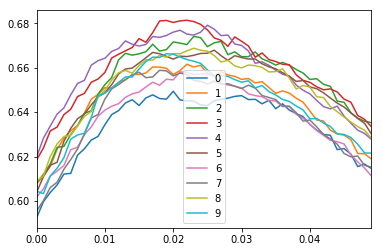

In [16]:
df_flowers.plot()
plt.show()

In [17]:
metric_multiplier_flowers = df_flowers.idxmax().mean()
print("FLOWERS, metric multiplier:", metric_multiplier_flowers)

FLOWERS, metric multiplier: 0.0219


In [18]:
# metric_multiplier_flowers=0.0252

## FLOWERS dataset compute performance on test

In [19]:
log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190502_144337_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_mi_weight_test_split_train_split_GZSL_results_test_split"

log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190508_220717_embedding_size_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split"
filter = "*embedding_size=1024*dataset=xian2018_flowers*repeat=*"


log_dir = "/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split"
filter = "*repeat=*dataset=xian2018_flowers*"

results = evaluate_test_result(logdir=log_dir, 
                               filter=filter, metric_multiplier=metric_multiplier_flowers)


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Loading split trainval
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_flowers/split_trainval_xian2018.pkl


Processing models:
['/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE', '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;nu

INFO:root:Loaded cache in 4.541576 sec
INFO:root:Loading split test_seen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_flowers/split_test_seen_xian2018.pkl
INFO:root:Loaded cache in 2.030586 sec
INFO:root:Loading split test_unseen
INFO:root:Loading cached file /mnt/datasets/public/research/cvpr2016_flowers/split_test_unseen_xian2018.pkl
INFO:root:Loaded cache in 1.878311 sec
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_

Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
176it [00:04, 40.47it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.40it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 38.57it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;mo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.027128599
STD unseen prototype:
101.664694693
STD seen prototype:
100.698389258
STD unseen prototype:
99.9132303915
STD seen prototype:
100.471315612
STD unseen prototype:
99.6009438548


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.401816316
STD unseen prototype:
99.2449321367
STD seen prototype:
100.436804647
STD unseen prototype:
99.2750937037
STD seen prototype:
100.371528543
STD unseen prototype:
99.2679298612
****************
SEEN images test
****************
STD seen prototype:
100.177740422
STD unseen prototype:
105.306182602


 67%|██████▋   | 4/6 [00:00<00:00, 15.12it/s]

STD seen prototype:
98.0111141658
STD unseen prototype:
103.737576255
STD seen prototype:
97.5487379522
STD unseen prototype:
103.350356806
STD seen prototype:
97.3198376617
STD unseen prototype:
103.428068182


100%|██████████| 6/6 [00:00<00:00, 14.93it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
97.2452839984
STD unseen prototype:
103.346382521
STD seen prototype:
97.2042801419
STD unseen prototype:
103.339910438
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=0;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
176it [00:04, 40.38it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 42.08it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 39.23it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;mo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.72406957
STD unseen prototype:
102.620402049
STD seen prototype:
101.554693518
STD unseen prototype:
100.553383187
STD seen prototype:
101.076496782
STD unseen prototype:
100.036746838


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
101.049755767
STD unseen prototype:
100.174457859
STD seen prototype:
100.96952612
STD unseen prototype:
99.9681531159
STD seen prototype:
100.973786701
STD unseen prototype:
99.9641614609
****************
SEEN images test
****************


 33%|███▎      | 2/6 [00:00<00:00, 14.96it/s]

STD seen prototype:
100.93125239
STD unseen prototype:
105.502550379
STD seen prototype:
98.5700946451
STD unseen prototype:
104.345704328
STD seen prototype:
98.3362966582
STD unseen prototype:
104.164917139


100%|██████████| 6/6 [00:00<00:00, 14.17it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
98.1296528089
STD unseen prototype:
103.939270756
STD seen prototype:
97.9668429207
STD unseen prototype:
103.944732155
STD seen prototype:
97.9372837386
STD unseen prototype:
103.938489088
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=1;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
176it [00:04, 38.36it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.61it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 40.15it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;mo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.93871209
STD unseen prototype:
102.087185433
STD seen prototype:
100.966940263
STD unseen prototype:
100.089704766
STD seen prototype:
101.058632712
STD unseen prototype:
99.9408355594


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.759873635
STD unseen prototype:
99.6569196938
STD seen prototype:
100.752809644
STD unseen prototype:
99.6966693758
STD seen prototype:
100.737649585
STD unseen prototype:
99.6769636291
****************
SEEN images test
****************
STD seen prototype:
100.668296841
STD unseen prototype:
105.951133699


 67%|██████▋   | 4/6 [00:00<00:00, 14.77it/s]

STD seen prototype:
98.4325268759
STD unseen prototype:
104.004411382
STD seen prototype:
97.9721265029
STD unseen prototype:
103.983863302
STD seen prototype:
97.7625136316
STD unseen prototype:
103.907922059


100%|██████████| 6/6 [00:00<00:00, 14.61it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
97.7115715568
STD unseen prototype:
103.836869635
STD seen prototype:
97.669345918
STD unseen prototype:
103.839930331
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=2;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
176it [00:04, 38.54it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.35it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 39.36it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;mo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.693757217
STD unseen prototype:
101.794058198
STD seen prototype:
100.482895431
STD unseen prototype:
99.8165312969
STD seen prototype:
100.400125064
STD unseen prototype:
99.4134660068


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.27688444
STD unseen prototype:
99.3745772001
STD seen prototype:
100.298335862
STD unseen prototype:
99.2979709988
STD seen prototype:
100.300418652
STD unseen prototype:
99.243865798
****************
SEEN images test
****************
STD seen prototype:
100.323744994
STD unseen prototype:
105.129771123


 67%|██████▋   | 4/6 [00:00<00:00, 15.09it/s]

STD seen prototype:
98.0423283287
STD unseen prototype:
103.710056139
STD seen prototype:
97.8207419686
STD unseen prototype:
103.611796513
STD seen prototype:
97.4901297308
STD unseen prototype:
103.53290902


100%|██████████| 6/6 [00:00<00:00, 14.52it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
97.460332605
STD unseen prototype:
103.428542205
STD seen prototype:
97.3582096111
STD unseen prototype:
103.397629749
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=3;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
176it [00:04, 37.55it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 40.47it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 38.30it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;mo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.135434451
STD unseen prototype:
101.635800746
STD seen prototype:
100.029276167
STD unseen prototype:
99.4070384661
STD seen prototype:
99.9634629604
STD unseen prototype:
99.3194117885


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
99.8858042847
STD unseen prototype:
99.0614616923
STD seen prototype:
99.8133159688
STD unseen prototype:
98.8865714689
STD seen prototype:
99.810464463
STD unseen prototype:
98.9168988689
****************
SEEN images test
****************
STD seen prototype:
100.183530447
STD unseen prototype:
104.957741435


 67%|██████▋   | 4/6 [00:00<00:00, 15.32it/s]

STD seen prototype:
97.5938936016
STD unseen prototype:
103.083518281
STD seen prototype:
97.1919295587
STD unseen prototype:
103.137506311
STD seen prototype:
96.9701754052
STD unseen prototype:
103.003394454
STD seen prototype:
96.8412391945
STD unseen prototype:
102.874045749


100%|██████████| 6/6 [00:00<00:00, 15.01it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=4;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing par

STD seen prototype:
96.8544676411
STD unseen prototype:
102.925925563
Loading model
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
176it [00:04, 37.89it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.74it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 37.96it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;mo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.660764748
STD unseen prototype:
101.528462512
STD seen prototype:
100.979234762
STD unseen prototype:
99.8008130195
STD seen prototype:
100.71852088
STD unseen prototype:
99.8490526697


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.619196497
STD unseen prototype:
99.609433976
STD seen prototype:
100.643714761
STD unseen prototype:
99.5073724092
STD seen prototype:
100.609382004
STD unseen prototype:
99.5302427975
****************
SEEN images test
****************
STD seen prototype:
100.240306498
STD unseen prototype:
105.548943158


 67%|██████▋   | 4/6 [00:00<00:00, 15.41it/s]

STD seen prototype:
98.2628515309
STD unseen prototype:
104.005911492
STD seen prototype:
97.7465635122
STD unseen prototype:
103.47215495
STD seen prototype:
97.6289478294
STD unseen prototype:
103.589095521


100%|██████████| 6/6 [00:00<00:00, 14.84it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
97.4972190237
STD unseen prototype:
103.494009149
STD seen prototype:
97.477594451
STD unseen prototype:
103.452343923
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=5;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
176it [00:04, 37.47it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.62it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 40.16it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;mo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
101.972843502
STD unseen prototype:
101.325094286
STD seen prototype:
100.176937997
STD unseen prototype:
99.5341722282
STD seen prototype:
100.296609776
STD unseen prototype:
99.0980994076


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.259157562
STD unseen prototype:
98.9700436007
STD seen prototype:
100.108558545
STD unseen prototype:
98.9344669916
STD seen prototype:
100.133257222
STD unseen prototype:
98.8760720499
****************
SEEN images test
****************
STD seen prototype:
100.208194433
STD unseen prototype:
105.066437711


 67%|██████▋   | 4/6 [00:00<00:00, 15.30it/s]

STD seen prototype:
97.5904277809
STD unseen prototype:
103.560688955
STD seen prototype:
97.2641574521
STD unseen prototype:
103.225588669
STD seen prototype:
97.0697900619
STD unseen prototype:
103.209920356
STD seen prototype:
96.9968620242
STD unseen prototype:
103.14915215


100%|██████████| 6/6 [00:00<00:00, 15.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=6;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing par

STD seen prototype:
96.9731485569
STD unseen prototype:
103.07050642
Loading model
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
176it [00:04, 38.10it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.64it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 38.74it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;mo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.580340437
STD unseen prototype:
102.285718222
STD seen prototype:
101.112296288
STD unseen prototype:
100.261903191
STD seen prototype:
100.816273538
STD unseen prototype:
100.073967771


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.697499923
STD unseen prototype:
99.7389620282
STD seen prototype:
100.650610248
STD unseen prototype:
99.6903443368
STD seen prototype:
100.661901652
STD unseen prototype:
99.6616644875
****************
SEEN images test
****************


 67%|██████▋   | 4/6 [00:00<00:00, 14.84it/s]

STD seen prototype:
100.731912313
STD unseen prototype:
106.294720763
STD seen prototype:
98.3683484288
STD unseen prototype:
104.038220674
STD seen prototype:
97.965707721
STD unseen prototype:
103.783422478
STD seen prototype:
97.7721586097
STD unseen prototype:
103.832133771


100%|██████████| 6/6 [00:00<00:00, 14.58it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
97.5858615442
STD unseen prototype:
103.753198881
STD seen prototype:
97.5609961964
STD unseen prototype:
103.726989229
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=7;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
176it [00:04, 37.91it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.36it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 40.90it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;mo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.034882161
STD unseen prototype:
102.46232781
STD seen prototype:
100.502422474
STD unseen prototype:
99.969056978
STD seen prototype:
100.574022369
STD unseen prototype:
99.3997807651


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
100.503749028
STD unseen prototype:
99.4293480833
STD seen prototype:
100.35352469
STD unseen prototype:
99.3590836954
STD seen prototype:
100.356689218
STD unseen prototype:
99.3387647921
****************
SEEN images test
****************
STD seen prototype:
100.552142365
STD unseen prototype:
105.487219333


 67%|██████▋   | 4/6 [00:00<00:00, 15.38it/s]

STD seen prototype:
97.9124795473
STD unseen prototype:
103.799383458
STD seen prototype:
97.550816556
STD unseen prototype:
103.665515652
STD seen prototype:
97.4937890189
STD unseen prototype:
103.428039134
STD seen prototype:
97.4058826373
STD unseen prototype:
103.419379536


100%|██████████| 6/6 [00:00<00:00, 15.00it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=8;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing par

STD seen prototype:
97.3689254553
STD unseen prototype:
103.414568267
Loading model
Loading model


INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model
Loading model
INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000


INFO:tensorflow:Restoring parameters from /mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/train/model-150000
INFO:root:Computing train embeddings
176it [00:04, 37.24it/s]
INFO:root:Computing test embeddings, unseen
37it [00:00, 39.43it/s]
INFO:root:Computing test embeddings, seen
44it [00:01, 39.39it/s]
INFO:root:Computing generalized zero-shot performance metrics
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;mo

Loading model
****************
UNSEEN images test
****************
STD seen prototype:
102.943425195
STD unseen prototype:
103.025661494
STD seen prototype:
101.243777781
STD unseen prototype:
100.545179049
STD seen prototype:
101.058797959
STD unseen prototype:
100.00265351


  0%|          | 0/6 [00:00<?, ?it/s]

STD seen prototype:
101.027856807
STD unseen prototype:
99.9155493477
STD seen prototype:
100.966631031
STD unseen prototype:
99.9412954277
STD seen prototype:
100.900421219
STD unseen prototype:
99.9009263432
****************
SEEN images test
****************
STD seen prototype:
100.546989485
STD unseen prototype:
105.13284172


 67%|██████▋   | 4/6 [00:00<00:00, 14.58it/s]

STD seen prototype:
98.4287398214
STD unseen prototype:
104.157126258
STD seen prototype:
97.9869696151
STD unseen prototype:
103.974549716
STD seen prototype:
97.8610115592
STD unseen prototype:
103.798484187


100%|██████████| 6/6 [00:00<00:00, 14.19it/s]
INFO:root:Computing classical zero-shot performance metrics, test
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


STD seen prototype:
97.752656436
STD unseen prototype:
103.802585746
STD seen prototype:
97.7167880008
STD unseen prototype:
103.766702059
Loading model


INFO:root:Computing classical zero-shot performance metrics, train
INFO:root:Searching for '/mnt/scratch/boris/experiments_zeroshot_pairwise/190510_194013_dataset_text_feature_extractor_number_of_steps_repeat_modality_interaction_test_split_train_split_GZSL_results_test_split/repeat=9;test_split=test;train_split=trainval;dataset=xian2018_flowers;text_feature_extractor=cnn_bi_lstm;number_of_steps=150001;modality_interaction=NONE/params.json'
INFO:root:Loading existing params.


Loading model


In [20]:
dmean(results)

{'train_AP@50/#sentences10': 0.68292682926829273,
 'train_Top-1 Acc/#sentences10': 0.72132150020909891,
 'train_AP@50/#sentences50': 0.82612195121951226,
 'train_Top-1 Acc/#sentences50': 0.89180623554815486,
 'train_AP@50/#sentences100': 0.84299999999999997,
 'train_Top-1 Acc/#sentences100': 0.91441368690253955,
 'train_AP@50/#sentences200': 0.85326829268292692,
 'train_Top-1 Acc/#sentences200': 0.92514251048265839,
 'train_AP@50/#sentences400': 0.85751219512195109,
 'train_Top-1 Acc/#sentences400': 0.93249824040847573,
 'train_AP@50/#sentences1000': 0.858439024390244,
 'train_Top-1 Acc/#sentences1000': 0.93524575374498453,
 'test_AP@50/#sentences10': 0.50160000000000005,
 'test_Top-1 Acc/#sentences10': 0.54868008127570767,
 'test_AP@50/#sentences50': 0.58160000000000012,
 'test_Top-1 Acc/#sentences50': 0.71341831563821556,
 'test_AP@50/#sentences100': 0.59440000000000004,
 'test_Top-1 Acc/#sentences100': 0.74563594587183746,
 'test_AP@50/#sentences200': 0.60730000000000006,
 'test_Top

In [21]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mplt

plots_output_folder = "plots"
pathlib.Path(plots_output_folder).mkdir(parents=True, exist_ok=True)

def plot_df(df, filename):
    mplt.rcParams.update({'font.size': 22})
    mplt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)

    df.plot(ax=ax)
    ax.get_legend().remove()
    plt.grid('on')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'H')
    plt.show()
    
    fig.savefig(os.path.join(plots_output_folder, filename), bbox_inches='tight')

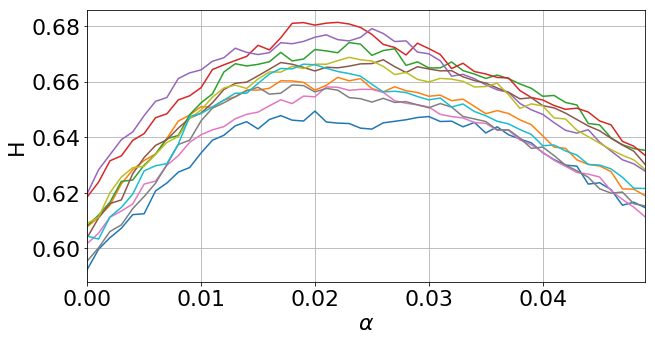

In [22]:
plot_df(df=df_flowers, filename="alpha_crossvalidation_flowers.pdf")

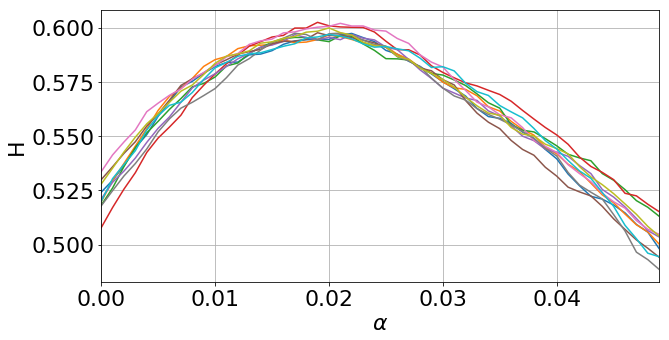

In [23]:
plot_df(df=df, filename="alpha_crossvalidation_cub.pdf")